# Self-Driving Car Engineer Nanodegree

## Computer Vision

## Project: Build an Advanced Lane Detection Pipeline

The goals of this project are to:
    1. Perform camera calibration using a set of chessboard images
    2. Correct for distortion in raw images using the camera callibration matrix and distortion coefficients
    3. Perform color/ gradient threshold to create threshold binary images
    4. Use a perspective transform (birds-eye) to warp the perspective of input images
    5. Detect pixels appropriately to detect lane boundaries
    6. Determine lane curvature and distance of car from lane center
    7. Superimpose detected lane lines to original image and display data as a video output
All major intermediate functions are in separate notebooks/python files for ease/modularity.

## Step 0: Import required packages

In [1]:
## LIST OF ALL IMPORTS

import math
import os
import os.path as path
import pickle
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
import nbimporter

from collections import deque
from datetime import datetime
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Step 1: Camera Calibration

Extracting 3D object, and 2D image arrays from sample chessboard images.
Camera Calibration initialized.
Detected corners for image 0.
Detected corners for image 1.
Detected corners for image 3.
Detected corners for image 4.
Detected corners for image 6.
Detected corners for image 7.
Detected corners for image 8.
Detected corners for image 9.
Detected corners for image 10.
Detected corners for image 11.
Detected corners for image 12.
Detected corners for image 14.
Detected corners for image 15.
Detected corners for image 16.
Detected corners for image 17.
Detected corners for image 18.
Detected corners for image 19.
(9,6) pattern corners cannot be detected in 3 images in the camera_cal folder.


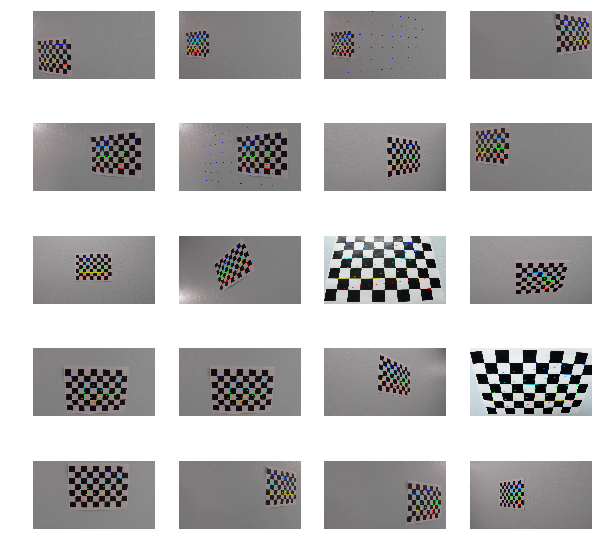

In [2]:
from camera_image_calibration import calibrate_camera

print("Extracting 3D object, and 2D image arrays from sample chessboard images.")
path='camera_cal/calibration*.jpg'
obj_array,img_array,cal_images,uncal_images=calibrate_camera(path)

Using image and object arrays to calibrate & undistort camera images.
Pickle exists, ignoring pickle creation step.


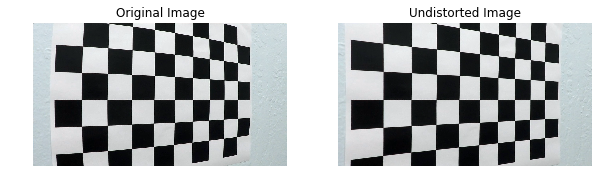

In [3]:
from camera_image_calibration import undistortion

print("Using image and object arrays to calibrate & undistort camera images.")

test_imagepath='camera_cal/calibration5.jpg'
src_image=cv2.imread(test_imagepath)

undistorted_image, camera_matrix, distortion_coefficients=undistortion(src_image,obj_array,img_array)

pickle_path="undistortion_pickle.p"

if (os.path.isfile(pickle_path)):
    print("Pickle exists, ignoring pickle creation step.")
else:
    try:
        print("Pickling camera matrix and distortion coefficients.")
        pickled=open(pickle_path,'wb')
        save={
            'dist_matrix': camera_matrix,
            'dist_coefficients': distortion_coefficients
        }
        pickle.dump(save,pickled)
        pickled.close()
        print("Data pickled.")
    except:
        print("Error in pickling. Debug.")

fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(10,10))
ax_orig.imshow(src_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_undist.imshow(undistorted_image)
ax_undist.axis('off')
ax_undist.set_title('Undistorted Image')

## Step 2: Distortion Correction

In [4]:
from camera_image_calibration import undistort

# Load saved pickled data for matrix and distortion coefficients
pickle_path='undistortion_pickle.p'

with open(pickle_path,mode='rb') as f:
        undistort_data=pickle.load(f)
undistort_camera_matrix,undistort_coefficients=undistort_data['dist_matrix'], undistort_data['dist_coefficients']

print("Loading image undistortion coefficients, matrix from {}.".format(pickle_path))

Loading image undistortion coefficients, matrix from undistortion_pickle.p.


Testing out undistortion algorithm on sample chessboard images.


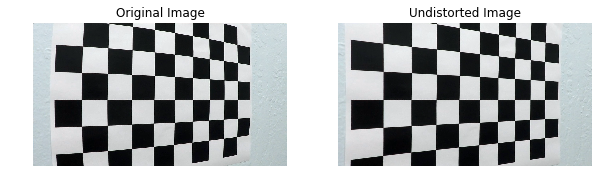

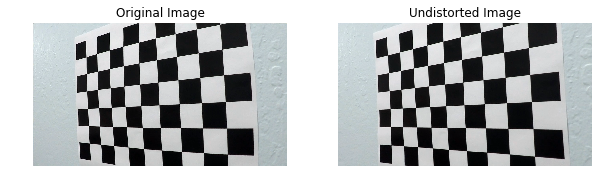

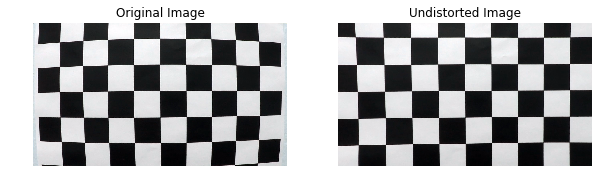

In [5]:
# Test out undistortion on chessboard images which weren't able to be used for finding corners
print("Testing out undistortion algorithm on sample chessboard images.")
num_plots=3
count=0

for image in uncal_images:
    fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(10,10))

    ax_orig.imshow(image)
    ax_orig.set_title('Original Image')
    ax_orig.axis('off')
    
    ax_undist.imshow(undistort(image,undistort_camera_matrix,undistort_coefficients))
    ax_undist.set_title('Undistorted Image')
    ax_undist.axis('off')
        
    if count>=num_plots:
        break
    count+=1

Testing out undistortion algorithm on sample driving camera image.


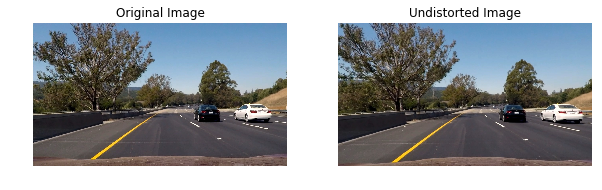

In [6]:
# Test out undistortion on a test_image 
print("Testing out undistortion algorithm on sample driving camera image.")

test_imagepath='test_images/test6.jpg'
test_image=cv2.cvtColor(cv2.imread(test_imagepath),cv2.COLOR_BGR2RGB)
undistort_image=undistort(test_image,undistort_camera_matrix,undistort_coefficients)
fig,(ax_orig,ax_undist)=plt.subplots(1,2,figsize=(10,10))
ax_orig.imshow(test_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_undist.imshow(undistort_image)
ax_undist.axis('off')
ax_undist.set_title('Undistorted Image')

Straight_lines2, Test6 messes up lane detection for both left and right lanes.

## Step 3: Color and Edge Thresholding

Displaying color- and edge- thresholds on sample image.


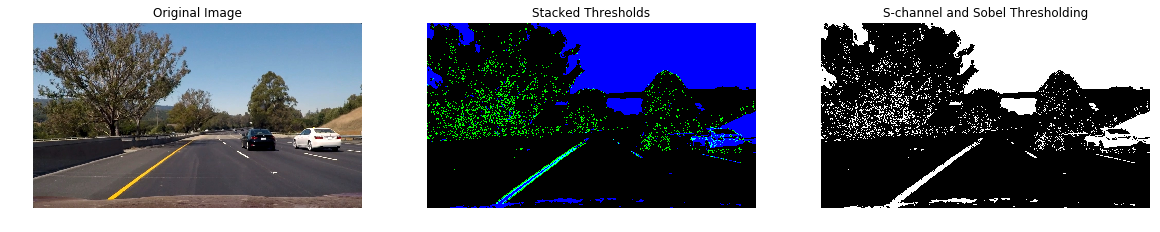

In [7]:
from image_thresholding import edge_detection

print("Displaying color- and edge- thresholds on sample image.")
color_binary, combined_binary=edge_detection(undistort_image)

fig,(ax_orig,ax_color,ax_combined)=plt.subplots(1,3,figsize=(20,10))
ax_orig.imshow(test_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_color.imshow(color_binary)
ax_color.axis('off')
ax_color.set_title('Stacked Thresholds')

ax_combined.imshow(combined_binary,cmap='gray')
ax_combined.axis('off')
ax_combined.set_title('S-channel and Sobel Thresholding')

Stacked Thresholds. 1.Green Channel: Edge Thresholding (Sobel x-,y-,magnitude,direction)
                    2.Blue Channel: Color Thresholding (S-channel of HLS image)

## Step 4: Warp Perspective

Testing out warping algorithm on sample driving camera image.


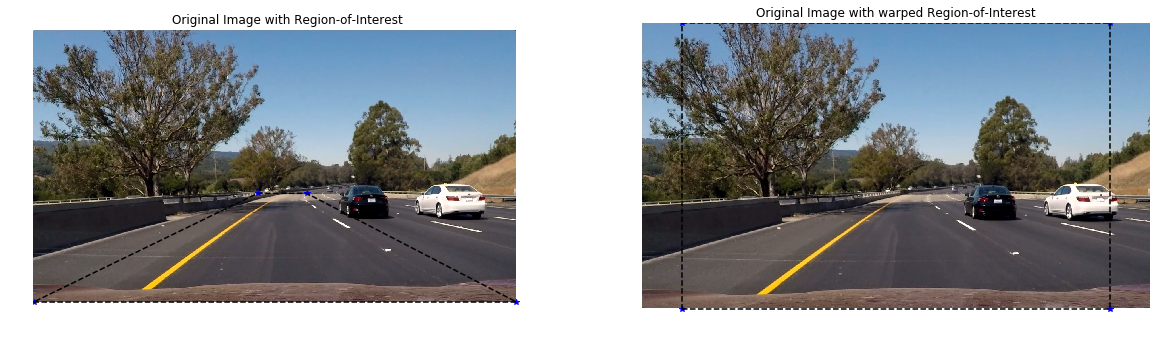

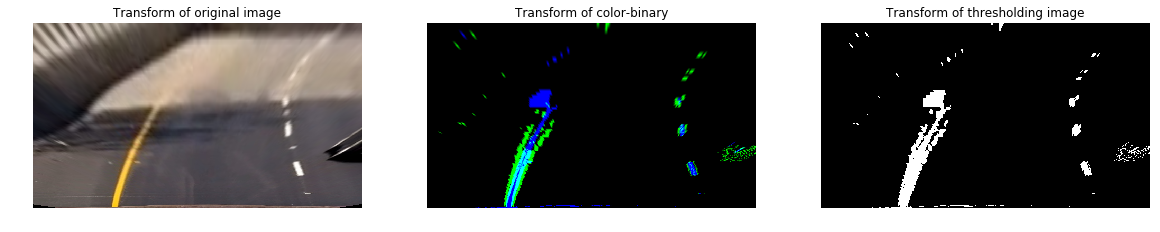

In [8]:
from camera_image_calibration import birds_eye_transform

print("Testing out warping algorithm on sample driving camera image.")
y_len,x_len=test_image.shape[0:2] #(y,x)

top_test_image, warp_matrix, inv_warp_matrix=birds_eye_transform(undistort_image)
top_color_binary,_,_=birds_eye_transform(color_binary)
top_combined_binary,_,_=birds_eye_transform(combined_binary)

# Displaying ROI (x,y)
#src_points=np.float32([[-100,y_len],[x_len+100,y_len],[0.5*x_len-100,0.6*y_len],[0.5*x_len+100,0.6*y_len]])
src_points=np.float32([[0,y_len],[x_len-0,y_len],[0.55*x_len-110,0.6*y_len],[0.55*x_len+20,0.6*y_len]])
dest_points=np.float32([[100,y_len],[x_len-100,y_len],[100,0],[x_len-100,0]])
        
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
ax1.imshow(test_image)

for point in src_points:
    ax1.plot(point[0],point[1],'b*')
x_points=[src_points[0,0],src_points[1,0],src_points[3,0],src_points[2,0],src_points[0,0]]
y_points=[src_points[0,1],src_points[1,1],src_points[3,1],src_points[2,1],src_points[0,1]]
ax1.plot(x_points,y_points,color='k',linestyle='--')
ax1.axis('off')
ax1.set_title('Original Image with Region-of-Interest')

ax2.imshow(test_image)

for point in dest_points:
    ax2.plot(point[0],point[1],'b*')
x_points=[dest_points[0,0],dest_points[1,0],dest_points[3,0],dest_points[2,0],dest_points[0,0]]
y_points=[dest_points[0,1],dest_points[1,1],dest_points[3,1],dest_points[2,1],dest_points[0,1]]
ax2.plot(x_points,y_points,color='k',linestyle='--')
ax2.axis('off')
ax2.set_title('Original Image with warped Region-of-Interest')


# Warped Region of Interest after Color & Gradient thresholding

fig,(ax_orig,ax_color,ax_combined)=plt.subplots(1,3,figsize=(20,10))
ax_orig.imshow(top_test_image)
ax_orig.axis('off')
ax_orig.set_title('Transform of original image')

ax_color.imshow(top_color_binary)
ax_color.axis('off')
ax_color.set_title('Transform of color-binary')

ax_combined.imshow(top_combined_binary,cmap='gray')
ax_combined.axis('off')
ax_combined.set_title('Transform of thresholding image')

## Step 5: Line Fitting

Implementing lane detection on sample driving camera image- using histogram analysis.


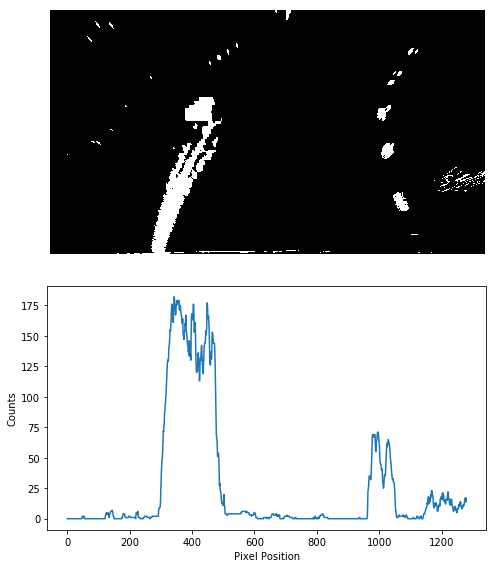

In [9]:
from lane_detection import pixel_histogram

print("Implementing lane detection on sample driving camera image- using histogram analysis.")
fig,(ax_plot,ax_hist)=plt.subplots(2,1,figsize=(7,8))

ax_plot.imshow(top_combined_binary,cmap='gray')
ax_plot.axis('off')
ax_hist.plot(pixel_histogram(top_combined_binary))
ax_hist.set_xlabel('Pixel Position')
ax_hist.set_ylabel('Counts')
fig.subplots_adjust(wspace=0, hspace=0)
fig.tight_layout() 

Histogram shows peaks where the sobel-edges and color-gradients detect lane lines (as well as possible noise).

Detecting lane lines using a sliding-window algorithm which are fitted using polynomial lane-lines.


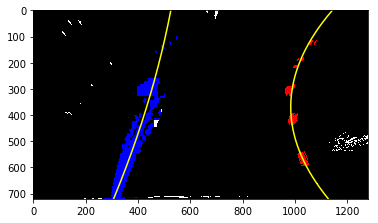

In [10]:
from lane_detection import visualize_windowfit

print("Detecting lane lines using a sliding-window algorithm which are fitted using polynomial lane-lines.")
visualize_windowfit(top_combined_binary)

Detecting lane lines using a sliding-window algorithm based on an existing fits for easier tracking on sharply curved roads.


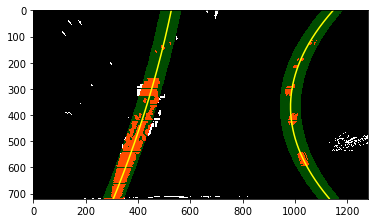

In [11]:
from lane_detection import combined_windowfit_filled

print("Detecting lane lines using a sliding-window algorithm based on an existing fits for easier tracking on sharply curved roads.")
left_fit_combined, right_fit_combined, left_px, right_px=combined_windowfit_filled(top_combined_binary)

## Step 6: Analysis of Curvature and Offset

In [12]:
from analysis import curvature_analysis

print("Analyzing lane-line curvatures from warped image.")

avg_left_curve,avg_right_curve,avg_curve=curvature_analysis(top_combined_binary,left_px,right_px)

print("Left curve {} m, Right curve {} m, Averaged curve {} m"
      .format(round(avg_left_curve,3),round(avg_right_curve,3),round(avg_curve,3)))

Analyzing lane-line curvatures from warped image.
Left Lanes 3577.6954 m
Right Lanes 268.7667 m
Left curve 3577.695 m, Right curve 268.767 m, Averaged curve 1923.231 m


In [13]:
from analysis import offset_analysis

print("Analyzing offset of car (central camera) from highway lane center.")

bias,offset=offset_analysis(top_combined_binary,left_px,right_px,left_fit_combined,right_fit_combined)

if bias=='R':
    disp_bias="--> (right lane)"
else:
    disp_bias="<-- (left lane)"
    
print("Car offset from lane-center {} m, towards {}.".format(round(offset,3),disp_bias))

Analyzing offset of car (central camera) from highway lane center.
Car offset from lane-center 0.39 m, towards <-- (left lane).


## Step 7: Overlaying lane visuals and information on unwarped image

Remapping obtained information onto the original frame.


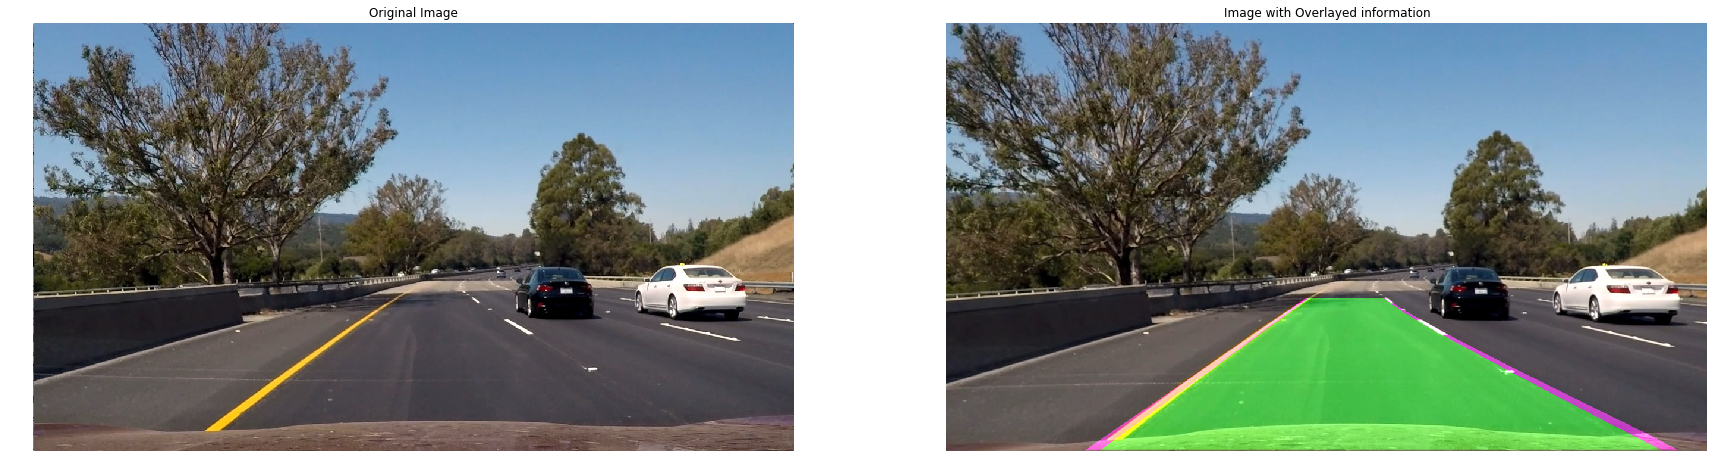

In [14]:
from camera_image_calibration import remap

print("Remapping obtained information onto the original frame.")

combined_image=remap(undistort_image,top_combined_binary,inv_warp_matrix,left_fit_combined,right_fit_combined)

fig,(ax_orig,ax_overlay)=plt.subplots(1,2,figsize=(30,10))
ax_orig.imshow(test_image)
ax_orig.axis('off')
ax_orig.set_title('Original Image')

ax_overlay.imshow(combined_image)
ax_overlay.axis('off')
ax_overlay.set_title('Image with Overlayed information')

Annotating remapped image with obtained information.


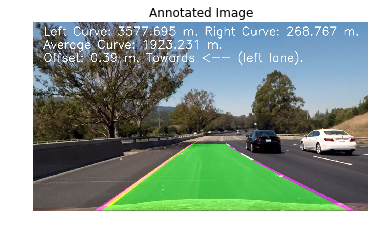

In [15]:
from camera_image_calibration import annotate

print("Annotating remapped image with obtained information.")

annotated_image=annotate(combined_image,avg_left_curve,avg_right_curve,avg_curve,bias,offset)

plt.imshow(annotated_image)
plt.axis('off')
plt.title('Annotated Image')

## Step 8: Video Pipeline

In [16]:
print("Utilizing lane-finding pipeline on video feed.")

from lane_finding_pipeline import Lane_finding

adv_lane_pipeline=Lane_finding()

Utilizing lane-finding pipeline on video feed.


### Video Pipeline- Main Project Video

In [ ]:
main_output = 'test_videos_output/main_project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("test_videos/main_project_video.mp4").subclip(0,1.5)
clip1 = VideoFileClip("test_videos/main_project_video.mp4")
main_clip = clip1.fl_image(adv_lane_pipeline.video_pipeline) #NOTE: this function expects color images!!
%time main_clip.write_videofile(main_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(main_output))

### Video Pipeline- Supplementary Videos: Project One Challenge

In [ ]:
alternative_challenge_output = 'test_videos_output/alternative_challenge.mp4'
# clip4 = VideoFileClip("test_videos/alternative_challenge.mp4").subclip(0,5)
clip4 = VideoFileClip("test_videos/alternative_challenge.mp4")
alternative_challenge_clip = clip4.fl_image(adv_lane_pipeline.video_pipeline) #NOTE: this function expects color images!!
%time alternative_challenge_clip.write_videofile(alternative_challenge_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(alternative_challenge_output))

### Video Pipeline- Supplementary Videos: Night Driving

Left fit combined: [  8.63786268e-05   2.35715853e-03   3.70381476e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([338, 339, 340, ..., 448, 459, 462])]
Left Lanes 952.3355 m
Right Lanes 705.9194 m
Curve- 01 loop
Left- 01 loop
Right- 01 loop
[MoviePy] >>>> Building video test_videos_output/alternative_sample_night_drive.mp4
[MoviePy] Writing video test_videos_output/alternative_sample_night_drive.mp4


  0%|          | 1/762 [00:02<37:20,  2.94s/it]

Left fit combined: [  8.63786268e-05   2.35715853e-03   3.70381476e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([338, 339, 340, ..., 448, 459, 462])]
Left Lanes 952.3355 m
Right Lanes 705.9194 m
Sanity Curve Difference 0.0
Curve- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Left- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Right- 02 loop


  0%|          | 2/762 [00:06<38:42,  3.06s/it]

Left fit combined: [ -1.00103717e-03   6.72002576e-01   3.46305259e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 717]), array([313, 314, 315, ..., 354, 358, 359])]
Left Lanes 504.0216 m
Right Lanes 295.4327 m
Sanity Curve Difference 0.517894199581
Curve- 02 loop
Sanity Fit Difference [  1.25889452e+01   2.84090106e+02   6.50038368e-02]
Left- 02 loop
Sanity Fit Difference [ 3.94864715  3.15638829  0.04275287]
Right- 02 loop


  0%|          | 3/762 [00:09<39:16,  3.10s/it]

Left fit combined: [ -4.36018061e-04   5.15931888e-01   3.55592891e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([316, 317, 318, ..., 456, 457, 458])]
Left Lanes 2155732.5082 m
Right Lanes 408.9232 m
Sanity Curve Difference 2696.01641588
Curve- 02 loop
Sanity Fit Difference [ 0.5644337   0.23224716  0.02681921]
Left- 02 loop
Sanity Fit Difference [ 0.5952254   0.34314738  0.3738886 ]
Right- 02 loop


  1%|          | 4/762 [00:12<38:17,  3.03s/it]

Left fit combined: [ -8.91900961e-04   6.50390776e-01   3.45562409e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([310, 311, 312, ..., 395, 396, 397])]
Left Lanes 671.1601 m
Right Lanes 390.0188 m
Sanity Curve Difference 0.9995078343
Curve- 02 loop
Sanity Fit Difference [ 1.04555967  0.26061364  0.02820777]
Left- 02 loop
Sanity Fit Difference [ 0.74016255  0.30664366  0.42087515]
Right- 02 loop


  1%|          | 5/762 [00:15<38:21,  3.04s/it]

Left fit combined: [ -8.72966634e-04   6.53607163e-01   3.43507693e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([307, 308, 309, ..., 406, 408, 397])]
Left Lanes 789.8276 m
Right Lanes 479.8724 m
Sanity Curve Difference 0.196499461722
Curve- 02 loop
Sanity Fit Difference [ 0.02122918  0.00494531  0.00594601]
Left- 02 loop
Sanity Fit Difference [ 0.99469567  1.74396232  0.50879349]
Right- 02 loop


  1%|          | 6/762 [00:18<38:13,  3.03s/it]

Left fit combined: [ -9.88148063e-04   7.08380681e-01   3.35335347e+02]
Left_px: [array([  0,   0,   0, ..., 709, 716, 719]), array([305, 306, 307, ..., 382, 326, 388])]
Left Lanes 659.4226 m
Right Lanes 547.8314 m
Sanity Curve Difference 0.0491816736733
Curve- 02 loop
Sanity Fit Difference [ 0.13194253  0.08380189  0.02379087]
Left- 02 loop
Sanity Fit Difference [ 10.7708249    0.0404653    0.01815431]
Right- 02 loop


  1%|          | 7/762 [00:21<37:46,  3.00s/it]

Left fit combined: [ -1.17750256e-03   8.21202620e-01   3.32391499e+02]
Left_px: [array([  0,   0,   0, ..., 709, 710, 710]), array([301, 302, 303, ..., 374, 302, 303])]
Left Lanes 394.5609 m
Right Lanes 346.5112 m
Sanity Curve Difference 0.386150680051
Curve- 02 loop
Sanity Fit Difference [ 0.19162563  0.15926738  0.00877882]
Left- 02 loop
Sanity Fit Difference [ 14.2226108    2.66753697   1.25139499]
Right- 02 loop


  1%|          | 8/762 [00:24<38:00,  3.02s/it]

Left fit combined: [ -1.22352817e-03   8.82040185e-01   3.19658383e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 281, 282, 283])]
Left Lanes 453.1391 m
Right Lanes 928.1998 m
Sanity Curve Difference 0.863973854977
Curve- 02 loop
Sanity Fit Difference [ 0.03908749  0.0740835   0.03830759]
Left- 02 loop
Sanity Fit Difference [ 1.10307902  1.74376775  0.56802846]
Right- 02 loop


  1%|          | 9/762 [00:27<37:51,  3.02s/it]

Left fit combined: [ -1.00891672e-03   8.20787860e-01   3.18783017e+02]
Left_px: [array([  0,   0,   0, ..., 713, 719, 719]), array([296, 297, 298, ..., 396, 396, 397])]
Left Lanes 509.1124 m
Right Lanes 486.7873 m
Sanity Curve Difference 0.279033043478
Curve- 02 loop
Sanity Fit Difference [ 0.17540377  0.06944392  0.00273844]
Left- 02 loop
Sanity Fit Difference [ 6.52924933  1.65822092  1.13452078]
Right- 02 loop


  1%|▏         | 10/762 [00:30<37:49,  3.02s/it]

Left fit combined: [ -8.90008372e-04   8.02818716e-01   3.18455617e+02]
Left_px: [array([  0,   0,   0, ..., 716, 716, 719]), array([296, 297, 298, ..., 410, 411, 409])]
Left Lanes 572.5772 m
Right Lanes 512.2283 m
Sanity Curve Difference 0.089271840693
Curve- 02 loop
Sanity Fit Difference [ 0.11785744  0.02189256  0.00102703]
Left- 02 loop
Sanity Fit Difference [ 1.72788965  1.82805805  0.34107999]
Right- 02 loop


  1%|▏         | 11/762 [00:33<38:05,  3.04s/it]

Left fit combined: [ -9.15874856e-04   7.94605989e-01   3.25963904e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 381, 397, 411])]
Left Lanes 560.6515 m
Right Lanes 683.6487 m
Sanity Curve Difference 0.147026096836
Curve- 02 loop
Sanity Fit Difference [ 0.02906319  0.01022986  0.02357719]
Left- 02 loop
Sanity Fit Difference [ 1.8559098   2.83124732  0.15661099]
Right- 02 loop


  2%|▏         | 12/762 [00:36<38:08,  3.05s/it]

Left fit combined: [ -9.86273521e-04   8.40272374e-01   3.22700365e+02]
Left_px: [array([  0,   0,   0, ..., 716, 716, 719]), array([304, 305, 306, ..., 403, 416, 408])]
Left Lanes 532.8707 m
Right Lanes 442.6404 m
Sanity Curve Difference 0.216016273935
Curve- 02 loop
Sanity Fit Difference [ 0.07686494  0.05747048  0.01001196]
Left- 02 loop
Sanity Fit Difference [ 0.73508767  0.27624486  0.33292683]
Right- 02 loop


  2%|▏         | 13/762 [00:39<38:24,  3.08s/it]

Left fit combined: [ -8.85142065e-04   7.23863314e-01   3.40865879e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 371, 381, 382])]
Left Lanes 665.6393 m
Right Lanes 445.6517 m
Sanity Curve Difference 0.139188452086
Curve- 02 loop
Sanity Fit Difference [ 0.10253896  0.13853729  0.0562922 ]
Left- 02 loop
Sanity Fit Difference [ 0.25246276  0.09342802  0.03524054]
Right- 02 loop


  2%|▏         | 14/762 [00:42<38:15,  3.07s/it]

Left fit combined: [ -4.71102369e-04   5.89057154e-01   3.50691179e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([314, 315, 316, ..., 484, 525, 544])]
Left Lanes 7755.1252 m
Right Lanes 3210.9935 m
Sanity Curve Difference 8.86790934631
Curve- 02 loop
Sanity Fit Difference [ 0.46776638  0.18623151  0.02882453]
Left- 02 loop
Sanity Fit Difference [ 0.46281828  0.69463364  0.06025388]
Right- 02 loop


  2%|▏         | 15/762 [00:45<37:32,  3.02s/it]

Left fit combined: [ -4.89087753e-04   5.76077088e-01   3.59724638e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([324, 325, 326, ..., 494, 543, 544])]
Left Lanes 2222.5229 m
Right Lanes 557.9984 m
Sanity Curve Difference 0.746444357305
Curve- 02 loop
Sanity Fit Difference [ 0.03817723  0.02203533  0.02575901]
Left- 02 loop
Sanity Fit Difference [ 1.20928411  3.7815316   0.13903508]
Right- 02 loop


  2%|▏         | 16/762 [00:48<37:25,  3.01s/it]

Left fit combined: [  1.02986171e-03  -7.20826198e-01   3.29194267e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 717]), array([321, 322, 323, ..., 344, 345, 346])]
Left Lanes 204.0632 m
Right Lanes 1477.5741 m
Sanity Curve Difference 0.395207890363
Curve- 02 loop
Sanity Fit Difference [ 3.1056788   2.25126691  0.08487151]
Left- 02 loop
Sanity Fit Difference [ 0.25633658  0.36859581  0.05484238]
Right- 02 loop


  2%|▏         | 17/762 [00:51<37:57,  3.06s/it]

Left fit combined: [  9.94660079e-04  -8.09782908e-01   3.90701851e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([349, 350, 351, ..., 299, 300, 301])]
Left Lanes 157.8239 m
Right Lanes 347.5451 m
Sanity Curve Difference 0.699478044419
Curve- 02 loop
Sanity Fit Difference [ 0.03418093  0.12340937  0.18684282]
Left- 02 loop
Sanity Fit Difference [ 0.24337478  0.13320793  0.02430195]
Right- 02 loop


  2%|▏         | 18/762 [00:54<38:04,  3.07s/it]

Left fit combined: [  8.23592701e-04  -7.25250601e-01   3.94911234e+02]
Left_px: [array([  0,   0,   0, ..., 716, 718, 718]), array([351, 352, 353, ..., 313, 309, 319])]
Left Lanes 177.3446 m
Right Lanes 447.3818 m
Sanity Curve Difference 0.236178848429
Curve- 02 loop
Sanity Fit Difference [ 0.17198577  0.10438885  0.0107739 ]
Left- 02 loop
Sanity Fit Difference [ 0.06354046  0.05149402  0.00270062]
Right- 02 loop


  2%|▏         | 19/762 [00:58<37:58,  3.07s/it]

Left fit combined: [  7.42895287e-04  -6.49873188e-01   3.74436321e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 717]), array([337, 338, 339, ..., 286, 287, 288])]
Left Lanes 199.9573 m
Right Lanes 350.4326 m
Sanity Curve Difference 0.118990441579
Curve- 02 loop
Sanity Fit Difference [ 0.09798219  0.10393292  0.05184687]
Left- 02 loop
Sanity Fit Difference [ 0.57724448  0.60038669  0.02419494]
Right- 02 loop


  3%|▎         | 20/762 [01:01<38:34,  3.12s/it]

Left fit combined: [  3.12801642e-04  -2.89918803e-01   3.07327792e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 257, 265, 266])]
Left Lanes 570.5303 m
Right Lanes 187.7558 m
Sanity Curve Difference 0.377725247484
Curve- 02 loop
Sanity Fit Difference [ 0.57894249  0.55388404  0.17922548]
Left- 02 loop
Sanity Fit Difference [ 0.71964004  0.96843071  0.12610045]
Right- 02 loop


  3%|▎         | 21/762 [01:04<38:05,  3.08s/it]

Left fit combined: [ -1.01568602e-03   8.71724920e-01   6.85431744e+01]
Left_px: [array([ 79,  79,  80, ..., 719, 719, 719]), array([117, 118, 117, ..., 196, 209, 210])]
Left Lanes 278.9233 m
Right Lanes 282.2528 m
Sanity Curve Difference 0.259941451424
Curve- 02 loop
Sanity Fit Difference [ 4.24706101  4.00678987  0.77697047]
Left- 02 loop
Sanity Fit Difference [ 0.23658563  0.25171728  0.04958297]
Right- 02 loop


  3%|▎         | 22/762 [01:07<38:36,  3.13s/it]

Left fit combined: [ -1.09576301e-03   9.48848813e-01   4.72454456e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 38,  39,  40, ..., 180, 181, 182])]
Left Lanes 205.1579 m
Right Lanes 478.794 m
Sanity Curve Difference 0.218782947454
Curve- 02 loop
Sanity Fit Difference [ 0.0788403   0.08847274  0.31071991]
Left- 02 loop
Sanity Fit Difference [ 0.2902996  0.5704478  0.1485103]
Right- 02 loop


  3%|▎         | 23/762 [01:10<38:43,  3.14s/it]

Left fit combined: [ -1.04572725e-03   8.88258415e-01   6.17789219e+01]
Left_px: [array([ 36,  37,  38, ..., 719, 719, 719]), array([109, 110, 110, ..., 159, 169, 170])]
Left Lanes 202.091 m
Right Lanes 311.2092 m
Sanity Curve Difference 0.249508339512
Curve- 02 loop
Sanity Fit Difference [ 0.04566294  0.06385675  0.30761645]
Left- 02 loop
Sanity Fit Difference [ 0.19662954  0.15069623  0.07169486]
Right- 02 loop


  3%|▎         | 24/762 [01:13<37:54,  3.08s/it]

Left fit combined: [ -8.94847036e-04   7.43362424e-01   9.20729293e+01]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([117, 117, 118, ..., 164, 165, 177])]
Left Lanes 232.692 m
Right Lanes 230.3421 m
Sanity Curve Difference 0.0979272514776
Curve- 02 loop
Sanity Fit Difference [ 0.14428257  0.16312369  0.49036154]
Left- 02 loop
Sanity Fit Difference [ 0.51197228  0.46519207  0.01734189]
Right- 02 loop


  3%|▎         | 25/762 [01:16<38:55,  3.17s/it]

Left fit combined: [ -1.04444054e-03   8.65178790e-01   6.71705724e+01]
Left_px: [array([ 36,  36,  37, ..., 719, 719, 719]), array([ 77,  93,  78, ..., 135, 136, 139])]
Left Lanes 219.079 m
Right Lanes 1503.7484 m
Sanity Curve Difference 2.72073555932
Curve- 02 loop
Sanity Fit Difference [ 0.16717216  0.16387211  0.27046339]
Left- 02 loop
Sanity Fit Difference [ 0.68850765  1.19843393  0.1966435 ]
Right- 02 loop


  3%|▎         | 26/762 [01:20<39:12,  3.20s/it]

Left fit combined: [ -9.47717969e-04   7.87642766e-01   7.78860833e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 48,  49,  50, ..., 163, 174, 175])]
Left Lanes 194.5431 m
Right Lanes 2246.8988 m
Sanity Curve Difference 0.417113459609
Curve- 02 loop
Sanity Fit Difference [ 0.09260707  0.0896185   0.15952687]
Left- 02 loop
Sanity Fit Difference [ 1.1023832   1.88293514  0.35304963]
Right- 02 loop


  4%|▎         | 27/762 [01:23<39:43,  3.24s/it]

Left fit combined: [ -9.61753578e-04   7.91510282e-01   7.79940625e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 129, 130, 131])]
Left Lanes 173.5161 m
Right Lanes 335.5936 m
Sanity Curve Difference 0.791471718294
Curve- 02 loop
Sanity Fit Difference [ 0.0148099   0.00491024  0.00138637]
Left- 02 loop
Sanity Fit Difference [ 28.91924009   2.48853961   0.90347663]
Right- 02 loop


  4%|▎         | 28/762 [01:26<39:39,  3.24s/it]

Left fit combined: [ -1.15589719e-03   9.32207005e-01   5.51574888e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 131, 132, 137])]
Left Lanes 182.6039 m
Right Lanes 392.3652 m
Sanity Curve Difference 0.129362020438
Curve- 02 loop
Sanity Fit Difference [ 0.20186419  0.17775729  0.29279887]
Left- 02 loop
Sanity Fit Difference [ 0.03366139  0.01129684  0.00173685]
Right- 02 loop


  4%|▍         | 29/762 [01:29<39:08,  3.20s/it]

Left fit combined: [ -1.26236011e-03   9.95360708e-01   5.39721168e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 139, 140, 146])]
Left Lanes 158.1724 m
Right Lanes 241.2169 m
Sanity Curve Difference 0.305372808659
Curve- 02 loop
Sanity Fit Difference [ 0.09210414  0.06774644  0.02149068]
Left- 02 loop
Sanity Fit Difference [ 0.05772472  0.07044875  0.00716129]
Right- 02 loop


  4%|▍         | 30/762 [01:32<38:18,  3.14s/it]

Left fit combined: [ -1.24398141e-03   1.00490557e+00   3.97417482e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 140, 144, 145])]
Left Lanes 157.5695 m
Right Lanes 353.9797 m
Sanity Curve Difference 0.280828759998
Curve- 02 loop
Sanity Fit Difference [ 0.014559    0.00958935  0.26366149]
Left- 02 loop
Sanity Fit Difference [ 2.4699901   3.40751049  0.07743934]
Right- 02 loop


  4%|▍         | 31/762 [01:36<38:40,  3.17s/it]

Left fit combined: [ -8.40355347e-04   6.57622668e-01   1.07729990e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([166, 166, 167, ..., 157, 158, 161])]
Left Lanes 344.1513 m
Right Lanes 455.3115 m
Sanity Curve Difference 0.562826820383
Curve- 02 loop
Sanity Fit Difference [ 0.3244631   0.3455876   1.71075116]
Left- 02 loop
Sanity Fit Difference [ 1.61473724  1.36850204  0.0791037 ]
Right- 02 loop


  4%|▍         | 32/762 [01:39<38:07,  3.13s/it]

Left fit combined: [ -4.99988560e-04   3.49066328e-01   1.73342140e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([154, 155, 156, ..., 210, 166, 167])]
Left Lanes 384.2754 m
Right Lanes 629.2947 m
Sanity Curve Difference 0.267813968558
Curve- 02 loop
Sanity Fit Difference [ 0.40502722  0.46919967  0.60904257]
Left- 02 loop
Sanity Fit Difference [ 0.13349656  0.11652169  0.00582417]
Right- 02 loop


  4%|▍         | 33/762 [01:42<37:20,  3.07s/it]

Left fit combined: [ -9.78279396e-04   7.91130782e-01   7.86649898e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 57,  58,  59, ..., 136, 145, 146])]
Left Lanes 209.0521 m
Right Lanes 523.9504 m
Sanity Curve Difference 0.276811239364
Curve- 02 loop
Sanity Fit Difference [ 0.95660356  1.26641964  0.54618658]
Left- 02 loop
Sanity Fit Difference [ 0.33656358  0.45339906  0.04531333]
Right- 02 loop


  4%|▍         | 34/762 [01:45<36:57,  3.05s/it]

Left fit combined: [ -1.15956540e-03   9.61512874e-01   4.13437582e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 140, 141, 145])]
Left Lanes 158.6688 m
Right Lanes 175.2718 m
Sanity Curve Difference 0.544420934015
Curve- 02 loop
Sanity Fit Difference [ 0.18531107  0.21536527  0.47443255]
Left- 02 loop
Sanity Fit Difference [ 2.8913293   4.28861339  0.20200626]
Right- 02 loop


  5%|▍         | 35/762 [01:48<38:44,  3.20s/it]

Left fit combined: [ -9.84457972e-04   8.12639712e-01   6.77458288e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 141, 142, 171])]
Left Lanes 185.8057 m
Right Lanes 364.5367 m
Sanity Curve Difference 0.648024865686
Curve- 02 loop
Sanity Fit Difference [ 0.15101126  0.15483221  0.63859871]
Left- 02 loop
Sanity Fit Difference [ 1.84676991  1.6690963   0.100861  ]
Right- 02 loop


  5%|▍         | 36/762 [01:51<37:52,  3.13s/it]

Left fit combined: [ -8.65609568e-04   7.54669168e-01   5.89621542e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 30,  31,  32, ..., 175, 183, 184])]
Left Lanes 195.1279 m
Right Lanes 509.142 m
Sanity Curve Difference 0.27969404621
Curve- 02 loop
Sanity Fit Difference [ 0.12072471  0.0713361   0.12965632]
Left- 02 loop
Sanity Fit Difference [ 0.15753152  0.1367809   0.00377093]
Right- 02 loop


  5%|▍         | 37/762 [01:54<37:34,  3.11s/it]

Left fit combined: [ -7.20711796e-04   6.24694822e-01   8.17685138e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 150, 165, 166])]
Left Lanes 233.3449 m
Right Lanes 1006.843 m
Sanity Curve Difference 0.76095538303
Curve- 02 loop
Sanity Fit Difference [ 0.16739391  0.17222692  0.38679658]
Left- 02 loop
Sanity Fit Difference [ 0.35752347  0.96068941  0.15668606]
Right- 02 loop


  5%|▍         | 38/762 [01:57<37:52,  3.14s/it]

Left fit combined: [ -5.81783094e-04   5.36541918e-01   7.86131022e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 40,  41,  42, ..., 154, 156, 174])]
Left Lanes 258.1409 m
Right Lanes 867.7756 m
Sanity Curve Difference 0.0921404204539
Curve- 02 loop
Sanity Fit Difference [ 0.19276596  0.14111355  0.03858957]
Left- 02 loop
Sanity Fit Difference [  1.12172677  22.11430071   0.34136245]
Right- 02 loop


  5%|▌         | 39/762 [02:01<37:56,  3.15s/it]

Left fit combined: [ -6.33043344e-04   5.44985941e-01   8.83486888e+01]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([109, 109, 110, ..., 155, 156, 157])]
Left Lanes 285.1687 m
Right Lanes 525.7669 m
Sanity Curve Difference 0.27975507313
Curve- 02 loop
Sanity Fit Difference [ 0.08810887  0.01573786  0.12384178]
Left- 02 loop
Sanity Fit Difference [ 10.45262833   1.0796817    0.5154084 ]
Right- 02 loop


  5%|▌         | 40/762 [02:04<38:06,  3.17s/it]

Left fit combined: [ -4.22711822e-04   3.83374721e-01   1.08737261e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 88,  89,  90, ..., 149, 154, 155])]
Left Lanes 347.988 m
Right Lanes 897.6228 m
Sanity Curve Difference 0.536016903014
Curve- 02 loop
Sanity Fit Difference [ 0.33225454  0.296542    0.2307739 ]
Left- 02 loop
Sanity Fit Difference [ 0.28885575  4.57015546  0.03815501]
Right- 02 loop


  5%|▌         | 41/762 [02:07<37:32,  3.12s/it]

Left fit combined: [ -3.47041406e-04   3.36113430e-01   1.09121831e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([105, 106, 107, ..., 150, 169, 170])]
Left Lanes 434.709 m
Right Lanes 1474.6126 m
Sanity Curve Difference 0.532839704174
Curve- 02 loop
Sanity Fit Difference [ 0.17901183  0.12327701  0.00353669]
Left- 02 loop
Sanity Fit Difference [ 0.13936884  0.33714582  0.03522103]
Right- 02 loop


  6%|▌         | 42/762 [02:10<37:03,  3.09s/it]

Left fit combined: [ -3.15060568e-04   4.44051266e-01   4.40245390e+02]
Left_px: [array([  0,   0,   0, ..., 711, 713, 714]), array([404, 405, 406, ..., 569, 606, 607])]
Left Lanes 1976.4824 m
Right Lanes 942.7473 m
Sanity Curve Difference 0.528935534897
Curve- 02 loop
Sanity Fit Difference [ 0.0921528   0.32113515  3.03443917]
Left- 02 loop
Sanity Fit Difference [ 0.01542999  0.13052966  0.00564481]
Right- 02 loop


  6%|▌         | 43/762 [02:13<37:01,  3.09s/it]

Left fit combined: [ -5.02595425e-04   4.81230749e-01   4.39423091e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([404, 405, 406, ..., 525, 553, 554])]
Left Lanes 12079.023 m
Right Lanes 907.579 m
Sanity Curve Difference 3.44863993636
Curve- 02 loop
Sanity Fit Difference [ 0.5952343   0.08372791  0.00186782]
Left- 02 loop
Sanity Fit Difference [ 0.18645248  0.40827985  0.00122355]
Right- 02 loop


  6%|▌         | 44/762 [02:16<36:42,  3.07s/it]

Left fit combined: [ -1.34597083e-03   1.28850243e+00  -1.04609157e+02]
Left_px: [array([ 63,  63,  64, ..., 719, 719, 719]), array([  0,   1,   0, ..., 147, 149, 156])]
Left Lanes 180.0956 m
Right Lanes 1753.494 m
Sanity Curve Difference 0.85110888481
Curve- 02 loop
Sanity Fit Difference [ 1.67804035  1.67751475  1.23806022]
Left- 02 loop
Sanity Fit Difference [ 0.16410472  0.78081904  0.00771472]
Right- 02 loop


  6%|▌         | 45/762 [02:19<37:31,  3.14s/it]

Left fit combined: [ -4.76964166e-04   4.72222246e-01   4.46027307e+02]
Left_px: [array([  0,   0,   0, ..., 712, 713, 713]), array([409, 410, 411, ..., 576, 525, 533])]
Left Lanes 26386.0472 m
Right Lanes 8592.2092 m
Sanity Curve Difference 17.0898032819
Curve- 02 loop
Sanity Fit Difference [ 0.64563558  0.63351078  5.26375015]
Left- 02 loop
Sanity Fit Difference [ 0.192552    0.64565928  0.01448438]
Right- 02 loop


  6%|▌         | 46/762 [02:22<37:19,  3.13s/it]

Left fit combined: [ -1.34905690e-03   1.26117119e+00  -8.86013010e+01]
Left_px: [array([ 15,  16,  16, ..., 719, 719, 719]), array([  0,   0,   1, ..., 165, 167, 174])]
Left Lanes 163.7437 m
Right Lanes 524.9928 m
Sanity Curve Difference 0.980309582237
Curve- 02 loop
Sanity Fit Difference [ 1.82842402  1.67071532  1.19864546]
Left- 02 loop
Sanity Fit Difference [ 4.32788041  4.57926667  0.43498743]
Right- 02 loop


  6%|▌         | 47/762 [02:26<37:55,  3.18s/it]

Left fit combined: [ -2.86810422e-04   4.06443387e-01   4.53730066e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([416, 417, 418, ..., 582, 603, 608])]
Left Lanes 1614.3802 m
Right Lanes 2182.4798 m
Sanity Curve Difference 4.51279062042
Curve- 02 loop
Sanity Fit Difference [ 0.78739932  0.67772544  6.12103165]
Left- 02 loop
Sanity Fit Difference [ 1.2323878   0.74146767  0.31370852]
Right- 02 loop


  6%|▋         | 48/762 [02:29<37:53,  3.18s/it]

Left fit combined: [ -4.08771715e-04   4.41962047e-01   4.55610422e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([417, 418, 419, ..., 526, 553, 554])]
Left Lanes 3720.5133 m
Right Lanes 703.3817 m
Sanity Curve Difference 0.165145657945
Curve- 02 loop
Sanity Fit Difference [ 0.42523313  0.08738895  0.00414422]
Left- 02 loop
Sanity Fit Difference [ 1.00611057  0.9245831   0.06217792]
Right- 02 loop


  6%|▋         | 49/762 [02:32<37:47,  3.18s/it]

Left fit combined: [ -1.35827598e-03   1.25244849e+00  -8.16752185e+01]
Left_px: [array([  7,   8,   9, ..., 719, 719, 719]), array([  0,   0,   0, ..., 140, 174, 175])]
Left Lanes 156.9522 m
Right Lanes 152.1952 m
Sanity Curve Difference 0.930118745055
Curve- 02 loop
Sanity Fit Difference [ 2.3228228   1.83383721  1.17926547]
Left- 02 loop
Sanity Fit Difference [  4.61190425  86.73811188   0.24616162]
Right- 02 loop


  7%|▋         | 50/762 [02:36<39:06,  3.30s/it]

Left fit combined: [ -1.42204427e-03   1.31252390e+00  -9.00778356e+01]
Left_px: [array([ 38,  38,  39, ..., 719, 719, 719]), array([  0,   1,   0, ..., 133, 165, 166])]
Left Lanes 196.5559 m
Right Lanes 2466.178 m
Sanity Curve Difference 7.61315487823
Curve- 02 loop
Sanity Fit Difference [ 0.04694797  0.04796637  0.10287842]
Left- 02 loop
Sanity Fit Difference [ 1.21467292  0.92968968  0.21471365]
Right- 02 loop


  7%|▋         | 51/762 [02:39<38:06,  3.22s/it]

Left fit combined: [ -1.40621308e-03   1.31229231e+00  -8.57968211e+01]
Left_px: [array([ 43,  44,  44, ..., 719, 719, 719]), array([  0,   0,   1, ..., 174, 175, 176])]
Left Lanes 229.5073 m
Right Lanes 7326.4935 m
Sanity Curve Difference 1.83768534069
Curve- 02 loop
Sanity Fit Difference [ 0.0111327   0.00017645  0.04752573]
Left- 02 loop
Sanity Fit Difference [ 0.03322266  0.02815199  0.0016237 ]
Right- 02 loop


  7%|▋         | 52/762 [02:42<37:29,  3.17s/it]

Left fit combined: [ -9.64143801e-04   1.00783296e+00  -4.01543865e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 160, 183, 184])]
Left Lanes 307.1044 m
Right Lanes 140.0253 m
Sanity Curve Difference 0.940824552918
Curve- 02 loop
Sanity Fit Difference [ 0.31436863  0.23200574  0.53198282]
Left- 02 loop
Sanity Fit Difference [  5.20134337  11.72078991   0.26871116]
Right- 02 loop


  7%|▋         | 53/762 [02:45<37:18,  3.16s/it]

Left fit combined: [ -5.26267539e-04   6.21272837e-01   5.24078712e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 191, 192, 244])]
Left Lanes 405.491 m
Right Lanes 805.9083 m
Sanity Curve Difference 1.70927937624
Curve- 02 loop
Sanity Fit Difference [ 0.45416074  0.38355575  2.30515931]
Left- 02 loop
Sanity Fit Difference [ 1.25623752  0.91910532  0.21567253]
Right- 02 loop


  7%|▋         | 54/762 [02:48<36:57,  3.13s/it]

Left fit combined: [  1.06934684e-04   4.56922577e-02   1.79830920e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([133, 134, 135, ..., 263, 278, 281])]
Left Lanes 2980.8163 m
Right Lanes 2647.8827 m
Sanity Curve Difference 3.64644383489
Curve- 02 loop
Sanity Fit Difference [ 1.20319453  0.9264538   2.43137234]
Left- 02 loop
Sanity Fit Difference [ 0.31473071  0.88181353  0.0255563 ]
Right- 02 loop


  7%|▋         | 55/762 [02:51<36:28,  3.10s/it]

Left fit combined: [ -2.55862898e-04   3.32774646e-01   1.31074384e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([141, 142, 143, ..., 193, 208, 259])]
Left Lanes 567.0084 m
Right Lanes 1528.1541 m
Sanity Curve Difference 0.627771441989
Curve- 02 loop
Sanity Fit Difference [ 3.39270262  6.28295476  0.27112432]
Left- 02 loop
Sanity Fit Difference [ 0.36024227  0.01334747  0.02242325]
Right- 02 loop


  7%|▋         | 56/762 [02:54<36:37,  3.11s/it]

Left fit combined: [ -3.05210437e-04   2.34604806e-01   1.92615853e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 718]), array([154, 155, 156, ..., 250, 251, 203])]
Left Lanes 637.5449 m
Right Lanes 188.9552 m
Sanity Curve Difference 0.605519812959
Curve- 02 loop
Sanity Fit Difference [ 0.19286712  0.29500396  0.46951561]
Left- 02 loop
Sanity Fit Difference [ 7.02725823  3.94647667  0.16834235]
Right- 02 loop


  7%|▋         | 57/762 [02:57<36:47,  3.13s/it]

Left fit combined: [ -6.03422231e-04   3.60447847e-01   2.04706585e+02]
Left_px: [array([ 15,  16,  17, ..., 719, 719, 719]), array([169, 170, 170, ..., 184, 191, 192])]
Left Lanes 374.3965 m
Right Lanes 240.6508 m
Sanity Curve Difference 0.255841258369
Curve- 02 loop
Sanity Fit Difference [ 0.97706945  0.53640436  0.06277122]
Left- 02 loop
Sanity Fit Difference [  2.22260206e-01   1.31642046e-04   4.87199667e-02]
Right- 02 loop


  8%|▊         | 58/762 [03:00<36:58,  3.15s/it]

Left fit combined: [ -6.71887762e-04   3.88053305e-01   2.10943578e+02]
Left_px: [array([ 19,  21,  22, ..., 719, 719, 719]), array([174, 175, 176, ..., 157, 174, 175])]
Left Lanes 336.4783 m
Right Lanes 214.3824 m
Sanity Curve Difference 0.104360522912
Curve- 02 loop
Sanity Fit Difference [ 0.11346206  0.07658655  0.03046796]
Left- 02 loop
Sanity Fit Difference [ 0.12247311  0.02703717  0.00908209]
Right- 02 loop


  8%|▊         | 59/762 [03:04<37:36,  3.21s/it]

Left fit combined: [ -6.57417001e-04   3.54102532e-01   2.23770456e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([221, 222, 223, ..., 152, 153, 168])]
Left Lanes 345.5075 m
Right Lanes 332.6706 m
Sanity Curve Difference 0.231124644162
Curve- 02 loop
Sanity Fit Difference [ 0.02153747  0.08748997  0.06080715]
Left- 02 loop
Sanity Fit Difference [ 0.81583486  0.40500037  0.08679995]
Right- 02 loop


  8%|▊         | 60/762 [03:07<37:29,  3.20s/it]

Left fit combined: [ -6.82321165e-04   3.62379056e-01   2.24442704e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([191, 192, 193, ..., 161, 174, 175])]
Left Lanes 330.7285 m
Right Lanes 272.9471 m
Sanity Curve Difference 0.109856772101
Curve- 02 loop
Sanity Fit Difference [ 0.03788184  0.02337324  0.00300418]
Left- 02 loop
Sanity Fit Difference [ 2.51292761  0.55172051  0.10159803]
Right- 02 loop


  8%|▊         | 61/762 [03:10<37:43,  3.23s/it]

Left fit combined: [ -7.95197635e-04   4.22306691e-01   2.24562340e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([196, 197, 198, ..., 102, 136, 137])]
Left Lanes 287.2704 m
Right Lanes 424.189 m
Sanity Curve Difference 0.178545828537
Curve- 02 loop
Sanity Fit Difference [ 0.16543012  0.16537279  0.00053304]
Left- 02 loop
Sanity Fit Difference [ 0.07610455  0.06319721  0.02558467]
Right- 02 loop


  8%|▊         | 62/762 [03:13<37:24,  3.21s/it]

Left fit combined: [ -8.16823280e-04   4.25336964e-01   2.26423283e+02]
Left_px: [array([ 35,  35,  35, ..., 718, 719, 719]), array([199, 200, 201, ..., 133, 141, 142])]
Left Lanes 269.7966 m
Right Lanes 608.2143 m
Sanity Curve Difference 0.234098414273
Curve- 02 loop
Sanity Fit Difference [ 0.02719531  0.00717553  0.00828697]
Left- 02 loop
Sanity Fit Difference [ 0.75157184  0.45322709  0.19543611]
Right- 02 loop


  8%|▊         | 63/762 [03:17<37:01,  3.18s/it]

Left fit combined: [ -8.10595673e-04   4.05996018e-01   2.37704508e+02]
Left_px: [array([ 75,  76,  77, ..., 719, 719, 719]), array([218, 219, 219, ..., 138, 156, 157])]
Left Lanes 298.4157 m
Right Lanes 277.1642 m
Sanity Curve Difference 0.344450185679
Curve- 02 loop
Sanity Fit Difference [ 0.00762418  0.04547205  0.04982361]
Left- 02 loop
Sanity Fit Difference [ 2.67788285  0.24760942  0.01880713]
Right- 02 loop


  8%|▊         | 64/762 [03:20<37:16,  3.20s/it]

Left fit combined: [ -5.39771951e-04   1.80689610e-01   2.83307359e+02]
Left_px: [array([ 35,  37,  38, ..., 719, 719, 719]), array([323, 323, 323, ..., 157, 159, 181])]
Left Lanes 435.043 m
Right Lanes 224.2538 m
Sanity Curve Difference 0.145448080847
Curve- 02 loop
Sanity Fit Difference [ 0.33410457  0.55494733  0.1918468 ]
Left- 02 loop
Sanity Fit Difference [ 0.18211412  0.0503766   0.03735167]
Right- 02 loop


  9%|▊         | 65/762 [03:23<37:21,  3.22s/it]

Left fit combined: [ -5.07824598e-04   1.54362677e-01   2.88234578e+02]
Left_px: [array([ 35,  37,  37, ..., 718, 718, 719]), array([323, 323, 324, ..., 133, 152, 147])]
Left Lanes 468.6386 m
Right Lanes 676.1217 m
Sanity Curve Difference 0.73633498601
Curve- 02 loop
Sanity Fit Difference [ 0.05918676  0.14570253  0.01739178]
Left- 02 loop
Sanity Fit Difference [ 1.38695795  0.67973563  0.13470416]
Right- 02 loop


  9%|▊         | 66/762 [03:26<37:33,  3.24s/it]

Left fit combined: [ -4.82895985e-04   1.32517721e-01   2.89852887e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([325, 326, 327, ..., 175, 180, 184])]
Left Lanes 477.4985 m
Right Lanes 233.9289 m
Sanity Curve Difference 0.378535900308
Curve- 02 loop
Sanity Fit Difference [ 0.04908902  0.14151708  0.00561456]
Left- 02 loop
Sanity Fit Difference [ 2.53563437  1.56536837  0.09394153]
Right- 02 loop


  9%|▉         | 67/762 [03:29<37:11,  3.21s/it]

Left fit combined: [ -2.91978134e-04  -3.05265703e-02   3.20416025e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([325, 326, 327, ..., 182, 183, 184])]
Left Lanes 692.5135 m
Right Lanes 382.0126 m
Sanity Curve Difference 0.510380541689
Curve- 02 loop
Sanity Fit Difference [ 0.3953602   1.2303584   0.10544362]
Left- 02 loop
Sanity Fit Difference [ 1.40530676  0.63793416  0.1249054 ]
Right- 02 loop


  9%|▉         | 68/762 [03:33<37:19,  3.23s/it]

Left fit combined: [ -2.12061874e-04  -8.76286686e-02   3.27126758e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([325, 326, 327, ..., 182, 183, 184])]
Left Lanes 898.4751 m
Right Lanes 779.1683 m
Sanity Curve Difference 0.561286792093
Curve- 02 loop
Sanity Fit Difference [ 0.27370632  1.87057038  0.02094381]
Left- 02 loop
Sanity Fit Difference [ 0.83777625  0.54382626  0.20763855]
Right- 02 loop


  9%|▉         | 69/762 [03:36<36:28,  3.16s/it]

Left fit combined: [ -2.53556941e-04  -2.53831303e-02   3.01316608e+02]
Left_px: [array([ 35,  35,  35, ..., 718, 719, 719]), array([315, 316, 317, ..., 202, 145, 158])]
Left Lanes 771.7843 m
Right Lanes 1568.022 m
Sanity Curve Difference 0.394698211804
Curve- 02 loop
Sanity Fit Difference [ 0.19567434  0.71033304  0.07889954]
Left- 02 loop
Sanity Fit Difference [ 1.21411071  0.071805    0.00791988]
Right- 02 loop


  9%|▉         | 70/762 [03:39<35:41,  3.09s/it]

Left fit combined: [ -2.92469534e-04   3.63283719e-03   2.97123256e+02]
Left_px: [array([ 57,  57,  57, ..., 718, 718, 719]), array([325, 326, 327, ..., 172, 173, 132])]
Left Lanes 710.452 m
Right Lanes 1034.3856 m
Sanity Curve Difference 0.254281154322
Curve- 02 loop
Sanity Fit Difference [ 0.15346688  1.14312014  0.01391676]
Left- 02 loop
Sanity Fit Difference [ 15.06476493   1.02608156   0.16111884]
Right- 02 loop


  9%|▉         | 71/762 [03:42<35:17,  3.06s/it]

Left fit combined: [ -2.11635625e-04  -7.39115951e-02   3.12120127e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 141, 144, 166])]
Left Lanes 860.5434 m
Right Lanes 356.8982 m
Sanity Curve Difference 0.302260784041
Curve- 02 loop
Sanity Fit Difference [  0.27638403  21.34541908   0.05047357]
Left- 02 loop
Sanity Fit Difference [ 0.50841225  0.01450714  0.04845185]
Right- 02 loop


  9%|▉         | 72/762 [03:45<36:24,  3.17s/it]

Left fit combined: [ -3.25649889e-04   1.72477411e-02   2.97586656e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 137, 168, 181])]
Left Lanes 624.7485 m
Right Lanes 347.6898 m
Sanity Curve Difference 0.201244476897
Curve- 02 loop
Sanity Fit Difference [ 0.53872907  1.23335636  0.04656371]
Left- 02 loop
Sanity Fit Difference [ 0.0327033   0.00841436  0.00512576]
Right- 02 loop


 10%|▉         | 73/762 [03:48<36:14,  3.16s/it]

Left fit combined: [ -5.61994558e-04   2.41769247e-01   2.45100475e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([233, 233, 234, ..., 157, 158, 174])]
Left Lanes 414.2911 m
Right Lanes 354.9127 m
Sanity Curve Difference 0.208994740212
Curve- 02 loop
Sanity Fit Difference [  0.72576309  13.01744417   0.17637276]
Left- 02 loop
Sanity Fit Difference [ 0.41912945  0.1360176   0.02529458]
Right- 02 loop


 10%|▉         | 74/762 [03:51<35:43,  3.12s/it]

Left fit combined: [ -3.33596580e-04   4.56158828e-02   2.82794172e+02]
Left_px: [array([ 78,  78,  78, ..., 719, 719, 719]), array([312, 313, 314, ..., 125, 155, 175])]
Left Lanes 654.6265 m
Right Lanes 289.724 m
Sanity Curve Difference 0.227698814267
Curve- 02 loop
Sanity Fit Difference [ 0.40640603  0.81132471  0.15378876]
Left- 02 loop
Sanity Fit Difference [ 0.01468547  0.01595406  0.01098961]
Right- 02 loop


 10%|▉         | 75/762 [03:55<36:24,  3.18s/it]

Left fit combined: [ -6.74074990e-04   3.67430503e-01   2.10552254e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([191, 192, 193, ..., 156, 157, 158])]
Left Lanes 314.3324 m
Right Lanes 372.921 m
Sanity Curve Difference 0.272247549365
Curve- 02 loop
Sanity Fit Difference [ 1.0206292   7.05488091  0.25545759]
Left- 02 loop
Sanity Fit Difference [ 0.12654272  0.02149911  0.01062624]
Right- 02 loop


 10%|▉         | 76/762 [03:58<36:15,  3.17s/it]

Left fit combined: [ -5.38236822e-04   3.25744623e-01   1.92089751e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 152, 153, 155])]
Left Lanes 295.5477 m
Right Lanes 209.3257 m
Sanity Curve Difference 0.265375246482
Curve- 02 loop
Sanity Fit Difference [ 0.20151789  0.11345242  0.08768608]
Left- 02 loop
Sanity Fit Difference [ 1.07340356  0.22514098  0.01094198]
Right- 02 loop


 10%|█         | 77/762 [04:01<35:38,  3.12s/it]

Left fit combined: [ -1.08847379e-03   8.22436077e-01   8.89457832e+01]
Left_px: [array([ 81,  82,  83, ..., 719, 719, 719]), array([135, 136, 136, ..., 158, 166, 172])]
Left Lanes 253.2954 m
Right Lanes 232.4057 m
Sanity Curve Difference 0.0379743746602
Curve- 02 loop
Sanity Fit Difference [ 1.0222953   1.52478788  0.53695716]
Left- 02 loop
Sanity Fit Difference [ 0.3035358   0.13655615  0.02101168]
Right- 02 loop


 10%|█         | 78/762 [04:04<34:57,  3.07s/it]

Left fit combined: [ -1.44407948e-03   1.16540342e+00   1.09166369e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 135, 136, 137])]
Left Lanes 118.5288 m
Right Lanes 231.3446 m
Sanity Curve Difference 0.279652887046
Curve- 02 loop
Sanity Fit Difference [ 0.32670119  0.41701398  0.87726639]
Left- 02 loop
Sanity Fit Difference [ 0.35397426  0.0632989   0.01659453]
Right- 02 loop


 10%|█         | 79/762 [04:07<36:08,  3.18s/it]

Left fit combined: [ -1.30912074e-03   1.12581620e+00  -2.05434758e+00]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 152, 156, 159])]
Left Lanes 154.7413 m
Right Lanes 380.3522 m
Sanity Curve Difference 0.529391850709
Curve- 02 loop
Sanity Fit Difference [ 0.09345658  0.03396868  1.18818502]
Left- 02 loop
Sanity Fit Difference [ 0.45045772  0.26660344  0.0468232 ]
Right- 02 loop


 10%|█         | 80/762 [04:10<36:07,  3.18s/it]

Left fit combined: [-0.0012741   1.10195168 -0.4849059 ]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 151, 152, 158])]
Left Lanes 157.6104 m
Right Lanes 774.413 m
Sanity Curve Difference 0.741795345608
Curve- 02 loop
Sanity Fit Difference [ 0.02675321  0.02119753  0.76396112]
Left- 02 loop
Sanity Fit Difference [ 0.60566108  0.17349886  0.0061299 ]
Right- 02 loop


 11%|█         | 81/762 [04:13<35:47,  3.15s/it]

Left fit combined: [-0.00132383  1.13343719 -1.2585308 ]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 153, 154, 155])]
Left Lanes 145.2178 m
Right Lanes 688.6956 m
Sanity Curve Difference 0.105265576586
Curve- 02 loop
Sanity Fit Difference [ 0.03903078  0.0285725   1.59541246]
Left- 02 loop
Sanity Fit Difference [ 1.07390491  0.35254778  0.07741295]
Right- 02 loop


 11%|█         | 82/762 [04:17<36:12,  3.19s/it]

Left fit combined: [ -1.34905296e-03   1.15449261e+00  -5.16234303e+00]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 148, 170, 171])]
Left Lanes 143.5163 m
Right Lanes 621.1227 m
Sanity Curve Difference 0.0830714554939
Curve- 02 loop
Sanity Fit Difference [ 0.01905566  0.01857661  3.10188056]
Left- 02 loop
Sanity Fit Difference [ 0.02105085  0.00034646  0.00331769]
Right- 02 loop


 11%|█         | 83/762 [04:20<35:44,  3.16s/it]

Left fit combined: [-0.00127356  1.09847205  1.24080898]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 173, 174, 175])]
Left Lanes 160.8536 m
Right Lanes 395.9016 m
Sanity Curve Difference 0.271871885264
Curve- 02 loop
Sanity Fit Difference [ 0.05596117  0.04852397  1.24035772]
Left- 02 loop
Sanity Fit Difference [ 0.04967022  0.01386174  0.01875148]
Right- 02 loop


 11%|█         | 84/762 [04:23<35:31,  3.14s/it]

Left fit combined: [ -1.28240485e-03   1.09557090e+00   3.45041827e+00]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 145, 146, 170])]
Left Lanes 154.0042 m
Right Lanes 309.3866 m
Sanity Curve Difference 0.167693729614
Curve- 02 loop
Sanity Fit Difference [ 0.00694626  0.00264108  1.78078119]
Left- 02 loop
Sanity Fit Difference [ 0.2882382   0.0269801   0.03524479]
Right- 02 loop


 11%|█         | 85/762 [04:26<35:19,  3.13s/it]

Left fit combined: [ -1.26064584e-03   1.07610190e+00   5.89827205e+00]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 165, 169, 170])]
Left Lanes 152.7806 m
Right Lanes 373.2259 m
Sanity Curve Difference 0.135125050644
Curve- 02 loop
Sanity Fit Difference [ 0.01696735  0.01777064  0.70943683]
Left- 02 loop
Sanity Fit Difference [ 0.15886611  0.01750292  0.03166068]
Right- 02 loop


 11%|█▏        | 86/762 [04:29<36:29,  3.24s/it]

Left fit combined: [ -1.23238327e-03   1.05092940e+00   8.99184512e+00]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 156, 157, 158])]
Left Lanes 152.4483 m
Right Lanes 839.9706 m
Sanity Curve Difference 0.886704549684
Curve- 02 loop
Sanity Fit Difference [ 0.02241912  0.0233923   0.52448803]
Left- 02 loop
Sanity Fit Difference [ 0.34012279  0.05803254  0.02149932]
Right- 02 loop


 11%|█▏        | 87/762 [04:33<37:49,  3.36s/it]

Left fit combined: [ -1.23527020e-03   1.05114914e+00   1.04776832e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 116, 143, 144])]
Left Lanes 153.0108 m
Right Lanes 414.0924 m
Sanity Curve Difference 0.4285647244
Curve- 02 loop
Sanity Fit Difference [ 0.00234256  0.00020909  0.16524285]
Left- 02 loop
Sanity Fit Difference [ 0.38100596  0.06273003  0.01505105]
Right- 02 loop


 12%|█▏        | 88/762 [04:37<38:24,  3.42s/it]

Left fit combined: [ -1.21598390e-03   1.02727240e+00   1.80997251e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 114, 115, 116])]
Left Lanes 153.909 m
Right Lanes 303.1751 m
Sanity Curve Difference 0.194001869524
Curve- 02 loop
Sanity Fit Difference [ 0.01561302  0.0227149   0.72745489]
Left- 02 loop
Sanity Fit Difference [ 0.22380728  0.01711923  0.02310079]
Right- 02 loop


 12%|█▏        | 89/762 [04:40<37:57,  3.38s/it]

Left fit combined: [ -1.22455952e-03   1.04697936e+00   1.79320778e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([  0,   1,   2, ..., 174, 178, 184])]
Left Lanes 165.3385 m
Right Lanes 774.0548 m
Sanity Curve Difference 1.05518686081
Curve- 02 loop
Sanity Fit Difference [ 0.00705241  0.01918377  0.00926242]
Left- 02 loop
Sanity Fit Difference [ 1.39562296  0.81767203  0.21258896]
Right- 02 loop


 12%|█▏        | 90/762 [04:43<37:06,  3.31s/it]

Left fit combined: [ -1.13747041e-03   9.70577412e-01   3.73503934e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 14,  15,  16, ..., 111, 112, 165])]
Left Lanes 170.4656 m
Right Lanes 478.1111 m
Sanity Curve Difference 0.309579092139
Curve- 02 loop
Sanity Fit Difference [ 0.07111872  0.07297369  1.08288152]
Left- 02 loop
Sanity Fit Difference [ 2.86512442  4.0694408   0.1782242 ]
Right- 02 loop


 12%|█▏        | 91/762 [04:47<38:29,  3.44s/it]

Left fit combined: [ -9.40318992e-04   8.00791017e-01   7.54002782e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 88,  89,  90, ..., 183, 192, 208])]
Left Lanes 225.3202 m
Right Lanes 1193.5652 m
Sanity Curve Difference 1.18769090533
Curve- 02 loop
Sanity Fit Difference [ 0.17332444  0.17493339  1.01872782]
Left- 02 loop
Sanity Fit Difference [ 0.20496738  0.02258942  0.01889676]
Right- 02 loop


 12%|█▏        | 92/762 [04:50<37:27,  3.36s/it]

Left fit combined: [ -1.08979976e-03   9.15957220e-01   5.47008448e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 38,  39,  40, ..., 132, 142, 143])]
Left Lanes 179.5295 m
Right Lanes 443.0527 m
Sanity Curve Difference 0.561217462857
Curve- 02 loop
Sanity Fit Difference [ 0.15896814  0.14381555  0.27452728]
Left- 02 loop
Sanity Fit Difference [ 0.37174896  0.05916505  0.01108188]
Right- 02 loop


 12%|█▏        | 93/762 [04:53<37:09,  3.33s/it]

Left fit combined: [ -1.16300566e-03   9.64957682e-01   4.94350715e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 31,  32,  33, ..., 121, 143, 174])]
Left Lanes 167.2232 m
Right Lanes 443.274 m
Sanity Curve Difference 0.0194111217339
Curve- 02 loop
Sanity Fit Difference [ 0.06717372  0.05349645  0.09626493]
Left- 02 loop
Sanity Fit Difference [ 0.13899497  0.03854331  0.00470388]
Right- 02 loop


 12%|█▏        | 94/762 [04:56<36:34,  3.28s/it]

Left fit combined: [ -3.48050692e-05  -6.62691076e-02   2.73484642e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([231, 232, 233, ..., 175, 180, 181])]
Left Lanes 16975.8442 m
Right Lanes 485.2212 m
Sanity Curve Difference 27.6013884812
Curve- 02 loop
Sanity Fit Difference [ 0.97007317  1.06867566  4.53219877]
Left- 02 loop
Sanity Fit Difference [ 0.04234452  0.00481333  0.00208705]
Right- 02 loop


 12%|█▏        | 95/762 [05:00<35:53,  3.23s/it]

Left fit combined: [ -1.84006424e-05  -1.19597585e-01   2.98474125e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 193, 237, 241])]
Left Lanes 6083.3054 m
Right Lanes 484.5266 m
Sanity Curve Difference 0.62385845997
Curve- 02 loop
Sanity Fit Difference [ 0.47132292  0.80472606  0.09137436]
Left- 02 loop
Sanity Fit Difference [ 0.04918816  0.03396648  0.01355586]
Right- 02 loop


 13%|█▎        | 96/762 [05:03<36:19,  3.27s/it]

Left fit combined: [ -3.12781602e-05  -1.33401777e-01   3.09698850e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([281, 282, 283, ..., 184, 192, 193])]
Left Lanes 10145.0828 m
Right Lanes 1560.6238 m
Sanity Curve Difference 0.78227861488
Curve- 02 loop
Sanity Fit Difference [ 0.69984066  0.11542199  0.03760703]
Left- 02 loop
Sanity Fit Difference [ 0.0893977   0.01831058  0.00311576]
Right- 02 loop


 13%|█▎        | 97/762 [05:06<36:19,  3.28s/it]

Left fit combined: [ -2.00639845e-04  -4.43171536e-02   3.05044802e+02]
Left_px: [array([ 17,  18,  18, ..., 719, 719, 719]), array([260, 260, 261, ..., 157, 180, 181])]
Left Lanes 1381.9028 m
Right Lanes 5022.9359 m
Sanity Curve Difference 0.452844757528
Curve- 02 loop
Sanity Fit Difference [ 5.4146946   0.66779188  0.01502766]
Left- 02 loop
Sanity Fit Difference [ 0.11300391  0.01069634  0.0043803 ]
Right- 02 loop


 13%|█▎        | 98/762 [05:10<37:00,  3.34s/it]

Left fit combined: [ -2.09850155e-04  -2.32338114e-02   2.97933642e+02]
Left_px: [array([ 14,  14,  15, ..., 719, 719, 719]), array([257, 258, 257, ..., 156, 166, 208])]
Left Lanes 1307.4474 m
Right Lanes 5159.6712 m
Sanity Curve Difference 0.00972388971099
Curve- 02 loop
Sanity Fit Difference [ 0.04590469  0.47573773  0.02331185]
Left- 02 loop
Sanity Fit Difference [ 0.02059962  0.00502054  0.00206705]
Right- 02 loop


 13%|█▎        | 99/762 [05:14<39:35,  3.58s/it]

Left fit combined: [ -5.56202083e-05  -1.50998421e-01   3.28023947e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 187, 191, 209])]
Left Lanes 5068.2598 m
Right Lanes 353.7237 m
Sanity Curve Difference 0.161607535421
Curve- 02 loop
Sanity Fit Difference [ 0.73495274  5.49908095  0.10099667]
Left- 02 loop
Sanity Fit Difference [ 0.00362272  0.11949609  0.07038158]
Right- 02 loop


 13%|█▎        | 100/762 [05:17<38:44,  3.51s/it]

Left fit combined: [ -1.48515988e-04  -8.91257198e-02   3.19797658e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([307, 339, 340, ..., 190, 191, 192])]
Left Lanes 1568.2918 m
Right Lanes 5463.6927 m
Sanity Curve Difference 0.296939488348
Curve- 02 loop
Sanity Fit Difference [ 1.67018037  0.40975727  0.02507832]
Left- 02 loop
Sanity Fit Difference [ 0.00801766  0.11864288  0.05530888]
Right- 02 loop


 13%|█▎        | 101/762 [05:21<38:17,  3.48s/it]

Left fit combined: [ -1.29124146e-04  -1.10208884e-01   3.21706664e+02]
Left_px: [array([ 48,  49,  50, ..., 719, 719, 719]), array([278, 278, 277, ..., 174, 175, 180])]
Left Lanes 1939.3377 m
Right Lanes 763.5086 m
Sanity Curve Difference 0.615635358198
Curve- 02 loop
Sanity Fit Difference [ 0.13057074  0.23655533  0.00596942]
Left- 02 loop
Sanity Fit Difference [ 0.52732109  0.12183772  0.0043607 ]
Right- 02 loop


 13%|█▎        | 102/762 [05:24<37:12,  3.38s/it]

Left fit combined: [ -6.09666648e-06  -2.17380741e-01   3.43705024e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([318, 319, 320, ..., 177, 178, 181])]
Left Lanes 33393.7233 m
Right Lanes 525.3066 m
Sanity Curve Difference 11.5493746152
Curve- 02 loop
Sanity Fit Difference [ 0.95278446  0.97244299  0.06838018]
Left- 02 loop
Sanity Fit Difference [ 0.05019906  0.01908142  0.02171246]
Right- 02 loop


 14%|█▎        | 103/762 [05:27<35:55,  3.27s/it]

Left fit combined: [ -2.44779402e-04  -4.18105440e-02   3.16930539e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([274, 275, 276, ..., 183, 184, 185])]
Left Lanes 918.763 m
Right Lanes 333.8259 m
Sanity Curve Difference 0.96307120549
Curve- 02 loop
Sanity Fit Difference [ 39.14971188   0.80766215   0.0778996 ]
Left- 02 loop
Sanity Fit Difference [ 0.13273963  0.04307312  0.00205039]
Right- 02 loop


 14%|█▎        | 104/762 [05:30<35:34,  3.24s/it]

Left fit combined: [ -2.86517438e-04  -3.10521645e-02   3.21667258e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([310, 310, 311, ..., 160, 161, 177])]
Left Lanes 685.999 m
Right Lanes 642.8543 m
Sanity Curve Difference 0.0608853743785
Curve- 02 loop
Sanity Fit Difference [ 0.17051286  0.25731259  0.01494561]
Left- 02 loop
Sanity Fit Difference [ 0.18502068  0.02491908  0.01198845]
Right- 02 loop


 14%|█▍        | 105/762 [05:33<34:47,  3.18s/it]

Left fit combined: [ -4.67016990e-04   1.28699414e-01   2.87522777e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([279, 279, 280, ..., 158, 159, 160])]
Left Lanes 453.7269 m
Right Lanes 997.8325 m
Sanity Curve Difference 0.0923398598699
Curve- 02 loop
Sanity Fit Difference [ 0.62997754  5.14461975  0.10614845]
Left- 02 loop
Sanity Fit Difference [ 0.73786552  0.48964712  0.18062637]
Right- 02 loop


 14%|█▍        | 106/762 [05:36<35:23,  3.24s/it]

Left fit combined: [ -3.65936499e-04   3.41864144e-02   3.08020736e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([330, 329, 330, ..., 157, 158, 159])]
Left Lanes 523.8005 m
Right Lanes 1117.3901 m
Sanity Curve Difference 0.130639654579
Curve- 02 loop
Sanity Fit Difference [ 0.21643857  0.73437009  0.0712916 ]
Left- 02 loop
Sanity Fit Difference [ 2.14686946  0.49564015  0.05711314]
Right- 02 loop


 14%|█▍        | 107/762 [05:40<35:44,  3.27s/it]

Left fit combined: [ -5.62021237e-04   1.99713267e-01   2.76732548e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([252, 253, 254, ..., 149, 152, 153])]
Left Lanes 362.3387 m
Right Lanes 303.7622 m
Sanity Curve Difference 0.594135568222
Curve- 02 loop
Sanity Fit Difference [ 0.53584362  4.84188984  0.10157819]
Left- 02 loop
Sanity Fit Difference [ 4.47025423  2.52252444  0.14339916]
Right- 02 loop


 14%|█▍        | 108/762 [05:43<35:16,  3.24s/it]

Left fit combined: [ -6.61337377e-04   2.82367644e-01   2.63314357e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 149, 152, 153])]
Left Lanes 294.1546 m
Right Lanes 485.0544 m
Sanity Curve Difference 0.169806380255
Curve- 02 loop
Sanity Fit Difference [ 0.17671243  0.41386523  0.04848794]
Left- 02 loop
Sanity Fit Difference [ 0.07946345  0.02770606  0.02403239]
Right- 02 loop


 14%|█▍        | 109/762 [05:46<34:51,  3.20s/it]

Left fit combined: [ -7.92624579e-04   3.66880303e-01   2.59012415e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 124, 125, 138])]
Left Lanes 256.1039 m
Right Lanes 363.0406 m
Sanity Curve Difference 0.205419288988
Curve- 02 loop
Sanity Fit Difference [ 0.19851774  0.29930008  0.01633767]
Left- 02 loop
Sanity Fit Difference [  4.09586424e-01   9.69023392e-02   3.46282663e-04]
Right- 02 loop


 14%|█▍        | 110/762 [05:49<34:08,  3.14s/it]

Left fit combined: [ -1.18742365e-03   6.50772544e-01   2.32956085e+02]
Left_px: [array([ 13,  14,  14, ..., 718, 719, 719]), array([264, 264, 265, ..., 115, 105, 106])]
Left Lanes 180.965 m
Right Lanes 741.101 m
Sanity Curve Difference 0.48925818679
Curve- 02 loop
Sanity Fit Difference [ 0.49809087  0.77380071  0.10059877]
Left- 02 loop
Sanity Fit Difference [ 0.30286533  0.07947261  0.01635779]
Right- 02 loop


 15%|█▍        | 111/762 [05:53<35:30,  3.27s/it]

Left fit combined: [ -9.67570469e-04   5.02790389e-01   2.52659221e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([276, 277, 278, ..., 134, 141, 142])]
Left Lanes 231.8323 m
Right Lanes 820.0103 m
Sanity Curve Difference 0.140745524294
Curve- 02 loop
Sanity Fit Difference [ 0.18515142  0.22739459  0.08457875]
Left- 02 loop
Sanity Fit Difference [ 0.0593469   0.03457944  0.01279345]
Right- 02 loop


 15%|█▍        | 112/762 [05:57<39:29,  3.65s/it]

Left fit combined: [ -9.03342425e-04   4.65019635e-01   2.55721464e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 146, 147, 148])]
Left Lanes 219.8013 m
Right Lanes 4091.6294 m
Sanity Curve Difference 3.09893116048
Curve- 02 loop
Sanity Fit Difference [ 0.06638074  0.07512227  0.01212005]
Left- 02 loop
Sanity Fit Difference [ 0.97208251  1.02165945  0.04149109]
Right- 02 loop


 15%|█▍        | 113/762 [06:01<39:14,  3.63s/it]

Left fit combined: [ -8.84741263e-04   4.56722876e-01   2.56295271e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 121, 125, 149])]
Left Lanes 214.0667 m
Right Lanes 21230.1636 m
Sanity Curve Difference 3.97380851967
Curve- 02 loop
Sanity Fit Difference [ 0.02059148  0.01784174  0.00224388]
Left- 02 loop
Sanity Fit Difference [  1.06871732e+01   7.44104532e+00   9.33479533e-03]
Right- 02 loop


 15%|█▍        | 114/762 [06:04<38:26,  3.56s/it]

Left fit combined: [ -7.71468849e-04   3.91326187e-01   2.56846401e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 158, 160, 165])]
Left Lanes 248.1052 m
Right Lanes 1919.4733 m
Sanity Curve Difference 0.898920200502
Curve- 02 loop
Sanity Fit Difference [ 0.12802886  0.1431868   0.00215037]
Left- 02 loop
Sanity Fit Difference [ 0.76895903  0.28371298  0.0068765 ]
Right- 02 loop


 15%|█▌        | 115/762 [06:07<36:33,  3.39s/it]

Left fit combined: [ -5.75448046e-04   2.94882054e-01   2.54024308e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 160, 161, 170])]
Left Lanes 309.3888 m
Right Lanes 1901.3473 m
Sanity Curve Difference 0.019910529694
Curve- 02 loop
Sanity Fit Difference [ 0.25408777  0.24645459  0.01098747]
Left- 02 loop
Sanity Fit Difference [ 4.74686992  3.84851174  0.03581948]
Right- 02 loop


 15%|█▌        | 116/762 [06:10<35:19,  3.28s/it]

Left fit combined: [ -4.63669661e-04   2.40690906e-01   2.48939528e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 167, 168, 174])]
Left Lanes 344.31 m
Right Lanes 2108.3156 m
Sanity Curve Difference 0.109415791565
Curve- 02 loop
Sanity Fit Difference [ 0.19424583  0.18377228  0.0200169 ]
Left- 02 loop
Sanity Fit Difference [ 0.10419421  0.02592757  0.00588151]
Right- 02 loop


 15%|█▌        | 117/762 [06:13<34:11,  3.18s/it]

Left fit combined: [ -5.05657755e-04   2.91039014e-01   2.35643112e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([213, 214, 215, ..., 167, 168, 169])]
Left Lanes 321.0384 m
Right Lanes 32966.9621 m
Sanity Curve Difference 12.57239389
Curve- 02 loop
Sanity Fit Difference [ 0.09055605  0.2091816   0.05341223]
Left- 02 loop
Sanity Fit Difference [ 0.93833828  0.37462785  0.00706827]
Right- 02 loop


 15%|█▌        | 118/762 [06:17<35:10,  3.28s/it]

Left fit combined: [ -5.11279376e-04   2.95260591e-01   2.34691823e+02]
Left_px: [array([  0,   0,   0, ..., 717, 719, 719]), array([196, 197, 198, ..., 155, 162, 167])]
Left Lanes 307.5573 m
Right Lanes 1012.2296 m
Sanity Curve Difference 0.960352472954
Curve- 02 loop
Sanity Fit Difference [ 0.01111744  0.01450519  0.00403699]
Left- 02 loop
Sanity Fit Difference [ 0.07337604  0.77406366  0.00917561]
Right- 02 loop


 16%|█▌        | 119/762 [06:20<35:05,  3.27s/it]

Left fit combined: [ -8.68072972e-04   6.37136323e-01   1.58367758e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([137, 196, 197, ..., 157, 158, 161])]
Left Lanes 252.5295 m
Right Lanes 433.9706 m
Sanity Curve Difference 0.47984022022
Curve- 02 loop
Sanity Fit Difference [ 0.69784469  1.15787796  0.32520973]
Left- 02 loop
Sanity Fit Difference [ 0.37701491  0.06808965  0.01031898]
Right- 02 loop


 16%|█▌        | 120/762 [06:23<35:28,  3.31s/it]

Left fit combined: [ -1.16726276e-03   9.12955450e-01   1.00227971e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([104, 105, 106, ..., 166, 167, 168])]
Left Lanes 155.3567 m
Right Lanes 670.2881 m
Sanity Curve Difference 0.202687130411
Curve- 02 loop
Sanity Fit Difference [ 0.34465972  0.43290441  0.36711884]
Left- 02 loop
Sanity Fit Difference [ 0.23730169  0.11769067  0.0325273 ]
Right- 02 loop


 16%|█▌        | 121/762 [06:26<35:20,  3.31s/it]

Left fit combined: [ -1.30887971e-03   1.06202409e+00   6.21013998e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 29,  30,  31, ..., 164, 165, 166])]
Left Lanes 144.3958 m
Right Lanes 4002.377 m
Sanity Curve Difference 4.02246592267
Curve- 02 loop
Sanity Fit Difference [ 0.12132397  0.1632814   0.38039852]
Left- 02 loop
Sanity Fit Difference [ 0.29618071  0.01107742  0.03233523]
Right- 02 loop


 16%|█▌        | 122/762 [06:30<34:57,  3.28s/it]

Left fit combined: [ -1.23089677e-03   9.93194469e-01   7.59793925e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 49,  50,  51, ..., 165, 166, 167])]
Left Lanes 150.8997 m
Right Lanes 213808.5845 m
Sanity Curve Difference 50.5966254423
Curve- 02 loop
Sanity Fit Difference [ 0.05957991  0.06480985  0.22347311]
Left- 02 loop
Sanity Fit Difference [ 0.16065736  0.02511006  0.00029335]
Right- 02 loop


 16%|█▌        | 123/762 [06:33<35:01,  3.29s/it]

Left fit combined: [ -1.13670522e-03   9.07908271e-01   9.30495371e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 81,  82,  83, ..., 182, 183, 184])]
Left Lanes 146.3414 m
Right Lanes 1333.6566 m
Sanity Curve Difference 0.993082811838
Curve- 02 loop
Sanity Fit Difference [ 0.0765227   0.08587059  0.22466808]
Left- 02 loop
Sanity Fit Difference [ 0.75520231  0.70655749  0.03491446]
Right- 02 loop


 16%|█▋        | 124/762 [06:36<35:09,  3.31s/it]

Left fit combined: [ -1.24693206e-03   1.01511926e+00   7.17024174e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 42,  43,  44, ..., 188, 189, 190])]
Left Lanes 155.9131 m
Right Lanes 1477.4787 m
Sanity Curve Difference 0.103644579391
Curve- 02 loop
Sanity Fit Difference [ 0.09697047  0.1180857   0.22941672]
Left- 02 loop
Sanity Fit Difference [ 4.95894716  2.64546466  0.0347793 ]
Right- 02 loop


 16%|█▋        | 125/762 [06:39<34:27,  3.25s/it]

Left fit combined: [ -1.24807216e-03   1.01214937e+00   7.41526835e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 45,  46,  47, ..., 184, 190, 192])]
Left Lanes 153.4757 m
Right Lanes 1414.7103 m
Sanity Curve Difference 0.0399204739023
Curve- 02 loop
Sanity Fit Difference [ 0.00091433  0.00292565  0.03417271]
Left- 02 loop
Sanity Fit Difference [ 0.3766905   0.53122268  0.02545687]
Right- 02 loop


 17%|█▋        | 126/762 [06:42<33:43,  3.18s/it]

Left fit combined: [ -1.31950198e-03   1.08063558e+00   6.27284993e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 30,  31,  32, ..., 164, 167, 168])]
Left Lanes 156.5965 m
Right Lanes 3451.7912 m
Sanity Curve Difference 1.300994661
Curve- 02 loop
Sanity Fit Difference [ 0.05723213  0.06766413  0.15406299]
Left- 02 loop
Sanity Fit Difference [ 0.14504335  0.994269    0.02802322]
Right- 02 loop


 17%|█▋        | 127/762 [06:46<33:58,  3.21s/it]

Left fit combined: [ -1.15158728e-03   9.58897225e-01   8.43678518e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 70,  71,  72, ..., 171, 173, 175])]
Left Lanes 184.1232 m
Right Lanes 25100.2611 m
Sanity Curve Difference 6.00711421604
Curve- 02 loop
Sanity Fit Difference [ 0.12725612  0.11265441  0.34496844]
Left- 02 loop
Sanity Fit Difference [ 0.10316559  0.02006568  0.00232792]
Right- 02 loop


 17%|█▋        | 128/762 [06:49<33:23,  3.16s/it]

Left fit combined: [ -6.58644579e-04   5.07734679e-01   1.80049467e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([221, 222, 223, ..., 206, 175, 176])]
Left Lanes 380.2614 m
Right Lanes 1176.9461 m
Sanity Curve Difference 0.93841228244
Curve- 02 loop
Sanity Fit Difference [ 0.42805501  0.47050146  1.1341004 ]
Left- 02 loop
Sanity Fit Difference [ 0.17059627  0.00380813  0.01772537]
Right- 02 loop


 17%|█▋        | 129/762 [06:52<33:16,  3.15s/it]

Left fit combined: [ -2.33063607e-04   1.11007731e-01   2.76467716e+02]
Left_px: [array([  0,   0,   0, ..., 717, 718, 718]), array([232, 233, 234, ..., 235, 203, 204])]
Left Lanes 934.9537 m
Right Lanes 905.793 m
Sanity Curve Difference 0.182081847571
Curve- 02 loop
Sanity Fit Difference [ 0.64614663  0.78136666  0.53550978]
Left- 02 loop
Sanity Fit Difference [ 0.06981145  0.42339715  0.00928675]
Right- 02 loop


 17%|█▋        | 130/762 [06:55<33:22,  3.17s/it]

Left fit combined: [ -3.09360472e-04   1.30837899e-01   2.85287783e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([246, 247, 248, ..., 253, 191, 192])]
Left Lanes 637.4729 m
Right Lanes 1109.9086 m
Sanity Curve Difference 0.0507214351527
Curve- 02 loop
Sanity Fit Difference [ 0.32736499  0.17863772  0.0319027 ]
Left- 02 loop
Sanity Fit Difference [ 1.97063876  0.72299413  0.21250469]
Right- 02 loop


 17%|█▋        | 131/762 [06:59<34:04,  3.24s/it]

Left fit combined: [ -3.97759547e-04   1.65858473e-01   2.90529229e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([254, 255, 256, ..., 222, 191, 202])]
Left Lanes 473.0198 m
Right Lanes 477.8091 m
Sanity Curve Difference 0.45585498531
Curve- 02 loop
Sanity Fit Difference [ 0.2857478   0.26766384  0.01837249]
Left- 02 loop
Sanity Fit Difference [ 2.00523975  4.83836148  0.16172168]
Right- 02 loop


 17%|█▋        | 132/762 [07:02<33:39,  3.20s/it]

Left fit combined: [ -3.15661351e-04   1.00437614e-01   3.05340163e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([256, 257, 258, ..., 202, 208, 209])]
Left Lanes 633.3137 m
Right Lanes 668.403 m
Sanity Curve Difference 0.369033639041
Curve- 02 loop
Sanity Fit Difference [ 0.20640157  0.39443785  0.05097915]
Left- 02 loop
Sanity Fit Difference [ 0.37306793  0.09660217  0.01544077]
Right- 02 loop


 17%|█▋        | 133/762 [07:05<33:25,  3.19s/it]

Left fit combined: [ -3.93626438e-04   1.46126849e-01   3.09876666e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([265, 266, 267, ..., 257, 258, 259])]
Left Lanes 526.128 m
Right Lanes 1667.0916 m
Sanity Curve Difference 0.684867011833
Curve- 02 loop
Sanity Fit Difference [ 0.24698965  0.45490164  0.01485721]
Left- 02 loop
Sanity Fit Difference [ 0.78701914  0.26199272  0.07299792]
Right- 02 loop


 18%|█▊        | 134/762 [07:08<33:46,  3.23s/it]

Left fit combined: [ -4.24475131e-04   1.66255386e-01   3.10621236e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([266, 267, 268, ..., 200, 201, 208])]
Left Lanes 488.9772 m
Right Lanes 655.5869 m
Sanity Curve Difference 0.478135204682
Curve- 02 loop
Sanity Fit Difference [ 0.07837048  0.13774702  0.0024028 ]
Left- 02 loop
Sanity Fit Difference [ 0.66397936  0.11321127  0.45129447]
Right- 02 loop


 18%|█▊        | 135/762 [07:11<34:05,  3.26s/it]

Left fit combined: [ -4.59894091e-04   1.80151455e-01   3.13024726e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 195, 196, 200])]
Left Lanes 465.458 m
Right Lanes 421.9918 m
Sanity Curve Difference 0.224639444154
Curve- 02 loop
Sanity Fit Difference [ 0.08344178  0.08358267  0.00773769]
Left- 02 loop
Sanity Fit Difference [ 0.32800053  0.19676745  0.96283222]
Right- 02 loop


 18%|█▊        | 136/762 [07:15<34:15,  3.28s/it]

Left fit combined: [ -4.48201619e-04   1.80904694e-01   3.16382055e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([271, 272, 273, ..., 203, 204, 213])]
Left Lanes 519.3093 m
Right Lanes 533.2161 m
Sanity Curve Difference 0.186011111651
Curve- 02 loop
Sanity Fit Difference [ 0.02542427  0.00418114  0.01072544]
Left- 02 loop
Sanity Fit Difference [ 0.41236725  0.14345849  0.02260844]
Right- 02 loop


 18%|█▊        | 137/762 [07:18<34:11,  3.28s/it]

Left fit combined: [ -4.81813882e-04   1.93452829e-01   3.19757670e+02]
Left_px: [array([ 57,  58,  59, ..., 718, 719, 719]), array([294, 283, 283, ..., 217, 187, 188])]
Left Lanes 506.1211 m
Right Lanes 11625.0219 m
Sanity Curve Difference 10.5257486774
Curve- 02 loop
Sanity Fit Difference [ 0.07499362  0.06936324  0.01066943]
Left- 02 loop
Sanity Fit Difference [ 1.43238227  1.19288342  0.04312953]
Right- 02 loop


 18%|█▊        | 138/762 [07:21<34:00,  3.27s/it]

Left fit combined: [ -5.53631711e-04   2.52182057e-01   3.12257103e+02]
Left_px: [array([  0,   0,   0, ..., 716, 718, 718]), array([276, 277, 278, ..., 207, 189, 190])]
Left Lanes 428.3697 m
Right Lanes 274.5538 m
Sanity Curve Difference 0.94205628508
Curve- 02 loop
Sanity Fit Difference [ 0.1490572   0.30358423  0.02345704]
Left- 02 loop
Sanity Fit Difference [  2.11072922e+00   4.90939340e+00   2.58324720e-03]
Right- 02 loop


 18%|█▊        | 139/762 [07:25<35:14,  3.39s/it]

Left fit combined: [ -6.83453934e-04   3.66235411e-01   2.92190953e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 189, 190, 215])]
Left Lanes 362.9575 m
Right Lanes 1272.8093 m
Sanity Curve Difference 1.32709082023
Curve- 02 loop
Sanity Fit Difference [ 0.23449203  0.45226593  0.06426163]
Left- 02 loop
Sanity Fit Difference [ 0.0959412   0.12374085  0.06634388]
Right- 02 loop


 18%|█▊        | 140/762 [07:29<35:52,  3.46s/it]

Left fit combined: [ -6.18851309e-04   2.92877881e-01   3.16446962e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 220, 221, 240])]
Left Lanes 429.4625 m
Right Lanes 292.5651 m
Sanity Curve Difference 0.558599921422
Curve- 02 loop
Sanity Fit Difference [ 0.09452374  0.20030158  0.08301424]
Left- 02 loop
Sanity Fit Difference [ 1.07074859  0.15658856  0.01799565]
Right- 02 loop


 19%|█▊        | 141/762 [07:33<37:07,  3.59s/it]

Left fit combined: [ -4.21898143e-04   1.41605926e-01   3.48074596e+02]
Left_px: [array([135, 135, 135, ..., 719, 719, 719]), array([352, 353, 354, ..., 222, 223, 224])]
Left Lanes 714.492 m
Right Lanes 187.0272 m
Sanity Curve Difference 0.248593848314
Curve- 02 loop
Sanity Fit Difference [ 0.31825604  0.51650181  0.09994608]
Left- 02 loop
Sanity Fit Difference [  1.22602180e+01   2.11216579e-01   6.79119505e-03]
Right- 02 loop


 19%|█▊        | 142/762 [07:37<39:16,  3.80s/it]

Left fit combined: [ -8.20126176e-04   5.02264916e-01   2.70492122e+02]
Left_px: [array([ 13,  14,  14, ..., 718, 719, 719]), array([264, 264, 265, ..., 218, 218, 219])]
Left Lanes 314.4772 m
Right Lanes 213.4777 m
Sanity Curve Difference 0.414372001897
Curve- 02 loop
Sanity Fit Difference [ 0.94389615  2.54692017  0.22289037]
Left- 02 loop
Sanity Fit Difference [ 0.37459617  0.09299083  0.00058634]
Right- 02 loop


 19%|█▉        | 143/762 [07:40<37:35,  3.64s/it]

Left fit combined: [ -3.49023967e-04   1.02299568e-01   3.41157533e+02]
Left_px: [array([ 36,  37,  37, ..., 717, 717, 719]), array([355, 355, 356, ..., 216, 217, 217])]
Left Lanes 638.2723 m
Right Lanes 254.8907 m
Sanity Curve Difference 0.69174107462
Curve- 02 loop
Sanity Fit Difference [ 0.5744265   0.79632348  0.26124758]
Left- 02 loop
Sanity Fit Difference [ 0.24900601  0.02587861  0.00443335]
Right- 02 loop


 19%|█▉        | 144/762 [07:44<38:11,  3.71s/it]

Left fit combined: [ -7.15564227e-04   4.33571528e-01   2.68364805e+02]
Left_px: [array([ 12,  12,  12, ..., 717, 719, 719]), array([256, 257, 258, ..., 200, 188, 200])]
Left Lanes 285.5597 m
Right Lanes 272.445 m
Sanity Curve Difference 0.375248759321
Curve- 02 loop
Sanity Fit Difference [ 1.05018651  3.23825375  0.21336984]
Left- 02 loop
Sanity Fit Difference [ 0.70916387  0.16809453  0.01144402]
Right- 02 loop


 19%|█▉        | 145/762 [07:48<38:36,  3.75s/it]

Left fit combined: [ -7.21939351e-04   4.31154305e-01   2.61998813e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 199, 200, 201])]
Left Lanes 223.564 m
Right Lanes 7677.9212 m
Sanity Curve Difference 13.1602490262
Curve- 02 loop
Sanity Fit Difference [ 0.00890923  0.00557514  0.02372141]
Left- 02 loop
Sanity Fit Difference [ 2.71195712  0.50155865  0.04165762]
Right- 02 loop


 19%|█▉        | 146/762 [07:51<36:53,  3.59s/it]

Left fit combined: [ -5.37151421e-04   3.24823244e-01   2.67757337e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 199, 200, 201])]
Left Lanes 328.0194 m
Right Lanes 360.2687 m
Sanity Curve Difference 0.91289130264
Curve- 02 loop
Sanity Fit Difference [ 0.25596046  0.2466195   0.0219792 ]
Left- 02 loop
Sanity Fit Difference [ 1.24048363  1.48457733  0.04135801]
Right- 02 loop


 19%|█▉        | 147/762 [07:54<35:44,  3.49s/it]

Left fit combined: [ -5.73184441e-04   4.12161775e-01   2.30073666e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([196, 197, 198, ..., 199, 200, 201])]
Left Lanes 333.6364 m
Right Lanes 15767.5863 m
Sanity Curve Difference 22.3931446096
Curve- 02 loop
Sanity Fit Difference [ 0.06708168  0.26888018  0.14073815]
Left- 02 loop
Sanity Fit Difference [ 4.31642471  0.52204085  0.03684648]
Right- 02 loop


 19%|█▉        | 148/762 [07:58<35:05,  3.43s/it]

Left fit combined: [ -8.36344335e-04   6.88043648e-01   1.62031485e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 199, 200, 201])]
Left Lanes 253.7135 m
Right Lanes 23438.5686 m
Sanity Curve Difference 0.471458565345
Curve- 02 loop
Sanity Fit Difference [ 0.45911905  0.66935337  0.29574085]
Left- 02 loop
Sanity Fit Difference [ 0.02729355  0.08929629  0.00070282]
Right- 02 loop


 20%|█▉        | 149/762 [08:01<34:15,  3.35s/it]

Left fit combined: [ -5.34576791e-04   4.00397047e-01   2.23995782e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([229, 230, 231, ..., 203, 204, 202])]
Left Lanes 365.1858 m
Right Lanes 2365.2129 m
Sanity Curve Difference 0.884755773606
Curve- 02 loop
Sanity Fit Difference [ 0.36081735  0.41806447  0.38242133]
Left- 02 loop
Sanity Fit Difference [ 0.38698231  0.08365434  0.00479194]
Right- 02 loop


 20%|█▉        | 150/762 [08:04<33:29,  3.28s/it]

Left fit combined: [ -1.04920222e-03   9.04502378e-01   1.02477659e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([ 77,  78,  79, ..., 195, 195, 196])]
Left Lanes 205.311 m
Right Lanes 3897.8188 m
Sanity Curve Difference 0.502758467636
Curve- 02 loop
Sanity Fit Difference [ 0.96267821  1.25901361  0.54250183]
Left- 02 loop
Sanity Fit Difference [ 0.04658085  0.24563423  0.00658027]
Right- 02 loop


 20%|█▉        | 151/762 [08:07<32:43,  3.21s/it]

Left fit combined: [ -1.06219178e-03   9.26756862e-01   9.55436776e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 69,  70,  71, ..., 193, 194, 195])]
Left Lanes 222.5836 m
Right Lanes 2740.078 m
Sanity Curve Difference 0.277950814388
Curve- 02 loop
Sanity Fit Difference [ 0.01238041  0.02460412  0.06766335]
Left- 02 loop
Sanity Fit Difference [ 0.06638481  0.08685997  0.00081483]
Right- 02 loop


 20%|█▉        | 152/762 [08:10<32:08,  3.16s/it]

Left fit combined: [ -1.03347854e-03   9.26052508e-01   9.47528030e+01]
Left_px: [array([  0,   0,   0, ..., 715, 718, 719]), array([ 72,  73,  74, ..., 201, 221, 199])]
Left Lanes 239.5977 m
Right Lanes 3389.8678 m
Sanity Curve Difference 0.225069247452
Curve- 02 loop
Sanity Fit Difference [ 0.02703206  0.00076002  0.00827762]
Left- 02 loop
Sanity Fit Difference [ 1.40392259  0.49647305  0.01002851]
Right- 02 loop


 20%|██        | 153/762 [08:13<31:36,  3.11s/it]

Left fit combined: [ -1.04593196e-03   8.97837399e-01   1.05487087e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([ 85,  86,  87, ..., 196, 200, 201])]
Left Lanes 185.2429 m
Right Lanes 1404.4933 m
Sanity Curve Difference 0.561991662
Curve- 02 loop
Sanity Fit Difference [ 0.01205     0.03046815  0.11328724]
Left- 02 loop
Sanity Fit Difference [ 0.70997908  0.46226463  0.02366141]
Right- 02 loop


 20%|██        | 154/762 [08:16<31:22,  3.10s/it]

Left fit combined: [ -1.06353538e-03   9.13207484e-01   1.01337022e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 83,  84,  85, ..., 192, 196, 202])]
Left Lanes 179.3982 m
Right Lanes 2023.8593 m
Sanity Curve Difference 0.38592649251
Curve- 02 loop
Sanity Fit Difference [ 0.01683038  0.01711901  0.03934193]
Left- 02 loop
Sanity Fit Difference [ 0.99731915  0.28949345  0.00133909]
Right- 02 loop


 20%|██        | 155/762 [08:19<31:14,  3.09s/it]

Left fit combined: [ -1.13227934e-03   9.60864882e-01   9.47757967e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 71,  72,  73, ..., 201, 202, 203])]
Left Lanes 177.1773 m
Right Lanes 5323.4017 m
Sanity Curve Difference 1.49656662407
Curve- 02 loop
Sanity Fit Difference [ 0.0646372   0.05218682  0.06474657]
Left- 02 loop
Sanity Fit Difference [ 2.33201643  2.23413828  0.03752735]
Right- 02 loop


 20%|██        | 156/762 [08:22<30:51,  3.05s/it]

Left fit combined: [ -1.09188296e-03   9.32022361e-01   9.58172351e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 68,  69,  70, ..., 199, 200, 201])]
Left Lanes 184.712 m
Right Lanes 1454.7594 m
Sanity Curve Difference 0.70194567136
Curve- 02 loop
Sanity Fit Difference [ 0.03567704  0.03001725  0.01098844]
Left- 02 loop
Sanity Fit Difference [ 1.45011359  1.65210761  0.03383262]
Right- 02 loop


 21%|██        | 157/762 [08:25<30:31,  3.03s/it]

Left fit combined: [ -1.08598224e-03   9.61950388e-01   8.45056550e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 47,  48,  49, ..., 167, 191, 192])]
Left Lanes 240.519 m
Right Lanes 2392.0228 m
Sanity Curve Difference 0.605725943824
Curve- 02 loop
Sanity Fit Difference [ 0.00540417  0.03211085  0.11805371]
Left- 02 loop
Sanity Fit Difference [ 0.26689519  0.00437915  0.0057169 ]
Right- 02 loop


 21%|██        | 158/762 [08:28<30:13,  3.00s/it]

Left fit combined: [ -1.04915289e-03   9.28691334e-01   9.02651891e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 54,  55,  56, ..., 200, 201, 202])]
Left Lanes 231.1884 m
Right Lanes 3461.7177 m
Sanity Curve Difference 0.402791086836
Curve- 02 loop
Sanity Fit Difference [ 0.0339134   0.0345746   0.06815561]
Left- 02 loop
Sanity Fit Difference [ 0.80919796  0.58907649  0.00982839]
Right- 02 loop


 21%|██        | 159/762 [08:31<30:12,  3.01s/it]

Left fit combined: [ -1.03920687e-03   9.17448554e-01   9.26243562e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 59,  60,  61, ..., 202, 203, 210])]
Left Lanes 220.8708 m
Right Lanes 4725.963 m
Sanity Curve Difference 0.339550364772
Curve- 02 loop
Sanity Fit Difference [ 0.00948005  0.01210605  0.02613596]
Left- 02 loop
Sanity Fit Difference [ 0.64059822  0.30736671  0.00252724]
Right- 02 loop


 21%|██        | 160/762 [08:34<31:39,  3.15s/it]

Left fit combined: [ -1.00452994e-03   8.70765635e-01   1.04613561e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 74,  75,  76, ..., 202, 203, 210])]
Left Lanes 202.8796 m
Right Lanes 12279.0 m
Sanity Curve Difference 1.52320579786
Curve- 02 loop
Sanity Fit Difference [ 0.03336864  0.05088342  0.12943901]
Left- 02 loop
Sanity Fit Difference [ 0.09844542  0.05360399  0.00056283]
Right- 02 loop


 21%|██        | 161/762 [08:38<32:31,  3.25s/it]

Left fit combined: [ -1.06723324e-03   9.25920309e-01   9.62080089e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 198, 207, 209])]
Left Lanes 208.6764 m
Right Lanes 2154.8938 m
Sanity Curve Difference 0.810639886598
Curve- 02 loop
Sanity Fit Difference [ 0.06242053  0.06334043  0.08034859]
Left- 02 loop
Sanity Fit Difference [ 0.4890168   0.41242612  0.01766303]
Right- 02 loop


 21%|██▏       | 162/762 [08:41<32:31,  3.25s/it]

Left fit combined: [ -1.03158012e-03   9.23922202e-01   9.41512047e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 60,  61,  62, ..., 204, 206, 207])]
Left Lanes 238.7791 m
Right Lanes 946.5677 m
Sanity Curve Difference 0.498493061396
Curve- 02 loop
Sanity Fit Difference [ 0.03340705  0.00215797  0.02137872]
Left- 02 loop
Sanity Fit Difference [ 0.6011906   0.11405834  0.00650781]
Right- 02 loop


 21%|██▏       | 163/762 [08:44<31:44,  3.18s/it]

Left fit combined: [ -1.05809532e-03   9.37051027e-01   9.50646201e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 62,  63,  64, ..., 200, 201, 203])]
Left Lanes 227.8668 m
Right Lanes 989.22 m
Sanity Curve Difference 0.0267769672827
Curve- 02 loop
Sanity Fit Difference [ 0.02570348  0.01420988  0.00970158]
Left- 02 loop
Sanity Fit Difference [ 0.43604145  0.02994163  0.00118225]
Right- 02 loop


 22%|██▏       | 164/762 [08:48<33:25,  3.35s/it]

Left fit combined: [ -1.02352878e-03   9.20487117e-01   9.64097125e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 201, 205, 206])]
Left Lanes 241.8015 m
Right Lanes 926.3944 m
Sanity Curve Difference 0.0401704478547
Curve- 02 loop
Sanity Fit Difference [ 0.03266865  0.01767664  0.01414924]
Left- 02 loop
Sanity Fit Difference [ 1.0365435   0.62442298  0.01922019]
Right- 02 loop


 22%|██▏       | 165/762 [08:51<33:30,  3.37s/it]

Left fit combined: [ -1.03771966e-03   9.33581267e-01   9.47666708e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 60,  61,  62, ..., 205, 207, 209])]
Left Lanes 238.7876 m
Right Lanes 1181.4716 m
Sanity Curve Difference 0.215771421623
Curve- 02 loop
Sanity Fit Difference [ 0.01386467  0.01422524  0.01704228]
Left- 02 loop
Sanity Fit Difference [  1.74190573e+01   2.58662873e-01   3.65276693e-04]
Right- 02 loop


 22%|██▏       | 166/762 [08:55<34:26,  3.47s/it]

Left fit combined: [ -1.08668881e-03   9.42840393e-01   9.49914528e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 59,  60,  61, ..., 206, 207, 209])]
Left Lanes 204.7411 m
Right Lanes 783.4354 m
Sanity Curve Difference 0.304228045232
Curve- 02 loop
Sanity Fit Difference [ 0.04718919  0.00991786  0.00237195]
Left- 02 loop
Sanity Fit Difference [ 2.08892225  0.50523255  0.00564877]
Right- 02 loop


 22%|██▏       | 167/762 [09:00<38:00,  3.83s/it]

Left fit combined: [ -1.09736371e-03   9.51798746e-01   9.50393756e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 58,  59,  60, ..., 203, 204, 205])]
Left Lanes 198.8711 m
Right Lanes 790.3557 m
Sanity Curve Difference 0.00106291711366
Curve- 02 loop
Sanity Fit Difference [ 0.00982333  0.00950145  0.0005045 ]
Left- 02 loop
Sanity Fit Difference [ 1.43930461  4.89119117  0.02532534]
Right- 02 loop


 22%|██▏       | 168/762 [09:03<36:12,  3.66s/it]

Left fit combined: [ -1.06841984e-03   9.32033135e-01   9.61866925e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 59,  60,  61, ..., 204, 205, 213])]
Left Lanes 210.3355 m
Right Lanes 1057.477 m
Sanity Curve Difference 0.281619505418
Curve- 02 loop
Sanity Fit Difference [ 0.02637583  0.02076659  0.01207202]
Left- 02 loop
Sanity Fit Difference [ 0.95511581  0.21641527  0.01201692]
Right- 02 loop


 22%|██▏       | 169/762 [09:07<36:48,  3.72s/it]

Left fit combined: [ -1.01388230e-03   8.97686286e-01   1.01218320e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 65,  66,  67, ..., 206, 207, 208])]
Left Lanes 222.5532 m
Right Lanes 1239.1573 m
Sanity Curve Difference 0.152939099651
Curve- 02 loop
Sanity Fit Difference [ 0.05104505  0.03685153  0.05231106]
Left- 02 loop
Sanity Fit Difference [ 0.13295523  0.26496436  0.00733477]
Right- 02 loop


 22%|██▏       | 170/762 [09:11<37:52,  3.84s/it]

Left fit combined: [ -9.90067711e-04   8.87063833e-01   1.00269852e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 71,  72,  73, ..., 217, 218, 225])]
Left Lanes 216.9409 m
Right Lanes 865.0459 m
Sanity Curve Difference 0.259780394236
Curve- 02 loop
Sanity Fit Difference [ 0.02348851  0.01183315  0.00937052]
Left- 02 loop
Sanity Fit Difference [ 1.3253446   0.53499361  0.02080275]
Right- 02 loop


 22%|██▏       | 171/762 [09:14<36:07,  3.67s/it]

Left fit combined: [ -9.71238176e-04   8.48342698e-01   1.12181981e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 77,  78,  79, ..., 216, 217, 225])]
Left Lanes 239.9531 m
Right Lanes 1180.9067 m
Sanity Curve Difference 0.313195163129
Curve- 02 loop
Sanity Fit Difference [ 0.01901843  0.0436509   0.1188007 ]
Left- 02 loop
Sanity Fit Difference [ 3.20336497  0.1722374   0.01361147]
Right- 02 loop


 23%|██▎       | 172/762 [09:17<33:55,  3.45s/it]

Left fit combined: [ -9.55312976e-04   8.36079351e-01   1.13380498e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 79,  80,  81, ..., 216, 217, 225])]
Left Lanes 231.4179 m
Right Lanes 1387.0205 m
Sanity Curve Difference 0.139055651512
Curve- 02 loop
Sanity Fit Difference [ 0.0163968   0.01445565  0.01068368]
Left- 02 loop
Sanity Fit Difference [  6.71291069e-01   1.48653151e-01   3.62054862e-04]
Right- 02 loop


 23%|██▎       | 173/762 [09:20<33:01,  3.36s/it]

Left fit combined: [ -9.83332186e-04   8.56145017e-01   1.11682918e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 76,  77,  78, ..., 214, 215, 225])]
Left Lanes 233.6012 m
Right Lanes 867.7613 m
Sanity Curve Difference 0.319490622651
Curve- 02 loop
Sanity Fit Difference [ 0.02932987  0.02399971  0.01497241]
Left- 02 loop
Sanity Fit Difference [ 0.35882133  1.12594877  0.01628426]
Right- 02 loop


 23%|██▎       | 174/762 [09:23<32:05,  3.27s/it]

Left fit combined: [ -9.58875122e-04   8.26510137e-01   1.20094791e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 85,  86,  87, ..., 214, 215, 225])]
Left Lanes 235.6361 m
Right Lanes 972.2353 m
Sanity Curve Difference 0.0967064733816
Curve- 02 loop
Sanity Fit Difference [ 0.02487162  0.03461432  0.07531924]
Left- 02 loop
Sanity Fit Difference [ 0.13484035  0.43556737  0.00925462]
Right- 02 loop


 23%|██▎       | 175/762 [09:26<31:13,  3.19s/it]

Left fit combined: [ -9.67165206e-04   8.35683207e-01   1.17428733e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 82,  83,  84, ..., 214, 215, 225])]
Left Lanes 236.7444 m
Right Lanes 944.345 m
Sanity Curve Difference 0.0221729124934
Curve- 02 loop
Sanity Fit Difference [ 0.00864564  0.01109856  0.02219962]
Left- 02 loop
Sanity Fit Difference [ 0.51627378  0.32606794  0.00149257]
Right- 02 loop


 23%|██▎       | 176/762 [09:30<31:28,  3.22s/it]

Left fit combined: [ -9.31339125e-04   8.07018505e-01   1.20507907e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 87,  88,  89, ..., 213, 215, 225])]
Left Lanes 233.9333 m
Right Lanes 2592.085 m
Sanity Curve Difference 1.39272180092
Curve- 02 loop
Sanity Fit Difference [ 0.03704236  0.03430092  0.02622164]
Left- 02 loop
Sanity Fit Difference [ 6.12839504  0.28551493  0.02032395]
Right- 02 loop


 23%|██▎       | 177/762 [09:33<31:20,  3.21s/it]

Left fit combined: [ -9.20951562e-04   7.94295356e-01   1.26590085e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 95,  96,  97, ..., 211, 212, 225])]
Left Lanes 234.9451 m
Right Lanes 1707.0274 m
Sanity Curve Difference 0.312823811572
Curve- 02 loop
Sanity Fit Difference [ 0.01115336  0.01576562  0.05047119]
Left- 02 loop
Sanity Fit Difference [ 1.28670501  1.30068572  0.02290913]
Right- 02 loop


 23%|██▎       | 178/762 [09:36<31:20,  3.22s/it]

Left fit combined: [ -8.20029021e-04   7.26919982e-01   1.34662247e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([107, 108, 109, ..., 213, 215, 225])]
Left Lanes 278.222 m
Right Lanes 1833.4813 m
Sanity Curve Difference 0.0874012843299
Curve- 02 loop
Sanity Fit Difference [ 0.10958507  0.08482408  0.06376615]
Left- 02 loop
Sanity Fit Difference [ 0.61176503  1.25080008  0.01237381]
Right- 02 loop


 23%|██▎       | 179/762 [09:40<32:04,  3.30s/it]

Left fit combined: [ -7.88627036e-04   7.01721712e-01   1.40900911e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([110, 111, 112, ..., 210, 212, 220])]
Left Lanes 288.0893 m
Right Lanes 30537.0109 m
Sanity Curve Difference 13.5972681801
Curve- 02 loop
Sanity Fit Difference [ 0.03829375  0.03466443  0.04632823]
Left- 02 loop
Sanity Fit Difference [ 1.68640084  1.91788933  0.0120725 ]
Right- 02 loop


 24%|██▎       | 180/762 [09:43<32:37,  3.36s/it]

Left fit combined: [ -8.33471448e-04   7.37100249e-01   1.38015925e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([109, 110, 111, ..., 217, 218, 220])]
Left Lanes 269.7833 m
Right Lanes 2781.9995 m
Sanity Curve Difference 0.900996825552
Curve- 02 loop
Sanity Fit Difference [ 0.0568639   0.05041676  0.02047528]
Left- 02 loop
Sanity Fit Difference [ 0.19297726  0.07864583  0.01570001]
Right- 02 loop


 24%|██▍       | 181/762 [09:46<31:36,  3.26s/it]

Left fit combined: [ -7.84524779e-04   6.84559453e-01   1.49091013e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([121, 122, 123, ..., 219, 220, 224])]
Left Lanes 286.9692 m
Right Lanes 1825.4819 m
Sanity Curve Difference 0.307797693487
Curve- 02 loop
Sanity Fit Difference [ 0.05872627  0.07128039  0.080245  ]
Left- 02 loop
Sanity Fit Difference [ 1.74932637  0.78576669  0.00790719]
Right- 02 loop


 24%|██▍       | 182/762 [09:49<30:48,  3.19s/it]

Left fit combined: [ -7.89522743e-04   6.90453945e-01   1.46800707e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([118, 119, 120, ..., 215, 216, 221])]
Left Lanes 277.417 m
Right Lanes 16147.5224 m
Sanity Curve Difference 6.77529931161
Curve- 02 loop
Sanity Fit Difference [ 0.00637069  0.00861064  0.0153618 ]
Left- 02 loop
Sanity Fit Difference [  7.3737667   11.00071004   0.01222623]
Right- 02 loop


 24%|██▍       | 183/762 [09:52<30:40,  3.18s/it]

Left fit combined: [ -7.63042202e-04   6.72813742e-01   1.48393540e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([120, 121, 122, ..., 215, 216, 221])]
Left Lanes 285.0308 m
Right Lanes 1889.306 m
Sanity Curve Difference 0.867619798414
Curve- 02 loop
Sanity Fit Difference [ 0.03353993  0.0255487   0.01085031]
Left- 02 loop
Sanity Fit Difference [ 1.23023879  1.04115791  0.01535181]
Right- 02 loop


 24%|██▍       | 184/762 [09:56<30:40,  3.18s/it]

Left fit combined: [ -7.52820049e-04   6.63145820e-01   1.49931691e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([119, 120, 121, ..., 217, 223, 225])]
Left Lanes 297.0594 m
Right Lanes 575.6976 m
Sanity Curve Difference 0.598610047316
Curve- 02 loop
Sanity Fit Difference [ 0.01339658  0.01436939  0.01036535]
Left- 02 loop
Sanity Fit Difference [  2.30731240e+00   8.78741433e-01   1.47867958e-03]
Right- 02 loop


 24%|██▍       | 185/762 [09:59<30:52,  3.21s/it]

Left fit combined: [ -7.76904531e-04   6.74950324e-01   1.47619294e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([116, 117, 118, ..., 218, 219, 225])]
Left Lanes 267.6282 m
Right Lanes 627.3711 m
Sanity Curve Difference 0.0254851324742
Curve- 02 loop
Sanity Fit Difference [ 0.03199235  0.01780077  0.015423  ]
Left- 02 loop
Sanity Fit Difference [ 0.06877041  0.57450093  0.00920348]
Right- 02 loop


 24%|██▍       | 186/762 [10:02<30:58,  3.23s/it]

Left fit combined: [ -7.25622624e-04   6.20360642e-01   1.60870387e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([138, 139, 140, ..., 213, 214, 217])]
Left Lanes 291.6729 m
Right Lanes 1801.2715 m
Sanity Curve Difference 1.33848726406
Curve- 02 loop
Sanity Fit Difference [ 0.06600799  0.08087955  0.08976532]
Left- 02 loop
Sanity Fit Difference [ 0.83492383  3.44274374  0.00354212]
Right- 02 loop


 25%|██▍       | 187/762 [10:05<30:39,  3.20s/it]

Left fit combined: [ -7.90595046e-04   6.61758977e-01   1.55533805e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([128, 129, 130, ..., 217, 222, 223])]
Left Lanes 262.0782 m
Right Lanes 75439.8169 m
Sanity Curve Difference 35.1700461985
Curve- 02 loop
Sanity Fit Difference [ 0.08954024  0.06673269  0.03317318]
Left- 02 loop
Sanity Fit Difference [  4.33353091e+00   1.69558665e+00   4.49863516e-04]
Right- 02 loop


 25%|██▍       | 188/762 [10:08<30:39,  3.20s/it]

Left fit combined: [ -8.93145633e-04   7.30491333e-01   1.43209945e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([110, 111, 112, ..., 217, 222, 223])]
Left Lanes 232.3991 m
Right Lanes 169.5217 m
Sanity Curve Difference 0.994690743821
Curve- 02 loop
Sanity Fit Difference [ 0.12971317  0.10386313  0.0792359 ]
Left- 02 loop
Sanity Fit Difference [ 7.12102627  2.95250234  0.00855588]
Right- 02 loop


 25%|██▍       | 189/762 [10:12<30:24,  3.18s/it]

Left fit combined: [ -8.62318380e-04   7.06775535e-01   1.49863142e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([117, 118, 119, ..., 190, 191, 214])]
Left Lanes 243.1277 m
Right Lanes 2424.3451 m
Sanity Curve Difference 5.63681288002
Curve- 02 loop
Sanity Fit Difference [ 0.03451537  0.03246554  0.04645765]
Left- 02 loop
Sanity Fit Difference [ 1.2982924   1.5540632   0.00328778]
Right- 02 loop


 25%|██▍       | 190/762 [10:15<30:02,  3.15s/it]

Left fit combined: [ -8.56183555e-04   6.94519206e-01   1.55720492e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([123, 124, 125, ..., 193, 221, 222])]
Left Lanes 259.2538 m
Right Lanes 877.5486 m
Sanity Curve Difference 0.573827926495
Curve- 02 loop
Sanity Fit Difference [ 0.00711434  0.01734119  0.03908466]
Left- 02 loop
Sanity Fit Difference [ 0.07243404  2.83321762  0.01463193]
Right- 02 loop


 25%|██▌       | 191/762 [10:18<30:21,  3.19s/it]

Left fit combined: [ -8.85969932e-04   7.06973885e-01   1.57234185e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([122, 123, 124, ..., 184, 215, 220])]
Left Lanes 231.4516 m
Right Lanes 1885.7126 m
Sanity Curve Difference 0.862385368382
Curve- 02 loop
Sanity Fit Difference [ 0.03478971  0.01793281  0.00972058]
Left- 02 loop
Sanity Fit Difference [ 1.194356    0.67533595  0.01349739]
Right- 02 loop


 25%|██▌       | 192/762 [10:21<31:01,  3.27s/it]

Left fit combined: [ -8.58034254e-04   6.85381604e-01   1.60497352e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([124, 125, 126, ..., 190, 209, 215])]
Left Lanes 231.8761 m
Right Lanes 434.3758 m
Sanity Curve Difference 0.685309285213
Curve- 02 loop
Sanity Fit Difference [ 0.03153118  0.03054184  0.02075354]
Left- 02 loop
Sanity Fit Difference [ 5.92841984  6.40157558  0.02597713]
Right- 02 loop


 25%|██▌       | 193/762 [10:25<30:34,  3.22s/it]

Left fit combined: [ -8.78461255e-04   7.01427321e-01   1.60032274e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([125, 126, 127, ..., 188, 211, 223])]
Left Lanes 227.0661 m
Right Lanes 588.9682 m
Sanity Curve Difference 0.224813413792
Curve- 02 loop
Sanity Fit Difference [ 0.02380674  0.02341136  0.00289773]
Left- 02 loop
Sanity Fit Difference [  7.09618155e-01   4.73453310e-01   6.66033844e-05]
Right- 02 loop


 25%|██▌       | 194/762 [10:29<34:39,  3.66s/it]

Left fit combined: [ -9.19573419e-04   7.18224209e-01   1.61097457e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([127, 128, 129, ..., 176, 182, 212])]
Left Lanes 227.4106 m
Right Lanes 389.0547 m
Sanity Curve Difference 0.244559609673
Curve- 02 loop
Sanity Fit Difference [ 0.0468002   0.02394673  0.00665605]
Left- 02 loop
Sanity Fit Difference [ 2.64445924  0.28798621  0.00306347]
Right- 02 loop


 26%|██▌       | 195/762 [10:34<37:11,  3.93s/it]

Left fit combined: [ -8.75721027e-04   6.88976047e-01   1.66899460e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([135, 136, 137, ..., 211, 219, 220])]
Left Lanes 232.711 m
Right Lanes 9605.7257 m
Sanity Curve Difference 14.9594340746
Curve- 02 loop
Sanity Fit Difference [ 0.04768776  0.04072289  0.03601548]
Left- 02 loop
Sanity Fit Difference [ 0.79832958  1.47582187  0.03251483]
Right- 02 loop


 26%|██▌       | 196/762 [10:38<37:57,  4.02s/it]

Left fit combined: [ -9.90976885e-04   7.58227393e-01   1.62877627e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([129, 130, 131, ..., 217, 218, 225])]
Left Lanes 205.314 m
Right Lanes 441.9488 m
Sanity Curve Difference 0.934210813145
Curve- 02 loop
Sanity Fit Difference [ 0.13161253  0.10051343  0.02409733]
Left- 02 loop
Sanity Fit Difference [ 4.67813261  2.554288    0.02183108]
Right- 02 loop


 26%|██▌       | 197/762 [10:42<36:45,  3.90s/it]

Left fit combined: [ -1.06023439e-03   7.95786841e-01   1.68125474e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([137, 138, 139, ..., 219, 220, 221])]
Left Lanes 183.1663 m
Right Lanes 3422.0137 m
Sanity Curve Difference 4.56988629809
Curve- 02 loop
Sanity Fit Difference [ 0.06988811  0.04953586  0.03221957]
Left- 02 loop
Sanity Fit Difference [ 0.66048872  2.54093913  0.02607541]
Right- 02 loop


 26%|██▌       | 198/762 [10:45<35:54,  3.82s/it]

Left fit combined: [ -1.13854509e-03   8.28228701e-01   1.75759341e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([150, 151, 152, ..., 219, 220, 225])]
Left Lanes 155.0884 m
Right Lanes 1466.9592 m
Sanity Curve Difference 0.550078607255
Curve- 02 loop
Sanity Fit Difference [ 0.07386169  0.04076702  0.04540577]
Left- 02 loop
Sanity Fit Difference [ 1.31360252  1.85678194  0.01233316]
Right- 02 loop


 26%|██▌       | 199/762 [10:49<35:40,  3.80s/it]

Left fit combined: [ -1.16406269e-03   8.41656538e-01   1.77575305e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([152, 153, 154, ..., 220, 221, 222])]
Left Lanes 155.4287 m
Right Lanes 1025.6279 m
Sanity Curve Difference 0.271873027417
Curve- 02 loop
Sanity Fit Difference [ 0.02241246  0.01621272  0.0103321 ]
Left- 02 loop
Sanity Fit Difference [ 1.92408623  0.15120424  0.00908723]
Right- 02 loop


 26%|██▌       | 200/762 [10:53<35:14,  3.76s/it]

Left fit combined: [ -1.24839085e-03   8.82893396e-01   1.81410318e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([159, 160, 161, ..., 206, 167, 175])]
Left Lanes 146.4946 m
Right Lanes 1984.8518 m
Sanity Curve Difference 0.804609906972
Curve- 02 loop
Sanity Fit Difference [ 0.07244297  0.04899488  0.02159654]
Left- 02 loop
Sanity Fit Difference [ 6.1537235   3.60653753  0.03033253]
Right- 02 loop


 26%|██▋       | 201/762 [10:56<35:07,  3.76s/it]

Left fit combined: [ -1.01077700e-03   6.38314386e-01   2.46514241e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 189, 222, 225])]
Left Lanes 218.7073 m
Right Lanes 1900.2282 m
Sanity Curve Difference 0.00582304066486
Curve- 02 loop
Sanity Fit Difference [ 0.19033611  0.27701987  0.35887663]
Left- 02 loop
Sanity Fit Difference [ 0.52562992  0.7279706   0.00824365]
Right- 02 loop


 27%|██▋       | 202/762 [11:00<34:49,  3.73s/it]

Left fit combined: [ -8.63975528e-04   4.97985252e-01   2.84403541e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 224, 225, 227])]
Left Lanes 240.8519 m
Right Lanes 1495.3285 m
Sanity Curve Difference 0.180635563813
Curve- 02 loop
Sanity Fit Difference [ 0.14523626  0.21984329  0.15370025]
Left- 02 loop
Sanity Fit Difference [ 0.43795668  0.62098679  0.01097753]
Right- 02 loop


 27%|██▋       | 203/762 [11:04<34:58,  3.75s/it]

Left fit combined: [ -5.56362356e-04   2.11403016e-01   3.46570938e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 222, 226, 228])]
Left Lanes 342.9193 m
Right Lanes 737.0147 m
Sanity Curve Difference 0.377982842475
Curve- 02 loop
Sanity Fit Difference [ 0.35604385  0.57548338  0.21858869]
Left- 02 loop
Sanity Fit Difference [ 1.34215659  0.23722461  0.00150994]
Right- 02 loop


 27%|██▋       | 204/762 [11:08<34:39,  3.73s/it]

Left fit combined: [ -5.39548386e-04   2.00967296e-01   3.53595168e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 228, 229, 230])]
Left Lanes 362.9114 m
Right Lanes 604.2841 m
Sanity Curve Difference 0.104393858645
Curve- 02 loop
Sanity Fit Difference [ 0.03022126  0.0493641   0.0202678 ]
Left- 02 loop
Sanity Fit Difference [ 0.37903896  0.48184429  0.00678676]
Right- 02 loop


 27%|██▋       | 205/762 [11:11<34:08,  3.68s/it]

Left fit combined: [ -6.90654153e-04   3.12641611e-01   3.39004310e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([291, 292, 293, ..., 230, 234, 235])]
Left Lanes 282.3506 m
Right Lanes 1625.8544 m
Sanity Curve Difference 0.972925816998
Curve- 02 loop
Sanity Fit Difference [ 0.28005972  0.55568402  0.0412643 ]
Left- 02 loop
Sanity Fit Difference [ 0.57264437  0.53022104  0.00574653]
Right- 02 loop


 27%|██▋       | 206/762 [11:15<34:51,  3.76s/it]

Left fit combined: [ -6.19299465e-04   2.56631375e-01   3.49305836e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([303, 304, 305, ..., 239, 240, 241])]
Left Lanes 317.7789 m
Right Lanes 4372.0285 m
Sanity Curve Difference 1.45770631492
Curve- 02 loop
Sanity Fit Difference [ 0.10331464  0.17915157  0.0303876 ]
Left- 02 loop
Sanity Fit Difference [ 0.6101964   0.23970256  0.00064154]
Right- 02 loop


 27%|██▋       | 207/762 [11:19<34:54,  3.77s/it]

Left fit combined: [ -5.21419112e-04   1.55443490e-01   3.77534968e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([334, 335, 336, ..., 229, 230, 231])]
Left Lanes 384.3572 m
Right Lanes 898.777 m
Sanity Curve Difference 0.726399376403
Curve- 02 loop
Sanity Fit Difference [ 0.15805012  0.39429273  0.08081495]
Left- 02 loop
Sanity Fit Difference [ 3.82959833  2.17476459  0.02637397]
Right- 02 loop


 27%|██▋       | 208/762 [11:23<34:43,  3.76s/it]

Left fit combined: [ -5.89157074e-04   1.97894620e-01   3.75601909e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([331, 332, 333, ..., 231, 241, 242])]
Left Lanes 338.0186 m
Right Lanes 915.5913 m
Sanity Curve Difference 0.0230095153264
Curve- 02 loop
Sanity Fit Difference [ 0.12991078  0.27309687  0.00512021]
Left- 02 loop
Sanity Fit Difference [ 0.04429202  0.1416913   0.00041128]
Right- 02 loop


 27%|██▋       | 209/762 [11:26<34:41,  3.76s/it]

Left fit combined: [ -6.30902496e-04   2.58549333e-01   3.54836976e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([314, 315, 316, ..., 237, 239, 240])]
Left Lanes 302.909 m
Right Lanes 748.5988 m
Sanity Curve Difference 0.161216192368
Curve- 02 loop
Sanity Fit Difference [ 0.07085618  0.30650006  0.05528442]
Left- 02 loop
Sanity Fit Difference [ 0.2120592   0.08721524  0.00059239]
Right- 02 loop


 28%|██▊       | 210/762 [11:30<34:12,  3.72s/it]

Left fit combined: [ -6.57256640e-04   2.87278104e-01   3.47645824e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([306, 307, 308, ..., 241, 242, 243])]
Left Lanes 294.596 m
Right Lanes 799.188 m
Sanity Curve Difference 0.0402054303906
Curve- 02 loop
Sanity Fit Difference [ 0.04177213  0.11111524  0.02026607]
Left- 02 loop
Sanity Fit Difference [ 0.06446389  0.00323323  0.00666541]
Right- 02 loop


 28%|██▊       | 211/762 [11:34<33:55,  3.69s/it]

Left fit combined: [ -5.39228605e-04   1.92513784e-01   3.65329571e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([325, 326, 327, ..., 232, 242, 244])]
Left Lanes 351.4323 m
Right Lanes 692.78 m
Sanity Curve Difference 0.0453213132011
Curve- 02 loop
Sanity Fit Difference [ 0.17957679  0.32986962  0.05086714]
Left- 02 loop
Sanity Fit Difference [ 0.1070837   0.11669425  0.00710817]
Right- 02 loop


 28%|██▊       | 212/762 [11:37<34:02,  3.71s/it]

Left fit combined: [ -5.14416462e-04   2.00038166e-01   3.56569605e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 232, 233, 234])]
Left Lanes 375.9201 m
Right Lanes 416.5199 m
Sanity Curve Difference 0.241112171939
Curve- 02 loop
Sanity Fit Difference [ 0.04601415  0.0390849   0.02397826]
Left- 02 loop
Sanity Fit Difference [ 0.66860904  0.61549674  0.02091662]
Right- 02 loop


 28%|██▊       | 213/762 [11:41<33:31,  3.66s/it]

Left fit combined: [ -5.30697636e-04   2.20308185e-01   3.50510600e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 232, 233, 234])]
Left Lanes 383.8281 m
Right Lanes 426.1027 m
Sanity Curve Difference 0.0220720539481
Curve- 02 loop
Sanity Fit Difference [ 0.03164979  0.10133076  0.01699249]
Left- 02 loop
Sanity Fit Difference [ 0.05497283  0.10898641  0.00656565]
Right- 02 loop


 28%|██▊       | 214/762 [11:44<33:08,  3.63s/it]

Left fit combined: [ -8.60984018e-04   5.13858904e-01   2.88330119e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([264, 265, 266, ..., 235, 236, 237])]
Left Lanes 216.2707 m
Right Lanes 458.0693 m
Sanity Curve Difference 0.167410274182
Curve- 02 loop
Sanity Fit Difference [ 0.62236264  1.33245489  0.17739972]
Left- 02 loop
Sanity Fit Difference [ 0.02871533  0.05687085  0.00293966]
Right- 02 loop


 28%|██▊       | 215/762 [11:48<33:42,  3.70s/it]

Left fit combined: [ -8.47447045e-04   5.05823450e-01   2.86102171e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([261, 262, 263, ..., 236, 237, 238])]
Left Lanes 213.0154 m
Right Lanes 723.8134 m
Sanity Curve Difference 0.389252751074
Curve- 02 loop
Sanity Fit Difference [ 0.01572268  0.01563747  0.00772707]
Left- 02 loop
Sanity Fit Difference [ 0.37267119  0.40358815  0.01207668]
Right- 02 loop


 28%|██▊       | 216/762 [11:52<33:13,  3.65s/it]

Left fit combined: [ -8.90355808e-04   5.52601900e-01   2.72757539e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([245, 246, 247, ..., 240, 241, 242])]
Left Lanes 193.2421 m
Right Lanes 598.0922 m
Sanity Curve Difference 0.155305337465
Curve- 02 loop
Sanity Fit Difference [ 0.05063297  0.0924798   0.04664289]
Left- 02 loop
Sanity Fit Difference [ 0.10524805  0.11445084  0.00946173]
Right- 02 loop


 28%|██▊       | 217/762 [11:55<32:59,  3.63s/it]

Left fit combined: [ -8.09828384e-04   4.82407849e-01   2.83435105e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([248, 249, 250, ..., 229, 230, 231])]
Left Lanes 207.1328 m
Right Lanes 1125.9335 m
Sanity Curve Difference 0.684580522154
Curve- 02 loop
Sanity Fit Difference [ 0.09044409  0.12702463  0.03914673]
Left- 02 loop
Sanity Fit Difference [  4.62522481e-01   3.87368929e-01   2.42063775e-05]
Right- 02 loop


 29%|██▊       | 218/762 [11:59<33:11,  3.66s/it]

Left fit combined: [ -8.79803844e-04   5.43526282e-01   2.72092745e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 229, 230, 231])]
Left Lanes 188.5544 m
Right Lanes 521.8275 m
Sanity Curve Difference 0.467106806566
Curve- 02 loop
Sanity Fit Difference [ 0.08640776  0.12669452  0.04001748]
Left- 02 loop
Sanity Fit Difference [ 1.24165392  1.07106711  0.0171837 ]
Right- 02 loop


 29%|██▊       | 219/762 [12:03<33:08,  3.66s/it]

Left fit combined: [ -8.37402910e-04   5.12543639e-01   2.76452624e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([243, 244, 245, ..., 231, 232, 233])]
Left Lanes 196.2685 m
Right Lanes 501.0455 m
Sanity Curve Difference 0.0183956222695
Curve- 02 loop
Sanity Fit Difference [ 0.04819362  0.05700303  0.0160235 ]
Left- 02 loop
Sanity Fit Difference [ 0.00243954  0.06442084  0.00985716]
Right- 02 loop


 29%|██▉       | 220/762 [12:06<32:48,  3.63s/it]

Left fit combined: [ -8.87658163e-04   5.64381305e-01   2.65642995e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([231, 232, 233, ..., 231, 232, 233])]
Left Lanes 184.7722 m
Right Lanes 480.5383 m
Sanity Curve Difference 0.0458953955984
Curve- 02 loop
Sanity Fit Difference [ 0.06001323  0.10113805  0.0391012 ]
Left- 02 loop
Sanity Fit Difference [ 0.00916999  0.11963483  0.00362943]
Right- 02 loop


 29%|██▉       | 221/762 [12:10<32:51,  3.64s/it]

Left fit combined: [ -8.43563287e-04   5.25720691e-01   2.77016646e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([245, 246, 247, ..., 232, 233, 234])]
Left Lanes 194.2213 m
Right Lanes 513.8614 m
Sanity Curve Difference 0.0642889852707
Curve- 02 loop
Sanity Fit Difference [ 0.04967551  0.06850088  0.04281555]
Left- 02 loop
Sanity Fit Difference [ 0.07948393  0.00684834  0.00596152]
Right- 02 loop


 29%|██▉       | 222/762 [12:14<32:46,  3.64s/it]

Left fit combined: [ -8.19326734e-04   5.17001874e-01   2.75084578e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([240, 241, 242, ..., 242, 262, 263])]
Left Lanes 194.9982 m
Right Lanes 372.4566 m
Sanity Curve Difference 0.198603763148
Curve- 02 loop
Sanity Fit Difference [ 0.02873116  0.0165845   0.00697456]
Left- 02 loop
Sanity Fit Difference [ 0.36918909  0.37625283  0.0174002 ]
Right- 02 loop


 29%|██▉       | 223/762 [12:17<32:45,  3.65s/it]

Left fit combined: [ -7.54388513e-04   4.54201053e-01   2.88235076e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([257, 258, 259, ..., 236, 265, 266])]
Left Lanes 215.5335 m
Right Lanes 698.3082 m
Sanity Curve Difference 0.610421969034
Curve- 02 loop
Sanity Fit Difference [ 0.07925803  0.12147117  0.04780529]
Left- 02 loop
Sanity Fit Difference [ 0.36290688  0.25499884  0.00433038]
Right- 02 loop


 29%|██▉       | 224/762 [12:21<32:27,  3.62s/it]

Left fit combined: [ -8.08402995e-04   4.90474203e-01   2.82274854e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([247, 248, 249, ..., 233, 234, 235])]
Left Lanes 195.7713 m
Right Lanes 672.577 m
Sanity Curve Difference 0.0497824729923
Curve- 02 loop
Sanity Fit Difference [ 0.07160035  0.07986144  0.02067834]
Left- 02 loop
Sanity Fit Difference [ 0.03104078  0.10867319  0.00183728]
Right- 02 loop


 30%|██▉       | 225/762 [12:25<32:50,  3.67s/it]

Left fit combined: [ -8.00377545e-04   4.82654091e-01   2.82996467e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 232, 233, 234])]
Left Lanes 196.5518 m
Right Lanes 541.468 m
Sanity Curve Difference 0.150087807024
Curve- 02 loop
Sanity Fit Difference [ 0.00992754  0.01594398  0.00255642]
Left- 02 loop
Sanity Fit Difference [ 0.10298042  0.03683382  0.00038393]
Right- 02 loop


 30%|██▉       | 226/762 [12:29<33:09,  3.71s/it]

Left fit combined: [ -8.12036592e-04   4.87991238e-01   2.82210288e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([244, 245, 246, ..., 232, 235, 236])]
Left Lanes 192.261 m
Right Lanes 643.0339 m
Sanity Curve Difference 0.131805415257
Curve- 02 loop
Sanity Fit Difference [ 0.01456693  0.01105791  0.00277805]
Left- 02 loop
Sanity Fit Difference [ 0.05963132  0.05259999  0.0017008 ]
Right- 02 loop


 30%|██▉       | 227/762 [12:32<33:20,  3.74s/it]

Left fit combined: [ -7.78827749e-04   4.46945809e-01   2.93691905e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([256, 257, 258, ..., 234, 235, 236])]
Left Lanes 195.4105 m
Right Lanes 533.397 m
Sanity Curve Difference 0.127484831787
Curve- 02 loop
Sanity Fit Difference [ 0.04089575  0.084111    0.04068462]
Left- 02 loop
Sanity Fit Difference [ 0.24735337  0.28815979  0.00608281]
Right- 02 loop


 30%|██▉       | 228/762 [12:36<32:52,  3.69s/it]

Left fit combined: [ -7.97089352e-04   4.43503162e-01   2.99520630e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([265, 266, 267, ..., 240, 241, 242])]
Left Lanes 189.0859 m
Right Lanes 689.0441 m
Sanity Curve Difference 0.204886203524
Curve- 02 loop
Sanity Fit Difference [ 0.02344755  0.0077026   0.01984639]
Left- 02 loop
Sanity Fit Difference [ 0.19840177  0.18155789  0.00459623]
Right- 02 loop


 30%|███       | 229/762 [12:40<32:49,  3.70s/it]

Left fit combined: [ -8.33598464e-04   4.65366802e-01   2.98795169e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([262, 263, 264, ..., 233, 234, 238])]
Left Lanes 180.1249 m
Right Lanes 618.4605 m
Sanity Curve Difference 0.0905840955729
Curve- 02 loop
Sanity Fit Difference [ 0.04580304  0.0492976   0.00242207]
Left- 02 loop
Sanity Fit Difference [ 0.13794516  0.1379294   0.00275785]
Right- 02 loop


 30%|███       | 230/762 [12:43<32:56,  3.71s/it]

Left fit combined: [ -8.83038221e-04   4.99382043e-01   2.95101677e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([258, 259, 260, ..., 177, 178, 179])]
Left Lanes 171.8608 m
Right Lanes 689.8801 m
Sanity Curve Difference 0.0790842079967
Curve- 02 loop
Sanity Fit Difference [ 0.05930884  0.0730934   0.01236128]
Left- 02 loop
Sanity Fit Difference [ 0.12122415  0.17194391  0.00431354]
Right- 02 loop


 30%|███       | 231/762 [12:47<32:57,  3.72s/it]

Left fit combined: [ -8.74185628e-04   4.90350312e-01   2.97597556e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([264, 265, 266, ..., 158, 170, 183])]
Left Lanes 173.3538 m
Right Lanes 658.9582 m
Sanity Curve Difference 0.0341505843362
Curve- 02 loop
Sanity Fit Difference [ 0.01002515  0.01808581  0.00845769]
Left- 02 loop
Sanity Fit Difference [ 0.011332    0.0496163   0.00527862]
Right- 02 loop


 30%|███       | 232/762 [12:51<32:24,  3.67s/it]

Left fit combined: [ -8.99518762e-04   5.17066296e-01   2.92420098e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([251, 252, 253, ..., 189, 190, 192])]
Left Lanes 166.2605 m
Right Lanes 410.9749 m
Sanity Curve Difference 0.306467474954
Curve- 02 loop
Sanity Fit Difference [ 0.02897912  0.05448346  0.01739751]
Left- 02 loop
Sanity Fit Difference [ 0.56389103  0.76171696  0.00566864]
Right- 02 loop


 31%|███       | 233/762 [12:54<32:07,  3.64s/it]

Left fit combined: [ -8.81730428e-04   5.03244290e-01   2.94611470e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([255, 256, 257, ..., 189, 190, 237])]
Left Lanes 168.2438 m
Right Lanes 619.1177 m
Sanity Curve Difference 0.364021492494
Curve- 02 loop
Sanity Fit Difference [ 0.01977539  0.02673159  0.00749392]
Left- 02 loop
Sanity Fit Difference [ 0.2876259   0.24284205  0.00884717]
Right- 02 loop


 31%|███       | 234/762 [12:58<32:06,  3.65s/it]

Left fit combined: [ -8.97725895e-04   5.16820325e-01   2.91485884e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([249, 250, 251, ..., 187, 175, 232])]
Left Lanes 165.2366 m
Right Lanes 1602.0715 m
Sanity Curve Difference 1.24459547441
Curve- 02 loop
Sanity Fit Difference [ 0.01814099  0.02697703  0.01060918]
Left- 02 loop
Sanity Fit Difference [ 0.49661929  0.10430238  0.00723258]
Right- 02 loop


 31%|███       | 235/762 [13:02<31:58,  3.64s/it]

Left fit combined: [ -8.79916904e-04   5.02000958e-01   2.94139471e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([252, 253, 254, ..., 156, 157, 158])]
Left Lanes 168.4998 m
Right Lanes 1129.2427 m
Sanity Curve Difference 0.265695416376
Curve- 02 loop
Sanity Fit Difference [ 0.01983789  0.02867412  0.00910366]
Left- 02 loop
Sanity Fit Difference [ 0.0816175   0.32598057  0.00338911]
Right- 02 loop


 31%|███       | 236/762 [13:05<31:58,  3.65s/it]

Left fit combined: [ -8.68547442e-04   4.93330090e-01   2.94563202e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([253, 254, 255, ..., 179, 189, 232])]
Left Lanes 169.8584 m
Right Lanes 903.7398 m
Sanity Curve Difference 0.172718577903
Curve- 02 loop
Sanity Fit Difference [ 0.01292106  0.01727261  0.00144058]
Left- 02 loop
Sanity Fit Difference [ 0.22126163  0.00588152  0.0002315 ]
Right- 02 loop


 31%|███       | 237/762 [13:09<32:08,  3.67s/it]

Left fit combined: [ -8.73764390e-04   4.95886312e-01   2.94246927e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([253, 254, 255, ..., 232, 225, 226])]
Left Lanes 168.6226 m
Right Lanes 731.6728 m
Sanity Curve Difference 0.161422413733
Curve- 02 loop
Sanity Fit Difference [ 0.00600652  0.00518156  0.00107371]
Left- 02 loop
Sanity Fit Difference [ 0.14697055  0.07695961  0.00707762]
Right- 02 loop


 31%|███       | 238/762 [13:13<32:09,  3.68s/it]

Left fit combined: [ -8.02445738e-04   4.36432898e-01   3.04971325e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([266, 267, 268, ..., 157, 174, 175])]
Left Lanes 181.0078 m
Right Lanes 633.4137 m
Sanity Curve Difference 0.0953841430128
Curve- 02 loop
Sanity Fit Difference [ 0.08162229  0.11989323  0.03644693]
Left- 02 loop
Sanity Fit Difference [ 0.14945369  0.07123179  0.01235113]
Right- 02 loop


 31%|███▏      | 239/762 [13:16<32:16,  3.70s/it]

Left fit combined: [  1.85509339e-04  -9.82639381e-02   5.23560777e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([553, 554, 555, ..., 554, 567, 568])]
Left Lanes 1965.7896 m
Right Lanes 1130.6663 m
Sanity Curve Difference 2.80203111027
Curve- 02 loop
Sanity Fit Difference [ 1.23117992  1.22515245  0.71675411]
Left- 02 loop
Sanity Fit Difference [ 0.56567777  0.1185773   0.00170386]
Right- 02 loop


 31%|███▏      | 240/762 [13:20<32:15,  3.71s/it]

Left fit combined: [  4.51721986e-04  -4.34560149e-01   7.19161348e+02]
Left_px: [array([  0,   0,   0, ..., 532, 532, 532]), array([686, 687, 688, ..., 597, 598, 599])]
Left Lanes 499.0661 m
Right Lanes 821.0144 m
Sanity Curve Difference 0.573680213087
Curve- 02 loop
Sanity Fit Difference [ 1.43503637  3.42237669  0.37359669]
Left- 02 loop
Sanity Fit Difference [ 0.41800893  0.21649901  0.00957694]
Right- 02 loop


 32%|███▏      | 241/762 [13:24<31:53,  3.67s/it]

Left fit combined: [  1.33854597e-04  -4.40055893e-02   5.43672223e+02]
Left_px: [array([  0,   0,   0, ..., 704, 713, 715]), array([553, 554, 555, ..., 602, 533, 535])]
Left Lanes 3658.3529 m
Right Lanes 485.1616 m
Sanity Curve Difference 2.13883494143
Curve- 02 loop
Sanity Fit Difference [ 0.70367925  0.89873533  0.24401913]
Left- 02 loop
Sanity Fit Difference [ 0.58194694  0.40924389  0.0143975 ]
Right- 02 loop


 32%|███▏      | 242/762 [13:27<31:35,  3.65s/it]

Left fit combined: [  1.52983466e-04   3.78467366e-02   5.06070994e+02]
Left_px: [array([  0,   0,   0, ..., 711, 712, 712]), array([537, 538, 539, ..., 606, 606, 607])]
Left Lanes 5468.4712 m
Right Lanes 482.6706 m
Sanity Curve Difference 0.436254610888
Curve- 02 loop
Sanity Fit Difference [ 0.14290783  1.86004385  0.06916158]
Left- 02 loop
Sanity Fit Difference [ 0.01324586  0.00405078  0.00583816]
Right- 02 loop


 32%|███▏      | 243/762 [13:31<31:20,  3.62s/it]

Left fit combined: [  5.59940310e-04  -2.69627427e-01   5.57090962e+02]
Left_px: [array([  0,   0,   0, ..., 600, 701, 701]), array([528, 529, 530, ..., 618, 585, 618])]
Left Lanes 612.7251 m
Right Lanes 962.2832 m
Sanity Curve Difference 0.735343509202
Curve- 02 loop
Sanity Fit Difference [ 2.66013611  8.12419223  0.10081583]
Left- 02 loop
Sanity Fit Difference [ 0.5744578   0.44643466  0.01206236]
Right- 02 loop


 32%|███▏      | 244/762 [13:35<31:19,  3.63s/it]

Left fit combined: [ -2.14548062e-06   1.04169122e-03   5.59313176e+02]
Left_px: [array([  0,   0,   0, ..., 610, 610, 611]), array([521, 522, 523, ..., 546, 547, 547])]
Left Lanes 14279.1136 m
Right Lanes 1189.728 m
Sanity Curve Difference 8.82143493707
Curve- 02 loop
Sanity Fit Difference [ 1.00383162  1.00386345  0.00398896]
Left- 02 loop
Sanity Fit Difference [ 0.24230475  0.04374818  0.0060292 ]
Right- 02 loop


 32%|███▏      | 245/762 [13:38<30:52,  3.58s/it]

Left fit combined: [ -9.01693837e-05   4.82920552e-02   5.60245411e+02]
Left_px: [array([  0,   0,   0, ..., 713, 716, 716]), array([528, 529, 530, ..., 547, 537, 551])]
Left Lanes 2600.3563 m
Right Lanes 776.8775 m
Sanity Curve Difference 0.781675062158
Curve- 02 loop
Sanity Fit Difference [  4.10275917e+01   4.53592800e+01   1.66674874e-03]
Left- 02 loop
Sanity Fit Difference [ 0.9958844   0.35375247  0.01244992]
Right- 02 loop


 32%|███▏      | 246/762 [13:42<31:16,  3.64s/it]

Left fit combined: [  2.49785064e-04  -2.92920205e-01   6.64887200e+02]
Left_px: [array([  0,   0,   0, ..., 677, 677, 677]), array([636, 637, 638, ..., 561, 562, 563])]
Left Lanes 668.4394 m
Right Lanes 580.3459 m
Sanity Curve Difference 0.630234306728
Curve- 02 loop
Sanity Fit Difference [ 3.77017602  7.06559824  0.18677848]
Left- 02 loop
Sanity Fit Difference [ 0.63264284  0.17220952  0.00225286]
Right- 02 loop


 32%|███▏      | 247/762 [13:45<31:15,  3.64s/it]

Left fit combined: [ -9.58655479e-04   5.46262409e-01   2.88538023e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 158, 167, 187])]
Left Lanes 178.5027 m
Right Lanes 660.5517 m
Sanity Curve Difference 0.328103510214
Curve- 02 loop
Sanity Fit Difference [ 4.83792154  2.8648847   0.56603463]
Left- 02 loop
Sanity Fit Difference [ 0.14782466  0.15818751  0.01600561]
Right- 02 loop


 33%|███▎      | 248/762 [13:49<31:27,  3.67s/it]

Left fit combined: [  4.77810279e-04  -4.76040693e-01   7.38228131e+02]
Left_px: [array([  0,   0,   0, ..., 570, 570, 570]), array([696, 697, 698, ..., 606, 607, 608])]
Left Lanes 453.9706 m
Right Lanes 453.9706 m
Sanity Curve Difference 0.0821005368056
Curve- 02 loop
Sanity Fit Difference [ 1.4984171   1.87145058  1.55851248]
Left- 02 loop
Sanity Fit Difference [ 0.13911594  0.46795463  0.00577031]
Right- 02 loop


 33%|███▎      | 249/762 [13:53<31:45,  3.71s/it]

Left fit combined: [  1.73569906e-04  -2.79720347e-01   7.25756284e+02]
Left_px: [array([  0,   0,   0, ..., 514, 621, 692]), array([689, 690, 691, ..., 681, 678, 689])]
Left Lanes 1107.3742 m
Right Lanes 491.8533 m
Sanity Curve Difference 0.761377740042
Curve- 02 loop
Sanity Fit Difference [ 0.63673886  0.41240245  0.0168943 ]
Left- 02 loop
Sanity Fit Difference [ 0.3458342   0.10820456  0.00239034]
Right- 02 loop


 33%|███▎      | 250/762 [13:57<31:28,  3.69s/it]

Left fit combined: [  5.08344794e-04  -3.72423693e-01   7.35898278e+02]
Left_px: [array([  0,   0,   0, ..., 713, 714, 714]), array([697, 698, 699, ..., 756, 718, 745])]
Left Lanes 632.1744 m
Right Lanes 557.4531 m
Sanity Curve Difference 0.256123591685
Curve- 02 loop
Sanity Fit Difference [ 1.92876113  0.33141438  0.01397438]
Left- 02 loop
Sanity Fit Difference [ 0.10456841  0.06019243  0.00324501]
Right- 02 loop


 33%|███▎      | 251/762 [14:00<31:21,  3.68s/it]

Left fit combined: [  5.53630887e-04  -3.95805887e-01   7.36230940e+02]
Left_px: [array([  0,   0,   0, ..., 707, 707, 708]), array([697, 698, 699, ..., 731, 732, 749])]
Left Lanes 568.0217 m
Right Lanes 493.0941 m
Sanity Curve Difference 0.10802692189
Curve- 02 loop
Sanity Fit Difference [ 0.08908539  0.06278385  0.00045205]
Left- 02 loop
Sanity Fit Difference [ 0.1354141   0.06559973  0.00072982]
Right- 02 loop


 33%|███▎      | 252/762 [14:04<31:28,  3.70s/it]

Left fit combined: [  1.28792961e-04  -2.84240407e-01   7.13429927e+02]
Left_px: [array([  0,   0,   0, ..., 707, 707, 707]), array([679, 680, 681, ..., 589, 612, 613])]
Left Lanes 1868.0998 m
Right Lanes 613.3231 m
Sanity Curve Difference 1.33850342066
Curve- 02 loop
Sanity Fit Difference [ 0.76736673  0.28186918  0.03096992]
Left- 02 loop
Sanity Fit Difference [ 0.18053832  0.16491131  0.0140507 ]
Right- 02 loop


 33%|███▎      | 253/762 [14:08<31:10,  3.68s/it]

Left fit combined: [ -8.45437811e-04   4.87881062e-01   2.76165280e+02]
Left_px: [array([  0,   0,   0, ..., 717, 718, 719]), array([246, 247, 248, ..., 177, 223, 191])]
Left Lanes 187.8653 m
Right Lanes 1009.0693 m
Sanity Curve Difference 0.517641835304
Curve- 02 loop
Sanity Fit Difference [ 7.56431688  2.7164381   0.61290483]
Left- 02 loop
Sanity Fit Difference [ 0.50500772  0.47806713  0.03236448]
Right- 02 loop


 33%|███▎      | 254/762 [14:11<31:07,  3.68s/it]

Left fit combined: [ -8.99312948e-04   5.35776833e-01   2.65465434e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([223, 224, 225, ..., 220, 221, 222])]
Left Lanes 182.6237 m
Right Lanes 859.8898 m
Sanity Curve Difference 0.129013838342
Curve- 02 loop
Sanity Fit Difference [ 0.06372454  0.098171    0.03874435]
Left- 02 loop
Sanity Fit Difference [ 0.26002544  0.08700988  0.00601181]
Right- 02 loop


 33%|███▎      | 255/762 [14:15<31:01,  3.67s/it]

Left fit combined: [ -8.21286792e-04   4.80071528e-01   2.70664563e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 222, 223, 224])]
Left Lanes 194.4051 m
Right Lanes 832.0471 m
Sanity Curve Difference 0.015406268217
Curve- 02 loop
Sanity Fit Difference [ 0.08676196  0.1039711   0.01958496]
Left- 02 loop
Sanity Fit Difference [ 0.08513876  0.00358116  0.01054081]
Right- 02 loop


 34%|███▎      | 256/762 [14:19<30:59,  3.68s/it]

Left fit combined: [ -8.09139914e-04   4.69836332e-01   2.72880135e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([238, 239, 240, ..., 158, 220, 221])]
Left Lanes 195.9451 m
Right Lanes 1217.6 m
Sanity Curve Difference 0.377117245289
Curve- 02 loop
Sanity Fit Difference [ 0.01479006  0.02132015  0.00818568]
Left- 02 loop
Sanity Fit Difference [ 0.34189599  0.19699324  0.0051611 ]
Right- 02 loop


 34%|███▎      | 257/762 [14:22<31:05,  3.69s/it]

Left fit combined: [ -8.78975566e-04   5.22807561e-01   2.63203330e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([227, 228, 229, ..., 174, 175, 221])]
Left Lanes 186.6139 m
Right Lanes 1803.8915 m
Sanity Curve Difference 0.408165576292
Curve- 02 loop
Sanity Fit Difference [ 0.0863085   0.112744    0.03546174]
Left- 02 loop
Sanity Fit Difference [ 0.27359035  0.41497633  0.01997355]
Right- 02 loop


 34%|███▍      | 258/762 [14:26<30:26,  3.62s/it]

Left fit combined: [ -8.20307385e-04   4.85945792e-01   2.64759336e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 216, 217, 218])]
Left Lanes 199.6939 m
Right Lanes 424.1858 m
Sanity Curve Difference 0.686572208678
Curve- 02 loop
Sanity Fit Difference [ 0.06674609  0.07050734  0.0059118 ]
Left- 02 loop
Sanity Fit Difference [ 3.12365679  1.82332882  0.01169529]
Right- 02 loop


 34%|███▍      | 259/762 [14:29<30:22,  3.62s/it]

Left fit combined: [ -8.72256432e-04   5.12790960e-01   2.62703095e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 217, 218, 219])]
Left Lanes 188.8574 m
Right Lanes 1522.7173 m
Sanity Curve Difference 1.74343682829
Curve- 02 loop
Sanity Fit Difference [ 0.06332876  0.05524313  0.00776645]
Left- 02 loop
Sanity Fit Difference [ 0.72671033  0.43928147  0.00579227]
Right- 02 loop


 34%|███▍      | 260/762 [14:33<30:30,  3.65s/it]

Left fit combined: [ -8.28072363e-04   4.83828212e-01   2.66064322e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([232, 233, 234, ..., 217, 218, 219])]
Left Lanes 193.8291 m
Right Lanes 1230.6004 m
Sanity Curve Difference 0.167766677708
Curve- 02 loop
Sanity Fit Difference [ 0.05065491  0.05648061  0.01279478]
Left- 02 loop
Sanity Fit Difference [ 0.18830159  0.06826279  0.0005611 ]
Right- 02 loop


 34%|███▍      | 261/762 [14:37<30:26,  3.65s/it]

Left fit combined: [ -8.78570492e-04   5.16273862e-01   2.62402356e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 216, 218, 219])]
Left Lanes 184.8954 m
Right Lanes 1689.8207 m
Sanity Curve Difference 0.316117203721
Curve- 02 loop
Sanity Fit Difference [ 0.06098275  0.06706027  0.01376346]
Left- 02 loop
Sanity Fit Difference [ 0.23976471  0.21037035  0.00534164]
Right- 02 loop


 34%|███▍      | 262/762 [14:40<30:15,  3.63s/it]

Left fit combined: [ -9.09799640e-04   5.36942226e-01   2.60848696e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([233, 234, 235, ..., 174, 175, 219])]
Left Lanes 179.3972 m
Right Lanes 1137.1883 m
Sanity Curve Difference 0.297714767344
Curve- 02 loop
Sanity Fit Difference [ 0.03554541  0.04003372  0.00592091]
Left- 02 loop
Sanity Fit Difference [ 0.67234216  0.16282783  0.01040557]
Right- 02 loop


 35%|███▍      | 263/762 [14:44<30:04,  3.62s/it]

Left fit combined: [ -1.01392996e-03   6.31259326e-01   2.40775003e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 174, 175, 211])]
Left Lanes 168.6678 m
Right Lanes 868.2552 m
Sanity Curve Difference 0.212414907748
Curve- 02 loop
Sanity Fit Difference [ 0.11445413  0.17565596  0.07695531]
Left- 02 loop
Sanity Fit Difference [ 0.2525919   0.78897221  0.02342707]
Right- 02 loop


 35%|███▍      | 264/762 [14:48<30:31,  3.68s/it]

Left fit combined: [ -9.49640170e-04   5.93126787e-01   2.42079912e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([206, 207, 208, ..., 210, 211, 212])]
Left Lanes 175.2745 m
Right Lanes 598.1734 m
Sanity Curve Difference 0.25409326908
Curve- 02 loop
Sanity Fit Difference [ 0.06340654  0.06040709  0.00541962]
Left- 02 loop
Sanity Fit Difference [ 0.33687581  0.12566438  0.00208908]
Right- 02 loop


 35%|███▍      | 265/762 [14:51<30:30,  3.68s/it]

Left fit combined: [ -9.37878325e-04   5.86318051e-01   2.42522397e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([208, 209, 210, ..., 175, 209, 210])]
Left Lanes 180.4578 m
Right Lanes 739.5632 m
Sanity Curve Difference 0.189506015868
Curve- 02 loop
Sanity Fit Difference [ 0.01238558  0.0114794   0.00182785]
Left- 02 loop
Sanity Fit Difference [ 0.16887264  0.20538658  0.00103857]
Right- 02 loop


 35%|███▍      | 266/762 [14:55<30:44,  3.72s/it]

Left fit combined: [ -9.29798729e-04   5.70660814e-01   2.47661117e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([217, 218, 219, ..., 208, 209, 210])]
Left Lanes 181.0634 m
Right Lanes 1623.2475 m
Sanity Curve Difference 0.961162858634
Curve- 02 loop
Sanity Fit Difference [ 0.00861476  0.02670434  0.02118864]
Left- 02 loop
Sanity Fit Difference [ 0.58471225  0.32594754  0.00225549]
Right- 02 loop


 35%|███▌      | 267/762 [14:59<30:40,  3.72s/it]

Left fit combined: [ -8.45608235e-04   5.34915782e-01   2.47605379e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([217, 218, 219, ..., 210, 211, 219])]
Left Lanes 209.9813 m
Right Lanes 1015.2609 m
Sanity Curve Difference 0.320936189711
Curve- 02 loop
Sanity Fit Difference [ 0.09054701  0.06263796  0.00022506]
Left- 02 loop
Sanity Fit Difference [ 0.70237471  0.31616067  0.00430346]
Right- 02 loop


 35%|███▌      | 268/762 [15:03<30:25,  3.70s/it]

Left fit combined: [ -9.16851307e-04   5.81563160e-01   2.36583006e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([202, 203, 204, ..., 207, 208, 215])]
Left Lanes 185.2904 m
Right Lanes 2178.4882 m
Sanity Curve Difference 0.929233743648
Curve- 02 loop
Sanity Fit Difference [ 0.08425068  0.08720509  0.04451589]
Left- 02 loop
Sanity Fit Difference [ 0.49659062  0.37405665  0.01235668]
Right- 02 loop


 35%|███▌      | 269/762 [15:06<30:24,  3.70s/it]

Left fit combined: [ -1.51771011e-04  -9.40784805e-02   6.77039350e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([638, 639, 640, ..., 497, 526, 529])]
Left Lanes 1601.7625 m
Right Lanes 2090.9498 m
Sanity Curve Difference 0.562207325586
Curve- 02 loop
Sanity Fit Difference [ 0.83446497  1.16176829  1.86174127]
Left- 02 loop
Sanity Fit Difference [ 1.83001123  0.06989843  0.00366652]
Right- 02 loop


 35%|███▌      | 270/762 [15:10<30:20,  3.70s/it]

Left fit combined: [  1.40661925e-04  -1.89196935e-01   6.66181885e+02]
Left_px: [array([  0,   0,   0, ..., 713, 714, 717]), array([626, 627, 628, ..., 594, 594, 579])]
Left Lanes 2209.7087 m
Right Lanes 1788.7147 m
Sanity Curve Difference 0.0827876848076
Curve- 02 loop
Sanity Fit Difference [ 1.92680364  1.01105432  0.01603668]
Left- 02 loop
Sanity Fit Difference [ 2.369498    0.80674691  0.01537413]
Right- 02 loop


 36%|███▌      | 271/762 [15:14<30:31,  3.73s/it]

Left fit combined: [  1.08166432e-04  -1.46608521e-01   6.64179345e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([624, 625, 626, ..., 650, 639, 640])]
Left Lanes 2698.5106 m
Right Lanes 233.5771 m
Sanity Curve Difference 0.266689044099
Curve- 02 loop
Sanity Fit Difference [ 0.2310184   0.22510097  0.003006  ]
Left- 02 loop
Sanity Fit Difference [ 3.0503969   0.3662979   0.10224226]
Right- 02 loop


 36%|███▌      | 272/762 [15:18<30:33,  3.74s/it]

Left fit combined: [  1.34094504e-04  -1.57341586e-01   6.61616741e+02]
Left_px: [array([  0,   0,   0, ..., 717, 719, 719]), array([622, 623, 624, ..., 585, 645, 646])]
Left Lanes 2105.2953 m
Right Lanes 243.3863 m
Sanity Curve Difference 0.1989729256
Curve- 02 loop
Sanity Fit Difference [ 0.23970535  0.07320901  0.0038583 ]
Left- 02 loop
Sanity Fit Difference [ 0.01398424  0.0105704   0.0084461 ]
Right- 02 loop


 36%|███▌      | 273/762 [15:21<30:23,  3.73s/it]

Left fit combined: [ -9.85246583e-04   5.95656462e-01   2.37383338e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([208, 209, 210, ..., 191, 195, 196])]
Left Lanes 170.8022 m
Right Lanes 305.6777 m
Sanity Curve Difference 0.797128794161
Curve- 02 loop
Sanity Fit Difference [ 8.34740466  4.78575352  0.64120718]
Left- 02 loop
Sanity Fit Difference [ 0.10570747  0.10761424  0.00653849]
Right- 02 loop


 36%|███▌      | 274/762 [15:25<30:20,  3.73s/it]

Left fit combined: [  1.22302531e-04  -1.20157355e-01   6.46703541e+02]
Left_px: [array([  0,   0,   0, ..., 715, 715, 715]), array([611, 612, 613, ..., 593, 594, 609])]
Left Lanes 2200.7628 m
Right Lanes 387.7824 m
Sanity Curve Difference 4.43264333206
Curve- 02 loop
Sanity Fit Difference [ 1.12413393  1.20172257  1.72430048]
Left- 02 loop
Sanity Fit Difference [ 0.04225064  0.0080211   0.00328602]
Right- 02 loop


 36%|███▌      | 275/762 [15:29<30:24,  3.75s/it]

Left fit combined: [ -9.25750270e-04   5.60530149e-01   2.50202666e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([220, 221, 222, ..., 199, 203, 209])]
Left Lanes 189.6527 m
Right Lanes 401.4967 m
Sanity Curve Difference 0.77162873966
Curve- 02 loop
Sanity Fit Difference [ 8.56934679  5.66496745  0.61311072]
Left- 02 loop
Sanity Fit Difference [ 0.02046824  0.02961028  0.01704219]
Right- 02 loop


 36%|███▌      | 276/762 [15:33<30:34,  3.77s/it]

Left fit combined: [ -1.04038821e-03   6.90119695e-01   2.19379296e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([191, 192, 193, ..., 197, 207, 209])]
Left Lanes 170.3021 m
Right Lanes 370305.8054 m
Sanity Curve Difference 625.704777411
Curve- 02 loop
Sanity Fit Difference [ 0.12383247  0.23119104  0.12319361]
Left- 02 loop
Sanity Fit Difference [ 0.99116585  0.83205681  0.09140406]
Right- 02 loop


 36%|███▋      | 277/762 [15:36<30:29,  3.77s/it]

Left fit combined: [ -1.06175632e-03   6.96050886e-01   2.21105859e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 203, 207, 209])]
Left Lanes 163.8033 m
Right Lanes 3049.3883 m
Sanity Curve Difference 0.99132685875
Curve- 02 loop
Sanity Fit Difference [ 0.02053859  0.00859444  0.00787022]
Left- 02 loop
Sanity Fit Difference [  1.97765867e+01   8.98362564e-01   5.58397786e-03]
Right- 02 loop


 36%|███▋      | 278/762 [15:40<30:14,  3.75s/it]

Left fit combined: [ -1.08053380e-03   7.21500786e-01   2.08568365e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([179, 180, 181, ..., 203, 207, 209])]
Left Lanes 159.8004 m
Right Lanes 925.6989 m
Sanity Curve Difference 0.662174105936
Curve- 02 loop
Sanity Fit Difference [ 0.01768531  0.03656327  0.05670358]
Left- 02 loop
Sanity Fit Difference [  4.23179278e+00   3.63897656e+01   2.28810237e-03]
Right- 02 loop


 37%|███▋      | 279/762 [15:44<29:53,  3.71s/it]

Left fit combined: [ -1.04148550e-03   6.93419509e-01   2.10284004e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([180, 181, 182, ..., 198, 203, 206])]
Left Lanes 165.8978 m
Right Lanes 1382.4781 m
Sanity Curve Difference 0.426418104573
Curve- 02 loop
Sanity Fit Difference [ 0.03613798  0.03892065  0.00822579]
Left- 02 loop
Sanity Fit Difference [ 0.22913444  0.46135014  0.02735996]
Right- 02 loop


 37%|███▋      | 280/762 [15:47<29:48,  3.71s/it]

Left fit combined: [ -1.05765760e-03   7.08340725e-01   2.01902302e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([166, 167, 168, ..., 203, 204, 205])]
Left Lanes 162.9868 m
Right Lanes 5054.6448 m
Sanity Curve Difference 2.36974474278
Curve- 02 loop
Sanity Fit Difference [ 0.01552792  0.02151831  0.03985896]
Left- 02 loop
Sanity Fit Difference [ 0.57733793  0.26306191  0.00975621]
Right- 02 loop


 37%|███▋      | 281/762 [15:51<29:47,  3.72s/it]

Left fit combined: [  7.27277287e-04  -7.02207897e-01   5.31520527e+02]
Left_px: [array([  0,   0,   0, ..., 716, 716, 719]), array([561, 562, 563, ..., 447, 448, 450])]
Left Lanes 638.3408 m
Right Lanes 10441.7189 m
Sanity Curve Difference 1.1235803318
Curve- 02 loop
Sanity Fit Difference [ 1.68763018  1.99134198  1.63256299]
Left- 02 loop
Sanity Fit Difference [ 7.33475947  5.10631865  0.4684332 ]
Right- 02 loop


 37%|███▋      | 282/762 [15:55<29:11,  3.65s/it]

Left fit combined: [ -1.12973896e-03   6.40141019e-01   3.04069349e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([279, 280, 281, ..., 222, 175, 193])]
Left Lanes 168.1672 m
Right Lanes 3426.2945 m
Sanity Curve Difference 0.675591839244
Curve- 02 loop
Sanity Fit Difference [ 2.55338133  1.91161182  0.42792548]
Left- 02 loop
Sanity Fit Difference [ 0.00834137  0.00895401  0.01020858]
Right- 02 loop


 37%|███▋      | 283/762 [15:58<29:13,  3.66s/it]

Left fit combined: [ -2.25326270e-04  -1.36996139e-01   4.55390720e+02]
Left_px: [array([  0,   0,   0, ..., 711, 714, 716]), array([412, 413, 414, ..., 256, 266, 259])]
Left Lanes 895.5185 m
Right Lanes 2828.6194 m
Sanity Curve Difference 0.0360766507375
Curve- 02 loop
Sanity Fit Difference [ 0.80055015  1.21400931  0.49765414]
Left- 02 loop
Sanity Fit Difference [ 0.07840503  0.03333494  0.00413485]
Right- 02 loop


 37%|███▋      | 284/762 [16:02<29:34,  3.71s/it]

Left fit combined: [ -1.69639062e-04  -1.32267593e-01   4.42500502e+02]
Left_px: [array([  0,   0,   0, ..., 711, 712, 716]), array([445, 446, 447, ..., 256, 260, 259])]
Left Lanes 881.4376 m
Right Lanes 1344.0456 m
Sanity Curve Difference 0.402416538443
Curve- 02 loop
Sanity Fit Difference [ 0.24714033  0.03451591  0.02830584]
Left- 02 loop
Sanity Fit Difference [ 0.13223674  0.14093203  0.02877585]
Right- 02 loop


 37%|███▋      | 285/762 [16:06<29:08,  3.67s/it]

Left fit combined: [ -2.39932943e-04  -2.24381379e-01   4.72354877e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([437, 438, 439, ..., 176, 184, 192])]
Left Lanes 2241.8599 m
Right Lanes 1404.8128 m
Sanity Curve Difference 0.638598133442
Curve- 02 loop
Sanity Fit Difference [ 0.4143732   0.69641992  0.06746744]
Left- 02 loop
Sanity Fit Difference [ 0.04237869  0.0803884   0.03601782]
Right- 02 loop


 38%|███▊      | 286/762 [16:09<28:55,  3.65s/it]

Left fit combined: [  5.75150758e-05  -4.11285086e-01   4.94038588e+02]
Left_px: [array([  2,   3,   4, ..., 716, 716, 717]), array([461, 461, 460, ..., 269, 282, 217])]
Left Lanes 1020.9669 m
Right Lanes 2611.7805 m
Sanity Curve Difference 0.00381863108661
Curve- 02 loop
Sanity Fit Difference [ 1.23971313  0.83297334  0.04590555]
Left- 02 loop
Sanity Fit Difference [ 0.06424151  0.08433032  0.04584241]
Right- 02 loop


 38%|███▊      | 287/762 [16:13<28:53,  3.65s/it]

Left fit combined: [  7.63217565e-05  -2.96846518e-01   4.18467238e+02]
Left_px: [array([  0,   0,   0, ..., 710, 710, 716]), array([375, 376, 377, ..., 284, 287, 267])]
Left Lanes 372.2356 m
Right Lanes 8402.2298 m
Sanity Curve Difference 1.41538000302
Curve- 02 loop
Sanity Fit Difference [ 0.32698698  0.27824633  0.15296649]
Left- 02 loop
Sanity Fit Difference [ 0.11467768  0.06053137  0.00179654]
Right- 02 loop


 38%|███▊      | 288/762 [16:17<29:38,  3.75s/it]

Left fit combined: [  2.80992206e-05  -1.92948633e-01   4.29606404e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 719]), array([390, 391, 392, ..., 328, 344, 368])]
Left Lanes 4186.5864 m
Right Lanes 1868.7071 m
Sanity Curve Difference 0.309896012284
Curve- 02 loop
Sanity Fit Difference [ 0.6318321   0.3500054   0.02661897]
Left- 02 loop
Sanity Fit Difference [ 0.29792763  0.19554753  0.00118448]
Right- 02 loop


 38%|███▊      | 289/762 [16:21<29:05,  3.69s/it]

Left fit combined: [ -7.93333148e-04   2.97162063e-01   3.60464637e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 148, 152, 159])]
Left Lanes 472.9893 m
Right Lanes 2266.791 m
Sanity Curve Difference 0.547539643543
Curve- 02 loop
Sanity Fit Difference [ 29.23327949   2.54010971   0.16094212]
Left- 02 loop
Sanity Fit Difference [ 0.48058251  0.19891648  0.01856911]
Right- 02 loop


 38%|███▊      | 290/762 [16:24<28:53,  3.67s/it]

Left fit combined: [ -3.74351247e-04   6.70861828e-02   3.87812212e+02]
Left_px: [array([  0,   0,   0, ..., 712, 716, 716]), array([370, 371, 372, ..., 276, 293, 324])]
Left Lanes 611.121 m
Right Lanes 202.0966 m
Sanity Curve Difference 0.703181471401
Curve- 02 loop
Sanity Fit Difference [ 0.52812857  0.77424378  0.07586757]
Left- 02 loop
Sanity Fit Difference [ 0.59891748  1.20408589  0.32062452]
Right- 02 loop


 38%|███▊      | 291/762 [16:28<28:42,  3.66s/it]

Left fit combined: [ -8.78070756e-04   3.83047759e-01   3.49666345e+02]
Left_px: [array([  0,   0,   0, ..., 712, 712, 712]), array([319, 320, 321, ..., 188, 199, 209])]
Left Lanes 219.1682 m
Right Lanes 493.1044 m
Sanity Curve Difference 0.124130318882
Curve- 02 loop
Sanity Fit Difference [ 1.34557989  4.70978617  0.0983617 ]
Left- 02 loop
Sanity Fit Difference [ 1.19776978  3.78511008  0.27057764]
Right- 02 loop


 38%|███▊      | 292/762 [16:31<28:37,  3.66s/it]

Left fit combined: [ -7.94746547e-04   3.51491982e-01   3.46442472e+02]
Left_px: [array([  0,   0,   0, ..., 712, 712, 716]), array([321, 322, 323, ..., 209, 225, 276])]
Left Lanes 267.2204 m
Right Lanes 6291.8152 m
Sanity Curve Difference 8.20860312953
Curve- 02 loop
Sanity Fit Difference [ 0.09489464  0.08238079  0.00921986]
Left- 02 loop
Sanity Fit Difference [ 0.01016018  0.64433947  0.17552049]
Right- 02 loop


 38%|███▊      | 293/762 [16:35<28:44,  3.68s/it]

Left fit combined: [ -6.28546156e-04   2.87227542e-01   3.43812623e+02]
Left_px: [array([  0,   0,   0, ..., 711, 716, 719]), array([312, 313, 314, ..., 237, 276, 307])]
Left Lanes 356.2773 m
Right Lanes 15190.4144 m
Sanity Curve Difference 1.37027096375
Curve- 02 loop
Sanity Fit Difference [ 0.20912377  0.1828333   0.00759101]
Left- 02 loop
Sanity Fit Difference [ 0.14043914  0.0279335   0.02182985]
Right- 02 loop


 39%|███▊      | 294/762 [16:39<28:30,  3.65s/it]

Left fit combined: [ -5.44359507e-04   2.56269676e-01   3.25979258e+02]
Left_px: [array([  0,   0,   0, ..., 712, 713, 716]), array([287, 288, 289, ..., 302, 297, 259])]
Left Lanes 372.6071 m
Right Lanes 433.6445 m
Sanity Curve Difference 0.94813998775
Curve- 02 loop
Sanity Fit Difference [ 0.13393869  0.10778168  0.05186943]
Left- 02 loop
Sanity Fit Difference [ 0.33040405  0.20834621  0.00250525]
Right- 02 loop


 39%|███▊      | 295/762 [16:42<28:24,  3.65s/it]

Left fit combined: [ -8.87170457e-04   4.87771901e-01   2.99709606e+02]
Left_px: [array([  0,   0,   0, ..., 711, 711, 717]), array([262, 263, 264, ..., 225, 238, 223])]
Left Lanes 245.1334 m
Right Lanes 2460.9266 m
Sanity Curve Difference 2.35634668695
Curve- 02 loop
Sanity Fit Difference [ 0.62975101  0.90335395  0.08058688]
Left- 02 loop
Sanity Fit Difference [ 0.31251373  0.21221169  0.01325727]
Right- 02 loop


 39%|███▉      | 296/762 [16:46<28:16,  3.64s/it]

Left fit combined: [ -3.12553836e-04  -1.20365863e-01   4.45914126e+02]
Left_px: [array([  0,   0,   0, ..., 712, 712, 717]), array([445, 446, 447, ..., 184, 199, 223])]
Left Lanes 539.4972 m
Right Lanes 3302.7883 m
Sanity Curve Difference 0.419881884504
Curve- 02 loop
Sanity Fit Difference [ 0.64769585  1.2467667   0.4878206 ]
Left- 02 loop
Sanity Fit Difference [ 0.3102392   0.29295011  0.02396552]
Right- 02 loop


 39%|███▉      | 297/762 [16:50<28:40,  3.70s/it]

Left fit combined: [ -3.56291964e-04  -1.01034666e-01   4.53774048e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([462, 463, 464, ..., 231, 232, 237])]
Left Lanes 1160.8626 m
Right Lanes 1180.9711 m
Sanity Curve Difference 0.390510249356
Curve- 02 loop
Sanity Fit Difference [ 0.1399379   0.16060365  0.01762654]
Left- 02 loop
Sanity Fit Difference [ 0.05187245  0.1202461   0.00036031]
Right- 02 loop


 39%|███▉      | 298/762 [16:54<28:21,  3.67s/it]

Left fit combined: [ -8.14767643e-04   3.86691919e-01   3.30820814e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([338, 337, 338, ..., 182, 187, 225])]
Left Lanes 407.8814 m
Right Lanes 1580.2574 m
Sanity Curve Difference 0.151033262609
Curve- 02 loop
Sanity Fit Difference [ 1.28679769  4.82731922  0.27095695]
Left- 02 loop
Sanity Fit Difference [ 0.10776641  0.00469031  0.00869345]
Right- 02 loop


 39%|███▉      | 299/762 [16:57<28:25,  3.68s/it]

Left fit combined: [ -3.60643183e-04  -6.10653403e-02   4.37009455e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 717]), array([404, 405, 406, ..., 247, 217, 250])]
Left Lanes 1894.4287 m
Right Lanes 17343.5693 m
Sanity Curve Difference 8.67638545636
Curve- 02 loop
Sanity Fit Difference [ 0.55736683  1.15791729  0.32098537]
Left- 02 loop
Sanity Fit Difference [ 0.03011053  0.05737516  0.01146624]
Right- 02 loop


 39%|███▉      | 300/762 [17:01<28:24,  3.69s/it]

Left fit combined: [ -5.29852319e-04   1.45774075e-01   3.78811811e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 717]), array([412, 413, 414, ..., 216, 223, 226])]
Left Lanes 928.745 m
Right Lanes 449.7536 m
Sanity Curve Difference 0.928345009828
Curve- 02 loop
Sanity Fit Difference [ 0.46918712  3.3871819   0.13317251]
Left- 02 loop
Sanity Fit Difference [ 0.80932986  0.56525054  0.02377742]
Right- 02 loop


 40%|███▉      | 301/762 [17:05<28:42,  3.74s/it]

Left fit combined: [ -6.99337042e-04   1.34246488e-01   4.20706293e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([412, 413, 414, ..., 178, 179, 180])]
Left Lanes 4342.7755 m
Right Lanes 1730.8854 m
Sanity Curve Difference 3.40599720876
Curve- 02 loop
Sanity Fit Difference [ 0.31987163  0.07907844  0.11059445]
Left- 02 loop
Sanity Fit Difference [ 0.24691806  0.20098769  0.00979015]
Right- 02 loop


 40%|███▉      | 302/762 [17:09<28:57,  3.78s/it]

Left fit combined: [ -1.07615105e-03   5.96601688e-01   2.87594537e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([253, 279, 280, ..., 184, 191, 192])]
Left Lanes 266.8453 m
Right Lanes 485.4503 m
Sanity Curve Difference 0.876138027627
Curve- 02 loop
Sanity Fit Difference [ 0.53881603  3.44407668  0.31640068]
Left- 02 loop
Sanity Fit Difference [ 0.10822289  0.04851758  0.00554859]
Right- 02 loop


 40%|███▉      | 303/762 [17:13<29:07,  3.81s/it]

Left fit combined: [ -6.53131519e-04   1.32084581e-01   4.11036197e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([404, 405, 406, ..., 188, 193, 209])]
Left Lanes 22259.5387 m
Right Lanes 463.6721 m
Sanity Curve Difference 29.2051620583
Curve- 02 loop
Sanity Fit Difference [ 0.39308565  0.77860508  0.42922115]
Left- 02 loop
Sanity Fit Difference [ 0.04074279  0.02655787  0.00158453]
Right- 02 loop


 40%|███▉      | 304/762 [17:16<29:00,  3.80s/it]

Left fit combined: [ -4.92341788e-04   8.41290293e-02   3.99844954e+02]
Left_px: [array([  0,   0,   0, ..., 715, 715, 719]), array([404, 405, 406, ..., 272, 273, 241])]
Left Lanes 7011.445 m
Right Lanes 370.319 m
Sanity Curve Difference 0.675144327572
Curve- 02 loop
Sanity Fit Difference [ 0.24618278  0.36306699  0.0272269 ]
Left- 02 loop
Sanity Fit Difference [ 0.19105147  0.18691984  0.01783965]
Right- 02 loop


 40%|████      | 305/762 [17:20<29:13,  3.84s/it]

Left fit combined: [ -8.03307395e-04   3.25658789e-01   3.56502126e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 190, 191, 192])]
Left Lanes 560.184 m
Right Lanes 462.0689 m
Sanity Curve Difference 0.861516438617
Curve- 02 loop
Sanity Fit Difference [ 0.63160515  2.87094433  0.10839909]
Left- 02 loop
Sanity Fit Difference [ 0.00099154  0.03914242  0.01959391]
Right- 02 loop


 40%|████      | 306/762 [17:24<28:32,  3.76s/it]

Left fit combined: [ -5.36812911e-04   2.00624394e-01   3.52709569e+02]
Left_px: [array([  0,   0,   0, ..., 712, 718, 719]), array([322, 323, 324, ..., 305, 253, 254])]
Left Lanes 487.8123 m
Right Lanes 805.8045 m
Sanity Curve Difference 0.265456626002
Curve- 02 loop
Sanity Fit Difference [ 0.33174658  0.38394295  0.01063825]
Left- 02 loop
Sanity Fit Difference [ 0.17255574  0.16095888  0.01333161]
Right- 02 loop


 40%|████      | 307/762 [17:27<28:17,  3.73s/it]

Left fit combined: [ -6.64108607e-04   2.90962375e-01   3.37759741e+02]
Left_px: [array([  0,   0,   0, ..., 716, 716, 716]), array([329, 330, 331, ..., 273, 276, 277])]
Left Lanes 462.9848 m
Right Lanes 1464.2815 m
Sanity Curve Difference 0.489827854701
Curve- 02 loop
Sanity Fit Difference [ 0.23713233  0.45028413  0.04238566]
Left- 02 loop
Sanity Fit Difference [ 0.46350837  0.40812993  0.01893635]
Right- 02 loop


 40%|████      | 308/762 [17:31<27:49,  3.68s/it]

Left fit combined: [ -8.84828626e-04   3.92746473e-01   3.48614633e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 191, 192, 193])]
Left Lanes 289.6045 m
Right Lanes 12028.8457 m
Sanity Curve Difference 5.39166999397
Curve- 02 loop
Sanity Fit Difference [ 0.33235531  0.34981876  0.03213791]
Left- 02 loop
Sanity Fit Difference [ 0.28604892  0.22635913  0.00416866]
Right- 02 loop


 41%|████      | 309/762 [17:35<27:30,  3.64s/it]

Left fit combined: [ -6.36747837e-04   3.13939079e-01   3.21384376e+02]
Left_px: [array([  0,   0,   0, ..., 711, 711, 712]), array([287, 288, 289, ..., 256, 257, 200])]
Left Lanes 301.2517 m
Right Lanes 855.888 m
Sanity Curve Difference 0.906064500362
Curve- 02 loop
Sanity Fit Difference [ 0.28037157  0.20065716  0.07810991]
Left- 02 loop
Sanity Fit Difference [ 1.0198101   0.6376724   0.00548336]
Right- 02 loop


 41%|████      | 310/762 [17:38<27:06,  3.60s/it]

Left fit combined: [ -8.81666412e-04   4.94998924e-01   2.91311177e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([243, 244, 245, ..., 192, 194, 195])]
Left Lanes 187.7013 m
Right Lanes 469.6952 m
Sanity Curve Difference 0.431877983547
Curve- 02 loop
Sanity Fit Difference [ 0.38463982  0.5767356   0.09357393]
Left- 02 loop
Sanity Fit Difference [ 0.20229734  0.15846431  0.00173475]
Right- 02 loop


 41%|████      | 311/762 [17:42<27:05,  3.60s/it]

Left fit combined: [ -1.56173635e-03   1.13831656e+00   1.45572699e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([135, 136, 137, ..., 182, 124, 151])]
Left Lanes 102.4521 m
Right Lanes 546.2849 m
Sanity Curve Difference 0.013172555707
Curve- 02 loop
Sanity Fit Difference [ 0.77134609  1.29963442  0.50028454]
Left- 02 loop
Sanity Fit Difference [ 0.06944726  0.0857264   0.00986425]
Right- 02 loop


 41%|████      | 312/762 [17:45<27:09,  3.62s/it]

Left fit combined: [ -7.24816572e-04   3.17923441e-01   3.32486138e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([282, 283, 284, ..., 174, 195, 196])]
Left Lanes 239.8118 m
Right Lanes 24475.3406 m
Sanity Curve Difference 37.0973379923
Curve- 02 loop
Sanity Fit Difference [ 0.53589057  0.72070736  1.28398691]
Left- 02 loop
Sanity Fit Difference [ 0.50070441  0.36184076  0.01442064]
Right- 02 loop


 41%|████      | 313/762 [17:49<27:06,  3.62s/it]

Left fit combined: [ -1.15352109e-03   6.55214137e-01   2.85559968e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 195, 196, 197])]
Left Lanes 203.7275 m
Right Lanes 746.6391 m
Sanity Curve Difference 0.961547209791
Curve- 02 loop
Sanity Fit Difference [ 0.59146622  1.06091799  0.14113722]
Left- 02 loop
Sanity Fit Difference [ 1.05277601  0.64523123  0.00672315]
Right- 02 loop


 41%|████      | 314/762 [17:53<27:04,  3.63s/it]

Left fit combined: [ -6.09711370e-04   9.15264155e-02   4.28432098e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([395, 396, 397, ..., 197, 198, 199])]
Left Lanes 484.1311 m
Right Lanes 713.2865 m
Sanity Curve Difference 0.259953350533
Curve- 02 loop
Sanity Fit Difference [ 0.47143457  0.86031068  0.50032269]
Left- 02 loop
Sanity Fit Difference [ 0.11962226  0.15720361  0.02313855]
Right- 02 loop


 41%|████▏     | 315/762 [17:56<27:02,  3.63s/it]

Left fit combined: [ -6.19169855e-04   1.39473277e-01   3.98300691e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([355, 356, 357, ..., 196, 197, 198])]
Left Lanes 409.2021 m
Right Lanes 204.5684 m
Sanity Curve Difference 0.487421546028
Curve- 02 loop
Sanity Fit Difference [ 0.01551305  0.52385818  0.07032948]
Left- 02 loop
Sanity Fit Difference [ 0.46530799  0.22979144  0.03653376]
Right- 02 loop


 41%|████▏     | 316/762 [18:00<27:06,  3.65s/it]

Left fit combined: [ -2.23523095e-04   2.46000299e-01   3.10567914e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([276, 277, 278, ..., 409, 416, 413])]
Left Lanes 813.7637 m
Right Lanes 407.1626 m
Sanity Curve Difference 0.989222995299
Curve- 02 loop
Sanity Fit Difference [ 0.63899551  0.76378088  0.2202677 ]
Left- 02 loop
Sanity Fit Difference [ 0.08749844  0.08948324  0.0648583 ]
Right- 02 loop


 42%|████▏     | 317/762 [18:04<27:07,  3.66s/it]

Left fit combined: [ -1.22062577e-03   8.08691712e-01   2.12124426e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([188, 189, 190, ..., 198, 199, 200])]
Left Lanes 131.2378 m
Right Lanes 276.113 m
Sanity Curve Difference 0.666359153528
Curve- 02 loop
Sanity Fit Difference [ 4.46084852  2.28736069  0.31697894]
Left- 02 loop
Sanity Fit Difference [ 0.10201744  0.07898378  0.00550447]
Right- 02 loop


 42%|████▏     | 318/762 [18:07<26:57,  3.64s/it]

Left fit combined: [ -9.42951291e-04   4.77321529e-01   3.09886309e+02]
Left_px: [array([ 38,  39,  40, ..., 719, 719, 719]), array([302, 302, 303, ..., 198, 199, 210])]
Left Lanes 243.112 m
Right Lanes 669.6593 m
Sanity Curve Difference 1.2407495076
Curve- 02 loop
Sanity Fit Difference [ 0.22748535  0.40976083  0.46087047]
Left- 02 loop
Sanity Fit Difference [  6.66648442e-01   3.93786312e-01   2.69427089e-04]
Right- 02 loop


 42%|████▏     | 319/762 [18:11<26:53,  3.64s/it]

Left fit combined: [ -4.04055702e-04   2.38540042e-01   3.34058504e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 717]), array([354, 355, 356, ..., 311, 328, 376])]
Left Lanes 448.3967 m
Right Lanes 522.1744 m
Sanity Curve Difference 0.0633233783587
Curve- 02 loop
Sanity Fit Difference [ 0.57149886  0.50025292  0.07800343]
Left- 02 loop
Sanity Fit Difference [ 0.50185807  0.18774591  0.02340687]
Right- 02 loop


 42%|████▏     | 320/762 [18:15<26:50,  3.64s/it]

Left fit combined: [ -1.99953291e-04   1.19842362e-01   3.50770321e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([362, 363, 364, ..., 393, 391, 392])]
Left Lanes 697.8335 m
Right Lanes 426.0754 m
Sanity Curve Difference 0.15798726606
Curve- 02 loop
Sanity Fit Difference [ 0.50513434  0.49760065  0.05002662]
Left- 02 loop
Sanity Fit Difference [ 2.20656024  0.72335375  0.02601975]
Right- 02 loop


 42%|████▏     | 321/762 [18:18<26:59,  3.67s/it]

Left fit combined: [ -1.54440176e-04   1.03195953e-01   3.56440668e+02]
Left_px: [array([  0,   0,   0, ..., 709, 709, 714]), array([318, 319, 320, ..., 334, 350, 339])]
Left Lanes 1248.0192 m
Right Lanes 7512.0924 m
Sanity Curve Difference 6.79432537023
Curve- 02 loop
Sanity Fit Difference [ 0.22761873  0.13890254  0.01616541]
Left- 02 loop
Sanity Fit Difference [ 3.49171299  3.83330249  0.01454188]
Right- 02 loop


 42%|████▏     | 322/762 [18:22<26:46,  3.65s/it]

Left fit combined: [ -8.80057126e-04   3.70177162e-01   3.66392872e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([318, 319, 320, ..., 204, 205, 206])]
Left Lanes 270.7347 m
Right Lanes 1494.3541 m
Sanity Curve Difference 0.798508409072
Curve- 02 loop
Sanity Fit Difference [ 4.6983691   2.58712868  0.02792107]
Left- 02 loop
Sanity Fit Difference [ 0.49106118  0.29763132  0.01058931]
Right- 02 loop


 42%|████▏     | 323/762 [18:26<26:47,  3.66s/it]

Left fit combined: [ -1.01242860e-04  -1.88209427e-02   3.81716510e+02]
Left_px: [array([  0,   0,   0, ..., 710, 710, 711]), array([338, 339, 340, ..., 339, 349, 324])]
Left Lanes 1056.5621 m
Right Lanes 665.5131 m
Sanity Curve Difference 0.0243691104058
Curve- 02 loop
Sanity Fit Difference [ 0.88495876  1.05084307  0.04182297]
Left- 02 loop
Sanity Fit Difference [ 1.09856249  0.19766518  0.01565107]
Right- 02 loop


 43%|████▎     | 324/762 [18:29<26:42,  3.66s/it]

Left fit combined: [ -6.09940972e-05   5.09039760e-02   3.80701684e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 439, 440, 442])]
Left Lanes 1455.4314 m
Right Lanes 683.7634 m
Sanity Curve Difference 0.24221918964
Curve- 02 loop
Sanity Fit Difference [  3.97546678e-01   3.70464539e+00   2.65858530e-03]
Left- 02 loop
Sanity Fit Difference [ 0.2439847   0.33648562  0.02769928]
Right- 02 loop


 43%|████▎     | 325/762 [18:33<26:38,  3.66s/it]

Left fit combined: [ -1.12375730e-03   5.47578355e-01   3.54515881e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 196, 197, 209])]
Left Lanes 159.6551 m
Right Lanes 452.2825 m
Sanity Curve Difference 0.713940195168
Curve- 02 loop
Sanity Fit Difference [ 17.42403361   9.75708419   0.068783  ]
Left- 02 loop
Sanity Fit Difference [ 0.57767973  0.60738379  0.00965136]
Right- 02 loop


 43%|████▎     | 326/762 [18:37<26:34,  3.66s/it]

Left fit combined: [ -7.78863167e-04   4.20740742e-01   3.46245331e+02]
Left_px: [array([  0,   0,   0, ..., 710, 710, 716]), array([321, 322, 323, ..., 338, 343, 276])]
Left Lanes 254.1464 m
Right Lanes 2487.9293 m
Sanity Curve Difference 3.48097235349
Curve- 02 loop
Sanity Fit Difference [ 0.30691158  0.23163372  0.02332914]
Left- 02 loop
Sanity Fit Difference [ 0.91724978  0.84879777  0.00341162]
Right- 02 loop


 43%|████▎     | 327/762 [18:40<26:27,  3.65s/it]

Left fit combined: [ -4.44137577e-04   3.62894515e-01   2.95140035e+02]
Left_px: [array([  0,   0,   0, ..., 715, 719, 719]), array([271, 272, 273, ..., 383, 380, 383])]
Left Lanes 257.0049 m
Right Lanes 4389.9095 m
Sanity Curve Difference 0.694670367419
Curve- 02 loop
Sanity Fit Difference [ 0.42976174  0.13748663  0.14759851]
Left- 02 loop
Sanity Fit Difference [ 0.06454931  0.23606512  0.00942583]
Right- 02 loop


 43%|████▎     | 328/762 [18:44<26:11,  3.62s/it]

Left fit combined: [ -5.15012819e-04   3.52048512e-01   3.31702988e+02]
Left_px: [array([  0,   0,   0, ..., 715, 715, 715]), array([304, 305, 306, ..., 320, 380, 383])]
Left Lanes 311.7419 m
Right Lanes 2148.2331 m
Sanity Curve Difference 0.470621849666
Curve- 02 loop
Sanity Fit Difference [ 0.15957948  0.02988748  0.1238834 ]
Left- 02 loop
Sanity Fit Difference [ 7.80843712  6.86031329  0.02542558]
Right- 02 loop


 43%|████▎     | 329/762 [18:47<26:04,  3.61s/it]

Left fit combined: [ -1.02575771e-03   5.14485713e-01   3.50863363e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 218, 225, 232])]
Left Lanes 188.8775 m
Right Lanes 1254.0631 m
Sanity Curve Difference 0.413432812507
Curve- 02 loop
Sanity Fit Difference [ 0.99171296  0.46140573  0.05776365]
Left- 02 loop
Sanity Fit Difference [ 0.96074314  0.74342181  0.01781365]
Right- 02 loop


 43%|████▎     | 330/762 [18:51<26:02,  3.62s/it]

Left fit combined: [ -1.12218021e-03   6.38167481e-01   3.07159000e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 218, 225, 232])]
Left Lanes 161.2266 m
Right Lanes 628.9575 m
Sanity Curve Difference 0.452379334251
Curve- 02 loop
Sanity Fit Difference [ 0.09400124  0.24039884  0.12456234]
Left- 02 loop
Sanity Fit Difference [  2.64410935e+01   2.68069609e+00   1.86179971e-02]
Right- 02 loop


 43%|████▎     | 331/762 [18:55<25:55,  3.61s/it]

Left fit combined: [ -1.11078530e-03   6.87159713e-01   2.76216494e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 218, 219, 223])]
Left Lanes 150.7944 m
Right Lanes 1653.3052 m
Sanity Curve Difference 1.28313826785
Curve- 02 loop
Sanity Fit Difference [ 0.01015426  0.07677018  0.10073775]
Left- 02 loop
Sanity Fit Difference [ 0.32424626  0.30812634  0.00092611]
Right- 02 loop


 44%|████▎     | 332/762 [18:58<26:31,  3.70s/it]

Left fit combined: [ -9.76025622e-04   6.29732934e-01   2.82451187e+02]
Left_px: [array([  0,   0,   0, ..., 716, 716, 716]), array([253, 254, 255, ..., 237, 245, 294])]
Left Lanes 167.2438 m
Right Lanes 516.4856 m
Sanity Curve Difference 0.621013464506
Curve- 02 loop
Sanity Fit Difference [ 0.12131928  0.08357123  0.02257176]
Left- 02 loop
Sanity Fit Difference [ 1.00810062  1.1111266   0.03298088]
Right- 02 loop


 44%|████▎     | 333/762 [19:02<26:32,  3.71s/it]

Left fit combined: [ -1.02365280e-03   6.89452853e-01   2.60892633e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 221, 222, 223])]
Left Lanes 143.9664 m
Right Lanes 5454.7191 m
Sanity Curve Difference 7.18845182555
Curve- 02 loop
Sanity Fit Difference [ 0.04879705  0.09483372  0.07632665]
Left- 02 loop
Sanity Fit Difference [ 0.16883154  0.02288787  0.03180294]
Right- 02 loop


 44%|████▍     | 334/762 [19:06<26:27,  3.71s/it]

Left fit combined: [ -7.21037019e-04   3.85944388e-01   3.28333968e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 220, 223, 230])]
Left Lanes 227.1648 m
Right Lanes 1410.9559 m
Sanity Curve Difference 0.707409782332
Curve- 02 loop
Sanity Fit Difference [ 0.29562346  0.44021642  0.25850226]
Left- 02 loop
Sanity Fit Difference [ 0.11013353  0.18508213  0.03088033]
Right- 02 loop


 44%|████▍     | 335/762 [19:09<26:09,  3.68s/it]

Left fit combined: [ -8.96043701e-04   5.15880631e-01   3.00973507e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([296, 297, 298, ..., 223, 232, 234])]
Left Lanes 192.7353 m
Right Lanes 5745.1916 m
Sanity Curve Difference 2.62484108518
Curve- 02 loop
Sanity Fit Difference [ 0.24271525  0.3366709   0.08333119]
Left- 02 loop
Sanity Fit Difference [ 0.64599416  0.57844027  0.01578079]
Right- 02 loop


 44%|████▍     | 336/762 [19:13<26:14,  3.70s/it]

Left fit combined: [ -6.12687380e-04   2.75353346e-01   3.39243648e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 224, 232, 234])]
Left Lanes 297.2036 m
Right Lanes 2384.5908 m
Sanity Curve Difference 0.548361841552
Curve- 02 loop
Sanity Fit Difference [ 0.31623047  0.46624601  0.12715452]
Left- 02 loop
Sanity Fit Difference [ 0.91727035  0.75742037  0.03045889]
Right- 02 loop


 44%|████▍     | 337/762 [19:17<26:05,  3.68s/it]

Left fit combined: [ -7.27014441e-04   4.60899248e-01   2.78153523e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 224, 225, 239])]
Left Lanes 242.5937 m
Right Lanes 376.2422 m
Sanity Curve Difference 0.769245586952
Curve- 02 loop
Sanity Fit Difference [ 0.18659934  0.67384655  0.18007743]
Left- 02 loop
Sanity Fit Difference [  1.66310700e+00   1.21584677e+00   1.35525339e-03]
Right- 02 loop


 44%|████▍     | 338/762 [19:20<25:54,  3.67s/it]

Left fit combined: [ -1.03277064e-03   6.81155524e-01   2.58946714e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([240, 241, 242, ..., 225, 229, 230])]
Left Lanes 164.7588 m
Right Lanes 333.9902 m
Sanity Curve Difference 0.19405281208
Curve- 02 loop
Sanity Fit Difference [ 0.42056414  0.47788378  0.06905111]
Left- 02 loop
Sanity Fit Difference [ 0.17193559  0.16653937  0.00380637]
Right- 02 loop


 44%|████▍     | 339/762 [19:24<25:51,  3.67s/it]

Left fit combined: [ -9.22626154e-04   6.21471558e-01   2.53378369e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([220, 237, 238, ..., 226, 231, 232])]
Left Lanes 183.1831 m
Right Lanes 354.2799 m
Sanity Curve Difference 0.0776221337191
Curve- 02 loop
Sanity Fit Difference [ 0.10664951  0.08762164  0.02150383]
Left- 02 loop
Sanity Fit Difference [ 0.24628137  0.3165642   0.03227174]
Right- 02 loop


 45%|████▍     | 340/762 [19:28<25:55,  3.69s/it]

Left fit combined: [ -1.07764919e-03   6.95504661e-01   2.58212287e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 196, 228, 232])]
Left Lanes 146.8422 m
Right Lanes 1333.4187 m
Sanity Curve Difference 1.75416332396
Curve- 02 loop
Sanity Fit Difference [ 0.16802367  0.11912549  0.01907787]
Left- 02 loop
Sanity Fit Difference [  2.59266142e-01   1.91511961e-01   2.37865138e-04]
Right- 02 loop


 45%|████▍     | 341/762 [19:32<25:48,  3.68s/it]

Left fit combined: [ -9.59659265e-04   5.98555004e-01   2.83746987e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 234, 235, 236])]
Left Lanes 186.903 m
Right Lanes 785.111 m
Sanity Curve Difference 0.343349539208
Curve- 02 loop
Sanity Fit Difference [ 0.10948825  0.13939469  0.09889034]
Left- 02 loop
Sanity Fit Difference [ 0.10704943  0.08098109  0.00498424]
Right- 02 loop


 45%|████▍     | 342/762 [19:35<25:41,  3.67s/it]

Left fit combined: [ -9.03696183e-04   5.86925134e-01   2.81517232e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([262, 263, 264, ..., 235, 239, 240])]
Left Lanes 195.1452 m
Right Lanes 709.7139 m
Sanity Curve Difference 0.0690884700938
Curve- 02 loop
Sanity Fit Difference [ 0.05831557  0.01942991  0.00785825]
Left- 02 loop
Sanity Fit Difference [ 0.00134703  0.01316886  0.00368924]
Right- 02 loop


 45%|████▌     | 343/762 [19:39<25:27,  3.65s/it]

Left fit combined: [ -7.91797324e-04   5.48684249e-01   2.72393660e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 719]), array([321, 322, 323, ..., 286, 251, 240])]
Left Lanes 205.6157 m
Right Lanes 764.8715 m
Sanity Curve Difference 0.0725285971279
Curve- 02 loop
Sanity Fit Difference [ 0.12382354  0.06515462  0.03240858]
Left- 02 loop
Sanity Fit Difference [ 0.08909122  0.01737174  0.02518925]
Right- 02 loop


 45%|████▌     | 344/762 [19:42<25:26,  3.65s/it]

Left fit combined: [ -1.13406915e-03   8.50399774e-01   2.09968859e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 261, 262, 263])]
Left Lanes 148.4579 m
Right Lanes 554.6709 m
Sanity Curve Difference 0.27548882659
Curve- 02 loop
Sanity Fit Difference [ 0.43227202  0.54988917  0.22917127]
Left- 02 loop
Sanity Fit Difference [ 0.12184718  0.05790383  0.00844519]
Right- 02 loop


 45%|████▌     | 345/762 [19:46<25:25,  3.66s/it]

Left fit combined: [ -1.20959352e-03   9.43394113e-01   1.80966678e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([188, 189, 190, ..., 236, 237, 238])]
Left Lanes 141.1636 m
Right Lanes 353.9556 m
Sanity Curve Difference 0.295834345131
Curve- 02 loop
Sanity Fit Difference [ 0.06659591  0.10935367  0.13812611]
Left- 02 loop
Sanity Fit Difference [ 0.0554555   0.0080198   0.02175718]
Right- 02 loop


 45%|████▌     | 346/762 [19:50<25:25,  3.67s/it]

Left fit combined: [ -1.20553048e-03   9.20487916e-01   1.90981357e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([199, 199, 200, ..., 247, 249, 250])]
Left Lanes 137.7201 m
Right Lanes 1906.2812 m
Sanity Curve Difference 3.1283016769
Curve- 02 loop
Sanity Fit Difference [ 0.00335901  0.02428062  0.05533991]
Left- 02 loop
Sanity Fit Difference [ 0.40164262  0.33315146  0.01807094]
Right- 02 loop


 46%|████▌     | 347/762 [19:53<25:06,  3.63s/it]

Left fit combined: [ -8.24414403e-04   5.45510780e-01   2.74056117e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 255, 256, 257])]
Left Lanes 189.6436 m
Right Lanes 1919.8007 m
Sanity Curve Difference 0.0320171029754
Curve- 02 loop
Sanity Fit Difference [ 0.31613973  0.4073678   0.43498884]
Left- 02 loop
Sanity Fit Difference [ 0.13682459  0.11780128  0.00618316]
Right- 02 loop


 46%|████▌     | 348/762 [19:57<24:57,  3.62s/it]

Left fit combined: [ -1.06501742e-03   6.95247131e-01   2.63981445e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 240, 246, 247])]
Left Lanes 146.9423 m
Right Lanes 1261.4687 m
Sanity Curve Difference 0.332330813681
Curve- 02 loop
Sanity Fit Difference [ 0.29184717  0.27448835  0.03676134]
Left- 02 loop
Sanity Fit Difference [ 0.11968733  0.05730576  0.00982118]
Right- 02 loop


 46%|████▌     | 349/762 [20:00<24:43,  3.59s/it]

Left fit combined: [ -1.09830589e-03   7.43294863e-01   2.49790383e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([221, 222, 223, ..., 255, 256, 257])]
Left Lanes 145.0681 m
Right Lanes 344.3568 m
Sanity Curve Difference 0.652498525038
Curve- 02 loop
Sanity Fit Difference [ 0.03125627  0.06910885  0.0537578 ]
Left- 02 loop
Sanity Fit Difference [ 1.06553797  0.87627902  0.02567549]
Right- 02 loop


 46%|████▌     | 350/762 [20:04<24:58,  3.64s/it]

Left fit combined: [ -9.74074831e-04   6.55313536e-01   2.61243318e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([297, 298, 299, ..., 238, 239, 240])]
Left Lanes 167.9314 m
Right Lanes 410.4664 m
Sanity Curve Difference 0.181790652253
Curve- 02 loop
Sanity Fit Difference [ 0.11311153  0.11836666  0.04585018]
Left- 02 loop
Sanity Fit Difference [ 0.0732455   0.07335504  0.00436158]
Right- 02 loop


 46%|████▌     | 351/762 [20:08<24:42,  3.61s/it]

Left fit combined: [ -9.60887869e-04   5.47148252e-01   3.14256001e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([330, 331, 332, ..., 238, 239, 240])]
Left Lanes 217.1075 m
Right Lanes 289.2238 m
Sanity Curve Difference 0.124596662795
Curve- 02 loop
Sanity Fit Difference [ 0.01353793  0.16505883  0.20292455]
Left- 02 loop
Sanity Fit Difference [ 0.10758687  0.05044622  0.01308571]
Right- 02 loop


 46%|████▌     | 352/762 [20:11<24:49,  3.63s/it]

Left fit combined: [ -1.05271820e-03   7.19230637e-01   2.52744821e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([223, 281, 282, ..., 242, 243, 258])]
Left Lanes 145.2797 m
Right Lanes 305.2731 m
Sanity Curve Difference 0.110162061177
Curve- 02 loop
Sanity Fit Difference [ 0.0955682   0.31450779  0.1957359 ]
Left- 02 loop
Sanity Fit Difference [ 0.19390119  0.64873346  0.20963505]
Right- 02 loop


 46%|████▋     | 353/762 [20:15<24:37,  3.61s/it]

Left fit combined: [  3.21382008e-05  -3.45379982e-01   5.05579812e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([477, 478, 479, ..., 257, 258, 297])]
Left Lanes 498.3531 m
Right Lanes 250.6959 m
Sanity Curve Difference 0.662510897443
Curve- 02 loop
Sanity Fit Difference [ 1.03052878  1.48020755  1.00035677]
Left- 02 loop
Sanity Fit Difference [ 0.0691986   0.22140314  0.01895403]
Right- 02 loop


 46%|████▋     | 354/762 [20:19<24:41,  3.63s/it]

Left fit combined: [ -7.91036859e-04   5.17531022e-01   2.88910128e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([253, 304, 305, ..., 246, 247, 297])]
Left Lanes 206.0125 m
Right Lanes 479.0504 m
Sanity Curve Difference 0.0854230641013
Curve- 02 loop
Sanity Fit Difference [ 25.61360126   2.49843954   0.42855684]
Left- 02 loop
Sanity Fit Difference [ 0.03328466  1.57604092  0.25268227]
Right- 02 loop


 47%|████▋     | 355/762 [20:22<24:34,  3.62s/it]

Left fit combined: [ -8.77669532e-04   5.55214542e-01   2.87968372e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 248, 249, 254])]
Left Lanes 181.0194 m
Right Lanes 391.8697 m
Sanity Curve Difference 0.163742354985
Curve- 02 loop
Sanity Fit Difference [ 0.10951787  0.07281403  0.00325968]
Left- 02 loop
Sanity Fit Difference [ 0.20715258  0.33775227  0.04565946]
Right- 02 loop


 47%|████▋     | 356/762 [20:26<24:18,  3.59s/it]

Left fit combined: [ -1.08858335e-03   8.28125933e-01   2.02849067e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([188, 189, 190, ..., 254, 265, 268])]
Left Lanes 148.2815 m
Right Lanes 380.038 m
Sanity Curve Difference 0.0777980088231
Curve- 02 loop
Sanity Fit Difference [ 0.2403112   0.49154223  0.2955856 ]
Left- 02 loop
Sanity Fit Difference [ 0.10268931  0.09263304  0.00512929]
Right- 02 loop


 47%|████▋     | 357/762 [20:30<24:33,  3.64s/it]

Left fit combined: [ -6.69239744e-04   5.00543044e-01   2.62965912e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 265, 268, 273])]
Left Lanes 237.9032 m
Right Lanes 349.5804 m
Sanity Curve Difference 0.111985384208
Curve- 02 loop
Sanity Fit Difference [ 0.38521957  0.39557134  0.29636244]
Left- 02 loop
Sanity Fit Difference [ 0.09999253  0.13170958  0.02439806]
Right- 02 loop


 47%|████▋     | 358/762 [20:33<24:34,  3.65s/it]

Left fit combined: [ -4.52394262e-04   1.95935390e-01   3.49000206e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 253, 254, 269])]
Left Lanes 394.5853 m
Right Lanes 505.2367 m
Sanity Curve Difference 0.531654829233
Curve- 02 loop
Sanity Fit Difference [ 0.32401764  0.60855436  0.327169  ]
Left- 02 loop
Sanity Fit Difference [ 0.15450708  0.17726334  0.03289467]
Right- 02 loop


 47%|████▋     | 359/762 [20:37<24:23,  3.63s/it]

Left fit combined: [ -6.08150957e-04   3.35273662e-01   3.40941074e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 259, 269, 274])]
Left Lanes 275.0278 m
Right Lanes 838.5994 m
Sanity Curve Difference 0.237608302952
Curve- 02 loop
Sanity Fit Difference [ 0.34429414  0.71114398  0.02309206]
Left- 02 loop
Sanity Fit Difference [ 0.11953023  0.16064985  0.00078322]
Right- 02 loop


 47%|████▋     | 360/762 [20:41<24:39,  3.68s/it]

Left fit combined: [ -8.88320667e-04   5.39795690e-01   2.99321651e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 258, 259, 263])]
Left Lanes 176.4292 m
Right Lanes 234.7517 m
Sanity Curve Difference 0.630773264559
Curve- 02 loop
Sanity Fit Difference [ 0.46069106  0.61001519  0.12207219]
Left- 02 loop
Sanity Fit Difference [ 0.15455581  0.05460203  0.00309005]
Right- 02 loop


 47%|████▋     | 361/762 [20:44<24:23,  3.65s/it]

Left fit combined: [ -6.65935760e-04   3.06748097e-01   3.65104468e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 253, 254, 257])]
Left Lanes 377.3045 m
Right Lanes 233.9789 m
Sanity Curve Difference 0.486653245977
Curve- 02 loop
Sanity Fit Difference [ 0.25034305  0.43173296  0.219773  ]
Left- 02 loop
Sanity Fit Difference [ 0.02614612  0.01506067  0.00323565]
Right- 02 loop


 48%|████▊     | 362/762 [20:48<24:08,  3.62s/it]

Left fit combined: [ -2.06478743e-04  -1.64897222e-01   4.79723469e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([445, 446, 447, ..., 252, 253, 255])]
Left Lanes 850.2214 m
Right Lanes 1098.8528 m
Sanity Curve Difference 2.18849508812
Curve- 02 loop
Sanity Fit Difference [ 0.68994195  1.53756559  0.31393481]
Left- 02 loop
Sanity Fit Difference [ 0.53764651  0.43932846  0.02779877]
Right- 02 loop


 48%|████▊     | 363/762 [20:51<24:05,  3.62s/it]

Left fit combined: [ -7.13318273e-04   3.83333884e-01   3.34684530e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 221, 253, 255])]
Left Lanes 248.6807 m
Right Lanes 704.7574 m
Sanity Curve Difference 0.510825158422
Curve- 02 loop
Sanity Fit Difference [ 2.45468141  3.32468371  0.30233864]
Left- 02 loop
Sanity Fit Difference [ 0.20686372  0.10033332  0.0269418 ]
Right- 02 loop


 48%|████▊     | 364/762 [20:55<23:45,  3.58s/it]

Left fit combined: [ -7.94047618e-04   4.33030400e-01   3.26631029e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 246, 247, 250])]
Left Lanes 218.7012 m
Right Lanes 1953.9241 m
Sanity Curve Difference 1.278727171
Curve- 02 loop
Sanity Fit Difference [ 0.11317437  0.1296429   0.02406296]
Left- 02 loop
Sanity Fit Difference [ 0.28750577  0.05145937  0.01547798]
Right- 02 loop


 48%|████▊     | 365/762 [20:59<24:00,  3.63s/it]

Left fit combined: [ -5.55218123e-04   2.98166547e-01   3.34329469e+02]
Left_px: [array([  0,   0,   0, ..., 716, 716, 717]), array([308, 309, 310, ..., 271, 293, 265])]
Left Lanes 330.156 m
Right Lanes 1112.5483 m
Sanity Curve Difference 0.335962711519
Curve- 02 loop
Sanity Fit Difference [ 0.30077478  0.311442    0.02356922]
Left- 02 loop
Sanity Fit Difference [ 0.2428451   0.16563508  0.00309487]
Right- 02 loop


 48%|████▊     | 366/762 [21:02<23:52,  3.62s/it]

Left fit combined: [ -1.08362618e-03   8.69780034e-01   1.66893710e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([196, 197, 198, ..., 246, 247, 258])]
Left Lanes 138.6803 m
Right Lanes 615.8284 m
Sanity Curve Difference 0.477017756132
Curve- 02 loop
Sanity Fit Difference [ 0.95171255  1.91709464  0.50081065]
Left- 02 loop
Sanity Fit Difference [ 0.38379251  0.02877263  0.01632482]
Right- 02 loop


 48%|████▊     | 367/762 [21:06<23:49,  3.62s/it]

Left fit combined: [ -1.15074499e-03   9.10357229e-01   1.64531353e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([146, 147, 148, ..., 245, 246, 258])]
Left Lanes 126.61 m
Right Lanes 9002.0655 m
Sanity Curve Difference 11.0988341937
Curve- 02 loop
Sanity Fit Difference [ 0.06193908  0.04665225  0.01415486]
Left- 02 loop
Sanity Fit Difference [ 0.59973868  0.47539364  0.01203654]
Right- 02 loop


 48%|████▊     | 368/762 [21:09<23:48,  3.62s/it]

Left fit combined: [ -1.24201007e-03   9.67250334e-01   1.64210318e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([146, 147, 148, ..., 245, 246, 258])]
Left Lanes 116.1908 m
Right Lanes 60168.3535 m
Sanity Curve Difference 5.60386540134
Curve- 02 loop
Sanity Fit Difference [ 0.07930956  0.06249536  0.00195121]
Left- 02 loop
Sanity Fit Difference [ 0.02627793  0.03680341  0.00280273]
Right- 02 loop


 48%|████▊     | 369/762 [21:13<23:59,  3.66s/it]

Left fit combined: [ -1.17841606e-03   9.19036386e-01   1.69880033e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([196, 197, 198, ..., 245, 246, 258])]
Left Lanes 124.3897 m
Right Lanes 405.5577 m
Sanity Curve Difference 0.99120923295
Curve- 02 loop
Sanity Fit Difference [ 0.05120249  0.0498464   0.03452716]
Left- 02 loop
Sanity Fit Difference [ 3.40346933  2.346402    0.01700298]
Right- 02 loop


 49%|████▊     | 370/762 [21:17<24:15,  3.71s/it]

Left fit combined: [ -1.14021354e-03   9.20632298e-01   1.73143065e+02]
Left_px: [array([ 10,  11,  12, ..., 719, 719, 719]), array([234, 235, 182, ..., 246, 247, 258])]
Left Lanes 134.6265 m
Right Lanes 288.0604 m
Sanity Curve Difference 0.202398410307
Curve- 02 loop
Sanity Fit Difference [ 0.03241854  0.00173651  0.01920786]
Left- 02 loop
Sanity Fit Difference [ 0.28784902  0.30418171  0.01625653]
Right- 02 loop


 49%|████▊     | 371/762 [21:21<23:58,  3.68s/it]

Left fit combined: [ -7.53681509e-04   3.32715492e-01   3.70818622e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 246, 247, 248])]
Left Lanes 428.9619 m
Right Lanes 322.9918 m
Sanity Curve Difference 0.778985131106
Curve- 02 loop
Sanity Fit Difference [ 0.33899968  0.63860111  1.14168914]
Left- 02 loop
Sanity Fit Difference [ 0.06609824  0.07044042  0.00122106]
Right- 02 loop


 49%|████▉     | 372/762 [21:24<23:55,  3.68s/it]

Left fit combined: [ -6.74988037e-04   2.79107056e-01   3.86106054e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([379, 380, 381, ..., 252, 253, 258])]
Left Lanes 652.5589 m
Right Lanes 342.9785 m
Sanity Curve Difference 0.323934504792
Curve- 02 loop
Sanity Fit Difference [ 0.1044121   0.16112396  0.04122617]
Left- 02 loop
Sanity Fit Difference [ 0.08490936  0.11499312  0.01879167]
Right- 02 loop


 49%|████▉     | 373/762 [21:28<23:39,  3.65s/it]

Left fit combined: [ -2.94612485e-04  -1.42674304e-01   4.99256898e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([456, 457, 458, ..., 249, 250, 251])]
Left Lanes 551.1354 m
Right Lanes 1769.5748 m
Sanity Curve Difference 1.33111304659
Curve- 02 loop
Sanity Fit Difference [ 0.56352932  1.51118129  0.29305639]
Left- 02 loop
Sanity Fit Difference [ 1.19577915  1.19466614  0.05146498]
Right- 02 loop


 49%|████▉     | 374/762 [21:32<23:33,  3.64s/it]

Left fit combined: [ -2.12602404e-04  -1.74226260e-01   4.93588044e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([450, 451, 452, ..., 250, 251, 252])]
Left Lanes 493.1169 m
Right Lanes 3020.4207 m
Sanity Curve Difference 0.513992364328
Curve- 02 loop
Sanity Fit Difference [ 0.27836594  0.22114673  0.01135458]
Left- 02 loop
Sanity Fit Difference [ 0.85072005  1.14875165  0.02698913]
Right- 02 loop


 49%|████▉     | 375/762 [21:35<23:33,  3.65s/it]

Left fit combined: [ -1.25669750e-04  -2.33425712e-01   5.00624993e+02]
Left_px: [array([  0,   0,   0, ..., 716, 719, 719]), array([462, 463, 464, ..., 309, 253, 254])]
Left Lanes 415.884 m
Right Lanes 699.6739 m
Sanity Curve Difference 0.682497221845
Curve- 02 loop
Sanity Fit Difference [ 0.40889779  0.3397849   0.01425673]
Left- 02 loop
Sanity Fit Difference [  2.74495996e+01   2.68041144e+01   2.23593374e-02]
Right- 02 loop


 49%|████▉     | 376/762 [21:39<23:21,  3.63s/it]

Left fit combined: [ -6.28239614e-04   3.01572002e-01   3.57730709e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([354, 355, 356, ..., 243, 254, 255])]
Left Lanes 411.4584 m
Right Lanes 8412.9641 m
Sanity Curve Difference 6.91032196132
Curve- 02 loop
Sanity Fit Difference [ 3.99913157  2.29193995  0.28543178]
Left- 02 loop
Sanity Fit Difference [ 0.60267841  0.55386417  0.01768301]
Right- 02 loop


 49%|████▉     | 377/762 [21:42<23:19,  3.63s/it]

Left fit combined: [ -6.78338083e-04   2.20084472e-01   4.18799974e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([395, 396, 397, ..., 253, 255, 257])]
Left Lanes 359.6624 m
Right Lanes 838.7179 m
Sanity Curve Difference 0.864197306004
Curve- 02 loop
Sanity Fit Difference [ 0.07974421  0.2702092   0.17071295]
Left- 02 loop
Sanity Fit Difference [  6.15535605e-01   1.73987758e-01   3.91206135e-04]
Right- 02 loop


 50%|████▉     | 378/762 [21:46<23:21,  3.65s/it]

Left fit combined: [ -6.29627885e-04   1.82135996e-01   4.24194849e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([396, 397, 398, ..., 255, 273, 280])]
Left Lanes 652.0293 m
Right Lanes 1159.9766 m
Sanity Curve Difference 0.51204577427
Curve- 02 loop
Sanity Fit Difference [ 0.07180814  0.17242687  0.01288175]
Left- 02 loop
Sanity Fit Difference [ 3.0283605   0.69974592  0.00931534]
Right- 02 loop


 50%|████▉     | 379/762 [21:50<23:15,  3.64s/it]

Left fit combined: [ -7.82359583e-04   4.34498967e-01   3.39324177e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 258, 259, 260])]
Left Lanes 230.5406 m
Right Lanes 392.1018 m
Sanity Curve Difference 0.656379462641
Curve- 02 loop
Sanity Fit Difference [ 0.24257455  1.38557438  0.20007474]
Left- 02 loop
Sanity Fit Difference [ 0.90561616  0.92950872  0.03589455]
Right- 02 loop


 50%|████▉     | 380/762 [21:54<23:27,  3.68s/it]

Left fit combined: [ -7.50702451e-04   3.59102143e-01   3.67899180e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([336, 337, 338, ..., 256, 263, 264])]
Left Lanes 298.2921 m
Right Lanes 465.9392 m
Sanity Curve Difference 0.22739996215
Curve- 02 loop
Sanity Fit Difference [ 0.04046366  0.1735259   0.08421152]
Left- 02 loop
Sanity Fit Difference [ 0.23875533  0.24444007  0.01080165]
Right- 02 loop


 50%|█████     | 381/762 [21:57<23:23,  3.68s/it]

Left fit combined: [ -9.07107734e-04   5.54154408e-01   3.15694183e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([300, 301, 302, ..., 262, 265, 266])]
Left Lanes 181.7638 m
Right Lanes 3118.1285 m
Sanity Curve Difference 3.31792331388
Curve- 02 loop
Sanity Fit Difference [ 0.20834524  0.54316653  0.14190028]
Left- 02 loop
Sanity Fit Difference [ 0.15768551  0.22143752  0.01814042]
Right- 02 loop


 50%|█████     | 382/762 [22:01<23:06,  3.65s/it]

Left fit combined: [ -8.36234446e-04   5.27773723e-01   3.06198944e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([298, 299, 300, ..., 256, 257, 258])]
Left Lanes 212.3545 m
Right Lanes 1812.9842 m
Sanity Curve Difference 0.386240977612
Curve- 02 loop
Sanity Fit Difference [ 0.07813106  0.0476053   0.03007733]
Left- 02 loop
Sanity Fit Difference [ 0.323963    0.27768644  0.01060144]
Right- 02 loop


 50%|█████     | 383/762 [22:04<23:02,  3.65s/it]

Left fit combined: [ -5.69817425e-04   2.32039902e-01   3.86051489e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([348, 349, 350, ..., 252, 253, 254])]
Left Lanes 324.7019 m
Right Lanes 349.1855 m
Sanity Curve Difference 0.667271745183
Curve- 02 loop
Sanity Fit Difference [ 0.3185913   0.56034207  0.26078648]
Left- 02 loop
Sanity Fit Difference [ 0.96264013  0.5672005   0.00253557]
Right- 02 loop


 50%|█████     | 384/762 [22:08<22:58,  3.65s/it]

Left fit combined: [ -3.75065084e-04   7.14618399e-02   4.29311460e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([396, 397, 398, ..., 299, 300, 299])]
Left Lanes 664.0872 m
Right Lanes 252.3379 m
Sanity Curve Difference 0.359908314195
Curve- 02 loop
Sanity Fit Difference [ 0.34178025  0.6920278   0.11205752]
Left- 02 loop
Sanity Fit Difference [ 0.18978246  0.24268141  0.02700961]
Right- 02 loop


 51%|█████     | 385/762 [22:12<23:01,  3.66s/it]

Left fit combined: [ -3.50075243e-04   4.20753943e-02   4.40531314e+02]
Left_px: [array([  0,   0,   0, ..., 715, 716, 716]), array([404, 405, 406, ..., 369, 356, 358])]
Left Lanes 725.6791 m
Right Lanes 557.0352 m
Sanity Curve Difference 0.399693612915
Curve- 02 loop
Sanity Fit Difference [ 0.06662801  0.41121871  0.02613453]
Left- 02 loop
Sanity Fit Difference [ 1.08917213  0.90663695  0.07135308]
Right- 02 loop


 51%|█████     | 386/762 [22:15<22:58,  3.67s/it]

Left fit combined: [ -2.36099715e-04   1.01844541e-01   3.85321028e+02]
Left_px: [array([  0,   0,   0, ..., 711, 711, 711]), array([354, 355, 356, ..., 411, 412, 413])]
Left Lanes 735.0703 m
Right Lanes 371.2207 m
Sanity Curve Difference 0.137539079202
Curve- 02 loop
Sanity Fit Difference [ 0.32557437  1.42052492  0.12532659]
Left- 02 loop
Sanity Fit Difference [ 7.68309538  4.63732855  0.01936346]
Right- 02 loop


 51%|█████     | 387/762 [22:19<22:59,  3.68s/it]

Left fit combined: [ -1.70251147e-04   8.52597402e-02   3.95590172e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([412, 413, 414, ..., 426, 427, 454])]
Left Lanes 831.8144 m
Right Lanes 732.6098 m
Sanity Curve Difference 0.414116348844
Curve- 02 loop
Sanity Fit Difference [ 0.27890151  0.16284428  0.02665088]
Left- 02 loop
Sanity Fit Difference [ 0.43429569  0.46042537  0.00276634]
Right- 02 loop


 51%|█████     | 388/762 [22:23<22:52,  3.67s/it]

Left fit combined: [ -9.92229918e-04   7.70539964e-01   2.44232079e+02]
Left_px: [array([  0,   0,   0, ..., 713, 716, 716]), array([218, 219, 220, ..., 298, 272, 273])]
Left Lanes 152.1139 m
Right Lanes 3785.5665 m
Sanity Curve Difference 1.51701585875
Curve- 02 loop
Sanity Fit Difference [ 4.8280366   8.03755938  0.38261338]
Left- 02 loop
Sanity Fit Difference [ 0.63064777  0.4366553   0.01225756]
Right- 02 loop


 51%|█████     | 389/762 [22:26<22:51,  3.68s/it]

Left fit combined: [ -9.34827163e-04   7.94170970e-01   2.34258762e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 717]), array([221, 222, 223, ..., 368, 375, 376])]
Left Lanes 207.186 m
Right Lanes 7336.1851 m
Sanity Curve Difference 0.915689012963
Curve- 02 loop
Sanity Fit Difference [ 0.05785227  0.03066811  0.04083541]
Left- 02 loop
Sanity Fit Difference [ 1.69742285  1.46229794  0.02465518]
Right- 02 loop


 51%|█████     | 390/762 [22:30<22:55,  3.70s/it]

Left fit combined: [ -6.69585548e-04   4.30537660e-01   3.39078456e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([354, 354, 355, ..., 332, 335, 383])]
Left Lanes 334.1215 m
Right Lanes 797.3437 m
Sanity Curve Difference 0.850005356954
Curve- 02 loop
Sanity Fit Difference [ 0.28373332  0.45787787  0.4474526 ]
Left- 02 loop
Sanity Fit Difference [ 1.05748347  0.60555703  0.0101839 ]
Right- 02 loop


 51%|█████▏    | 391/762 [22:34<22:46,  3.68s/it]

Left fit combined: [ -2.00826249e-04   1.08165319e-01   3.82847219e+02]
Left_px: [array([  0,   0,   0, ..., 706, 708, 719]), array([404, 405, 406, ..., 421, 414, 411])]
Left Lanes 688.5879 m
Right Lanes 1918.3097 m
Sanity Curve Difference 1.3040014566
Curve- 02 loop
Sanity Fit Difference [ 0.7000738   0.74876688  0.12908152]
Left- 02 loop
Sanity Fit Difference [ 36.95809577   4.29056843   0.04270781]
Right- 02 loop


 51%|█████▏    | 392/762 [22:37<22:17,  3.61s/it]

Left fit combined: [ -9.40349378e-04   5.87311358e-01   3.22971711e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 719]), array([312, 313, 314, ..., 312, 282, 273])]
Left Lanes 216.1245 m
Right Lanes 555.397 m
Sanity Curve Difference 0.704046103016
Curve- 02 loop
Sanity Fit Difference [ 3.68240275  4.42975665  0.15639531]
Left- 02 loop
Sanity Fit Difference [ 0.53765854  0.39917535  0.01564181]
Right- 02 loop


 52%|█████▏    | 393/762 [22:41<22:03,  3.59s/it]

Left fit combined: [ -7.66542102e-04   4.86094436e-01   3.26924984e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 719]), array([307, 308, 309, ..., 312, 282, 291])]
Left Lanes 239.5028 m
Right Lanes 481.7394 m
Sanity Curve Difference 0.0651689159287
Curve- 02 loop
Sanity Fit Difference [ 0.18483266  0.17233946  0.01224031]
Left- 02 loop
Sanity Fit Difference [ 0.76672896  0.96034466  0.33377648]
Right- 02 loop


 52%|█████▏    | 394/762 [22:44<21:53,  3.57s/it]

Left fit combined: [ -5.81026735e-04   3.77977268e-01   3.48034444e+02]
Left_px: [array([  0,   0,   0, ..., 714, 716, 716]), array([326, 327, 328, ..., 314, 387, 388])]
Left Lanes 348.0189 m
Right Lanes 197.297 m
Sanity Curve Difference 0.243921374625
Curve- 02 loop
Sanity Fit Difference [ 0.24201589  0.22242009  0.06456973]
Left- 02 loop
Sanity Fit Difference [  3.02290648  21.42871845   0.46638455]
Right- 02 loop


 52%|█████▏    | 395/762 [22:48<21:56,  3.59s/it]

Left fit combined: [ -9.74105728e-04   5.98062381e-01   3.23620940e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([305, 306, 307, ..., 256, 260, 261])]
Left Lanes 165.9397 m
Right Lanes 766.4553 m
Sanity Curve Difference 0.709825412819
Curve- 02 loop
Sanity Fit Difference [ 0.67652479  0.58227076  0.0701468 ]
Left- 02 loop
Sanity Fit Difference [ 0.88185636  0.69462654  0.02579969]
Right- 02 loop


 52%|█████▏    | 396/762 [22:51<21:40,  3.55s/it]

Left fit combined: [ -8.17950425e-04   5.04701157e-01   3.32091766e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([311, 387, 388, ..., 300, 279, 286])]
Left Lanes 224.9737 m
Right Lanes 1492.3494 m
Sanity Curve Difference 0.841840865634
Curve- 02 loop
Sanity Fit Difference [ 0.16030632  0.15610616  0.02617515]
Left- 02 loop
Sanity Fit Difference [ 4.82500536  1.54489355  0.02299155]
Right- 02 loop


 52%|█████▏    | 397/762 [22:55<21:25,  3.52s/it]

Left fit combined: [ -7.39375434e-04   3.44551882e-01   3.87830158e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([344, 345, 346, ..., 258, 261, 270])]
Left Lanes 264.6855 m
Right Lanes 290.8571 m
Sanity Curve Difference 0.676506623022
Curve- 02 loop
Sanity Fit Difference [ 0.09606327  0.31731505  0.16784033]
Left- 02 loop
Sanity Fit Difference [ 0.43478827  0.26917929  0.00059012]
Right- 02 loop


 52%|█████▏    | 398/762 [22:59<21:57,  3.62s/it]

Left fit combined: [ -6.65850742e-04   2.89491856e-01   3.98251730e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([379, 380, 381, ..., 260, 261, 272])]
Left Lanes 283.5088 m
Right Lanes 997.2084 m
Sanity Curve Difference 1.30534458156
Curve- 02 loop
Sanity Fit Difference [ 0.09944162  0.15980184  0.02687148]
Left- 02 loop
Sanity Fit Difference [ 0.30639063  0.31255039  0.03797022]
Right- 02 loop


 52%|█████▏    | 399/762 [23:03<22:06,  3.65s/it]

Left fit combined: [ -6.22395144e-04   2.97355349e-01   3.80664217e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 261, 262, 273])]
Left Lanes 332.8572 m
Right Lanes 213.2435 m
Sanity Curve Difference 0.573597737094
Curve- 02 loop
Sanity Fit Difference [ 0.06526327  0.02716309  0.0441618 ]
Left- 02 loop
Sanity Fit Difference [ 0.67792326  0.7877266   0.08619849]
Right- 02 loop


 52%|█████▏    | 400/762 [23:06<22:09,  3.67s/it]

Left fit combined: [ -5.62766744e-04   2.56842231e-01   3.83784894e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 264, 265, 274])]
Left Lanes 362.4318 m
Right Lanes 200.9272 m
Sanity Curve Difference 0.0316026188572
Curve- 02 loop
Sanity Fit Difference [ 0.09580473  0.13624479  0.00819798]
Left- 02 loop
Sanity Fit Difference [ 0.19888396  0.25019542  0.04475364]
Right- 02 loop


 53%|█████▎    | 401/762 [23:10<22:06,  3.68s/it]

Left fit combined: [ -1.50190327e-03   1.18845364e+00   1.57125480e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 268, 269, 270])]
Left Lanes 97.0609 m
Right Lanes 263.5039 m
Sanity Curve Difference 0.359973205388
Curve- 02 loop
Sanity Fit Difference [ 1.66878469  3.62717381  0.59058972]
Left- 02 loop
Sanity Fit Difference [ 0.01659085  0.0303283   0.0002997 ]
Right- 02 loop


 53%|█████▎    | 402/762 [23:14<22:09,  3.69s/it]

Left fit combined: [ -1.34548717e-03   1.04771105e+00   1.83242807e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([188, 189, 190, ..., 269, 272, 286])]
Left Lanes 102.3811 m
Right Lanes 204.0196 m
Sanity Curve Difference 0.150220172947
Curve- 02 loop
Sanity Fit Difference [ 0.10414525  0.11842498  0.16621955]
Left- 02 loop
Sanity Fit Difference [ 0.12798777  0.13525348  0.01719572]
Right- 02 loop


 53%|█████▎    | 403/762 [23:18<22:58,  3.84s/it]

Left fit combined: [ -7.02063352e-04   3.48613201e-01   3.66804359e+02]
Left_px: [array([ 47,  48,  49, ..., 719, 719, 719]), array([379, 379, 379, ..., 268, 270, 277])]
Left Lanes 994.5273 m
Right Lanes 1782.931 m
Sanity Curve Difference 8.06479069174
Curve- 02 loop
Sanity Fit Difference [ 0.47820881  0.66726207  1.00173947]
Left- 02 loop
Sanity Fit Difference [ 0.73849874  0.68085757  0.01529647]
Right- 02 loop


 53%|█████▎    | 404/762 [23:21<22:17,  3.74s/it]

Left fit combined: [ -6.47748435e-04   3.13388586e-01   3.68734532e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([333, 334, 335, ..., 278, 286, 307])]
Left Lanes 381.7097 m
Right Lanes 1383.3311 m
Sanity Curve Difference 0.364512207764
Curve- 02 loop
Sanity Fit Difference [ 0.0773647   0.10104211  0.00526213]
Left- 02 loop
Sanity Fit Difference [ 0.2814669   0.24623112  0.00833591]
Right- 02 loop


 53%|█████▎    | 405/762 [23:25<22:07,  3.72s/it]

Left fit combined: [ -7.02869125e-04   4.13525953e-01   3.28382983e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 273, 274, 276])]
Left Lanes 404.3769 m
Right Lanes 782.0173 m
Sanity Curve Difference 0.327837542084
Curve- 02 loop
Sanity Fit Difference [ 0.08509583  0.319531    0.10943252]
Left- 02 loop
Sanity Fit Difference [ 0.44533866  0.36615436  0.01093276]
Right- 02 loop


 53%|█████▎    | 406/762 [23:29<21:55,  3.69s/it]

Left fit combined: [ -4.67350086e-04   2.30931144e-01   3.53780304e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 283, 296, 301])]
Left Lanes 511.8761 m
Right Lanes 648.4275 m
Sanity Curve Difference 0.0219914908474
Curve- 02 loop
Sanity Fit Difference [ 0.33508235  0.44155586  0.07734055]
Left- 02 loop
Sanity Fit Difference [ 0.16663655  0.20432077  0.01822332]
Right- 02 loop


 53%|█████▎    | 407/762 [23:32<21:44,  3.68s/it]

Left fit combined: [ -7.49393014e-04   4.64777568e-01   3.10805016e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([297, 298, 299, ..., 274, 282, 285])]
Left Lanes 264.8218 m
Right Lanes 2040.203 m
Sanity Curve Difference 0.986570371371
Curve- 02 loop
Sanity Fit Difference [ 0.6034939   1.01262402  0.12147451]
Left- 02 loop
Sanity Fit Difference [ 0.30134373  0.27908753  0.03529156]
Right- 02 loop


 54%|█████▎    | 408/762 [23:36<21:40,  3.67s/it]

Left fit combined: [ -6.70243084e-04   4.26291861e-01   3.08445787e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([286, 287, 288, ..., 271, 284, 286])]
Left Lanes 265.4093 m
Right Lanes 663.3003 m
Sanity Curve Difference 0.597093445174
Curve- 02 loop
Sanity Fit Difference [ 0.10561872  0.08280457  0.0075907 ]
Left- 02 loop
Sanity Fit Difference [ 0.53728421  0.36782077  0.01970887]
Right- 02 loop


 54%|█████▎    | 409/762 [23:39<21:23,  3.64s/it]

Left fit combined: [ -2.36622231e-04  -9.25622961e-02   4.60999592e+02]
Left_px: [array([337, 338, 338, ..., 719, 719, 719]), array([402, 401, 402, ..., 274, 277, 278])]
Left Lanes 983.4581 m
Right Lanes 525.7079 m
Sanity Curve Difference 0.62501392197
Curve- 02 loop
Sanity Fit Difference [ 0.64696058  1.21713362  0.49458871]
Left- 02 loop
Sanity Fit Difference [ 0.28266509  0.30078242  0.01010051]
Right- 02 loop


 54%|█████▍    | 410/762 [23:43<21:13,  3.62s/it]

Left fit combined: [ -5.65266617e-04   3.06897643e-01   3.43339457e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 273, 277, 278])]
Left Lanes 449.4511 m
Right Lanes 1702.8176 m
Sanity Curve Difference 0.426131235581
Curve- 02 loop
Sanity Fit Difference [ 1.38889903  4.31557941  0.25522828]
Left- 02 loop
Sanity Fit Difference [ 0.30981622  0.28600622  0.01950685]
Right- 02 loop


 54%|█████▍    | 411/762 [23:47<21:21,  3.65s/it]

Left fit combined: [ -6.71044842e-04   4.12583325e-01   3.20209513e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 274, 277, 278])]
Left Lanes 330.379 m
Right Lanes 470.0805 m
Sanity Curve Difference 0.62808573427
Curve- 02 loop
Sanity Fit Difference [ 0.18712979  0.34436785  0.06736757]
Left- 02 loop
Sanity Fit Difference [ 0.70251238  0.66711386  0.02867477]
Right- 02 loop


 54%|█████▍    | 412/762 [23:50<21:12,  3.64s/it]

Left fit combined: [ -5.44327894e-04   4.81915343e-01   2.35036462e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([222, 223, 224, ..., 351, 352, 353])]
Left Lanes 393.8795 m
Right Lanes 6105.8012 m
Sanity Curve Difference 7.11993732902
Curve- 02 loop
Sanity Fit Difference [ 0.18883529  0.16804367  0.26599163]
Left- 02 loop
Sanity Fit Difference [ 0.55253736  0.48788705  0.0321477 ]
Right- 02 loop


 54%|█████▍    | 413/762 [23:54<21:00,  3.61s/it]

Left fit combined: [ -7.47125211e-04   6.09323439e-01   2.31221703e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 276, 277, 278])]
Left Lanes 180.5974 m
Right Lanes 351.6357 m
Sanity Curve Difference 0.918113952186
Curve- 02 loop
Sanity Fit Difference [ 0.37256462  0.26437859  0.01623049]
Left- 02 loop
Sanity Fit Difference [ 1.23878926  0.98173401  0.04525447]
Right- 02 loop


 54%|█████▍    | 414/762 [23:58<22:14,  3.84s/it]

Left fit combined: [ -3.23502124e-04   3.81575571e-01   2.16714344e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 717]), array([237, 238, 239, ..., 373, 298, 375])]
Left Lanes 714.0832 m
Right Lanes 297.8122 m
Sanity Curve Difference 0.901225687878
Curve- 02 loop
Sanity Fit Difference [ 0.56700414  0.37377172  0.0627422 ]
Left- 02 loop
Sanity Fit Difference [ 0.17681132  0.18173564  0.01025825]
Right- 02 loop


 54%|█████▍    | 415/762 [24:03<23:06,  3.99s/it]

Left fit combined: [ -3.52851455e-04   4.00638562e-01   2.11608536e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([170, 237, 238, ..., 296, 310, 318])]
Left Lanes 382.1086 m
Right Lanes 308.6259 m
Sanity Curve Difference 0.317385501259
Curve- 02 loop
Sanity Fit Difference [ 0.09072376  0.04995863  0.02356008]
Left- 02 loop
Sanity Fit Difference [ 0.02803137  0.02348715  0.0020204 ]
Right- 02 loop


 55%|█████▍    | 416/762 [24:07<23:36,  4.09s/it]

Left fit combined: [ -6.52238303e-04   7.01541084e-01   1.48105899e+02]
Left_px: [array([ 78,  78,  78, ..., 718, 719, 719]), array([207, 208, 209, ..., 340, 292, 298])]
Left Lanes 193.861 m
Right Lanes 291.1422 m
Sanity Curve Difference 0.297844139012
Curve- 02 loop
Sanity Fit Difference [ 0.84847843  0.75105731  0.30009488]
Left- 02 loop
Sanity Fit Difference [ 0.00959898  0.03382921  0.01560729]
Right- 02 loop


 55%|█████▍    | 417/762 [24:11<23:39,  4.11s/it]

Left fit combined: [ -4.20251662e-04   2.88033125e-01   2.99895878e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([274, 275, 276, ..., 273, 274, 275])]
Left Lanes 345.9193 m
Right Lanes 285.4544 m
Sanity Curve Difference 0.301792726982
Curve- 02 loop
Sanity Fit Difference [ 0.35567773  0.589428    1.02487464]
Left- 02 loop
Sanity Fit Difference [ 0.13747824  0.15150462  0.00934621]
Right- 02 loop


 55%|█████▍    | 418/762 [24:16<24:08,  4.21s/it]

Left fit combined: [ -4.12114475e-04   3.30991672e-01   2.71346567e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 273, 274, 275])]
Left Lanes 445.5488 m
Right Lanes 597.0763 m
Sanity Curve Difference 0.651359870265
Curve- 02 loop
Sanity Fit Difference [ 0.01936265  0.14914447  0.09519741]
Left- 02 loop
Sanity Fit Difference [ 0.53675376  0.5291828   0.01685179]
Right- 02 loop


 55%|█████▍    | 419/762 [24:20<24:15,  4.24s/it]

Left fit combined: [ -6.02508653e-04   4.68770389e-01   2.52934804e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 270, 271, 272])]
Left Lanes 258.7814 m
Right Lanes 347.4425 m
Sanity Curve Difference 0.418560124867
Curve- 02 loop
Sanity Fit Difference [ 0.46199343  0.41626037  0.06785331]
Left- 02 loop
Sanity Fit Difference [ 0.32904396  0.2544327   0.00665474]
Right- 02 loop


 55%|█████▌    | 420/762 [24:24<24:33,  4.31s/it]

Left fit combined: [  7.88076156e-05  -3.97143254e-01   5.21867900e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([487, 488, 489, ..., 270, 271, 272])]
Left Lanes 292.0773 m
Right Lanes 363.4619 m
Sanity Curve Difference 0.0813483388085
Curve- 02 loop
Sanity Fit Difference [ 1.13079914  1.84720209  1.06325065]
Left- 02 loop
Sanity Fit Difference [ 0.20758326  0.29537917  0.02621067]
Right- 02 loop


 55%|█████▌    | 421/762 [24:29<24:47,  4.36s/it]

Left fit combined: [ -7.25168512e-04   4.96282920e-01   2.80873931e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 275, 276, 277])]
Left Lanes 236.4371 m
Right Lanes 234.3755 m
Sanity Curve Difference 0.281793222564
Curve- 02 loop
Sanity Fit Difference [ 10.20175679   2.249632     0.46179113]
Left- 02 loop
Sanity Fit Difference [ 0.36454986  0.34487326  0.0071764 ]
Right- 02 loop


 55%|█████▌    | 422/762 [24:33<23:34,  4.16s/it]

Left fit combined: [  7.81253056e-05  -4.38623440e-01   5.50061773e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([512, 513, 514, ..., 276, 277, 320])]
Left Lanes 195.8532 m
Right Lanes 395.6078 m
Sanity Curve Difference 0.256255338769
Curve- 02 loop
Sanity Fit Difference [ 1.107734    1.88381732  0.95839383]
Left- 02 loop
Sanity Fit Difference [ 0.21614427  0.19214119  0.01511827]
Right- 02 loop


 56%|█████▌    | 423/762 [24:36<22:56,  4.06s/it]

Left fit combined: [ -7.57110249e-04   5.38225038e-01   2.67148081e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 268, 269, 270])]
Left Lanes 250.2438 m
Right Lanes 635.0696 m
Sanity Curve Difference 0.496824777211
Curve- 02 loop
Sanity Fit Difference [ 10.69097328   2.22707769   0.51433076]
Left- 02 loop
Sanity Fit Difference [ 0.48534897  0.59790837  0.06442698]
Right- 02 loop


 56%|█████▌    | 424/762 [24:41<23:24,  4.15s/it]

Left fit combined: [ -6.11181310e-04   4.49181144e-01   2.73607361e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 265, 270, 271])]
Left Lanes 312.5154 m
Right Lanes 808.7132 m
Sanity Curve Difference 0.266476523284
Curve- 02 loop
Sanity Fit Difference [ 0.19274464  0.1654399   0.02417865]
Left- 02 loop
Sanity Fit Difference [ 0.37031048  0.50157975  0.01050573]
Right- 02 loop


 56%|█████▌    | 425/762 [24:45<24:03,  4.28s/it]

Left fit combined: [ -1.96665900e-04  -1.59904659e-01   4.86797481e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 718]), array([437, 438, 439, ..., 267, 268, 318])]
Left Lanes 368.2632 m
Right Lanes 513.6579 m
Sanity Curve Difference 0.21343325782
Curve- 02 loop
Sanity Fit Difference [ 0.67822004  1.35599148  0.77918269]
Left- 02 loop
Sanity Fit Difference [ 1.00932858  1.71600438  0.01950125]
Right- 02 loop


 56%|█████▌    | 426/762 [24:50<24:25,  4.36s/it]

Left fit combined: [ -8.67139912e-04   5.02032701e-01   3.28404407e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([308, 309, 310, ..., 283, 212, 215])]
Left Lanes 232.1231 m
Right Lanes 370.1926 m
Sanity Curve Difference 0.317041285042
Curve- 02 loop
Sanity Fit Difference [ 3.40920317  4.1395752   0.32537776]
Left- 02 loop
Sanity Fit Difference [ 0.26239257  0.44441454  0.04559437]
Right- 02 loop


 56%|█████▌    | 427/762 [24:54<24:12,  4.34s/it]

Left fit combined: [ -7.34563680e-04   5.72870773e-01   2.45619561e+02]
Left_px: [array([ 12,  12,  12, ..., 718, 718, 718]), array([272, 273, 274, ..., 270, 271, 272])]
Left Lanes 282.0942 m
Right Lanes 441.349 m
Sanity Curve Difference 0.201102902741
Curve- 02 loop
Sanity Fit Difference [ 0.15288909  0.14110251  0.25208202]
Left- 02 loop
Sanity Fit Difference [ 0.3051539   0.37863615  0.02971991]
Right- 02 loop


 56%|█████▌    | 428/762 [24:59<24:14,  4.35s/it]

Left fit combined: [ -8.00418324e-04   5.90772378e-01   2.60327932e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 269, 270, 307])]
Left Lanes 248.0487 m
Right Lanes 239.05 m
Sanity Curve Difference 0.32669385652
Curve- 02 loop
Sanity Fit Difference [ 0.08965138  0.03124894  0.05988273]
Left- 02 loop
Sanity Fit Difference [ 1.04603172  1.29197169  0.04588923]
Right- 02 loop


 56%|█████▋    | 429/762 [25:03<23:58,  4.32s/it]

Left fit combined: [ -8.86227158e-04   6.68024388e-01   2.56665073e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 272, 273, 305])]
Left Lanes 219.503 m
Right Lanes 338.3761 m
Sanity Curve Difference 0.145310224154
Curve- 02 loop
Sanity Fit Difference [ 0.10720498  0.13076442  0.01407017]
Left- 02 loop
Sanity Fit Difference [ 0.05009449  0.00081649  0.01989745]
Right- 02 loop


 56%|█████▋    | 430/762 [25:07<23:56,  4.33s/it]

Left fit combined: [ -2.82827061e-04  -1.43140577e-01   5.10196250e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([495, 496, 497, ..., 241, 260, 305])]
Left Lanes 3089.711 m
Right Lanes 727.2765 m
Sanity Curve Difference 5.841961338
Curve- 02 loop
Sanity Fit Difference [ 0.68086392  1.21427448  0.98778994]
Left- 02 loop
Sanity Fit Difference [ 0.39660615  0.43114085  0.0415382 ]
Right- 02 loop


 57%|█████▋    | 431/762 [25:12<24:12,  4.39s/it]

Left fit combined: [ -3.94613504e-04  -6.01820507e-02   4.98036090e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([460, 461, 478, ..., 285, 287, 289])]
Left Lanes 754.1254 m
Right Lanes 225.2405 m
Sanity Curve Difference 0.743419146393
Curve- 02 loop
Sanity Fit Difference [ 0.39524663  0.57955981  0.02383428]
Left- 02 loop
Sanity Fit Difference [ 1.24838145  1.23857702  0.02606904]
Right- 02 loop


 57%|█████▋    | 432/762 [25:16<24:10,  4.39s/it]

Left fit combined: [ -9.66839937e-04   7.27050593e-01   2.41656136e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 262, 274, 275])]
Left Lanes 172.7977 m
Right Lanes 5755.7167 m
Sanity Curve Difference 5.05342114292
Curve- 02 loop
Sanity Fit Difference [  1.45009339  13.08085441   0.51478188]
Left- 02 loop
Sanity Fit Difference [ 0.7489831   0.61364227  0.03960227]
Right- 02 loop


 57%|█████▋    | 433/762 [25:21<24:12,  4.42s/it]

Left fit combined: [ -9.15296582e-04   5.66029315e-01   3.15810401e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([296, 297, 298, ..., 276, 277, 278])]
Left Lanes 200.575 m
Right Lanes 400.4782 m
Sanity Curve Difference 0.898616548768
Curve- 02 loop
Sanity Fit Difference [ 0.05331116  0.2214719   0.30685861]
Left- 02 loop
Sanity Fit Difference [ 2.37728107  1.40823704  0.07477722]
Right- 02 loop


 57%|█████▋    | 434/762 [25:25<24:11,  4.42s/it]

Left fit combined: [ -9.81251670e-04   7.48054988e-01   2.33081300e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 271, 272, 273])]
Left Lanes 199.1328 m
Right Lanes 731.1879 m
Sanity Curve Difference 0.547817380639
Curve- 02 loop
Sanity Fit Difference [ 0.07205871  0.32158347  0.26195813]
Left- 02 loop
Sanity Fit Difference [ 0.59968357  0.65794618  0.07597336]
Right- 02 loop


 57%|█████▋    | 435/762 [25:29<23:49,  4.37s/it]

Left fit combined: [ -5.34453294e-04   3.42507677e-01   3.18568847e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 270, 271, 272])]
Left Lanes 350.6249 m
Right Lanes 14255.8039 m
Sanity Curve Difference 14.7004240239
Curve- 02 loop
Sanity Fit Difference [ 0.45533515  0.54213569  0.36677137]
Left- 02 loop
Sanity Fit Difference [ 0.51788835  0.34276159  0.01105663]
Right- 02 loop


 57%|█████▋    | 436/762 [25:33<23:31,  4.33s/it]

Left fit combined: [ -7.97247697e-04   6.71818237e-01   2.30027981e+02]
Left_px: [array([ 57,  57,  57, ..., 717, 717, 717]), array([264, 265, 266, ..., 354, 359, 360])]
Left Lanes 270.5478 m
Right Lanes 766.4808 m
Sanity Curve Difference 0.929001905736
Curve- 02 loop
Sanity Fit Difference [ 0.49170696  0.96146913  0.27793322]
Left- 02 loop
Sanity Fit Difference [ 2.84392783  2.39381662  0.05631849]
Right- 02 loop


 57%|█████▋    | 437/762 [25:38<23:33,  4.35s/it]

Left fit combined: [ -4.61956991e-04   4.67904022e-01   2.53413528e+02]
Left_px: [array([  0,   0,   0, ..., 714, 719, 719]), array([231, 232, 233, ..., 398, 381, 397])]
Left Lanes 245.6161 m
Right Lanes 186.7994 m
Sanity Curve Difference 0.583024516771
Curve- 02 loop
Sanity Fit Difference [ 0.42056027  0.30352587  0.10166392]
Left- 02 loop
Sanity Fit Difference [ 0.91298158  0.87793834  0.06595341]
Right- 02 loop


 57%|█████▋    | 438/762 [25:42<23:47,  4.41s/it]

Left fit combined: [ -1.09208695e-03   8.83067229e-01   2.01253213e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([196, 197, 198, ..., 279, 286, 288])]
Left Lanes 128.3188 m
Right Lanes 514.3257 m
Sanity Curve Difference 0.486173567026
Curve- 02 loop
Sanity Fit Difference [ 1.36404464  0.88728283  0.20583082]
Left- 02 loop
Sanity Fit Difference [ 0.30047912  0.25671332  0.01353348]
Right- 02 loop


 58%|█████▊    | 439/762 [25:47<23:46,  4.42s/it]

Left fit combined: [ -2.24526402e-04   7.26128816e-02   3.78868121e+02]
Left_px: [array([ 12,  12,  12, ..., 716, 719, 719]), array([420, 421, 422, ..., 308, 320, 339])]
Left Lanes 1781.7346 m
Right Lanes 261.7755 m
Sanity Curve Difference 2.17984542926
Curve- 02 loop
Sanity Fit Difference [ 0.79440611  0.91777197  0.88254446]
Left- 02 loop
Sanity Fit Difference [ 0.30937532  0.27352637  0.02234678]
Right- 02 loop


 58%|█████▊    | 440/762 [25:51<22:51,  4.26s/it]

Left fit combined: [ -2.80156508e-04   5.76752286e-03   4.39678811e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([412, 413, 414, ..., 286, 287, 289])]
Left Lanes 9647.5923 m
Right Lanes 195.6602 m
Sanity Curve Difference 3.81683557786
Curve- 02 loop
Sanity Fit Difference [ 0.24776643  0.92057163  0.16050622]
Left- 02 loop
Sanity Fit Difference [ 0.03180196  0.11539122  0.05408613]
Right- 02 loop


 58%|█████▊    | 441/762 [25:55<22:45,  4.25s/it]

Left fit combined: [ -5.87248920e-04   3.81044615e-01   3.26187318e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([338, 337, 338, ..., 280, 281, 285])]
Left Lanes 374.5598 m
Right Lanes 330.6475 m
Sanity Curve Difference 0.928356274321
Curve- 02 loop
Sanity Fit Difference [  1.09614591  65.06729165   0.25812363]
Left- 02 loop
Sanity Fit Difference [ 0.15458903  0.06194612  0.04479836]
Right- 02 loop


 58%|█████▊    | 442/762 [26:00<23:24,  4.39s/it]

Left fit combined: [ -1.10742627e-03   9.07575314e-01   1.94148208e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([213, 214, 215, ..., 246, 284, 285])]
Left Lanes 128.8599 m
Right Lanes 338.1921 m
Sanity Curve Difference 0.337709599604
Curve- 02 loop
Sanity Fit Difference [ 0.88578681  1.38180853  0.40479535]
Left- 02 loop
Sanity Fit Difference [ 0.24493561  0.29280204  0.0474065 ]
Right- 02 loop


 58%|█████▊    | 443/762 [26:03<22:08,  4.16s/it]

Left fit combined: [ -3.08328169e-04  -1.30929357e-02   4.53511413e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([437, 438, 439, ..., 281, 283, 285])]
Left Lanes 1234.0986 m
Right Lanes 200.1116 m
Sanity Curve Difference 2.07077195099
Curve- 02 loop
Sanity Fit Difference [ 0.72158131  1.01442628  1.33590316]
Left- 02 loop
Sanity Fit Difference [ 0.47710327  0.46878231  0.02663226]
Right- 02 loop


 58%|█████▊    | 444/762 [26:07<21:01,  3.97s/it]

Left fit combined: [ -3.87426637e-04   1.88004785e-01   3.58629856e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 286, 289, 320])]
Left Lanes 1094.5467 m
Right Lanes 235.5926 m
Sanity Curve Difference 0.0725632745435
Curve- 02 loop
Sanity Fit Difference [  0.25653987  15.35925365   0.20921537]
Left- 02 loop
Sanity Fit Difference [ 0.02121819  0.04440894  0.00944652]
Right- 02 loop


 58%|█████▊    | 445/762 [26:10<20:25,  3.87s/it]

Left fit combined: [ -3.62786669e-04   4.32932100e-02   4.31548679e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([412, 413, 414, ..., 257, 284, 320])]
Left Lanes 865.1017 m
Right Lanes 258.4552 m
Sanity Curve Difference 0.155308854002
Curve- 02 loop
Sanity Fit Difference [ 0.06359906  0.76972283  0.20332614]
Left- 02 loop
Sanity Fit Difference [ 0.05466121  0.11133789  0.02995233]
Right- 02 loop


 59%|█████▊    | 446/762 [26:14<20:11,  3.83s/it]

Left fit combined: [ -4.51585884e-04   1.83105184e-01   3.75003714e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([379, 378, 379, ..., 246, 247, 248])]
Left Lanes 5695.8667 m
Right Lanes 725.5133 m
Sanity Curve Difference 4.71522496295
Curve- 02 loop
Sanity Fit Difference [ 0.24476978  3.22942035  0.13102801]
Left- 02 loop
Sanity Fit Difference [ 0.52893301  0.51313343  0.01661403]
Right- 02 loop


 59%|█████▊    | 447/762 [26:18<20:31,  3.91s/it]

Left fit combined: [ -1.02640316e-03   9.06438282e-01   1.50815102e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([129, 130, 131, ..., 287, 288, 290])]
Left Lanes 154.1636 m
Right Lanes 279.1031 m
Sanity Curve Difference 0.932527479681
Curve- 02 loop
Sanity Fit Difference [ 1.27288585  3.95036931  0.59783038]
Left- 02 loop
Sanity Fit Difference [ 0.73431333  0.67518866  0.01178338]
Right- 02 loop


 59%|█████▉    | 448/762 [26:22<20:00,  3.82s/it]

Left fit combined: [ -1.05357897e-03   9.25507282e-01   1.51339349e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([112, 129, 130, ..., 282, 283, 284])]
Left Lanes 158.3876 m
Right Lanes 119.3773 m
Sanity Curve Difference 0.358905538551
Curve- 02 loop
Sanity Fit Difference [ 0.02647674  0.02103728  0.00347609]
Left- 02 loop
Sanity Fit Difference [ 0.56148423  0.47176715  0.01593331]
Right- 02 loop


 59%|█████▉    | 449/762 [26:25<19:32,  3.74s/it]

Left fit combined: [ -6.57586924e-04   3.41994066e-01   3.58941229e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([338, 339, 340, ..., 282, 283, 284])]
Left Lanes 730.7144 m
Right Lanes 268.6815 m
Sanity Curve Difference 2.59799238193
Curve- 02 loop
Sanity Fit Difference [ 0.37585417  0.63047934  1.37176406]
Left- 02 loop
Sanity Fit Difference [ 0.28574689  0.21086152  0.02930817]
Right- 02 loop


 59%|█████▉    | 450/762 [26:29<19:23,  3.73s/it]

Left fit combined: [ -2.66200058e-04   8.77842161e-02   3.73778913e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([354, 355, 356, ..., 299, 300, 301])]
Left Lanes 2358.7387 m
Right Lanes 155.2248 m
Sanity Curve Difference 1.51548301362
Curve- 02 loop
Sanity Fit Difference [ 0.59518651  0.74331655  0.04133736]
Left- 02 loop
Sanity Fit Difference [ 0.29132774  0.29913135  0.01819686]
Right- 02 loop


 59%|█████▉    | 451/762 [26:33<19:06,  3.69s/it]

Left fit combined: [ -4.51165771e-04   1.89724165e-01   3.81585421e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([354, 355, 356, ..., 300, 302, 303])]
Left Lanes 580.4967 m
Right Lanes 278.6236 m
Sanity Curve Difference 0.658260630471
Curve- 02 loop
Sanity Fit Difference [ 0.69483724  1.16125602  0.02088536]
Left- 02 loop
Sanity Fit Difference [ 0.06675263  0.00724455  0.02247978]
Right- 02 loop


 59%|█████▉    | 452/762 [26:36<18:47,  3.64s/it]

Left fit combined: [ -2.16409125e-04   1.24056464e-01   3.33204507e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 285, 286, 287])]
Left Lanes 800.2054 m
Right Lanes 224.5933 m
Sanity Curve Difference 0.192846624287
Curve- 02 loop
Sanity Fit Difference [ 0.52033346  0.34612197  0.12678921]
Left- 02 loop
Sanity Fit Difference [ 0.02893107  0.06097513  0.01668975]
Right- 02 loop


 59%|█████▉    | 453/762 [26:40<18:44,  3.64s/it]

Left fit combined: [ -5.22122153e-04   4.25373188e-01   2.58203577e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([230, 231, 232, ..., 278, 279, 280])]
Left Lanes 268.581 m
Right Lanes 282.7759 m
Sanity Curve Difference 0.461985171099
Curve- 02 loop
Sanity Fit Difference [ 1.41266237  2.42886759  0.22508978]
Left- 02 loop
Sanity Fit Difference [ 0.1818638   0.1603682   0.01162885]
Right- 02 loop


 60%|█████▉    | 454/762 [26:44<18:43,  3.65s/it]

Left fit combined: [ -4.48451612e-04   3.19068644e-01   2.99212400e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([279, 280, 281, ..., 282, 283, 279])]
Left Lanes 389.8354 m
Right Lanes 186.7096 m
Sanity Curve Difference 0.045683811133
Curve- 02 loop
Sanity Fit Difference [ 0.14109829  0.2499089   0.1588236 ]
Left- 02 loop
Sanity Fit Difference [ 0.17689728  0.15434345  0.00981725]
Right- 02 loop


 60%|█████▉    | 455/762 [26:47<18:30,  3.62s/it]

Left fit combined: [ -4.77697108e-04   1.87250986e-01   3.84709161e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 278, 281, 282])]
Left Lanes 418.2145 m
Right Lanes 232.5241 m
Sanity Curve Difference 0.128686468647
Curve- 02 loop
Sanity Fit Difference [ 0.06521438  0.4131326   0.28573937]
Left- 02 loop
Sanity Fit Difference [ 0.14001364  0.15770198  0.02250914]
Right- 02 loop


 60%|█████▉    | 456/762 [26:51<18:22,  3.60s/it]

Left fit combined: [ -4.16042833e-04   2.51431020e-01   3.26984537e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([297, 298, 299, ..., 279, 280, 281])]
Left Lanes 391.5804 m
Right Lanes 1098.9804 m
Sanity Curve Difference 1.29056792913
Curve- 02 loop
Sanity Fit Difference [ 0.12906562  0.34274871  0.15004744]
Left- 02 loop
Sanity Fit Difference [ 0.59428616  0.56296612  0.05230967]
Right- 02 loop


 60%|█████▉    | 457/762 [26:54<18:14,  3.59s/it]

Left fit combined: [ -8.91844138e-04   8.25690133e-01   1.56230714e+02]
Left_px: [array([  2,  14,  14, ..., 719, 719, 719]), array([222, 174, 175, ..., 280, 281, 285])]
Left Lanes 161.3993 m
Right Lanes 3594.4586 m
Sanity Curve Difference 1.51976156453
Curve- 02 loop
Sanity Fit Difference [ 1.14363538  2.28396286  0.52220764]
Left- 02 loop
Sanity Fit Difference [ 0.27881614  0.38417193  0.04825877]
Right- 02 loop


 60%|██████    | 458/762 [26:58<17:59,  3.55s/it]

Left fit combined: [ -7.70435951e-04   6.26522035e-01   2.33012560e+02]
Left_px: [array([  0,   0,   1, ..., 719, 719, 719]), array([227, 228, 228, ..., 281, 314, 317])]
Left Lanes 190.1059 m
Right Lanes 359.0155 m
Sanity Curve Difference 0.853795999124
Curve- 02 loop
Sanity Fit Difference [ 0.13613162  0.24121409  0.49146448]
Left- 02 loop
Sanity Fit Difference [ 2.36723892  0.81948829  0.04449494]
Right- 02 loop


 60%|██████    | 459/762 [27:01<18:10,  3.60s/it]

Left fit combined: [ -6.58985663e-04   3.03523525e-01   3.84100128e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([362, 363, 364, ..., 277, 279, 280])]
Left Lanes 392.8511 m
Right Lanes 303.3297 m
Sanity Curve Difference 0.267808566154
Curve- 02 loop
Sanity Fit Difference [ 0.14465873  0.51554214  0.64840955]
Left- 02 loop
Sanity Fit Difference [ 0.15354707  0.13168543  0.01912304]
Right- 02 loop


 60%|██████    | 460/762 [27:05<18:12,  3.62s/it]

Left fit combined: [ -1.42040557e-04   1.73586720e-01   2.67409843e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 280, 281, 307])]
Left Lanes 792.7039 m
Right Lanes 587.0774 m
Sanity Curve Difference 0.981929312317
Curve- 02 loop
Sanity Fit Difference [ 0.78445577  0.42809468  0.30380174]
Left- 02 loop
Sanity Fit Difference [ 0.33878732  0.34034653  0.04799561]
Right- 02 loop


 60%|██████    | 461/762 [27:09<18:10,  3.62s/it]

Left fit combined: [ -6.79901187e-04   3.68284257e-01   3.48260599e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 279, 280, 281])]
Left Lanes 286.6182 m
Right Lanes 913.1606 m
Sanity Curve Difference 0.130457261772
Curve- 02 loop
Sanity Fit Difference [ 3.78666941  1.1216154   0.30234772]
Left- 02 loop
Sanity Fit Difference [ 0.10643412  0.01462285  0.00543749]
Right- 02 loop


 61%|██████    | 462/762 [27:12<18:10,  3.63s/it]

Left fit combined: [ -4.75708621e-04   4.29040386e-01   2.40275132e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([209, 210, 211, ..., 280, 281, 305])]
Left Lanes 277.4422 m
Right Lanes 1531.4226 m
Sanity Curve Difference 0.507665216971
Curve- 02 loop
Sanity Fit Difference [ 0.30032683  0.16497075  0.31007087]
Left- 02 loop
Sanity Fit Difference [ 0.16683087  0.18265695  0.025598  ]
Right- 02 loop


 61%|██████    | 463/762 [27:16<18:06,  3.64s/it]

Left fit combined: [ -6.85016856e-04   4.00097775e-01   3.25301287e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 285, 286, 287])]
Left Lanes 264.6207 m
Right Lanes 232.1258 m
Sanity Curve Difference 0.725382182033
Curve- 02 loop
Sanity Fit Difference [ 0.43999252  0.06745894  0.35386997]
Left- 02 loop
Sanity Fit Difference [ 0.79481636  0.45643709  0.02190409]
Right- 02 loop


 61%|██████    | 464/762 [27:20<18:01,  3.63s/it]

Left fit combined: [ -9.27881366e-04   5.71678254e-01   3.10667540e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([276, 277, 278, ..., 278, 279, 283])]
Left Lanes 180.2223 m
Right Lanes 273.4689 m
Sanity Curve Difference 0.0866746046897
Curve- 02 loop
Sanity Fit Difference [ 0.35453801  0.42884637  0.04498521]
Left- 02 loop
Sanity Fit Difference [ 0.02658872  0.05229298  0.01056818]
Right- 02 loop


 61%|██████    | 465/762 [27:23<18:02,  3.64s/it]

Left fit combined: [ -9.84105142e-04   6.53129712e-01   2.81052506e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 283, 284, 285])]
Left Lanes 168.265 m
Right Lanes 332.3067 m
Sanity Curve Difference 0.103331256947
Curve- 02 loop
Sanity Fit Difference [ 0.06059371  0.1424778   0.09532709]
Left- 02 loop
Sanity Fit Difference [ 0.05649587  0.05973867  0.00702043]
Right- 02 loop


 61%|██████    | 466/762 [27:27<18:05,  3.67s/it]

Left fit combined: [ -6.21689024e-04   3.51733916e-01   3.31898903e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([297, 298, 299, ..., 288, 289, 290])]
Left Lanes 385.5259 m
Right Lanes 287.535 m
Sanity Curve Difference 0.344584634124
Curve- 02 loop
Sanity Fit Difference [ 0.36826971  0.46146392  0.18091423]
Left- 02 loop
Sanity Fit Difference [ 0.04184566  0.00860691  0.03094321]
Right- 02 loop


 61%|██████▏   | 467/762 [27:31<17:54,  3.64s/it]

Left fit combined: [ -6.90624350e-04   1.77659176e-01   4.54748418e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([417, 418, 419, ..., 262, 265, 266])]
Left Lanes 441.3204 m
Right Lanes 305.3026 m
Sanity Curve Difference 0.109294825523
Curve- 02 loop
Sanity Fit Difference [ 0.11088393  0.49490462  0.37014137]
Left- 02 loop
Sanity Fit Difference [ 0.0786332   0.17283078  0.06317367]
Right- 02 loop


 61%|██████▏   | 468/762 [27:34<17:55,  3.66s/it]

Left fit combined: [ -6.38246395e-04   1.93393632e-01   4.35189377e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([385, 386, 387, ..., 276, 287, 288])]
Left Lanes 448.4062 m
Right Lanes 255.1683 m
Sanity Curve Difference 0.0576576861377
Curve- 02 loop
Sanity Fit Difference [ 0.07584145  0.0885654   0.04301069]
Left- 02 loop
Sanity Fit Difference [ 0.07060797  0.11152666  0.02446161]
Right- 02 loop


 62%|██████▏   | 469/762 [27:38<17:40,  3.62s/it]

Left fit combined: [ -6.74680358e-04   3.30808936e-01   3.69785312e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([387, 388, 389, ..., 276, 277, 286])]
Left Lanes 418.1605 m
Right Lanes 614.5111 m
Sanity Curve Difference 0.467750231429
Curve- 02 loop
Sanity Fit Difference [ 0.05708448  0.7105472   0.15028874]
Left- 02 loop
Sanity Fit Difference [ 0.62108485  0.65711194  0.03505931]
Right- 02 loop


 62%|██████▏   | 470/762 [27:41<17:36,  3.62s/it]

Left fit combined: [ -2.27455856e-04  -2.06369015e-01   5.28133188e+02]
Left_px: [array([ 78,  78,  78, ..., 719, 719, 719]), array([492, 493, 494, ..., 276, 277, 289])]
Left Lanes 584.514 m
Right Lanes 418.2485 m
Sanity Curve Difference 0.0289628164103
Curve- 02 loop
Sanity Fit Difference [ 0.66286871  1.62383144  0.4282157 ]
Left- 02 loop
Sanity Fit Difference [ 0.74759692  0.88862305  0.01323513]
Right- 02 loop


 62%|██████▏   | 471/762 [27:45<17:36,  3.63s/it]

Left fit combined: [ -1.06809228e-04  -3.11740017e-01   5.44698755e+02]
Left_px: [array([ 99,  99, 100, ..., 719, 719, 719]), array([496, 497, 496, ..., 289, 307, 310])]
Left Lanes 519.034 m
Right Lanes 1346.8468 m
Sanity Curve Difference 0.860740367057
Curve- 02 loop
Sanity Fit Difference [ 0.53041777  0.51059507  0.03136627]
Left- 02 loop
Sanity Fit Difference [ 0.38808185  0.29651905  0.0017725 ]
Right- 02 loop


 62%|██████▏   | 472/762 [27:49<17:35,  3.64s/it]

Left fit combined: [ -1.31235710e-03   1.02260819e+00   1.84640216e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([196, 197, 198, ..., 274, 275, 289])]
Left Lanes 122.738 m
Right Lanes 3203.0712 m
Sanity Curve Difference 0.782433935744
Curve- 02 loop
Sanity Fit Difference [ 11.28692617   4.28032376   0.66102325]
Left- 02 loop
Sanity Fit Difference [ 0.45318992  0.46131682  0.0201763 ]
Right- 02 loop


 62%|██████▏   | 473/762 [27:52<17:17,  3.59s/it]

Left fit combined: [ -1.25145127e-04  -2.29116189e-01   5.12008942e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([482, 483, 484, ..., 289, 307, 310])]
Left Lanes 452.6828 m
Right Lanes 1718.4779 m
Sanity Curve Difference 0.347178205599
Curve- 02 loop
Sanity Fit Difference [ 0.90464095  1.22405081  1.77300879]
Left- 02 loop
Sanity Fit Difference [ 0.01181744  0.1176066   0.00796623]
Right- 02 loop


 62%|██████▏   | 474/762 [27:56<17:20,  3.61s/it]

Left fit combined: [ -1.06175637e-03   8.00565760e-01   2.29670836e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([221, 222, 223, ..., 303, 307, 310])]
Left Lanes 159.2973 m
Right Lanes 437.9428 m
Sanity Curve Difference 0.724921286141
Curve- 02 loop
Sanity Fit Difference [ 7.48420069  4.49414751  0.55143198]
Left- 02 loop
Sanity Fit Difference [ 1.85666235  2.00431678  0.03728629]
Right- 02 loop


 62%|██████▏   | 475/762 [28:00<18:25,  3.85s/it]

Left fit combined: [ -3.99857419e-04  -6.81219871e-02   5.02194692e+02]
Left_px: [array([ 79,  79,  80, ..., 719, 719, 719]), array([469, 470, 469, ..., 276, 277, 286])]
Left Lanes 1176.798 m
Right Lanes 475.1802 m
Sanity Curve Difference 1.76602025744
Curve- 02 loop
Sanity Fit Difference [ 0.62340003  1.08509231  1.18658451]
Left- 02 loop
Sanity Fit Difference [ 0.15005752  0.18589184  0.01082409]
Right- 02 loop


 62%|██████▏   | 476/762 [28:04<18:35,  3.90s/it]

Left fit combined: [ -1.22074392e-03   9.22225346e-01   2.09359648e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([213, 214, 215, ..., 261, 274, 275])]
Left Lanes 128.0947 m
Right Lanes 2968.7948 m
Sanity Curve Difference 0.874655191498
Curve- 02 loop
Sanity Fit Difference [  2.05294803  14.53785151   0.58311059]
Left- 02 loop
Sanity Fit Difference [ 0.60359654  0.31392132  0.02548447]
Right- 02 loop


 63%|██████▎   | 477/762 [28:08<18:30,  3.90s/it]

Left fit combined: [ -4.39811203e-05  -3.93194064e-01   5.68817678e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([555, 556, 557, ..., 274, 275, 286])]
Left Lanes 449.8151 m
Right Lanes 871.6301 m
Sanity Curve Difference 0.57329921285
Curve- 02 loop
Sanity Fit Difference [ 0.96397187  1.42635357  1.71694036]
Left- 02 loop
Sanity Fit Difference [ 0.95987615  0.3168999   0.00866513]
Right- 02 loop


 63%|██████▎   | 478/762 [28:12<17:35,  3.71s/it]

Left fit combined: [ -5.93438585e-04   3.21507705e-01   3.45890576e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 283, 284, 286])]
Left Lanes 360.3386 m
Right Lanes 318.7337 m
Sanity Curve Difference 0.486113957463
Curve- 02 loop
Sanity Fit Difference [ 12.4930302    1.81768199   0.39191311]
Left- 02 loop
Sanity Fit Difference [ 0.56743622  0.33520969  0.02064744]
Right- 02 loop


 63%|██████▎   | 479/762 [28:15<17:06,  3.63s/it]

Left fit combined: [ -6.16644664e-04   3.43385081e-01   3.40900708e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 277, 283, 285])]
Left Lanes 330.4397 m
Right Lanes 229.4957 m
Sanity Curve Difference 0.175440582247
Curve- 02 loop
Sanity Fit Difference [ 0.03910443  0.06804619  0.01442615]
Left- 02 loop
Sanity Fit Difference [ 0.19433134  0.18617435  0.0124342 ]
Right- 02 loop


 63%|██████▎   | 480/762 [28:19<16:55,  3.60s/it]

Left fit combined: [ -6.54834827e-04   3.82810817e-01   3.31685116e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 271, 275, 281])]
Left Lanes 289.1239 m
Right Lanes 2494.8524 m
Sanity Curve Difference 3.97195976216
Curve- 02 loop
Sanity Fit Difference [ 0.0619322   0.11481493  0.02703307]
Left- 02 loop
Sanity Fit Difference [ 0.45652837  0.28909835  0.01432126]
Right- 02 loop


 63%|██████▎   | 481/762 [28:23<18:12,  3.89s/it]

Left fit combined: [ -7.43949822e-04   5.03435705e-01   2.92155957e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([261, 262, 263, ..., 282, 283, 307])]
Left Lanes 234.3754 m
Right Lanes 209.9849 m
Sanity Curve Difference 0.840386462342
Curve- 02 loop
Sanity Fit Difference [ 0.13608774  0.31510314  0.11917677]
Left- 02 loop
Sanity Fit Difference [ 1.13148554  0.59524953  0.01815409]
Right- 02 loop


 63%|██████▎   | 482/762 [28:28<19:56,  4.27s/it]

Left fit combined: [ -6.83471492e-04   4.64404851e-01   2.94577021e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([256, 257, 258, ..., 270, 273, 279])]
Left Lanes 296.2319 m
Right Lanes 246.0364 m
Sanity Curve Difference 0.220334762533
Curve- 02 loop
Sanity Fit Difference [ 0.08129356  0.07752898  0.00828689]
Left- 02 loop
Sanity Fit Difference [ 0.01290506  0.02226616  0.00416094]
Right- 02 loop


 63%|██████▎   | 483/762 [28:33<20:59,  4.52s/it]

Left fit combined: [ -3.15038189e-04   3.68264386e-01   2.27137575e+02]
Left_px: [array([  0,   0,   0, ..., 716, 717, 718]), array([184, 185, 186, ..., 334, 355, 349])]
Left Lanes 497.0939 m
Right Lanes 639.7235 m
Sanity Curve Difference 1.09641118888
Curve- 02 loop
Sanity Fit Difference [ 0.5390617   0.20701865  0.22893655]
Left- 02 loop
Sanity Fit Difference [ 0.32932993  0.28952566  0.03358785]
Right- 02 loop


 64%|██████▎   | 484/762 [28:38<21:06,  4.56s/it]

Left fit combined: [ -5.00504936e-04   5.61679528e-01   1.82325679e+02]
Left_px: [array([  0,   0,   0, ..., 715, 715, 716]), array([144, 145, 146, ..., 301, 304, 323])]
Left Lanes 245.7408 m
Right Lanes 270.2634 m
Sanity Curve Difference 0.546097591395
Curve- 02 loop
Sanity Fit Difference [ 0.58871195  0.5252073   0.19728967]
Left- 02 loop
Sanity Fit Difference [ 0.10670249  0.01493668  0.01148535]
Right- 02 loop


 64%|██████▎   | 485/762 [28:43<21:52,  4.74s/it]

Left fit combined: [ -4.92039683e-04   4.17052819e-01   2.55938958e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([254, 255, 256, ..., 279, 280, 335])]
Left Lanes 364.7464 m
Right Lanes 208.4427 m
Sanity Curve Difference 0.110822640866
Curve- 02 loop
Sanity Fit Difference [ 0.01691343  0.25748973  0.40374609]
Left- 02 loop
Sanity Fit Difference [ 0.28879987  0.37578069  0.04877259]
Right- 02 loop


 64%|██████▍   | 486/762 [28:48<22:17,  4.84s/it]

Left fit combined: [ -8.46729211e-04   5.22551598e-01   3.12698676e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 278, 279, 280])]
Left Lanes 265.39 m
Right Lanes 399.7412 m
Sanity Curve Difference 0.160404361929
Curve- 02 loop
Sanity Fit Difference [ 0.72085553  0.25296263  0.22177053]
Left- 02 loop
Sanity Fit Difference [ 0.25533349  0.2858871   0.04025238]
Right- 02 loop


 64%|██████▍   | 487/762 [28:53<22:07,  4.83s/it]

Left fit combined: [ -9.24090285e-04   6.11748114e-01   2.92704045e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 278, 279, 280])]
Left Lanes 225.1047 m
Right Lanes 268.5887 m
Sanity Curve Difference 0.25775031056
Curve- 02 loop
Sanity Fit Difference [ 0.0913646   0.17069418  0.06394217]
Left- 02 loop
Sanity Fit Difference [ 0.28231925  0.27293493  0.01779444]
Right- 02 loop


 64%|██████▍   | 488/762 [28:57<20:25,  4.47s/it]

Left fit combined: [ -8.93675162e-04   4.98971384e-01   3.43020821e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 277, 278, 279])]
Left Lanes 212.1755 m
Right Lanes 678.1367 m
Sanity Curve Difference 0.803370701021
Curve- 02 loop
Sanity Fit Difference [ 0.03291358  0.18435158  0.17190325]
Left- 02 loop
Sanity Fit Difference [ 0.56409299  0.50712258  0.01497719]
Right- 02 loop


 64%|██████▍   | 489/762 [29:02<21:16,  4.68s/it]

Left fit combined: [ -7.38408211e-04   3.66547900e-01   3.70891408e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([360, 361, 362, ..., 276, 277, 279])]
Left Lanes 379.1062 m
Right Lanes 231.4501 m
Sanity Curve Difference 0.314222276751
Curve- 02 loop
Sanity Fit Difference [ 0.17373981  0.26539294  0.08125042]
Left- 02 loop
Sanity Fit Difference [ 1.34861243  1.05030641  0.01320181]
Right- 02 loop


 64%|██████▍   | 490/762 [29:06<20:53,  4.61s/it]

Left fit combined: [ -9.16419383e-04   5.67757028e-01   3.11883918e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 271, 272, 273])]
Left Lanes 193.7426 m
Right Lanes 298.9188 m
Sanity Curve Difference 0.193094146651
Curve- 02 loop
Sanity Fit Difference [ 0.2410742   0.54892997  0.15909641]
Left- 02 loop
Sanity Fit Difference [ 0.23720748  0.26186669  0.02486418]
Right- 02 loop


 64%|██████▍   | 491/762 [29:10<19:30,  4.32s/it]

Left fit combined: [ -3.83235805e-04  -5.75285275e-03   4.62542011e+02]
Left_px: [array([  0,   1,  57, ..., 719, 719, 719]), array([512, 512, 449, ..., 269, 270, 273])]
Left Lanes 4007.8136 m
Right Lanes 921.8174 m
Sanity Curve Difference 9.00612356004
Curve- 02 loop
Sanity Fit Difference [ 0.58181176  1.0101326   0.48305823]
Left- 02 loop
Sanity Fit Difference [ 0.41156916  0.35418915  0.00102248]
Right- 02 loop


 65%|██████▍   | 492/762 [29:14<18:59,  4.22s/it]

Left fit combined: [ -3.96750881e-04   3.78793775e-02   4.41897531e+02]
Left_px: [array([ 37,  38,  38, ..., 719, 719, 719]), array([427, 426, 427, ..., 268, 269, 270])]
Left Lanes 1101.2665 m
Right Lanes 143.2244 m
Sanity Curve Difference 0.74754888374
Curve- 02 loop
Sanity Fit Difference [ 0.03526569  7.58445107  0.04463266]
Left- 02 loop
Sanity Fit Difference [ 1.27172979  0.91553908  0.02336114]
Right- 02 loop


 65%|██████▍   | 493/762 [29:17<18:04,  4.03s/it]

Left fit combined: [ -8.88127060e-04   5.44145484e-01   3.10538547e+02]
Left_px: [array([ 13,  13,  14, ..., 719, 719, 719]), array([289, 346, 288, ..., 271, 272, 273])]
Left Lanes 181.4656 m
Right Lanes 196.7004 m
Sanity Curve Difference 0.696127918082
Curve- 02 loop
Sanity Fit Difference [  1.23850054  13.36521717   0.29726118]
Left- 02 loop
Sanity Fit Difference [ 0.03500059  0.02162158  0.0072352 ]
Right- 02 loop


 65%|██████▍   | 494/762 [29:21<17:41,  3.96s/it]

Left fit combined: [ -5.01586847e-04   1.00696729e-01   4.34426451e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([426, 427, 428, ..., 270, 271, 272])]
Left Lanes 410.0145 m
Right Lanes 623.023 m
Sanity Curve Difference 1.73170361955
Curve- 02 loop
Sanity Fit Difference [ 0.43523076  0.81494521  0.39894533]
Left- 02 loop
Sanity Fit Difference [ 0.79499236  1.15192441  0.19847287]
Right- 02 loop


 65%|██████▍   | 495/762 [29:25<17:01,  3.82s/it]

Left fit combined: [ -2.70603682e-04   7.01138909e-02   4.07450667e+02]
Left_px: [array([ 49,  50,  51, ..., 711, 711, 711]), array([380, 380, 380, ..., 390, 392, 394])]
Left Lanes 755.3718 m
Right Lanes 1047.1775 m
Sanity Curve Difference 0.744902085079
Curve- 02 loop
Sanity Fit Difference [ 0.46050483  0.30371233  0.06209517]
Left- 02 loop
Sanity Fit Difference [ 0.07752312  0.84464564  0.04887363]
Right- 02 loop


 65%|██████▌   | 496/762 [29:28<16:39,  3.76s/it]

Left fit combined: [ -7.13061161e-04   3.02403986e-01   3.85755725e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([354, 355, 356, ..., 270, 271, 272])]
Left Lanes 220.8291 m
Right Lanes 354.6899 m
Sanity Curve Difference 0.680719421214
Curve- 02 loop
Sanity Fit Difference [ 1.63507561  3.31303958  0.05324557]
Left- 02 loop
Sanity Fit Difference [ 3.11517359  3.79017369  0.27138236]
Right- 02 loop


 65%|██████▌   | 497/762 [29:32<16:57,  3.84s/it]

Left fit combined: [ -5.77440091e-04   2.89517144e-01   3.46309915e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 268, 269, 270])]
Left Lanes 260.4214 m
Right Lanes 444.3419 m
Sanity Curve Difference 0.224570044403
Curve- 02 loop
Sanity Fit Difference [ 0.19019556  0.04261466  0.10225593]
Left- 02 loop
Sanity Fit Difference [ 0.11381965  0.04303743  0.01285031]
Right- 02 loop


 65%|██████▌   | 498/762 [29:37<18:30,  4.21s/it]

Left fit combined: [ -5.05461851e-04   1.43698969e-01   4.08783666e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([403, 404, 405, ..., 270, 271, 272])]
Left Lanes 351.83 m
Right Lanes 309.8331 m
Sanity Curve Difference 0.0611555077604
Curve- 02 loop
Sanity Fit Difference [ 0.12465058  0.5036599   0.18039839]
Left- 02 loop
Sanity Fit Difference [ 0.18314842  0.31467247  0.05205271]
Right- 02 loop


 65%|██████▌   | 499/762 [29:42<18:29,  4.22s/it]

Left fit combined: [ -3.26597422e-04   1.12852248e-01   3.86609773e+02]
Left_px: [array([ 14,  15,  16, ..., 716, 716, 718]), array([356, 356, 356, ..., 302, 304, 306])]
Left Lanes 571.1153 m
Right Lanes 220.1328 m
Sanity Curve Difference 0.195847331235
Curve- 02 loop
Sanity Fit Difference [ 0.35386336  0.21466209  0.05424359]
Left- 02 loop
Sanity Fit Difference [ 0.48832222  0.29346487  0.02342456]
Right- 02 loop


 66%|██████▌   | 500/762 [29:46<18:34,  4.25s/it]

Left fit combined: [ -5.78575901e-04   3.15278397e-01   3.50305469e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([322, 323, 324, ..., 272, 316, 318])]
Left Lanes 269.8077 m
Right Lanes 364.1454 m
Sanity Curve Difference 0.19879354465
Curve- 02 loop
Sanity Fit Difference [ 0.77152624  1.79372721  0.09390426]
Left- 02 loop
Sanity Fit Difference [ 0.46902491  0.59583042  0.03822899]
Right- 02 loop


 66%|██████▌   | 501/762 [29:50<18:34,  4.27s/it]

Left fit combined: [ -5.92525287e-04   3.03381801e-01   3.56375507e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 305, 316, 318])]
Left Lanes 262.764 m
Right Lanes 337.0772 m
Sanity Curve Difference 0.0538082371819
Curve- 02 loop
Sanity Fit Difference [ 0.02410986  0.03773362  0.01732784]
Left- 02 loop
Sanity Fit Difference [ 0.03295945  0.79345626  0.04295992]
Right- 02 loop


 66%|██████▌   | 502/762 [29:54<18:09,  4.19s/it]

Left fit combined: [ -6.29580105e-04   3.77484341e-01   3.45275486e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([321, 322, 323, ..., 287, 291, 308])]
Left Lanes 282.5262 m
Right Lanes 180.0354 m
Sanity Curve Difference 0.228859886186
Curve- 02 loop
Sanity Fit Difference [ 0.06253711  0.24425506  0.03114698]
Left- 02 loop
Sanity Fit Difference [ 0.91786531  0.29691012  0.02647831]
Right- 02 loop


 66%|██████▌   | 503/762 [29:58<17:57,  4.16s/it]

Left fit combined: [ -5.85359603e-04   3.20736101e-01   3.62004963e+02]
Left_px: [array([ 19,  20,  20, ..., 716, 716, 717]), array([359, 359, 360, ..., 303, 305, 299])]
Left Lanes 407.1053 m
Right Lanes 534.3786 m
Sanity Curve Difference 1.03536987932
Curve- 02 loop
Sanity Fit Difference [ 0.07023809  0.1503327   0.04845255]
Left- 02 loop
Sanity Fit Difference [ 0.36794559  0.77330207  0.08933107]
Right- 02 loop


 66%|██████▌   | 504/762 [30:03<17:55,  4.17s/it]

Left fit combined: [ -7.66905855e-04   5.21148614e-01   3.12696619e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([296, 297, 298, ..., 273, 274, 275])]
Left Lanes 215.1346 m
Right Lanes 584.3696 m
Sanity Curve Difference 0.150804229005
Curve- 02 loop
Sanity Fit Difference [ 0.31014483  0.62485175  0.13620903]
Left- 02 loop
Sanity Fit Difference [ 1.06330463  0.27465535  0.19631235]
Right- 02 loop


 66%|██████▋   | 505/762 [30:07<18:02,  4.21s/it]

Left fit combined: [ -1.04869741e-03   7.90584084e-01   2.54198925e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([264, 264, 265, ..., 278, 279, 295])]
Left Lanes 157.6034 m
Right Lanes 1056.6174 m
Sanity Curve Difference 0.518717336539
Curve- 02 loop
Sanity Fit Difference [ 0.36743957  0.51700314  0.18707492]
Left- 02 loop
Sanity Fit Difference [ 5.18153961  0.44962195  0.01177919]
Right- 02 loop


 66%|██████▋   | 506/762 [30:11<17:35,  4.12s/it]

Left fit combined: [ -3.81026478e-04   4.94738295e-02   4.51935166e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([441, 442, 443, ..., 282, 283, 293])]
Left Lanes 1954.419 m
Right Lanes 2470.469 m
Sanity Curve Difference 2.64421997797
Curve- 02 loop
Sanity Fit Difference [ 0.6366669   0.93742117  0.77787993]
Left- 02 loop
Sanity Fit Difference [ 0.38476253  0.23267487  0.01185234]
Right- 02 loop


 67%|██████▋   | 507/762 [30:15<17:14,  4.06s/it]

Left fit combined: [ -1.07228468e-03   6.89215700e-01   2.85333254e+02]
Left_px: [array([ 56,  57,  57, ..., 719, 719, 719]), array([292, 293, 294, ..., 250, 251, 255])]
Left Lanes 227.4642 m
Right Lanes 992.0049 m
Sanity Curve Difference 0.724406794537
Curve- 02 loop
Sanity Fit Difference [  1.81419992  12.93091472   0.36864118]
Left- 02 loop
Sanity Fit Difference [ 1.59232944  2.02367193  0.00462546]
Right- 02 loop


 67%|██████▋   | 508/762 [30:19<17:04,  4.03s/it]

Left fit combined: [ -4.32315711e-04   1.52034923e-02   4.63551283e+02]
Left_px: [array([ 35,  36,  37, ..., 719, 719, 719]), array([466, 466, 466, ..., 282, 283, 291])]
Left Lanes 19509.9162 m
Right Lanes 487.4821 m
Sanity Curve Difference 15.3984464194
Curve- 02 loop
Sanity Fit Difference [ 0.59682749  0.97794088  0.62459607]
Left- 02 loop
Sanity Fit Difference [ 1.15949951  1.16037957  0.01091171]
Right- 02 loop


 67%|██████▋   | 509/762 [30:22<16:21,  3.88s/it]

Left fit combined: [ -9.14814306e-04   7.39078836e-01   2.02933783e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 285, 286, 287])]
Left Lanes 171.1241 m
Right Lanes 1255.7868 m
Sanity Curve Difference 0.928645175611
Curve- 02 loop
Sanity Fit Difference [  1.11607925  47.61243874   0.56221935]
Left- 02 loop
Sanity Fit Difference [ 1.26540603  1.21071713  0.0190864 ]
Right- 02 loop


 67%|██████▋   | 510/762 [30:26<16:18,  3.88s/it]

Left fit combined: [ -1.39820374e-04  -2.00314909e-01   4.83242198e+02]
Left_px: [array([ 59,  59,  59, ..., 719, 719, 719]), array([479, 480, 481, ..., 287, 293, 300])]
Left Lanes 678.1616 m
Right Lanes 303.0052 m
Sanity Curve Difference 0.312383904541
Curve- 02 loop
Sanity Fit Difference [ 0.84715983  1.27103321  1.38128019]
Left- 02 loop
Sanity Fit Difference [ 5.14409502  5.65160133  0.01292003]
Right- 02 loop


 67%|██████▋   | 511/762 [30:30<16:07,  3.86s/it]

Left fit combined: [ -8.78464828e-04   6.70151741e-01   2.55314436e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([237, 238, 239, ..., 292, 294, 301])]
Left Lanes 163.1686 m
Right Lanes 240.8679 m
Sanity Curve Difference 0.588208145426
Curve- 02 loop
Sanity Fit Difference [ 5.28280988  4.34549108  0.47166362]
Left- 02 loop
Sanity Fit Difference [ 0.43195829  0.50776626  0.00855439]
Right- 02 loop


 67%|██████▋   | 512/762 [30:34<15:47,  3.79s/it]

Left fit combined: [ -9.49937586e-04   7.47597002e-01   2.32755657e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 287, 297, 301])]
Left Lanes 146.2343 m
Right Lanes 1379.3603 m
Sanity Curve Difference 2.77588288994
Curve- 02 loop
Sanity Fit Difference [ 0.08136098  0.11556377  0.08835685]
Left- 02 loop
Sanity Fit Difference [ 1.14859958  1.07960174  0.01554362]
Right- 02 loop


 67%|██████▋   | 513/762 [30:37<15:35,  3.76s/it]

Left fit combined: [ -9.00309440e-04   7.76777766e-01   2.15227434e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 287, 297, 301])]
Left Lanes 157.0637 m
Right Lanes 1892.8921 m
Sanity Curve Difference 0.343709398216
Curve- 02 loop
Sanity Fit Difference [ 0.05224359  0.03903275  0.0753074 ]
Left- 02 loop
Sanity Fit Difference [  7.71549146e-01   7.08528892e-01   6.59168836e-04]
Right- 02 loop


 67%|██████▋   | 514/762 [30:42<16:13,  3.92s/it]

Left fit combined: [ -7.19817488e-04   5.65911711e-01   2.33239057e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([221, 222, 223, ..., 287, 291, 300])]
Left Lanes 226.8665 m
Right Lanes 968.9289 m
Sanity Curve Difference 0.416672603317
Curve- 02 loop
Sanity Fit Difference [ 0.20047768  0.27146253  0.08368647]
Left- 02 loop
Sanity Fit Difference [ 4.09953584  0.70394499  0.04290874]
Right- 02 loop


 68%|██████▊   | 515/762 [30:46<16:12,  3.94s/it]

Left fit combined: [  1.25508756e-04  -1.99877622e-01   4.39049045e+02]
Left_px: [array([ 12,  12,  12, ..., 708, 709, 710]), array([444, 445, 446, ..., 412, 348, 354])]
Left Lanes 1318.1246 m
Right Lanes 1814.2482 m
Sanity Curve Difference 1.61948903998
Curve- 02 loop
Sanity Fit Difference [ 1.17436192  1.35319577  0.88239933]
Left- 02 loop
Sanity Fit Difference [ 2.57142815  7.82380998  0.01497139]
Right- 02 loop


 68%|██████▊   | 516/762 [30:50<16:07,  3.93s/it]

Left fit combined: [ -7.79983089e-05  -1.23159424e-01   4.47188171e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([445, 446, 447, ..., 299, 300, 307])]
Left Lanes 2227.0167 m
Right Lanes 170.116 m
Sanity Curve Difference 0.234723092785
Curve- 02 loop
Sanity Fit Difference [ 1.62145711  0.38382585  0.01853808]
Left- 02 loop
Sanity Fit Difference [ 2.33290086  0.85782679  0.13707864]
Right- 02 loop


 68%|██████▊   | 517/762 [30:53<15:46,  3.86s/it]

Left fit combined: [ -9.67241922e-04   6.85766085e-01   2.64279474e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([266, 267, 268, ..., 289, 290, 291])]
Left Lanes 161.9818 m
Right Lanes 271.8607 m
Sanity Curve Difference 0.819016083268
Curve- 02 loop
Sanity Fit Difference [ 11.40080632   6.56811701   0.40901953]
Left- 02 loop
Sanity Fit Difference [ 0.23873747  0.18455893  0.12062608]
Right- 02 loop


 68%|██████▊   | 518/762 [30:57<15:29,  3.81s/it]

Left fit combined: [ -1.15605143e-03   9.03656524e-01   2.13762964e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 289, 291, 301])]
Left Lanes 158.1185 m
Right Lanes 1200.5061 m
Sanity Curve Difference 2.13160811557
Curve- 02 loop
Sanity Fit Difference [ 0.19520402  0.31773289  0.19114806]
Left- 02 loop
Sanity Fit Difference [ 0.43724571  0.30271943  0.03968166]
Right- 02 loop


 68%|██████▊   | 519/762 [31:01<15:14,  3.76s/it]

Left fit combined: [ -7.85251258e-04   6.10833521e-01   2.75048458e+02]
Left_px: [array([ 78,  78,  78, ..., 717, 718, 719]), array([327, 328, 329, ..., 296, 302, 299])]
Left Lanes 300.4786 m
Right Lanes 985.8884 m
Sanity Curve Difference 0.0531843421425
Curve- 02 loop
Sanity Fit Difference [ 0.32074712  0.32404237  0.28669837]
Left- 02 loop
Sanity Fit Difference [ 0.21183545  0.28907565  0.00950117]
Right- 02 loop


 68%|██████▊   | 520/762 [31:04<15:04,  3.74s/it]

Left fit combined: [ -1.05957459e-03   7.67138925e-01   2.59443150e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([246, 247, 248, ..., 288, 295, 299])]
Left Lanes 138.1214 m
Right Lanes 4787.911 m
Sanity Curve Difference 2.8294145307
Curve- 02 loop
Sanity Fit Difference [ 0.34934466  0.25588871  0.05673658]
Left- 02 loop
Sanity Fit Difference [ 0.16678594  0.08194715  0.00241711]
Right- 02 loop


 68%|██████▊   | 521/762 [31:08<14:44,  3.67s/it]

Left fit combined: [ -9.38294011e-04   7.34404108e-01   2.46666945e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([230, 231, 232, ..., 295, 299, 307])]
Left Lanes 145.7536 m
Right Lanes 452.8004 m
Sanity Curve Difference 0.878491667153
Curve- 02 loop
Sanity Fit Difference [ 0.11446158  0.0426713   0.04924472]
Left- 02 loop
Sanity Fit Difference [ 1.33484076  1.21099546  0.03577299]
Right- 02 loop


 69%|██████▊   | 522/762 [31:11<14:40,  3.67s/it]

Left fit combined: [ -6.01942654e-04   3.51490709e-01   3.45353213e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([346, 346, 347, ..., 297, 298, 305])]
Left Lanes 331.0799 m
Right Lanes 826.0967 m
Sanity Curve Difference 0.933286886304
Curve- 02 loop
Sanity Fit Difference [ 0.35847118  0.52139332  0.40007901]
Left- 02 loop
Sanity Fit Difference [  1.31609918e-01   1.10592456e-01   6.35406964e-05]
Right- 02 loop


 69%|██████▊   | 523/762 [31:15<14:27,  3.63s/it]

Left fit combined: [ -4.66944355e-04   2.80254044e-01   3.48666617e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([412, 413, 414, ..., 293, 300, 301])]
Left Lanes 504.1608 m
Right Lanes 1553.2284 m
Sanity Curve Difference 0.777938826992
Curve- 02 loop
Sanity Fit Difference [ 0.22427103  0.20267012  0.00959425]
Left- 02 loop
Sanity Fit Difference [ 0.06837871  0.00148075  0.00648806]
Right- 02 loop


 69%|██████▉   | 524/762 [31:19<14:48,  3.73s/it]

Left fit combined: [ -2.80966547e-04   7.28930007e-02   3.99200451e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([395, 396, 397, ..., 291, 292, 298])]
Left Lanes 1903.8131 m
Right Lanes 1533.5162 m
Sanity Curve Difference 0.670723927756
Curve- 02 loop
Sanity Fit Difference [ 0.39828687  0.73990384  0.14493453]
Left- 02 loop
Sanity Fit Difference [ 0.32525658  0.33488833  0.02073196]
Right- 02 loop


 69%|██████▉   | 525/762 [31:23<14:48,  3.75s/it]

Left fit combined: [ -5.94345628e-04   3.15253302e-01   3.61980918e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([387, 388, 389, ..., 291, 294, 295])]
Left Lanes 364.6521 m
Right Lanes 764.9384 m
Sanity Curve Difference 0.671375529471
Curve- 02 loop
Sanity Fit Difference [ 1.11536083  3.32487754  0.0932352 ]
Left- 02 loop
Sanity Fit Difference [  4.35168868e-01   3.27756377e-01   1.31251860e-04]
Right- 02 loop


 69%|██████▉   | 526/762 [31:27<15:20,  3.90s/it]

Left fit combined: [ -6.27557506e-04   3.67015995e-01   3.40708030e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 294, 299, 300])]
Left Lanes 291.3242 m
Right Lanes 713.1299 m
Sanity Curve Difference 0.110780330096
Curve- 02 loop
Sanity Fit Difference [ 0.05587974  0.16419398  0.05876798]
Left- 02 loop
Sanity Fit Difference [ 0.1021071   0.13648267  0.00909167]
Right- 02 loop


 69%|██████▉   | 527/762 [31:31<15:12,  3.88s/it]

Left fit combined: [ -4.74655050e-04   2.38064109e-01   3.61641155e+02]
Left_px: [array([ 35,  35,  35, ..., 718, 719, 719]), array([363, 364, 365, ..., 294, 293, 298])]
Left Lanes 469.3358 m
Right Lanes 890.7328 m
Sanity Curve Difference 0.354037575405
Curve- 02 loop
Sanity Fit Difference [ 0.24364692  0.35135222  0.06144007]
Left- 02 loop
Sanity Fit Difference [ 0.42334308  0.43329549  0.01032608]
Right- 02 loop


 69%|██████▉   | 528/762 [31:35<15:26,  3.96s/it]

Left fit combined: [ -7.83174296e-04   4.88522987e-01   3.14851973e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([355, 355, 356, ..., 291, 293, 298])]
Left Lanes 274.654 m
Right Lanes 974.2552 m
Sanity Curve Difference 0.081730739641
Curve- 02 loop
Sanity Fit Difference [ 0.64998623  1.05206484  0.12938014]
Left- 02 loop
Sanity Fit Difference [ 0.14744698  0.15610268  0.00460882]
Right- 02 loop


 69%|██████▉   | 529/762 [31:40<16:23,  4.22s/it]

Left fit combined: [ -7.33658791e-04   4.16883880e-01   3.40898741e+02]
Left_px: [array([ 78,  78,  78, ..., 719, 719, 719]), array([372, 373, 374, ..., 289, 290, 291])]
Left Lanes 420.9149 m
Right Lanes 1023.0494 m
Sanity Curve Difference 0.156180312108
Curve- 02 loop
Sanity Fit Difference [ 0.06322412  0.14664429  0.08272703]
Left- 02 loop
Sanity Fit Difference [ 0.08519937  0.09279459  0.00243734]
Right- 02 loop


 70%|██████▉   | 530/762 [31:43<15:42,  4.06s/it]

Left fit combined: [ -6.67580304e-04   3.52937818e-01   3.52885209e+02]
Left_px: [array([ 78,  78,  78, ..., 719, 719, 719]), array([387, 388, 389, ..., 286, 287, 290])]
Left Lanes 522.5439 m
Right Lanes 3069.9248 m
Sanity Curve Difference 1.48792081098
Curve- 02 loop
Sanity Fit Difference [ 0.09006706  0.15339058  0.03516138]
Left- 02 loop
Sanity Fit Difference [ 0.43123513  0.35297695  0.00066134]
Right- 02 loop


 70%|██████▉   | 531/762 [31:48<15:41,  4.08s/it]

Left fit combined: [ -6.61450514e-04   3.50028964e-01   3.50177695e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 283, 284, 301])]
Left Lanes 352.3333 m
Right Lanes 364.1853 m
Sanity Curve Difference 0.800549779891
Curve- 02 loop
Sanity Fit Difference [ 0.0091821   0.00824183  0.00767251]
Left- 02 loop
Sanity Fit Difference [ 2.89093879  2.30529338  0.00589473]
Right- 02 loop


 70%|██████▉   | 532/762 [31:51<15:17,  3.99s/it]

Left fit combined: [ -6.91416876e-04   3.72965426e-01   3.47885887e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([346, 346, 347, ..., 281, 282, 288])]
Left Lanes 366.1453 m
Right Lanes 1018.6641 m
Sanity Curve Difference 0.932691256151
Curve- 02 loop
Sanity Fit Difference [ 0.04530401  0.06552733  0.0065447 ]
Left- 02 loop
Sanity Fit Difference [ 0.42774828  0.41130522  0.00933347]
Right- 02 loop


 70%|██████▉   | 533/762 [31:55<14:58,  3.92s/it]

Left fit combined: [ -2.53686785e-04  -9.89311041e-02   4.69395781e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([462, 463, 464, ..., 281, 282, 288])]
Left Lanes 2002.7632 m
Right Lanes 1231.6389 m
Sanity Curve Difference 1.33562988181
Curve- 02 loop
Sanity Fit Difference [ 0.63309142  1.26525543  0.34928089]
Left- 02 loop
Sanity Fit Difference [ 0.12734173  0.08682241  0.00273002]
Right- 02 loop


 70%|███████   | 534/762 [32:00<15:58,  4.20s/it]

Left fit combined: [ -7.10120530e-04   4.01665668e-01   3.38508856e+02]
Left_px: [array([ 12,  12,  12, ..., 718, 718, 719]), array([330, 331, 332, ..., 283, 284, 288])]
Left Lanes 286.7317 m
Right Lanes 420.3068 m
Sanity Curve Difference 0.78140054517
Curve- 02 loop
Sanity Fit Difference [ 1.7992019   5.06005444  0.27884129]
Left- 02 loop
Sanity Fit Difference [ 0.43088623  0.25586275  0.00378128]
Right- 02 loop


 70%|███████   | 535/762 [32:05<16:22,  4.33s/it]

Left fit combined: [ -8.16276480e-04   5.70585411e-01   2.90239750e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 282, 283, 320])]
Left Lanes 235.7173 m
Right Lanes 463.4756 m
Sanity Curve Difference 0.0110964702342
Curve- 02 loop
Sanity Fit Difference [ 0.14949004  0.42054812  0.14259333]
Left- 02 loop
Sanity Fit Difference [ 0.21728494  0.30267145  0.02455404]
Right- 02 loop


 70%|███████   | 536/762 [32:08<15:30,  4.12s/it]

Left fit combined: [ -6.23254598e-04   2.80529695e-01   3.69448796e+02]
Left_px: [array([ 79,  80,  80, ..., 719, 719, 719]), array([402, 401, 402, ..., 282, 286, 287])]
Left Lanes 770.0721 m
Right Lanes 1170.51 m
Sanity Curve Difference 1.77546020453
Curve- 02 loop
Sanity Fit Difference [ 0.2364663   0.50834759  0.27290902]
Left- 02 loop
Sanity Fit Difference [ 0.22337592  0.07881261  0.01233985]
Right- 02 loop


 70%|███████   | 537/762 [32:12<14:53,  3.97s/it]

Left fit combined: [ -1.52175487e-04  -1.59362700e-01   4.71353871e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([433, 434, 435, ..., 283, 284, 307])]
Left Lanes 1317.4919 m
Right Lanes 531.6336 m
Sanity Curve Difference 0.0471284224641
Curve- 02 loop
Sanity Fit Difference [ 0.75583736  1.56807783  0.27583004]
Left- 02 loop
Sanity Fit Difference [ 0.81469691  0.82877003  0.01610856]
Right- 02 loop


 71%|███████   | 538/762 [32:15<13:59,  3.75s/it]

Left fit combined: [ -1.11612283e-04  -1.85489648e-01   4.75165945e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([434, 435, 436, ..., 278, 279, 284])]
Left Lanes 1019.307 m
Right Lanes 455.7068 m
Sanity Curve Difference 0.202318207456
Curve- 02 loop
Sanity Fit Difference [ 0.26655544  0.16394645  0.0080875 ]
Left- 02 loop
Sanity Fit Difference [ 0.07524442  0.03950578  0.00377712]
Right- 02 loop


 71%|███████   | 539/762 [32:18<13:20,  3.59s/it]

Left fit combined: [ -3.23567361e-04  -8.70718209e-02   4.75469508e+02]
Left_px: [array([  5,   6,   7, ..., 719, 719, 719]), array([439, 439, 439, ..., 276, 277, 282])]
Left Lanes 1830.1004 m
Right Lanes 924.7772 m
Sanity Curve Difference 0.867696219072
Curve- 02 loop
Sanity Fit Difference [  1.89903004e+00   5.30583934e-01   6.38857253e-04]
Left- 02 loop
Sanity Fit Difference [ 0.38749197  0.36268251  0.00536797]
Right- 02 loop


 71%|███████   | 540/762 [32:21<12:48,  3.46s/it]

Left fit combined: [ -3.41444717e-04  -5.82521125e-02   4.68335624e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([429, 430, 431, ..., 269, 270, 279])]
Left Lanes 6554.6823 m
Right Lanes 3968.3791 m
Sanity Curve Difference 2.81979271203
Curve- 02 loop
Sanity Fit Difference [ 0.0552508   0.33098778  0.01500387]
Left- 02 loop
Sanity Fit Difference [ 0.62068928  0.60233456  0.014941  ]
Right- 02 loop


 71%|███████   | 541/762 [32:25<12:24,  3.37s/it]

Left fit combined: [ -1.33986167e-03   1.02115089e+00   1.88987149e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([240, 241, 242, ..., 273, 274, 275])]
Left Lanes 201.5194 m
Right Lanes 878.1498 m
Sanity Curve Difference 0.897399713727
Curve- 02 loop
Sanity Fit Difference [  2.92409548  18.52985171   0.5964707 ]
Left- 02 loop
Sanity Fit Difference [ 2.84372734  2.34627822  0.03001991]
Right- 02 loop


 71%|███████   | 542/762 [32:28<11:58,  3.26s/it]

Left fit combined: [ -1.66729344e-04  -2.66124810e-01   5.28708486e+02]
Left_px: [array([ 59,  59,  59, ..., 719, 719, 719]), array([502, 503, 504, ..., 241, 242, 272])]
Left Lanes 659.8562 m
Right Lanes 2697.021 m
Sanity Curve Difference 2.10917219298
Curve- 02 loop
Sanity Fit Difference [ 0.87556227  1.26061262  1.79758962]
Left- 02 loop
Sanity Fit Difference [ 0.37592852  0.18446736  0.02731757]
Right- 02 loop


 71%|███████▏  | 543/762 [32:31<11:39,  3.19s/it]

Left fit combined: [ -9.23396829e-04   5.98559936e-01   2.89440925e+02]
Left_px: [array([ 48,  50,  52, ..., 719, 719, 719]), array([356, 357, 358, ..., 248, 271, 272])]
Left Lanes 392.6599 m
Right Lanes 1913.1719 m
Sanity Curve Difference 0.31310212948
Curve- 02 loop
Sanity Fit Difference [ 4.53829822  3.24916999  0.45255101]
Left- 02 loop
Sanity Fit Difference [ 0.29869238  0.5720762   0.01125491]
Right- 02 loop


 71%|███████▏  | 544/762 [32:34<11:19,  3.12s/it]

Left fit combined: [ -9.97674392e-04   7.40669714e-01   2.36217431e+02]
Left_px: [array([ 99,  99,  99, ..., 719, 719, 719]), array([321, 322, 323, ..., 263, 268, 274])]
Left Lanes 362.2845 m
Right Lanes 1086.7117 m
Sanity Curve Difference 0.371595016886
Curve- 02 loop
Sanity Fit Difference [ 0.08043948  0.23741946  0.18388379]
Left- 02 loop
Sanity Fit Difference [ 0.59869461  0.89153263  0.00950414]
Right- 02 loop


 72%|███████▏  | 545/762 [32:37<11:11,  3.09s/it]

Left fit combined: [ -9.60768110e-04   6.94626365e-01   2.50967400e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([314, 314, 315, ..., 268, 279, 286])]
Left Lanes 312.0594 m
Right Lanes 1088.0632 m
Sanity Curve Difference 0.0337292550015
Curve- 02 loop
Sanity Fit Difference [ 0.03699231  0.06216448  0.06244234]
Left- 02 loop
Sanity Fit Difference [ 0.42672697  0.68989899  0.01593943]
Right- 02 loop


 72%|███████▏  | 546/762 [32:40<11:02,  3.07s/it]

Left fit combined: [ -5.71962456e-04   1.66399735e-01   4.21752306e+02]
Left_px: [array([ 98,  98,  99, ..., 719, 719, 719]), array([438, 467, 438, ..., 261, 279, 286])]
Left Lanes 2592.6508 m
Right Lanes 354.8493 m
Sanity Curve Difference 1.10517283127
Curve- 02 loop
Sanity Fit Difference [ 0.4046821   0.76044714  0.68050634]
Left- 02 loop
Sanity Fit Difference [ 1.7489988   1.23207661  0.01850074]
Right- 02 loop


 72%|███████▏  | 547/762 [32:43<10:58,  3.06s/it]

Left fit combined: [ -3.12030047e-04  -2.42391455e-02   4.51332296e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([428, 429, 430, ..., 289, 295, 320])]
Left Lanes 11592.0154 m
Right Lanes 858.1864 m
Sanity Curve Difference 3.22398686075
Curve- 02 loop
Sanity Fit Difference [ 0.45445712  1.14566817  0.07013593]
Left- 02 loop
Sanity Fit Difference [ 1.51829466  1.76312605  0.06181982]
Right- 02 loop


 72%|███████▏  | 548/762 [32:46<11:06,  3.11s/it]

Left fit combined: [ -7.47421725e-04   4.82860733e-01   3.07091426e+02]
Left_px: [array([ 79,  79,  80, ..., 719, 719, 719]), array([334, 335, 334, ..., 289, 295, 320])]
Left Lanes 438.2443 m
Right Lanes 645.8962 m
Sanity Curve Difference 0.912921854549
Curve- 02 loop
Sanity Fit Difference [  1.39535177  20.92069946   0.31958907]
Left- 02 loop
Sanity Fit Difference [ 0.22740362  0.3011251   0.01753341]
Right- 02 loop


 72%|███████▏  | 549/762 [32:50<11:36,  3.27s/it]

Left fit combined: [ -1.29412336e-03   1.07305150e+00   1.42360779e+02]
Left_px: [array([151, 151, 152, ..., 719, 719, 719]), array([279, 280, 279, ..., 286, 289, 295])]
Left Lanes 324.9689 m
Right Lanes 765.5195 m
Sanity Curve Difference 0.00585527940515
Curve- 02 loop
Sanity Fit Difference [ 0.73145001  1.22227948  0.53642216]
Left- 02 loop
Sanity Fit Difference [ 0.15014045  0.17219705  0.01275485]
Right- 02 loop


 72%|███████▏  | 550/762 [32:53<11:55,  3.37s/it]

Left fit combined: [ -1.53263618e-03   1.24926504e+00   1.16026850e+02]
Left_px: [array([116, 116, 116, ..., 719, 719, 719]), array([245, 246, 247, ..., 240, 241, 251])]
Left Lanes 178.1791 m
Right Lanes 664.3072 m
Sanity Curve Difference 0.227423011456
Curve- 02 loop
Sanity Fit Difference [ 0.18430455  0.16421722  0.18498023]
Left- 02 loop
Sanity Fit Difference [ 0.44467397  0.52185766  0.02021684]
Right- 02 loop


 72%|███████▏  | 551/762 [32:57<12:04,  3.43s/it]

Left fit combined: [ -9.75191616e-04   6.23938863e-01   2.93808794e+02]
Left_px: [array([116, 116, 116, ..., 719, 719, 719]), array([337, 338, 339, ..., 252, 253, 295])]
Left Lanes 310.9376 m
Right Lanes 405.1132 m
Sanity Curve Difference 0.150074271927
Curve- 02 loop
Sanity Fit Difference [ 0.36371617  0.50055525  1.53224831]
Left- 02 loop
Sanity Fit Difference [ 0.38319562  0.34579333  0.00790045]
Right- 02 loop


 72%|███████▏  | 552/762 [33:00<11:57,  3.42s/it]

Left fit combined: [ -1.06134513e-03   6.46984210e-01   3.09056194e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([364, 365, 366, ..., 231, 252, 253])]
Left Lanes 303.5208 m
Right Lanes 430.0429 m
Sanity Curve Difference 0.0244577023231
Curve- 02 loop
Sanity Fit Difference [ 0.08834521  0.03693526  0.05189566]
Left- 02 loop
Sanity Fit Difference [ 0.25704989  0.31138471  0.02201082]
Right- 02 loop


 73%|███████▎  | 553/762 [33:04<11:52,  3.41s/it]

Left fit combined: [ -1.05548448e-03   7.21955963e-01   2.69361953e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([310, 310, 311, ..., 260, 266, 274])]
Left Lanes 250.3742 m
Right Lanes 333.8513 m
Sanity Curve Difference 0.2035790896
Curve- 02 loop
Sanity Fit Difference [ 0.00552191  0.1158788   0.12843697]
Left- 02 loop
Sanity Fit Difference [ 0.14849779  0.15238258  0.00206384]
Right- 02 loop


 73%|███████▎  | 554/762 [33:07<11:33,  3.33s/it]

Left fit combined: [ -3.67403111e-04  -1.16643308e-01   5.12888472e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([477, 476, 477, ..., 265, 270, 271])]
Left Lanes 773.8821 m
Right Lanes 218.6592 m
Sanity Curve Difference 0.698901091703
Curve- 02 loop
Sanity Fit Difference [ 0.65191046  1.16156568  0.90408655]
Left- 02 loop
Sanity Fit Difference [ 0.67166083  0.86460771  0.06110632]
Right- 02 loop


 73%|███████▎  | 555/762 [33:10<11:15,  3.26s/it]

Left fit combined: [ -5.92693914e-04   2.14155722e-01   3.98437735e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([355, 355, 356, ..., 264, 265, 295])]
Left Lanes 1616.3131 m
Right Lanes 238.0867 m
Sanity Curve Difference 0.868335157013
Curve- 02 loop
Sanity Fit Difference [ 0.61319787  2.83598808  0.22314937]
Left- 02 loop
Sanity Fit Difference [ 0.05979297  0.06578302  0.00550131]
Right- 02 loop


 73%|███████▎  | 556/762 [33:13<10:59,  3.20s/it]

Left fit combined: [ -8.33913729e-04   4.77538496e-01   3.17264143e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([364, 365, 366, ..., 255, 261, 262])]
Left Lanes 319.2648 m
Right Lanes 307.7002 m
Sanity Curve Difference 0.661904075754
Curve- 02 loop
Sanity Fit Difference [ 0.40698885  1.22986568  0.20372968]
Left- 02 loop
Sanity Fit Difference [ 0.07913533  0.12475967  0.02790188]
Right- 02 loop


 73%|███████▎  | 557/762 [33:16<10:59,  3.22s/it]

Left fit combined: [ -1.05538130e-03   7.02322225e-01   2.58945559e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([307, 308, 309, ..., 253, 255, 260])]
Left Lanes 287.9961 m
Right Lanes 232.3423 m
Sanity Curve Difference 0.170067935058
Curve- 02 loop
Sanity Fit Difference [ 0.26557612  0.47071331  0.18381713]
Left- 02 loop
Sanity Fit Difference [ 0.15792186  0.16139526  0.01159664]
Right- 02 loop


 73%|███████▎  | 558/762 [33:19<10:55,  3.21s/it]

Left fit combined: [ -5.83458857e-04   2.79980375e-01   3.49746140e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 257, 258, 259])]
Left Lanes 479.7781 m
Right Lanes 206.0945 m
Sanity Curve Difference 0.318128030426
Curve- 02 loop
Sanity Fit Difference [ 0.44715824  0.60135054  0.3506551 ]
Left- 02 loop
Sanity Fit Difference [ 0.06428714  0.12572604  0.03339561]
Right- 02 loop


 73%|███████▎  | 559/762 [33:24<12:25,  3.67s/it]

Left fit combined: [ -1.15173531e-03   8.51883270e-01   2.04597362e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([213, 214, 215, ..., 257, 258, 259])]
Left Lanes 134.1087 m
Right Lanes 5801.5893 m
Sanity Curve Difference 7.65422832519
Curve- 02 loop
Sanity Fit Difference [ 0.97397861  2.04265351  0.41501181]
Left- 02 loop
Sanity Fit Difference [ 1.13781843  1.15064832  0.01951544]
Right- 02 loop


 73%|███████▎  | 560/762 [33:28<13:00,  3.87s/it]

Left fit combined: [ -1.22480328e-03   9.22445259e-01   1.86686675e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([188, 189, 190, ..., 251, 257, 258])]
Left Lanes 126.3297 m
Right Lanes 1828.1514 m
Sanity Curve Difference 0.67072429721
Curve- 02 loop
Sanity Fit Difference [ 0.06344164  0.08283058  0.08754114]
Left- 02 loop
Sanity Fit Difference [ 1.46918076  1.90631751  0.01982172]
Right- 02 loop


 74%|███████▎  | 561/762 [33:33<13:35,  4.06s/it]

Left fit combined: [ -8.62004862e-04   6.60909656e-01   2.20273614e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 258, 265, 266])]
Left Lanes 179.9517 m
Right Lanes 336.7417 m
Sanity Curve Difference 0.735636578493
Curve- 02 loop
Sanity Fit Difference [ 0.29620954  0.28352425  0.17991074]
Left- 02 loop
Sanity Fit Difference [ 8.2382967   3.21849506  0.03679448]
Right- 02 loop


 74%|███████▍  | 562/762 [33:37<13:33,  4.07s/it]

Left fit combined: [ -9.72756620e-04   7.55986644e-01   2.03974002e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([215, 216, 217, ..., 251, 252, 253])]
Left Lanes 183.9708 m
Right Lanes 212.1474 m
Sanity Curve Difference 0.233359209462
Curve- 02 loop
Sanity Fit Difference [ 0.12848159  0.14385777  0.07399712]
Left- 02 loop
Sanity Fit Difference [ 0.1446439   0.73113056  0.16034323]
Right- 02 loop


 74%|███████▍  | 563/762 [33:40<12:29,  3.77s/it]

Left fit combined: [ -1.08070795e-03   8.38362502e-01   1.89534306e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([215, 216, 217, ..., 250, 251, 252])]
Left Lanes 152.7762 m
Right Lanes 164.6146 m
Sanity Curve Difference 0.198747119621
Curve- 02 loop
Sanity Fit Difference [ 0.11097466  0.1089647   0.07079184]
Left- 02 loop
Sanity Fit Difference [ 0.96946636  4.98101456  0.15823107]
Right- 02 loop


 74%|███████▍  | 564/762 [33:43<12:05,  3.66s/it]

Left fit combined: [ -1.20406937e-03   9.20877447e-01   1.82088692e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([163, 164, 165, ..., 250, 251, 252])]
Left Lanes 122.4529 m
Right Lanes 2521.7905 m
Sanity Curve Difference 7.33119049417
Curve- 02 loop
Sanity Fit Difference [ 0.11414871  0.09842395  0.03928373]
Left- 02 loop
Sanity Fit Difference [ 0.76062794  0.4901083   0.01349508]
Right- 02 loop


 74%|███████▍  | 565/762 [33:47<11:27,  3.49s/it]

Left fit combined: [ -2.10734249e-04  -2.23156959e-01   4.97649077e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([470, 471, 472, ..., 245, 246, 247])]
Left Lanes 535.3085 m
Right Lanes 565.5275 m
Sanity Curve Difference 0.583685819806
Curve- 02 loop
Sanity Fit Difference [ 0.82498164  1.24233079  1.73300374]
Left- 02 loop
Sanity Fit Difference [ 2.12787008  0.6142222   0.01836657]
Right- 02 loop


 74%|███████▍  | 566/762 [33:50<11:49,  3.62s/it]

Left fit combined: [ -5.38805224e-04   2.36519268e-01   3.54044716e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 245, 246, 247])]
Left Lanes 606.5566 m
Right Lanes 691.9337 m
Sanity Curve Difference 0.179549246977
Curve- 02 loop
Sanity Fit Difference [ 1.5567995   2.05987852  0.28856551]
Left- 02 loop
Sanity Fit Difference [ 0.03891064  0.0366656   0.01324887]
Right- 02 loop


 74%|███████▍  | 567/762 [33:54<11:58,  3.69s/it]

Left fit combined: [ -9.29664212e-04   6.41027338e-01   2.48360913e+02]
Left_px: [array([131, 133, 134, ..., 719, 719, 719]), array([292, 293, 293, ..., 244, 245, 246])]
Left Lanes 572.2583 m
Right Lanes 874.0622 m
Sanity Curve Difference 0.113847705685
Curve- 02 loop
Sanity Fit Difference [ 0.72541796  1.7102542   0.29850411]
Left- 02 loop
Sanity Fit Difference [ 0.05461029  0.02732944  0.00618051]
Right- 02 loop


 75%|███████▍  | 568/762 [33:58<11:39,  3.61s/it]

Left fit combined: [ -6.14732880e-04   3.26585644e-01   3.24319518e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([379, 380, 381, ..., 245, 246, 247])]
Left Lanes 617.9317 m
Right Lanes 2344.3417 m
Sanity Curve Difference 1.04814450818
Curve- 02 loop
Sanity Fit Difference [ 0.33875815  0.49052775  0.30583961]
Left- 02 loop
Sanity Fit Difference [ 0.2433021   0.01898254  0.03808916]
Right- 02 loop


 75%|███████▍  | 569/762 [34:01<11:28,  3.57s/it]

Left fit combined: [ -4.74392637e-04   1.93511887e-01   3.55064956e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 246, 247, 267])]
Left Lanes 544.9056 m
Right Lanes 259.194 m
Sanity Curve Difference 0.728553212492
Curve- 02 loop
Sanity Fit Difference [ 0.22829468  0.40746971  0.09479984]
Left- 02 loop
Sanity Fit Difference [ 0.6924368   0.29526894  0.0218477 ]
Right- 02 loop


 75%|███████▍  | 570/762 [34:05<11:19,  3.54s/it]

Left fit combined: [ -5.52089100e-04   2.38285204e-01   3.56497036e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([346, 347, 348, ..., 253, 255, 285])]
Left Lanes 465.4891 m
Right Lanes 327.0348 m
Sanity Curve Difference 0.0143957693442
Curve- 02 loop
Sanity Fit Difference [ 0.16378092  0.23137244  0.00403329]
Left- 02 loop
Sanity Fit Difference [ 0.16996469  0.17098412  0.00961953]
Right- 02 loop


 75%|███████▍  | 571/762 [34:09<12:03,  3.79s/it]

Left fit combined: [ -2.96239269e-04  -7.59189632e-02   4.50889748e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([445, 446, 447, ..., 252, 253, 255])]
Left Lanes 671.3804 m
Right Lanes 696.9171 m
Sanity Curve Difference 0.72650610718
Curve- 02 loop
Sanity Fit Difference [ 0.46342127  1.31860544  0.26477839]
Left- 02 loop
Sanity Fit Difference [ 0.26141309  0.21832068  0.01007386]
Right- 02 loop


 75%|███████▌  | 572/762 [34:13<12:05,  3.82s/it]

Left fit combined: [ -3.63755819e-04  -3.21767553e-02   4.47466138e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([436, 437, 438, ..., 252, 253, 255])]
Left Lanes 654.608 m
Right Lanes 494.0468 m
Sanity Curve Difference 0.160522540085
Curve- 02 loop
Sanity Fit Difference [ 0.22791222  0.57616972  0.00759301]
Left- 02 loop
Sanity Fit Difference [ 0.1441715   0.08434506  0.00038357]
Right- 02 loop


 75%|███████▌  | 573/762 [34:17<11:48,  3.75s/it]

Left fit combined: [ -5.90583926e-04   1.01523186e-01   4.45141135e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([437, 438, 439, ..., 243, 251, 252])]
Left Lanes 279.8944 m
Right Lanes 616.6929 m
Sanity Curve Difference 0.219445826073
Curve- 02 loop
Sanity Fit Difference [ 0.62357245  4.15517165  0.00519593]
Left- 02 loop
Sanity Fit Difference [ 0.07939301  0.07467729  0.00176519]
Right- 02 loop


 75%|███████▌  | 574/762 [34:21<12:49,  4.09s/it]

Left fit combined: [ -2.99716117e-04  -7.48660305e-02   4.54923882e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([420, 421, 422, ..., 237, 240, 247])]
Left Lanes 536.9125 m
Right Lanes 522.2654 m
Sanity Curve Difference 0.181343862643
Curve- 02 loop
Sanity Fit Difference [ 0.49250885  1.73742791  0.02197673]
Left- 02 loop
Sanity Fit Difference [ 0.01328893  0.03752274  0.00370768]
Right- 02 loop


 75%|███████▌  | 575/762 [34:27<13:42,  4.40s/it]

Left fit combined: [ -9.76904372e-04   7.80150292e-01   1.91482462e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([196, 197, 198, ..., 236, 237, 238])]
Left Lanes 141.1479 m
Right Lanes 172.8047 m
Sanity Curve Difference 0.703588469616
Curve- 02 loop
Sanity Fit Difference [  2.25943223  11.42061782   0.57908901]
Left- 02 loop
Sanity Fit Difference [ 0.98782922  0.99103786  0.02468485]
Right- 02 loop


 76%|███████▌  | 576/762 [34:31<13:28,  4.34s/it]

Left fit combined: [ -3.01468761e-04  -8.00945886e-02   4.51428798e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([420, 421, 422, ..., 250, 251, 259])]
Left Lanes 696.1999 m
Right Lanes 314.6175 m
Sanity Curve Difference 2.21965001744
Curve- 02 loop
Sanity Fit Difference [ 0.69140402  1.10266559  1.35754645]
Left- 02 loop
Sanity Fit Difference [ 0.18295887  0.14500278  0.00104792]
Right- 02 loop


 76%|███████▌  | 577/762 [34:34<12:10,  3.95s/it]

Left fit combined: [ -2.88561977e-04  -9.59743952e-02   4.53094728e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([410, 411, 412, ..., 232, 233, 234])]
Left Lanes 1138.6658 m
Right Lanes 3693.0647 m
Sanity Curve Difference 3.78002326088
Curve- 02 loop
Sanity Fit Difference [ 0.042813    0.19826316  0.00369035]
Left- 02 loop
Sanity Fit Difference [ 0.51388355  0.38796642  0.02172189]
Right- 02 loop


 76%|███████▌  | 578/762 [34:37<11:18,  3.69s/it]

Left fit combined: [ -1.03570943e-03   7.87320695e-01   2.01597871e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 234, 241, 257])]
Left Lanes 153.1774 m
Right Lanes 249.7736 m
Sanity Curve Difference 0.916603161585
Curve- 02 loop
Sanity Fit Difference [ 2.58920963  9.20344524  0.55506463]
Left- 02 loop
Sanity Fit Difference [ 1.18432253  0.66357168  0.01820199]
Right- 02 loop


 76%|███████▌  | 579/762 [34:40<10:35,  3.48s/it]

Left fit combined: [ -3.67149785e-04  -7.98840507e-02   4.71717702e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([452, 453, 454, ..., 233, 241, 256])]
Left Lanes 367.5691 m
Right Lanes 262.9262 m
Sanity Curve Difference 0.564694492408
Curve- 02 loop
Sanity Fit Difference [ 0.64550889  1.10146317  1.33989426]
Left- 02 loop
Sanity Fit Difference [ 0.05233145  0.06338788  0.00864731]
Right- 02 loop


 76%|███████▌  | 580/762 [34:43<10:10,  3.36s/it]

Left fit combined: [ -1.18752660e-03   8.98592590e-01   1.90443049e+02]
Left_px: [array([ 12,  14,  14, ..., 718, 719, 719]), array([223, 223, 224, ..., 242, 229, 230])]
Left Lanes 141.1126 m
Right Lanes 575.4796 m
Sanity Curve Difference 0.136554496714
Curve- 02 loop
Sanity Fit Difference [  2.23444721  12.24871089   0.5962775 ]
Left- 02 loop
Sanity Fit Difference [ 0.3510795   0.31702035  0.00137282]
Right- 02 loop


 76%|███████▌  | 581/762 [34:46<09:50,  3.26s/it]

Left fit combined: [ -1.40026443e-03   1.09064862e+00   1.73303452e+02]
Left_px: [array([ 57,  57,  57, ..., 716, 716, 719]), array([240, 241, 242, ..., 271, 294, 252])]
Left Lanes 137.2639 m
Right Lanes 366.7156 m
Sanity Curve Difference 0.296699779937
Curve- 02 loop
Sanity Fit Difference [ 0.17914364  0.21372982  0.08999854]
Left- 02 loop
Sanity Fit Difference [ 0.37395913  0.40299725  0.02616805]
Right- 02 loop


 76%|███████▋  | 582/762 [34:49<09:55,  3.31s/it]

Left fit combined: [ -6.49716889e-05  -2.59071288e-01   4.98061362e+02]
Left_px: [array([ 78,  78,  78, ..., 716, 716, 717]), array([455, 456, 457, ..., 293, 296, 355])]
Left Lanes 790.1051 m
Right Lanes 544.7255 m
Sanity Curve Difference 1.64858125743
Curve- 02 loop
Sanity Fit Difference [ 0.95360041  1.23753873  1.87392638]
Left- 02 loop
Sanity Fit Difference [ 0.03510518  0.07804195  0.00749823]
Right- 02 loop


 77%|███████▋  | 583/762 [34:52<09:43,  3.26s/it]

Left fit combined: [ -1.24147255e-03   9.68482486e-01   1.81106241e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([233, 234, 235, ..., 251, 276, 280])]
Left Lanes 144.3552 m
Right Lanes 721.5655 m
Sanity Curve Difference 0.351287958451
Curve- 02 loop
Sanity Fit Difference [ 18.1079002    4.73828568   0.63637765]
Left- 02 loop
Sanity Fit Difference [ 0.25508379  0.26785352  0.02253904]
Right- 02 loop


 77%|███████▋  | 584/762 [34:56<09:47,  3.30s/it]

Left fit combined: [ -3.54487579e-04   2.90479196e-03   4.33161943e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([435, 436, 437, ..., 247, 276, 280])]
Left Lanes 989.2299 m
Right Lanes 1012.3646 m
Sanity Curve Difference 1.31152163464
Curve- 02 loop
Sanity Fit Difference [ 0.71446201  0.99700068  1.39175602]
Left- 02 loop
Sanity Fit Difference [ 0.09973436  0.08254746  0.00837183]
Right- 02 loop


 77%|███████▋  | 585/762 [34:59<09:44,  3.30s/it]

Left fit combined: [ -1.28850671e-03   1.00257471e+00   1.76469059e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([220, 220, 221, ..., 236, 276, 280])]
Left Lanes 158.8233 m
Right Lanes 758.6466 m
Sanity Curve Difference 0.541630466265
Curve- 02 loop
Sanity Fit Difference [   2.63484306  344.1451006     0.59260258]
Left- 02 loop
Sanity Fit Difference [ 0.13956149  0.18124994  0.01983703]
Right- 02 loop


 77%|███████▋  | 586/762 [35:03<09:46,  3.34s/it]

Left fit combined: [ -1.35663126e-03   1.09947526e+00   1.47344545e+02]
Left_px: [array([ 43,  44,  45, ..., 719, 719, 719]), array([221, 222, 222, ..., 236, 276, 280])]
Left Lanes 179.0439 m
Right Lanes 422.4823 m
Sanity Curve Difference 0.344364150088
Curve- 02 loop
Sanity Fit Difference [ 0.05287093  0.09665169  0.16504035]
Left- 02 loop
Sanity Fit Difference [ 0.38344646  0.34984202  0.02662286]
Right- 02 loop


 77%|███████▋  | 587/762 [35:06<09:46,  3.35s/it]

Left fit combined: [ -6.28031869e-04   1.77001765e-01   4.18909840e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([392, 393, 394, ..., 257, 276, 280])]
Left Lanes 224.8574 m
Right Lanes 713.1309 m
Sanity Curve Difference 0.559347532858
Curve- 02 loop
Sanity Fit Difference [ 0.53706517  0.83901251  1.84306311]
Left- 02 loop
Sanity Fit Difference [ 0.41692785  0.48356131  0.06291176]
Right- 02 loop


 77%|███████▋  | 588/762 [35:10<10:02,  3.46s/it]

Left fit combined: [ -7.16982553e-04   4.04298363e-01   3.19519527e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 245, 276, 280])]
Left Lanes 317.238 m
Right Lanes 347.1386 m
Sanity Curve Difference 0.29170059132
Curve- 02 loop
Sanity Fit Difference [ 0.14163403  1.28414877  0.23725944]
Left- 02 loop
Sanity Fit Difference [ 0.48972725  0.58860987  0.03926175]
Right- 02 loop


 77%|███████▋  | 589/762 [35:14<11:05,  3.85s/it]

Left fit combined: [ -5.86437036e-04   2.49188190e-01   3.60570289e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 232, 240, 242])]
Left Lanes 525.2119 m
Right Lanes 309.521 m
Sanity Curve Difference 0.256415399611
Curve- 02 loop
Sanity Fit Difference [ 0.18207628  0.38365273  0.12847654]
Left- 02 loop
Sanity Fit Difference [ 0.03782138  0.10074501  0.02920477]
Right- 02 loop


 77%|███████▋  | 590/762 [35:19<11:46,  4.11s/it]

Left fit combined: [ -1.18298913e-03   8.84610117e-01   1.94173760e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([283, 284, 285, ..., 237, 259, 274])]
Left Lanes 294.7585 m
Right Lanes 534.05 m
Sanity Curve Difference 0.00709744976939
Curve- 02 loop
Sanity Fit Difference [ 1.01724833  2.54996806  0.46148153]
Left- 02 loop
Sanity Fit Difference [ 0.27013262  0.26607116  0.02264022]
Right- 02 loop


 78%|███████▊  | 591/762 [35:24<12:04,  4.24s/it]

Left fit combined: [  2.96893860e-04  -6.84604720e-01   5.97494245e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([586, 587, 588, ..., 241, 259, 274])]
Left Lanes 237.2437 m
Right Lanes 1116.3747 m
Sanity Curve Difference 0.633210063745
Curve- 02 loop
Sanity Fit Difference [ 1.25096922  1.7739056   2.07711116]
Left- 02 loop
Sanity Fit Difference [ 0.392748    0.38713137  0.03123961]
Right- 02 loop


 78%|███████▊  | 592/762 [35:27<11:24,  4.02s/it]

Left fit combined: [ -1.09345436e-03   7.58470661e-01   2.29827240e+02]
Left_px: [array([105, 118, 119, ..., 719, 719, 719]), array([372, 296, 297, ..., 225, 226, 227])]
Left Lanes 536.2027 m
Right Lanes 84967.6571 m
Sanity Curve Difference 62.1668875552
Curve- 02 loop
Sanity Fit Difference [ 4.68298073  2.10789575  0.6153482 ]
Left- 02 loop
Sanity Fit Difference [ 0.43055403  0.46702163  0.02951921]
Right- 02 loop


 78%|███████▊  | 593/762 [35:31<11:02,  3.92s/it]

Left fit combined: [ -6.58043668e-04   2.59797340e-01   3.63712861e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([338, 339, 340, ..., 225, 226, 227])]
Left Lanes 1261.821 m
Right Lanes 724.1779 m
Sanity Curve Difference 0.976772991013
Curve- 02 loop
Sanity Fit Difference [ 0.39819741  0.65747213  0.58254897]
Left- 02 loop
Sanity Fit Difference [ 2.11785038  2.23354783  0.05397639]
Right- 02 loop


 78%|███████▊  | 594/762 [35:34<10:38,  3.80s/it]

Left fit combined: [ -5.89023239e-04   2.41105760e-01   3.49970319e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 238, 239, 243])]
Left Lanes 1731.1291 m
Right Lanes 597.1807 m
Sanity Curve Difference 0.172362085271
Curve- 02 loop
Sanity Fit Difference [ 0.10488731  0.07194677  0.03778404]
Left- 02 loop
Sanity Fit Difference [ 0.18902025  0.27215948  0.03428417]
Right- 02 loop


 78%|███████▊  | 595/762 [35:38<10:43,  3.86s/it]

Left fit combined: [ -8.70464430e-04   5.55299827e-01   2.64125479e+02]
Left_px: [array([116, 116, 116, ..., 719, 719, 719]), array([302, 303, 304, ..., 238, 239, 243])]
Left Lanes 496.2752 m
Right Lanes 638.1531 m
Sanity Curve Difference 0.512767461973
Curve- 02 loop
Sanity Fit Difference [ 0.47780999  1.30313795  0.24529177]
Left- 02 loop
Sanity Fit Difference [ 0.02470307  0.03012378  0.00675022]
Right- 02 loop


 78%|███████▊  | 596/762 [35:42<10:48,  3.91s/it]

Left fit combined: [ -5.84228621e-04   2.14509010e-01   3.57974635e+02]
Left_px: [array([ 59,  60,  61, ..., 719, 719, 719]), array([425, 425, 425, ..., 225, 229, 230])]
Left Lanes 7847.0543 m
Right Lanes 488.8686 m
Sanity Curve Difference 6.34812660542
Curve- 02 loop
Sanity Fit Difference [ 0.32883114  0.61370597  0.35532034]
Left- 02 loop
Sanity Fit Difference [ 0.00215146  0.00479828  0.00419826]
Right- 02 loop


 78%|███████▊  | 597/762 [35:48<11:45,  4.27s/it]

Left fit combined: [ -3.97297538e-04   1.19314966e-02   4.06565653e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([404, 405, 406, ..., 228, 229, 230])]
Left Lanes 2119.3187 m
Right Lanes 832.2269 m
Sanity Curve Difference 0.645924553887
Curve- 02 loop
Sanity Fit Difference [ 0.31996221  0.94437764  0.13573872]
Left- 02 loop
Sanity Fit Difference [ 0.11911215  0.16760498  0.00918199]
Right- 02 loop


 78%|███████▊  | 598/762 [35:53<12:17,  4.49s/it]

Left fit combined: [ -7.14381183e-05  -1.45461253e-01   4.16309291e+02]
Left_px: [array([  0,   0,   0, ..., 697, 700, 700]), array([404, 405, 406, ..., 346, 312, 320])]
Left Lanes 4233.4024 m
Right Lanes 1118.4428 m
Sanity Curve Difference 0.813234796056
Curve- 02 loop
Sanity Fit Difference [  0.82018988  13.19136688   0.02396572]
Left- 02 loop
Sanity Fit Difference [ 0.0711962   0.05544146  0.00530464]
Right- 02 loop


 79%|███████▊  | 599/762 [35:57<12:23,  4.56s/it]

Left fit combined: [ -8.28213859e-04   5.31325519e-01   2.57903981e+02]
Left_px: [array([ 18,  19,  19, ..., 719, 719, 719]), array([253, 253, 254, ..., 222, 223, 224])]
Left Lanes 303.7315 m
Right Lanes 2221.3625 m
Sanity Curve Difference 0.528182538569
Curve- 02 loop
Sanity Fit Difference [ 10.59344449   4.6526945    0.3804991 ]
Left- 02 loop
Sanity Fit Difference [ 0.01181987  0.13831446  0.01257294]
Right- 02 loop


 79%|███████▊  | 600/762 [36:01<11:58,  4.43s/it]

Left fit combined: [ -1.86434530e-04  -1.01254178e-01   4.03260406e+02]
Left_px: [array([  0,   0,   0, ..., 717, 718, 719]), array([420, 421, 422, ..., 228, 222, 260])]
Left Lanes 6822.0805 m
Right Lanes 439.2485 m
Sanity Curve Difference 1.87566677039
Curve- 02 loop
Sanity Fit Difference [ 0.77489566  1.19056901  0.56360675]
Left- 02 loop
Sanity Fit Difference [ 0.45072807  0.21300412  0.01075377]
Right- 02 loop


 79%|███████▉  | 601/762 [36:05<11:09,  4.16s/it]

Left fit combined: [ -4.07565772e-04   2.32267900e-02   3.96775511e+02]
Left_px: [array([ 12,  12,  12, ..., 716, 716, 717]), array([412, 413, 414, ..., 242, 243, 221])]
Left Lanes 1297.5676 m
Right Lanes 293.6988 m
Sanity Curve Difference 0.780857416437
Curve- 02 loop
Sanity Fit Difference [ 1.18610668  1.22939093  0.01608116]
Left- 02 loop
Sanity Fit Difference [ 0.02523857  0.06136763  0.02732766]
Right- 02 loop


 79%|███████▉  | 602/762 [36:10<11:23,  4.27s/it]

Left fit combined: [ -2.67800820e-04  -1.46885136e-02   3.98577842e+02]
Left_px: [array([  0,   0,   0, ..., 707, 707, 712]), array([387, 388, 389, ..., 282, 283, 326])]
Left Lanes 5390.7388 m
Right Lanes 314.3269 m
Sanity Curve Difference 2.58523611918
Curve- 02 loop
Sanity Fit Difference [ 0.34292613  1.63239533  0.00454245]
Left- 02 loop
Sanity Fit Difference [ 0.10153811  0.06394733  0.01105955]
Right- 02 loop


 79%|███████▉  | 603/762 [36:14<11:33,  4.36s/it]

Left fit combined: [ -5.04146227e-04   1.03552446e-01   4.02106496e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([372, 373, 374, ..., 212, 282, 283])]
Left Lanes 705.6527 m
Right Lanes 183.3007 m
Sanity Curve Difference 0.844181742657
Curve- 02 loop
Sanity Fit Difference [ 0.88254176  8.04989279  0.00885311]
Left- 02 loop
Sanity Fit Difference [ 0.05918114  0.18435649  0.09052211]
Right- 02 loop


 79%|███████▉  | 604/762 [36:18<11:21,  4.31s/it]

Left fit combined: [ -3.52458700e-04   1.04458115e-01   3.81932103e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([379, 380, 381, ..., 274, 281, 282])]
Left Lanes 597.2054 m
Right Lanes 642.3184 m
Sanity Curve Difference 0.394363073218
Curve- 02 loop
Sanity Fit Difference [ 0.30088002  0.008746    0.05017177]
Left- 02 loop
Sanity Fit Difference [ 1.33301656  1.23856342  0.03715673]
Right- 02 loop


 79%|███████▉  | 605/762 [36:22<10:52,  4.16s/it]

Left fit combined: [ -1.12440143e-03   6.14824528e-01   3.39430569e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 214, 215, 216])]
Left Lanes 147.0988 m
Right Lanes 687.9294 m
Sanity Curve Difference 0.326331425164
Curve- 02 loop
Sanity Fit Difference [ 2.19016507  4.88584742  0.11128034]
Left- 02 loop
Sanity Fit Difference [ 2.33163497  2.44265811  0.01575471]
Right- 02 loop


 80%|███████▉  | 606/762 [36:26<10:49,  4.16s/it]

Left fit combined: [ -1.62557158e-04  -5.26549669e-01   6.65248575e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([624, 625, 626, ..., 211, 218, 219])]
Left Lanes 14850.0203 m
Right Lanes 2189.9161 m
Sanity Curve Difference 19.4064197023
Curve- 02 loop
Sanity Fit Difference [ 0.85542783  1.85642268  0.95989588]
Left- 02 loop
Sanity Fit Difference [ 0.9437487   1.88985066  0.05698168]
Right- 02 loop


 80%|███████▉  | 607/762 [36:31<10:59,  4.25s/it]

Left fit combined: [ -2.63809729e-04  -4.19426200e-01   6.41162305e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([603, 604, 605, ..., 241, 246, 247])]
Left Lanes 752.9653 m
Right Lanes 1666.9326 m
Sanity Curve Difference 0.857986679895
Curve- 02 loop
Sanity Fit Difference [ 0.62287365  0.20344419  0.03620642]
Left- 02 loop
Sanity Fit Difference [ 10.20625705   1.73452156   0.08884173]
Right- 02 loop


 80%|███████▉  | 608/762 [36:36<11:20,  4.42s/it]

Left fit combined: [ -7.76181403e-04   4.42764279e-01   6.33099303e+02]
Left_px: [array([ 60,  61,  62, ..., 715, 717, 718]), array([722, 722, 722, ..., 613, 581, 582])]
Left Lanes 242.7371 m
Right Lanes 530.4555 m
Sanity Curve Difference 0.680485432514
Curve- 02 loop
Sanity Fit Difference [ 1.94220159  2.05564287  0.0125756 ]
Left- 02 loop
Sanity Fit Difference [ 0.41947964  0.06317897  0.04352419]
Right- 02 loop


 80%|███████▉  | 609/762 [36:39<10:50,  4.25s/it]

Left fit combined: [  1.91090447e-04  -7.11896364e-01   6.87102124e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([661, 662, 663, ..., 265, 271, 272])]
Left Lanes 199.3948 m
Right Lanes 652.5815 m
Sanity Curve Difference 0.10189393993
Curve- 02 loop
Sanity Fit Difference [ 1.24619302  2.60784507  0.08529913]
Left- 02 loop
Sanity Fit Difference [ 1.32093764  0.40596216  0.06667149]
Right- 02 loop


 80%|████████  | 610/762 [36:44<10:46,  4.25s/it]

Left fit combined: [ -1.00086255e-03   6.09358276e-01   3.48017234e+02]
Left_px: [array([104, 105, 106, ..., 704, 710, 716]), array([392, 392, 393, ..., 358, 353, 293])]
Left Lanes 368.832 m
Right Lanes 931.2539 m
Sanity Curve Difference 0.525964813605
Curve- 02 loop
Sanity Fit Difference [ 6.23763782  1.85596487  0.49349999]
Left- 02 loop
Sanity Fit Difference [ 1.8611624   4.09186297  0.00937763]
Right- 02 loop


 80%|████████  | 611/762 [36:48<10:49,  4.30s/it]

Left fit combined: [ -2.24537699e-04  -4.03750610e-01   6.43909201e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([665, 664, 665, ..., 236, 237, 245])]
Left Lanes 319.7309 m
Right Lanes 850.2659 m
Sanity Curve Difference 0.100061881962
Curve- 02 loop
Sanity Fit Difference [ 0.77565581  1.66258329  0.85022217]
Left- 02 loop
Sanity Fit Difference [ 0.25987948  0.27709699  0.01178899]
Right- 02 loop


 80%|████████  | 612/762 [36:52<10:48,  4.32s/it]

Left fit combined: [  1.95408444e-04  -6.30797304e-01   6.58483717e+02]
Left_px: [array([ 13,  14,  14, ..., 717, 717, 717]), array([665, 664, 665, ..., 327, 360, 368])]
Left Lanes 228.4766 m
Right Lanes 736.379 m
Sanity Curve Difference 0.175334813999
Curve- 02 loop
Sanity Fit Difference [ 1.87027009  0.5623439   0.02263443]
Left- 02 loop
Sanity Fit Difference [ 0.14274082  0.13003824  0.00116602]
Right- 02 loop


 80%|████████  | 613/762 [36:57<10:42,  4.31s/it]

Left fit combined: [ -4.37325741e-05  -3.77551282e-01   5.95891349e+02]
Left_px: [array([ 57,  57,  57, ..., 714, 714, 715]), array([580, 581, 582, ..., 342, 349, 354])]
Left Lanes 243.2653 m
Right Lanes 411.3916 m
Sanity Curve Difference 0.321497573049
Curve- 02 loop
Sanity Fit Difference [ 1.22380084  0.40146973  0.0950553 ]
Left- 02 loop
Sanity Fit Difference [ 3.42994215  5.99066864  0.28133392]
Right- 02 loop


 81%|████████  | 614/762 [37:00<10:12,  4.14s/it]

Left fit combined: [ -9.01807991e-04   5.70508529e-01   3.24989008e+02]
Left_px: [array([ 58,  59,  59, ..., 716, 716, 716]), array([364, 363, 364, ..., 268, 272, 279])]
Left Lanes 296.4552 m
Right Lanes 358.3306 m
Sanity Curve Difference 0.000196928399552
Curve- 02 loop
Sanity Fit Difference [ 19.62096754   2.5110756    0.45461701]
Left- 02 loop
Sanity Fit Difference [ 0.00700534  0.04173167  0.00859408]
Right- 02 loop


 81%|████████  | 615/762 [37:04<09:46,  3.99s/it]

Left fit combined: [  2.47717611e-05  -1.10075732e-01   6.48481396e+02]
Left_px: [array([ 57,  58,  58, ..., 715, 715, 719]), array([649, 626, 649, ..., 624, 625, 628])]
Left Lanes 699.8735 m
Right Lanes 268.0967 m
Sanity Curve Difference 0.478300587276
Curve- 02 loop
Sanity Fit Difference [ 1.027469    1.19294318  0.99539486]
Left- 02 loop
Sanity Fit Difference [ 0.06570689  0.00511955  0.00351782]
Right- 02 loop


 81%|████████  | 616/762 [37:07<09:15,  3.81s/it]

Left fit combined: [ -9.98188158e-04   4.50019788e-01   4.09075980e+02]
Left_px: [array([ 79,  80,  80, ..., 719, 719, 719]), array([447, 446, 447, ..., 247, 249, 250])]
Left Lanes 401.8601 m
Right Lanes 306.9626 m
Sanity Curve Difference 0.267722695976
Curve- 02 loop
Sanity Fit Difference [ 41.29540547   5.0882743    0.36917854]
Left- 02 loop
Sanity Fit Difference [ 0.04490564  0.00524085  0.01577175]
Right- 02 loop


 81%|████████  | 617/762 [37:12<09:37,  3.98s/it]

Left fit combined: [ -2.89355348e-04   2.86471291e-01   5.59860826e+02]
Left_px: [array([  0,   0,   0, ..., 717, 718, 718]), array([545, 546, 547, ..., 618, 610, 611])]
Left Lanes 3003.2732 m
Right Lanes 577.9358 m
Sanity Curve Difference 4.05233427061
Curve- 02 loop
Sanity Fit Difference [ 0.71011943  0.36342512  0.36859863]
Left- 02 loop
Sanity Fit Difference [ 0.24135982  0.20846675  0.01033397]
Right- 02 loop


 81%|████████  | 618/762 [37:16<09:49,  4.10s/it]

Left fit combined: [ -1.03687200e-03   5.85879757e-01   3.29132575e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 241, 242, 243])]
Left Lanes 169.6247 m
Right Lanes 181.5901 m
Sanity Curve Difference 0.901928410415
Curve- 02 loop
Sanity Fit Difference [ 2.58338635  1.04516046  0.41211715]
Left- 02 loop
Sanity Fit Difference [ 0.68949619  0.69337451  0.0633502 ]
Right- 02 loop


 81%|████████  | 619/762 [37:21<09:56,  4.17s/it]

Left fit combined: [ -6.91302846e-04   2.51487820e-01   4.05297510e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([404, 405, 406, ..., 241, 242, 243])]
Left Lanes 461.8789 m
Right Lanes 201.152 m
Sanity Curve Difference 0.887821381513
Curve- 02 loop
Sanity Fit Difference [ 0.33328044  0.57075182  0.23141111]
Left- 02 loop
Sanity Fit Difference [ 0.02609889  0.01052122  0.0064176 ]
Right- 02 loop


 81%|████████▏ | 620/762 [37:25<09:56,  4.20s/it]

Left fit combined: [ -1.02709432e-03   5.39975064e-01   3.51625534e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 240, 241, 242])]
Left Lanes 236.1489 m
Right Lanes 155.5241 m
Sanity Curve Difference 0.409268848793
Curve- 02 loop
Sanity Fit Difference [ 0.48573715  1.14712213  0.13242612]
Left- 02 loop
Sanity Fit Difference [ 0.18400488  0.16043726  0.01636802]
Right- 02 loop


 81%|████████▏ | 621/762 [37:29<09:48,  4.17s/it]

Left fit combined: [ -9.98204654e-04   5.15505559e-01   3.59638535e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([334, 335, 336, ..., 241, 242, 243])]
Left Lanes 229.6304 m
Right Lanes 211.7109 m
Sanity Curve Difference 0.126810550135
Curve- 02 loop
Sanity Fit Difference [ 0.02812757  0.04531599  0.02278845]
Left- 02 loop
Sanity Fit Difference [ 0.14961906  0.13101883  0.0097816 ]
Right- 02 loop


 82%|████████▏ | 622/762 [37:34<10:07,  4.34s/it]

Left fit combined: [ -3.75707287e-04  -1.91346740e-01   5.55752154e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([529, 530, 531, ..., 241, 242, 243])]
Left Lanes 759.4836 m
Right Lanes 752.7364 m
Sanity Curve Difference 2.42641848386
Curve- 02 loop
Sanity Fit Difference [ 0.62361698  1.37118269  0.54530758]
Left- 02 loop
Sanity Fit Difference [ 0.46872724  0.30238176  0.02709626]
Right- 02 loop


 82%|████████▏ | 623/762 [37:37<09:30,  4.11s/it]

Left fit combined: [ -9.63868050e-04   5.21112019e-01   3.41336507e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 240, 243, 246])]
Left Lanes 230.4693 m
Right Lanes 612.0527 m
Sanity Curve Difference 0.44285753001
Curve- 02 loop
Sanity Fit Difference [ 1.56547606  3.72339115  0.38581163]
Left- 02 loop
Sanity Fit Difference [ 0.60309735  0.28240434  0.02049881]
Right- 02 loop


 82%|████████▏ | 624/762 [37:41<09:09,  3.98s/it]

Left fit combined: [ -9.84135568e-04   5.15219056e-01   3.52435904e+02]
Left_px: [array([ 15,  16,  17, ..., 719, 719, 719]), array([332, 332, 333, ..., 242, 243, 246])]
Left Lanes 205.5713 m
Right Lanes 196.2484 m
Sanity Curve Difference 0.523075166694
Curve- 02 loop
Sanity Fit Difference [ 0.02102727  0.01130844  0.03251746]
Left- 02 loop
Sanity Fit Difference [ 0.32343728  0.27533664  0.03525067]
Right- 02 loop


 82%|████████▏ | 625/762 [37:45<09:30,  4.16s/it]

Left fit combined: [ -1.28876023e-04  -2.91612922e-01   5.43742606e+02]
Left_px: [array([  0,   0,   0, ..., 714, 715, 716]), array([512, 513, 514, ..., 318, 337, 275])]
Left Lanes 5325.4359 m
Right Lanes 280.542 m
Sanity Curve Difference 12.951478136
Curve- 02 loop
Sanity Fit Difference [ 0.86904647  1.56599794  0.54281275]
Left- 02 loop
Sanity Fit Difference [ 0.2370222   0.22150847  0.02252362]
Right- 02 loop


 82%|████████▏ | 626/762 [37:49<09:08,  4.03s/it]

Left fit combined: [ -1.13476876e-03   7.65974461e-01   2.64625476e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([272, 273, 274, ..., 246, 247, 259])]
Left Lanes 213.4921 m
Right Lanes 201.3342 m
Sanity Curve Difference 0.926002866166
Curve- 02 loop
Sanity Fit Difference [ 7.8051193   3.62668217  0.51332584]
Left- 02 loop
Sanity Fit Difference [ 0.23860325  0.21467157  0.01601686]
Right- 02 loop


 82%|████████▏ | 627/762 [37:53<08:46,  3.90s/it]

Left fit combined: [ -1.07541650e-03   6.60948563e-01   3.03533530e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 252, 253, 257])]
Left Lanes 216.3998 m
Right Lanes 184.8468 m
Sanity Curve Difference 0.0327360768707
Curve- 02 loop
Sanity Fit Difference [ 0.0523034   0.1371141   0.14703064]
Left- 02 loop
Sanity Fit Difference [ 0.04546678  0.03387602  0.00175427]
Right- 02 loop


 82%|████████▏ | 628/762 [37:57<09:10,  4.11s/it]

Left fit combined: [ -6.50480265e-05  -3.29851355e-01   5.40972889e+02]
Left_px: [array([ 12,  12,  12, ..., 717, 719, 719]), array([500, 501, 526, ..., 253, 252, 253])]
Left Lanes 423.2439 m
Right Lanes 258.0019 m
Sanity Curve Difference 0.697823628614
Curve- 02 loop
Sanity Fit Difference [ 0.93951364  1.49905753  0.78225084]
Left- 02 loop
Sanity Fit Difference [ 0.17194157  0.15264272  0.01546006]
Right- 02 loop


 83%|████████▎ | 629/762 [38:02<09:29,  4.28s/it]

Left fit combined: [ -4.01919815e-04  -1.69531551e-01   5.55113867e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([595, 596, 597, ..., 251, 252, 253])]
Left Lanes 1049.7538 m
Right Lanes 324.1192 m
Sanity Curve Difference 1.01670667965
Curve- 02 loop
Sanity Fit Difference [ 5.17881643  0.48603652  0.0261399 ]
Left- 02 loop
Sanity Fit Difference [ 0.20187122  0.20275808  0.0225522 ]
Right- 02 loop


 83%|████████▎ | 630/762 [38:05<08:49,  4.01s/it]

Left fit combined: [ -9.41231301e-04   5.18092809e-01   3.45675192e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([346, 347, 348, ..., 258, 260, 275])]
Left Lanes 291.8247 m
Right Lanes 401.1495 m
Sanity Curve Difference 0.495605326498
Curve- 02 loop
Sanity Fit Difference [ 1.34183851  4.05602589  0.37728958]
Left- 02 loop
Sanity Fit Difference [ 0.26388743  0.27355085  0.03130465]
Right- 02 loop


 83%|████████▎ | 631/762 [38:09<08:36,  3.94s/it]

Left fit combined: [ -1.03579976e-03   6.18948349e-01   3.17668802e+02]
Left_px: [array([ 12,  13,  13, ..., 719, 719, 719]), array([313, 313, 338, ..., 254, 265, 275])]
Left Lanes 224.0991 m
Right Lanes 358.2354 m
Sanity Curve Difference 0.159659146076
Curve- 02 loop
Sanity Fit Difference [ 0.10047314  0.19466694  0.08101938]
Left- 02 loop
Sanity Fit Difference [ 0.12356627  0.13414801  0.01727593]
Right- 02 loop


 83%|████████▎ | 632/762 [38:14<09:12,  4.25s/it]

Left fit combined: [ -3.20837567e-04  -1.55281522e-01   5.31996965e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([500, 501, 502, ..., 258, 259, 260])]
Left Lanes 4435.4751 m
Right Lanes 527.3258 m
Sanity Curve Difference 7.52225060874
Curve- 02 loop
Sanity Fit Difference [ 0.69025136  1.25087961  0.67469062]
Left- 02 loop
Sanity Fit Difference [ 0.03641324  0.1089943   0.01106135]
Right- 02 loop


 83%|████████▎ | 633/762 [38:19<09:38,  4.49s/it]

Left fit combined: [ -8.24722872e-05  -3.32636938e-01   5.54492816e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([522, 523, 524, ..., 261, 262, 260])]
Left Lanes 11728.6724 m
Right Lanes 1098.8389 m
Sanity Curve Difference 1.58473222026
Curve- 02 loop
Sanity Fit Difference [ 0.74294691  1.14215402  0.04228568]
Left- 02 loop
Sanity Fit Difference [ 0.25425681  0.25344111  0.03130146]
Right- 02 loop


 83%|████████▎ | 634/762 [38:23<09:18,  4.37s/it]

Left fit combined: [ -2.97353152e-04  -2.07465764e-01   5.47336438e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([570, 571, 572, ..., 257, 259, 260])]
Left Lanes 1994.3296 m
Right Lanes 285.4157 m
Sanity Curve Difference 0.822276882173
Curve- 02 loop
Sanity Fit Difference [ 2.60549176  0.37629968  0.01290617]
Left- 02 loop
Sanity Fit Difference [ 0.95059607  0.81653588  0.06246099]
Right- 02 loop


 83%|████████▎ | 635/762 [38:27<09:00,  4.25s/it]

Left fit combined: [ -1.01626253e-03   7.02078961e-01   2.68660930e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([271, 272, 273, ..., 256, 258, 260])]
Left Lanes 198.1605 m
Right Lanes 259.176 m
Sanity Curve Difference 0.799391401184
Curve- 02 loop
Sanity Fit Difference [ 2.4176955   4.38407141  0.50914847]
Left- 02 loop
Sanity Fit Difference [ 0.06763977  0.03812619  0.00563733]
Right- 02 loop


 83%|████████▎ | 636/762 [38:31<08:37,  4.10s/it]

Left fit combined: [ -6.77946916e-04   3.91549626e-01   3.32323541e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([363, 363, 364, ..., 256, 258, 260])]
Left Lanes 389.4119 m
Right Lanes 196.0099 m
Sanity Curve Difference 0.280068002956
Curve- 02 loop
Sanity Fit Difference [ 0.33290179  0.44229973  0.23696267]
Left- 02 loop
Sanity Fit Difference [  8.54832928e-02   6.43229587e-02   6.62829160e-05]
Right- 02 loop


 84%|████████▎ | 637/762 [38:35<08:32,  4.10s/it]

Left fit combined: [ -9.62354284e-04   5.34771201e-01   3.38170315e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([346, 347, 348, ..., 228, 229, 230])]
Left Lanes 281.6724 m
Right Lanes 258.1779 m
Sanity Curve Difference 0.0778439712864
Curve- 02 loop
Sanity Fit Difference [ 0.41951274  0.36578141  0.01759362]
Left- 02 loop
Sanity Fit Difference [ 0.20069429  0.20297155  0.02280281]
Right- 02 loop


 84%|████████▎ | 638/762 [38:39<08:26,  4.09s/it]

Left fit combined: [ -1.29791866e-03   9.39231742e-01   2.24043717e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 257, 258, 259])]
Left Lanes 121.3144 m
Right Lanes 277.9309 m
Sanity Curve Difference 0.260451791969
Curve- 02 loop
Sanity Fit Difference [ 0.3486911   0.75632446  0.3374826 ]
Left- 02 loop
Sanity Fit Difference [ 0.06208045  0.06931697  0.00889575]
Right- 02 loop


 84%|████████▍ | 639/762 [38:43<08:00,  3.90s/it]

Left fit combined: [  6.40956765e-05  -5.01331384e-01   5.97803565e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([552, 561, 562, ..., 258, 259, 260])]
Left Lanes 362.8718 m
Right Lanes 417.2572 m
Sanity Curve Difference 0.95400905977
Curve- 02 loop
Sanity Fit Difference [ 1.04938343  1.53376751  1.66824517]
Left- 02 loop
Sanity Fit Difference [ 0.13477943  0.1311146   0.01479396]
Right- 02 loop


 84%|████████▍ | 640/762 [38:47<08:06,  3.99s/it]

Left fit combined: [ -6.95804815e-04   2.26906865e-01   4.30943971e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([421, 422, 423, ..., 258, 259, 260])]
Left Lanes 2896.5463 m
Right Lanes 382.4514 m
Sanity Curve Difference 3.20314848966
Curve- 02 loop
Sanity Fit Difference [ 11.85572151   1.45260854   0.27912111]
Left- 02 loop
Sanity Fit Difference [ 0.22397994  0.26053819  0.04245612]
Right- 02 loop


 84%|████████▍ | 641/762 [38:51<07:55,  3.93s/it]

Left fit combined: [ -8.44578190e-04   4.87522302e-01   3.31380603e+02]
Left_px: [array([ 78,  78,  78, ..., 719, 719, 719]), array([372, 373, 374, ..., 260, 261, 262])]
Left Lanes 345.2267 m
Right Lanes 334.5089 m
Sanity Curve Difference 0.792700187112
Curve- 02 loop
Sanity Fit Difference [ 0.21381481  1.14855686  0.23103553]
Left- 02 loop
Sanity Fit Difference [ 0.32993258  0.34737205  0.0325256 ]
Right- 02 loop


 84%|████████▍ | 642/762 [38:54<07:40,  3.84s/it]

Left fit combined: [ -8.84022393e-04   5.19912254e-01   3.28877479e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([354, 354, 355, ..., 261, 262, 263])]
Left Lanes 267.4785 m
Right Lanes 540.4212 m
Sanity Curve Difference 0.188549937734
Curve- 02 loop
Sanity Fit Difference [ 0.04670284  0.06643789  0.00755362]
Left- 02 loop
Sanity Fit Difference [ 0.48105845  0.52453785  0.06195421]
Right- 02 loop


 84%|████████▍ | 643/762 [38:58<07:34,  3.82s/it]

Left fit combined: [ -4.69167192e-04  -8.99316530e-02   5.39696753e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([510, 511, 512, ..., 264, 265, 266])]
Left Lanes 1662.9274 m
Right Lanes 234.1933 m
Sanity Curve Difference 1.34821303574
Curve- 02 loop
Sanity Fit Difference [ 0.46928133  1.17297467  0.64102679]
Left- 02 loop
Sanity Fit Difference [ 0.7153148   0.83879474  0.04940798]
Right- 02 loop


 85%|████████▍ | 644/762 [39:02<07:24,  3.76s/it]

Left fit combined: [ -2.76048803e-04  -2.51993981e-01   5.69320685e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([530, 531, 532, ..., 231, 239, 266])]
Left Lanes 1301.3489 m
Right Lanes 274.2378 m
Sanity Curve Difference 0.169485250227
Curve- 02 loop
Sanity Fit Difference [ 0.41161955  1.80206104  0.05488996]
Left- 02 loop
Sanity Fit Difference [ 0.03864182  0.01848494  0.00505408]
Right- 02 loop


 85%|████████▍ | 645/762 [39:06<07:21,  3.77s/it]

Left fit combined: [ -2.94395918e-04  -2.85154921e-01   5.92456789e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([561, 562, 563, ..., 262, 263, 264])]
Left Lanes 632.3171 m
Right Lanes 697.6134 m
Sanity Curve Difference 0.155914109687
Curve- 02 loop
Sanity Fit Difference [ 0.0664633   0.13159417  0.04063809]
Left- 02 loop
Sanity Fit Difference [ 0.2747424   0.19209047  0.01119031]
Right- 02 loop


 85%|████████▍ | 646/762 [39:11<08:02,  4.16s/it]

Left fit combined: [ -9.31304832e-04   5.32998323e-01   3.42282768e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 255, 268, 269])]
Left Lanes 200.8717 m
Right Lanes 382.6554 m
Sanity Curve Difference 0.561234905515
Curve- 02 loop
Sanity Fit Difference [ 2.16344343  2.86915352  0.42226543]
Left- 02 loop
Sanity Fit Difference [ 0.0365098   0.10015049  0.01845831]
Right- 02 loop


 85%|████████▍ | 647/762 [39:15<07:51,  4.10s/it]

Left fit combined: [ -2.33052419e-04  -2.51699493e-01   5.60169594e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([516, 517, 518, ..., 268, 269, 291])]
Left Lanes 459.5013 m
Right Lanes 573.4927 m
Sanity Curve Difference 0.770258996896
Curve- 02 loop
Sanity Fit Difference [ 0.7497571   1.47223318  0.63656966]
Left- 02 loop
Sanity Fit Difference [ 0.14728514  0.09325553  0.0046249 ]
Right- 02 loop


 85%|████████▌ | 648/762 [39:18<07:38,  4.03s/it]

Left fit combined: [ -8.67122556e-04   4.35284821e-01   3.74018283e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([354, 355, 356, ..., 269, 270, 271])]
Left Lanes 316.1005 m
Right Lanes 612.0122 m
Sanity Curve Difference 0.101531490767
Curve- 02 loop
Sanity Fit Difference [ 2.72071896  2.72938299  0.33231241]
Left- 02 loop
Sanity Fit Difference [ 0.0216655   0.0064757   0.00210463]
Right- 02 loop


 85%|████████▌ | 649/762 [39:22<07:19,  3.89s/it]

Left fit combined: [ -1.09577480e-03   6.48217069e-01   3.38537062e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 270, 271, 272])]
Left Lanes 163.492 m
Right Lanes 567.4315 m
Sanity Curve Difference 0.212462426719
Curve- 02 loop
Sanity Fit Difference [ 0.2636908   0.48917913  0.09486494]
Left- 02 loop
Sanity Fit Difference [ 0.18269159  0.40478333  0.06330475]
Right- 02 loop


 85%|████████▌ | 650/762 [39:26<07:06,  3.80s/it]

Left fit combined: [ -2.16866003e-04  -2.51820960e-01   5.66890506e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([510, 511, 545, ..., 273, 274, 286])]
Left Lanes 709.061 m
Right Lanes 216.3205 m
Sanity Curve Difference 0.266044231955
Curve- 02 loop
Sanity Fit Difference [ 0.80208889  1.38848246  0.67453012]
Left- 02 loop
Sanity Fit Difference [ 0.96991523  1.39712455  0.06651414]
Right- 02 loop


 85%|████████▌ | 651/762 [39:30<07:15,  3.92s/it]

Left fit combined: [ -9.77145265e-04   6.19327109e-01   3.30596987e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 273, 275, 289])]
Left Lanes 167.7908 m
Right Lanes 201.5072 m
Sanity Curve Difference 0.600923483748
Curve- 02 loop
Sanity Fit Difference [ 3.50575587  3.4593946   0.41682391]
Left- 02 loop
Sanity Fit Difference [ 0.25999738  0.33014171  0.03798814]
Right- 02 loop


 86%|████████▌ | 652/762 [39:34<07:36,  4.15s/it]

Left fit combined: [ -2.79640654e-04  -1.58768024e-01   5.32325400e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([481, 482, 483, ..., 289, 290, 307])]
Left Lanes 1546.6112 m
Right Lanes 313.8466 m
Sanity Curve Difference 4.03782175773
Curve- 02 loop
Sanity Fit Difference [ 0.71381875  1.25635568  0.61019435]
Left- 02 loop
Sanity Fit Difference [ 0.23431449  0.22701961  0.02084372]
Right- 02 loop


 86%|████████▌ | 653/762 [39:40<08:12,  4.51s/it]

Left fit combined: [ -3.63120094e-04  -5.64339797e-04   4.74215917e+02]
Left_px: [array([ 12,  13,  14, ..., 719, 719, 719]), array([493, 493, 492, ..., 288, 289, 290])]
Left Lanes 3834.5288 m
Right Lanes 199.1809 m
Sanity Curve Difference 1.16812746503
Curve- 02 loop
Sanity Fit Difference [ 0.29852397  0.99644551  0.10916158]
Left- 02 loop
Sanity Fit Difference [ 0.33662968  0.36228797  0.03977926]
Right- 02 loop


 86%|████████▌ | 654/762 [39:45<08:15,  4.59s/it]

Left fit combined: [ -2.92209856e-04  -1.21792203e-01   5.18668053e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([483, 484, 485, ..., 276, 277, 299])]
Left Lanes 5752.6632 m
Right Lanes 339.4837 m
Sanity Curve Difference 0.510308730938
Curve- 02 loop
Sanity Fit Difference [  1.95280402e-01   2.14813599e+02   9.37381786e-02]
Left- 02 loop
Sanity Fit Difference [ 0.20309692  0.21451469  0.03345019]
Right- 02 loop


 86%|████████▌ | 655/762 [39:49<07:57,  4.46s/it]

Left fit combined: [ -2.84757787e-04  -1.34053969e-01   5.19477079e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([484, 485, 486, ..., 274, 275, 299])]
Left Lanes 5058.095 m
Right Lanes 441.3562 m
Sanity Curve Difference 0.0972884754716
Curve- 02 loop
Sanity Fit Difference [ 0.02550246  0.10067776  0.00155981]
Left- 02 loop
Sanity Fit Difference [ 0.22827355  0.22355011  0.0170951 ]
Right- 02 loop


 86%|████████▌ | 656/762 [39:54<08:21,  4.74s/it]

Left fit combined: [ -4.06042351e-04  -1.01117520e-01   5.32624995e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([553, 554, 555, ..., 274, 275, 299])]
Left Lanes 645.1172 m
Right Lanes 360.2033 m
Sanity Curve Difference 0.817196211224
Curve- 02 loop
Sanity Fit Difference [ 0.42592185  0.24569544  0.02530991]
Left- 02 loop
Sanity Fit Difference [ 0.09617671  0.09268386  0.01217063]
Right- 02 loop


 86%|████████▌ | 657/762 [40:00<08:46,  5.01s/it]

Left fit combined: [ -2.93119223e-04  -1.34813898e-01   5.18294610e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([477, 478, 487, ..., 275, 276, 292])]
Left Lanes 1626.332 m
Right Lanes 461.4383 m
Sanity Curve Difference 1.07672113879
Curve- 02 loop
Sanity Fit Difference [ 0.27810677  0.33323976  0.02690521]
Left- 02 loop
Sanity Fit Difference [ 0.15319768  0.20367858  0.02558695]
Right- 02 loop


 86%|████████▋ | 658/762 [40:05<08:37,  4.97s/it]

Left fit combined: [ -4.04274295e-04  -2.14960117e-02   4.89360579e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([478, 479, 480, ..., 285, 289, 292])]
Left Lanes 10302.7494 m
Right Lanes 324.7783 m
Sanity Curve Difference 4.09037196525
Curve- 02 loop
Sanity Fit Difference [ 0.37921454  0.84055048  0.05582545]
Left- 02 loop
Sanity Fit Difference [ 0.10206683  0.09197427  0.00291362]
Right- 02 loop


 86%|████████▋ | 659/762 [40:08<07:55,  4.62s/it]

Left fit combined: [ -2.61406731e-04  -7.89765040e-02   4.81206983e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([462, 463, 464, ..., 286, 289, 292])]
Left Lanes 1137.4933 m
Right Lanes 647.8611 m
Sanity Curve Difference 0.83200661491
Curve- 02 loop
Sanity Fit Difference [ 0.35339265  2.6740073   0.01666173]
Left- 02 loop
Sanity Fit Difference [ 0.201495    0.16822587  0.00123561]
Right- 02 loop


 87%|████████▋ | 660/762 [40:12<07:30,  4.42s/it]

Left fit combined: [ -1.05541447e-03   6.45847926e-01   3.18230159e+02]
Left_px: [array([ 12,  13,  14, ..., 719, 719, 719]), array([313, 313, 313, ..., 278, 279, 280])]
Left Lanes 176.2682 m
Right Lanes 608.0474 m
Sanity Curve Difference 0.5606947218
Curve- 02 loop
Sanity Fit Difference [ 3.03744182  9.1777224   0.33868342]
Left- 02 loop
Sanity Fit Difference [ 0.33063489  0.41228294  0.03283112]
Right- 02 loop


 87%|████████▋ | 661/762 [40:16<06:58,  4.14s/it]

Left fit combined: [ -7.17597951e-04   4.41787503e-01   3.30201271e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 286, 291, 307])]
Left Lanes 336.6743 m
Right Lanes 845.6972 m
Sanity Curve Difference 0.507520084885
Curve- 02 loop
Sanity Fit Difference [ 0.32007948  0.31595739  0.03761778]
Left- 02 loop
Sanity Fit Difference [ 0.174653    0.11839076  0.00174681]
Right- 02 loop


 87%|████████▋ | 662/762 [40:20<07:02,  4.22s/it]

Left fit combined: [ -6.93279115e-04   3.74204889e-01   3.53126862e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([341, 342, 343, ..., 276, 287, 307])]
Left Lanes 313.5081 m
Right Lanes 696.7335 m
Sanity Curve Difference 0.145580237348
Curve- 02 loop
Sanity Fit Difference [ 0.03388922  0.15297539  0.06942914]
Left- 02 loop
Sanity Fit Difference [ 0.01733489  0.03542019  0.01633511]
Right- 02 loop


 87%|████████▋ | 663/762 [40:25<07:05,  4.30s/it]

Left fit combined: [ -7.86192197e-04   4.38721391e-01   3.47288870e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([341, 342, 343, ..., 288, 289, 293])]
Left Lanes 290.1952 m
Right Lanes 337.4923 m
Sanity Curve Difference 0.378675854341
Curve- 02 loop
Sanity Fit Difference [ 0.13401973  0.17240956  0.01653228]
Left- 02 loop
Sanity Fit Difference [ 0.7125298   0.58814087  0.02320386]
Right- 02 loop


 87%|████████▋ | 664/762 [40:29<06:50,  4.19s/it]

Left fit combined: [ -8.97605294e-04   7.16162716e-01   2.32031180e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([229, 230, 231, ..., 289, 290, 293])]
Left Lanes 175.9998 m
Right Lanes 327.122 m
Sanity Curve Difference 0.198451780848
Curve- 02 loop
Sanity Fit Difference [ 0.14171229  0.63238614  0.33187845]
Left- 02 loop
Sanity Fit Difference [ 0.03188292  0.01932574  0.02241335]
Right- 02 loop


 87%|████████▋ | 665/762 [40:33<06:39,  4.12s/it]

Left fit combined: [ -1.13143125e-03   9.05162785e-01   2.03930749e+02]
Left_px: [array([ 12,  13,  14, ..., 719, 719, 719]), array([231, 232, 231, ..., 290, 293, 294])]
Left Lanes 145.3137 m
Right Lanes 324.9705 m
Sanity Curve Difference 0.0652676938128
Curve- 02 loop
Sanity Fit Difference [ 0.26049975  0.2639066   0.12110627]
Left- 02 loop
Sanity Fit Difference [ 0.07756085  0.06709973  0.00254213]
Right- 02 loop


 87%|████████▋ | 666/762 [40:36<06:20,  3.96s/it]

Left fit combined: [ -6.54485439e-04   4.43337793e-01   3.18950255e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([313, 314, 315, ..., 293, 297, 367])]
Left Lanes 259.7163 m
Right Lanes 3289.236 m
Sanity Curve Difference 6.54639913643
Curve- 02 loop
Sanity Fit Difference [ 0.42154202  0.51021209  0.56401257]
Left- 02 loop
Sanity Fit Difference [ 0.78852662  0.74998372  0.11199752]
Right- 02 loop


 88%|████████▊ | 667/762 [40:41<06:34,  4.16s/it]

Left fit combined: [ -4.08564307e-04   3.86597666e-03   4.80773418e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([453, 454, 455, ..., 292, 293, 297])]
Left Lanes 351.4458 m
Right Lanes 3388.2885 m
Sanity Curve Difference 0.0537572922146
Curve- 02 loop
Sanity Fit Difference [ 0.37574729  0.99127984  0.50736176]
Left- 02 loop
Sanity Fit Difference [ 0.65837603  0.58961696  0.03025452]
Right- 02 loop


 88%|████████▊ | 668/762 [40:46<06:46,  4.32s/it]

Left fit combined: [ -5.68675244e-04   1.18342711e-01   4.69338703e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([437, 438, 439, ..., 292, 294, 296])]
Left Lanes 350.4313 m
Right Lanes 619.4902 m
Sanity Curve Difference 0.740644282888
Curve- 02 loop
Sanity Fit Difference [  3.91886747e-01   2.96113361e+01   2.37840008e-02]
Left- 02 loop
Sanity Fit Difference [ 1.08659138  0.85831017  0.05071864]
Right- 02 loop


 88%|████████▊ | 669/762 [40:49<06:13,  4.01s/it]

Left fit combined: [ -6.60389626e-04   1.18465950e-01   4.90079593e+02]
Left_px: [array([ 59,  60,  60, ..., 719, 719, 719]), array([465, 465, 466, ..., 253, 254, 255])]
Left Lanes 667.5811 m
Right Lanes 1084.0129 m
Sanity Curve Difference 0.805913210078
Curve- 02 loop
Sanity Fit Difference [ 0.16127725  0.00104137  0.04419173]
Left- 02 loop
Sanity Fit Difference [ 0.5874419   0.61799376  0.06692837]
Right- 02 loop


 88%|████████▊ | 670/762 [40:52<05:57,  3.88s/it]

Left fit combined: [ -3.11889837e-04  -1.80000295e-01   5.49949459e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([553, 554, 555, ..., 287, 288, 289])]
Left Lanes 423.1082 m
Right Lanes 641.7298 m
Sanity Curve Difference 0.39207490234
Curve- 02 loop
Sanity Fit Difference [ 0.52771845  2.51942643  0.12216356]
Left- 02 loop
Sanity Fit Difference [ 1.07889845  1.05263647  0.0312348 ]
Right- 02 loop


 88%|████████▊ | 671/762 [40:56<05:55,  3.90s/it]

Left fit combined: [ -4.21377947e-04  -7.67210498e-02   5.26940739e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([469, 545, 546, ..., 285, 286, 287])]
Left Lanes 285.3304 m
Right Lanes 434.0978 m
Sanity Curve Difference 0.32437770832
Curve- 02 loop
Sanity Fit Difference [ 0.35104738  0.57377264  0.04183788]
Left- 02 loop
Sanity Fit Difference [ 0.57364133  0.67643356  0.06934011]
Right- 02 loop


 88%|████████▊ | 672/762 [41:00<05:41,  3.80s/it]

Left fit combined: [ -2.96380805e-04  -1.38441006e-01   5.21747568e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([473, 474, 475, ..., 289, 291, 292])]
Left Lanes 436.1664 m
Right Lanes 373.6133 m
Sanity Curve Difference 0.12558786778
Curve- 02 loop
Sanity Fit Difference [ 0.29663902  0.80447226  0.00985532]
Left- 02 loop
Sanity Fit Difference [ 0.22966358  0.30885185  0.06254909]
Right- 02 loop


 88%|████████▊ | 673/762 [41:03<05:25,  3.65s/it]

Left fit combined: [  4.43727246e-05   2.71109035e-02   5.68950675e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([537, 538, 539, ..., 611, 612, 618])]
Left Lanes 759.9156 m
Right Lanes 312.2578 m
Sanity Curve Difference 0.324030929608
Curve- 02 loop
Sanity Fit Difference [ 1.14971524  1.19583001  0.09047116]
Left- 02 loop
Sanity Fit Difference [ 0.04424208  0.04272173  0.01033759]
Right- 02 loop


 88%|████████▊ | 674/762 [41:07<05:25,  3.70s/it]

Left fit combined: [ -5.83221786e-04   8.88708639e-02   4.93491263e+02]
Left_px: [array([ 14,  15,  15, ..., 719, 719, 719]), array([453, 453, 454, ..., 284, 285, 286])]
Left Lanes 522.9605 m
Right Lanes 529.1898 m
Sanity Curve Difference 0.0186751586856
Curve- 02 loop
Sanity Fit Difference [ 14.14370013   2.27804878   0.13262909]
Left- 02 loop
Sanity Fit Difference [ 0.37029169  0.33506317  0.0248156 ]
Right- 02 loop


 89%|████████▊ | 675/762 [41:11<05:35,  3.86s/it]

Left fit combined: [ -5.96548506e-04   2.32706381e-01   4.24688330e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([396, 397, 398, ..., 287, 288, 289])]
Left Lanes 351.6826 m
Right Lanes 469.7558 m
Sanity Curve Difference 0.219276643651
Curve- 02 loop
Sanity Fit Difference [ 0.02285018  1.61847777  0.13942077]
Left- 02 loop
Sanity Fit Difference [ 0.18102295  0.11220775  0.00041686]
Right- 02 loop


 89%|████████▊ | 676/762 [41:15<05:18,  3.71s/it]

Left fit combined: [ -7.26012456e-04   3.95484805e-01   3.67558788e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 287, 288, 289])]
Left Lanes 277.8236 m
Right Lanes 513.3844 m
Sanity Curve Difference 0.0368017489981
Curve- 02 loop
Sanity Fit Difference [ 0.21702166  0.69950133  0.1345211 ]
Left- 02 loop
Sanity Fit Difference [ 0.04342695  0.04374763  0.00204456]
Right- 02 loop


 89%|████████▉ | 677/762 [41:18<05:11,  3.66s/it]

Left fit combined: [ -6.37920978e-04   3.95464257e-01   3.43592416e+02]
Left_px: [array([ 22,  23,  24, ..., 719, 719, 719]), array([288, 289, 289, ..., 287, 288, 289])]
Left Lanes 310.1218 m
Right Lanes 538.9529 m
Sanity Curve Difference 0.0731370432696
Curve- 02 loop
Sanity Fit Difference [  1.21336043e-01   5.19551045e-05   6.52041852e-02]
Left- 02 loop
Sanity Fit Difference [  9.82084049e-02   7.67159921e-02   6.16527856e-05]
Right- 02 loop


 89%|████████▉ | 678/762 [41:22<04:59,  3.56s/it]

Left fit combined: [ -9.27816736e-04   6.34649104e-01   3.01864821e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([281, 282, 283, ..., 285, 286, 287])]
Left Lanes 166.3859 m
Right Lanes 427.1866 m
Sanity Curve Difference 0.300918396832
Curve- 02 loop
Sanity Fit Difference [ 0.45443835  0.60482039  0.12144504]
Left- 02 loop
Sanity Fit Difference [ 0.09986859  0.0685075   0.0074907 ]
Right- 02 loop


 89%|████████▉ | 679/762 [41:25<04:48,  3.48s/it]

Left fit combined: [ -1.69078378e-04  -1.45561444e-01   5.02424263e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 719]), array([470, 471, 472, ..., 289, 290, 288])]
Left Lanes 1010.2975 m
Right Lanes 293.919 m
Sanity Curve Difference 1.19723231337
Curve- 02 loop
Sanity Fit Difference [ 0.81776748  1.22935736  0.66440151]
Left- 02 loop
Sanity Fit Difference [  2.87608176e-01   2.19557341e-01   2.80776729e-04]
Right- 02 loop


 89%|████████▉ | 680/762 [41:28<04:38,  3.40s/it]

Left fit combined: [ -7.08745189e-04   3.39481288e-01   3.88148185e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([362, 363, 364, ..., 287, 288, 289])]
Left Lanes 283.9234 m
Right Lanes 437.6771 m
Sanity Curve Difference 0.446717320694
Curve- 02 loop
Sanity Fit Difference [ 3.19181446  3.33221985  0.22744936]
Left- 02 loop
Sanity Fit Difference [ 0.12391853  0.12419674  0.00575723]
Right- 02 loop


 89%|████████▉ | 681/762 [41:32<04:39,  3.45s/it]

Left fit combined: [ -1.96275386e-04  -1.32324975e-01   4.85741810e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([462, 463, 464, ..., 289, 290, 291])]
Left Lanes 3362.422 m
Right Lanes 241.7451 m
Sanity Curve Difference 3.99468534377
Curve- 02 loop
Sanity Fit Difference [ 0.72306636  1.38978577  0.25143393]
Left- 02 loop
Sanity Fit Difference [ 0.54917288  0.55406687  0.02355302]
Right- 02 loop


 90%|████████▉ | 682/762 [41:35<04:36,  3.45s/it]

Left fit combined: [ -5.15582810e-04   2.69147958e-01   3.64058865e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([338, 339, 340, ..., 296, 298, 304])]
Left Lanes 364.8366 m
Right Lanes 2914.5345 m
Sanity Curve Difference 0.0901168103173
Curve- 02 loop
Sanity Fit Difference [ 1.62683377  3.03399213  0.25050951]
Left- 02 loop
Sanity Fit Difference [ 1.07315321  1.08291246  0.08448186]
Right- 02 loop


 90%|████████▉ | 683/762 [41:38<04:29,  3.42s/it]

Left fit combined: [ -7.83494814e-04   5.04757307e-01   3.16382495e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 291, 304, 305])]
Left Lanes 205.4094 m
Right Lanes 904.2167 m
Sanity Curve Difference 0.661634482066
Curve- 02 loop
Sanity Fit Difference [ 0.51962943  0.8753897   0.13095786]
Left- 02 loop
Sanity Fit Difference [  3.03208852e+00   2.14121124e+00   2.01793236e-03]
Right- 02 loop


 90%|████████▉ | 684/762 [41:42<04:24,  3.39s/it]

Left fit combined: [ -1.06379268e-03   7.89546297e-01   2.50795532e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([240, 241, 242, ..., 291, 296, 299])]
Left Lanes 138.8643 m
Right Lanes 1366.0832 m
Sanity Curve Difference 0.356265477442
Curve- 02 loop
Sanity Fit Difference [ 0.35775332  0.56420974  0.20730276]
Left- 02 loop
Sanity Fit Difference [ 0.22192138  0.155603    0.0125555 ]
Right- 02 loop


 90%|████████▉ | 685/762 [41:45<04:20,  3.38s/it]

Left fit combined: [ -4.97540584e-04   1.68661463e-01   4.22153917e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([387, 388, 389, ..., 305, 306, 320])]
Left Lanes 311.4763 m
Right Lanes 261.3282 m
Sanity Curve Difference 0.619385682438
Curve- 02 loop
Sanity Fit Difference [ 0.53229554  0.78638179  0.68325932]
Left- 02 loop
Sanity Fit Difference [ 4.97586562  3.82828527  0.08153288]
Right- 02 loop


 90%|█████████ | 686/762 [41:49<04:27,  3.53s/it]

Left fit combined: [ -6.25341167e-04   2.34071194e-01   4.21552954e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([445, 446, 447, ..., 289, 290, 302])]
Left Lanes 273.2378 m
Right Lanes 235.5249 m
Sanity Curve Difference 0.111804017513
Curve- 02 loop
Sanity Fit Difference [ 0.25686464  0.3878167   0.00142357]
Left- 02 loop
Sanity Fit Difference [ 0.01047034  0.01256926  0.00392555]
Right- 02 loop


 90%|█████████ | 687/762 [41:52<04:23,  3.52s/it]

Left fit combined: [ -8.51818571e-04   7.04034821e-01   2.22656510e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 310, 319, 321])]
Left Lanes 154.0212 m
Right Lanes 251.7932 m
Sanity Curve Difference 0.202350431921
Curve- 02 loop
Sanity Fit Difference [ 0.36216615  2.0077807   0.47181841]
Left- 02 loop
Sanity Fit Difference [ 0.01049878  0.02578896  0.0061093 ]
Right- 02 loop


 90%|█████████ | 688/762 [41:56<04:18,  3.49s/it]

Left fit combined: [ -2.98863683e-04  -1.65718211e-02   4.57751010e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([445, 446, 447, ..., 310, 319, 321])]
Left Lanes 565.1831 m
Right Lanes 721.2469 m
Sanity Curve Difference 2.16999613003
Curve- 02 loop
Sanity Fit Difference [ 0.64914632  1.02353835  1.05586179]
Left- 02 loop
Sanity Fit Difference [ 0.47748466  0.47528473  0.01649495]
Right- 02 loop


 90%|█████████ | 689/762 [41:59<04:10,  3.43s/it]

Left fit combined: [ -1.70246842e-04   1.25865238e-01   3.33631234e+02]
Left_px: [array([  0,   0,   0, ..., 710, 710, 716]), array([329, 330, 331, ..., 322, 328, 310])]
Left Lanes 577.1121 m
Right Lanes 844.2026 m
Sanity Curve Difference 0.104852031586
Curve- 02 loop
Sanity Fit Difference [ 0.43035286  8.59513615  0.27115129]
Left- 02 loop
Sanity Fit Difference [ 0.1545129   0.18640173  0.00643927]
Right- 02 loop


 91%|█████████ | 690/762 [42:03<04:17,  3.58s/it]

Left fit combined: [ -6.70502320e-04   2.32226788e-01   4.29634157e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([387, 388, 389, ..., 288, 289, 290])]
Left Lanes 802.7888 m
Right Lanes 866.5312 m
Sanity Curve Difference 0.174490023667
Curve- 02 loop
Sanity Fit Difference [ 2.93841267  0.8450431   0.2877516 ]
Left- 02 loop
Sanity Fit Difference [ 0.13037524  0.17107958  0.01637265]
Right- 02 loop


 91%|█████████ | 691/762 [42:07<04:10,  3.53s/it]

Left fit combined: [ -1.15742524e-03   9.78082276e-01   1.63672884e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 290, 302, 303])]
Left Lanes 167.7255 m
Right Lanes 654.4497 m
Sanity Curve Difference 0.507478987983
Curve- 02 loop
Sanity Fit Difference [ 0.72620616  3.21175474  0.61904127]
Left- 02 loop
Sanity Fit Difference [ 0.07316392  0.03802569  0.01892977]
Right- 02 loop


 91%|█████████ | 692/762 [42:10<04:02,  3.46s/it]

Left fit combined: [ -6.94554900e-04   3.52145211e-01   3.66900077e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 289, 292, 297])]
Left Lanes 255.1006 m
Right Lanes 1182.729 m
Sanity Curve Difference 0.74881162676
Curve- 02 loop
Sanity Fit Difference [ 0.39991381  0.63996361  1.24166685]
Left- 02 loop
Sanity Fit Difference [ 0.54883504  0.66418218  0.0566869 ]
Right- 02 loop


 91%|█████████ | 693/762 [42:13<03:56,  3.42s/it]

Left fit combined: [ -7.98551501e-04   4.39768108e-01   3.50182519e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 289, 292, 297])]
Left Lanes 242.0008 m
Right Lanes 755.2867 m
Sanity Curve Difference 0.306393795753
Curve- 02 loop
Sanity Fit Difference [ 0.14973129  0.24882603  0.04556434]
Left- 02 loop
Sanity Fit Difference [ 0.68225879  1.00371868  0.01737382]
Right- 02 loop


 91%|█████████ | 694/762 [42:17<03:52,  3.42s/it]

Left fit combined: [ -1.21857587e-03   1.00912298e+00   1.65504352e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([281, 281, 282, ..., 290, 292, 297])]
Left Lanes 232.5535 m
Right Lanes 528.6697 m
Sanity Curve Difference 0.236706367851
Curve- 02 loop
Sanity Fit Difference [ 0.52598281  1.29467068  0.52737689]
Left- 02 loop
Sanity Fit Difference [ 0.27367787  0.22389397  0.00570511]
Right- 02 loop


 91%|█████████ | 695/762 [42:20<03:47,  3.40s/it]

Left fit combined: [ -7.91551768e-04   4.38166202e-01   3.52094270e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([312, 313, 314, ..., 292, 302, 303])]
Left Lanes 277.4306 m
Right Lanes 1157.1733 m
Sanity Curve Difference 0.884603535298
Curve- 02 loop
Sanity Fit Difference [ 0.35042882  0.56579504  1.12740188]
Left- 02 loop
Sanity Fit Difference [ 1.25363937  0.86586987  0.02956935]
Right- 02 loop


 91%|█████████▏| 696/762 [42:24<04:01,  3.66s/it]

Left fit combined: [ -1.16557435e-03   1.04019155e+00   1.34003915e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 298, 299, 307])]
Left Lanes 122.3695 m
Right Lanes 838.8071 m
Sanity Curve Difference 0.330005642267
Curve- 02 loop
Sanity Fit Difference [ 0.47251815  1.37396573  0.61940899]
Left- 02 loop
Sanity Fit Difference [ 5.42606155  8.37093595  0.03470817]
Right- 02 loop


 91%|█████████▏| 697/762 [42:28<04:06,  3.80s/it]

Left fit combined: [ -2.97884345e-04  -9.78634788e-02   4.95950968e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([487, 488, 489, ..., 292, 298, 307])]
Left Lanes 1255.548 m
Right Lanes 319.8595 m
Sanity Curve Difference 0.639040788122
Curve- 02 loop
Sanity Fit Difference [ 0.74443128  1.09408217  2.7010185 ]
Left- 02 loop
Sanity Fit Difference [ 0.67544306  0.69328205  0.0357441 ]
Right- 02 loop


 92%|█████████▏| 698/762 [42:32<03:55,  3.68s/it]

Left fit combined: [ -8.46676924e-04   4.95323642e-01   3.38901555e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([321, 322, 323, ..., 286, 287, 288])]
Left Lanes 204.5556 m
Right Lanes 607.2768 m
Sanity Curve Difference 0.484684156373
Curve- 02 loop
Sanity Fit Difference [ 1.84230084  6.06137374  0.31666318]
Left- 02 loop
Sanity Fit Difference [ 0.30702523  0.28158301  0.01185907]
Right- 02 loop


 92%|█████████▏| 699/762 [42:35<03:44,  3.56s/it]

Left fit combined: [ -3.47087678e-04   2.14805692e-01   3.39016962e+02]
Left_px: [array([  0,   0,   0, ..., 716, 718, 719]), array([299, 300, 301, ..., 355, 362, 295])]
Left Lanes 411.5408 m
Right Lanes 785.676 m
Sanity Curve Difference 0.474709130869
Curve- 02 loop
Sanity Fit Difference [  5.90058889e-01   5.66332649e-01   3.40533268e-04]
Left- 02 loop
Sanity Fit Difference [ 0.04257697  0.02785825  0.00582541]
Right- 02 loop


 92%|█████████▏| 700/762 [42:38<03:38,  3.52s/it]

Left fit combined: [ -6.21773657e-04   4.01001701e-01   3.31211846e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([345, 346, 347, ..., 299, 302, 289])]
Left Lanes 299.2209 m
Right Lanes 391.4877 m
Sanity Curve Difference 0.42307134563
Curve- 02 loop
Sanity Fit Difference [ 0.79140227  0.86681134  0.02302279]
Left- 02 loop
Sanity Fit Difference [ 0.40873453  0.39123439  0.0279582 ]
Right- 02 loop


 92%|█████████▏| 701/762 [42:42<03:28,  3.42s/it]

Left fit combined: [ -8.39693446e-04   5.54479093e-01   3.02443158e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([239, 240, 241, ..., 289, 291, 299])]
Left Lanes 239.9587 m
Right Lanes 441.7377 m
Sanity Curve Difference 0.0130478588256
Curve- 02 loop
Sanity Fit Difference [ 0.3504809   0.38273501  0.08685888]
Left- 02 loop
Sanity Fit Difference [ 0.0674851   0.04833049  0.00015525]
Right- 02 loop


 92%|█████████▏| 702/762 [42:45<03:20,  3.35s/it]

Left fit combined: [ -7.18824722e-04   4.13512474e-01   3.52725604e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 291, 299, 308])]
Left Lanes 253.628 m
Right Lanes 830.6778 m
Sanity Curve Difference 0.590599367796
Curve- 02 loop
Sanity Fit Difference [ 0.14394387  0.25423252  0.1662542 ]
Left- 02 loop
Sanity Fit Difference [ 0.42783876  0.38553252  0.03806194]
Right- 02 loop


 92%|█████████▏| 703/762 [42:48<03:15,  3.31s/it]

Left fit combined: [ -9.20243128e-04   5.96386760e-01   3.11286164e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 291, 301, 307])]
Left Lanes 180.5489 m
Right Lanes 1305.9766 m
Sanity Curve Difference 0.370946664827
Curve- 02 loop
Sanity Fit Difference [ 0.28020517  0.44224611  0.11748351]
Left- 02 loop
Sanity Fit Difference [ 0.30600243  0.36144582  0.02219932]
Right- 02 loop


 92%|█████████▏| 704/762 [42:51<03:09,  3.26s/it]

Left fit combined: [ -7.91455987e-04   4.90419207e-01   3.27201167e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 294, 295, 301])]
Left Lanes 205.9245 m
Right Lanes 1018.1819 m
Sanity Curve Difference 0.176531821122
Curve- 02 loop
Sanity Fit Difference [ 0.13994904  0.1776826   0.0511266 ]
Left- 02 loop
Sanity Fit Difference [ 0.00247635  0.0373611   0.01454446]
Right- 02 loop


 93%|█████████▎| 705/762 [42:54<03:05,  3.25s/it]

Left fit combined: [ -7.41035939e-04   5.26114115e-01   2.85640821e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([262, 263, 264, ..., 288, 295, 301])]
Left Lanes 202.7023 m
Right Lanes 4430.4876 m
Sanity Curve Difference 2.78495686371
Curve- 02 loop
Sanity Fit Difference [ 0.06370544  0.07278448  0.12701772]
Left- 02 loop
Sanity Fit Difference [ 0.36244597  0.42425174  0.01231725]
Right- 02 loop


 93%|█████████▎| 706/762 [42:58<03:03,  3.28s/it]

Left fit combined: [ -5.68456608e-04   4.48064525e-01   2.74709091e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 301, 338, 341])]
Left Lanes 255.1465 m
Right Lanes 1188.2353 m
Sanity Curve Difference 0.688469099086
Curve- 02 loop
Sanity Fit Difference [ 0.23288929  0.14835107  0.0382709 ]
Left- 02 loop
Sanity Fit Difference [ 0.3887585   0.26987401  0.00074897]
Right- 02 loop


 93%|█████████▎| 707/762 [43:01<02:59,  3.26s/it]

Left fit combined: [ -6.40451135e-04   4.62599236e-01   2.83917339e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([262, 263, 264, ..., 293, 294, 295])]
Left Lanes 232.2103 m
Right Lanes 335.3784 m
Sanity Curve Difference 0.606764701647
Curve- 02 loop
Sanity Fit Difference [ 0.12664912  0.03243888  0.03352   ]
Left- 02 loop
Sanity Fit Difference [ 2.41678947  3.41405943  0.12458198]
Right- 02 loop


 93%|█████████▎| 708/762 [43:04<02:55,  3.25s/it]

Left fit combined: [ -8.42328636e-04   6.51307562e-01   2.58169438e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([233, 234, 235, ..., 289, 290, 291])]
Left Lanes 190.4753 m
Right Lanes 578.3959 m
Sanity Curve Difference 0.354627263839
Curve- 02 loop
Sanity Fit Difference [ 0.3152114   0.40793047  0.09068802]
Left- 02 loop
Sanity Fit Difference [ 0.51815175  0.54808003  0.07222247]
Right- 02 loop


 93%|█████████▎| 709/762 [43:07<02:53,  3.27s/it]

Left fit combined: [ -7.21135041e-04   4.56929773e-01   3.27011308e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 296, 297, ..., 292, 293, 294])]
Left Lanes 234.0442 m
Right Lanes 313.602 m
Sanity Curve Difference 0.287726932367
Curve- 02 loop
Sanity Fit Difference [ 0.14387923  0.2984424   0.26665383]
Left- 02 loop
Sanity Fit Difference [ 0.64526153  0.67085934  0.04046188]
Right- 02 loop


 93%|█████████▎| 710/762 [43:11<02:47,  3.23s/it]

Left fit combined: [ -2.39581529e-04   4.94802781e-02   4.32687793e+02]
Left_px: [array([ 12,  12,  12, ..., 705, 715, 715]), array([420, 421, 422, ..., 430, 353, 354])]
Left Lanes 17041.4218 m
Right Lanes 316.6121 m
Sanity Curve Difference 30.695708411
Curve- 02 loop
Sanity Fit Difference [ 0.66777162  0.89171142  0.3231585 ]
Left- 02 loop
Sanity Fit Difference [ 0.3083435   0.39673148  0.05226752]
Right- 02 loop


 93%|█████████▎| 711/762 [43:14<02:44,  3.22s/it]

Left fit combined: [  1.22965797e-04  -4.30620672e-01   5.62805276e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([528, 529, 530, ..., 312, 319, 321])]
Left Lanes 289.13 m
Right Lanes 864.2289 m
Sanity Curve Difference 0.933554751418
Curve- 02 loop
Sanity Fit Difference [ 1.51325241  9.70287493  0.3007191 ]
Left- 02 loop
Sanity Fit Difference [ 0.38659719  0.33944284  0.02321577]
Right- 02 loop


 93%|█████████▎| 712/762 [43:17<02:38,  3.18s/it]

Left fit combined: [ -1.14727575e-04  -2.61941672e-01   5.37761453e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([528, 529, 530, ..., 289, 290, 291])]
Left Lanes 555.232 m
Right Lanes 725.5573 m
Sanity Curve Difference 0.110486365566
Curve- 02 loop
Sanity Fit Difference [ 1.93300396  0.39171134  0.0444982 ]
Left- 02 loop
Sanity Fit Difference [ 0.14130724  0.19634375  0.02777113]
Right- 02 loop


 94%|█████████▎| 713/762 [43:20<02:37,  3.21s/it]

Left fit combined: [ -3.84370702e-04   6.87871532e-03   4.70239887e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([444, 445, 446, ..., 289, 291, 299])]
Left Lanes 13063.9709 m
Right Lanes 1452.7025 m
Sanity Curve Difference 10.3341618684
Curve- 02 loop
Sanity Fit Difference [ 2.35029048  1.02626048  0.12556044]
Left- 02 loop
Sanity Fit Difference [ 0.57222752  0.63824219  0.05168724]
Right- 02 loop


 94%|█████████▎| 714/762 [43:23<02:32,  3.18s/it]

Left fit combined: [ -2.09387967e-04  -2.54955287e-01   5.58876721e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([514, 515, 516, ..., 306, 307, 311])]
Left Lanes 602.864 m
Right Lanes 225.0284 m
Sanity Curve Difference 0.942969555879
Curve- 02 loop
Sanity Fit Difference [  0.45524473  38.06437546   0.1884928 ]
Left- 02 loop
Sanity Fit Difference [ 1.99850139  2.05900167  0.02723578]
Right- 02 loop


 94%|█████████▍| 715/762 [43:26<02:28,  3.15s/it]

Left fit combined: [ -5.73358941e-04   2.10402874e-01   4.15149987e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 315, 316, 322])]
Left Lanes 747.944 m
Right Lanes 165.4431 m
Sanity Curve Difference 0.103267984062
Curve- 02 loop
Sanity Fit Difference [ 1.73826118  1.82525402  0.25717073]
Left- 02 loop
Sanity Fit Difference [ 0.3241419   0.33485231  0.01176538]
Right- 02 loop


 94%|█████████▍| 716/762 [43:30<02:28,  3.22s/it]

Left fit combined: [ -9.99650815e-04   6.38191570e-01   3.09481156e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 262, 263, 291])]
Left Lanes 179.8194 m
Right Lanes 114.9083 m
Sanity Curve Difference 0.677324537371
Curve- 02 loop
Sanity Fit Difference [ 0.74349913  2.03318845  0.2545317 ]
Left- 02 loop
Sanity Fit Difference [ 0.50723883  0.59044104  0.05532168]
Right- 02 loop


 94%|█████████▍| 717/762 [43:33<02:26,  3.25s/it]

Left fit combined: [ -2.55321657e-04  -1.58886936e-01   5.19527843e+02]
Left_px: [array([ 15,  15,  16, ..., 719, 719, 719]), array([502, 503, 502, ..., 302, 305, 306])]
Left Lanes 1010.5713 m
Right Lanes 155.5083 m
Sanity Curve Difference 2.95646542459
Curve- 02 loop
Sanity Fit Difference [ 0.74458916  1.24896433  0.6787059 ]
Left- 02 loop
Sanity Fit Difference [ 0.07682878  0.06994625  0.00411643]
Right- 02 loop


 94%|█████████▍| 718/762 [43:36<02:24,  3.30s/it]

Left fit combined: [ -9.31446587e-04   5.91218028e-01   3.21168002e+02]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([305, 306, 307, ..., 298, 299, 301])]
Left Lanes 212.8333 m
Right Lanes 217.3163 m
Sanity Curve Difference 0.63111469763
Curve- 02 loop
Sanity Fit Difference [ 2.64812997  4.72099836  0.38180791]
Left- 02 loop
Sanity Fit Difference [ 0.27835636  0.32846569  0.05354792]
Right- 02 loop


 94%|█████████▍| 719/762 [43:40<02:22,  3.31s/it]

Left fit combined: [ -8.29562992e-04   5.40174275e-01   3.15789907e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 299, 300, 317])]
Left Lanes 209.1955 m
Right Lanes 395.796 m
Sanity Curve Difference 0.406467432528
Curve- 02 loop
Sanity Fit Difference [ 0.10938211  0.0863366   0.01674542]
Left- 02 loop
Sanity Fit Difference [ 0.56078629  0.67595938  0.07181027]
Right- 02 loop


 94%|█████████▍| 720/762 [43:43<02:16,  3.26s/it]

Left fit combined: [ -9.83916171e-04   6.70625349e-01   2.95581930e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 300, 308, 310])]
Left Lanes 174.3794 m
Right Lanes 204.8229 m
Sanity Curve Difference 0.373210327776
Curve- 02 loop
Sanity Fit Difference [ 0.18606565  0.24149812  0.06399184]
Left- 02 loop
Sanity Fit Difference [ 1.1954861   2.03604793  0.08752723]
Right- 02 loop


 95%|█████████▍| 721/762 [43:46<02:14,  3.27s/it]

Left fit combined: [ -9.08857038e-04   5.35809325e-01   3.44793395e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([337, 338, 339, ..., 296, 297, 301])]
Left Lanes 253.9055 m
Right Lanes 190.6803 m
Sanity Curve Difference 0.17242363665
Curve- 02 loop
Sanity Fit Difference [ 0.07628611  0.20103031  0.1664901 ]
Left- 02 loop
Sanity Fit Difference [ 0.08612468  0.16175627  0.03550022]
Right- 02 loop


 95%|█████████▍| 722/762 [43:50<02:11,  3.28s/it]

Left fit combined: [ -9.17089405e-04   5.59878498e-01   3.34213060e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([299, 300, 301, ..., 290, 294, 295])]
Left Lanes 209.7472 m
Right Lanes 190.6098 m
Sanity Curve Difference 0.0994833245516
Curve- 02 loop
Sanity Fit Difference [ 0.00905793  0.04492115  0.03068601]
Left- 02 loop
Sanity Fit Difference [ 0.30809863  0.45155832  0.05724294]
Right- 02 loop


 95%|█████████▍| 723/762 [43:53<02:12,  3.40s/it]

Left fit combined: [ -1.06918499e-03   6.60998534e-01   3.24225879e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 292, 295, 297])]
Left Lanes 204.7255 m
Right Lanes 206.9234 m
Sanity Curve Difference 0.0282047799214
Curve- 02 loop
Sanity Fit Difference [ 0.16584597  0.18061068  0.02988268]
Left- 02 loop
Sanity Fit Difference [ 0.08471547  0.10295997  0.01315578]
Right- 02 loop


 95%|█████████▌| 724/762 [43:57<02:10,  3.43s/it]

Left fit combined: [ -7.23815248e-04   3.80993926e-01   3.74896091e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([379, 380, 381, ..., 290, 291, 307])]
Left Lanes 412.5673 m
Right Lanes 279.8398 m
Sanity Curve Difference 0.682033116013
Curve- 02 loop
Sanity Fit Difference [ 0.3230215   0.42360852  0.15628059]
Left- 02 loop
Sanity Fit Difference [ 0.20746799  0.20538171  0.00818123]
Right- 02 loop


 95%|█████████▌| 725/762 [44:01<02:10,  3.54s/it]

Left fit combined: [ -1.05812636e-03   6.70593956e-01   3.17613691e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([279, 280, 281, ..., 287, 288, 297])]
Left Lanes 188.5592 m
Right Lanes 204.5014 m
Sanity Curve Difference 0.432327358026
Curve- 02 loop
Sanity Fit Difference [ 0.46187355  0.76011718  0.15279541]
Left- 02 loop
Sanity Fit Difference [ 0.44872886  0.4716219   0.02338086]
Right- 02 loop


 95%|█████████▌| 726/762 [44:04<02:10,  3.63s/it]

Left fit combined: [ -1.09047526e-03   6.97177650e-01   3.15407429e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([304, 305, 306, ..., 288, 289, 299])]
Left Lanes 152.4457 m
Right Lanes 269.0226 m
Sanity Curve Difference 0.0722730203276
Curve- 02 loop
Sanity Fit Difference [ 0.03057186  0.03964201  0.00694637]
Left- 02 loop
Sanity Fit Difference [ 0.27455837  0.29739427  0.02689023]
Right- 02 loop


 95%|█████████▌| 727/762 [44:08<02:10,  3.74s/it]

Left fit combined: [ -5.48631176e-04   1.02455864e-01   4.77615746e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([470, 471, 472, ..., 285, 288, 299])]
Left Lanes 1487.7869 m
Right Lanes 227.2228 m
Sanity Curve Difference 3.06913117916
Curve- 02 loop
Sanity Fit Difference [ 0.49688801  0.85304196  0.51428186]
Left- 02 loop
Sanity Fit Difference [ 0.11810143  0.12626267  0.00557736]
Right- 02 loop


 96%|█████████▌| 728/762 [44:12<02:05,  3.69s/it]

Left fit combined: [ -4.73934259e-04   5.49160389e-02   4.81353541e+02]
Left_px: [array([136, 137, 138, ..., 719, 719, 719]), array([405, 405, 405, ..., 291, 293, 306])]
Left Lanes 981.0874 m
Right Lanes 428.7864 m
Sanity Curve Difference 0.177920804485
Curve- 02 loop
Sanity Fit Difference [ 0.13615142  0.46400297  0.00782595]
Left- 02 loop
Sanity Fit Difference [ 0.36007309  0.35269487  0.01018843]
Right- 02 loop


 96%|█████████▌| 729/762 [44:15<01:59,  3.63s/it]

Left fit combined: [ -6.22386113e-04   1.94206708e-01   4.50845754e+02]
Left_px: [array([139, 140, 141, ..., 719, 719, 719]), array([406, 406, 406, ..., 292, 293, 306])]
Left Lanes 717.7159 m
Right Lanes 246.4234 m
Sanity Curve Difference 0.31615206163
Curve- 02 loop
Sanity Fit Difference [ 0.31323301  2.53642964  0.06337917]
Left- 02 loop
Sanity Fit Difference [ 0.34979867  0.34106634  0.01032783]
Right- 02 loop


 96%|█████████▌| 730/762 [44:19<01:53,  3.54s/it]

Left fit combined: [ -7.09076714e-04   4.00796739e-01   3.71519933e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([362, 363, 364, ..., 293, 299, 306])]
Left Lanes 448.6651 m
Right Lanes 1143.7434 m
Sanity Curve Difference 0.651637502925
Curve- 02 loop
Sanity Fit Difference [ 0.13928749  1.06376362  0.17594892]
Left- 02 loop
Sanity Fit Difference [ 0.60565194  0.57322397  0.00475057]
Right- 02 loop


 96%|█████████▌| 731/762 [44:23<01:53,  3.65s/it]

Left fit combined: [ -2.28928626e-04  -1.02042493e-01   4.94311444e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([462, 463, 464, ..., 295, 294, 295])]
Left Lanes 878.8901 m
Right Lanes 371.395 m
Sanity Curve Difference 0.214846506595
Curve- 02 loop
Sanity Fit Difference [ 0.67714547  1.25459911  0.33051123]
Left- 02 loop
Sanity Fit Difference [ 1.23482467  1.01909605  0.00705117]
Right- 02 loop


 96%|█████████▌| 732/762 [44:26<01:45,  3.51s/it]

Left fit combined: [ -4.56116898e-04   8.70439400e-02   4.55955458e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([445, 446, 447, ..., 295, 304, 308])]
Left Lanes 2179.5627 m
Right Lanes 621.1598 m
Sanity Curve Difference 1.2400669131
Curve- 02 loop
Sanity Fit Difference [ 0.99239783  1.8530166   0.07759478]
Left- 02 loop
Sanity Fit Difference [ 0.36253299  0.32018633  0.00341948]
Right- 02 loop


 96%|█████████▌| 733/762 [44:29<01:39,  3.43s/it]

Left fit combined: [ -4.48600957e-04   9.61279351e-03   4.96687938e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([474, 475, 476, ..., 310, 319, 321])]
Left Lanes 1591.5122 m
Right Lanes 32256.1922 m
Sanity Curve Difference 11.0853477521
Curve- 02 loop
Sanity Fit Difference [ 0.0164781   0.8895639   0.08933434]
Left- 02 loop
Sanity Fit Difference [ 0.76455188  0.7377766   0.02697354]
Right- 02 loop


 96%|█████████▋| 734/762 [44:33<01:36,  3.44s/it]

Left fit combined: [ -7.73340028e-04   4.57545859e-01   3.61174171e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([379, 380, 381, ..., 306, 310, 350])]
Left Lanes 310.6763 m
Right Lanes 449.4241 m
Sanity Curve Difference 0.977543517694
Curve- 02 loop
Sanity Fit Difference [  0.72389295  46.59759573   0.27283483]
Left- 02 loop
Sanity Fit Difference [ 3.77029024  3.148549    0.02384813]
Right- 02 loop


 96%|█████████▋| 735/762 [44:36<01:35,  3.53s/it]

Left fit combined: [ -8.72076739e-04   5.22483034e-01   3.49076245e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([362, 363, 364, ..., 303, 306, 310])]
Left Lanes 248.2859 m
Right Lanes 366.7903 m
Sanity Curve Difference 0.190796042057
Curve- 02 loop
Sanity Fit Difference [ 0.12767568  0.14192495  0.0334961 ]
Left- 02 loop
Sanity Fit Difference [ 0.48488322  0.53255944  0.02527397]
Right- 02 loop


 97%|█████████▋| 736/762 [44:39<01:28,  3.40s/it]

Left fit combined: [ -9.05466775e-04   5.17378701e-01   3.60557101e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([341, 342, 343, ..., 298, 299, 320])]
Left Lanes 279.4801 m
Right Lanes 420.1768 m
Sanity Curve Difference 0.137512511149
Curve- 02 loop
Sanity Fit Difference [ 0.03828796  0.00976938  0.03288925]
Left- 02 loop
Sanity Fit Difference [ 0.26203911  0.33305328  0.03757455]
Right- 02 loop


 97%|█████████▋| 737/762 [44:43<01:28,  3.53s/it]

Left fit combined: [ -8.97838009e-04   5.50886234e-01   3.44575022e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([328, 329, 330, ..., 299, 300, 301])]
Left Lanes 205.0952 m
Right Lanes 363.2131 m
Sanity Curve Difference 0.187732890882
Curve- 02 loop
Sanity Fit Difference [ 0.00842523  0.06476404  0.04432607]
Left- 02 loop
Sanity Fit Difference [ 0.02440958  0.09112071  0.0128857 ]
Right- 02 loop


 97%|█████████▋| 738/762 [44:46<01:22,  3.45s/it]

Left fit combined: [ -2.07508935e-04  -6.05100165e-02   4.69995595e+02]
Left_px: [array([  0,   0,   0, ..., 718, 719, 719]), array([453, 454, 455, ..., 316, 317, 360])]
Left Lanes 5654.0061 m
Right Lanes 175.4363 m
Sanity Curve Difference 9.25753538128
Curve- 02 loop
Sanity Fit Difference [ 0.76887932  1.10984122  0.36398626]
Left- 02 loop
Sanity Fit Difference [ 1.05059964  1.16189776  0.01601157]
Right- 02 loop


 97%|█████████▋| 739/762 [44:50<01:16,  3.33s/it]

Left fit combined: [ -1.37871080e-04  -7.78497104e-02   4.59591079e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([445, 446, 447, ..., 381, 383, 396])]
Left Lanes 5946.8748 m
Right Lanes 243.193 m
Sanity Curve Difference 0.0618627506859
Curve- 02 loop
Sanity Fit Difference [ 0.33558967  0.28655907  0.02213747]
Left- 02 loop
Sanity Fit Difference [ 0.2958393   0.32822598  0.01688467]
Right- 02 loop


 97%|█████████▋| 740/762 [44:53<01:11,  3.26s/it]

Left fit combined: [ -1.45787735e-04  -3.64207862e-02   4.48266100e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 719]), array([478, 479, 480, ..., 359, 360, 404])]
Left Lanes 8034.3548 m
Right Lanes 328.8327 m
Sanity Curve Difference 0.351065566859
Curve- 02 loop
Sanity Fit Difference [ 0.05742071  0.53216542  0.02464143]
Left- 02 loop
Sanity Fit Difference [ 0.06605227  0.11002719  0.01876133]
Right- 02 loop


 97%|█████████▋| 741/762 [44:56<01:09,  3.29s/it]

Left fit combined: [ -4.47494880e-04   2.22245691e-01   3.88082410e+02]
Left_px: [array([  0,   0,   0, ..., 718, 718, 719]), array([395, 396, 397, ..., 385, 386, 315])]
Left Lanes 496.1356 m
Right Lanes 434.0723 m
Sanity Curve Difference 0.888773518498
Curve- 02 loop
Sanity Fit Difference [ 2.06949607  7.1021662   0.13425885]
Left- 02 loop
Sanity Fit Difference [ 0.45765782  0.45527151  0.01546526]
Right- 02 loop


 97%|█████████▋| 742/762 [45:00<01:09,  3.46s/it]

Left fit combined: [ -8.30743256e-04   5.21491577e-01   3.36243832e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([346, 346, 347, ..., 319, 320, 321])]
Left Lanes 249.0619 m
Right Lanes 545.7698 m
Sanity Curve Difference 0.145533267195
Curve- 02 loop
Sanity Fit Difference [ 0.85643075  1.34646429  0.13357621]
Left- 02 loop
Sanity Fit Difference [ 0.00676717  0.1476274   0.03237726]
Right- 02 loop


 98%|█████████▊| 743/762 [45:04<01:06,  3.52s/it]

Left fit combined: [ -7.28162542e-04   4.46109688e-01   3.49307616e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([368, 369, 370, ..., 302, 303, 307])]
Left Lanes 342.5224 m
Right Lanes 245.919 m
Sanity Curve Difference 0.259665380132
Curve- 02 loop
Sanity Fit Difference [ 0.12348065  0.14455054  0.03885212]
Left- 02 loop
Sanity Fit Difference [ 0.55699598  0.31159852  0.03421862]
Right- 02 loop


 98%|█████████▊| 744/762 [45:07<01:02,  3.46s/it]

Left fit combined: [ -1.38339402e-04  -9.80425106e-02   4.74085321e+02]
Left_px: [array([  0,   0,   0, ..., 714, 714, 715]), array([426, 427, 428, ..., 411, 412, 414])]
Left Lanes 999.9552 m
Right Lanes 912.7821 m
Sanity Curve Difference 2.25051429276
Curve- 02 loop
Sanity Fit Difference [ 0.81001577  1.21977221  0.35721438]
Left- 02 loop
Sanity Fit Difference [ 0.46500048  0.37540952  0.0303121 ]
Right- 02 loop


 98%|█████████▊| 745/762 [45:11<01:01,  3.61s/it]

Left fit combined: [ -9.19048377e-04   5.85487272e-01   3.31713310e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 303, 304, 306])]
Left Lanes 213.5674 m
Right Lanes 403.3055 m
Sanity Curve Difference 0.677492090245
Curve- 02 loop
Sanity Fit Difference [ 5.64343175  6.97176947  0.30030884]
Left- 02 loop
Sanity Fit Difference [ 0.59717047  0.49331209  0.00615608]
Right- 02 loop


 98%|█████████▊| 746/762 [45:14<00:56,  3.54s/it]

Left fit combined: [ -7.67565070e-04   4.43202943e-01   3.61038207e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([379, 380, 381, ..., 308, 309, 310])]
Left Lanes 353.9468 m
Right Lanes 4132.087 m
Sanity Curve Difference 6.27221732176
Curve- 02 loop
Sanity Fit Difference [ 0.16482626  0.24301865  0.08840434]
Left- 02 loop
Sanity Fit Difference [ 0.81647284  0.71239622  0.00371709]
Right- 02 loop


 98%|█████████▊| 747/762 [45:18<00:53,  3.59s/it]

Left fit combined: [ -7.05061475e-04   3.89475135e-01   3.69715699e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([412, 413, 414, ..., 309, 310, 311])]
Left Lanes 420.8341 m
Right Lanes 1137.1675 m
Sanity Curve Difference 0.652699538621
Curve- 02 loop
Sanity Fit Difference [ 0.081431    0.1212262   0.02403483]
Left- 02 loop
Sanity Fit Difference [ 1.4609607   0.77563059  0.00185261]
Right- 02 loop


 98%|█████████▊| 748/762 [45:21<00:48,  3.48s/it]

Left fit combined: [ -4.85830246e-04   1.31035627e-01   4.47015440e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([453, 454, 455, ..., 307, 308, 309])]
Left Lanes 635.6641 m
Right Lanes 741.7981 m
Sanity Curve Difference 0.115878895797
Curve- 02 loop
Sanity Fit Difference [ 0.31093917  0.66355843  0.20907887]
Left- 02 loop
Sanity Fit Difference [ 5.31246899  7.94473779  0.05118185]
Right- 02 loop


 98%|█████████▊| 749/762 [45:25<00:46,  3.57s/it]

Left fit combined: [ -4.60537857e-04   1.06783371e-01   4.53893869e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([487, 488, 489, ..., 308, 309, 310])]
Left Lanes 733.3236 m
Right Lanes 5677.8037 m
Sanity Curve Difference 3.65430394272
Curve- 02 loop
Sanity Fit Difference [ 0.05206014  0.18508139  0.01538745]
Left- 02 loop
Sanity Fit Difference [ 1.00760552  0.65533481  0.01612396]
Right- 02 loop


 98%|█████████▊| 750/762 [45:28<00:42,  3.56s/it]

Left fit combined: [ -4.45680662e-04   3.11667689e-01   3.41841989e+02]
Left_px: [array([  0,   0,   0, ..., 705, 707, 719]), array([337, 338, 339, ..., 325, 328, 400])]
Left Lanes 386.6881 m
Right Lanes 173.4813 m
Sanity Curve Difference 0.912625435629
Curve- 02 loop
Sanity Fit Difference [ 0.03226053  1.91869124  0.24686802]
Left- 02 loop
Sanity Fit Difference [  4.81078347e+02   1.29971100e+01   4.75892164e-02]
Right- 02 loop


 99%|█████████▊| 751/762 [45:32<00:38,  3.51s/it]

Left fit combined: [ -5.09394982e-04   2.53363531e-01   3.82249885e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([370, 371, 372, ..., 309, 310, 311])]
Left Lanes 434.7353 m
Right Lanes 1057.7753 m
Sanity Curve Difference 1.66439115258
Curve- 02 loop
Sanity Fit Difference [ 0.14295958  0.18707155  0.11820636]
Left- 02 loop
Sanity Fit Difference [ 1.08671792  1.06094045  0.02777327]
Right- 02 loop


 99%|█████████▊| 752/762 [45:35<00:34,  3.41s/it]

Left fit combined: [ -4.88918120e-04   2.93705571e-01   3.58776000e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([328, 329, 330, ..., 309, 310, 311])]
Left Lanes 361.9273 m
Right Lanes 584.6971 m
Sanity Curve Difference 0.365750292612
Curve- 02 loop
Sanity Fit Difference [ 0.0401984   0.15922592  0.06140979]
Left- 02 loop
Sanity Fit Difference [ 3.74221452  2.89653419  0.05503128]
Right- 02 loop


 99%|█████████▉| 753/762 [45:38<00:30,  3.36s/it]

Left fit combined: [ -3.83069632e-04   1.20380335e-01   4.18013654e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([387, 388, 389, ..., 309, 310, 311])]
Left Lanes 534.2065 m
Right Lanes 17066.8993 m
Sanity Curve Difference 17.5935479522
Curve- 02 loop
Sanity Fit Difference [ 0.21649533  0.59013261  0.16511042]
Left- 02 loop
Sanity Fit Difference [ 0.86597436  1.09474008  0.03067926]
Right- 02 loop


 99%|█████████▉| 754/762 [45:41<00:26,  3.31s/it]

Left fit combined: [ -3.31097299e-04   4.68617624e-02   4.46703068e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([404, 405, 406, ..., 309, 310, 311])]
Left Lanes 953.6572 m
Right Lanes 12846.0577 m
Sanity Curve Difference 0.215974549544
Curve- 02 loop
Sanity Fit Difference [ 0.13567333  0.61071912  0.06863272]
Left- 02 loop
Sanity Fit Difference [ 1.05105593  8.80030839  0.04069353]
Right- 02 loop


 99%|█████████▉| 755/762 [45:45<00:23,  3.36s/it]

Left fit combined: [ -6.05890829e-04   3.86908988e-01   3.44487786e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([345, 346, 347, ..., 309, 310, 311])]
Left Lanes 264.231 m
Right Lanes 3658.8612 m
Sanity Curve Difference 0.715712084107
Curve- 02 loop
Sanity Fit Difference [ 0.82994797  7.25639002  0.22882153]
Left- 02 loop
Sanity Fit Difference [  5.10845224e+01   9.94378898e-01   8.37148575e-03]
Right- 02 loop


 99%|█████████▉| 756/762 [45:49<00:20,  3.45s/it]

Left fit combined: [ -7.50087750e-04   4.85343562e-01   3.33110653e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([282, 283, 284, ..., 310, 311, 312])]
Left Lanes 228.2045 m
Right Lanes 3053.0438 m
Sanity Curve Difference 0.163606626588
Curve- 02 loop
Sanity Fit Difference [ 0.23799159  0.25441274  0.03302623]
Left- 02 loop
Sanity Fit Difference [  1.71377911e+00   7.94874297e+01   3.76255749e-02]
Right- 02 loop


 99%|█████████▉| 757/762 [45:52<00:16,  3.39s/it]

Left fit combined: [ -8.26330518e-04   6.68253646e-01   2.55441892e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([287, 288, 289, ..., 311, 312, 313])]
Left Lanes 212.2663 m
Right Lanes 1918.5631 m
Sanity Curve Difference 0.350604049341
Curve- 02 loop
Sanity Fit Difference [ 0.10164513  0.37686723  0.23316205]
Left- 02 loop
Sanity Fit Difference [ 1.16194649  3.33682205  0.0520562 ]
Right- 02 loop


 99%|█████████▉| 758/762 [45:55<00:13,  3.34s/it]

Left fit combined: [ -9.69888582e-04   7.92129738e-01   2.28383384e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([221, 222, 223, ..., 311, 312, 313])]
Left Lanes 169.7872 m
Right Lanes 125496.1644 m
Sanity Curve Difference 57.9751357946
Curve- 02 loop
Sanity Fit Difference [ 0.17372959  0.18537286  0.10592823]
Left- 02 loop
Sanity Fit Difference [ 3.00165776  2.78342039  0.10318052]
Right- 02 loop


100%|█████████▉| 759/762 [45:58<00:09,  3.28s/it]

Left fit combined: [ -5.92353260e-04   4.86056617e-01   2.78493289e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([329, 330, 331, ..., 312, 313, 347])]
Left Lanes 269.6881 m
Right Lanes 1141.7259 m
Sanity Curve Difference 0.988768525186
Curve- 02 loop
Sanity Fit Difference [ 0.38925638  0.38639267  0.21941134]
Left- 02 loop
Sanity Fit Difference [ 0.996607    0.89239358  0.02219461]
Right- 02 loop


100%|█████████▉| 760/762 [46:02<00:07,  3.60s/it]

Left fit combined: [ -1.28949291e-04   8.05570289e-02   3.58184762e+02]
Left_px: [array([ 13,  14,  14, ..., 718, 719, 719]), array([354, 354, 355, ..., 348, 313, 347])]
Left Lanes 1106.2555 m
Right Lanes 1698.7291 m
Sanity Curve Difference 0.987357794905
Curve- 02 loop
Sanity Fit Difference [ 0.78231015  0.8342641   0.28615222]
Left- 02 loop
Sanity Fit Difference [  4.42056571e+01   1.94361517e+00   1.65179530e-02]
Right- 02 loop


100%|█████████▉| 761/762 [46:06<00:03,  3.53s/it]

Left fit combined: [ -4.19651310e-04   1.25924101e-01   4.29230359e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([407, 408, 409, ..., 313, 328, 347])]
Left Lanes 488.9154 m
Right Lanes 1776.8872 m
Sanity Curve Difference 0.192222773421
Curve- 02 loop
Sanity Fit Difference [ 2.25439021  0.56316714  0.19834902]
Left- 02 loop
Sanity Fit Difference [ 2.58244726  1.62402781  0.03599364]
Right- 02 loop


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/alternative_sample_night_drive.mp4 

CPU times: user 2h 12min 6s, sys: 2min 42s, total: 2h 14min 48s
Wall time: 46min 8s


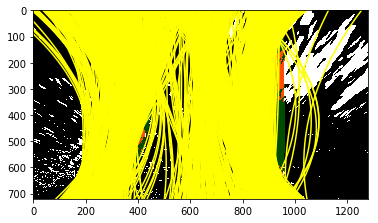

In [17]:
alternative_sample_night_drive_output = 'test_videos_output/alternative_sample_night_drive.mp4'
# clip7 = VideoFileClip("test_videos/alternative_sample_night_drive.mp4").subclip(0,5)
clip7 = VideoFileClip("test_videos/alternative_sample_night_drive.mp4")
alternative_sample_night_drive_clip = clip7.fl_image(adv_lane_pipeline.video_pipeline) #NOTE: this function expects color images!!
%time alternative_sample_night_drive_clip.write_videofile(alternative_sample_night_drive_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(alternative_sample_night_drive_output))

### Video Pipeline- Supplementary Videos: Solid White Right Lane Lines

Left fit combined: [ -5.90762015e-05   2.31997610e-01   1.41016400e+02]
Left_px: [array([301, 301, 301, ..., 715, 715, 715]), array([195, 196, 197, ..., 286, 287, 288])]
Left Lanes 1352.4485 m
Right Lanes 1586.2037 m
Sanity Curve Difference 0.296958578151
Curve- 02 loop
Sanity Fit Difference [ 0.8592255   0.84236066  0.67146686]
Left- 02 loop
Sanity Fit Difference [  3.0763099   12.45237997   0.18743299]
Right- 02 loop
[MoviePy] >>>> Building video test_videos_output/alternative_solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/alternative_solidWhiteRight.mp4


  0%|          | 1/222 [00:02<10:35,  2.87s/it]

Left fit combined: [ -5.90762015e-05   2.31997610e-01   1.41016400e+02]
Left_px: [array([301, 301, 301, ..., 715, 715, 715]), array([195, 196, 197, ..., 286, 287, 288])]
Left Lanes 1352.4485 m
Right Lanes 1586.2037 m
Sanity Curve Difference 0.0
Curve- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Left- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Right- 02 loop


  1%|          | 2/222 [00:05<10:32,  2.87s/it]

Left fit combined: [ -7.22660612e-06   1.53363981e-01   1.68813338e+02]
Left_px: [array([311, 311, 312, ..., 718, 718, 719]), array([199, 200, 199, ..., 269, 270, 272])]
Left Lanes 12164.7129 m
Right Lanes 2093.338 m
Sanity Curve Difference 3.85190148464
Curve- 02 loop
Sanity Fit Difference [ 0.87767314  0.33894155  0.19711848]
Left- 02 loop
Sanity Fit Difference [ 0.44765745  0.21110044  0.04525778]
Right- 02 loop


  1%|▏         | 3/222 [00:08<10:30,  2.88s/it]

Left fit combined: [  2.44572122e-05   1.14467743e-01   1.80761870e+02]
Left_px: [array([319, 320, 320, ..., 718, 719, 719]), array([212, 212, 213, ..., 272, 268, 272])]
Left Lanes 15528.1028 m
Right Lanes 2168.6207 m
Sanity Curve Difference 0.241174101266
Curve- 02 loop
Sanity Fit Difference [ 4.38432893  0.25362043  0.07077955]
Left- 02 loop
Sanity Fit Difference [ 0.48890968  0.16257251  0.02764107]
Right- 02 loop


  2%|▏         | 4/222 [00:11<10:27,  2.88s/it]

Left fit combined: [  5.26227786e-05   7.83150558e-02   1.90782216e+02]
Left_px: [array([197, 197, 197, ..., 719, 719, 719]), array([192, 193, 194, ..., 286, 287, 288])]
Left Lanes 3005.1103 m
Right Lanes 4558.7111 m
Sanity Curve Difference 0.572586336203
Curve- 02 loop
Sanity Fit Difference [ 1.1516262   0.31583297  0.05543396]
Left- 02 loop
Sanity Fit Difference [ 1.64337705  0.33362254  0.04570984]
Right- 02 loop


  2%|▏         | 5/222 [00:14<10:24,  2.88s/it]

Left fit combined: [  7.09404167e-05   6.04861209e-02   1.94683868e+02]
Left_px: [array([196, 196, 197, ..., 653, 653, 653]), array([186, 205, 186, ..., 259, 260, 261])]
Left Lanes 14212.0172 m
Right Lanes 17944.2308 m
Sanity Curve Difference 3.25132300307
Curve- 02 loop
Sanity Fit Difference [ 0.34809333  0.22765654  0.02045081]
Left- 02 loop
Sanity Fit Difference [ 0.22557158  0.06775653  0.01001597]
Right- 02 loop


  3%|▎         | 6/222 [00:17<10:17,  2.86s/it]

Left fit combined: [ -1.98454439e-05   1.55580528e-01   1.67414129e+02]
Left_px: [array([209, 210, 211, ..., 668, 668, 669]), array([184, 185, 185, ..., 278, 279, 263])]
Left Lanes 3711.1172 m
Right Lanes 917.8003 m
Sanity Curve Difference 0.85604920521
Curve- 02 loop
Sanity Fit Difference [ 1.27974806  1.57216904  0.1400719 ]
Left- 02 loop
Sanity Fit Difference [ 1.3729026   0.33819274  0.02500391]
Right- 02 loop


  3%|▎         | 7/222 [00:20<10:23,  2.90s/it]

Left fit combined: [  1.66086197e-04  -2.82985803e-02   2.10719744e+02]
Left_px: [array([223, 224, 224, ..., 684, 684, 684]), array([189, 189, 190, ..., 277, 278, 279])]
Left Lanes 3941.7759 m
Right Lanes 1091.9695 m
Sanity Curve Difference 0.0874562800864
Curve- 02 loop
Sanity Fit Difference [ 9.36898372  1.18189025  0.2586736 ]
Left- 02 loop
Sanity Fit Difference [ 0.69937002  0.04499163  0.00322957]
Right- 02 loop


  4%|▎         | 8/222 [00:23<10:30,  2.95s/it]

Left fit combined: [  3.94198003e-05   1.00998511e-01   1.78230729e+02]
Left_px: [array([235, 235, 235, ..., 702, 702, 702]), array([188, 189, 190, ..., 263, 283, 284])]
Left Lanes 32766.4776 m
Right Lanes 1066.0935 m
Sanity Curve Difference 5.72115268035
Curve- 02 loop
Sanity Fit Difference [ 0.76265457  4.56903101  0.15418116]
Left- 02 loop
Sanity Fit Difference [ 0.29944448  0.04851803  0.00789338]
Right- 02 loop


  4%|▍         | 9/222 [00:27<11:33,  3.26s/it]

Left fit combined: [  1.29649964e-04  -6.52566443e-03   2.10837181e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([192, 193, 192, ..., 281, 282, 283])]
Left Lanes 5490.0718 m
Right Lanes 2601.4738 m
Sanity Curve Difference 0.760835627686
Curve- 02 loop
Sanity Fit Difference [ 2.28895538  1.06461149  0.18294517]
Left- 02 loop
Sanity Fit Difference [ 1.99226959  0.33473658  0.04653708]
Right- 02 loop


  5%|▍         | 10/222 [00:30<11:17,  3.19s/it]

Left fit combined: [  1.43158910e-04  -5.52922292e-02   2.42010421e+02]
Left_px: [array([291, 292, 292, ..., 666, 666, 666]), array([218, 218, 219, ..., 278, 279, 280])]
Left Lanes 1427.8289 m
Right Lanes 10149.0859 m
Sanity Curve Difference 0.430742066989
Curve- 02 loop
Sanity Fit Difference [ 0.10419553  7.47304207  0.14785457]
Left- 02 loop
Sanity Fit Difference [  2.12461214e+00   3.29121534e-01   5.66699955e-04]
Right- 02 loop


  5%|▍         | 11/222 [00:33<11:33,  3.29s/it]

Left fit combined: [  5.47259199e-05  -1.03520589e-02   2.54730570e+02]
Left_px: [array([328, 329, 329, ..., 683, 683, 683]), array([240, 240, 241, ..., 284, 285, 286])]
Left Lanes 4019.4223 m
Right Lanes 1713.8225 m
Sanity Curve Difference 0.504769193256
Curve- 02 loop
Sanity Fit Difference [ 0.61772607  0.81277552  0.05256034]
Left- 02 loop
Sanity Fit Difference [ 0.43466003  0.70685193  0.0704858 ]
Right- 02 loop


  5%|▌         | 12/222 [00:36<11:17,  3.23s/it]

Left fit combined: [  7.86875668e-05  -5.15117914e-02   2.71617007e+02]
Left_px: [array([344, 344, 344, ..., 699, 699, 700]), array([240, 241, 242, ..., 286, 287, 270])]
Left Lanes 8925.7683 m
Right Lanes 1297.6926 m
Sanity Curve Difference 0.783189331444
Curve- 02 loop
Sanity Fit Difference [ 0.43784823  3.9759948   0.06629136]
Left- 02 loop
Sanity Fit Difference [ 1.36112275  0.50524034  0.06392295]
Right- 02 loop


  6%|▌         | 13/222 [00:39<10:56,  3.14s/it]

Left fit combined: [  8.07155971e-05  -3.33496165e-02   2.54888021e+02]
Left_px: [array([345, 345, 346, ..., 716, 716, 716]), array([236, 237, 236, ..., 276, 277, 278])]
Left Lanes 11400.736 m
Right Lanes 16220.7574 m
Sanity Curve Difference 1.70177520488
Curve- 02 loop
Sanity Fit Difference [ 0.0257732   0.35258286  0.06159035]
Left- 02 loop
Sanity Fit Difference [ 6.92899306  0.68326234  0.13751973]
Right- 02 loop


  6%|▋         | 14/222 [00:42<10:43,  3.10s/it]

Left fit combined: [ -8.38707328e-07   9.53396328e-02   2.00578644e+02]
Left_px: [array([328, 328, 328, ..., 719, 719, 719]), array([211, 212, 213, ..., 279, 280, 281])]
Left Lanes 8794.6276 m
Right Lanes 731.4982 m
Sanity Curve Difference 0.655119089459
Curve- 02 loop
Sanity Fit Difference [ 1.0103909   3.85879247  0.21307151]
Left- 02 loop
Sanity Fit Difference [ 1.515741    2.24711214  0.0909071 ]
Right- 02 loop


  7%|▋         | 15/222 [00:45<10:37,  3.08s/it]

Left fit combined: [ -6.63644043e-05   2.08426046e-01   1.48154011e+02]
Left_px: [array([166, 167, 168, ..., 719, 719, 719]), array([176, 177, 177, ..., 258, 259, 264])]
Left Lanes 4505.4977 m
Right Lanes 2205.9533 m
Sanity Curve Difference 0.295468998414
Curve- 02 loop
Sanity Fit Difference [ 78.12701142   1.18614274   0.26136697]
Left- 02 loop
Sanity Fit Difference [ 0.60115061  0.08072434  0.00917316]
Right- 02 loop


  7%|▋         | 16/222 [00:48<10:34,  3.08s/it]

Left fit combined: [ -4.53933299e-05   2.00637750e-01   1.37359704e+02]
Left_px: [array([134, 134, 135, ..., 719, 719, 719]), array([145, 159, 145, ..., 259, 260, 266])]
Left Lanes 1033.154 m
Right Lanes 1324.9831 m
Sanity Curve Difference 0.648639743196
Curve- 02 loop
Sanity Fit Difference [ 0.31599883  0.03736719  0.07285869]
Left- 02 loop
Sanity Fit Difference [ 0.90500196  0.45400994  0.11664016]
Right- 02 loop


  8%|▊         | 17/222 [00:52<10:31,  3.08s/it]

Left fit combined: [ -1.09108084e-04   2.57733567e-01   1.21621437e+02]
Left_px: [array([134, 135, 135, ..., 646, 646, 646]), array([138, 138, 139, ..., 242, 243, 258])]
Left Lanes 385.7318 m
Right Lanes 1809.7522 m
Sanity Curve Difference 0.0689752841574
Curve- 02 loop
Sanity Fit Difference [ 1.40361489  0.28457166  0.11457703]
Left- 02 loop
Sanity Fit Difference [ 7.66547579  0.45925529  0.03308777]
Right- 02 loop


  8%|▊         | 18/222 [00:55<10:31,  3.09s/it]

Left fit combined: [ -3.29483025e-04   4.17239622e-01   1.07110065e+02]
Left_px: [array([166, 166, 166, ..., 664, 664, 664]), array([150, 151, 152, ..., 253, 265, 266])]
Left Lanes 514.8173 m
Right Lanes 2170.3128 m
Sanity Curve Difference 0.223024269914
Curve- 02 loop
Sanity Fit Difference [ 2.01978564  0.61887963  0.11931591]
Left- 02 loop
Sanity Fit Difference [ 0.43679174  0.11994263  0.00517209]
Right- 02 loop


  9%|▊         | 19/222 [00:59<11:28,  3.39s/it]

Left fit combined: [ -1.36311755e-04   2.35243155e-01   1.56276706e+02]
Left_px: [array([209, 209, 209, ..., 683, 683, 683]), array([178, 179, 180, ..., 254, 256, 261])]
Left Lanes 1384.2975 m
Right Lanes 1870.183 m
Sanity Curve Difference 0.212038263795
Curve- 02 loop
Sanity Fit Difference [ 0.58628596  0.43619172  0.45902915]
Left- 02 loop
Sanity Fit Difference [ 2.12592318  0.61982546  0.09164254]
Right- 02 loop


  9%|▉         | 20/222 [01:02<11:30,  3.42s/it]

Left fit combined: [ -1.54700861e-04   2.26566161e-01   1.75759906e+02]
Left_px: [array([235, 236, 236, ..., 701, 701, 701]), array([199, 199, 200, ..., 264, 265, 266])]
Left Lanes 1385.4082 m
Right Lanes 629.5742 m
Sanity Curve Difference 0.380858949199
Curve- 02 loop
Sanity Fit Difference [ 0.13490477  0.03688521  0.12467117]
Left- 02 loop
Sanity Fit Difference [ 0.33760785  0.10551418  0.00215524]
Right- 02 loop


  9%|▉         | 21/222 [01:06<12:02,  3.59s/it]

Left fit combined: [ -9.63010175e-05   1.54141872e-01   2.03043552e+02]
Left_px: [array([270, 271, 271, ..., 718, 718, 718]), array([233, 233, 234, ..., 277, 278, 281])]
Left Lanes 1496.4465 m
Right Lanes 2746.3658 m
Sanity Curve Difference 1.10563235576
Curve- 02 loop
Sanity Fit Difference [ 0.37750173  0.31966066  0.15523248]
Left- 02 loop
Sanity Fit Difference [ 0.1248915   0.09694303  0.03506383]
Right- 02 loop


 10%|▉         | 22/222 [01:10<12:17,  3.69s/it]

Left fit combined: [ -6.28884889e-05   1.19356269e-01   2.14259833e+02]
Left_px: [array([291, 291, 291, ..., 664, 664, 664]), array([223, 224, 225, ..., 277, 278, 279])]
Left Lanes 2064.8653 m
Right Lanes 449.2771 m
Sanity Curve Difference 0.407434919061
Curve- 02 loop
Sanity Fit Difference [ 0.34695925  0.22567263  0.05524076]
Left- 02 loop
Sanity Fit Difference [ 0.27884547  0.10074096  0.02105466]
Right- 02 loop


 10%|█         | 23/222 [01:13<11:31,  3.47s/it]

Left fit combined: [ -1.64064038e-04   2.28297974e-01   1.86086860e+02]
Left_px: [array([291, 291, 291, ..., 681, 681, 681]), array([218, 219, 220, ..., 269, 270, 271])]
Left Lanes 1663.2663 m
Right Lanes 1668.2017 m
Sanity Curve Difference 0.325091223289
Curve- 02 loop
Sanity Fit Difference [ 1.60880872  0.91274388  0.13148976]
Left- 02 loop
Sanity Fit Difference [ 0.52480742  0.15614844  0.03125499]
Right- 02 loop


 11%|█         | 24/222 [01:16<10:50,  3.28s/it]

Left fit combined: [ -2.28463331e-05   9.45579647e-02   2.11389201e+02]
Left_px: [array([319, 319, 319, ..., 696, 696, 696]), array([217, 218, 219, ..., 276, 277, 278])]
Left Lanes 1362.9395 m
Right Lanes 1418.6554 m
Sanity Curve Difference 0.165054288946
Curve- 02 loop
Sanity Fit Difference [ 0.86074747  0.58581339  0.1359706 ]
Left- 02 loop
Sanity Fit Difference [ 1.82937769  0.24039176  0.02224357]
Right- 02 loop


 11%|█▏        | 25/222 [01:19<10:38,  3.24s/it]

Left fit combined: [ -1.76530160e-04   2.76130443e-01   1.58546863e+02]
Left_px: [array([151, 152, 152, ..., 713, 713, 713]), array([185, 185, 186, ..., 277, 278, 279])]
Left Lanes 1107.8266 m
Right Lanes 1974.2027 m
Sanity Curve Difference 0.108007934745
Curve- 02 loop
Sanity Fit Difference [ 6.72684873  1.92022406  0.24997652]
Left- 02 loop
Sanity Fit Difference [ 1.0080695   0.39905382  0.08045965]
Right- 02 loop


 12%|█▏        | 26/222 [01:22<10:40,  3.27s/it]

Left fit combined: [ -2.70907925e-04   3.70581267e-01   1.38008479e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([178, 178, 179, ..., 279, 280, 281])]
Left Lanes 1385.7355 m
Right Lanes 726.7965 m
Sanity Curve Difference 0.314564581398
Curve- 02 loop
Sanity Fit Difference [ 0.53462686  0.34205147  0.12954141]
Left- 02 loop
Sanity Fit Difference [ 0.68845375  0.38365731  0.11873359]
Right- 02 loop


 12%|█▏        | 27/222 [01:25<10:19,  3.17s/it]

Left fit combined: [ -1.81628557e-04   2.73972436e-01   1.63548635e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([188, 188, 189, ..., 277, 278, 281])]
Left Lanes 1103.7055 m
Right Lanes 5184.6636 m
Sanity Curve Difference 1.97669765252
Curve- 02 loop
Sanity Fit Difference [ 0.32955613  0.2606954   0.18506222]
Left- 02 loop
Sanity Fit Difference [ 1.1755607   0.37255043  0.07266807]
Right- 02 loop


 13%|█▎        | 28/222 [01:29<10:16,  3.18s/it]

Left fit combined: [ -2.03707822e-04   3.00546374e-01   1.54579216e+02]
Left_px: [array([197, 197, 197, ..., 719, 719, 719]), array([192, 193, 194, ..., 271, 272, 280])]
Left Lanes 912.5547 m
Right Lanes 7263.106 m
Sanity Curve Difference 0.300124168864
Curve- 02 loop
Sanity Fit Difference [ 0.12156274  0.09699493  0.05484252]
Left- 02 loop
Sanity Fit Difference [ 0.14915562  0.06351784  0.01483538]
Right- 02 loop


 13%|█▎        | 29/222 [01:32<10:31,  3.27s/it]

Left fit combined: [ -3.75449718e-04   4.51610019e-01   1.24408484e+02]
Left_px: [array([210, 211, 211, ..., 651, 651, 651]), array([197, 197, 198, ..., 268, 269, 270])]
Left Lanes 1187.4326 m
Right Lanes 67007.5733 m
Sanity Curve Difference 7.34122264216
Curve- 02 loop
Sanity Fit Difference [ 0.84307954  0.50263007  0.19517975]
Left- 02 loop
Sanity Fit Difference [ 0.45787188  0.1745725   0.03604384]
Right- 02 loop


 14%|█▎        | 30/222 [01:35<10:35,  3.31s/it]

Left fit combined: [ -3.03714401e-04   3.97356959e-01   1.28562545e+02]
Left_px: [array([196, 197, 197, ..., 666, 667, 667]), array([180, 180, 181, ..., 278, 259, 260])]
Left Lanes 796.187 m
Right Lanes 771.0062 m
Sanity Curve Difference 0.977018945296
Curve- 02 loop
Sanity Fit Difference [ 0.19106505  0.12013254  0.0333905 ]
Left- 02 loop
Sanity Fit Difference [ 2.47298132  0.67649297  0.1316797 ]
Right- 02 loop


 14%|█▍        | 31/222 [01:39<11:01,  3.46s/it]

Left fit combined: [ -1.83890453e-04   3.03268406e-01   1.40936866e+02]
Left_px: [array([223, 223, 223, ..., 682, 682, 682]), array([183, 184, 185, ..., 276, 277, 278])]
Left Lanes 969.9198 m
Right Lanes 1860.6749 m
Sanity Curve Difference 0.806155646919
Curve- 02 loop
Sanity Fit Difference [ 0.39452837  0.23678597  0.09625137]
Left- 02 loop
Sanity Fit Difference [ 0.68008593  0.72931264  0.03075288]
Right- 02 loop


 14%|█▍        | 32/222 [01:43<10:56,  3.46s/it]

Left fit combined: [ -2.26837198e-04   3.60786410e-01   1.21718333e+02]
Left_px: [array([236, 236, 237, ..., 699, 699, 699]), array([188, 189, 188, ..., 278, 279, 280])]
Left Lanes 1009.5978 m
Right Lanes 2228.8627 m
Sanity Curve Difference 0.144091906488
Curve- 02 loop
Sanity Fit Difference [ 0.23354527  0.18966039  0.13636271]
Left- 02 loop
Sanity Fit Difference [ 0.45136535  0.0900419   0.00750062]
Right- 02 loop


 15%|█▍        | 33/222 [01:47<11:14,  3.57s/it]

Left fit combined: [ -1.85334081e-04   3.25709688e-01   1.26961529e+02]
Left_px: [array([235, 235, 235, ..., 716, 716, 716]), array([176, 177, 178, ..., 279, 280, 281])]
Left Lanes 802.6872 m
Right Lanes 2225.939 m
Sanity Curve Difference 0.0647944969592
Curve- 02 loop
Sanity Fit Difference [ 0.18296434  0.09722296  0.04307647]
Left- 02 loop
Sanity Fit Difference [ 1.28225448  0.47059783  0.04134265]
Right- 02 loop


 15%|█▌        | 34/222 [01:50<11:12,  3.58s/it]

Left fit combined: [ -2.31204380e-04   3.75947050e-01   1.15560819e+02]
Left_px: [array([271, 271, 272, ..., 661, 661, 661]), array([195, 196, 195, ..., 274, 275, 276])]
Left Lanes 993.1091 m
Right Lanes 729.5267 m
Sanity Curve Difference 0.431215418582
Curve- 02 loop
Sanity Fit Difference [ 0.24750062  0.15423969  0.08979657]
Left- 02 loop
Sanity Fit Difference [ 0.0939625   0.11373454  0.0010972 ]
Right- 02 loop


 16%|█▌        | 35/222 [01:53<10:42,  3.44s/it]

Left fit combined: [ -2.90235514e-04   4.21859649e-01   1.13687425e+02]
Left_px: [array([271, 271, 272, ..., 678, 678, 678]), array([195, 196, 195, ..., 277, 278, 279])]
Left Lanes 615.644 m
Right Lanes 920.5828 m
Sanity Curve Difference 0.10821151439
Curve- 02 loop
Sanity Fit Difference [ 0.25532014  0.12212517  0.01621132]
Left- 02 loop
Sanity Fit Difference [ 0.08198141  0.01762424  0.01286147]
Right- 02 loop


 16%|█▌        | 36/222 [01:57<10:30,  3.39s/it]

Left fit combined: [ -2.59375755e-04   3.83886884e-01   1.27173865e+02]
Left_px: [array([291, 292, 292, ..., 695, 695, 695]), array([202, 202, 203, ..., 279, 280, 281])]
Left Lanes 707.668 m
Right Lanes 1771.4738 m
Sanity Curve Difference 0.61378633672
Curve- 02 loop
Sanity Fit Difference [ 0.10632661  0.09001279  0.11862736]
Left- 02 loop
Sanity Fit Difference [ 1.21668522  2.70904035  0.12203542]
Right- 02 loop


 17%|█▋        | 37/222 [02:00<10:37,  3.45s/it]

Left fit combined: [ -2.77257730e-04   4.03161002e-01   1.23801116e+02]
Left_px: [array([310, 310, 311, ..., 712, 712, 712]), array([209, 219, 209, ..., 265, 266, 267])]
Left Lanes 853.6864 m
Right Lanes 1666.1714 m
Sanity Curve Difference 0.0164234019929
Curve- 02 loop
Sanity Fit Difference [ 0.06894235  0.0502078   0.02652077]
Left- 02 loop
Sanity Fit Difference [ 1.20985427  0.17022716  0.03306599]
Right- 02 loop


 17%|█▋        | 38/222 [02:04<10:35,  3.45s/it]

Left fit combined: [ -2.87987895e-04   4.19434616e-01   1.17687337e+02]
Left_px: [array([319, 319, 319, ..., 718, 718, 719]), array([207, 208, 209, ..., 264, 265, 264])]
Left Lanes 1976.3479 m
Right Lanes 3883.3327 m
Sanity Curve Difference 1.32540131817
Curve- 02 loop
Sanity Fit Difference [ 0.03870105  0.04036505  0.04938388]
Left- 02 loop
Sanity Fit Difference [ 3.12392242  0.1407425   0.02725718]
Right- 02 loop


 18%|█▊        | 39/222 [02:07<10:27,  3.43s/it]

Left fit combined: [ -3.14869746e-04   4.61704395e-01   9.91685268e+01]
Left_px: [array([319, 319, 320, ..., 719, 719, 719]), array([197, 212, 197, ..., 263, 264, 265])]
Left Lanes 3599.1745 m
Right Lanes 42550.5263 m
Sanity Curve Difference 6.87580476477
Curve- 02 loop
Sanity Fit Difference [ 0.09334368  0.10077799  0.15735602]
Left- 02 loop
Sanity Fit Difference [ 7.56336621  1.18891169  0.14988137]
Right- 02 loop


 18%|█▊        | 40/222 [02:10<10:21,  3.41s/it]

Left fit combined: [ -2.85578692e-04   4.50522442e-01   9.19233718e+01]
Left_px: [array([328, 329, 329, ..., 719, 719, 719]), array([196, 196, 197, ..., 261, 262, 263])]
Left Lanes 1050.2507 m
Right Lanes 5589.5798 m
Sanity Curve Difference 0.856124085538
Curve- 02 loop
Sanity Fit Difference [ 0.09302594  0.02421886  0.07305902]
Left- 02 loop
Sanity Fit Difference [ 0.28231694  1.50080515  0.01825722]
Right- 02 loop


 18%|█▊        | 41/222 [02:13<10:04,  3.34s/it]

Left fit combined: [ -9.90487794e-04   1.11158707e+00  -6.23697502e+01]
Left_px: [array([337, 337, 337, ..., 579, 580, 580]), array([190, 191, 204, ..., 267, 267, 268])]
Left Lanes 1381.4831 m
Right Lanes 4536.8946 m
Sanity Curve Difference 0.108655288843
Curve- 02 loop
Sanity Fit Difference [ 2.46835329  1.46732896  1.6784972 ]
Left- 02 loop
Sanity Fit Difference [ 0.83033527  7.49640196  0.06589847]
Right- 02 loop


 19%|█▉        | 42/222 [02:17<10:26,  3.48s/it]

Left fit combined: [ -9.78863125e-04   1.12913137e+00  -7.54882300e+01]
Left_px: [array([352, 352, 352, ..., 594, 594, 594]), array([187, 188, 189, ..., 264, 265, 266])]
Left Lanes 1872.4703 m
Right Lanes 21031.0377 m
Sanity Curve Difference 2.86989630231
Curve- 02 loop
Sanity Fit Difference [ 0.01173631  0.01578311  0.21033401]
Left- 02 loop
Sanity Fit Difference [ 6.27436552  1.23324662  0.11196917]
Right- 02 loop


 19%|█▉        | 43/222 [02:20<10:05,  3.38s/it]

Left fit combined: [ -8.11307899e-04   9.89824765e-01  -5.16312107e+01]
Left_px: [array([367, 367, 367, ..., 680, 680, 681]), array([194, 195, 196, ..., 254, 255, 257])]
Left Lanes 1102.3542 m
Right Lanes 1252.1852 m
Sanity Curve Difference 0.897197435535
Curve- 02 loop
Sanity Fit Difference [ 0.17117329  0.12337502  0.31603628]
Left- 02 loop
Sanity Fit Difference [ 0.75988991  4.40626413  0.07929094]
Right- 02 loop


 20%|█▉        | 44/222 [02:24<09:54,  3.34s/it]

Left fit combined: [ -5.56021808e-04   7.90282690e-01  -2.32084523e+01]
Left_px: [array([381, 381, 381, ..., 697, 697, 698]), array([187, 188, 189, ..., 264, 265, 263])]
Left Lanes 791.5533 m
Right Lanes 2233.1946 m
Sanity Curve Difference 0.284645296012
Curve- 02 loop
Sanity Fit Difference [ 0.31465994  0.20159333  0.55049568]
Left- 02 loop
Sanity Fit Difference [ 0.79294729  0.29481036  0.01615462]
Right- 02 loop


 20%|██        | 45/222 [02:27<09:47,  3.32s/it]

Left fit combined: [ -3.68863557e-04   5.99262966e-01   2.44327130e+01]
Left_px: [array([388, 389, 389, ..., 715, 715, 715]), array([190, 190, 191, ..., 280, 281, 282])]
Left Lanes 6743.1185 m
Right Lanes 3341.3711 m
Sanity Curve Difference 2.33399338206
Curve- 02 loop
Sanity Fit Difference [ 0.33660236  0.24171063  2.05275064]
Left- 02 loop
Sanity Fit Difference [ 3.53915522  0.24417526  0.02119482]
Right- 02 loop


 21%|██        | 46/222 [02:30<09:29,  3.23s/it]

Left fit combined: [  1.17381180e-04   8.59349838e-02   1.54109735e+02]
Left_px: [array([248, 248, 249, ..., 658, 658, 658]), array([169, 170, 169, ..., 269, 270, 271])]
Left Lanes 1974.4805 m
Right Lanes 4066.5157 m
Sanity Curve Difference 0.400961625087
Curve- 02 loop
Sanity Fit Difference [ 1.31822385  0.85659887  5.30751628]
Left- 02 loop
Sanity Fit Difference [ 1.24709074  0.47974476  0.02875905]
Right- 02 loop


 21%|██        | 47/222 [02:33<09:32,  3.27s/it]

Left fit combined: [  6.43057799e-05   1.47851702e-01   1.33957882e+02]
Left_px: [array([259, 259, 259, ..., 675, 675, 675]), array([168, 169, 170, ..., 269, 270, 271])]
Left Lanes 2158.3421 m
Right Lanes 11345.4693 m
Sanity Curve Difference 1.23536166931
Curve- 02 loop
Sanity Fit Difference [ 0.45216277  0.72050655  0.13076301]
Left- 02 loop
Sanity Fit Difference [ 2.73475716  0.19794855  0.02281496]
Right- 02 loop


 22%|██▏       | 48/222 [02:37<09:27,  3.26s/it]

Left fit combined: [  5.68335620e-05   1.39567246e-01   1.40922905e+02]
Left_px: [array([270, 270, 271, ..., 692, 692, 692]), array([178, 189, 178, ..., 270, 271, 272])]
Left Lanes 1202.2765 m
Right Lanes 12853.721 m
Sanity Curve Difference 0.0408911314453
Curve- 02 loop
Sanity Fit Difference [ 0.11619823  0.0560322   0.05199413]
Left- 02 loop
Sanity Fit Difference [ 4.13978625  0.60055281  0.04598807]
Right- 02 loop


 22%|██▏       | 49/222 [02:40<09:30,  3.30s/it]

Left fit combined: [  1.04555966e-04   6.23894568e-02   1.69585805e+02]
Left_px: [array([291, 291, 291, ..., 709, 709, 709]), array([176, 177, 178, ..., 265, 266, 267])]
Left Lanes 1635.1199 m
Right Lanes 3673.617 m
Sanity Curve Difference 0.62231517558
Curve- 02 loop
Sanity Fit Difference [ 0.83968702  0.55297924  0.20339419]
Left- 02 loop
Sanity Fit Difference [ 1.39381667  2.75240234  0.08960056]
Right- 02 loop


 23%|██▎       | 50/222 [02:44<09:57,  3.48s/it]

Left fit combined: [  4.76266209e-05   1.30356889e-01   1.47598347e+02]
Left_px: [array([291, 292, 292, ..., 719, 719, 719]), array([176, 176, 177, ..., 265, 266, 267])]
Left Lanes 2435.8449 m
Right Lanes 1636.6085 m
Sanity Curve Difference 0.23287714319
Curve- 02 loop
Sanity Fit Difference [ 0.54448682  1.08940574  0.12965388]
Left- 02 loop
Sanity Fit Difference [ 1.47748745  0.29305603  0.03709103]
Right- 02 loop


 23%|██▎       | 51/222 [02:48<10:36,  3.72s/it]

Left fit combined: [  2.11738837e-05   1.57962356e-01   1.39422445e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([158, 158, 159, ..., 266, 267, 268])]
Left Lanes 2100.6318 m
Right Lanes 2309.1422 m
Sanity Curve Difference 0.0828297931332
Curve- 02 loop
Sanity Fit Difference [ 0.55541915  0.21176838  0.05539291]
Left- 02 loop
Sanity Fit Difference [ 0.02898633  0.01273159  0.00597264]
Right- 02 loop


 23%|██▎       | 52/222 [02:53<11:49,  4.18s/it]

Left fit combined: [  5.00197109e-05   1.26976180e-01   1.43960286e+02]
Left_px: [array([319, 320, 320, ..., 719, 719, 719]), array([177, 177, 178, ..., 264, 265, 266])]
Left Lanes 13492.7467 m
Right Lanes 3428.4522 m
Sanity Curve Difference 2.83720326389
Curve- 02 loop
Sanity Fit Difference [ 1.36233048  0.19616178  0.03254742]
Left- 02 loop
Sanity Fit Difference [ 1.57765679  0.597281    0.10870205]
Right- 02 loop


 24%|██▍       | 53/222 [02:57<11:40,  4.15s/it]

Left fit combined: [  4.18363038e-05   1.60606583e-01   1.26892109e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([156, 156, 157, ..., 270, 271, 272])]
Left Lanes 1106.7201 m
Right Lanes 2100.6034 m
Sanity Curve Difference 0.810455306977
Curve- 02 loop
Sanity Fit Difference [ 0.16360365  0.264856    0.1185617 ]
Left- 02 loop
Sanity Fit Difference [ 1.27557318  0.68771607  0.04501062]
Right- 02 loop


 24%|██▍       | 54/222 [03:01<11:21,  4.06s/it]

Left fit combined: [  1.40761361e-04   7.77519093e-02   1.41379641e+02]
Left_px: [array([196, 196, 196, ..., 661, 661, 661]), array([155, 156, 157, ..., 257, 258, 259])]
Left Lanes 522.1102 m
Right Lanes 2381.9172 m
Sanity Curve Difference 0.0945635801426
Curve- 02 loop
Sanity Fit Difference [ 2.36457451  0.51588591  0.11417205]
Left- 02 loop
Sanity Fit Difference [ 0.25975064  0.05832844  0.01183293]
Right- 02 loop


 25%|██▍       | 55/222 [03:06<12:11,  4.38s/it]

Left fit combined: [  3.49107474e-04  -2.07560224e-01   2.35267846e+02]
Left_px: [array([382, 382, 383, ..., 678, 679, 679]), array([209, 210, 209, ..., 261, 243, 244])]
Left Lanes 3697.2556 m
Right Lanes 3003.357 m
Sanity Curve Difference 1.30735166883
Curve- 02 loop
Sanity Fit Difference [ 1.4801371   3.66951932  0.66408575]
Left- 02 loop
Sanity Fit Difference [ 1.3837051   0.12241369  0.01197127]
Right- 02 loop


 25%|██▌       | 56/222 [03:10<11:38,  4.21s/it]

Left fit combined: [ -7.70624047e-05   2.22449228e-01   1.33429704e+02]
Left_px: [array([236, 236, 237, ..., 696, 697, 697]), array([176, 177, 176, ..., 263, 269, 270])]
Left Lanes 1003.44 m
Right Lanes 1434.3615 m
Sanity Curve Difference 0.636182294709
Curve- 02 loop
Sanity Fit Difference [ 1.22074121  2.07173342  0.43286044]
Left- 02 loop
Sanity Fit Difference [ 2.55196964  0.02748102  0.01000164]
Right- 02 loop


 26%|██▌       | 57/222 [03:14<10:56,  3.98s/it]

Left fit combined: [  5.16708638e-05   9.62538630e-02   1.65413858e+02]
Left_px: [array([270, 270, 270, ..., 715, 715, 715]), array([189, 190, 191, ..., 253, 255, 256])]
Left Lanes 918.1413 m
Right Lanes 992.7361 m
Sanity Curve Difference 0.216147253282
Curve- 02 loop
Sanity Fit Difference [ 1.67050677  0.56729963  0.2397079 ]
Left- 02 loop
Sanity Fit Difference [ 4.14269516  0.71144517  0.0796849 ]
Right- 02 loop


 26%|██▌       | 58/222 [03:17<10:14,  3.75s/it]

Left fit combined: [  6.42941044e-05   4.21615033e-02   1.96482452e+02]
Left_px: [array([291, 291, 291, ..., 662, 662, 663]), array([197, 198, 199, ..., 261, 262, 253])]
Left Lanes 840.0119 m
Right Lanes 1771.1928 m
Sanity Curve Difference 0.366495148398
Curve- 02 loop
Sanity Fit Difference [ 0.24430094  0.56197599  0.1878234 ]
Left- 02 loop
Sanity Fit Difference [ 0.18463614  0.01178094  0.01112494]
Right- 02 loop


 27%|██▋       | 59/222 [03:20<09:41,  3.57s/it]

Left fit combined: [  2.57774081e-04  -1.54115314e-01   2.40773032e+02]
Left_px: [array([301, 301, 301, ..., 678, 678, 678]), array([195, 196, 197, ..., 262, 263, 264])]
Left Lanes 879.2236 m
Right Lanes 1066.3664 m
Sanity Curve Difference 0.254907114243
Curve- 02 loop
Sanity Fit Difference [ 3.00929578  4.65535624  0.22541749]
Left- 02 loop
Sanity Fit Difference [ 0.39375756  0.07398608  0.01046063]
Right- 02 loop


 27%|██▋       | 60/222 [03:23<09:14,  3.42s/it]

Left fit combined: [  3.37295070e-05   1.04881224e-01   1.65062603e+02]
Left_px: [array([291, 292, 292, ..., 694, 694, 694]), array([207, 207, 208, ..., 261, 262, 263])]
Left Lanes 594.6104 m
Right Lanes 896.5611 m
Sanity Curve Difference 0.233563360676
Curve- 02 loop
Sanity Fit Difference [ 0.8691509   1.68053733  0.3144473 ]
Left- 02 loop
Sanity Fit Difference [ 0.22829417  0.05425943  0.00756044]
Right- 02 loop


 27%|██▋       | 61/222 [03:26<08:57,  3.34s/it]

Left fit combined: [ -1.22652794e-04   2.56185992e-01   1.34418442e+02]
Left_px: [array([337, 337, 338, ..., 712, 712, 712]), array([204, 205, 205, ..., 265, 266, 267])]
Left Lanes 2544.4509 m
Right Lanes 1130.9089 m
Sanity Curve Difference 1.46474652324
Curve- 02 loop
Sanity Fit Difference [ 4.63636485  1.44262969  0.18565175]
Left- 02 loop
Sanity Fit Difference [ 0.10881728  0.00570334  0.01027619]
Right- 02 loop


 28%|██▊       | 62/222 [03:29<08:45,  3.29s/it]

Left fit combined: [ -1.14001504e-04   2.52558594e-01   1.32127234e+02]
Left_px: [array([344, 344, 344, ..., 719, 719, 719]), array([198, 199, 200, ..., 254, 255, 256])]
Left Lanes 862.185 m
Right Lanes 1118.3724 m
Sanity Curve Difference 0.461125559966
Curve- 02 loop
Sanity Fit Difference [ 0.0705348   0.01415924  0.01704534]
Left- 02 loop
Sanity Fit Difference [  4.60769737e-02   8.33815908e-03   9.79338149e-05]
Right- 02 loop


 28%|██▊       | 63/222 [03:33<08:34,  3.24s/it]

Left fit combined: [  1.95099134e-05   8.14031562e-02   1.86894564e+02]
Left_px: [array([368, 368, 369, ..., 719, 719, 719]), array([207, 208, 208, ..., 260, 265, 266])]
Left Lanes 27976.7333 m
Right Lanes 1136.3195 m
Sanity Curve Difference 13.6994236051
Curve- 02 loop
Sanity Fit Difference [ 1.17113733  0.67768606  0.41450448]
Left- 02 loop
Sanity Fit Difference [ 0.24947675  0.05429317  0.00373767]
Right- 02 loop


 29%|██▉       | 64/222 [03:36<08:26,  3.20s/it]

Left fit combined: [ -3.53056727e-06   1.12968686e-01   1.75944766e+02]
Left_px: [array([360, 360, 360, ..., 719, 719, 719]), array([200, 201, 202, ..., 264, 265, 266])]
Left Lanes 5756.8858 m
Right Lanes 1370.0878 m
Sanity Curve Difference 0.755196623932
Curve- 02 loop
Sanity Fit Difference [ 1.18096273  0.38776788  0.0585881 ]
Left- 02 loop
Sanity Fit Difference [ 0.22276044  0.06079526  0.01462711]
Right- 02 loop


 29%|██▉       | 65/222 [03:39<08:24,  3.22s/it]

Left fit combined: [ -5.85012465e-04   6.67576874e-01   4.69860623e+01]
Left_px: [array([368, 368, 369, ..., 648, 648, 648]), array([203, 204, 203, ..., 239, 240, 241])]
Left Lanes 1500.3807 m
Right Lanes 2617.1969 m
Sanity Curve Difference 0.422254409065
Curve- 02 loop
Sanity Fit Difference [ 164.69928293    4.90939755    0.73294993]
Left- 02 loop
Sanity Fit Difference [ 0.44819296  0.14129638  0.03528098]
Right- 02 loop


 30%|██▉       | 66/222 [03:42<08:21,  3.22s/it]

Left fit combined: [ -2.63532915e-04   3.62156252e-01   1.14818329e+02]
Left_px: [array([388, 388, 388, ..., 664, 664, 664]), array([199, 200, 201, ..., 247, 248, 249])]
Left Lanes 1640.9746 m
Right Lanes 7622.0471 m
Sanity Curve Difference 1.24962892726
Curve- 02 loop
Sanity Fit Difference [ 0.54952598  0.4575063   1.44366782]
Left- 02 loop
Sanity Fit Difference [ 0.11870079  0.03574771  0.00658222]
Right- 02 loop


 30%|███       | 67/222 [03:45<08:15,  3.19s/it]

Left fit combined: [ -2.81930754e-04   3.97982349e-01   9.30546431e+01]
Left_px: [array([388, 388, 388, ..., 679, 679, 679]), array([186, 187, 188, ..., 242, 243, 244])]
Left Lanes 2726.1527 m
Right Lanes 4916.7902 m
Sanity Curve Difference 0.174897436945
Curve- 02 loop
Sanity Fit Difference [ 0.0698123   0.09892442  0.18954888]
Left- 02 loop
Sanity Fit Difference [ 0.81494654  0.36695442  0.11657778]
Right- 02 loop


 31%|███       | 68/222 [03:49<08:27,  3.30s/it]

Left fit combined: [ -2.20773682e-04   3.63337478e-01   9.25085569e+01]
Left_px: [array([236, 236, 237, ..., 696, 696, 696]), array([164, 165, 165, ..., 244, 254, 255])]
Left Lanes 1721.4517 m
Right Lanes 1429.6705 m
Sanity Curve Difference 0.587708258078
Curve- 02 loop
Sanity Fit Difference [ 0.21692232  0.08705127  0.00586845]
Left- 02 loop
Sanity Fit Difference [ 0.98257722  0.10799905  0.01477787]
Right- 02 loop


 31%|███       | 69/222 [03:53<08:59,  3.53s/it]

Left fit combined: [ -1.66477827e-04   3.06579928e-01   1.09288120e+02]
Left_px: [array([413, 413, 414, ..., 714, 714, 714]), array([194, 195, 194, ..., 251, 252, 253])]
Left Lanes 7611.4894 m
Right Lanes 2282.2522 m
Sanity Curve Difference 2.13975177023
Curve- 02 loop
Sanity Fit Difference [ 0.24593445  0.15621166  0.1813839 ]
Left- 02 loop
Sanity Fit Difference [ 0.38085281  0.10705509  0.02553495]
Right- 02 loop


 32%|███▏      | 70/222 [03:57<09:25,  3.72s/it]

Left fit combined: [ -1.65180010e-04   3.00756406e-01   1.13435956e+02]
Left_px: [array([270, 271, 271, ..., 658, 658, 658]), array([178, 178, 179, ..., 250, 251, 252])]
Left Lanes 2649.1413 m
Right Lanes 1636.5028 m
Sanity Curve Difference 0.56683282364
Curve- 02 loop
Sanity Fit Difference [ 0.00779574  0.01899512  0.03795323]
Left- 02 loop
Sanity Fit Difference [ 0.22740047  0.05467766  0.00725597]
Right- 02 loop


 32%|███▏      | 71/222 [04:01<09:35,  3.81s/it]

Left fit combined: [ -1.66753686e-04   3.11434714e-01   1.06243242e+02]
Left_px: [array([281, 281, 281, ..., 674, 674, 674]), array([171, 172, 173, ..., 248, 249, 250])]
Left Lanes 1896.1219 m
Right Lanes 2910.7602 m
Sanity Curve Difference 0.121624190652
Curve- 02 loop
Sanity Fit Difference [ 0.00952704  0.03550484  0.06340771]
Left- 02 loop
Sanity Fit Difference [ 1.60618222  0.35342878  0.06823672]
Right- 02 loop


 32%|███▏      | 72/222 [04:05<09:33,  3.83s/it]

Left fit combined: [ -1.79937827e-04   3.27008312e-01   1.00470403e+02]
Left_px: [array([281, 281, 282, ..., 690, 690, 690]), array([166, 167, 166, ..., 248, 249, 250])]
Left Lanes 1327.6191 m
Right Lanes 3605.388 m
Sanity Curve Difference 0.0262384147969
Curve- 02 loop
Sanity Fit Difference [ 0.07906357  0.05000598  0.05433606]
Left- 02 loop
Sanity Fit Difference [ 0.86460598  0.16406944  0.01665366]
Right- 02 loop


 33%|███▎      | 73/222 [04:09<09:19,  3.75s/it]

Left fit combined: [  1.44078163e-05   1.23145696e-01   1.51259412e+02]
Left_px: [array([311, 311, 311, ..., 708, 708, 708]), array([179, 180, 194, ..., 253, 254, 255])]
Left Lanes 1280.737 m
Right Lanes 6712.2345 m
Sanity Curve Difference 0.620304073586
Curve- 02 loop
Sanity Fit Difference [ 1.08007108  0.62341723  0.50551214]
Left- 02 loop
Sanity Fit Difference [  5.25805807e+00   7.30255636e-02   5.24623312e-05]
Right- 02 loop


 33%|███▎      | 74/222 [04:12<08:59,  3.64s/it]

Left fit combined: [ -1.39925929e-05   1.38207143e-01   1.55024802e+02]
Left_px: [array([344, 345, 345, ..., 719, 719, 719]), array([202, 193, 194, ..., 242, 243, 244])]
Left Lanes 887.1081 m
Right Lanes 6711.2737 m
Sanity Curve Difference 0.0493670822657
Curve- 02 loop
Sanity Fit Difference [ 1.97118068  0.12230592  0.02489359]
Left- 02 loop
Sanity Fit Difference [ 2.23615779  0.36560605  0.04888807]
Right- 02 loop


 34%|███▍      | 75/222 [04:15<08:43,  3.56s/it]

Left fit combined: [ -6.01576786e-05   2.05736508e-01   1.29293723e+02]
Left_px: [array([336, 336, 336, ..., 719, 719, 719]), array([180, 181, 182, ..., 244, 245, 246])]
Left Lanes 2794.6349 m
Right Lanes 5285.2234 m
Sanity Curve Difference 0.0633656645227
Curve- 02 loop
Sanity Fit Difference [ 3.29925168  0.4886098   0.1659804 ]
Left- 02 loop
Sanity Fit Difference [ 1.24178942  0.18836004  0.03334775]
Right- 02 loop


 34%|███▍      | 76/222 [04:19<09:04,  3.73s/it]

Left fit combined: [ -7.64716590e-05   2.35449858e-01   1.13936337e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([149, 150, 150, ..., 242, 243, 248])]
Left Lanes 3917.2399 m
Right Lanes 1589.2325 m
Sanity Curve Difference 0.318493945071
Curve- 02 loop
Sanity Fit Difference [ 0.271187    0.14442429  0.11877905]
Left- 02 loop
Sanity Fit Difference [  2.08647615e+00   5.10472406e-02   9.83121596e-04]
Right- 02 loop


 35%|███▍      | 77/222 [04:24<09:18,  3.85s/it]

Left fit combined: [  1.94738559e-05   1.57239800e-01   1.22805514e+02]
Left_px: [array([196, 196, 196, ..., 719, 719, 719]), array([149, 150, 151, ..., 246, 251, 252])]
Left Lanes 712.3291 m
Right Lanes 3172.9682 m
Sanity Curve Difference 0.294412630912
Curve- 02 loop
Sanity Fit Difference [ 1.25465455  0.33217288  0.07784327]
Left- 02 loop
Sanity Fit Difference [ 4.01159551  0.14219936  0.01716488]
Right- 02 loop


 35%|███▌      | 78/222 [04:28<09:38,  4.02s/it]

Left fit combined: [ -5.68006181e-05   2.12429758e-01   1.15722256e+02]
Left_px: [array([210, 211, 211, ..., 661, 661, 661]), array([154, 154, 155, ..., 236, 244, 245])]
Left Lanes 783.953 m
Right Lanes 854.1323 m
Sanity Curve Difference 0.578388679187
Curve- 02 loop
Sanity Fit Difference [ 3.91676279  0.3509923   0.05767866]
Left- 02 loop
Sanity Fit Difference [ 0.72980356  0.11399038  0.01263985]
Right- 02 loop


 36%|███▌      | 79/222 [04:32<09:45,  4.10s/it]

Left fit combined: [ -7.77223788e-05   2.31898585e-01   1.12440886e+02]
Left_px: [array([223, 223, 223, ..., 678, 679, 679]), array([153, 154, 155, ..., 250, 231, 232])]
Left Lanes 580.6234 m
Right Lanes 838.4868 m
Sanity Curve Difference 0.133677515122
Curve- 02 loop
Sanity Fit Difference [ 0.36833685  0.0916483   0.02835557]
Left- 02 loop
Sanity Fit Difference [ 4.148974    0.21529221  0.02310629]
Right- 02 loop


 36%|███▌      | 80/222 [04:36<09:41,  4.09s/it]

Left fit combined: [ -1.75233846e-04   2.97115687e-01   1.07716142e+02]
Left_px: [array([ 58,  59,  59, ..., 696, 696, 696]), array([117, 117, 118, ..., 234, 235, 239])]
Left Lanes 394.8421 m
Right Lanes 822.626 m
Sanity Curve Difference 0.142090486931
Curve- 02 loop
Sanity Fit Difference [ 1.25461249  0.28123114  0.0420198 ]
Left- 02 loop
Sanity Fit Difference [ 0.05625977  0.00693907  0.00072647]
Right- 02 loop


 36%|███▋      | 81/222 [04:41<09:43,  4.13s/it]

Left fit combined: [  5.77540683e-06   1.28615836e-01   1.42974565e+02]
Left_px: [array([235, 236, 236, ..., 713, 713, 713]), array([152, 152, 153, ..., 236, 237, 238])]
Left Lanes 1062.8296 m
Right Lanes 719.2241 m
Sanity Curve Difference 0.463737463944
Curve- 02 loop
Sanity Fit Difference [ 1.03295828  0.56711866  0.3273272 ]
Left- 02 loop
Sanity Fit Difference [ 0.66732617  0.16986317  0.0193785 ]
Right- 02 loop


 37%|███▋      | 82/222 [04:45<09:45,  4.18s/it]

Left fit combined: [  4.75361715e-04  -4.48275526e-01   3.20008701e+02]
Left_px: [array([600, 600, 600, 600, 600, 600, 600, 600, 601, 601, 601, 601, 601,
       601, 601, 601, 601, 601, 601, 601, 602, 602, 602, 602, 602, 602,
       602, 602, 602, 602, 602, 602, 602, 602, 603, 603, 603, 603, 603,
       603, 603, 603, 603, 603, 603, 603, 603, 603, 603, 603, 603, 603,
       604, 604, 604, 604, 604, 604, 604, 604, 604, 604, 604, 604, 604,
       604, 604, 604, 604, 604, 604, 605, 605, 605, 605, 605, 605, 605,
       605, 605, 605, 605, 605, 605, 605, 605, 605, 605, 605, 606, 606,
       606, 606, 606, 606, 606, 606, 606, 606, 606, 606, 606, 606, 606,
       606, 606, 606, 606, 607, 607, 607, 607, 607, 607, 607, 607, 607,
       607, 607, 607, 607, 607, 607, 608, 608, 608, 608, 608, 608, 608,
       608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 608, 609, 609,
       609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610,
       610, 610, 610, 610, 610, 610, 610, 610, 610, 61

 37%|███▋      | 83/222 [04:48<09:11,  3.96s/it]

Left fit combined: [ -1.67389872e-04   3.10412792e-01   9.81636990e+01]
Left_px: [array([ 99,  99,  99, ..., 673, 673, 673]), array([124, 125, 126, ..., 240, 241, 242])]
Left Lanes 428.5875 m
Right Lanes 516.9855 m
Sanity Curve Difference 0.968139410006
Curve- 02 loop
Sanity Fit Difference [ 1.35213158  1.69245982  0.69324678]
Left- 02 loop
Sanity Fit Difference [ 0.84228861  0.14876961  0.00942961]
Right- 02 loop


 38%|███▊      | 84/222 [04:52<09:11,  4.00s/it]

Left fit combined: [ -3.84652746e-05   1.82698736e-01   1.26208271e+02]
Left_px: [array([281, 281, 282, ..., 690, 690, 690]), array([160, 161, 161, ..., 240, 241, 242])]
Left Lanes 714.4236 m
Right Lanes 1052.4681 m
Sanity Curve Difference 0.868593667688
Curve- 02 loop
Sanity Fit Difference [ 0.77020548  0.41143297  0.28569188]
Left- 02 loop
Sanity Fit Difference [ 0.22769234  0.04553292  0.00316102]
Right- 02 loop


 38%|███▊      | 85/222 [04:57<09:43,  4.26s/it]

Left fit combined: [ -2.34680190e-05   1.53762245e-01   1.40366835e+02]
Left_px: [array([291, 292, 292, ..., 707, 707, 707]), array([165, 165, 166, ..., 246, 247, 248])]
Left Lanes 546.2902 m
Right Lanes 1247.7657 m
Sanity Curve Difference 0.0153739552855
Curve- 02 loop
Sanity Fit Difference [ 0.38989077  0.15838364  0.11218412]
Left- 02 loop
Sanity Fit Difference [ 0.27683943  0.14107736  0.01812569]
Right- 02 loop


 39%|███▊      | 86/222 [05:02<10:16,  4.53s/it]

Left fit combined: [ -1.67847966e-04   2.98751813e-01   1.09816756e+02]
Left_px: [array([310, 310, 310, ..., 719, 719, 719]), array([173, 174, 175, ..., 243, 245, 250])]
Left Lanes 795.4567 m
Right Lanes 4905.4706 m
Sanity Curve Difference 2.17767546536
Curve- 02 loop
Sanity Fit Difference [ 6.15220004  0.94294648  0.21764457]
Left- 02 loop
Sanity Fit Difference [ 2.63220087  0.6301977   0.06630828]
Right- 02 loop


 39%|███▉      | 87/222 [05:06<09:34,  4.26s/it]

Left fit combined: [ -3.69412571e-05   1.48379229e-01   1.51937052e+02]
Left_px: [array([328, 328, 328, ..., 719, 719, 719]), array([176, 177, 178, ..., 241, 242, 250])]
Left Lanes 1436.0833 m
Right Lanes 13476.0891 m
Sanity Curve Difference 1.61574505359
Curve- 02 loop
Sanity Fit Difference [ 0.77991239  0.50333614  0.38355071]
Left- 02 loop
Sanity Fit Difference [ 0.04580508  0.15765721  0.00805048]
Right- 02 loop


 40%|███▉      | 88/222 [05:10<09:14,  4.14s/it]

Left fit combined: [ -1.69078932e-04   2.76686690e-01   1.26287551e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([156, 156, 157, ..., 241, 242, 251])]
Left Lanes 1826.7512 m
Right Lanes 3141.6254 m
Sanity Curve Difference 0.666824095679
Curve- 02 loop
Sanity Fit Difference [ 3.57696747  0.86472656  0.16881663]
Left- 02 loop
Sanity Fit Difference [ 0.03258118  0.18217951  0.01078028]
Right- 02 loop


 40%|████      | 89/222 [05:15<09:37,  4.34s/it]

Left fit combined: [ -5.49565810e-05   1.44334442e-01   1.63687821e+02]
Left_px: [array([360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361,
       362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363,
       363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364,
       365, 365, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366,
       366, 366, 366, 366, 366, 366, 366, 367, 367, 367, 367, 367, 367,
       367, 367, 367, 367, 367, 368, 368, 368, 368, 368, 368, 368, 368,
       368, 368, 368, 368, 369, 369, 369, 369, 369, 369, 369, 369, 369,
       369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370, 370,
       370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 371, 371, 371,
       371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372, 372,
       372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373, 373,
       373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374, 374, 374,
       374, 374, 374, 374, 374, 374, 374, 374, 375, 37

 41%|████      | 90/222 [05:19<09:46,  4.44s/it]

Left fit combined: [ -5.06495957e-04   5.55418839e-01   7.37117131e+01]
Left_px: [array([210, 210, 211, ..., 594, 594, 594]), array([166, 167, 167, ..., 239, 240, 241])]
Left Lanes 1426.0512 m
Right Lanes 23061.3909 m
Sanity Curve Difference 0.584794122146
Curve- 02 loop
Sanity Fit Difference [ 8.21629308  2.84813793  0.54968114]
Left- 02 loop
Sanity Fit Difference [ 0.51172821  0.40891388  0.03571679]
Right- 02 loop


 41%|████      | 91/222 [05:23<09:18,  4.26s/it]

Left fit combined: [ -4.29143894e-04   4.67691066e-01   1.05412584e+02]
Left_px: [array([223, 224, 224, ..., 679, 680, 680]), array([177, 177, 178, ..., 253, 236, 241])]
Left Lanes 744.1611 m
Right Lanes 1644.3334 m
Sanity Curve Difference 0.902460432298
Curve- 02 loop
Sanity Fit Difference [ 0.15272     0.15794886  0.43006558]
Left- 02 loop
Sanity Fit Difference [ 0.10761337  0.18291055  0.00980548]
Right- 02 loop


 41%|████▏     | 92/222 [05:26<08:30,  3.93s/it]

Left fit combined: [ -3.53164109e-04   4.27525528e-01   1.06173333e+02]
Left_px: [array([236, 236, 237, ..., 696, 696, 697]), array([182, 183, 182, ..., 241, 257, 239])]
Left Lanes 950.0839 m
Right Lanes 12614.4661 m
Sanity Curve Difference 4.67912123447
Curve- 02 loop
Sanity Fit Difference [ 0.17704967  0.08588049  0.00721688]
Left- 02 loop
Sanity Fit Difference [ 0.57969425  0.6627995   0.02610662]
Right- 02 loop


 42%|████▏     | 93/222 [05:30<07:55,  3.69s/it]

Left fit combined: [ -3.73349670e-04   4.48877395e-01   1.02168637e+02]
Left_px: [array([247, 247, 247, ..., 713, 713, 713]), array([180, 181, 182, ..., 246, 257, 258])]
Left Lanes 1174.0733 m
Right Lanes 4867.8271 m
Sanity Curve Difference 0.554581574758
Curve- 02 loop
Sanity Fit Difference [ 0.05715632  0.04994291  0.03771848]
Left- 02 loop
Sanity Fit Difference [ 0.17674429  0.09783397  0.01331248]
Right- 02 loop


 42%|████▏     | 94/222 [05:33<08:00,  3.76s/it]

Left fit combined: [ -3.79197957e-04   4.66058081e-01   9.51263944e+01]
Left_px: [array([260, 260, 261, ..., 658, 658, 658]), array([185, 186, 185, ..., 234, 249, 250])]
Left Lanes 1183.6164 m
Right Lanes 1805.3198 m
Sanity Curve Difference 0.505298664562
Curve- 02 loop
Sanity Fit Difference [ 0.01566437  0.03827478  0.06892763]
Left- 02 loop
Sanity Fit Difference [ 0.59747761  0.20574779  0.00890852]
Right- 02 loop


 43%|████▎     | 95/222 [05:38<08:46,  4.14s/it]

Left fit combined: [ -3.48359027e-04   4.40140032e-01   9.69389386e+01]
Left_px: [array([259, 259, 259, ..., 673, 673, 673]), array([174, 175, 176, ..., 248, 249, 250])]
Left Lanes 845.6008 m
Right Lanes 3038.6197 m
Sanity Curve Difference 0.299532759261
Curve- 02 loop
Sanity Fit Difference [ 0.08132673  0.0556112   0.01905406]
Left- 02 loop
Sanity Fit Difference [ 4.02374633  0.6719236   0.07487991]
Right- 02 loop


 43%|████▎     | 96/222 [05:43<08:50,  4.21s/it]

Left fit combined: [ -3.56492795e-04   4.67707815e-01   8.29902164e+01]
Left_px: [array([259, 259, 259, ..., 689, 689, 689]), array([168, 169, 170, ..., 247, 248, 249])]
Left Lanes 752.3999 m
Right Lanes 2297.473 m
Sanity Curve Difference 0.214804386075
Curve- 02 loop
Sanity Fit Difference [ 0.02334881  0.06263412  0.14389184]
Left- 02 loop
Sanity Fit Difference [ 0.81465423  1.4616905   0.0260037 ]
Right- 02 loop


 44%|████▎     | 97/222 [05:47<08:31,  4.09s/it]

Left fit combined: [ -3.10876382e-04   4.30753047e-01   8.85343063e+01]
Left_px: [array([270, 271, 271, ..., 706, 706, 706]), array([167, 167, 168, ..., 249, 250, 251])]
Left Lanes 816.5545 m
Right Lanes 2056.6389 m
Sanity Curve Difference 0.0579301334959
Curve- 02 loop
Sanity Fit Difference [ 0.12795887  0.07901251  0.06680414]
Left- 02 loop
Sanity Fit Difference [ 0.97339765  0.20825278  0.0207557 ]
Right- 02 loop


 44%|████▍     | 98/222 [05:50<08:08,  3.94s/it]

Left fit combined: [ -1.88147146e-04   3.00051826e-01   1.21039016e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([160, 160, 161, ..., 249, 250, 251])]
Left Lanes 724.5119 m
Right Lanes 1389.785 m
Sanity Curve Difference 0.264129994153
Curve- 02 loop
Sanity Fit Difference [ 0.39478469  0.30342495  0.36714254]
Left- 02 loop
Sanity Fit Difference [ 0.83075627  0.27610469  0.0087122 ]
Right- 02 loop


 45%|████▍     | 99/222 [05:54<07:41,  3.75s/it]

Left fit combined: [ -1.70211808e-04   2.77815062e-01   1.26354953e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([153, 153, 154, ..., 237, 238, 239])]
Left Lanes 989.9748 m
Right Lanes 3927.5307 m
Sanity Curve Difference 1.32583494908
Curve- 02 loop
Sanity Fit Difference [ 0.09532612  0.07410974  0.0439192 ]
Left- 02 loop
Sanity Fit Difference [ 9.29920624  0.57594909  0.04889366]
Right- 02 loop


 45%|████▌     | 100/222 [05:57<07:27,  3.67s/it]

Left fit combined: [ -1.49663361e-04   2.63713797e-01   1.26062526e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([159, 159, 160, ..., 234, 235, 236])]
Left Lanes 910.6709 m
Right Lanes 25933.624 m
Sanity Curve Difference 4.45892527603
Curve- 02 loop
Sanity Fit Difference [ 0.12072281  0.05075774  0.00231433]
Left- 02 loop
Sanity Fit Difference [ 0.14604492  0.28062076  0.0127138 ]
Right- 02 loop


 45%|████▌     | 101/222 [06:01<07:37,  3.78s/it]

Left fit combined: [ -1.86327180e-04   2.94203285e-01   1.23787869e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([164, 164, 165, ..., 234, 235, 236])]
Left Lanes 831.2609 m
Right Lanes 532541.621 m
Sanity Curve Difference 18.8691336006
Curve- 02 loop
Sanity Fit Difference [ 0.24497525  0.11561582  0.01804388]
Left- 02 loop
Sanity Fit Difference [ 0.0280817   0.01724464  0.00375676]
Right- 02 loop


 46%|████▌     | 102/222 [06:05<07:34,  3.79s/it]

Left fit combined: [ -5.08984293e-04   6.05802373e-01   5.87495233e+01]
Left_px: [array([352, 352, 352, ..., 661, 661, 661]), array([192, 193, 194, ..., 241, 242, 243])]
Left Lanes 1113.0821 m
Right Lanes 4640.9253 m
Sanity Curve Difference 0.989212035971
Curve- 02 loop
Sanity Fit Difference [ 1.7316696   1.05912852  0.52540161]
Left- 02 loop
Sanity Fit Difference [ 1.07417292  2.58049068  0.06174211]
Right- 02 loop


 46%|████▋     | 103/222 [06:08<07:23,  3.73s/it]

Left fit combined: [ -2.06728105e-05   1.32851123e-01   1.75164426e+02]
Left_px: [array([210, 211, 211, ..., 678, 678, 678]), array([197, 197, 198, ..., 245, 246, 247])]
Left Lanes 1311.1159 m
Right Lanes 44565.2307 m
Sanity Curve Difference 6.97293833026
Curve- 02 loop
Sanity Fit Difference [ 0.95938419  0.78070221  1.98154634]
Left- 02 loop
Sanity Fit Difference [ 7.52258689  0.26355092  0.01235436]
Right- 02 loop


 47%|████▋     | 104/222 [06:12<07:02,  3.58s/it]

Left fit combined: [ -2.14065974e-06   9.81697558e-02   1.92291916e+02]
Left_px: [array([248, 248, 249, ..., 696, 696, 696]), array([215, 216, 215, ..., 246, 249, 250])]
Left Lanes 7174.5924 m
Right Lanes 7356.525 m
Sanity Curve Difference 0.683254694472
Curve- 02 loop
Sanity Fit Difference [ 0.89645047  0.26105438  0.0977795 ]
Left- 02 loop
Sanity Fit Difference [ 2.94234046  1.08896679  0.05621851]
Right- 02 loop


 47%|████▋     | 105/222 [06:15<06:48,  3.49s/it]

Left fit combined: [  9.61266068e-06   7.79088028e-02   1.99222891e+02]
Left_px: [array([247, 248, 248, ..., 712, 712, 712]), array([203, 203, 204, ..., 247, 248, 249])]
Left Lanes 2102.0623 m
Right Lanes 9188.1373 m
Sanity Curve Difference 0.223032936916
Curve- 02 loop
Sanity Fit Difference [ 5.49051314  0.20638691  0.03604403]
Left- 02 loop
Sanity Fit Difference [ 0.38761027  5.70657178  0.01848123]
Right- 02 loop


 48%|████▊     | 106/222 [06:18<06:42,  3.47s/it]

Left fit combined: [  2.42128504e-04  -1.42503416e-01   2.42840708e+02]
Left_px: [array([259, 259, 259, ..., 656, 656, 656]), array([196, 197, 198, ..., 258, 259, 260])]
Left Lanes 2609.139 m
Right Lanes 11652.5991 m
Sanity Curve Difference 0.263196265425
Curve- 02 loop
Sanity Fit Difference [ 24.18850006   2.82910545   0.21893978]
Left- 02 loop
Sanity Fit Difference [ 1.45904113  2.99717251  0.05672988]
Right- 02 loop


 48%|████▊     | 107/222 [06:22<06:38,  3.46s/it]

Left fit combined: [ -3.35064929e-05   1.65488888e-01   1.57205109e+02]
Left_px: [array([270, 270, 270, ..., 672, 672, 672]), array([195, 196, 197, ..., 257, 258, 259])]
Left Lanes 42529.1637 m
Right Lanes 4333.6984 m
Sanity Curve Difference 2.2859152227
Curve- 02 loop
Sanity Fit Difference [ 1.1383831   2.16129769  0.35264103]
Left- 02 loop
Sanity Fit Difference [ 2.60984678  0.72291513  0.07803895]
Right- 02 loop


 49%|████▊     | 108/222 [06:25<06:34,  3.46s/it]

Left fit combined: [  1.53848470e-04  -4.60807689e-02   2.13768949e+02]
Left_px: [array([270, 270, 270, ..., 689, 689, 689]), array([195, 196, 197, ..., 258, 259, 260])]
Left Lanes 6542.9897 m
Right Lanes 3477.7438 m
Sanity Curve Difference 0.786168981518
Curve- 02 loop
Sanity Fit Difference [ 5.59160171  1.27845234  0.35980917]
Left- 02 loop
Sanity Fit Difference [ 1.61861698  2.6440297   0.07305966]
Right- 02 loop


 49%|████▉     | 109/222 [06:29<06:37,  3.52s/it]

Left fit combined: [  1.92347018e-04  -1.02737348e-01   2.33991429e+02]
Left_px: [array([291, 291, 291, ..., 706, 706, 706]), array([197, 198, 199, ..., 249, 250, 251])]
Left Lanes 2559.0316 m
Right Lanes 34179.3378 m
Sanity Curve Difference 2.66623554163
Curve- 02 loop
Sanity Fit Difference [ 0.25023679  1.22950594  0.09459971]
Left- 02 loop
Sanity Fit Difference [ 1.46872878  3.60288518  0.13977866]
Right- 02 loop


 50%|████▉     | 110/222 [06:33<07:02,  3.77s/it]

Left fit combined: [  2.31400330e-04  -1.67126566e-01   2.60099985e+02]
Left_px: [array([310, 311, 311, ..., 719, 719, 719]), array([209, 209, 210, ..., 264, 265, 266])]
Left Lanes 21670.7508 m
Right Lanes 8454.2346 m
Sanity Curve Difference 0.180012998714
Curve- 02 loop
Sanity Fit Difference [ 0.2030357   0.62673622  0.11157912]
Left- 02 loop
Sanity Fit Difference [ 2.59620677  1.13467092  0.13132242]
Right- 02 loop


 50%|█████     | 111/222 [06:37<07:05,  3.83s/it]

Left fit combined: [  1.27323877e-04  -5.25933019e-02   2.30648089e+02]
Left_px: [array([319, 320, 320, ..., 719, 719, 719]), array([207, 207, 208, ..., 266, 267, 268])]
Left Lanes 7659.9146 m
Right Lanes 2510.9899 m
Sanity Curve Difference 0.662376449538
Curve- 02 loop
Sanity Fit Difference [ 0.44976796  0.68530855  0.11323298]
Left- 02 loop
Sanity Fit Difference [  2.20600853  11.76441583   0.16924779]
Right- 02 loop


 50%|█████     | 112/222 [06:41<06:52,  3.75s/it]

Left fit combined: [  2.29421651e-04  -1.62497479e-01   2.59709089e+02]
Left_px: [array([344, 344, 344, ..., 719, 719, 719]), array([212, 213, 214, ..., 267, 268, 269])]
Left Lanes 2754.8884 m
Right Lanes 24030.372 m
Sanity Curve Difference 1.63351802383
Curve- 02 loop
Sanity Fit Difference [ 0.80187453  2.08969912  0.12599714]
Left- 02 loop
Sanity Fit Difference [ 1.17517867  0.6679807   0.11835724]
Right- 02 loop


 51%|█████     | 113/222 [06:45<06:46,  3.73s/it]

Left fit combined: [  1.11426781e-04   7.31532626e-04   2.04848105e+02]
Left_px: [array([353, 353, 354, 354, 354, 355, 355, 355, 355, 356, 356, 356, 356,
       357, 357, 357, 357, 358, 358, 358, 359, 359, 359, 360, 360, 360,
       361, 361, 361, 361, 362, 362, 362, 362, 363, 363, 363, 363, 363,
       364, 364, 364, 364, 365, 365, 365, 366, 366, 368, 368, 369, 369,
       369, 370, 370, 370, 370, 371, 371, 371, 371, 372, 372, 372, 373,
       373, 373, 374, 382, 382, 383, 383, 383, 383, 384, 384, 384, 384,
       385, 385, 385, 385, 386, 386, 386, 387, 387, 518, 518, 518, 519,
       519, 519, 519, 519, 519, 520, 520, 520, 520, 520, 520, 521, 521,
       521, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522,
       522, 523, 523, 523, 523, 523, 523, 523, 523, 523, 524, 524, 524,
       524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 524, 525, 525,
       525, 525, 525, 525, 525, 525, 525, 525, 525, 525, 525, 525, 525,
       526, 526, 526, 526, 526, 526, 526, 526, 526, 52

 51%|█████▏    | 114/222 [06:49<07:04,  3.93s/it]

Left fit combined: [  1.32360310e-05   7.91272993e-02   1.90274878e+02]
Left_px: [array([210, 211, 211, 211, 212, 212, 212, 212, 213, 213, 213, 213, 214,
       214, 214, 214, 214, 215, 215, 215, 215, 215, 216, 216, 216, 216,
       216, 216, 216, 217, 217, 217, 217, 217, 217, 218, 218, 218, 218,
       218, 219, 219, 219, 219, 220, 220, 220, 221, 221, 374, 374, 374,
       374, 375, 375, 375, 375, 375, 375, 376, 376, 376, 376, 376, 376,
       376, 376, 377, 377, 377, 377, 377, 377, 377, 377, 378, 378, 378,
       378, 378, 378, 378, 378, 378, 379, 379, 379, 379, 379, 379, 379,
       379, 379, 380, 380, 380, 380, 380, 380, 380, 380, 381, 381, 381,
       381, 381, 381, 381, 381, 381, 382, 382, 382, 382, 382, 382, 382,
       382, 383, 383, 383, 383, 383, 383, 383, 383, 383, 384, 384, 384,
       384, 384, 384, 384, 384, 385, 385, 385, 385, 385, 385, 385, 385,
       386, 386, 386, 386, 386, 386, 386, 386, 387, 387, 387, 387, 387,
       387, 388, 389, 389, 389, 389, 389, 390, 390, 39

 52%|█████▏    | 115/222 [06:52<06:41,  3.75s/it]

Left fit combined: [  4.79018130e-04  -3.73184287e-01   2.93046583e+02]
Left_px: [array([381, 381, 381, 381, 381, 382, 382, 382, 382, 382, 382, 382, 383,
       383, 383, 383, 383, 383, 383, 384, 384, 384, 384, 384, 384, 384,
       384, 384, 385, 385, 385, 385, 385, 385, 385, 385, 385, 386, 386,
       386, 386, 386, 386, 386, 387, 387, 387, 387, 387, 387, 389, 389,
       390, 390, 390, 390, 391, 391, 391, 391, 392, 392, 392, 393, 393,
       394, 395, 395, 396, 396, 396, 397, 397, 397, 397, 398, 398, 398,
       399, 399, 400, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402,
       402, 402, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404,
       404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 406,
       406, 406, 406, 406, 546, 546, 546, 546, 546, 547, 547, 547, 547,
       547, 547, 547, 548, 548, 548, 548, 548, 548, 548, 549, 549, 549,
       549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 550, 550, 550,
       551, 551, 551, 551, 551, 551, 551, 551, 551, 55

 52%|█████▏    | 116/222 [06:56<06:38,  3.76s/it]

Left fit combined: [  2.37048915e-04  -1.84537639e-01   2.65376048e+02]
Left_px: [array([389, 389, 390, ..., 692, 692, 692]), array([212, 213, 212, ..., 263, 264, 265])]
Left Lanes 3218.7515 m
Right Lanes 1777.4777 m
Sanity Curve Difference 0.0317601074198
Curve- 02 loop
Sanity Fit Difference [ 0.50513582  0.50550533  0.09442367]
Left- 02 loop
Sanity Fit Difference [ 0.45013252  0.18696544  0.01965833]
Right- 02 loop


 53%|█████▎    | 117/222 [07:00<06:28,  3.70s/it]

Left fit combined: [  2.55688742e-05   7.33375925e-02   1.86885428e+02]
Left_px: [array([235, 236, 236, ..., 709, 710, 710]), array([199, 199, 200, ..., 265, 260, 261])]
Left Lanes 1153.9292 m
Right Lanes 1453.2077 m
Sanity Curve Difference 0.47817907112
Curve- 02 loop
Sanity Fit Difference [ 0.89213672  1.39741265  0.29577131]
Left- 02 loop
Sanity Fit Difference [ 0.24648447  0.14608217  0.0231981 ]
Right- 02 loop


 53%|█████▎    | 118/222 [07:03<06:04,  3.51s/it]

Left fit combined: [ -1.11680886e-05   6.15647084e-02   2.07964556e+02]
Left_px: [array([259, 260, 260, 260, 261, 261, 261, 262, 262, 262, 262, 263, 263,
       263, 263, 263, 263, 264, 264, 264, 264, 264, 264, 265, 265, 265,
       265, 265, 266, 266, 266, 266, 266, 267, 267, 267, 268, 268, 269,
       269, 281, 281, 282, 282, 282, 283, 283, 283, 283, 284, 284, 284,
       284, 285, 285, 285, 285, 285, 285, 286, 286, 286, 286, 286, 287,
       287, 287, 287, 287, 288, 288, 288, 289, 289, 413, 413, 414, 414,
       415, 415, 415, 415, 416, 416, 416, 416, 417, 417, 417, 417, 417,
       418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419,
       420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421,
       421, 421, 421, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423,
       423, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 426, 426,
       426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 427, 427, 427,
       428, 428, 428, 428, 428, 428, 429, 429, 429, 42

 54%|█████▎    | 119/222 [07:06<05:56,  3.46s/it]

Left fit combined: [  4.36535776e-05   1.79347504e-02   2.13939609e+02]
Left_px: [array([271, 271, 272, ..., 668, 668, 669]), array([206, 207, 206, ..., 253, 255, 244])]
Left Lanes 1413.8387 m
Right Lanes 943.3869 m
Sanity Curve Difference 0.38018461895
Curve- 02 loop
Sanity Fit Difference [ 4.90877789  0.70868456  0.02873111]
Left- 02 loop
Sanity Fit Difference [ 0.17748216  0.09505984  0.01821903]
Right- 02 loop


 54%|█████▍    | 120/222 [07:10<05:53,  3.47s/it]

Left fit combined: [  7.00437906e-05  -9.27810554e-03   2.23736099e+02]
Left_px: [array([291, 292, 292, ..., 686, 686, 686]), array([218, 218, 219, ..., 258, 260, 261])]
Left Lanes 1559.4703 m
Right Lanes 1368.4258 m
Sanity Curve Difference 0.242094119576
Curve- 02 loop
Sanity Fit Difference [ 0.60453723  1.5173256   0.04579091]
Left- 02 loop
Sanity Fit Difference [ 0.18002052  0.05872172  0.00169022]
Right- 02 loop


 55%|█████▍    | 121/222 [07:13<05:39,  3.37s/it]

Left fit combined: [  1.09146316e-05   3.73614946e-02   2.21112767e+02]
Left_px: [array([319, 320, 320, 320, 321, 321, 321, 322, 322, 322, 322, 323, 323,
       323, 323, 323, 324, 324, 324, 324, 324, 324, 325, 325, 325, 325,
       325, 326, 326, 326, 326, 326, 326, 327, 327, 327, 327, 327, 327,
       327, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329, 329, 329,
       329, 329, 329, 329, 329, 330, 330, 330, 330, 330, 330, 330, 330,
       330, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 332, 332,
       332, 332, 332, 332, 332, 332, 332, 332, 333, 333, 333, 333, 333,
       333, 333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 335,
       335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 502, 502,
       503, 503, 503, 504, 504, 504, 505, 506, 506, 506, 506, 506, 506,
       507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 509, 509,
       510, 510, 510, 511, 511, 511, 511, 512, 512, 512, 512, 512, 513,
       513, 513, 513, 513, 513, 514, 514, 514, 514, 51

 55%|█████▍    | 122/222 [07:16<05:29,  3.30s/it]

Left fit combined: [ -6.43798579e-05   1.01878797e-01   2.12654847e+02]
Left_px: [array([337, 337, 338, 338, 338, 339, 339, 339, 339, 340, 340, 340, 340,
       340, 341, 341, 341, 341, 342, 342, 342, 343, 343, 345, 345, 346,
       346, 346, 347, 347, 347, 347, 348, 348, 348, 348, 348, 349, 349,
       349, 349, 350, 350, 350, 350, 351, 351, 351, 352, 352, 352, 352,
       352, 353, 353, 353, 353, 354, 354, 354, 354, 355, 355, 355, 355,
       355, 356, 356, 356, 356, 357, 357, 357, 357, 358, 358, 359, 359,
       516, 516, 516, 517, 517, 525, 525, 525, 526, 526, 662, 662, 662,
       662, 662, 662, 662, 662, 662, 662, 662, 662, 662, 662, 662, 662,
       662, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663,
       663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 664, 664, 664,
       664, 664, 664, 664, 664, 664, 664, 664, 664, 664, 664, 664, 664,
       664, 664, 664, 664, 664, 665, 665, 665, 665, 665, 665, 665, 665,
       665, 665, 665, 665, 665, 665, 665, 665, 665, 66

 55%|█████▌    | 123/222 [07:19<05:20,  3.24s/it]

Left fit combined: [  6.12030849e-05  -9.43105835e-02   2.87776303e+02]
Left_px: [array([360, 361, 361, 361, 362, 362, 362, 363, 363, 363, 363, 364, 364,
       364, 364, 365, 365, 365, 365, 366, 366, 512, 513, 513, 513, 514,
       514, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 525, 525,
       525, 525, 525, 525, 525, 526, 526, 526, 526, 526, 526, 526, 526,
       526, 526, 526, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527,
       528, 528, 528, 528, 528, 528, 528, 528, 528, 528, 528, 529, 529,
       529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 530, 530, 530,
       530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530,
       531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531,
       531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 532, 532,
       532, 532, 532, 532, 532, 532, 532, 533, 533, 533, 533, 533, 533,
       533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 533, 534,
       534, 534, 534, 534, 534, 534, 534, 534, 534, 53

 56%|█████▌    | 124/222 [07:22<05:18,  3.25s/it]

Left fit combined: [ -7.39014073e-04   8.96538849e-01  -1.40636808e+01]
Left_px: [array([512, 513, 513, 513, 514, 514, 518, 518, 518, 519, 519, 519, 519,
       519, 520, 520, 520, 520, 520, 521, 521, 521, 541, 541, 542, 542,
       542, 543, 543, 543, 544, 544, 544, 544, 544, 544, 544, 544, 545,
       545, 545, 545, 545, 545, 545, 545, 545, 546, 546, 546, 546, 546,
       546, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547, 547,
       547, 547, 547, 547, 547, 547, 547, 547, 547, 548, 548, 548, 548,
       548, 548, 548, 548, 548, 548, 548, 548, 549, 549, 549, 549, 549,
       549, 549, 549, 549, 549, 550, 550, 550, 550, 550, 550, 550, 550,
       550, 550, 551, 551, 551, 551, 551, 551, 551, 551, 551, 551, 552,
       552, 552, 552, 552, 552, 552, 552, 552, 552, 552, 553, 553, 553,
       553, 553, 553, 553, 553, 553, 553, 554, 554, 554, 554, 554, 554,
       554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 555, 555,
       555, 556, 556, 556, 556, 556, 557, 557, 557, 55

 56%|█████▋    | 125/222 [07:26<05:27,  3.38s/it]

Left fit combined: [ -6.68778373e-05   9.60141887e-02   2.17963680e+02]
Left_px: [array([368, 368, 369, 369, 369, 370, 370, 370, 370, 371, 371, 371, 371,
       372, 372, 372, 373, 373, 374, 375, 376, 376, 376, 377, 377, 377,
       377, 378, 378, 378, 378, 379, 379, 379, 380, 380, 388, 389, 389,
       389, 390, 390, 390, 390, 391, 391, 391, 391, 392, 392, 392, 393,
       393, 525, 525, 525, 526, 526, 526, 527, 527, 527, 528, 528, 528,
       528, 528, 529, 529, 529, 529, 533, 533, 534, 534, 534, 535, 535,
       539, 539, 539, 540, 540, 546, 547, 547, 547, 548, 554, 554, 555,
       555, 556, 556, 557, 557, 558, 558, 559, 559, 559, 559, 559, 560,
       560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561,
       562, 562, 562, 565, 565, 566, 711, 711, 711, 711, 711, 711, 711,
       711, 711, 711, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712,
       712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 712, 713, 713,
       713, 713, 713, 713, 714, 714, 715, 715, 716, 71

 57%|█████▋    | 126/222 [07:29<05:32,  3.46s/it]

Left fit combined: [ -1.25057421e-04   2.27902422e-01   1.66626158e+02]
Left_px: [array([382, 382, 383, 383, 383, 384, 384, 384, 384, 385, 385, 385, 385,
       386, 386, 386, 387, 395, 395, 396, 396, 396, 397, 397, 397, 397,
       397, 398, 398, 398, 398, 399, 399, 399, 399, 400, 400, 400, 401,
       401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402,
       402, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404,
       404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 406, 406,
       406, 406, 406, 539, 539, 539, 539, 539, 540, 540, 540, 540, 541,
       542, 542, 542, 543, 544, 544, 545, 545, 563, 563, 564, 564, 569,
       569, 570, 570, 570, 571, 571, 571, 571, 571, 571, 572, 572, 572,
       572, 572, 572, 572, 573, 573, 573, 573, 573, 574, 574, 574, 574,
       574, 574, 574, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575,
       576, 576, 576, 576, 576, 576, 576, 576, 576, 576, 576, 577, 577,
       577, 577, 577, 578, 578, 578, 578, 579, 579, 57

 57%|█████▋    | 127/222 [07:34<05:57,  3.76s/it]

Left fit combined: [ -2.69502858e-04   3.14328778e-01   1.66143732e+02]
Left_px: [array([236, 236, 237, ..., 605, 605, 674]), array([223, 224, 223, ..., 266, 267, 264])]
Left Lanes 1604.6938 m
Right Lanes 2529.2374 m
Sanity Curve Difference 0.0912395998727
Curve- 02 loop
Sanity Fit Difference [ 1.15503291  0.37922527  0.00289526]
Left- 02 loop
Sanity Fit Difference [ 0.41716686  0.17709485  0.03787179]
Right- 02 loop


 58%|█████▊    | 128/222 [07:39<06:18,  4.03s/it]

Left fit combined: [ -3.47622146e-04   3.87672003e-01   1.53152195e+02]
Left_px: [array([418, 418, 418, 418, 419, 419, 419, 419, 419, 419, 419, 419, 420,
       420, 420, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421,
       421, 421, 421, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422,
       422, 422, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 423,
       423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424, 424,
       424, 424, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425,
       425, 425, 425, 425, 425, 425, 425, 425, 425, 425, 426, 426, 426,
       426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 426, 427,
       427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427,
       427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428,
       428, 428, 428, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429,
       429, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430, 430,
       430, 430, 430, 430, 430, 430, 430, 430, 430, 43

 58%|█████▊    | 129/222 [07:43<06:20,  4.09s/it]

Left fit combined: [ -6.36403520e-05   9.41208647e-02   2.29755789e+02]
Left_px: [array([281, 282, 282, 282, 283, 283, 283, 283, 284, 284, 284, 284, 285,
       285, 285, 285, 285, 286, 286, 286, 286, 286, 287, 287, 287, 287,
       287, 288, 288, 288, 288, 289, 289, 290, 424, 424, 424, 424, 425,
       425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 427,
       427, 427, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 428,
       428, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 429, 430,
       430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 430, 431,
       431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431, 431,
       431, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432, 432,
       432, 432, 432, 432, 433, 433, 433, 433, 433, 433, 433, 433, 433,
       433, 433, 433, 433, 434, 434, 434, 434, 434, 434, 434, 434, 434,
       434, 434, 435, 435, 435, 435, 435, 435, 435, 436, 436, 436, 436,
       436, 436, 436, 436, 437, 437, 437, 437, 437, 43

 59%|█████▊    | 130/222 [07:47<06:11,  4.04s/it]

Left fit combined: [ -6.67824809e-04   7.37708078e-01   6.57617406e+01]
Left_px: [array([435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436, 437,
       437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438, 438,
       438, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440,
       440, 440, 441, 441, 441, 441, 441, 441, 441, 442, 442, 442, 442,
       442, 442, 442, 443, 443, 443, 443, 443, 443, 443, 444, 444, 444,
       444, 444, 444, 445, 445, 445, 445, 445, 445, 445, 445, 445, 445,
       445, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447,
       447, 447, 447, 447, 447, 447, 447, 447, 447, 447, 448, 448, 448,
       448, 448, 448, 448, 448, 448, 448, 449, 449, 449, 449, 449, 449,
       449, 449, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450, 450,
       450, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451, 451,
       451, 451, 451, 452, 452, 452, 452, 452, 452, 452, 452, 452, 452,
       452, 452, 452, 452, 453, 453, 453, 453, 453, 45

 59%|█████▉    | 131/222 [07:50<05:38,  3.72s/it]

Left fit combined: [ -3.40532990e-04   3.86419832e-01   1.59976987e+02]
Left_px: [array([450, 450, 451, 451, 451, 452, 452, 452, 453, 453, 453, 454, 454,
       455, 455, 455, 456, 456, 456, 456, 457, 457, 457, 458, 458, 458,
       459, 459, 459, 459, 459, 459, 459, 459, 459, 459, 459, 459, 460,
       460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 460, 461,
       461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461, 461,
       462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462, 462,
       462, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463, 463,
       463, 463, 463, 463, 463, 463, 464, 464, 464, 464, 464, 464, 464,
       464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 464, 465, 465,
       465, 465, 465, 465, 465, 465, 465, 465, 465, 465, 465, 465, 465,
       465, 465, 465, 466, 466, 466, 466, 466, 466, 466, 466, 466, 466,
       466, 466, 466, 466, 466, 466, 466, 467, 467, 467, 467, 467, 467,
       467, 467, 467, 467, 467, 467, 467, 467, 467, 46

 59%|█████▉    | 132/222 [07:53<05:11,  3.46s/it]

Left fit combined: [  4.24454105e-04  -4.85120315e-01   4.05813656e+02]
Left_px: [array([472, 473, 473, 473, 474, 474, 474, 475, 475, 476, 477, 477, 477,
       478, 478, 478, 478, 479, 479, 479, 479, 479, 480, 480, 480, 480,
       480, 480, 480, 480, 480, 480, 480, 480, 480, 480, 481, 481, 481,
       481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481, 481,
       482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482, 482,
       482, 482, 482, 483, 483, 483, 483, 483, 483, 483, 483, 483, 483,
       483, 483, 483, 483, 483, 483, 483, 484, 484, 484, 484, 484, 484,
       484, 484, 484, 484, 484, 484, 484, 484, 485, 485, 485, 485, 485,
       485, 485, 485, 485, 485, 485, 485, 486, 486, 486, 486, 486, 486,
       486, 486, 486, 486, 486, 486, 486, 487, 487, 487, 487, 487, 487,
       487, 487, 487, 487, 487, 488, 488, 488, 488, 488, 488, 488, 488,
       488, 488, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489, 489,
       490, 490, 490, 490, 490, 490, 490, 490, 491, 49

 60%|█████▉    | 133/222 [07:56<04:53,  3.29s/it]

Left fit combined: [  2.77966278e-04  -3.30270932e-01   3.69185414e+02]
Left_px: [array([484, 485, 485, 485, 486, 486, 487, 491, 491, 491, 492, 492, 492,
       492, 492, 493, 493, 493, 493, 493, 493, 494, 494, 494, 494, 494,
       494, 494, 495, 495, 495, 495, 495, 495, 496, 496, 496, 496, 496,
       496, 496, 497, 497, 497, 497, 497, 497, 497, 498, 498, 498, 498,
       498, 498, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500,
       500, 501, 501, 501, 501, 501, 506, 506, 507, 507, 507, 508, 516,
       516, 516, 517, 517, 517, 648, 648, 648, 648, 648, 648, 648, 648,
       648, 648, 648, 648, 648, 648, 648, 648, 648, 648, 649, 649, 649,
       649, 649, 649, 649, 649, 649, 649, 649, 649, 649, 649, 649, 649,
       649, 649, 649, 650, 650, 650, 650, 650, 650, 650, 650, 650, 650,
       650, 650, 650, 650, 650, 650, 650, 650, 650, 650, 651, 651, 651,
       651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 651,
       651, 651, 651, 651, 652, 652, 652, 652, 652, 65

 60%|██████    | 134/222 [07:58<04:41,  3.20s/it]

Left fit combined: [ -6.57930579e-04   8.34338944e-01   7.84679139e+00]
Left_px: [array([491, 491, 491, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493,
       493, 493, 494, 494, 494, 494, 494, 494, 495, 495, 495, 495, 496,
       496, 496, 497, 497, 497, 498, 498, 499, 499, 499, 499, 499, 499,
       499, 499, 499, 499, 500, 500, 500, 500, 500, 500, 500, 500, 500,
       500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 501, 501,
       501, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502, 502,
       503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 503, 504,
       504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505, 505,
       505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 507, 507, 507,
       507, 507, 507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508,
       508, 508, 508, 508, 508, 508, 508, 508, 509, 509, 509, 509, 509,
       509, 509, 509, 509, 509, 509, 509, 510, 510, 51

 61%|██████    | 135/222 [08:01<04:31,  3.12s/it]

Left fit combined: [ -1.26164650e-03   1.57469689e+00  -2.18877573e+02]
Left_px: [array([488, 488, 488, 488, 488, 489, 489, 489, 489, 489, 489, 490, 490,
       490, 490, 490, 490, 490, 491, 491, 491, 491, 491, 491, 491, 491,
       492, 492, 492, 492, 492, 492, 492, 492, 492, 493, 493, 493, 493,
       493, 493, 493, 493, 493, 494, 494, 494, 494, 494, 494, 494, 494,
       495, 495, 495, 495, 496, 496, 496, 496, 496, 497, 497, 497, 497,
       497, 497, 497, 498, 498, 498, 498, 498, 498, 499, 499, 499, 499,
       499, 499, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 501,
       506, 506, 506, 506, 506, 506, 507, 507, 507, 507, 507, 508, 508,
       508, 508, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510,
       511, 511, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 513,
       513, 513, 513, 513, 513, 514, 514, 514, 514, 514, 514, 515, 515,
       516, 516, 516, 517, 517, 536, 536, 537, 537, 677, 677, 677, 677,
       677, 677, 677, 677, 677, 677, 677, 677, 677, 67

 61%|██████▏   | 136/222 [08:05<04:30,  3.14s/it]

Left fit combined: [ -8.18706512e-04   1.10247232e+00  -1.05788325e+02]
Left_px: [array([499, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501,
       501, 502, 502, 502, 502, 502, 502, 502, 502, 502, 503, 503, 503,
       503, 503, 503, 503, 503, 503, 504, 504, 504, 504, 504, 504, 504,
       504, 504, 505, 505, 505, 505, 505, 505, 505, 505, 505, 506, 506,
       506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506, 506,
       506, 506, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507, 507,
       507, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508,
       508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 508, 509,
       509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509, 509,
       509, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510, 510,
       510, 510, 510, 511, 511, 511, 511, 511, 511, 511, 511, 511, 511,
       511, 511, 512, 512, 513, 513, 513, 514, 514, 51

 62%|██████▏   | 137/222 [08:08<04:24,  3.11s/it]

Left fit combined: [ -1.27777156e-04   2.46017969e-01   1.53477939e+02]
Left_px: [array([328, 329, 329, ..., 719, 719, 719]), array([215, 216, 217, ..., 264, 265, 266])]
Left Lanes 3551.2541 m
Right Lanes 2060.3268 m
Sanity Curve Difference 0.528613112568
Curve- 02 loop
Sanity Fit Difference [ 0.84392801  0.77684885  2.45080224]
Left- 02 loop
Sanity Fit Difference [ 2.61807963  0.43792333  0.04883201]
Right- 02 loop


 62%|██████▏   | 138/222 [08:11<04:18,  3.08s/it]

Left fit combined: [ -6.74533386e-04   7.51034135e-01   4.27227154e+01]
Left_px: [array([344, 344, 344, ..., 579, 580, 580]), array([212, 213, 214, ..., 252, 253, 254])]
Left Lanes 1018.5997 m
Right Lanes 1037.5506 m
Sanity Curve Difference 0.633588035
Curve- 02 loop
Sanity Fit Difference [ 4.27898262  2.05276131  0.72163611]
Left- 02 loop
Sanity Fit Difference [ 0.80139783  0.37730729  0.02151842]
Right- 02 loop


 63%|██████▎   | 139/222 [08:15<04:35,  3.32s/it]

Left fit combined: [ -4.55268259e-04   5.32963526e-01   1.02443488e+02]
Left_px: [array([368, 368, 369, ..., 601, 602, 602]), array([225, 226, 226, ..., 252, 254, 255])]
Left Lanes 1725.0603 m
Right Lanes 1176.5786 m
Sanity Curve Difference 0.411199772511
Curve- 02 loop
Sanity Fit Difference [ 0.32506193  0.29036045  1.3978693 ]
Left- 02 loop
Sanity Fit Difference [ 1.25213089  0.01799383  0.00886021]
Right- 02 loop


 63%|██████▎   | 140/222 [08:18<04:35,  3.35s/it]

Left fit combined: [ -2.67636162e-04   3.31407892e-01   1.62419985e+02]
Left_px: [array([395, 395, 396, ..., 620, 620, 620]), array([240, 241, 240, ..., 276, 277, 278])]
Left Lanes 2216.3467 m
Right Lanes 5132.024 m
Sanity Curve Difference 1.53248969759
Curve- 02 loop
Sanity Fit Difference [ 0.41213525  0.37817904  0.58545935]
Left- 02 loop
Sanity Fit Difference [ 7.51513281  1.18539572  0.09171692]
Right- 02 loop


 64%|██████▎   | 141/222 [08:21<04:26,  3.29s/it]

Left fit combined: [  2.53847217e-04  -2.47720080e-01   3.25952545e+02]
Left_px: [array([419, 419, 419, ..., 708, 708, 708]), array([248, 249, 250, ..., 279, 280, 281])]
Left Lanes 81850.4911 m
Right Lanes 2066.5199 m
Sanity Curve Difference 10.4198118597
Curve- 02 loop
Sanity Fit Difference [ 1.94847877  1.74747791  1.00684998]
Left- 02 loop
Sanity Fit Difference [ 1.15443067  8.80843917  0.12953736]
Right- 02 loop


 64%|██████▍   | 142/222 [08:24<04:17,  3.22s/it]

Left fit combined: [ -1.98275367e-03   2.60484693e+00  -5.80131944e+02]
Left_px: [array([600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 600, 601, 601,
       601, 601, 601, 601, 601, 601, 601, 601, 601, 601, 602, 602, 602,
       602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 602, 603, 603,
       603, 603, 603, 603, 603, 603, 603, 603, 603, 603, 603, 603, 603,
       603, 603, 603, 603, 603, 603, 604, 604, 604, 604, 604, 604, 604,
       604, 604, 604, 604, 604, 604, 604, 604, 604, 604, 604, 605, 605,
       605, 605, 605, 605, 605, 605, 605, 605, 605, 605, 605, 605, 605,
       605, 605, 605, 606, 606, 606, 606, 606, 606, 606, 606, 606, 606,
       606, 606, 606, 606, 606, 606, 607, 607, 607, 607, 607, 607, 607,
       607, 607, 607, 607, 607, 607, 607, 608, 608, 608, 608, 608, 608,
       608, 608, 608, 608, 608, 608, 608, 609, 609, 609, 609, 609, 609,
       609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 610, 610,
       610, 610, 610, 610, 610, 610, 610, 610, 610, 61

 64%|██████▍   | 143/222 [08:28<04:25,  3.36s/it]

Left fit combined: [ -1.27416812e-03   1.72435051e+00  -3.05404975e+02]
Left_px: [array([616, 616, 616, 616, 616, 616, 616, 616, 616, 616, 616, 616, 616,
       616, 616, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 617,
       617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618, 618, 618,
       618, 618, 618, 618, 618, 618, 618, 618, 618, 618, 618, 618, 618,
       618, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619,
       619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 619, 620,
       620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620,
       620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 621, 621, 621,
       621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621,
       621, 621, 621, 621, 621, 621, 621, 622, 622, 622, 622, 622, 622,
       622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622,
       622, 622, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623,
       623, 623, 623, 623, 623, 623, 623, 623, 623, 62

 65%|██████▍   | 144/222 [08:32<04:32,  3.50s/it]

Left fit combined: [ -1.87355190e-06   2.97370030e-02   2.57837221e+02]
Left_px: [array([310, 311, 311, 312, 312, 312, 312, 313, 313, 313, 313, 314, 314,
       314, 314, 314, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316,
       317, 317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 319, 319,
       319, 319, 319, 319, 319, 320, 320, 320, 320, 320, 320, 320, 320,
       320, 320, 320, 321, 321, 321, 321, 321, 321, 321, 321, 321, 321,
       321, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 322,
       322, 322, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323,
       323, 323, 323, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324,
       324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 325, 325, 325,
       326, 326, 326, 326, 326, 326, 326, 326, 327, 327, 327, 459, 459,
       460, 460, 460, 461, 461, 461, 462, 462, 468, 468, 468, 468, 468,
       469, 469, 469, 469, 469, 469, 469, 470, 470, 470, 470, 470, 470,
       471, 471, 471, 471, 471, 492, 492, 492, 493, 49

 65%|██████▌   | 145/222 [08:35<04:24,  3.43s/it]

Left fit combined: [  2.37473866e-05   9.75573528e-03   2.60668868e+02]
Left_px: [array([476, 476, 476, 476, 476, 477, 477, 477, 477, 477, 477, 478, 478,
       478, 478, 478, 478, 479, 479, 479, 479, 479, 484, 485, 485, 485,
       486, 486, 486, 506, 506, 507, 507, 507, 508, 647, 647, 647, 647,
       647, 647, 647, 647, 647, 647, 647, 647, 647, 648, 648, 648, 648,
       648, 648, 648, 648, 648, 648, 648, 648, 648, 648, 648, 648, 648,
       648, 648, 649, 649, 649, 649, 649, 649, 649, 649, 649, 649, 649,
       649, 649, 649, 649, 649, 649, 649, 649, 649, 650, 650, 650, 650,
       650, 650, 650, 650, 650, 650, 650, 650, 650, 650, 650, 650, 650,
       650, 650, 650, 650, 650, 651, 651, 651, 651, 651, 651, 651, 651,
       651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 652,
       652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652, 652,
       652, 652, 652, 652, 652, 652, 653, 653, 653, 653, 653, 653, 653,
       653, 653, 653, 653, 653, 653, 653, 653, 653, 65

 66%|██████▌   | 146/222 [08:39<04:44,  3.74s/it]

Left fit combined: [ -3.08286196e-04   4.10908842e-01   1.40276999e+02]
Left_px: [array([484, 485, 485, ..., 719, 719, 719]), array([256, 256, 257, ..., 276, 277, 278])]
Left Lanes 3037.796 m
Right Lanes 883.8033 m
Sanity Curve Difference 0.929054374894
Curve- 02 loop
Sanity Fit Difference [ 13.98189993  41.11972037   0.46185749]
Left- 02 loop
Sanity Fit Difference [ 1.11538435  0.49683527  0.11272018]
Right- 02 loop


 66%|██████▌   | 147/222 [08:44<04:52,  3.90s/it]

Left fit combined: [ -2.76805994e-04   3.86049879e-01   1.40544625e+02]
Left_px: [array([495, 496, 496, 496, 497, 497, 498, 499, 500, 500, 500, 501, 501,
       501, 501, 502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503,
       504, 504, 504, 504, 504, 505, 505, 505, 505, 506, 506, 506, 506,
       506, 507, 507, 507, 507, 507, 507, 508, 508, 508, 508, 508, 508,
       509, 509, 509, 509, 509, 509, 510, 510, 510, 510, 510, 510, 511,
       511, 511, 511, 511, 511, 512, 512, 512, 512, 512, 512, 513, 513,
       513, 513, 513, 513, 514, 514, 514, 514, 514, 525, 525, 525, 526,
       526, 530, 530, 530, 530, 531, 531, 531, 531, 531, 532, 532, 532,
       532, 538, 538, 539, 539, 539, 539, 539, 540, 540, 540, 540, 544,
       544, 544, 544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 609,
       609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 609, 610, 610,
       610, 610, 610, 610, 610, 610, 610, 611, 611, 611, 611, 611, 611,
       611, 611, 676, 676, 676, 676, 676, 676, 676, 67

 67%|██████▋   | 148/222 [08:49<05:11,  4.21s/it]

Left fit combined: [ -2.79464464e-04   3.95503622e-01   1.36020419e+02]
Left_px: [array([512, 513, 513, 513, 514, 514, 514, 515, 515, 515, 515, 515, 516,
       516, 516, 516, 516, 516, 517, 517, 517, 517, 517, 518, 518, 518,
       518, 519, 519, 520, 520, 520, 521, 521, 521, 522, 522, 522, 522,
       522, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524, 525,
       525, 525, 525, 525, 525, 526, 526, 526, 526, 526, 527, 527, 527,
       527, 527, 527, 527, 527, 527, 527, 527, 527, 528, 528, 528, 528,
       528, 528, 528, 528, 528, 528, 528, 528, 528, 528, 528, 529, 529,
       529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 530,
       530, 530, 530, 530, 530, 530, 530, 530, 531, 531, 531, 531, 531,
       531, 531, 531, 532, 532, 532, 532, 532, 532, 532, 532, 533, 533,
       533, 533, 533, 533, 533, 533, 533, 533, 534, 534, 534, 534, 534,
       534, 534, 534, 534, 534, 534, 534, 535, 535, 535, 535, 535, 535,
       535, 535, 535, 535, 536, 536, 536, 536, 536, 53

 67%|██████▋   | 149/222 [08:54<05:26,  4.47s/it]

Left fit combined: [ -8.82064837e-04   1.17116614e+00  -1.09323447e+02]
Left_px: [array([533, 534, 534, 534, 535, 535, 536, 536, 536, 536, 536, 536, 536,
       537, 537, 537, 537, 537, 537, 537, 537, 537, 538, 538, 538, 538,
       538, 538, 538, 538, 539, 539, 539, 539, 539, 539, 539, 539, 540,
       540, 540, 540, 540, 540, 540, 540, 541, 541, 541, 541, 541, 541,
       541, 541, 541, 541, 541, 541, 542, 542, 542, 542, 542, 542, 542,
       542, 542, 542, 542, 542, 542, 543, 543, 543, 543, 543, 543, 543,
       543, 543, 543, 543, 543, 543, 544, 544, 544, 544, 544, 544, 544,
       544, 544, 544, 544, 545, 545, 545, 545, 545, 545, 545, 545, 545,
       545, 546, 546, 546, 546, 546, 546, 546, 546, 547, 547, 547, 547,
       547, 547, 547, 547, 548, 548, 548, 548, 548, 548, 548, 548, 549,
       549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 549, 550,
       550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 550, 551, 551,
       551, 551, 551, 552, 552, 552, 552, 552, 553, 55

 68%|██████▊   | 150/222 [08:58<05:24,  4.50s/it]

Left fit combined: [ -1.40190395e-03   1.79536152e+00  -2.95369964e+02]
Left_px: [array([539, 539, 540, 540, 541, 541, 542, 542, 542, 543, 546, 547, 547,
       547, 548, 549, 549, 549, 549, 550, 550, 550, 550, 550, 551, 551,
       551, 551, 551, 551, 552, 552, 552, 552, 552, 553, 553, 553, 553,
       553, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554, 554,
       554, 555, 555, 555, 555, 555, 555, 555, 555, 555, 555, 555, 555,
       556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 558, 558, 558,
       558, 558, 558, 558, 559, 559, 559, 559, 559, 559, 559, 560, 560,
       560, 560, 561, 561, 562, 569, 569, 569, 569, 570, 570, 570, 570,
       575, 576, 581, 581, 581, 581, 581, 581, 581, 581, 581, 581, 581,
       581, 581, 581, 581, 581, 582, 582, 582, 582, 582, 582, 582, 582,
       582, 582, 582, 582, 582, 582, 582, 582, 582, 583, 583, 583, 583,
       583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583, 583,
       583, 583, 583, 584, 584, 584, 584, 584, 584, 58

 68%|██████▊   | 151/222 [09:03<05:17,  4.47s/it]

Left fit combined: [ -1.00081378e-03   1.31563790e+00  -1.50894654e+02]
Left_px: [array([551, 551, 552, 552, 552, 552, 552, 553, 553, 553, 553, 553, 554,
       554, 554, 554, 554, 554, 554, 555, 555, 555, 555, 555, 555, 556,
       556, 556, 556, 556, 556, 556, 556, 556, 556, 557, 557, 557, 557,
       557, 557, 557, 557, 557, 557, 557, 558, 558, 558, 558, 558, 558,
       558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558, 558,
       558, 558, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 559,
       559, 559, 559, 559, 559, 559, 559, 559, 559, 559, 560, 560, 560,
       560, 560, 560, 560, 560, 560, 560, 560, 560, 560, 560, 560, 560,
       560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561, 561,
       561, 561, 561, 561, 561, 561, 561, 561, 562, 562, 562, 562, 562,
       562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 562, 563,
       563, 563, 563, 563, 563, 563, 563, 563, 563, 563, 563, 563, 563,
       563, 563, 563, 564, 564, 564, 564, 564, 564, 56

 68%|██████▊   | 152/222 [09:06<04:59,  4.28s/it]

Left fit combined: [ -9.17977101e-05   1.81067602e-01   2.03419977e+02]
Left_px: [array([413, 413, 414, ..., 692, 692, 692]), array([262, 263, 263, ..., 287, 288, 289])]
Left Lanes 7634.577 m
Right Lanes 1896.1031 m
Sanity Curve Difference 0.166633533718
Curve- 02 loop
Sanity Fit Difference [ 0.90827693  0.86237277  2.34809267]
Left- 02 loop
Sanity Fit Difference [ 0.04144555  0.01478832  0.00569963]
Right- 02 loop


 69%|██████▉   | 153/222 [09:10<04:47,  4.16s/it]

Left fit combined: [ -3.49660877e-04   5.30604184e-01   8.43105426e+01]
Left_px: [array([581, 581, 581, ..., 708, 708, 708]), array([269, 270, 271, ..., 273, 294, 295])]
Left Lanes 260698.9391 m
Right Lanes 1134.6406 m
Sanity Curve Difference 26.4727068177
Curve- 02 loop
Sanity Fit Difference [ 2.80903703  1.93042034  0.5855346 ]
Left- 02 loop
Sanity Fit Difference [ 2.14835631  0.40183644  0.034894  ]
Right- 02 loop


 69%|██████▉   | 154/222 [09:14<04:34,  4.04s/it]

Left fit combined: [  6.86714756e-05   9.92797415e-03   2.42966819e+02]
Left_px: [array([248, 248, 249, ..., 654, 654, 654]), array([238, 239, 238, ..., 281, 282, 283])]
Left Lanes 1178.4869 m
Right Lanes 863.6727 m
Sanity Curve Difference 0.992200543713
Curve- 02 loop
Sanity Fit Difference [ 1.19639451  0.9812893   1.88180827]
Left- 02 loop
Sanity Fit Difference [ 0.25445597  0.07558028  0.00059552]
Right- 02 loop


 70%|██████▉   | 155/222 [09:18<04:21,  3.91s/it]

Left fit combined: [  1.88045324e-04  -1.20207581e-01   2.76228280e+02]
Left_px: [array([270, 270, 270, ..., 669, 669, 669]), array([250, 251, 252, ..., 287, 288, 289])]
Left Lanes 1815.7276 m
Right Lanes 2002.7374 m
Sanity Curve Difference 0.869817195466
Curve- 02 loop
Sanity Fit Difference [  1.73833236  13.10796677   0.13689713]
Left- 02 loop
Sanity Fit Difference [ 0.02693156  0.01754797  0.00073058]
Right- 02 loop


 70%|███████   | 156/222 [09:21<04:12,  3.82s/it]

Left fit combined: [  1.52083777e-04  -1.07825892e-01   2.80045513e+02]
Left_px: [array([435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436,
       437, 437, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 438,
       438, 439, 439, 439, 439, 439, 445, 445, 445, 445, 445, 445, 445,
       446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 447, 447, 447,
       447, 447, 447, 447, 447, 447, 447, 448, 448, 448, 448, 448, 448,
       448, 448, 448, 449, 449, 449, 449, 449, 626, 626, 626, 626, 626,
       626, 626, 626, 626, 626, 626, 626, 626, 626, 626, 627, 627, 627,
       627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627, 627,
       627, 627, 627, 627, 628, 628, 628, 628, 628, 628, 628, 628, 628,
       628, 628, 628, 628, 628, 628, 628, 628, 628, 628, 628, 628, 629,
       629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629, 629,
       629, 629, 629, 629, 629, 629, 629, 629, 630, 630, 630, 630, 630,
       630, 630, 630, 630, 630, 630, 630, 630, 630, 63

 71%|███████   | 157/222 [09:26<04:28,  4.14s/it]

Left fit combined: [ -6.53868875e-04   9.22655435e-01  -4.81465272e+01]
Left_px: [array([642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642, 642,
       642, 642, 643, 643, 643, 643, 643, 643, 643, 643, 643, 643, 643,
       643, 643, 643, 643, 643, 643, 643, 643, 644, 644, 644, 644, 644,
       644, 644, 644, 644, 644, 644, 644, 644, 644, 644, 644, 644, 644,
       644, 644, 644, 644, 645, 645, 645, 645, 645, 645, 645, 645, 645,
       645, 645, 645, 645, 645, 645, 645, 645, 645, 645, 645, 645, 645,
       646, 646, 646, 646, 646, 646, 646, 646, 646, 646, 646, 646, 646,
       646, 646, 646, 646, 646, 646, 646, 646, 647, 647, 647, 647, 647,
       647, 647, 647, 647, 647, 647, 647, 647, 647, 647, 647, 647, 647,
       647, 647, 647, 648, 648, 648, 648, 648, 648, 648, 648, 648, 648,
       648, 648, 648, 648, 648, 648, 649, 649, 649, 649, 649, 649, 649,
       649, 649, 649, 649, 650, 650, 650, 650, 650, 650, 650, 650, 650,
       650, 650, 651, 651, 651, 651, 651, 651, 651, 65

 71%|███████   | 158/222 [09:30<04:15,  4.00s/it]

Left fit combined: [ -2.34853286e-04   3.04356907e-01   1.80431056e+02]
Left_px: [array([291, 292, 292, 292, 293, 293, 293, 293, 294, 294, 294, 294, 295,
       295, 295, 295, 295, 296, 296, 296, 296, 296, 297, 297, 297, 297,
       297, 298, 298, 298, 298, 298, 299, 299, 299, 299, 299, 299, 300,
       300, 300, 300, 300, 300, 301, 301, 301, 301, 301, 302, 302, 302,
       302, 302, 303, 303, 303, 303, 303, 304, 304, 304, 304, 304, 305,
       305, 305, 305, 305, 305, 306, 306, 306, 306, 307, 307, 307, 307,
       308, 308, 308, 309, 319, 319, 320, 320, 320, 320, 320, 320, 321,
       321, 321, 321, 321, 321, 322, 322, 322, 322, 322, 322, 322, 322,
       323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324, 324, 324,
       324, 324, 324, 324, 324, 325, 325, 325, 325, 325, 325, 326, 326,
       326, 326, 326, 326, 327, 327, 327, 468, 468, 469, 469, 469, 470,
       470, 470, 471, 471, 476, 476, 476, 476, 476, 477, 477, 477, 477,
       477, 477, 477, 478, 478, 478, 478, 478, 478, 47

 72%|███████▏  | 159/222 [09:34<04:08,  3.95s/it]

Left fit combined: [ -5.12898857e-04   5.79618715e-01   1.23904367e+02]
Left_px: [array([311, 311, 312, 312, 312, 313, 313, 313, 313, 313, 314, 314, 314,
       314, 314, 315, 315, 315, 315, 315, 316, 316, 316, 316, 316, 316,
       317, 317, 317, 317, 317, 318, 318, 318, 318, 318, 319, 319, 319,
       319, 319, 319, 319, 319, 319, 319, 319, 320, 320, 320, 320, 320,
       320, 320, 320, 320, 320, 320, 320, 320, 321, 321, 321, 321, 321,
       321, 321, 321, 321, 321, 321, 321, 321, 322, 322, 322, 322, 322,
       322, 322, 322, 322, 322, 322, 322, 322, 322, 322, 323, 323, 323,
       323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 323, 324, 324,
       324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 324, 325,
       325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325, 325,
       325, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326, 326,
       326, 326, 326, 327, 327, 327, 327, 327, 327, 327, 327, 327, 327,
       327, 327, 327, 327, 327, 328, 328, 328, 328, 32

 72%|███████▏  | 160/222 [09:38<04:10,  4.04s/it]

Left fit combined: [ -3.80984778e-04   4.44700433e-01   1.55843457e+02]
Left_px: [array([328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 328, 329, 329,
       329, 329, 329, 329, 329, 329, 329, 329, 329, 329, 330, 330, 330,
       330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 330, 331, 331,
       331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 331, 332,
       332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332, 332,
       332, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333, 333,
       333, 333, 333, 334, 334, 334, 334, 334, 334, 334, 334, 334, 334,
       334, 334, 334, 334, 334, 335, 335, 335, 335, 335, 335, 335, 335,
       335, 335, 335, 335, 335, 335, 335, 336, 336, 336, 336, 336, 336,
       336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336, 336,
       336, 337, 337, 337, 337, 337, 337, 337, 337, 338, 338, 338, 338,
       338, 338, 338, 338, 339, 339, 339, 339, 339, 339, 339, 339, 339,
       340, 340, 340, 340, 340, 340, 340, 340, 340, 34

 73%|███████▎  | 161/222 [09:42<04:09,  4.09s/it]

Left fit combined: [ -3.42875171e-04   4.11686860e-01   1.63537134e+02]
Left_px: [array([345, 346, 346, 346, 347, 347, 347, 347, 348, 348, 348, 348, 348,
       349, 349, 349, 349, 349, 350, 350, 350, 350, 350, 351, 351, 351,
       351, 351, 351, 352, 352, 352, 352, 352, 352, 352, 353, 353, 353,
       353, 353, 353, 353, 353, 354, 354, 354, 354, 354, 354, 354, 354,
       354, 355, 355, 355, 355, 355, 355, 355, 355, 355, 356, 356, 356,
       356, 356, 356, 356, 356, 356, 357, 357, 357, 357, 357, 357, 357,
       357, 357, 358, 358, 358, 358, 358, 358, 358, 358, 358, 359, 359,
       359, 359, 359, 359, 359, 359, 359, 359, 360, 360, 360, 360, 360,
       360, 360, 360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361,
       361, 361, 361, 361, 361, 361, 361, 361, 362, 362, 362, 362, 362,
       362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363,
       363, 363, 363, 363, 363, 363, 363, 363, 363, 364, 364, 364, 364,
       364, 364, 364, 364, 364, 364, 364, 364, 364, 36

 73%|███████▎  | 162/222 [09:46<04:06,  4.11s/it]

Left fit combined: [ -2.65001607e-03   3.18007976e+00  -6.61541114e+02]
Left_px: [array([533, 534, 534, 535, 535, 535, 535, 536, 536, 536, 536, 536, 537,
       537, 537, 537, 537, 537, 538, 538, 538, 538, 539, 539, 539, 540,
       541, 542, 542, 542, 549, 549, 550, 550, 554, 554, 555, 555, 555,
       556, 556, 556, 556, 556, 556, 557, 557, 557, 557, 557, 557, 557,
       557, 558, 558, 558, 558, 558, 558, 558, 558, 558, 559, 559, 559,
       559, 559, 559, 559, 559, 559, 559, 560, 560, 560, 560, 560, 560,
       560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 561,
       561, 561, 561, 561, 561, 562, 562, 562, 562, 562, 562, 562, 562,
       562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 563, 563, 563,
       563, 563, 563, 563, 563, 564, 564, 564, 564, 564, 564, 564, 564,
       564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565, 565, 565,
       565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 565, 566, 566,
       566, 566, 566, 566, 566, 566, 566, 566, 566, 56

 73%|███████▎  | 163/222 [09:50<04:00,  4.07s/it]

Left fit combined: [ -2.18763585e-03   2.68200573e+00  -5.27260193e+02]
Left_px: [array([551, 552, 552, 552, 553, 553, 553, 553, 554, 554, 554, 554, 554,
       554, 554, 555, 555, 555, 555, 555, 555, 555, 556, 556, 556, 556,
       556, 556, 556, 557, 557, 557, 557, 557, 557, 557, 557, 558, 558,
       558, 558, 558, 558, 559, 559, 559, 559, 559, 559, 559, 559, 560,
       560, 560, 560, 560, 560, 561, 561, 561, 561, 561, 561, 561, 562,
       562, 562, 562, 562, 562, 563, 563, 563, 563, 563, 563, 563, 564,
       564, 564, 564, 564, 564, 564, 564, 565, 565, 565, 565, 565, 565,
       565, 565, 566, 566, 566, 566, 566, 566, 567, 567, 567, 567, 567,
       567, 567, 568, 568, 568, 568, 568, 568, 568, 569, 569, 569, 569,
       569, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570,
       570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571, 571,
       571, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572, 572,
       572, 572, 572, 572, 572, 572, 572, 572, 573, 57

 74%|███████▍  | 164/222 [09:55<04:03,  4.19s/it]

Left fit combined: [ -9.72698948e-04   1.20927147e+00  -8.13353980e+01]
Left_px: [array([567, 567, 567, 567, 568, 568, 568, 568, 568, 568, 569, 569, 569,
       569, 569, 569, 569, 569, 569, 569, 569, 570, 570, 570, 570, 570,
       570, 570, 570, 570, 570, 570, 570, 570, 571, 571, 571, 571, 571,
       571, 571, 571, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572,
       572, 572, 572, 572, 572, 572, 572, 572, 572, 572, 572, 572, 572,
       573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573, 573,
       573, 573, 573, 573, 574, 574, 574, 574, 574, 574, 574, 574, 574,
       574, 574, 574, 574, 574, 574, 574, 575, 575, 575, 575, 575, 575,
       575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 575, 576, 576,
       576, 576, 576, 576, 576, 576, 576, 576, 576, 576, 576, 576, 576,
       576, 576, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577, 577,
       577, 577, 577, 577, 578, 578, 578, 578, 578, 578, 578, 578, 578,
       578, 578, 578, 578, 578, 579, 579, 579, 579, 57

 74%|███████▍  | 165/222 [09:58<03:49,  4.02s/it]

Left fit combined: [  1.11582322e-04  -1.61245263e-01   3.51910090e+02]
Left_px: [array([585, 585, 585, 585, 585, 585, 585, 585, 585, 585, 585, 585, 586,
       586, 586, 586, 586, 586, 586, 586, 586, 586, 586, 586, 587, 587,
       587, 587, 587, 587, 587, 587, 587, 587, 587, 588, 588, 588, 588,
       588, 588, 588, 588, 588, 588, 588, 588, 589, 589, 589, 589, 589,
       589, 589, 589, 589, 589, 589, 589, 590, 590, 590, 590, 590, 590,
       590, 590, 590, 590, 591, 591, 591, 591, 591, 591, 591, 591, 591,
       591, 591, 592, 592, 592, 592, 592, 592, 592, 592, 592, 592, 592,
       592, 592, 592, 593, 593, 593, 593, 593, 593, 593, 593, 593, 593,
       593, 593, 593, 593, 593, 594, 594, 594, 594, 594, 594, 594, 594,
       594, 594, 594, 594, 594, 594, 594, 595, 595, 595, 595, 595, 595,
       595, 595, 595, 595, 595, 595, 595, 595, 595, 596, 596, 596, 596,
       596, 596, 596, 596, 596, 596, 596, 596, 596, 597, 597, 597, 597,
       597, 597, 597, 597, 597, 597, 597, 597, 598, 59

 75%|███████▍  | 166/222 [10:02<03:37,  3.88s/it]

Left fit combined: [ -3.56004042e-04   4.58604315e-01   1.51396569e+02]
Left_px: [array([464, 464, 465, 465, 465, 465, 466, 466, 467, 598, 599, 599, 600,
       600, 600, 600, 601, 601, 602, 602, 602, 603, 603, 603, 603, 604,
       605, 607, 608, 608, 609, 609, 609, 609, 610, 610, 611, 612, 612,
       612, 613, 613, 614, 614, 614, 614, 614, 615, 615, 615, 615, 615,
       615, 615, 615, 616, 616, 616, 616, 616, 616, 616, 616, 616, 616,
       617, 617, 617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618,
       618, 618, 618, 618, 619, 619, 619, 619, 619, 619, 620, 620, 620,
       620, 620, 621, 621, 621, 625, 625, 626, 626, 626, 627, 627, 628,
       628, 628, 628, 628, 628, 629, 629, 629, 629, 629, 629, 629, 629,
       629, 629, 629, 629, 629, 629, 629, 630, 630, 630, 630, 630, 630,
       630, 630, 630, 630, 630, 630, 630, 630, 631, 631, 631, 631, 631,
       631, 631, 631, 631, 631, 631, 631, 631, 631, 631, 632, 632, 632,
       632, 632, 632, 632, 632, 632, 632, 632, 632, 63

 75%|███████▌  | 167/222 [10:06<03:29,  3.81s/it]

Left fit combined: [  1.52566047e-04  -8.17086553e-02   2.91458180e+02]
Left_px: [array([445, 445, 446, 446, 446, 447, 447, 447, 448, 448, 616, 616, 616,
       616, 616, 616, 616, 616, 616, 616, 617, 617, 617, 617, 617, 617,
       617, 617, 617, 617, 617, 617, 617, 617, 618, 618, 618, 618, 618,
       618, 618, 618, 618, 618, 618, 619, 619, 619, 619, 619, 619, 619,
       619, 619, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620, 620,
       620, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621, 621,
       621, 621, 621, 622, 622, 622, 622, 622, 622, 622, 622, 622, 622,
       622, 622, 622, 622, 622, 622, 622, 622, 623, 623, 623, 623, 623,
       623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 623, 624,
       624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624, 624,
       624, 624, 624, 624, 625, 625, 625, 625, 625, 625, 625, 625, 625,
       625, 625, 625, 625, 625, 625, 625, 625, 625, 626, 626, 626, 626,
       626, 626, 626, 626, 626, 626, 626, 626, 626, 62

 76%|███████▌  | 168/222 [10:09<03:21,  3.73s/it]

Left fit combined: [ -9.93387732e-05   1.82730568e-01   2.25708935e+02]
Left_px: [array([310, 311, 311, 312, 312, 312, 312, 313, 313, 313, 313, 314, 314,
       314, 314, 314, 315, 315, 315, 315, 315, 316, 316, 316, 316, 317,
       317, 318, 318, 459, 459, 460, 460, 460, 461, 461, 461, 462, 462,
       630, 631, 632, 632, 633, 633, 633, 634, 634, 634, 634, 634, 634,
       634, 634, 634, 635, 635, 635, 636, 636, 636, 637, 637, 637, 637,
       637, 638, 638, 638, 638, 638, 638, 638, 638, 638, 639, 639, 639,
       639, 639, 639, 639, 639, 639, 639, 640, 640, 640, 640, 640, 640,
       640, 641, 641, 641, 641, 641, 642, 642, 642, 643, 643, 643, 643,
       643, 643, 644, 644, 644, 644, 644, 645, 645, 645, 645, 645, 645,
       645, 646, 646, 646, 646, 646, 646, 646, 647, 647, 647, 647, 647,
       647, 647, 647, 647, 647, 647, 647, 648, 648, 648, 648, 648, 648,
       648, 648, 648, 648, 648, 649, 649, 649, 649, 649, 650, 650, 650,
       650, 650, 650, 650, 651, 651, 651, 651, 651, 65

 76%|███████▌  | 169/222 [10:13<03:15,  3.69s/it]

Left fit combined: [  1.43413384e-05   4.73120894e-02   2.64565936e+02]
Left_px: [array([328, 329, 329, 329, 330, 330, 330, 331, 331, 331, 331, 331, 332,
       332, 332, 332, 332, 333, 333, 333, 333, 334, 334, 334, 335, 335,
       336, 344, 345, 345, 346, 346, 346, 347, 347, 347, 347, 348, 348,
       348, 348, 348, 349, 349, 349, 349, 350, 350, 350, 351, 351, 472,
       473, 473, 473, 474, 474, 474, 475, 475, 475, 476, 476, 476, 477,
       477, 477, 478, 478, 479, 644, 644, 645, 645, 645, 645, 645, 645,
       645, 645, 645, 645, 645, 645, 646, 646, 646, 646, 646, 646, 646,
       646, 646, 646, 646, 646, 646, 646, 647, 647, 647, 647, 647, 647,
       647, 647, 647, 647, 647, 647, 647, 647, 647, 647, 647, 648, 648,
       648, 648, 648, 648, 649, 649, 649, 649, 650, 650, 650, 650, 650,
       650, 650, 651, 651, 651, 651, 651, 651, 651, 651, 651, 651, 651,
       652, 652, 652, 652, 652, 652, 652, 652, 652, 653, 653, 653, 653,
       653, 653, 653, 653, 653, 653, 654, 654, 654, 65

 77%|███████▋  | 170/222 [10:16<03:10,  3.67s/it]

Left fit combined: [ -2.93048373e-04   3.99375322e-01   1.67819589e+02]
Left_px: [array([337, 337, 338, 338, 338, 339, 339, 339, 339, 340, 340, 340, 340,
       340, 341, 341, 341, 341, 342, 342, 342, 342, 343, 343, 343, 343,
       344, 344, 344, 344, 344, 345, 345, 345, 346, 346, 346, 346, 347,
       347, 347, 347, 347, 348, 348, 348, 348, 348, 349, 349, 349, 349,
       350, 350, 350, 351, 351, 522, 522, 523, 523, 523, 660, 660, 660,
       660, 660, 660, 660, 660, 660, 661, 661, 661, 661, 661, 661, 661,
       661, 661, 661, 661, 661, 661, 661, 661, 662, 662, 662, 662, 662,
       662, 662, 662, 662, 662, 662, 662, 662, 662, 662, 662, 662, 663,
       663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663, 663,
       663, 663, 663, 663, 663, 663, 664, 664, 664, 664, 664, 664, 664,
       664, 664, 664, 664, 664, 664, 664, 664, 664, 665, 665, 665, 665,
       665, 665, 665, 665, 665, 665, 666, 666, 668, 668, 668, 668, 669,
       669, 669, 669, 669, 669, 669, 669, 669, 669, 67

 77%|███████▋  | 171/222 [10:21<03:16,  3.85s/it]

Left fit combined: [ -6.09603413e-04   8.24940517e-01   2.72104613e+01]
Left_px: [array([499, 499, 500, 500, 500, 501, 516, 516, 517, 517, 517, 518, 518,
       518, 519, 519, 519, 520, 520, 520, 521, 521, 521, 521, 521, 521,
       522, 522, 522, 522, 522, 522, 523, 523, 523, 523, 523, 523, 524,
       524, 524, 524, 524, 525, 525, 525, 526, 526, 526, 527, 527, 527,
       528, 528, 528, 528, 528, 529, 529, 529, 529, 529, 536, 537, 537,
       538, 538, 539, 539, 540, 544, 544, 545, 545, 676, 676, 677, 677,
       677, 677, 677, 677, 677, 677, 677, 677, 677, 677, 677, 678, 678,
       678, 678, 678, 678, 678, 678, 678, 679, 679, 679, 679, 679, 679,
       679, 679, 680, 680, 680, 680, 680, 680, 680, 680, 681, 681, 681,
       682, 682, 682, 682, 682, 682, 682, 682, 683, 683, 683, 683, 683,
       683, 683, 683, 683, 683, 683, 684, 684, 684, 684, 685, 685, 685,
       686, 686, 686, 686, 686, 686, 687, 687, 687, 687, 687, 688, 688,
       688, 688, 688, 688, 688, 689, 689, 689, 689, 68

 77%|███████▋  | 172/222 [10:24<03:07,  3.75s/it]

Left fit combined: [ -3.22598876e-05   1.28861521e-01   2.30892633e+02]
Left_px: [array([360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361,
       362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363, 363, 363,
       363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364, 364, 364,
       365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366, 366, 366,
       367, 367, 367, 367, 512, 513, 513, 513, 514, 514, 514, 515, 515,
       515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517, 517,
       518, 518, 518, 518, 518, 518, 519, 519, 519, 520, 520, 520, 623,
       624, 624, 624, 624, 624, 625, 625, 625, 625, 694, 694, 695, 695,
       695, 695, 695, 696, 696, 696, 696, 696, 696, 696, 696, 696, 696,
       696, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697, 697,
       698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698, 698,
       698, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699, 699,
       699, 700, 700, 700, 700, 700, 700, 700, 700, 70

 78%|███████▊  | 173/222 [10:28<03:00,  3.68s/it]

Left fit combined: [ -1.65732571e-04   2.92460480e-01   1.82141602e+02]
Left_px: [array([360, 361, 361, 362, 362, 362, 362, 363, 363, 363, 363, 364, 364,
       364, 364, 365, 365, 365, 366, 567, 567, 567, 567, 568, 568, 568,
       568, 571, 571, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572,
       572, 572, 572, 572, 709, 710, 710, 711, 711, 711, 711, 712, 712,
       712, 712, 712, 712, 712, 712, 712, 712, 713, 713, 713, 713, 713,
       713, 713, 713, 713, 713, 714, 714, 714, 714, 714, 714, 714, 714,
       714, 714, 714, 714, 714, 714, 714, 714, 714, 714, 715, 715, 715,
       715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715, 715,
       716, 716, 716, 716, 716, 716, 716, 717, 717, 717, 717, 719, 719]), array([264, 264, 265, 264, 265, 266, 267, 265, 266, 267, 268, 266, 267,
       268, 269, 267, 268, 269, 269, 285, 286, 287, 288, 287, 288, 289,
       290, 292, 293, 294, 295, 301, 302, 303, 304, 293, 294, 295, 296,
       303, 304, 305, 306, 310, 313, 314, 303, 304, 

 78%|███████▊  | 174/222 [10:31<02:56,  3.68s/it]

Left fit combined: [ -8.34956580e-05   2.42209544e-01   1.87023480e+02]
Left_px: [array([375, 375, 376, 376, 376, 377, 377, 377, 377, 378, 378, 378, 378,
       379, 379, 379, 379, 380, 380, 380, 381, 381, 381, 381, 381, 382,
       382, 382, 382, 383, 383, 383, 383, 384, 384, 384, 384, 384, 385,
       385, 385, 385, 386, 386, 386, 387, 387, 536, 536, 536, 536, 537,
       537, 537, 537, 537, 538, 538, 538, 538, 538, 538, 538, 539, 539,
       539, 539, 539, 539, 539, 539, 540, 540, 540, 540, 540, 540, 540,
       540, 540, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541, 541,
       541, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542, 542,
       542, 543, 543, 543, 543, 543, 543, 543, 543, 543, 543, 543, 544,
       544, 544, 544, 544, 544, 545, 545, 545, 545, 549, 549, 549, 549,
       549, 549, 549, 549, 550, 550, 550, 550, 550, 550, 550, 551, 551,
       551, 551, 551, 552, 552, 552, 552, 552, 553, 554, 554, 554, 554,
       554, 555, 555, 555, 555, 555, 556, 556, 556, 55

 79%|███████▉  | 176/222 [10:41<03:16,  4.28s/it]

Left fit combined: [ -3.04023113e-04   4.48870942e-01   1.43779729e+02]
Left_px: [array([395, 395, 396, 396, 396, 396, 397, 397, 397, 397, 398, 398, 398,
       398, 399, 399, 399, 399, 399, 400, 400, 400, 400, 400, 400, 401,
       401, 401, 401, 401, 401, 401, 402, 402, 402, 402, 402, 402, 402,
       402, 403, 403, 403, 403, 403, 403, 403, 403, 404, 404, 404, 404,
       404, 404, 404, 404, 404, 405, 405, 405, 405, 405, 405, 405, 405,
       406, 406, 406, 406, 406, 406, 406, 406, 407, 407, 407, 407, 407,
       407, 407, 407, 408, 408, 408, 408, 408, 408, 408, 408, 409, 409,
       409, 409, 409, 409, 409, 409, 410, 410, 410, 410, 410, 410, 410,
       411, 411, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 567,
       567, 567, 568, 568, 568, 568, 568, 569, 569, 569, 569, 570, 570,
       570, 570, 570, 571, 571, 571, 571, 571, 571, 572, 572, 572, 572,
       572, 572, 572, 573, 573, 573, 573, 573, 573, 574, 574, 574, 574,
       575, 576, 576, 577, 577, 577, 578, 578, 581, 58

 80%|███████▉  | 177/222 [10:45<03:04,  4.10s/it]

Left fit combined: [  9.12742851e-05   3.62932454e-02   2.50112467e+02]
Left_px: [array([260, 260, 261, 261, 261, 262, 262, 262, 262, 263, 263, 263, 263,
       263, 264, 264, 264, 264, 264, 265, 265, 265, 265, 265, 266, 266,
       266, 266, 267, 267, 267, 268, 268, 268, 269, 413, 413, 414, 414,
       414, 415, 415, 415, 415, 416, 416, 416, 416, 417, 417, 417, 417,
       417, 418, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 419,
       419, 420, 420, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421,
       421, 421, 421, 422, 422, 422, 422, 422, 422, 422, 422, 423, 423,
       423, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 424, 424,
       424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 425, 425, 425,
       425, 425, 425, 425, 426, 426, 426, 426, 426, 426, 426, 426, 426,
       426, 426, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427, 427,
       427, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 428, 429,
       429, 429, 429, 429, 429, 429, 429, 429, 429, 42

 80%|████████  | 178/222 [10:49<02:57,  4.03s/it]

Left fit combined: [ -4.30015690e-04   5.62427673e-01   1.22632436e+02]
Left_px: [array([424, 425, 425, 425, 426, 426, 426, 427, 427, 427, 427, 428, 428,
       428, 428, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 430,
       431, 431, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 432,
       432, 433, 433, 433, 433, 433, 433, 433, 433, 434, 434, 434, 434,
       434, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 435, 435,
       435, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 436, 436,
       436, 436, 436, 436, 436, 436, 436, 436, 436, 437, 437, 437, 437,
       437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 437, 438,
       438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438, 438,
       438, 438, 438, 439, 439, 439, 439, 439, 439, 439, 439, 439, 439,
       439, 439, 439, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440,
       440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440, 440,
       440, 441, 441, 441, 441, 441, 441, 441, 441, 44

 81%|████████  | 179/222 [10:53<02:57,  4.13s/it]

Left fit combined: [  8.13115149e-07   9.53141026e-02   2.45041403e+02]
Left_px: [array([301, 301, 302, ..., 666, 666, 666]), array([273, 274, 273, ..., 300, 316, 317])]
Left Lanes 16813.4177 m
Right Lanes 2202.1927 m
Sanity Curve Difference 4.18162263397
Curve- 02 loop
Sanity Fit Difference [ 1.0018909   0.83053092  0.99817773]
Left- 02 loop
Sanity Fit Difference [  5.72157054e-01   4.96020873e+01   4.74429867e-02]
Right- 02 loop


 81%|████████  | 180/222 [10:57<02:56,  4.19s/it]

Left fit combined: [ -1.60394205e-04   2.75017292e-01   1.92168481e+02]
Left_px: [array([281, 281, 282, ..., 683, 683, 683]), array([257, 258, 258, ..., 315, 316, 317])]
Left Lanes 2829.976 m
Right Lanes 739.9082 m
Sanity Curve Difference 0.812265598094
Curve- 02 loop
Sanity Fit Difference [ 198.25890604    1.88537881    0.21577138]
Left- 02 loop
Sanity Fit Difference [ 0.08502068  0.25796277  0.03430075]
Right- 02 loop


 82%|████████▏ | 181/222 [11:02<02:52,  4.20s/it]

Left fit combined: [ -6.57177555e-06   1.15967657e-01   2.32653648e+02]
Left_px: [array([291, 291, 291, ..., 700, 700, 700]), array([255, 256, 257, ..., 315, 316, 317])]
Left Lanes 790.7105 m
Right Lanes 7726.292 m
Sanity Curve Difference 1.38579235482
Curve- 02 loop
Sanity Fit Difference [ 0.95902735  0.57832594  0.21067538]
Left- 02 loop
Sanity Fit Difference [ 1.39763838  1.61176221  0.06882004]
Right- 02 loop


 82%|████████▏ | 182/222 [11:06<02:45,  4.14s/it]

Left fit combined: [ -7.48356274e-05   1.88550648e-01   2.14938429e+02]
Left_px: [array([301, 301, 301, ..., 717, 717, 717]), array([257, 258, 268, ..., 319, 320, 321])]
Left Lanes 841.887 m
Right Lanes 1099.4787 m
Sanity Curve Difference 0.772059979149
Curve- 02 loop
Sanity Fit Difference [ 10.38742898   0.62588995   0.07614417]
Left- 02 loop
Sanity Fit Difference [ 0.53998585  2.49098999  0.06108691]
Right- 02 loop


 82%|████████▏ | 183/222 [11:09<02:36,  4.01s/it]

Left fit combined: [ -8.65091803e-05   2.09816835e-01   2.03592818e+02]
Left_px: [array([311, 311, 312, 312, 312, 312, 313, 313, 313, 313, 314, 314, 314,
       314, 314, 315, 315, 315, 315, 315, 316, 316, 316, 316, 317, 317,
       318, 318, 328, 329, 329, 330, 330, 330, 330, 331, 331, 331, 331,
       331, 332, 332, 332, 332, 332, 333, 333, 333, 333, 334, 334, 334,
       334, 335, 335, 335, 336, 336, 336, 336, 336, 337, 337, 337, 338,
       338, 338, 338, 339, 339, 339, 339, 340, 340, 340, 340, 340, 341,
       341, 341, 341, 342, 342, 342, 343, 343, 484, 484, 485, 485, 485,
       486, 486, 486, 486, 487, 487, 487, 487, 488, 488, 488, 488, 488,
       489, 489, 489, 489, 489, 489, 489, 490, 490, 490, 490, 490, 490,
       490, 491, 491, 491, 491, 491, 491, 491, 491, 492, 492, 492, 492,
       492, 492, 492, 492, 492, 493, 493, 493, 493, 493, 493, 493, 493,
       493, 494, 494, 494, 494, 494, 494, 494, 494, 494, 495, 495, 495,
       495, 495, 495, 495, 495, 495, 495, 495, 495, 49

 83%|████████▎ | 184/222 [11:13<02:33,  4.05s/it]

Left fit combined: [ -5.74134850e-05   1.66893931e-01   2.18494125e+02]
Left_px: [array([328, 328, 329, 329, 330, 330, 330, 331, 331, 331, 331, 331, 332,
       332, 332, 332, 332, 333, 333, 333, 333, 334, 334, 334, 334, 335,
       335, 345, 345, 345, 345, 346, 346, 346, 346, 346, 346, 347, 347,
       347, 347, 347, 347, 347, 347, 348, 348, 348, 348, 348, 348, 348,
       348, 348, 348, 349, 349, 349, 349, 349, 349, 349, 349, 349, 350,
       350, 350, 350, 350, 350, 350, 350, 351, 351, 351, 351, 351, 352,
       352, 352, 352, 353, 353, 353, 354, 354, 354, 354, 355, 355, 355,
       355, 355, 356, 356, 356, 356, 357, 357, 357, 357, 358, 358, 359,
       359, 499, 499, 499, 499, 499, 499, 499, 500, 500, 500, 500, 500,
       500, 500, 500, 500, 501, 501, 501, 501, 501, 501, 501, 501, 502,
       502, 502, 502, 502, 502, 502, 502, 503, 503, 503, 503, 503, 503,
       503, 503, 503, 504, 504, 504, 504, 504, 504, 504, 504, 504, 505,
       505, 505, 505, 505, 505, 505, 505, 505, 506, 50

 83%|████████▎ | 185/222 [11:17<02:26,  3.97s/it]

Left fit combined: [ -1.40616412e-04   2.93264708e-01   1.72011333e+02]
Left_px: [array([353, 353, 354, 354, 354, 355, 355, 355, 355, 356, 356, 356, 356,
       356, 357, 357, 357, 357, 358, 358, 358, 358, 359, 359, 359, 360,
       360, 360, 360, 360, 360, 360, 361, 361, 361, 361, 361, 361, 361,
       361, 362, 362, 362, 362, 362, 362, 362, 362, 362, 363, 363, 363,
       363, 363, 363, 363, 363, 363, 364, 364, 364, 364, 364, 364, 364,
       364, 365, 365, 365, 365, 365, 365, 365, 365, 366, 366, 366, 366,
       366, 366, 367, 367, 367, 367, 367, 512, 512, 512, 512, 513, 513,
       513, 513, 513, 513, 514, 514, 514, 514, 514, 514, 515, 515, 515,
       515, 515, 515, 516, 516, 516, 516, 516, 516, 517, 517, 517, 517,
       517, 517, 518, 518, 518, 518, 518, 518, 518, 518, 518, 519, 519,
       519, 519, 519, 519, 520, 520, 520, 520, 520, 520, 521, 521, 521,
       521, 521, 521, 521, 521, 521, 522, 522, 522, 522, 522, 522, 522,
       522, 523, 523, 523, 523, 523, 523, 523, 523, 52

 84%|████████▍ | 186/222 [11:21<02:22,  3.97s/it]

Left fit combined: [ -2.48746420e-05   1.80878008e-01   1.97943967e+02]
Left_px: [array([353, 353, 354, 354, 354, 355, 355, 355, 355, 356, 356, 356, 356,
       356, 357, 357, 357, 357, 358, 358, 358, 358, 359, 359, 359, 360,
       360, 360, 361, 361, 361, 361, 362, 362, 362, 362, 363, 363, 363,
       363, 363, 364, 364, 364, 364, 365, 365, 365, 365, 366, 366, 368,
       368, 369, 369, 369, 370, 370, 370, 370, 371, 371, 371, 371, 371,
       372, 372, 372, 372, 373, 373, 373, 374, 374, 374, 374, 375, 375,
       375, 376, 376, 376, 376, 377, 377, 377, 377, 378, 378, 378, 378,
       379, 379, 379, 380, 380, 381, 530, 530, 531, 531, 531, 531, 531,
       532, 532, 532, 532, 533, 533, 533, 533, 533, 533, 533, 533, 533,
       534, 534, 534, 534, 534, 534, 534, 534, 534, 534, 534, 535, 535,
       535, 535, 535, 535, 535, 539, 539, 539, 540, 540, 541, 542, 542,
       543, 543, 544, 544, 544, 544, 544, 545, 545, 545, 545, 545, 546,
       547, 547, 547, 548, 551, 551, 551, 551, 551, 55

 84%|████████▍ | 187/222 [11:25<02:17,  3.92s/it]

Left fit combined: [ -1.33072342e-04   2.63061298e-01   1.86710161e+02]
Left_px: [array([210, 211, 211, ..., 671, 671, 671]), array([234, 234, 235, ..., 306, 307, 308])]
Left Lanes 1188.1486 m
Right Lanes 821.5391 m
Sanity Curve Difference 0.0351365501035
Curve- 02 loop
Sanity Fit Difference [ 4.34971888  0.45435756  0.05675246]
Left- 02 loop
Sanity Fit Difference [ 0.3717054   0.21861937  0.01793789]
Right- 02 loop


 85%|████████▍ | 188/222 [11:29<02:17,  4.05s/it]

Left fit combined: [ -1.45324567e-04   2.93983656e-01   1.68337236e+02]
Left_px: [array([197, 197, 198, ..., 687, 687, 687]), array([218, 219, 218, ..., 309, 310, 311])]
Left Lanes 1008.6659 m
Right Lanes 1106.1397 m
Sanity Curve Difference 0.0523055641092
Curve- 02 loop
Sanity Fit Difference [ 0.09207191  0.11754811  0.09840345]
Left- 02 loop
Sanity Fit Difference [ 0.95802189  0.12037896  0.00523936]
Right- 02 loop


 85%|████████▌ | 189/222 [11:33<02:12,  4.02s/it]

Left fit combined: [ -1.00595617e-04   2.75979458e-01   1.57994767e+02]
Left_px: [array([196, 197, 197, ..., 704, 704, 704]), array([205, 205, 206, ..., 310, 313, 314])]
Left Lanes 843.33 m
Right Lanes 883.8539 m
Sanity Curve Difference 0.183289491256
Curve- 02 loop
Sanity Fit Difference [ 0.30778657  0.06124217  0.06143899]
Left- 02 loop
Sanity Fit Difference [  8.42383878e+01   6.94039032e-01   4.61668057e-02]
Right- 02 loop


 86%|████████▌ | 190/222 [11:37<02:07,  3.99s/it]

Left fit combined: [ -1.32074773e-04   3.37100286e-01   1.24800957e+02]
Left_px: [array([166, 166, 166, ..., 719, 719, 719]), array([170, 171, 172, ..., 308, 309, 310])]
Left Lanes 562.6003 m
Right Lanes 1915.2737 m
Sanity Curve Difference 0.434632386561
Curve- 02 loop
Sanity Fit Difference [ 0.31292771  0.22146876  0.21009436]
Left- 02 loop
Sanity Fit Difference [ 0.37624701  0.29751609  0.08108576]
Right- 02 loop


 86%|████████▌ | 191/222 [11:41<02:05,  4.03s/it]

Left fit combined: [ -1.99207466e-04   3.79007919e-01   1.30948229e+02]
Left_px: [array([209, 209, 209, ..., 663, 663, 663]), array([197, 198, 199, ..., 300, 301, 302])]
Left Lanes 749.6237 m
Right Lanes 1785.6503 m
Sanity Curve Difference 0.0231650079601
Curve- 02 loop
Sanity Fit Difference [ 0.50829308  0.124318    0.04925661]
Left- 02 loop
Sanity Fit Difference [ 1.35802317  0.41989606  0.02987437]
Right- 02 loop


 86%|████████▋ | 192/222 [11:46<02:02,  4.08s/it]

Left fit combined: [ -1.42812129e-04   2.78157411e-01   1.76372344e+02]
Left_px: [array([248, 249, 249, ..., 681, 681, 681]), array([221, 221, 222, ..., 310, 311, 312])]
Left Lanes 1198.3542 m
Right Lanes 3451.247 m
Sanity Curve Difference 0.833963981939
Curve- 02 loop
Sanity Fit Difference [ 0.28309851  0.26609077  0.34688605]
Left- 02 loop
Sanity Fit Difference [ 2.76453329  0.76838437  0.0542884 ]
Right- 02 loop


 87%|████████▋ | 193/222 [11:50<01:58,  4.08s/it]

Left fit combined: [ -1.15019472e-04   1.98138908e-01   2.24948368e+02]
Left_px: [array([301, 301, 302, ..., 700, 700, 700]), array([257, 258, 258, ..., 307, 308, 309])]
Left Lanes 1059.0223 m
Right Lanes 716.4363 m
Sanity Curve Difference 0.618148195557
Curve- 02 loop
Sanity Fit Difference [ 0.19460992  0.28767345  0.27541747]
Left- 02 loop
Sanity Fit Difference [ 1.96422656  0.6508738   0.101605  ]
Right- 02 loop


 87%|████████▋ | 194/222 [11:54<01:56,  4.16s/it]

Left fit combined: [ -2.29717529e-04   3.22602240e-01   1.94466870e+02]
Left_px: [array([319, 320, 320, ..., 717, 717, 717]), array([262, 262, 263, ..., 319, 320, 321])]
Left Lanes 908.99 m
Right Lanes 760.0961 m
Sanity Curve Difference 0.0599127285478
Curve- 02 loop
Sanity Fit Difference [ 0.99720555  0.62816199  0.13550442]
Left- 02 loop
Sanity Fit Difference [ 0.03941436  0.0534245   0.0250289 ]
Right- 02 loop


 88%|████████▊ | 195/222 [11:58<01:53,  4.21s/it]

Left fit combined: [ -2.03183279e-04   2.89852857e-01   2.02747264e+02]
Left_px: [array([336, 336, 336, ..., 719, 719, 719]), array([262, 263, 264, ..., 317, 318, 319])]
Left Lanes 1147.6951 m
Right Lanes 868.5009 m
Sanity Curve Difference 0.207964096432
Curve- 02 loop
Sanity Fit Difference [ 0.11550816  0.10151629  0.04257997]
Left- 02 loop
Sanity Fit Difference [ 0.1210756   0.02993012  0.00062689]
Right- 02 loop


 88%|████████▊ | 196/222 [12:02<01:44,  4.02s/it]

Left fit combined: [ -1.87839697e-04   2.54477943e-01   2.19553864e+02]
Left_px: [array([353, 353, 354, 354, 354, 355, 355, 355, 355, 355, 356, 356, 356,
       356, 356, 357, 357, 357, 357, 358, 358, 358, 358, 359, 359, 359,
       360, 360, 360, 361, 361, 361, 361, 362, 362, 362, 362, 363, 363,
       363, 363, 364, 364, 364, 364, 364, 365, 365, 365, 365, 366, 366,
       366, 367, 367, 367, 367, 367, 367, 367, 367, 367, 368, 368, 368,
       368, 368, 368, 368, 368, 368, 368, 369, 369, 369, 369, 369, 369,
       369, 369, 369, 369, 369, 370, 370, 370, 370, 370, 370, 370, 370,
       370, 370, 370, 370, 370, 371, 371, 371, 371, 371, 371, 371, 371,
       371, 371, 371, 371, 371, 372, 372, 372, 372, 372, 372, 372, 372,
       372, 372, 372, 372, 372, 373, 373, 373, 373, 373, 373, 373, 373,
       373, 373, 373, 373, 373, 374, 374, 374, 374, 374, 374, 374, 374,
       374, 374, 374, 374, 374, 374, 375, 375, 375, 375, 375, 375, 375,
       375, 375, 375, 375, 375, 375, 375, 376, 376, 37

 89%|████████▊ | 197/222 [12:06<01:39,  3.96s/it]

Left fit combined: [ -2.24655251e-04   3.44715178e-01   1.72643240e+02]
Left_px: [array([360, 360, 360, ..., 719, 719, 719]), array([255, 256, 257, ..., 301, 302, 303])]
Left Lanes 1195.7605 m
Right Lanes 713.2463 m
Sanity Curve Difference 0.178934637629
Curve- 02 loop
Sanity Fit Difference [ 0.19599453  0.35459747  0.2136634 ]
Left- 02 loop
Sanity Fit Difference [ 0.2787934   0.11649917  0.03334098]
Right- 02 loop


 89%|████████▉ | 198/222 [12:10<01:35,  3.96s/it]

Left fit combined: [ -3.48344088e-04   4.87938644e-01   1.29201298e+02]
Left_px: [array([360, 361, 361, ..., 654, 654, 654]), array([250, 250, 251, ..., 313, 314, 315])]
Left Lanes 968.6174 m
Right Lanes 720.8718 m
Sanity Curve Difference 0.114990491855
Curve- 02 loop
Sanity Fit Difference [ 0.55057176  0.41548349  0.2516284 ]
Left- 02 loop
Sanity Fit Difference [ 0.14255686  0.06424323  0.01899166]
Right- 02 loop


 90%|████████▉ | 199/222 [12:14<01:32,  4.00s/it]

Left fit combined: [ -6.92772950e-05   2.27677020e-01   1.84367715e+02]
Left_px: [array([223, 224, 224, ..., 671, 671, 671]), array([231, 231, 232, ..., 304, 305, 306])]
Left Lanes 3979.7436 m
Right Lanes 1680.3808 m
Sanity Curve Difference 2.35019871409
Curve- 02 loop
Sanity Fit Difference [ 0.80112395  0.53339006  0.42698036]
Left- 02 loop
Sanity Fit Difference [ 2.76001359  0.79408321  0.14297546]
Right- 02 loop


 90%|█████████ | 200/222 [12:18<01:27,  3.99s/it]

Left fit combined: [ -1.50977035e-04   2.93293162e-01   1.78364808e+02]
Left_px: [array([247, 247, 247, ..., 688, 688, 688]), array([238, 239, 240, ..., 305, 306, 307])]
Left Lanes 1280.4514 m
Right Lanes 3664.0581 m
Sanity Curve Difference 0.126430948762
Curve- 02 loop
Sanity Fit Difference [ 1.17931481  0.28819835  0.03255943]
Left- 02 loop
Sanity Fit Difference [ 0.32535268  0.1730997   0.05255522]
Right- 02 loop


 91%|█████████ | 201/222 [12:21<01:22,  3.93s/it]

Left fit combined: [ -6.77747890e-05   2.28590382e-01   1.83737552e+02]
Left_px: [array([247, 247, 247, ..., 705, 705, 705]), array([232, 233, 234, ..., 319, 320, 321])]
Left Lanes 1800.3439 m
Right Lanes 521.74 m
Sanity Curve Difference 0.530371229045
Curve- 02 loop
Sanity Fit Difference [ 0.55109206  0.22060787  0.03012222]
Left- 02 loop
Sanity Fit Difference [ 0.91591834  0.45792933  0.14483321]
Right- 02 loop


 91%|█████████ | 202/222 [12:25<01:18,  3.92s/it]

Left fit combined: [ -6.80696808e-05   2.37668530e-01   1.75415489e+02]
Left_px: [array([236, 236, 237, ..., 649, 649, 649]), array([223, 224, 223, ..., 306, 307, 308])]
Left Lanes 1963.5567 m
Right Lanes 917.2392 m
Sanity Curve Difference 0.240608028484
Curve- 02 loop
Sanity Fit Difference [ 0.00435105  0.0397136   0.04529321]
Left- 02 loop
Sanity Fit Difference [ 1.40387042  0.18252842  0.04031854]
Right- 02 loop


 91%|█████████▏| 203/222 [12:30<01:16,  4.00s/it]

Left fit combined: [ -2.62634988e-05   1.80519101e-01   1.96430230e+02]
Left_px: [array([260, 260, 260, ..., 666, 666, 666]), array([235, 236, 237, ..., 312, 313, 314])]
Left Lanes 2358.9388 m
Right Lanes 478.7456 m
Sanity Curve Difference 0.0149651572098
Curve- 02 loop
Sanity Fit Difference [ 0.61416745  0.24045854  0.1197998 ]
Left- 02 loop
Sanity Fit Difference [ 8.25071128  0.33991251  0.04209535]
Right- 02 loop


 92%|█████████▏| 204/222 [12:34<01:12,  4.00s/it]

Left fit combined: [ -5.29287976e-07   1.63934104e-01   1.95175037e+02]
Left_px: [array([270, 270, 270, ..., 683, 683, 683]), array([228, 229, 230, ..., 309, 310, 311])]
Left Lanes 2285.4719 m
Right Lanes 583.745 m
Sanity Curve Difference 0.0111120482951
Curve- 02 loop
Sanity Fit Difference [ 0.97984701  0.09187392  0.00639002]
Left- 02 loop
Sanity Fit Difference [ 0.46677741  0.02206193  0.01410466]
Right- 02 loop


 92%|█████████▏| 205/222 [12:38<01:08,  4.01s/it]

Left fit combined: [  5.20714188e-05   1.06758826e-01   2.07473245e+02]
Left_px: [array([281, 281, 281, ..., 699, 699, 699]), array([225, 226, 227, ..., 314, 315, 316])]
Left Lanes 35546.8097 m
Right Lanes 690.0314 m
Sanity Curve Difference 11.6295232255
Curve- 02 loop
Sanity Fit Difference [  9.93801278e+01   3.48769881e-01   6.30111734e-02]
Left- 02 loop
Sanity Fit Difference [ 0.40966974  0.06351735  0.00309014]
Right- 02 loop


 93%|█████████▎| 206/222 [12:42<01:04,  4.04s/it]

Left fit combined: [  1.56137963e-05   1.41272062e-01   1.99097470e+02]
Left_px: [array([281, 281, 282, ..., 716, 716, 716]), array([230, 231, 231, ..., 316, 317, 318])]
Left Lanes 1515.1138 m
Right Lanes 2590.9762 m
Sanity Curve Difference 0.886687417167
Curve- 02 loop
Sanity Fit Difference [ 0.70014652  0.32328227  0.04037038]
Left- 02 loop
Sanity Fit Difference [ 0.08060929  0.01017099  0.00055487]
Right- 02 loop


 93%|█████████▎| 207/222 [12:45<00:58,  3.92s/it]

Left fit combined: [ -7.35481856e-04   1.04998591e+00  -7.16107621e+01]
Left_px: [array([468, 468, 469, ..., 719, 719, 719]), array([249, 250, 250, ..., 300, 301, 302])]
Left Lanes 3487.3555 m
Right Lanes 6902.9741 m
Sanity Curve Difference 1.5304680143
Curve- 02 loop
Sanity Fit Difference [ 48.10461465   6.4323677    1.35967691]
Left- 02 loop
Sanity Fit Difference [ 1.84064412  0.66694758  0.1143732 ]
Right- 02 loop


 94%|█████████▎| 208/222 [12:49<00:54,  3.90s/it]

Left fit combined: [  2.99641991e-05   1.42918024e-01   1.88457249e+02]
Left_px: [array([301, 301, 302, ..., 719, 719, 719]), array([226, 227, 227, ..., 302, 303, 304])]
Left Lanes 1785.3178 m
Right Lanes 2286.9645 m
Sanity Curve Difference 0.608069956297
Curve- 02 loop
Sanity Fit Difference [ 1.04074091  0.86388577  3.63168892]
Left- 02 loop
Sanity Fit Difference [ 2.82380547  2.45177934  0.1134247 ]
Right- 02 loop


 94%|█████████▍| 209/222 [12:53<00:51,  3.95s/it]

Left fit combined: [ -8.64103687e-04   1.24671613e+00  -1.43555651e+02]
Left_px: [array([506, 506, 506, ..., 719, 719, 719]), array([256, 257, 258, ..., 303, 304, 305])]
Left Lanes 1519.7184 m
Right Lanes 1628.3901 m
Sanity Curve Difference 0.226942476946
Curve- 02 loop
Sanity Fit Difference [ 29.83787025   7.7232953    1.7617412 ]
Left- 02 loop
Sanity Fit Difference [ 1.00506265  0.42704224  0.07193616]
Right- 02 loop


 95%|█████████▍| 210/222 [12:57<00:46,  3.85s/it]

Left fit combined: [ -6.99496538e-04   1.03600832e+00  -7.76139770e+01]
Left_px: [array([521, 521, 521, 522, 522, 522, 522, 522, 522, 522, 522, 523, 523,
       523, 523, 523, 523, 523, 523, 523, 524, 524, 524, 524, 524, 524,
       524, 524, 524, 524, 524, 524, 524, 525, 525, 525, 525, 525, 525,
       525, 525, 525, 525, 525, 525, 525, 525, 526, 526, 526, 526, 526,
       526, 526, 526, 526, 526, 526, 526, 526, 526, 526, 527, 527, 527,
       527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527, 527,
       527, 527, 528, 528, 528, 528, 528, 528, 528, 528, 528, 528, 528,
       528, 528, 528, 528, 528, 528, 528, 528, 528, 529, 529, 529, 529,
       529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529, 529,
       529, 529, 529, 529, 530, 530, 530, 530, 530, 530, 530, 530, 530,
       530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530, 530,
       530, 530, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531, 531,
       531, 531, 531, 531, 531, 531, 531, 531, 531, 53

 95%|█████████▌| 211/222 [13:01<00:43,  3.91s/it]

Left fit combined: [  3.32839386e-04  -1.65954560e-01   2.72727678e+02]
Left_px: [array([223, 224, 224, ..., 670, 670, 670]), array([249, 249, 250, ..., 299, 300, 301])]
Left Lanes 1055.0087 m
Right Lanes 2721.7833 m
Sanity Curve Difference 0.420478508991
Curve- 02 loop
Sanity Fit Difference [ 1.47582707  1.16018651  4.51389902]
Left- 02 loop
Sanity Fit Difference [ 0.79922422  0.24576666  0.04286634]
Right- 02 loop


 95%|█████████▌| 212/222 [13:05<00:38,  3.89s/it]

Left fit combined: [  1.81782253e-04  -6.26880420e-02   2.65439632e+02]
Left_px: [array([247, 247, 247, ..., 687, 688, 688]), array([249, 250, 251, ..., 301, 300, 301])]
Left Lanes 1068.3028 m
Right Lanes 1807.5838 m
Sanity Curve Difference 0.238537178892
Curve- 02 loop
Sanity Fit Difference [ 0.45384392  0.62225779  0.0267228 ]
Left- 02 loop
Sanity Fit Difference [ 0.32770498  0.19723923  0.05958435]
Right- 02 loop


 96%|█████████▌| 213/222 [13:09<00:35,  3.93s/it]

Left fit combined: [  2.03667812e-04  -9.11465856e-02   2.74793992e+02]
Left_px: [array([259, 260, 260, ..., 705, 705, 705]), array([258, 258, 259, ..., 320, 321, 322])]
Left Lanes 1186.2821 m
Right Lanes 953.9309 m
Sanity Curve Difference 0.255807600848
Curve- 02 loop
Sanity Fit Difference [ 0.12039436  0.45397085  0.03524101]
Left- 02 loop
Sanity Fit Difference [ 0.09288038  0.06667727  0.02880958]
Right- 02 loop


 96%|█████████▋| 214/222 [13:13<00:31,  3.97s/it]

Left fit combined: [  1.94325969e-04  -1.14252098e-01   2.94284181e+02]
Left_px: [array([291, 291, 291, ..., 649, 649, 649]), array([265, 266, 267, ..., 308, 309, 310])]
Left Lanes 2120.1026 m
Right Lanes 1159.6426 m
Sanity Curve Difference 0.532438689725
Curve- 02 loop
Sanity Fit Difference [ 0.04586804  0.25349839  0.07092655]
Left- 02 loop
Sanity Fit Difference [ 0.62431744  0.35390559  0.12392092]
Right- 02 loop


 97%|█████████▋| 215/222 [13:17<00:27,  3.99s/it]

Left fit combined: [  2.11312632e-04  -1.32033941e-01   2.99351657e+02]
Left_px: [array([291, 291, 292, ..., 666, 666, 666]), array([265, 266, 266, ..., 313, 314, 315])]
Left Lanes 2615.2381 m
Right Lanes 1666.7621 m
Sanity Curve Difference 0.305589295417
Curve- 02 loop
Sanity Fit Difference [ 0.08741324  0.1556369   0.01721967]
Left- 02 loop
Sanity Fit Difference [ 0.12896899  0.0958099   0.05512193]
Right- 02 loop


 97%|█████████▋| 216/222 [13:21<00:23,  3.94s/it]

Left fit combined: [  1.81593641e-04  -1.32331770e-01   3.14262215e+02]
Left_px: [array([319, 319, 319, ..., 684, 684, 684]), array([272, 273, 274, ..., 315, 316, 317])]
Left Lanes 3787.3739 m
Right Lanes 1496.3234 m
Sanity Curve Difference 0.233932041959
Curve- 02 loop
Sanity Fit Difference [ 0.14063992  0.00225571  0.04980951]
Left- 02 loop
Sanity Fit Difference [ 0.36623828  0.2041907   0.08939568]
Right- 02 loop


 98%|█████████▊| 217/222 [13:24<00:19,  3.82s/it]

Left fit combined: [  1.17224725e-04  -4.11308143e-02   2.79829385e+02]
Left_px: [array([328, 329, 329, ..., 701, 701, 701]), array([274, 274, 275, ..., 317, 318, 319])]
Left Lanes 1457.6643 m
Right Lanes 848.3651 m
Sanity Curve Difference 0.563557622488
Curve- 02 loop
Sanity Fit Difference [ 0.3544668   0.68918413  0.1095672 ]
Left- 02 loop
Sanity Fit Difference [ 0.09373929  0.03712842  0.00906368]
Right- 02 loop


 98%|█████████▊| 218/222 [13:28<00:14,  3.73s/it]

Left fit combined: [  1.64159969e-04  -1.13413592e-01   3.05338126e+02]
Left_px: [array([336, 336, 336, ..., 718, 718, 718]), array([272, 273, 274, ..., 317, 318, 319])]
Left Lanes 5093.3269 m
Right Lanes 579.2455 m
Sanity Curve Difference 1.45988729003
Curve- 02 loop
Sanity Fit Difference [ 0.4003869   1.75738747  0.09115819]
Left- 02 loop
Sanity Fit Difference [ 1.37489381  0.6636406   0.25741094]
Right- 02 loop


 99%|█████████▊| 219/222 [13:32<00:11,  3.78s/it]

Left fit combined: [  1.68258753e-04  -1.10973116e-01   2.99445834e+02]
Left_px: [array([345, 345, 346, ..., 719, 719, 719]), array([269, 270, 269, ..., 305, 306, 315])]
Left Lanes 8654.3193 m
Right Lanes 608.0523 m
Sanity Curve Difference 0.632834441141
Curve- 02 loop
Sanity Fit Difference [ 0.02496823  0.02151838  0.0192976 ]
Left- 02 loop
Sanity Fit Difference [ 0.01680079  0.03610951  0.00944916]
Right- 02 loop


 99%|█████████▉| 220/222 [13:35<00:07,  3.77s/it]

Left fit combined: [  1.16295349e-04  -5.24679872e-02   2.81798074e+02]
Left_px: [array([345, 345, 346, ..., 719, 719, 719]), array([264, 265, 264, ..., 301, 302, 303])]
Left Lanes 16249.0781 m
Right Lanes 3177.063 m
Sanity Curve Difference 1.09731825639
Curve- 02 loop
Sanity Fit Difference [ 0.30883032  0.52720092  0.05893473]
Left- 02 loop
Sanity Fit Difference [ 0.51664119  0.19449508  0.01000145]
Right- 02 loop


100%|█████████▉| 221/222 [13:39<00:03,  3.82s/it]

Left fit combined: [  8.62236167e-05  -1.14270053e-02   2.67132514e+02]
Left_px: [array([360, 360, 360, ..., 719, 719, 719]), array([264, 265, 266, ..., 301, 302, 303])]
Left Lanes 305369.6051 m
Right Lanes 5474.3698 m
Sanity Curve Difference 15.0013239222
Curve- 02 loop
Sanity Fit Difference [ 0.2585807   0.78220995  0.0520428 ]
Left- 02 loop
Sanity Fit Difference [ 0.48964941  0.11766001  0.01539319]
Right- 02 loop


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/alternative_solidWhiteRight.mp4 

CPU times: user 37min 51s, sys: 48 s, total: 38min 39s
Wall time: 13min 42s


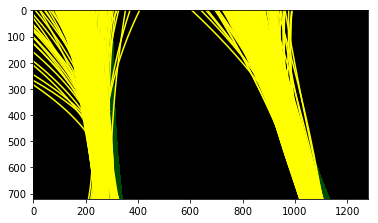

In [18]:
alternative_solidWhiteRight_output = 'test_videos_output/alternative_solidWhiteRight.mp4'
# clip8 = VideoFileClip("test_videos/alternative_solidWhiteRight.mp4").subclip(0,5)
clip8 = VideoFileClip("test_videos/alternative_solidWhiteRight.mp4")
alternative_solidWhiteRight_clip = clip8.fl_image(adv_lane_pipeline.video_pipeline) #NOTE: this function expects color images!!
%time alternative_solidWhiteRight_clip.write_videofile(alternative_solidWhiteRight_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(alternative_solidWhiteRight_output))

### Video Pipeline- Supplementary Videos: Solid Yellow Left Lane Lines

Left fit combined: [ -2.96638515e-04   2.82826586e-01   1.76127567e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([171, 172, 173, ..., 246, 247, 248])]
Left Lanes 706.4413 m
Right Lanes 9654.2718 m
Sanity Curve Difference 0.96666908833
Curve- 02 loop
Sanity Fit Difference [  4.4403395   25.75071797   0.34067342]
Left- 02 loop
Sanity Fit Difference [ 1.02022393  0.2258229   0.0271219 ]
Right- 02 loop
[MoviePy] >>>> Building video test_videos_output/alternative_solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/alternative_solidYellowLeft.mp4


  0%|          | 1/682 [00:03<44:54,  3.96s/it]

Left fit combined: [ -2.96638515e-04   2.82826586e-01   1.76127567e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([171, 172, 173, ..., 246, 247, 248])]
Left Lanes 706.4413 m
Right Lanes 9654.2718 m
Sanity Curve Difference 0.0
Curve- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Left- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Right- 02 loop


  0%|          | 2/682 [00:07<42:44,  3.77s/it]

Left fit combined: [ -3.17698070e-04   2.95916779e-01   1.79550715e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([180, 181, 182, ..., 249, 250, 251])]
Left Lanes 487.536 m
Right Lanes 1422.5775 m
Sanity Curve Difference 0.815638800424
Curve- 02 loop
Sanity Fit Difference [ 0.070994    0.04628346  0.01943562]
Left- 02 loop
Sanity Fit Difference [  4.75556492e+01   3.41025406e-01   1.64240873e-02]
Right- 02 loop


  0%|          | 3/682 [00:10<42:17,  3.74s/it]

Left fit combined: [ -3.29158492e-04   3.08012934e-01   1.78225398e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([180, 181, 182, ..., 250, 251, 252])]
Left Lanes 473.6333 m
Right Lanes 7515.1907 m
Sanity Curve Difference 3.18238182072
Curve- 02 loop
Sanity Fit Difference [ 0.03607331  0.04087688  0.0073813 ]
Left- 02 loop
Sanity Fit Difference [ 1.60286505  0.95548645  0.03918522]
Right- 02 loop


  1%|          | 4/682 [00:14<42:40,  3.78s/it]

Left fit combined: [ -3.60890278e-04   3.41652289e-01   1.75074054e+02]
Left_px: [array([ 37,  38,  38, ..., 719, 719, 719]), array([197, 197, 198, ..., 254, 255, 256])]
Left Lanes 600.7868 m
Right Lanes 9010.6946 m
Sanity Curve Difference 0.203115941949
Curve- 02 loop
Sanity Fit Difference [ 0.09640276  0.1092141   0.01768179]
Left- 02 loop
Sanity Fit Difference [  2.04245208e-01   1.77287873e-02   6.68623020e-05]
Right- 02 loop


  1%|          | 5/682 [00:19<45:06,  4.00s/it]

Left fit combined: [ -3.58265367e-04   3.40542737e-01   1.78437194e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([188, 189, 190, ..., 258, 259, 260])]
Left Lanes 562.3305 m
Right Lanes 9359.2605 m
Sanity Curve Difference 0.0322644924536
Curve- 02 loop
Sanity Fit Difference [ 0.00727343  0.00324761  0.01920981]
Left- 02 loop
Sanity Fit Difference [ 0.2646158   0.04461739  0.00690948]
Right- 02 loop


  1%|          | 6/682 [00:23<44:14,  3.93s/it]

Left fit combined: [ -3.68469561e-04   3.54819916e-01   1.78060398e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([212, 212, 213, ..., 281, 282, 283])]
Left Lanes 691.7224 m
Right Lanes 983.9821 m
Sanity Curve Difference 0.831105264856
Curve- 02 loop
Sanity Fit Difference [ 0.02848222  0.04192478  0.00211164]
Left- 02 loop
Sanity Fit Difference [ 3.83128992  0.37326928  0.02414971]
Right- 02 loop


  1%|          | 7/682 [00:26<43:42,  3.89s/it]

Left fit combined: [ -3.51294696e-04   3.36760377e-01   1.84185727e+02]
Left_px: [array([ 37,  38,  38, ..., 719, 719, 719]), array([197, 197, 198, ..., 263, 264, 265])]
Left Lanes 567.2131 m
Right Lanes 1190.1634 m
Sanity Curve Difference 0.0487389296767
Curve- 02 loop
Sanity Fit Difference [ 0.04661135  0.05089776  0.03440029]
Left- 02 loop
Sanity Fit Difference [ 0.16958005  0.11527328  0.00482863]
Right- 02 loop


  1%|          | 8/682 [00:31<44:43,  3.98s/it]

Left fit combined: [ -3.18034040e-04   3.35024318e-01   1.71106990e+02]
Left_px: [array([ 14,  14,  14, ..., 719, 719, 719]), array([174, 175, 176, ..., 264, 265, 266])]
Left Lanes 482.3556 m
Right Lanes 1835.3765 m
Sanity Curve Difference 0.318859153781
Curve- 02 loop
Sanity Fit Difference [ 0.09468021  0.00515518  0.07100842]
Left- 02 loop
Sanity Fit Difference [ 0.16411088  0.07396118  0.01951599]
Right- 02 loop


  1%|▏         | 9/682 [00:35<45:05,  4.02s/it]

Left fit combined: [ -3.49439847e-04   3.78725875e-01   1.56299390e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([171, 172, 173, ..., 264, 265, 266])]
Left Lanes 524.6151 m
Right Lanes 1058.7442 m
Sanity Curve Difference 0.316849770051
Curve- 02 loop
Sanity Fit Difference [ 0.09874983  0.13044294  0.08654001]
Left- 02 loop
Sanity Fit Difference [ 0.10051198  0.00609182  0.00718259]
Right- 02 loop


  1%|▏         | 10/682 [00:39<44:17,  3.96s/it]

Left fit combined: [ -3.44029439e-04   3.72810061e-01   1.58111266e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 265, 266, 267])]
Left Lanes 536.1938 m
Right Lanes 1488.1392 m
Sanity Curve Difference 0.278505179395
Curve- 02 loop
Sanity Fit Difference [ 0.01548309  0.01562031  0.01159234]
Left- 02 loop
Sanity Fit Difference [ 0.42644188  0.13749403  0.00904556]
Right- 02 loop


  2%|▏         | 11/682 [00:43<44:29,  3.98s/it]

Left fit combined: [ -3.86915128e-04   4.20783065e-01   1.45851449e+02]
Left_px: [array([ 35,  36,  37, ..., 719, 719, 719]), array([164, 165, 165, ..., 269, 271, 272])]
Left Lanes 648.3492 m
Right Lanes 25688.5426 m
Sanity Curve Difference 12.0101579751
Curve- 02 loop
Sanity Fit Difference [ 0.12465703  0.12867948  0.07753917]
Left- 02 loop
Sanity Fit Difference [ 0.86533848  0.35974853  0.0120598 ]
Right- 02 loop


  2%|▏         | 12/682 [00:47<44:30,  3.99s/it]

Left fit combined: [ -3.30608862e-04   3.73987992e-01   1.53048508e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 266, 267, 268])]
Left Lanes 498.0257 m
Right Lanes 2407.1818 m
Sanity Curve Difference 0.889690573051
Curve- 02 loop
Sanity Fit Difference [ 0.14552614  0.1112095   0.04934514]
Left- 02 loop
Sanity Fit Difference [ 0.07955458  0.08683036  0.00252945]
Right- 02 loop


  2%|▏         | 13/682 [00:51<45:05,  4.04s/it]

Left fit combined: [ -3.75109986e-04   4.23281617e-01   1.41171919e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([157, 158, 159, ..., 269, 270, 271])]
Left Lanes 618.63 m
Right Lanes 2234.5722 m
Sanity Curve Difference 0.0179006809828
Curve- 02 loop
Sanity Fit Difference [ 0.13460354  0.13180537  0.07760017]
Left- 02 loop
Sanity Fit Difference [ 0.488519    0.88352823  0.02151889]
Right- 02 loop


  2%|▏         | 14/682 [00:54<43:06,  3.87s/it]

Left fit combined: [ -4.19747463e-04   4.65778366e-01   1.34700506e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([201, 201, 202, ..., 268, 269, 270])]
Left Lanes 925.7056 m
Right Lanes 16673.6819 m
Sanity Curve Difference 5.16829301538
Curve- 02 loop
Sanity Fit Difference [ 0.11899837  0.10039829  0.04584065]
Left- 02 loop
Sanity Fit Difference [ 1.24652499  0.51796728  0.01726124]
Right- 02 loop


  2%|▏         | 15/682 [00:58<42:10,  3.79s/it]

Left fit combined: [ -4.40989041e-04   4.95169428e-01   1.25923441e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([157, 157, 158, ..., 271, 272, 273])]
Left Lanes 523.9912 m
Right Lanes 1836.5978 m
Sanity Curve Difference 0.865870957771
Curve- 02 loop
Sanity Fit Difference [ 0.05060561  0.06310096  0.06515985]
Left- 02 loop
Sanity Fit Difference [ 0.26322573  0.49838469  0.00973445]
Right- 02 loop


  2%|▏         | 16/682 [01:01<41:27,  3.73s/it]

Left fit combined: [ -4.31233328e-04   4.95842929e-01   1.23430542e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([149, 150, 151, ..., 276, 277, 278])]
Left Lanes 462.4291 m
Right Lanes 1273.5518 m
Sanity Curve Difference 0.264598443602
Curve- 02 loop
Sanity Fit Difference [ 0.02212235  0.00136014  0.01979694]
Left- 02 loop
Sanity Fit Difference [ 0.00542007  0.14864176  0.00455452]
Right- 02 loop


  2%|▏         | 17/682 [01:05<40:25,  3.65s/it]

Left fit combined: [ -4.67960695e-04   5.39644634e-01   1.10757914e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([173, 174, 175, ..., 278, 279, 280])]
Left Lanes 507.0697 m
Right Lanes 1409.588 m
Sanity Curve Difference 0.104077664074
Curve- 02 loop
Sanity Fit Difference [ 0.0851682   0.08833786  0.10267012]
Left- 02 loop
Sanity Fit Difference [ 0.04720602  0.13337632  0.00125951]
Right- 02 loop


  3%|▎         | 18/682 [01:08<40:17,  3.64s/it]

Left fit combined: [ -4.89158822e-04   5.55969858e-01   1.10154865e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([149, 149, 150, ..., 282, 283, 284])]
Left Lanes 427.6436 m
Right Lanes 2452.9098 m
Sanity Curve Difference 0.502904509905
Curve- 02 loop
Sanity Fit Difference [ 0.04529895  0.0302518   0.00544475]
Left- 02 loop
Sanity Fit Difference [ 0.02978638  0.12404579  0.00608261]
Right- 02 loop


  3%|▎         | 19/682 [01:12<41:26,  3.75s/it]

Left fit combined: [ -4.36165803e-04   5.14585646e-01   1.13879041e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([129, 130, 131, ..., 282, 283, 284])]
Left Lanes 339.1745 m
Right Lanes 2139.496 m
Sanity Curve Difference 0.139515869851
Curve- 02 loop
Sanity Fit Difference [ 0.108335    0.07443607  0.03380855]
Left- 02 loop
Sanity Fit Difference [ 0.44560588  1.60454639  0.00656414]
Right- 02 loop


  3%|▎         | 20/682 [01:16<40:37,  3.68s/it]

Left fit combined: [ -4.10613928e-04   5.03592028e-01   1.09629214e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([121, 122, 123, ..., 278, 279, 280])]
Left Lanes 336.3584 m
Right Lanes 3054.4769 m
Sanity Curve Difference 0.368005677152
Curve- 02 loop
Sanity Fit Difference [ 0.05858294  0.02136402  0.03731878]
Left- 02 loop
Sanity Fit Difference [ 0.46511045  0.41253442  0.01052407]
Right- 02 loop


  3%|▎         | 21/682 [01:20<40:50,  3.71s/it]

Left fit combined: [ -4.67695072e-04   5.85028491e-01   7.68826710e+01]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([125, 125, 126, ..., 277, 278, 279])]
Left Lanes 434.3637 m
Right Lanes 1144.1715 m
Sanity Curve Difference 0.534470122928
Curve- 02 loop
Sanity Fit Difference [ 0.13901415  0.16171118  0.2987027 ]
Left- 02 loop
Sanity Fit Difference [ 0.74473021  2.04410604  0.04195532]
Right- 02 loop


  3%|▎         | 22/682 [01:24<42:17,  3.85s/it]

Left fit combined: [ -4.38814627e-04   5.71163485e-01   7.25721909e+01]
Left_px: [array([ 36,  37,  38, ..., 719, 719, 719]), array([109, 110, 110, ..., 276, 277, 278])]
Left Lanes 403.8111 m
Right Lanes 7801.0942 m
Sanity Curve Difference 4.19779703032
Curve- 02 loop
Sanity Fit Difference [ 0.06175059  0.02369971  0.05606569]
Left- 02 loop
Sanity Fit Difference [ 0.14236535  0.45743627  0.00186201]
Right- 02 loop
Left fit combined: [ -4.62770017e-04   5.90873352e-01   6.93864208e+01]
Left_px: [array([ 36,  37,  38, ..., 719, 719, 719]), array([109, 110, 110, ..., 277, 278, 279])]
Left Lanes 438.0919 m
Right Lanes 4834.3084 m
Sanity Curve Difference 0.357408754576
Curve- 02 loop
Sanity Fit Difference [ 0.05459114  0.03450828  0.04389795]
Left- 02 loop
Sanity Fit Difference [ 0.64738558  3.97403795  0.03023092]
Right- 02 loop


  4%|▎         | 24/682 [01:32<44:17,  4.04s/it]

Left fit combined: [ -4.50739714e-04   5.76374510e-01   7.43998604e+01]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([101, 102, 103, ..., 276, 277, 278])]
Left Lanes 392.1018 m
Right Lanes 9224.2311 m
Sanity Curve Difference 0.823900366619
Curve- 02 loop
Sanity Fit Difference [ 0.02599629  0.02453799  0.0722539 ]
Left- 02 loop
Sanity Fit Difference [ 0.21907514  0.10583462  0.00062137]
Right- 02 loop


  4%|▎         | 25/682 [01:36<43:11,  3.94s/it]

Left fit combined: [ -5.25225052e-04   6.44005750e-01   6.63046168e+01]
Left_px: [array([ 79,  79,  80, ..., 719, 719, 719]), array([117, 118, 117, ..., 280, 281, 282])]
Left Lanes 387.2291 m
Right Lanes 1339.781 m
Sanity Curve Difference 0.820408657574
Curve- 02 loop
Sanity Fit Difference [ 0.16525133  0.11733905  0.10880724]
Left- 02 loop
Sanity Fit Difference [ 0.13177631  0.27317687  0.0143758 ]
Right- 02 loop


  4%|▍         | 26/682 [01:40<43:55,  4.02s/it]

Left fit combined: [ -5.08920503e-04   6.21736980e-01   7.90568254e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([113, 114, 115, ..., 282, 283, 284])]
Left Lanes 427.4981 m
Right Lanes 1084.5402 m
Sanity Curve Difference 0.12447630337
Curve- 02 loop
Sanity Fit Difference [ 0.03104298  0.03457853  0.19232761]
Left- 02 loop
Sanity Fit Difference [ 1.07869139  0.62159371  0.0048192 ]
Right- 02 loop


  4%|▍         | 27/682 [01:45<45:04,  4.13s/it]

Left fit combined: [ -5.24405033e-04   6.56047401e-01   6.29248293e+01]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([132, 132, 133, ..., 284, 285, 286])]
Left Lanes 463.0808 m
Right Lanes 813.5022 m
Sanity Curve Difference 0.155720404652
Curve- 02 loop
Sanity Fit Difference [ 0.03042623  0.05518478  0.2040557 ]
Left- 02 loop
Sanity Fit Difference [ 0.12118538  0.98959717  0.02820334]
Right- 02 loop


  4%|▍         | 28/682 [01:49<45:26,  4.17s/it]

Left fit combined: [ -3.73220670e-04   5.26801073e-01   8.43635046e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 80,  81,  82, ..., 286, 287, 288])]
Left Lanes 319.2421 m
Right Lanes 882.496 m
Sanity Curve Difference 0.0586291307506
Curve- 02 loop
Sanity Fit Difference [ 0.28829693  0.19700761  0.34070296]
Left- 02 loop
Sanity Fit Difference [  2.70623302e-01   8.72949341e+01   2.31587125e-03]
Right- 02 loop


  4%|▍         | 29/682 [01:53<44:34,  4.10s/it]

Left fit combined: [ -4.04105529e-04   5.79444930e-01   6.28895720e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 88,  89,  90, ..., 287, 288, 289])]
Left Lanes 375.7786 m
Right Lanes 698.9523 m
Sanity Curve Difference 0.10568626893
Curve- 02 loop
Sanity Fit Difference [ 0.08275227  0.09993119  0.25454055]
Left- 02 loop
Sanity Fit Difference [ 0.38284221  1.72672397  0.03060428]
Right- 02 loop


  4%|▍         | 30/682 [01:57<43:13,  3.98s/it]

Left fit combined: [ -3.59749702e-04   5.35837469e-01   7.27875827e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 71,  72,  73, ..., 287, 288, 289])]
Left Lanes 355.3845 m
Right Lanes 827.7781 m
Sanity Curve Difference 0.100891859981
Curve- 02 loop
Sanity Fit Difference [ 0.10976298  0.0752573   0.15738715]
Left- 02 loop
Sanity Fit Difference [ 0.09570357  0.32988506  0.00512952]
Right- 02 loop


  5%|▍         | 31/682 [02:00<42:21,  3.90s/it]

Left fit combined: [ -3.34882041e-04   5.20012468e-01   7.34768053e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 310, 312, 313])]
Left Lanes 353.403 m
Right Lanes 2008.3858 m
Sanity Curve Difference 0.996166030399
Curve- 02 loop
Sanity Fit Difference [ 0.0691249   0.02953321  0.00946896]
Left- 02 loop
Sanity Fit Difference [ 0.20181337  0.84547196  0.00471711]
Right- 02 loop


  5%|▍         | 32/682 [02:04<42:00,  3.88s/it]

Left fit combined: [ -3.46436100e-04   5.34617571e-01   7.00679465e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 287, 288, 289])]
Left Lanes 316.7059 m
Right Lanes 5135.4553 m
Sanity Curve Difference 1.30848802894
Curve- 02 loop
Sanity Fit Difference [ 0.03450188  0.02808606  0.04639367]
Left- 02 loop
Sanity Fit Difference [  2.89656450e-01   1.36923146e+01   1.00046672e-02]
Right- 02 loop
Left fit combined: [ -3.19147901e-04   5.06334091e-01   7.52123337e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 288, 289, 290])]
Left Lanes 395.9105 m
Right Lanes 695.4025 m
Sanity Curve Difference 0.799838454221
Curve- 02 loop
Sanity Fit Difference [ 0.07876835  0.05290413  0.07341998]
Left- 02 loop
Sanity Fit Difference [ 0.7622759   2.19511409  0.02726447]
Right- 02 loop


  5%|▍         | 34/682 [02:12<41:45,  3.87s/it]

Left fit combined: [ -2.98287169e-04   4.99866502e-01   7.21308923e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 291, 292, 293])]
Left Lanes 386.2709 m
Right Lanes 841.0267 m
Sanity Curve Difference 0.124606418765
Curve- 02 loop
Sanity Fit Difference [ 0.06536384  0.01277336  0.04096989]
Left- 02 loop
Sanity Fit Difference [ 0.18477914  0.81935353  0.01064236]
Right- 02 loop


  5%|▌         | 35/682 [02:16<42:00,  3.89s/it]

Left fit combined: [ -2.80508836e-04   5.10145440e-01   5.87735631e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 292, 293, 294])]
Left Lanes 318.5766 m
Right Lanes 748.7122 m
Sanity Curve Difference 0.130374964642
Curve- 02 loop
Sanity Fit Difference [ 0.0596014   0.02056337  0.18518181]
Left- 02 loop
Sanity Fit Difference [ 0.19052931  3.63936655  0.00844147]
Right- 02 loop


  5%|▌         | 36/682 [02:20<42:07,  3.91s/it]

Left fit combined: [ -2.52646339e-04   4.85017093e-01   6.21129197e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 291, 292, 293])]
Left Lanes 344.7978 m
Right Lanes 908.153 m
Sanity Curve Difference 0.173956722045
Curve- 02 loop
Sanity Fit Difference [ 0.09932841  0.04925722  0.05681732]
Left- 02 loop
Sanity Fit Difference [ 0.02569235  0.09046275  0.0011536 ]
Right- 02 loop


  5%|▌         | 37/682 [02:24<41:34,  3.87s/it]

Left fit combined: [ -3.06783615e-04   5.35977507e-01   5.08544832e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 290, 291, 292])]
Left Lanes 343.2839 m
Right Lanes 2861.3576 m
Sanity Curve Difference 1.55767551045
Curve- 02 loop
Sanity Fit Difference [ 0.21428086  0.10506932  0.18125756]
Left- 02 loop
Sanity Fit Difference [ 0.4215964   1.90263366  0.01928011]
Right- 02 loop


  6%|▌         | 38/682 [02:27<41:13,  3.84s/it]

Left fit combined: [ -3.12904771e-04   5.49198965e-01   4.33935269e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 293, 294, 295])]
Left Lanes 334.3316 m
Right Lanes 1013.5319 m
Sanity Curve Difference 0.579402733129
Curve- 02 loop
Sanity Fit Difference [ 0.01995268  0.02466793  0.14671187]
Left- 02 loop
Sanity Fit Difference [ 0.7211253   2.09534397  0.02211634]
Right- 02 loop


  6%|▌         | 39/682 [02:31<40:13,  3.75s/it]

Left fit combined: [ -2.61125028e-04   5.22357220e-01   3.79511639e+01]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([ 43,  44,  45, ..., 293, 294, 295])]
Left Lanes 419.6318 m
Right Lanes 886.9933 m
Sanity Curve Difference 0.0305953450043
Curve- 02 loop
Sanity Fit Difference [ 0.16548083  0.04887436  0.12541878]
Left- 02 loop
Sanity Fit Difference [ 0.0083364   0.12363978  0.00464327]
Right- 02 loop


  6%|▌         | 40/682 [02:35<40:24,  3.78s/it]

Left fit combined: [ -3.19407552e-04   5.87738995e-01   1.63227429e+01]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([ 21,  22,  23, ..., 290, 291, 292])]
Left Lanes 360.9937 m
Right Lanes 974.427 m
Sanity Curve Difference 0.022038070127
Curve- 02 loop
Sanity Fit Difference [ 0.22319777  0.12516679  0.56990139]
Left- 02 loop
Sanity Fit Difference [ 0.48678959  1.60618458  0.00940412]
Right- 02 loop


  6%|▌         | 41/682 [02:39<40:53,  3.83s/it]

Left fit combined: [ -2.67963960e-04   5.46869570e-01   2.16635200e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 38,  39,  40, ..., 290, 291, 292])]
Left Lanes 390.2167 m
Right Lanes 1776.2244 m
Sanity Curve Difference 0.622291231521
Curve- 02 loop
Sanity Fit Difference [ 0.16105941  0.06953669  0.3271985 ]
Left- 02 loop
Sanity Fit Difference [ 0.33737794  1.5310212   0.01681626]
Right- 02 loop


  6%|▌         | 42/682 [02:43<41:12,  3.86s/it]

Left fit combined: [ -2.81942395e-04   5.61167713e-01   1.83185429e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 38,  39,  40, ..., 289, 290, 291])]
Left Lanes 383.2468 m
Right Lanes 3143.3881 m
Sanity Curve Difference 0.627847062903
Curve- 02 loop
Sanity Fit Difference [ 0.05216535  0.02614544  0.15440598]
Left- 02 loop
Sanity Fit Difference [ 0.26083931  0.43900029  0.01599513]
Right- 02 loop


  6%|▋         | 43/682 [02:47<41:26,  3.89s/it]

Left fit combined: [ -2.73769391e-04   5.57757947e-01   1.60842458e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 38,  39,  40, ..., 289, 291, 292])]
Left Lanes 430.8896 m
Right Lanes 2289.438 m
Sanity Curve Difference 0.228633607169
Curve- 02 loop
Sanity Fit Difference [ 0.0289882   0.0060762   0.12196915]
Left- 02 loop
Sanity Fit Difference [ 0.59808156  0.22393163  0.00700778]
Right- 02 loop


  6%|▋         | 44/682 [02:50<41:22,  3.89s/it]

Left fit combined: [ -2.81497541e-04   5.58702743e-01   1.95641830e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 46,  47,  48, ..., 287, 288, 289])]
Left Lanes 420.4297 m
Right Lanes 481.1546 m
Sanity Curve Difference 0.66857510243
Curve- 02 loop
Sanity Fit Difference [ 0.02822868  0.00169392  0.21635688]
Left- 02 loop
Sanity Fit Difference [  6.87266831e+00   6.16533400e-01   2.98886230e-03]
Right- 02 loop


  7%|▋         | 45/682 [02:54<40:59,  3.86s/it]

Left fit combined: [ -2.32149033e-04   4.98901092e-01   4.03949119e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 290, 291, 292])]
Left Lanes 460.2102 m
Right Lanes 476.5222 m
Sanity Curve Difference 0.0389847854914
Curve- 02 loop
Sanity Fit Difference [ 0.17530707  0.10703662  1.06473798]
Left- 02 loop
Sanity Fit Difference [ 0.77415806  2.77490498  0.05098412]
Right- 02 loop


  7%|▋         | 46/682 [02:58<40:29,  3.82s/it]

Left fit combined: [ -2.18044286e-04   4.80460498e-01   4.56831692e+01]
Left_px: [array([ 37,  37,  38, ..., 719, 719, 719]), array([ 78,  79,  78, ..., 288, 289, 290])]
Left Lanes 428.761 m
Right Lanes 1410.8429 m
Sanity Curve Difference 0.963852118318
Curve- 02 loop
Sanity Fit Difference [ 0.06075729  0.03696243  0.13091395]
Left- 02 loop
Sanity Fit Difference [ 1.75185408  0.31720858  0.01400091]
Right- 02 loop


  7%|▋         | 47/682 [03:01<39:13,  3.71s/it]

Left fit combined: [ -2.62690138e-04   5.12756471e-01   4.36969809e+01]
Left_px: [array([ 59,  59,  59, ..., 719, 719, 719]), array([ 86,  87,  88, ..., 289, 290, 291])]
Left Lanes 461.1674 m
Right Lanes 993.284 m
Sanity Curve Difference 0.20936707358
Curve- 02 loop
Sanity Fit Difference [ 0.20475589  0.06721879  0.04347746]
Left- 02 loop
Sanity Fit Difference [ 0.25164736  0.03770389  0.0098573 ]
Right- 02 loop


  7%|▋         | 48/682 [03:06<40:58,  3.88s/it]

Left fit combined: [ -1.17934680e-04   3.64229489e-01   7.97122500e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 71,  72,  73, ..., 292, 293, 294])]
Left Lanes 671.2336 m
Right Lanes 80768.0932 m
Sanity Curve Difference 54.9931585279
Curve- 02 loop
Sanity Fit Difference [ 0.55105022  0.28966379  0.82420498]
Left- 02 loop
Sanity Fit Difference [ 0.72178888  0.75582494  0.02696783]
Right- 02 loop


  7%|▋         | 49/682 [03:09<40:35,  3.85s/it]

Left fit combined: [ -1.17799407e-04   3.68169127e-01   7.46223854e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 291, 292, 293])]
Left Lanes 631.0218 m
Right Lanes 2538.9495 m
Sanity Curve Difference 0.961075669436
Curve- 02 loop
Sanity Fit Difference [ 0.00114701  0.01081636  0.06385298]
Left- 02 loop
Sanity Fit Difference [ 0.04365754  0.5694314   0.01013839]
Right- 02 loop


  7%|▋         | 50/682 [03:14<43:37,  4.14s/it]

Left fit combined: [ -1.40827031e-04   3.87322684e-01   6.92533757e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 290, 291, 292])]
Left Lanes 747.383 m
Right Lanes 1486.7582 m
Sanity Curve Difference 0.2952172069
Curve- 02 loop
Sanity Fit Difference [ 0.19548166  0.0520238   0.07194905]
Left- 02 loop
Sanity Fit Difference [ 0.50129179  7.63970607  0.01929451]
Right- 02 loop
Left fit combined: [ -1.24207949e-04   3.71067900e-01   7.29953844e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 288, 289, 290])]
Left Lanes 658.2162 m
Right Lanes 1327.8506 m
Sanity Curve Difference 0.11103792014
Curve- 02 loop
Sanity Fit Difference [ 0.1180106   0.04196703  0.05403359]
Left- 02 loop
Sanity Fit Difference [ 0.18086474  0.1288846   0.00119943]
Right- 02 loop


  8%|▊         | 52/682 [03:23<45:30,  4.33s/it]

Left fit combined: [ -1.22472043e-04   3.69105237e-01   7.39809348e+01]
Left_px: [array([ 37,  37,  38, ..., 719, 719, 719]), array([ 70,  71,  70, ..., 290, 291, 292])]
Left Lanes 698.4098 m
Right Lanes 571.6095 m
Sanity Curve Difference 0.360535438941
Curve- 02 loop
Sanity Fit Difference [ 0.0139758   0.00528923  0.01350154]
Left- 02 loop
Sanity Fit Difference [ 0.69795859  0.84675066  0.0165199 ]
Right- 02 loop


  8%|▊         | 53/682 [03:28<46:38,  4.45s/it]

Left fit combined: [ -1.06162266e-04   3.28612635e-01   9.30056434e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 71,  72,  73, ..., 289, 290, 291])]
Left Lanes 734.3898 m
Right Lanes 1162.5153 m
Sanity Curve Difference 0.493603348534
Curve- 02 loop
Sanity Fit Difference [ 0.13317143  0.10970476  0.25715691]
Left- 02 loop
Sanity Fit Difference [ 0.28756463  5.32302491  0.03039909]
Right- 02 loop


  8%|▊         | 54/682 [03:32<45:37,  4.36s/it]

Left fit combined: [ -2.00961843e-04   4.15152511e-01   7.70326480e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 71,  72,  73, ..., 288, 289, 290])]
Left Lanes 588.4228 m
Right Lanes 881.8403 m
Sanity Curve Difference 0.224914777319
Curve- 02 loop
Sanity Fit Difference [ 0.89296866  0.26334921  0.17174222]
Left- 02 loop
Sanity Fit Difference [ 0.12874031  0.05027377  0.00787257]
Right- 02 loop


  8%|▊         | 55/682 [03:37<46:50,  4.48s/it]

Left fit combined: [ -2.21709430e-04   4.25121078e-01   7.90682818e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 288, 289, 290])]
Left Lanes 500.8457 m
Right Lanes 1296.6995 m
Sanity Curve Difference 0.222600976993
Curve- 02 loop
Sanity Fit Difference [ 0.10324142  0.02401182  0.0264256 ]
Left- 02 loop
Sanity Fit Difference [ 0.38807633  0.69501789  0.01344684]
Right- 02 loop


  8%|▊         | 56/682 [03:41<46:10,  4.43s/it]

Left fit combined: [ -2.00373540e-04   4.04705171e-01   8.16697738e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 289, 305, 306])]
Left Lanes 472.017 m
Right Lanes 3691.6215 m
Sanity Curve Difference 1.31629144059
Curve- 02 loop
Sanity Fit Difference [ 0.09623357  0.04802375  0.03290184]
Left- 02 loop
Sanity Fit Difference [ 0.18816555  1.59777035  0.01180254]
Right- 02 loop


  8%|▊         | 57/682 [03:45<43:32,  4.18s/it]

Left fit combined: [ -1.88677824e-04   3.93597308e-01   8.25398160e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 287, 288, 289])]
Left Lanes 465.6568 m
Right Lanes 1570.9694 m
Sanity Curve Difference 0.510854228029
Curve- 02 loop
Sanity Fit Difference [ 0.05836956  0.0274468   0.01065317]
Left- 02 loop
Sanity Fit Difference [ 0.21485057  0.51479432  0.00844818]
Right- 02 loop


  9%|▊         | 58/682 [03:48<41:01,  3.94s/it]

Left fit combined: [ -2.61999767e-04   4.50664800e-01   7.79373660e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 71,  72,  73, ..., 288, 289, 290])]
Left Lanes 397.4457 m
Right Lanes 1070.4502 m
Sanity Curve Difference 0.279251216222
Curve- 02 loop
Sanity Fit Difference [ 0.38860922  0.14498954  0.05576036]
Left- 02 loop
Sanity Fit Difference [ 0.0490071   0.61703007  0.0159975 ]
Right- 02 loop


  9%|▊         | 59/682 [03:52<39:45,  3.83s/it]

Left fit combined: [ -2.61315201e-04   4.64156994e-01   6.69641720e+01]
Left_px: [array([ 12,  12,  12, ..., 719, 719, 719]), array([ 68,  69,  70, ..., 287, 288, 289])]
Left Lanes 446.7217 m
Right Lanes 16878.4111 m
Sanity Curve Difference 10.8026991421
Curve- 02 loop
Sanity Fit Difference [ 0.00261285  0.02993842  0.14079503]
Left- 02 loop
Sanity Fit Difference [ 0.15233297  0.50105459  0.00377595]
Right- 02 loop


  9%|▉         | 60/682 [03:56<39:34,  3.82s/it]

Left fit combined: [ -2.60562680e-04   4.69749131e-01   6.27319855e+01]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([ 85,  86,  87, ..., 286, 287, 288])]
Left Lanes 645.8397 m
Right Lanes 576.1059 m
Sanity Curve Difference 0.929469769435
Curve- 02 loop
Sanity Fit Difference [ 0.00287974  0.01204794  0.06320076]
Left- 02 loop
Sanity Fit Difference [ 5.66706963  8.66688679  0.12527198]
Right- 02 loop


  9%|▉         | 61/682 [04:00<40:53,  3.95s/it]

Left fit combined: [ -2.60210585e-04   4.49131510e-01   7.59880757e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 285, 286, 287])]
Left Lanes 460.3967 m
Right Lanes 815.017 m
Sanity Curve Difference 0.0437565206209
Curve- 02 loop
Sanity Fit Difference [ 0.00135129  0.04389071  0.2113131 ]
Left- 02 loop
Sanity Fit Difference [ 0.78896108  1.00816667  0.09686764]
Right- 02 loop


  9%|▉         | 62/682 [04:05<43:28,  4.21s/it]

Left fit combined: [ -2.71145803e-04   4.70551593e-01   6.35100427e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 281, 282, 283])]
Left Lanes 420.771 m
Right Lanes 715.1105 m
Sanity Curve Difference 0.109401491497
Curve- 02 loop
Sanity Fit Difference [ 0.04202449  0.04769223  0.16421041]
Left- 02 loop
Sanity Fit Difference [ 0.08761603  2.55923015  0.00296787]
Right- 02 loop


  9%|▉         | 63/682 [04:09<42:42,  4.14s/it]

Left fit combined: [ -2.48986270e-04   4.48992369e-01   6.68349642e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 55,  56,  57, ..., 281, 282, 283])]
Left Lanes 452.5393 m
Right Lanes 640.1359 m
Sanity Curve Difference 0.0380377200328
Curve- 02 loop
Sanity Fit Difference [ 0.08172553  0.04581692  0.05235269]
Left- 02 loop
Sanity Fit Difference [ 0.42645995  4.88093294  0.01734744]
Right- 02 loop


  9%|▉         | 64/682 [04:13<41:49,  4.06s/it]

Left fit combined: [ -2.35957882e-04   4.47097130e-01   6.38783101e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 63,  64,  65, ..., 281, 282, 283])]
Left Lanes 432.61 m
Right Lanes 563.9922 m
Sanity Curve Difference 0.0879245473993
Curve- 02 loop
Sanity Fit Difference [ 0.05232573  0.00422109  0.04423813]
Left- 02 loop
Sanity Fit Difference [ 0.09560136  0.21040168  0.01018052]
Right- 02 loop


 10%|▉         | 65/682 [04:17<43:12,  4.20s/it]

Left fit combined: [ -2.52507793e-04   4.53865167e-01   6.77130393e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 80,  81,  82, ..., 282, 283, 284])]
Left Lanes 461.3863 m
Right Lanes 495.9446 m
Sanity Curve Difference 0.0394051974947
Curve- 02 loop
Sanity Fit Difference [ 0.07013926  0.01513773  0.06003179]
Left- 02 loop
Sanity Fit Difference [ 0.51780213  0.46154796  0.01183425]
Right- 02 loop


 10%|▉         | 66/682 [04:22<45:03,  4.39s/it]

Left fit combined: [ -3.03719613e-04   4.89756612e-01   6.61313779e+01]
Left_px: [array([ 36,  37,  38, ..., 719, 719, 719]), array([ 93,  94,  94, ..., 282, 283, 284])]
Left Lanes 615.2902 m
Right Lanes 448.9044 m
Sanity Curve Difference 0.111626681013
Curve- 02 loop
Sanity Fit Difference [ 0.20281283  0.07907953  0.0233583 ]
Left- 02 loop
Sanity Fit Difference [ 0.19789613  0.45133888  0.00408893]
Right- 02 loop


 10%|▉         | 67/682 [04:27<46:51,  4.57s/it]

Left fit combined: [ -3.96296698e-04   5.75237893e-01   5.23586307e+01]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([131, 131, 132, ..., 283, 284, 285])]
Left Lanes 522.7618 m
Right Lanes 1642.3527 m
Sanity Curve Difference 1.03450997925
Curve- 02 loop
Sanity Fit Difference [ 0.30481102  0.17453829  0.20826342]
Left- 02 loop
Sanity Fit Difference [ 0.37720363  2.50885308  0.03406461]
Right- 02 loop


 10%|▉         | 68/682 [04:32<47:24,  4.63s/it]

Left fit combined: [ -4.24246133e-04   6.01108591e-01   4.77893702e+01]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([131, 132, 133, ..., 283, 284, 285])]
Left Lanes 532.1715 m
Right Lanes 2951672.5805 m
Sanity Curve Difference 1362.53284866
Curve- 02 loop
Sanity Fit Difference [ 0.07052654  0.04497391  0.08726852]
Left- 02 loop
Sanity Fit Difference [ 0.03315666  0.00097885  0.00142561]
Right- 02 loop


 10%|█         | 69/682 [04:36<44:47,  4.38s/it]

Left fit combined: [ -3.81499884e-04   5.46910727e-01   6.53947539e+01]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([138, 139, 140, ..., 283, 284, 285])]
Left Lanes 605.5983 m
Right Lanes 5898.5869 m
Sanity Curve Difference 0.997796838065
Curve- 02 loop
Sanity Fit Difference [ 0.10075813  0.09016318  0.36839539]
Left- 02 loop
Sanity Fit Difference [  5.26165058e-02   6.66522842e-02   3.70674633e-05]
Right- 02 loop


 10%|█         | 70/682 [04:39<42:47,  4.19s/it]

Left fit combined: [ -3.94058989e-04   5.64276301e-01   6.01968621e+01]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([132, 132, 133, ..., 283, 284, 285])]
Left Lanes 560.9374 m
Right Lanes 1984.6472 m
Sanity Curve Difference 0.60862359133
Curve- 02 loop
Sanity Fit Difference [ 0.03292034  0.03175212  0.07948484]
Left- 02 loop
Sanity Fit Difference [ 0.58703221  0.65880997  0.02299429]
Right- 02 loop


 10%|█         | 71/682 [04:44<42:38,  4.19s/it]

Left fit combined: [ -3.23269168e-04   4.81949796e-01   8.31408758e+01]
Left_px: [array([ 79,  80,  80, ..., 719, 719, 719]), array([125, 125, 126, ..., 282, 283, 284])]
Left Lanes 662.7133 m
Right Lanes 4934.8822 m
Sanity Curve Difference 1.19894300037
Curve- 02 loop
Sanity Fit Difference [ 0.1796427   0.14589751  0.38114966]
Left- 02 loop
Sanity Fit Difference [ 0.572012    0.17581434  0.01303773]
Right- 02 loop


 11%|█         | 72/682 [04:47<41:02,  4.04s/it]

Left fit combined: [ -2.93306771e-04   4.50073800e-01   9.17149268e+01]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([146, 146, 147, ..., 282, 283, 284])]
Left Lanes 839.2878 m
Right Lanes 2785.6992 m
Sanity Curve Difference 0.352402827406
Curve- 02 loop
Sanity Fit Difference [ 0.0926856   0.06613966  0.10312678]
Left- 02 loop
Sanity Fit Difference [ 0.14228318  0.0835446   0.00653702]
Right- 02 loop


 11%|█         | 73/682 [04:51<39:56,  3.94s/it]

Left fit combined: [ -3.12271668e-04   4.69513295e-01   8.77760400e+01]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([132, 132, 133, ..., 282, 283, 284])]
Left Lanes 656.6328 m
Right Lanes 2617.3168 m
Sanity Curve Difference 0.0968382501005
Curve- 02 loop
Sanity Fit Difference [ 0.06465891  0.0431918   0.04294706]
Left- 02 loop
Sanity Fit Difference [ 0.53361015  0.17913552  0.00512123]
Right- 02 loop


 11%|█         | 74/682 [04:55<39:36,  3.91s/it]

Left fit combined: [ -2.73532691e-04   4.26550791e-01   1.00712417e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([146, 146, 147, ..., 283, 284, 285])]
Left Lanes 939.6088 m
Right Lanes 926.4208 m
Sanity Curve Difference 0.430037165245
Curve- 02 loop
Sanity Fit Difference [ 0.12405537  0.09150434  0.14737936]
Left- 02 loop
Sanity Fit Difference [ 0.92888743  0.72715491  0.02841802]
Right- 02 loop


 11%|█         | 75/682 [04:59<39:32,  3.91s/it]

Left fit combined: [ -2.24402390e-04   3.85641494e-01   1.07730402e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([121, 122, 123, ..., 283, 284, 285])]
Left Lanes 843.2709 m
Right Lanes 2212.4543 m
Sanity Curve Difference 0.637554503823
Curve- 02 loop
Sanity Fit Difference [ 0.179614    0.09590721  0.06968342]
Left- 02 loop
Sanity Fit Difference [ 0.5600928   3.19423713  0.03904619]
Right- 02 loop


 11%|█         | 76/682 [05:02<39:02,  3.87s/it]

Left fit combined: [ -1.73452601e-04   3.26761261e-01   1.25371113e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([129, 130, 131, ..., 283, 284, 285])]
Left Lanes 746.3087 m
Right Lanes 1330.3782 m
Sanity Curve Difference 0.320394753015
Curve- 02 loop
Sanity Fit Difference [ 0.22704655  0.15268127  0.16374868]
Left- 02 loop
Sanity Fit Difference [ 0.42523903  0.22212354  0.00615015]
Right- 02 loop


 11%|█▏        | 77/682 [05:06<38:15,  3.79s/it]

Left fit combined: [ -1.58983814e-04   3.26150898e-01   1.20422748e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([121, 122, 123, ..., 285, 286, 287])]
Left Lanes 649.9788 m
Right Lanes 715.6803 m
Sanity Curve Difference 0.342385657486
Curve- 02 loop
Sanity Fit Difference [ 0.08341637  0.00186792  0.03946974]
Left- 02 loop
Sanity Fit Difference [ 0.07879373  0.09025244  0.00370366]
Right- 02 loop


 11%|█▏        | 78/682 [05:10<38:20,  3.81s/it]

Left fit combined: [ -2.56471208e-04   4.30114096e-01   9.10819216e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([121, 122, 123, ..., 283, 284, 285])]
Left Lanes 924.1328 m
Right Lanes 1427.4482 m
Sanity Curve Difference 0.721938563376
Curve- 02 loop
Sanity Fit Difference [ 0.61319068  0.31875797  0.24364854]
Left- 02 loop
Sanity Fit Difference [ 0.28582938  0.35618815  0.0095185 ]
Right- 02 loop


 12%|█▏        | 79/682 [05:14<37:40,  3.75s/it]

Left fit combined: [ -2.07989495e-04   3.85837266e-01   9.92683681e+01]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([113, 114, 115, ..., 282, 283, 284])]
Left Lanes 796.2751 m
Right Lanes 2056.8479 m
Sanity Curve Difference 0.213278614055
Curve- 02 loop
Sanity Fit Difference [ 0.18903374  0.10294206  0.08988004]
Left- 02 loop
Sanity Fit Difference [ 0.47821528  0.36701856  0.0207588 ]
Right- 02 loop


 12%|█▏        | 80/682 [05:18<38:25,  3.83s/it]

Left fit combined: [ -1.81892443e-04   3.56887618e-01   1.05922744e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([113, 114, 115, ..., 281, 282, 283])]
Left Lanes 647.1741 m
Right Lanes 2185.0163 m
Sanity Curve Difference 0.00733671072576
Curve- 02 loop
Sanity Fit Difference [ 0.12547293  0.07503072  0.0670342 ]
Left- 02 loop
Sanity Fit Difference [ 0.18636829  0.31403646  0.011428  ]
Right- 02 loop


 12%|█▏        | 81/682 [05:21<37:56,  3.79s/it]

Left fit combined: [ -1.99308749e-04   3.63146844e-01   1.08584253e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([125, 125, 126, ..., 283, 284, 295])]
Left Lanes 810.9409 m
Right Lanes 10223.6508 m
Sanity Curve Difference 2.89613339831
Curve- 02 loop
Sanity Fit Difference [ 0.09575058  0.01753837  0.0251269 ]
Left- 02 loop
Sanity Fit Difference [ 0.40076662  1.11764772  0.02696943]
Right- 02 loop


 12%|█▏        | 82/682 [05:25<37:38,  3.76s/it]

Left fit combined: [ -1.83018815e-04   3.59865044e-01   1.00694172e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([125, 125, 126, ..., 280, 281, 282])]
Left Lanes 843.8509 m
Right Lanes 1323.7773 m
Sanity Curve Difference 0.803560628945
Curve- 02 loop
Sanity Fit Difference [ 0.08173215  0.00903712  0.07266322]
Left- 02 loop
Sanity Fit Difference [ 0.28281905  0.15164186  0.0006494 ]
Right- 02 loop


 12%|█▏        | 83/682 [05:29<37:42,  3.78s/it]

Left fit combined: [ -1.86409132e-04   3.61257546e-01   1.00106807e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([125, 125, 126, ..., 278, 279, 280])]
Left Lanes 1202.7352 m
Right Lanes 448.7822 m
Sanity Curve Difference 0.238099357009
Curve- 02 loop
Sanity Fit Difference [ 0.01852441  0.00386951  0.00583316]
Left- 02 loop
Sanity Fit Difference [ 0.56109676  0.27610351  0.01535938]
Right- 02 loop


 12%|█▏        | 84/682 [05:33<37:39,  3.78s/it]

Left fit combined: [ -1.46824215e-04   3.28748305e-01   1.03212779e+02]
Left_px: [array([ 36,  37,  38, ..., 719, 719, 719]), array([109, 110, 110, ..., 280, 281, 282])]
Left Lanes 991.4525 m
Right Lanes 1140.1677 m
Sanity Curve Difference 0.290704102734
Curve- 02 loop
Sanity Fit Difference [ 0.21235503  0.0899891   0.03102658]
Left- 02 loop
Sanity Fit Difference [ 0.12201522  0.03656926  0.00550069]
Right- 02 loop


 12%|█▏        | 85/682 [05:36<37:17,  3.75s/it]

Left fit combined: [ -1.60959566e-04   3.25318588e-01   1.10157444e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 96,  97,  98, ..., 280, 281, 282])]
Left Lanes 726.702 m
Right Lanes 4027.8978 m
Sanity Curve Difference 1.23050979427
Curve- 02 loop
Sanity Fit Difference [ 0.09627397  0.01043265  0.06728494]
Left- 02 loop
Sanity Fit Difference [ 1.90190098  0.33599406  0.01780098]
Right- 02 loop


 13%|█▎        | 86/682 [05:40<37:01,  3.73s/it]

Left fit combined: [ -1.22964134e-04   2.69377468e-01   1.29665929e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 97,  98,  99, ..., 280, 281, 282])]
Left Lanes 732.3965 m
Right Lanes 1525.637 m
Sanity Curve Difference 0.525084421328
Curve- 02 loop
Sanity Fit Difference [ 0.23605575  0.17195796  0.17709638]
Left- 02 loop
Sanity Fit Difference [ 0.11117228  0.07554067  0.00242194]
Right- 02 loop


 13%|█▎        | 87/682 [05:44<39:21,  3.97s/it]

Left fit combined: [ -2.08170197e-04   3.63231285e-01   1.03480064e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 96,  97,  98, ..., 276, 277, 278])]
Left Lanes 611.0796 m
Right Lanes 920.3717 m
Sanity Curve Difference 0.321776528089
Curve- 02 loop
Sanity Fit Difference [ 0.69293427  0.34841005  0.2019487 ]
Left- 02 loop
Sanity Fit Difference [ 0.11648822  0.12622987  0.00487575]
Right- 02 loop


 13%|█▎        | 88/682 [05:49<42:27,  4.29s/it]

Left fit combined: [ -2.17668524e-04   3.59441278e-01   1.07754487e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 96,  97,  98, ..., 274, 275, 276])]
Left Lanes 768.4932 m
Right Lanes 1225.4195 m
Sanity Curve Difference 0.301975839494
Curve- 02 loop
Sanity Fit Difference [ 0.0456277   0.01043414  0.04130673]
Left- 02 loop
Sanity Fit Difference [ 0.10136696  0.07296581  0.00268892]
Right- 02 loop


 13%|█▎        | 89/682 [05:55<45:12,  4.57s/it]

Left fit combined: [ -2.50262782e-04   3.84714966e-01   1.04416213e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([ 88,  89,  90, ..., 273, 274, 275])]
Left Lanes 612.4338 m
Right Lanes 1111.4317 m
Sanity Curve Difference 0.135435786872
Curve- 02 loop
Sanity Fit Difference [ 0.14974263  0.07031382  0.03098037]
Left- 02 loop
Sanity Fit Difference [ 0.17216768  0.12511111  0.00728511]
Right- 02 loop


 13%|█▎        | 90/682 [05:59<45:31,  4.61s/it]

Left fit combined: [ -2.52247984e-04   3.88794719e-01   1.04583591e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([117, 118, 119, ..., 275, 276, 277])]
Left Lanes 624.3702 m
Right Lanes 3987.4345 m
Sanity Curve Difference 1.67526943168
Curve- 02 loop
Sanity Fit Difference [ 0.00793247  0.01060461  0.00160299]
Left- 02 loop
Sanity Fit Difference [ 0.22874674  0.27287773  0.01793034]
Right- 02 loop


 13%|█▎        | 91/682 [06:04<46:06,  4.68s/it]

Left fit combined: [ -2.39524075e-04   3.57009420e-01   1.22414991e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([113, 114, 115, ..., 276, 277, 278])]
Left Lanes 574.7501 m
Right Lanes 1280.7238 m
Sanity Curve Difference 0.597668580099
Curve- 02 loop
Sanity Fit Difference [ 0.05044207  0.08175342  0.17049903]
Left- 02 loop
Sanity Fit Difference [ 0.24272925  0.06033351  0.00793914]
Right- 02 loop


 13%|█▎        | 92/682 [06:09<46:44,  4.75s/it]

Left fit combined: [ -2.69873080e-04   3.66620255e-01   1.32959331e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([146, 147, 148, ..., 278, 279, 280])]
Left Lanes 501.7503 m
Right Lanes 1326.5335 m
Sanity Curve Difference 0.014654049996
Curve- 02 loop
Sanity Fit Difference [ 0.12670545  0.0269204   0.08613602]
Left- 02 loop
Sanity Fit Difference [ 0.36395115  0.43012876  0.0409559 ]
Right- 02 loop


 14%|█▎        | 93/682 [06:15<48:29,  4.94s/it]

Left fit combined: [ -2.70229731e-04   3.48659343e-01   1.49241862e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([163, 164, 165, ..., 280, 281, 282])]
Left Lanes 519.6669 m
Right Lanes 1596.4528 m
Sanity Curve Difference 0.157435062856
Curve- 02 loop
Sanity Fit Difference [ 0.00132155  0.04899051  0.12246249]
Left- 02 loop
Sanity Fit Difference [ 0.64866837  0.17367942  0.0008945 ]
Right- 02 loop


 14%|█▍        | 94/682 [06:19<48:05,  4.91s/it]

Left fit combined: [ -3.01161246e-04   3.67099672e-01   1.51702951e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([164, 165, 166, ..., 281, 282, 283])]
Left Lanes 616.3284 m
Right Lanes 3066.4385 m
Sanity Curve Difference 0.740339589342
Curve- 02 loop
Sanity Fit Difference [ 0.11446378  0.05288924  0.01649061]
Left- 02 loop
Sanity Fit Difference [ 0.31551218  0.21228313  0.01207212]
Right- 02 loop


 14%|█▍        | 95/682 [06:24<46:45,  4.78s/it]

Left fit combined: [ -2.95981683e-04   3.63664475e-01   1.52890431e+02]
Left_px: [array([ 57,  59,  59, ..., 719, 719, 719]), array([186, 186, 187, ..., 277, 278, 280])]
Left Lanes 734.837 m
Right Lanes 851367.119 m
Sanity Curve Difference 230.37548229
Curve- 02 loop
Sanity Fit Difference [ 0.01719864  0.00935767  0.00782766]
Left- 02 loop
Sanity Fit Difference [ 0.07192221  0.12487149  0.01048145]
Right- 02 loop


 14%|█▍        | 96/682 [06:28<43:42,  4.48s/it]

Left fit combined: [ -2.87015026e-04   3.52449438e-01   1.57075675e+02]
Left_px: [array([ 57,  59,  59, ..., 719, 719, 719]), array([186, 186, 187, ..., 279, 280, 281])]
Left Lanes 839.6067 m
Right Lanes 1820.1367 m
Sanity Curve Difference 0.996878608992
Curve- 02 loop
Sanity Fit Difference [ 0.03029463  0.03083897  0.02737414]
Left- 02 loop
Sanity Fit Difference [ 0.93931233  0.87947025  0.05189728]
Right- 02 loop


 14%|█▍        | 97/682 [06:31<40:44,  4.18s/it]

Left fit combined: [ -3.17670560e-04   3.99994729e-01   1.37116768e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([173, 174, 175, ..., 281, 282, 283])]
Left Lanes 698.1982 m
Right Lanes 3056.9526 m
Sanity Curve Difference 0.411846999957
Curve- 02 loop
Sanity Fit Difference [ 0.10680812  0.13489961  0.12706555]
Left- 02 loop
Sanity Fit Difference [ 15.02456432   0.50200179   0.0716893 ]
Right- 02 loop


 14%|█▍        | 98/682 [06:35<38:32,  3.96s/it]

Left fit combined: [ -3.44853322e-04   4.44630848e-01   1.18608527e+02]
Left_px: [array([117, 117, 118, ..., 719, 719, 719]), array([167, 168, 167, ..., 281, 282, 283])]
Left Lanes 679.2938 m
Right Lanes 8384.1534 m
Sanity Curve Difference 1.4136041159
Curve- 02 loop
Sanity Fit Difference [ 0.08556903  0.11159177  0.13498161]
Left- 02 loop
Sanity Fit Difference [ 0.38941007  0.31167343  0.00917508]
Right- 02 loop


 15%|█▍        | 99/682 [06:38<37:15,  3.83s/it]

Left fit combined: [ -3.37202722e-04   4.31707819e-01   1.23296137e+02]
Left_px: [array([117, 117, 118, ..., 719, 719, 719]), array([167, 168, 167, ..., 283, 284, 285])]
Left Lanes 638.8688 m
Right Lanes 2640.761 m
Sanity Curve Difference 0.638147637157
Curve- 02 loop
Sanity Fit Difference [ 0.02218508  0.02906463  0.03952169]
Left- 02 loop
Sanity Fit Difference [ 0.5139352   0.27812927  0.02686153]
Right- 02 loop


 15%|█▍        | 100/682 [06:42<36:46,  3.79s/it]

Left fit combined: [ -3.35515069e-04   4.38305982e-01   1.18305549e+02]
Left_px: [array([ 99,  99, 100, ..., 719, 719, 719]), array([154, 155, 154, ..., 282, 283, 284])]
Left Lanes 585.7415 m
Right Lanes 17488.4382 m
Sanity Curve Difference 4.51104264486
Curve- 02 loop
Sanity Fit Difference [ 0.00500486  0.01528386  0.04047643]
Left- 02 loop
Sanity Fit Difference [ 0.9158929   0.81096228  0.03497003]
Right- 02 loop


 15%|█▍        | 101/682 [06:45<36:26,  3.76s/it]

Left fit combined: [ -3.62465701e-04   4.59891769e-01   1.15743108e+02]
Left_px: [array([117, 117, 118, ..., 719, 719, 719]), array([167, 168, 167, ..., 283, 284, 285])]
Left Lanes 628.8 m
Right Lanes 878.1814 m
Sanity Curve Difference 0.916622415831
Curve- 02 loop
Sanity Fit Difference [ 0.08032614  0.04924821  0.02165952]
Left- 02 loop
Sanity Fit Difference [ 5.45287872  0.21746337  0.01796236]
Right- 02 loop


 15%|█▍        | 102/682 [06:49<35:38,  3.69s/it]

Left fit combined: [ -3.86155537e-04   4.92831115e-01   1.03926089e+02]
Left_px: [array([117, 117, 118, ..., 719, 719, 719]), array([167, 168, 167, ..., 281, 282, 283])]
Left Lanes 566.2863 m
Right Lanes 945.1037 m
Sanity Curve Difference 0.0029253969426
Curve- 02 loop
Sanity Fit Difference [ 0.06535746  0.07162413  0.10209696]
Left- 02 loop
Sanity Fit Difference [ 0.01891368  0.02086314  0.00627302]
Right- 02 loop


 15%|█▌        | 103/682 [06:52<35:00,  3.63s/it]

Left fit combined: [ -3.62463866e-04   4.70343791e-01   1.08801049e+02]
Left_px: [array([117, 117, 118, ..., 719, 719, 719]), array([167, 168, 167, ..., 281, 282, 283])]
Left Lanes 677.065 m
Right Lanes 1452.4915 m
Sanity Curve Difference 0.409005317721
Curve- 02 loop
Sanity Fit Difference [ 0.06135267  0.04562886  0.04690796]
Left- 02 loop
Sanity Fit Difference [ 0.04333044  0.01248079  0.00076455]
Right- 02 loop


 15%|█▌        | 104/682 [06:56<34:34,  3.59s/it]

Left fit combined: [ -3.38124268e-04   4.42048375e-01   1.16161113e+02]
Left_px: [array([ 98,  99, 100, ..., 719, 719, 719]), array([205, 205, 205, ..., 279, 280, 281])]
Left Lanes 653.3561 m
Right Lanes 718.015 m
Sanity Curve Difference 0.356029727399
Curve- 02 loop
Sanity Fit Difference [ 0.06715041  0.06015901  0.067647  ]
Left- 02 loop
Sanity Fit Difference [ 0.13921207  0.02981263  0.00016219]
Right- 02 loop


 15%|█▌        | 105/682 [07:00<34:24,  3.58s/it]

Left fit combined: [ -2.35887351e-04   3.53602674e-01   1.29231249e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([105, 106, 107, ..., 279, 280, 281])]
Left Lanes 539.962 m
Right Lanes 1105.0293 m
Sanity Curve Difference 0.199523136286
Curve- 02 loop
Sanity Fit Difference [ 0.30236492  0.2000815   0.11251731]
Left- 02 loop
Sanity Fit Difference [ 0.55448488  0.18161026  0.01191062]
Right- 02 loop


 16%|█▌        | 106/682 [07:03<34:43,  3.62s/it]

Left fit combined: [ -2.17084990e-04   3.37643914e-01   1.32541799e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([105, 106, 107, ..., 278, 279, 280])]
Left Lanes 558.5083 m
Right Lanes 1126.0471 m
Sanity Curve Difference 0.0240511949486
Curve- 02 loop
Sanity Fit Difference [ 0.07970907  0.0451319   0.02561725]
Left- 02 loop
Sanity Fit Difference [ 1.79684075  0.20290378  0.0162988 ]
Right- 02 loop


 16%|█▌        | 107/682 [07:07<36:15,  3.78s/it]

Left fit combined: [ -4.00229418e-04   5.08254766e-01   9.72517737e+01]
Left_px: [array([151, 151, 152, ..., 719, 719, 719]), array([171, 172, 171, ..., 278, 282, 283])]
Left Lanes 801.8183 m
Right Lanes 1520.2212 m
Sanity Curve Difference 0.378428743726
Curve- 02 loop
Sanity Fit Difference [ 0.84365312  0.50529817  0.26625582]
Left- 02 loop
Sanity Fit Difference [ 0.15527932  0.06117958  0.00409526]
Right- 02 loop


 16%|█▌        | 108/682 [07:11<36:10,  3.78s/it]

Left fit combined: [ -4.39775928e-04   5.44878630e-01   9.23283823e+01]
Left_px: [array([151, 151, 152, ..., 719, 719, 719]), array([171, 172, 171, ..., 279, 280, 281])]
Left Lanes 731.1753 m
Right Lanes 1223.3851 m
Sanity Curve Difference 0.158257032645
Curve- 02 loop
Sanity Fit Difference [ 0.09880961  0.07205808  0.05062521]
Left- 02 loop
Sanity Fit Difference [ 0.91156818  0.24324915  0.00941575]
Right- 02 loop


 16%|█▌        | 109/682 [07:15<35:41,  3.74s/it]

Left fit combined: [ -3.52365550e-04   4.51350334e-01   1.18566834e+02]
Left_px: [array([ 59,  59,  59, ..., 719, 719, 719]), array([163, 164, 165, ..., 282, 283, 284])]
Left Lanes 811.1564 m
Right Lanes 15268.6825 m
Sanity Curve Difference 7.22683137446
Curve- 02 loop
Sanity Fit Difference [ 0.19876117  0.17164978  0.28418619]
Left- 02 loop
Sanity Fit Difference [ 0.09312826  0.17447368  0.01877069]
Right- 02 loop


 16%|█▌        | 110/682 [07:19<35:34,  3.73s/it]

Left fit combined: [ -3.88102181e-04   4.75496918e-01   1.18846250e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([195, 196, 197, ..., 282, 283, 284])]
Left Lanes 951.0405 m
Right Lanes 9495.3763 m
Sanity Curve Difference 0.350340705762
Curve- 02 loop
Sanity Fit Difference [ 0.1014192   0.05349854  0.00235661]
Left- 02 loop
Sanity Fit Difference [ 0.50903851  0.36872816  0.02979758]
Right- 02 loop


 16%|█▋        | 111/682 [07:22<34:57,  3.67s/it]

Left fit combined: [ -1.29823677e-04   2.11851637e-01   1.83311344e+02]
Left_px: [array([ 35,  36,  37, ..., 719, 719, 719]), array([172, 173, 173, ..., 282, 283, 284])]
Left Lanes 975.5684 m
Right Lanes 1212.7643 m
Sanity Curve Difference 0.790518341555
Curve- 02 loop
Sanity Fit Difference [ 0.66549099  0.55446265  0.5424243 ]
Left- 02 loop
Sanity Fit Difference [ 0.20194024  0.04444897  0.00348522]
Right- 02 loop


 16%|█▋        | 112/682 [07:26<34:52,  3.67s/it]

Left fit combined: [ -3.77216628e-04   4.67908733e-01   1.21443759e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([201, 201, 202, ..., 283, 284, 285])]
Left Lanes 836.9077 m
Right Lanes 5306.2157 m
Sanity Curve Difference 1.80721634411
Curve- 02 loop
Sanity Fit Difference [ 1.90560733  1.20866234  0.33750004]
Left- 02 loop
Sanity Fit Difference [ 0.6990661   0.21532422  0.02105476]
Right- 02 loop


 17%|█▋        | 113/682 [07:29<34:24,  3.63s/it]

Left fit combined: [ -3.73352806e-04   4.71482699e-01   1.17805983e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([237, 238, 239, ..., 282, 283, 284])]
Left Lanes 997.4842 m
Right Lanes 1226.272 m
Sanity Curve Difference 0.638008865548
Curve- 02 loop
Sanity Fit Difference [ 0.01024298  0.00763817  0.02995441]
Left- 02 loop
Sanity Fit Difference [ 0.42652468  0.27341183  0.01524433]
Right- 02 loop


 17%|█▋        | 114/682 [07:33<34:24,  3.64s/it]

Left fit combined: [ -2.20355375e-04   3.10265795e-01   1.58215201e+02]
Left_px: [array([ 35,  36,  37, ..., 719, 719, 719]), array([172, 173, 173, ..., 282, 283, 284])]
Left Lanes 928.3127 m
Right Lanes 1416.5382 m
Sanity Curve Difference 0.0544550438615
Curve- 02 loop
Sanity Fit Difference [ 0.40979317  0.34193599  0.34301499]
Left- 02 loop
Sanity Fit Difference [ 0.74082675  0.2555821   0.02794056]
Right- 02 loop


 17%|█▋        | 115/682 [07:38<38:25,  4.07s/it]

Left fit combined: [ -2.84519559e-04   3.78490983e-01   1.40850607e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([179, 179, 180, ..., 282, 283, 284])]
Left Lanes 843.3213 m
Right Lanes 26675.3115 m
Sanity Curve Difference 10.7357706544
Curve- 02 loop
Sanity Fit Difference [ 0.29118502  0.21989272  0.109753  ]
Left- 02 loop
Sanity Fit Difference [ 0.37682315  0.35919234  0.03401853]
Right- 02 loop


 17%|█▋        | 116/682 [07:42<38:28,  4.08s/it]

Left fit combined: [ -2.90425832e-04   3.84812172e-01   1.39158811e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([179, 179, 180, ..., 282, 283, 284])]
Left Lanes 738.964 m
Right Lanes 3756.3512 m
Sanity Curve Difference 0.836644673416
Curve- 02 loop
Sanity Fit Difference [ 0.02075876  0.01670103  0.01201128]
Left- 02 loop
Sanity Fit Difference [ 0.38957589  0.58689934  0.02210383]
Right- 02 loop


 17%|█▋        | 117/682 [07:46<36:54,  3.92s/it]

Left fit combined: [ -2.52146039e-04   3.49048940e-01   1.45391785e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([179, 179, 180, ..., 280, 281, 282])]
Left Lanes 790.0756 m
Right Lanes 2680.6053 m
Sanity Curve Difference 0.227933813343
Curve- 02 loop
Sanity Fit Difference [ 0.13180574  0.09293685  0.04479037]
Left- 02 loop
Sanity Fit Difference [ 0.70984709  0.4595952   0.03503619]
Right- 02 loop


 17%|█▋        | 118/682 [07:49<36:01,  3.83s/it]

Left fit combined: [ -2.59450554e-04   3.55019827e-01   1.44546470e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([180, 181, 182, ..., 282, 283, 284])]
Left Lanes 848.2262 m
Right Lanes 1286.4964 m
Sanity Curve Difference 0.384926856325
Curve- 02 loop
Sanity Fit Difference [ 0.02896938  0.01710616  0.00581405]
Left- 02 loop
Sanity Fit Difference [ 0.11245004  0.22229284  0.00886139]
Right- 02 loop


 17%|█▋        | 119/682 [07:53<34:36,  3.69s/it]

Left fit combined: [ -3.14919993e-04   3.95474944e-01   1.40680375e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([125, 125, 126, ..., 291, 295, 296])]
Left Lanes 749.3404 m
Right Lanes 3076.5359 m
Sanity Curve Difference 0.792212393939
Curve- 02 loop
Sanity Fit Difference [ 0.2137958   0.11395171  0.02674638]
Left- 02 loop
Sanity Fit Difference [ 0.04887467  0.06294403  0.0018461 ]
Right- 02 loop


 18%|█▊        | 120/682 [07:56<34:08,  3.64s/it]

Left fit combined: [ -2.84605553e-04   3.72835916e-01   1.43600284e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([125, 125, 126, ..., 285, 286, 287])]
Left Lanes 895.6139 m
Right Lanes 4093.7759 m
Sanity Curve Difference 0.304116847609
Curve- 02 loop
Sanity Fit Difference [ 0.09626077  0.05724516  0.02075562]
Left- 02 loop
Sanity Fit Difference [ 0.30473145  0.83856995  0.01887026]
Right- 02 loop


 18%|█▊        | 121/682 [08:00<34:33,  3.70s/it]

Left fit combined: [ -1.70262165e-04   2.58403883e-01   1.70338704e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 285, 286, 287])]
Left Lanes 708.8582 m
Right Lanes 2344.5956 m
Sanity Curve Difference 0.38801055821
Curve- 02 loop
Sanity Fit Difference [ 0.40176092  0.30692331  0.18620033]
Left- 02 loop
Sanity Fit Difference [ 0.23739774  3.73633198  0.0069767 ]
Right- 02 loop


 18%|█▊        | 122/682 [08:04<35:53,  3.85s/it]

Left fit combined: [ -1.65144994e-04   2.46973570e-01   1.75869973e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([163, 164, 165, ..., 287, 288, 289])]
Left Lanes 775.3456 m
Right Lanes 1882.5386 m
Sanity Curve Difference 0.12954826016
Curve- 02 loop
Sanity Fit Difference [ 0.03005466  0.04423429  0.03247218]
Left- 02 loop
Sanity Fit Difference [ 0.08944367  0.54373547  0.00100935]
Right- 02 loop


 18%|█▊        | 123/682 [08:09<39:02,  4.19s/it]

Left fit combined: [ -1.38531195e-04   2.22523940e-01   1.81877039e+02]
Left_px: [array([ 14,  14,  14, ..., 719, 719, 719]), array([174, 175, 176, ..., 287, 288, 289])]
Left Lanes 1162.4287 m
Right Lanes 2406.9133 m
Sanity Curve Difference 0.342926037595
Curve- 02 loop
Sanity Fit Difference [ 0.16115413  0.09899695  0.03415629]
Left- 02 loop
Sanity Fit Difference [ 0.31514626  5.65134688  0.02174407]
Right- 02 loop


 18%|█▊        | 124/682 [08:13<38:25,  4.13s/it]

Left fit combined: [ -1.40808701e-04   2.23399063e-01   1.84536228e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([213, 214, 215, ..., 287, 288, 289])]
Left Lanes 931.8244 m
Right Lanes 2613.7455 m
Sanity Curve Difference 0.00666004393362
Curve- 02 loop
Sanity Fit Difference [ 0.01644038  0.00393271  0.0146208 ]
Left- 02 loop
Sanity Fit Difference [ 0.13369884  0.32357728  0.00219283]
Right- 02 loop


 18%|█▊        | 125/682 [08:17<38:43,  4.17s/it]

Left fit combined: [ -1.08674325e-04   2.00702173e-01   1.85834081e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([180, 181, 182, ..., 289, 290, 291])]
Left Lanes 839.1293 m
Right Lanes 5823.9134 m
Sanity Curve Difference 0.87925855129
Curve- 02 loop
Sanity Fit Difference [ 0.228213    0.10159797  0.00703305]
Left- 02 loop
Sanity Fit Difference [ 0.20464876  1.01895054  0.0122747 ]
Right- 02 loop


 18%|█▊        | 126/682 [08:22<41:01,  4.43s/it]

Left fit combined: [ -7.84185551e-05   1.64052529e-01   1.96893567e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([204, 205, 206, ..., 291, 292, 293])]
Left Lanes 985.4056 m
Right Lanes 1761.421 m
Sanity Curve Difference 0.587751907817
Curve- 02 loop
Sanity Fit Difference [ 0.27840771  0.18260711  0.05951269]
Left- 02 loop
Sanity Fit Difference [ 0.15458167  0.33334047  0.01248733]
Right- 02 loop


 19%|█▊        | 127/682 [08:27<42:02,  4.55s/it]

Left fit combined: [ -2.65193359e-04   3.37627386e-01   1.62597806e+02]
Left_px: [array([ 99,  99,  99, ..., 719, 719, 719]), array([226, 227, 228, ..., 289, 290, 291])]
Left Lanes 1110.8109 m
Right Lanes 1111.4518 m
Sanity Curve Difference 0.190970903574
Curve- 02 loop
Sanity Fit Difference [ 2.38176799  1.05804438  0.17418426]
Left- 02 loop
Sanity Fit Difference [ 0.45035256  0.68457975  0.03610546]
Right- 02 loop


 19%|█▉        | 128/682 [08:31<39:46,  4.31s/it]

Left fit combined: [ -3.83443656e-04   4.53838690e-01   1.38778622e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 287, 288, 289])]
Left Lanes 963.3841 m
Right Lanes 3573.1717 m
Sanity Curve Difference 1.04141294841
Curve- 02 loop
Sanity Fit Difference [ 0.44590218  0.34419988  0.14649142]
Left- 02 loop
Sanity Fit Difference [ 0.47164254  0.18194562  0.00985433]
Right- 02 loop


 19%|█▉        | 129/682 [08:35<38:20,  4.16s/it]

Left fit combined: [ -3.32542922e-04   4.01546086e-01   1.51624159e+02]
Left_px: [array([166, 166, 166, ..., 719, 719, 719]), array([229, 230, 231, ..., 288, 289, 290])]
Left Lanes 927.538 m
Right Lanes 760.2386 m
Sanity Curve Difference 0.62796079279
Curve- 02 loop
Sanity Fit Difference [ 0.13274632  0.11522289  0.09256136]
Left- 02 loop
Sanity Fit Difference [ 1.8797123  1.3565266  0.0799142]
Right- 02 loop


 19%|█▉        | 130/682 [08:39<37:27,  4.07s/it]

Left fit combined: [ -2.41099949e-04   3.23537896e-01   1.63840375e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 288, 289, 290])]
Left Lanes 1037.2809 m
Right Lanes 878.2702 m
Sanity Curve Difference 0.134955374444
Curve- 02 loop
Sanity Fit Difference [ 0.27498096  0.19426958  0.08056906]
Left- 02 loop
Sanity Fit Difference [ 0.61366245  3.34950249  0.06187606]
Right- 02 loop


 19%|█▉        | 131/682 [08:43<37:56,  4.13s/it]

Left fit combined: [ -3.70791609e-04   4.53584720e-01   1.34467366e+02]
Left_px: [array([197, 197, 197, ..., 719, 719, 719]), array([236, 237, 238, ..., 288, 289, 290])]
Left Lanes 988.8122 m
Right Lanes 581.8794 m
Sanity Curve Difference 0.180031500037
Curve- 02 loop
Sanity Fit Difference [ 0.53791658  0.40195237  0.17927821]
Left- 02 loop
Sanity Fit Difference [ 0.48774705  0.9349101   0.06463974]
Right- 02 loop


 19%|█▉        | 132/682 [08:47<37:27,  4.09s/it]

Left fit combined: [ -2.96032420e-04   3.67541476e-01   1.58164893e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([226, 227, 228, ..., 289, 290, 291])]
Left Lanes 934.4304 m
Right Lanes 1310.6357 m
Sanity Curve Difference 0.429348715996
Curve- 02 loop
Sanity Fit Difference [ 0.2016205   0.18969608  0.17623255]
Left- 02 loop
Sanity Fit Difference [  0.59858876  10.15570367   0.05377576]
Right- 02 loop


 20%|█▉        | 133/682 [08:50<35:53,  3.92s/it]

Left fit combined: [ -1.99547623e-04   2.73616789e-01   1.78066448e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([218, 219, 220, ..., 290, 291, 292])]
Left Lanes 983.6861 m
Right Lanes 1608.5982 m
Sanity Curve Difference 0.154658361142
Curve- 02 loop
Sanity Fit Difference [ 0.32592646  0.25554854  0.12582789]
Left- 02 loop
Sanity Fit Difference [ 0.79774788  0.56749939  0.02969486]
Right- 02 loop


 20%|█▉        | 134/682 [08:54<35:00,  3.83s/it]

Left fit combined: [ -4.20189031e-04   5.04483441e-01   1.22020941e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([220, 221, 222, ..., 290, 291, 292])]
Left Lanes 977.1875 m
Right Lanes 1194.7138 m
Sanity Curve Difference 0.162166988673
Curve- 02 loop
Sanity Fit Difference [ 1.10570803  0.84375908  0.31474491]
Left- 02 loop
Sanity Fit Difference [ 1.10938378  3.58130102  0.08374945]
Right- 02 loop


 20%|█▉        | 135/682 [08:58<34:03,  3.74s/it]

Left fit combined: [ -1.53106338e-04   1.99585958e-01   2.07663966e+02]
Left_px: [array([117, 117, 118, ..., 719, 719, 719]), array([245, 246, 245, ..., 292, 293, 294])]
Left Lanes 1257.1076 m
Right Lanes 585.3489 m
Sanity Curve Difference 0.151684965775
Curve- 02 loop
Sanity Fit Difference [ 0.63562509  0.6043756   0.70187154]
Left- 02 loop
Sanity Fit Difference [ 22.42219519   1.75294258   0.20497408]
Right- 02 loop


 20%|█▉        | 136/682 [09:01<34:04,  3.74s/it]

Left fit combined: [ -2.88419314e-04   3.33334540e-01   1.77994769e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([229, 230, 231, ..., 288, 289, 290])]
Left Lanes 1265.4767 m
Right Lanes 11542.2888 m
Sanity Curve Difference 5.9514613805
Curve- 02 loop
Sanity Fit Difference [ 0.88378428  0.67013022  0.14287118]
Left- 02 loop
Sanity Fit Difference [ 0.97099987  2.21324737  0.16745154]
Right- 02 loop


 20%|██        | 137/682 [09:05<33:30,  3.69s/it]

Left fit combined: [ -2.20704638e-04   2.61808361e-01   1.98115053e+02]
Left_px: [array([151, 151, 152, ..., 719, 719, 719]), array([252, 253, 252, ..., 293, 294, 295])]
Left Lanes 1685.4806 m
Right Lanes 49215.6099 m
Sanity Curve Difference 2.97423661044
Curve- 02 loop
Sanity Fit Difference [ 0.23477858  0.21457776  0.11303862]
Left- 02 loop
Sanity Fit Difference [ 10.75418122   0.54266482   0.04993286]
Right- 02 loop


 20%|██        | 138/682 [09:08<32:50,  3.62s/it]

Left fit combined: [ -1.11883952e-04   1.65829697e-01   2.13131271e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([242, 243, 244, ..., 292, 293, 294])]
Left Lanes 1556.0384 m
Right Lanes 12740.1936 m
Sanity Curve Difference 0.719137018553
Curve- 02 loop
Sanity Fit Difference [ 0.49306026  0.36659893  0.07579545]
Left- 02 loop
Sanity Fit Difference [ 0.63727234  1.06943377  0.06472119]
Right- 02 loop


 20%|██        | 139/682 [09:12<32:23,  3.58s/it]

Left fit combined: [ -1.03424115e-04   1.69807823e-01   2.05795416e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([235, 235, 236, ..., 288, 289, 290])]
Left Lanes 1730.0253 m
Right Lanes 4176.5917 m
Sanity Curve Difference 0.586840999205
Curve- 02 loop
Sanity Fit Difference [ 0.0756126   0.02398923  0.03441942]
Left- 02 loop
Sanity Fit Difference [  0.54233272  18.60514052   0.05995603]
Right- 02 loop


 21%|██        | 140/682 [09:16<32:33,  3.60s/it]

Left fit combined: [ -3.48746489e-05   1.13512729e-01   2.12259691e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 289, 290, 291])]
Left Lanes 1822.4615 m
Right Lanes 1010.8481 m
Sanity Curve Difference 0.520316014464
Curve- 02 loop
Sanity Fit Difference [ 0.66279964  0.33152238  0.03141117]
Left- 02 loop
Sanity Fit Difference [ 0.57276324  0.4774955   0.02483139]
Right- 02 loop


 21%|██        | 141/682 [09:19<32:39,  3.62s/it]

Left fit combined: [ -6.51686664e-05   1.32297592e-01   2.13224802e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 290, 291, 292])]
Left Lanes 1813.0629 m
Right Lanes 3332.5863 m
Sanity Curve Difference 0.81612674052
Curve- 02 loop
Sanity Fit Difference [ 0.86865441  0.16548685  0.00454684]
Left- 02 loop
Sanity Fit Difference [ 0.97408652  0.20800404  0.01377706]
Right- 02 loop


 21%|██        | 142/682 [09:23<32:42,  3.64s/it]

Left fit combined: [ -8.18558691e-05   1.36738155e-01   2.18419638e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([239, 239, 240, ..., 290, 291, 292])]
Left Lanes 2586.7144 m
Right Lanes 11673.0284 m
Sanity Curve Difference 1.77122324847
Curve- 02 loop
Sanity Fit Difference [ 0.25606175  0.03356495  0.02436319]
Left- 02 loop
Sanity Fit Difference [ 0.78295456  0.59252613  0.0522561 ]
Right- 02 loop


 21%|██        | 143/682 [09:26<32:15,  3.59s/it]

Left fit combined: [ -1.01850179e-04   1.65874583e-01   2.07007284e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([239, 240, 241, ..., 290, 291, 292])]
Left Lanes 2005.677 m
Right Lanes 948.2613 m
Sanity Curve Difference 0.792847709771
Curve- 02 loop
Sanity Fit Difference [ 0.24426238  0.21308192  0.05224967]
Left- 02 loop
Sanity Fit Difference [ 5.92245515  0.54939206  0.07059919]
Right- 02 loop


 21%|██        | 144/682 [09:30<32:17,  3.60s/it]

Left fit combined: [ -9.21240396e-05   1.58998992e-01   2.06230787e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([235, 235, 236, ..., 289, 290, 291])]
Left Lanes 2182.4847 m
Right Lanes 1519.6341 m
Sanity Curve Difference 0.253282328796
Curve- 02 loop
Sanity Fit Difference [ 0.09549457  0.04145054  0.00375106]
Left- 02 loop
Sanity Fit Difference [ 0.43127701  0.55353181  0.02472478]
Right- 02 loop


 21%|██▏       | 145/682 [09:34<32:19,  3.61s/it]

Left fit combined: [ -3.94430214e-05   9.24168806e-02   2.28265143e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([239, 240, 241, ..., 289, 290, 291])]
Left Lanes 4118.0598 m
Right Lanes 678.116 m
Sanity Curve Difference 0.295521862049
Curve- 02 loop
Sanity Fit Difference [ 0.57184876  0.41875807  0.1068432 ]
Left- 02 loop
Sanity Fit Difference [ 3.18284423  1.4820159   0.11679842]
Right- 02 loop


 21%|██▏       | 146/682 [09:37<32:16,  3.61s/it]

Left fit combined: [ -7.24555647e-05   1.21511976e-01   2.21924675e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 289, 290, 291])]
Left Lanes 2652.2666 m
Right Lanes 2553.2142 m
Sanity Curve Difference 0.0853398636766
Curve- 02 loop
Sanity Fit Difference [ 0.83696791  0.31482446  0.02777677]
Left- 02 loop
Sanity Fit Difference [ 0.70730702  0.29746784  0.06698201]
Right- 02 loop


 22%|██▏       | 147/682 [09:41<31:29,  3.53s/it]

Left fit combined: [ -7.35818446e-05   1.14608214e-01   2.25335237e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([224, 224, 225, ..., 288, 289, 290])]
Left Lanes 3470.4347 m
Right Lanes 8534.3108 m
Sanity Curve Difference 1.30617418432
Curve- 02 loop
Sanity Fit Difference [ 0.01554442  0.05681549  0.01536811]
Left- 02 loop
Sanity Fit Difference [ 3.72258648  0.62187108  0.08816866]
Right- 02 loop


 22%|██▏       | 148/682 [09:44<31:32,  3.54s/it]

Left fit combined: [ -7.02255308e-05   1.04446676e-01   2.29832362e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 291, 292, 293])]
Left Lanes 5263.6958 m
Right Lanes 1258.4964 m
Sanity Curve Difference 0.456698831108
Curve- 02 loop
Sanity Fit Difference [ 0.04561334  0.08866326  0.01995749]
Left- 02 loop
Sanity Fit Difference [ 1.17885097  1.493255    0.07502718]
Right- 02 loop


 22%|██▏       | 149/682 [09:48<32:17,  3.63s/it]

Left fit combined: [ -1.05158497e-04   1.33645132e-01   2.25735933e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([235, 235, 236, ..., 290, 291, 292])]
Left Lanes 2723.7499 m
Right Lanes 1478.8609 m
Sanity Curve Difference 0.355644437338
Curve- 02 loop
Sanity Fit Difference [ 0.49743969  0.27955372  0.01782355]
Left- 02 loop
Sanity Fit Difference [ 0.17192075  0.01786812  0.00273996]
Right- 02 loop


 22%|██▏       | 150/682 [09:52<32:54,  3.71s/it]

Left fit combined: [ -7.32459313e-05   1.05302809e-01   2.29801966e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([239, 240, 241, ..., 288, 289, 290])]
Left Lanes 3995.9527 m
Right Lanes 322.0073 m
Sanity Curve Difference 0.0274470059138
Curve- 02 loop
Sanity Fit Difference [ 0.30347111  0.2120715   0.01801234]
Left- 02 loop
Sanity Fit Difference [ 5.89583132  0.58995482  0.07351608]
Right- 02 loop


 22%|██▏       | 151/682 [09:56<33:48,  3.82s/it]

Left fit combined: [ -1.34137358e-04   1.43523001e-01   2.33289936e+02]
Left_px: [array([ 99,  99,  99, ..., 719, 719, 719]), array([226, 227, 228, ..., 289, 290, 291])]
Left Lanes 1785.9281 m
Right Lanes 622.8118 m
Sanity Curve Difference 0.442157889152
Curve- 02 loop
Sanity Fit Difference [ 0.83132845  0.36295511  0.01517815]
Left- 02 loop
Sanity Fit Difference [ 0.04134304  0.02581373  0.02106276]
Right- 02 loop


 22%|██▏       | 152/682 [10:00<34:45,  3.93s/it]

Left fit combined: [ -1.43566335e-04   1.52725530e-01   2.32356968e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([241, 242, 243, ..., 289, 290, 291])]
Left Lanes 1268.187 m
Right Lanes 2800.8091 m
Sanity Curve Difference 0.689263381826
Curve- 02 loop
Sanity Fit Difference [ 0.07029345  0.06411884  0.00399918]
Left- 02 loop
Sanity Fit Difference [ 1.07791804  0.4732908   0.12261414]
Right- 02 loop


 22%|██▏       | 153/682 [10:04<34:16,  3.89s/it]

Left fit combined: [ -1.95271837e-04   1.81794544e-01   2.34967641e+02]
Left_px: [array([ 78,  78,  78, ..., 719, 719, 719]), array([245, 246, 247, ..., 290, 291, 292])]
Left Lanes 1112.7771 m
Right Lanes 1334.4908 m
Sanity Curve Difference 0.398557324143
Curve- 02 loop
Sanity Fit Difference [ 0.3601506   0.190335    0.01123561]
Left- 02 loop
Sanity Fit Difference [ 11.55951624   0.78441962   0.09704917]
Right- 02 loop


 23%|██▎       | 154/682 [10:08<33:33,  3.81s/it]

Left fit combined: [ -2.09907429e-04   2.02737968e-01   2.30133132e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([259, 259, 260, ..., 291, 292, 293])]
Left Lanes 2149.106 m
Right Lanes 1118.2235 m
Sanity Curve Difference 0.335092682149
Curve- 02 loop
Sanity Fit Difference [ 0.07494984  0.11520381  0.02057521]
Left- 02 loop
Sanity Fit Difference [ 0.41855427  0.15841797  0.03755055]
Right- 02 loop


 23%|██▎       | 155/682 [10:11<33:06,  3.77s/it]

Left fit combined: [ -2.18136375e-04   1.81262602e-01   2.50847028e+02]
Left_px: [array([167, 168, 168, ..., 719, 719, 719]), array([269, 269, 270, ..., 293, 294, 295])]
Left Lanes 1751.843 m
Right Lanes 1081.6258 m
Sanity Curve Difference 0.132787524836
Curve- 02 loop
Sanity Fit Difference [ 0.03920274  0.10592671  0.09000832]
Left- 02 loop
Sanity Fit Difference [ 0.48257603  0.16611577  0.04269493]
Right- 02 loop


 23%|██▎       | 156/682 [10:15<33:06,  3.78s/it]

Left fit combined: [ -3.08104023e-04   2.44393931e-01   2.50021548e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([263, 264, 265, ..., 294, 295, 296])]
Left Lanes 808.061 m
Right Lanes 4197.0853 m
Sanity Curve Difference 0.76643771774
Curve- 02 loop
Sanity Fit Difference [ 0.41243762  0.34828656  0.00329077]
Left- 02 loop
Sanity Fit Difference [ 0.22976505  0.02995044  0.00986876]
Right- 02 loop


 23%|██▎       | 157/682 [10:19<32:41,  3.74s/it]

Left fit combined: [ -3.45144399e-04   2.83456228e-01   2.43039771e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([278, 279, 280, ..., 295, 296, 297])]
Left Lanes 961.0778 m
Right Lanes 2629.0991 m
Sanity Curve Difference 0.282702904379
Curve- 02 loop
Sanity Fit Difference [ 0.12022036  0.15983333  0.0279247 ]
Left- 02 loop
Sanity Fit Difference [ 0.29155015  0.06745849  0.01565742]
Right- 02 loop


 23%|██▎       | 158/682 [10:22<31:19,  3.59s/it]

Left fit combined: [ -3.31186273e-04   2.61772011e-01   2.55071837e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([291, 292, 293, ..., 297, 298, 299])]
Left Lanes 1036.5504 m
Right Lanes 1108.4267 m
Sanity Curve Difference 0.402542791338
Curve- 02 loop
Sanity Fit Difference [ 0.04044141  0.07649935  0.04950657]
Left- 02 loop
Sanity Fit Difference [ 0.97033369  0.31771218  0.08367152]
Right- 02 loop


 23%|██▎       | 159/682 [10:25<30:58,  3.55s/it]

Left fit combined: [ -2.67114895e-04   1.68883903e-01   2.90147327e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([291, 291, 292, ..., 299, 300, 301])]
Left Lanes 1800.5535 m
Right Lanes 940.1454 m
Sanity Curve Difference 0.277728806333
Curve- 02 loop
Sanity Fit Difference [ 0.19346025  0.35484355  0.1375122 ]
Left- 02 loop
Sanity Fit Difference [ 0.14242191  0.06121439  0.01853244]
Right- 02 loop


 23%|██▎       | 160/682 [10:29<30:35,  3.52s/it]

Left fit combined: [ -3.08496549e-04   2.15636854e-01   2.79754953e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([299, 300, 299, ..., 301, 302, 303])]
Left Lanes 1499.061 m
Right Lanes 1612.4683 m
Sanity Curve Difference 0.135305023717
Curve- 02 loop
Sanity Fit Difference [ 0.1549208   0.27683486  0.03581758]
Left- 02 loop
Sanity Fit Difference [ 0.89520694  0.36567756  0.11112745]
Right- 02 loop


 24%|██▎       | 161/682 [10:32<29:34,  3.41s/it]

Left fit combined: [ -3.91017366e-04   3.03343606e-01   2.59377026e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([299, 300, 299, ..., 302, 303, 304])]
Left Lanes 1130.6038 m
Right Lanes 2466.0725 m
Sanity Curve Difference 0.155919159279
Curve- 02 loop
Sanity Fit Difference [ 0.26749348  0.40673359  0.07284206]
Left- 02 loop
Sanity Fit Difference [ 5.64651438  0.38402619  0.06473537]
Right- 02 loop


 24%|██▍       | 162/682 [10:35<29:10,  3.37s/it]

Left fit combined: [ -3.67582158e-04   2.81159594e-01   2.64965493e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([307, 308, 307, ..., 301, 302, 303])]
Left Lanes 1258.7847 m
Right Lanes 512.5378 m
Sanity Curve Difference 0.507511297751
Curve- 02 loop
Sanity Fit Difference [ 0.05993393  0.07313163  0.02154573]
Left- 02 loop
Sanity Fit Difference [ 0.74901333  0.24913197  0.07050097]
Right- 02 loop


 24%|██▍       | 163/682 [10:38<28:20,  3.28s/it]

Left fit combined: [ -4.22738470e-04   3.55137556e-01   2.40903875e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([299, 300, 299, ..., 301, 302, 303])]
Left Lanes 1046.7062 m
Right Lanes 1481.541 m
Sanity Curve Difference 0.427321804161
Curve- 02 loop
Sanity Fit Difference [ 0.15005166  0.26311733  0.09081038]
Left- 02 loop
Sanity Fit Difference [ 7.17653289  0.89268986  0.19170692]
Right- 02 loop


 24%|██▍       | 164/682 [10:42<28:45,  3.33s/it]

Left fit combined: [ -4.42941335e-04   3.84842770e-01   2.30820604e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([291, 291, 292, ..., 304, 305, 306])]
Left Lanes 990.9752 m
Right Lanes 1491.2938 m
Sanity Curve Difference 0.018185766445
Curve- 02 loop
Sanity Fit Difference [ 0.04779046  0.08364425  0.041856  ]
Left- 02 loop
Sanity Fit Difference [ 0.00692448  0.56599449  0.02625959]
Right- 02 loop


 24%|██▍       | 165/682 [10:45<29:19,  3.40s/it]

Left fit combined: [ -4.51260892e-04   3.95297132e-01   2.28843925e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([291, 291, 292, ..., 304, 305, 306])]
Left Lanes 954.4415 m
Right Lanes 357.761 m
Sanity Curve Difference 0.471369766806
Curve- 02 loop
Sanity Fit Difference [ 0.01878253  0.02716528  0.0085637 ]
Left- 02 loop
Sanity Fit Difference [  1.80971049  30.0774911    0.23947541]
Right- 02 loop


 24%|██▍       | 166/682 [10:50<32:22,  3.77s/it]

Left fit combined: [ -4.91069330e-04   4.58229311e-01   2.04624206e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([285, 286, 287, ..., 303, 304, 305])]
Left Lanes 819.0866 m
Right Lanes 386.8721 m
Sanity Curve Difference 0.0809659937192
Curve- 02 loop
Sanity Fit Difference [ 0.08821602  0.15920222  0.1058351 ]
Left- 02 loop
Sanity Fit Difference [ 1.41956481  0.63762078  0.22126836]
Right- 02 loop


 24%|██▍       | 167/682 [10:53<31:35,  3.68s/it]

Left fit combined: [ -4.08449627e-04   3.76912404e-01   2.22734819e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([285, 285, 286, ..., 303, 304, 305])]
Left Lanes 938.1708 m
Right Lanes 1044.1542 m
Sanity Curve Difference 0.643775168687
Curve- 02 loop
Sanity Fit Difference [ 0.16824448  0.17745898  0.0885067 ]
Left- 02 loop
Sanity Fit Difference [ 0.67042287  0.31227568  0.02436156]
Right- 02 loop


 25%|██▍       | 168/682 [10:56<29:48,  3.48s/it]

Left fit combined: [ -5.30820411e-04   5.17547713e-01   1.84475587e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([243, 244, 245, ..., 305, 306, 307])]
Left Lanes 659.3054 m
Right Lanes 3438.2215 m
Sanity Curve Difference 1.06703091069
Curve- 02 loop
Sanity Fit Difference [ 0.29959823  0.37312465  0.17177032]
Left- 02 loop
Sanity Fit Difference [ 1.70298672  0.2001859   0.02216763]
Right- 02 loop


 25%|██▍       | 169/682 [10:59<28:31,  3.34s/it]

Left fit combined: [ -4.53158622e-04   4.37087151e-01   2.05850278e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([284, 285, 286, ..., 307, 308, 309])]
Left Lanes 894.5152 m
Right Lanes 504.061 m
Sanity Curve Difference 0.658677977207
Curve- 02 loop
Sanity Fit Difference [ 0.14630521  0.15546501  0.11586732]
Left- 02 loop
Sanity Fit Difference [ 17.22566669   1.14741316   0.1681393 ]
Right- 02 loop


 25%|██▍       | 170/682 [11:02<27:23,  3.21s/it]

Left fit combined: [ -5.62976233e-04   5.60466028e-01   1.71777484e+02]
Left_px: [array([236, 236, 236, ..., 719, 719, 719]), array([252, 253, 281, ..., 309, 310, 311])]
Left Lanes 657.0142 m
Right Lanes 1161.8673 m
Sanity Curve Difference 0.300523762156
Curve- 02 loop
Sanity Fit Difference [ 0.24233813  0.28227523  0.16552222]
Left- 02 loop
Sanity Fit Difference [ 1.62179987  0.88302959  0.32261541]
Right- 02 loop


 25%|██▌       | 171/682 [11:06<27:12,  3.19s/it]

Left fit combined: [ -7.09766521e-04   7.15854047e-01   1.32325675e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 309, 310, 311])]
Left Lanes 391.5952 m
Right Lanes 1258.7147 m
Sanity Curve Difference 0.0926787602136
Curve- 02 loop
Sanity Fit Difference [ 0.26073976  0.27724788  0.2296681 ]
Left- 02 loop
Sanity Fit Difference [ 2.26519671  6.52560015  0.20374404]
Right- 02 loop


 25%|██▌       | 172/682 [11:09<27:28,  3.23s/it]

Left fit combined: [ -6.83045611e-04   6.89358151e-01   1.38742507e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([224, 224, 225, ..., 310, 311, 312])]
Left Lanes 379.2603 m
Right Lanes 2003.9767 m
Sanity Curve Difference 0.444114801425
Curve- 02 loop
Sanity Fit Difference [ 0.03764746  0.03701299  0.04849272]
Left- 02 loop
Sanity Fit Difference [ 0.88649104  0.42856655  0.1292088 ]
Right- 02 loop


 25%|██▌       | 173/682 [11:12<27:30,  3.24s/it]

Left fit combined: [ -6.80752794e-04   6.98979069e-01   1.33735559e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 311, 312, 313])]
Left Lanes 413.5738 m
Right Lanes 1999.8444 m
Sanity Curve Difference 0.0126639708434
Curve- 02 loop
Sanity Fit Difference [ 0.00335676  0.01395634  0.03608806]
Left- 02 loop
Sanity Fit Difference [ 3.64858371  0.3417438   0.04825988]
Right- 02 loop


 26%|██▌       | 174/682 [11:15<26:57,  3.18s/it]

Left fit combined: [ -6.12510907e-04   6.36092258e-01   1.44122302e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([212, 212, 213, ..., 312, 313, 314])]
Left Lanes 371.2103 m
Right Lanes 2684.1031 m
Sanity Curve Difference 0.26596931509
Curve- 02 loop
Sanity Fit Difference [ 0.10024474  0.08996952  0.07766628]
Left- 02 loop
Sanity Fit Difference [ 0.44082794  0.16411083  0.04558817]
Right- 02 loop


 26%|██▌       | 175/682 [11:18<26:20,  3.12s/it]

Left fit combined: [ -5.69646601e-04   5.94910499e-01   1.53432763e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 313, 314, 315])]
Left Lanes 470.0221 m
Right Lanes 1268.2116 m
Sanity Curve Difference 0.431078443718
Curve- 02 loop
Sanity Fit Difference [ 0.0699813   0.0647418   0.06460111]
Left- 02 loop
Sanity Fit Difference [ 0.18294632  0.04484715  0.01071741]
Right- 02 loop


 26%|██▌       | 176/682 [11:21<26:12,  3.11s/it]

Left fit combined: [ -6.74433585e-04   7.15788440e-01   1.21635779e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 315, 316, 317])]
Left Lanes 414.2314 m
Right Lanes 1493.3663 m
Sanity Curve Difference 0.0974345585069
Curve- 02 loop
Sanity Fit Difference [ 0.18395086  0.20318677  0.20723725]
Left- 02 loop
Sanity Fit Difference [ 0.20344238  0.07503474  0.01871469]
Right- 02 loop


 26%|██▌       | 177/682 [11:24<26:08,  3.11s/it]

Left fit combined: [ -5.79432843e-04   6.16226095e-01   1.47966712e+02]
Left_px: [array([ 36,  37,  38, ..., 719, 719, 719]), array([212, 213, 212, ..., 317, 318, 319])]
Left Lanes 378.0277 m
Right Lanes 6738.1469 m
Sanity Curve Difference 2.73043792461
Curve- 02 loop
Sanity Fit Difference [ 0.14086004  0.13909465  0.21647358]
Left- 02 loop
Sanity Fit Difference [ 0.9201585   0.20899386  0.03802439]
Right- 02 loop


 26%|██▌       | 178/682 [11:27<26:06,  3.11s/it]

Left fit combined: [ -6.42683484e-04   6.83324401e-01   1.33891493e+02]
Left_px: [array([210, 211, 211, ..., 719, 719, 719]), array([240, 240, 241, ..., 319, 320, 321])]
Left Lanes 573.4875 m
Right Lanes 680.5897 m
Sanity Curve Difference 0.823770883665
Curve- 02 loop
Sanity Fit Difference [ 0.10915957  0.10888586  0.09512422]
Left- 02 loop
Sanity Fit Difference [ 0.48949123  0.14239945  0.02066523]
Right- 02 loop


 26%|██▌       | 179/682 [11:30<25:54,  3.09s/it]

Left fit combined: [ -6.51434206e-04   7.03008683e-01   1.26187566e+02]
Left_px: [array([209, 209, 209, ..., 719, 719, 719]), array([227, 228, 229, ..., 322, 323, 324])]
Left Lanes 566.1782 m
Right Lanes 10544.5602 m
Sanity Curve Difference 7.85969276556
Curve- 02 loop
Sanity Fit Difference [ 0.01361591  0.02880664  0.05753858]
Left- 02 loop
Sanity Fit Difference [ 2.39575827  0.58352335  0.13288886]
Right- 02 loop


 26%|██▋       | 180/682 [11:33<25:29,  3.05s/it]

Left fit combined: [ -5.94455290e-04   6.24066487e-01   1.53720849e+02]
Left_px: [array([196, 196, 196, ..., 719, 719, 719]), array([230, 231, 232, ..., 322, 323, 324])]
Left Lanes 560.4603 m
Right Lanes 1811.9929 m
Sanity Curve Difference 0.786472047141
Curve- 02 loop
Sanity Fit Difference [ 0.08746688  0.11229192  0.21819331]
Left- 02 loop
Sanity Fit Difference [ 0.6240722   0.28793203  0.10174108]
Right- 02 loop


 27%|██▋       | 181/682 [11:36<25:12,  3.02s/it]

Left fit combined: [ -3.44676330e-04   3.69550070e-01   2.14056634e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([278, 279, 280, ..., 322, 323, 324])]
Left Lanes 924.7247 m
Right Lanes 1782.8235 m
Sanity Curve Difference 0.141244058773
Curve- 02 loop
Sanity Fit Difference [ 0.42018124  0.40783542  0.39250229]
Left- 02 loop
Sanity Fit Difference [ 0.18278592  0.05197171  0.01965346]
Right- 02 loop


 27%|██▋       | 182/682 [11:39<24:50,  2.98s/it]

Left fit combined: [ -3.65333247e-04   4.06630929e-01   1.97052422e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([272, 272, 273, ..., 322, 323, 324])]
Left Lanes 774.5225 m
Right Lanes 1190.3414 m
Sanity Curve Difference 0.274301392336
Curve- 02 loop
Sanity Fit Difference [ 0.05993135  0.10034055  0.07943791]
Left- 02 loop
Sanity Fit Difference [ 0.11294255  0.01193726  0.00314186]
Right- 02 loop


 27%|██▋       | 183/682 [11:42<24:40,  2.97s/it]

Left fit combined: [ -4.10215265e-04   4.66217748e-01   1.77698208e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([278, 278, 279, ..., 322, 323, 324])]
Left Lanes 842.0938 m
Right Lanes 655.4568 m
Sanity Curve Difference 0.237834923626
Curve- 02 loop
Sanity Fit Difference [ 0.12285227  0.14653784  0.0982186 ]
Left- 02 loop
Sanity Fit Difference [ 0.15805858  0.00947116  0.01400073]
Right- 02 loop


 27%|██▋       | 184/682 [11:45<25:14,  3.04s/it]

Left fit combined: [ -4.53182036e-04   5.06957297e-01   1.69824022e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([243, 244, 244, ..., 322, 323, 324])]
Left Lanes 906.5994 m
Right Lanes 922.4931 m
Sanity Curve Difference 0.221389396224
Curve- 02 loop
Sanity Fit Difference [ 0.10474201  0.08738309  0.04431213]
Left- 02 loop
Sanity Fit Difference [ 0.81436725  0.11354586  0.0158996 ]
Right- 02 loop


 27%|██▋       | 185/682 [11:49<26:38,  3.22s/it]

Left fit combined: [ -3.39910803e-04   3.74112486e-01   2.09825289e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([285, 285, 286, ..., 324, 325, 326])]
Left Lanes 1237.166 m
Right Lanes 777.5715 m
Sanity Curve Difference 0.101495643929
Curve- 02 loop
Sanity Fit Difference [ 0.24994643  0.2620434   0.2355454 ]
Left- 02 loop
Sanity Fit Difference [ 6.51282347  0.16706969  0.0173505 ]
Right- 02 loop


 27%|██▋       | 186/682 [11:52<27:08,  3.28s/it]

Left fit combined: [ -2.90218324e-04   3.28651495e-01   2.18379941e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([278, 278, 279, ..., 324, 325, 326])]
Left Lanes 1063.2926 m
Right Lanes 613.141 m
Sanity Curve Difference 0.167914588964
Curve- 02 loop
Sanity Fit Difference [ 0.1461927   0.1215169   0.04077036]
Left- 02 loop
Sanity Fit Difference [ 1.1184494   0.24944256  0.04306839]
Right- 02 loop


 27%|██▋       | 187/682 [11:56<26:49,  3.25s/it]

Left fit combined: [ -2.62890952e-04   3.10647909e-01   2.18629006e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([278, 278, 279, ..., 325, 326, 327])]
Left Lanes 1372.7737 m
Right Lanes 767.0437 m
Sanity Curve Difference 0.276410491626
Curve- 02 loop
Sanity Fit Difference [ 0.09416143  0.05478018  0.00114051]
Left- 02 loop
Sanity Fit Difference [ 11.97667692   0.24235292   0.05120776]
Right- 02 loop


 28%|██▊       | 188/682 [11:59<27:02,  3.28s/it]

Left fit combined: [ -3.94630961e-04   4.68147211e-01   1.71063192e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([273, 274, 275, ..., 325, 326, 327])]
Left Lanes 1033.8871 m
Right Lanes 733.5781 m
Sanity Curve Difference 0.174011254469
Curve- 02 loop
Sanity Fit Difference [ 0.50112036  0.50700262  0.21756406]
Left- 02 loop
Sanity Fit Difference [ 1.63420895  0.35355588  0.09420563]
Right- 02 loop


 28%|██▊       | 189/682 [12:02<26:12,  3.19s/it]

Left fit combined: [ -4.63489818e-04   5.58077101e-01   1.41276398e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([273, 273, 274, ..., 326, 327, 328])]
Left Lanes 911.5041 m
Right Lanes 2888.219 m
Sanity Curve Difference 1.14981504318
Curve- 02 loop
Sanity Fit Difference [ 0.17448924  0.19209746  0.17412743]
Left- 02 loop
Sanity Fit Difference [ 0.69975654  0.14331281  0.02167155]
Right- 02 loop


 28%|██▊       | 190/682 [12:05<25:46,  3.14s/it]

Left fit combined: [ -2.63746923e-04   3.26803554e-01   2.06285710e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([270, 271, 270, ..., 324, 325, 326])]
Left Lanes 1564.7447 m
Right Lanes 1773.8293 m
Sanity Curve Difference 0.121363858225
Curve- 02 loop
Sanity Fit Difference [ 0.43095422  0.41441146  0.46015692]
Left- 02 loop
Sanity Fit Difference [ 1.33491647  0.06850036  0.00825637]
Right- 02 loop


 28%|██▊       | 191/682 [12:08<25:45,  3.15s/it]

Left fit combined: [ -3.27903222e-04   4.08086420e-01   1.80806475e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([269, 269, 270, ..., 324, 325, 326])]
Left Lanes 1382.2629 m
Right Lanes 2590.4045 m
Sanity Curve Difference 0.18992938559
Curve- 02 loop
Sanity Fit Difference [ 0.24324947  0.24872088  0.1235143 ]
Left- 02 loop
Sanity Fit Difference [  4.72380530e-01   4.56099566e-02   4.65403105e-04]
Right- 02 loop


 28%|██▊       | 192/682 [12:11<25:11,  3.09s/it]

Left fit combined: [ -1.63632301e-04   2.31102126e-01   2.25424083e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([259, 260, 261, ..., 323, 324, 325])]
Left Lanes 1928.5753 m
Right Lanes 692.5497 m
Sanity Curve Difference 0.340210293286
Curve- 02 loop
Sanity Fit Difference [ 0.50097379  0.43369317  0.24676996]
Left- 02 loop
Sanity Fit Difference [ 0.42733045  0.08335702  0.01047851]
Right- 02 loop


 28%|██▊       | 193/682 [12:14<24:43,  3.03s/it]

Left fit combined: [ -2.25150576e-04   3.21605613e-01   1.90958925e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([255, 256, 257, ..., 322, 323, 324])]
Left Lanes 1438.6574 m
Right Lanes 944.9242 m
Sanity Curve Difference 0.0906265301314
Curve- 02 loop
Sanity Fit Difference [ 0.37595434  0.39161685  0.15289031]
Left- 02 loop
Sanity Fit Difference [ 0.47981337  0.19474487  0.03674967]
Right- 02 loop


 28%|██▊       | 194/682 [12:17<24:32,  3.02s/it]

Left fit combined: [ -2.60800217e-04   3.62341870e-01   1.77414174e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([255, 255, 256, ..., 321, 322, 323])]
Left Lanes 1541.1241 m
Right Lanes 469.686 m
Sanity Curve Difference 0.156391306491
Curve- 02 loop
Sanity Fit Difference [ 0.15833689  0.12666526  0.07093018]
Left- 02 loop
Sanity Fit Difference [ 0.04318682  0.1025061   0.01791827]
Right- 02 loop


 29%|██▊       | 195/682 [12:20<24:17,  2.99s/it]

Left fit combined: [ -2.42611168e-04   3.57937252e-01   1.70194846e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([247, 248, 249, ..., 320, 321, 322])]
Left Lanes 1778.8654 m
Right Lanes 723.144 m
Sanity Curve Difference 0.244279289371
Curve- 02 loop
Sanity Fit Difference [ 0.06974323  0.01215597  0.04069194]
Left- 02 loop
Sanity Fit Difference [ 2.41605821  1.28861336  0.17143736]
Right- 02 loop


 29%|██▊       | 196/682 [12:23<24:03,  2.97s/it]

Left fit combined: [ -2.45115014e-04   3.59605860e-01   1.69677478e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([247, 248, 249, ..., 321, 322, 323])]
Left Lanes 1712.4004 m
Right Lanes 1065.4337 m
Sanity Curve Difference 0.110241273894
Curve- 02 loop
Sanity Fit Difference [ 0.0103204   0.00466173  0.00303986]
Left- 02 loop
Sanity Fit Difference [ 0.06938321  0.27216553  0.00602565]
Right- 02 loop


 29%|██▉       | 197/682 [12:26<23:50,  2.95s/it]

Left fit combined: [ -4.14816709e-05   1.36754512e-01   2.27754668e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([247, 248, 249, ..., 319, 320, 321])]
Left Lanes 9954.3939 m
Right Lanes 591.0279 m
Sanity Curve Difference 2.79627484478
Curve- 02 loop
Sanity Fit Difference [ 0.8307665  0.61971    0.3422799]
Left- 02 loop
Sanity Fit Difference [ 0.0581602   0.17001986  0.00253441]
Right- 02 loop


 29%|██▉       | 198/682 [12:29<24:05,  2.99s/it]

Left fit combined: [  9.76828529e-07   7.55416601e-02   2.51076638e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([261, 262, 261, ..., 317, 318, 319])]
Left Lanes 519675.3743 m
Right Lanes 486.4817 m
Sanity Curve Difference 48.3258462876
Curve- 02 loop
Sanity Fit Difference [ 1.02354844  0.44761121  0.10239953]
Left- 02 loop
Sanity Fit Difference [ 0.44007614  4.55110066  0.1075556 ]
Right- 02 loop


 29%|██▉       | 199/682 [12:32<24:14,  3.01s/it]

Left fit combined: [ -4.60958505e-05   1.36151803e-01   2.29759115e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([252, 253, 252, ..., 319, 320, 321])]
Left Lanes 6471.6602 m
Right Lanes 325.6122 m
Sanity Curve Difference 0.98693238981
Curve- 02 loop
Sanity Fit Difference [ 48.18929593   0.80234063   0.08490445]
Left- 02 loop
Sanity Fit Difference [ 2.0522576   2.93055708  0.22139869]
Right- 02 loop


 29%|██▉       | 200/682 [12:35<24:10,  3.01s/it]

Left fit combined: [ -1.32805620e-04   2.27980497e-01   2.05744158e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([255, 256, 255, ..., 317, 318, 319])]
Left Lanes 3881.571 m
Right Lanes 754.8857 m
Sanity Curve Difference 0.317894521805
Curve- 02 loop
Sanity Fit Difference [ 1.88107539  0.67445815  0.10452233]
Left- 02 loop
Sanity Fit Difference [ 1.74418978  0.67873299  0.25861511]
Right- 02 loop


 29%|██▉       | 201/682 [12:38<24:15,  3.03s/it]

Left fit combined: [ -1.19115423e-04   2.12681792e-01   2.07293163e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([252, 252, 253, ..., 317, 318, 319])]
Left Lanes 5936.4814 m
Right Lanes 3775.3781 m
Sanity Curve Difference 1.09467272452
Curve- 02 loop
Sanity Fit Difference [ 0.10308448  0.06710532  0.00752879]
Left- 02 loop
Sanity Fit Difference [ 2.4121679   2.1654694   0.21250794]
Right- 02 loop


 30%|██▉       | 202/682 [12:41<24:41,  3.09s/it]

Left fit combined: [  5.43513707e-05   1.25062858e-02   2.61487427e+02]
Left_px: [array([291, 291, 291, ..., 719, 719, 719]), array([244, 245, 246, ..., 317, 318, 319])]
Left Lanes 5611.3066 m
Right Lanes 615.2636 m
Sanity Curve Difference 0.358869399774
Curve- 02 loop
Sanity Fit Difference [ 1.45629163  0.9411972   0.26143778]
Left- 02 loop
Sanity Fit Difference [ 0.03989425  0.0253443   0.01515513]
Right- 02 loop


 30%|██▉       | 203/682 [12:44<24:39,  3.09s/it]

Left fit combined: [ -9.10754277e-05   1.78132374e-01   2.14351890e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([250, 251, 250, ..., 316, 317, 318])]
Left Lanes 9330.3169 m
Right Lanes 650.5763 m
Sanity Curve Difference 0.602951992981
Curve- 02 loop
Sanity Fit Difference [  2.67567858  13.24342742   0.18025929]
Left- 02 loop
Sanity Fit Difference [ 0.0200262   0.00137495  0.00792845]
Right- 02 loop


 30%|██▉       | 204/682 [12:47<24:34,  3.08s/it]

Left fit combined: [ -1.25585043e-04   1.96743582e-01   2.17259132e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([252, 252, 253, ..., 315, 316, 317])]
Left Lanes 6410.8775 m
Right Lanes 1214.7383 m
Sanity Curve Difference 0.235978621359
Curve- 02 loop
Sanity Fit Difference [ 0.37891247  0.10447965  0.01356294]
Left- 02 loop
Sanity Fit Difference [ 0.2007338   0.07240194  0.01843108]
Right- 02 loop


 30%|███       | 205/682 [12:50<24:17,  3.06s/it]

Left fit combined: [ -1.01530246e-04   1.60707349e-01   2.31664545e+02]
Left_px: [array([291, 292, 292, ..., 719, 719, 719]), array([260, 260, 261, ..., 315, 316, 317])]
Left Lanes 7181.8681 m
Right Lanes 2412.08 m
Sanity Curve Difference 0.258121103096
Curve- 02 loop
Sanity Fit Difference [ 0.19154189  0.18316345  0.06630522]
Left- 02 loop
Sanity Fit Difference [ 0.37470212  0.10624676  0.02118699]
Right- 02 loop


 30%|███       | 206/682 [12:53<24:09,  3.05s/it]

Left fit combined: [ -2.32099365e-04   3.00721092e-01   1.95850214e+02]
Left_px: [array([260, 260, 261, ..., 719, 719, 719]), array([264, 265, 264, ..., 323, 331, 332])]
Left Lanes 2061.2134 m
Right Lanes 344.6768 m
Sanity Curve Difference 0.749228350872
Curve- 02 loop
Sanity Fit Difference [ 1.28601204  0.87123422  0.15459565]
Left- 02 loop
Sanity Fit Difference [ 0.13081346  0.04572691  0.01878042]
Right- 02 loop


 30%|███       | 207/682 [12:57<24:25,  3.09s/it]

Left fit combined: [ -3.05314018e-04   3.70309671e-01   1.80006521e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([258, 259, 260, ..., 313, 314, 315])]
Left Lanes 1430.9299 m
Right Lanes 382.5269 m
Sanity Curve Difference 0.246242906873
Curve- 02 loop
Sanity Fit Difference [ 0.31544529  0.23140571  0.08089699]
Left- 02 loop
Sanity Fit Difference [ 1.19455172  0.23615895  0.06623857]
Right- 02 loop


 30%|███       | 208/682 [13:00<24:22,  3.08s/it]

Left fit combined: [ -2.99524928e-04   3.65589357e-01   1.79776375e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([235, 235, 236, ..., 312, 313, 314])]
Left Lanes 1022.3664 m
Right Lanes 306.0693 m
Sanity Curve Difference 0.267456627555
Curve- 02 loop
Sanity Fit Difference [ 0.0189611   0.01274694  0.00127854]
Left- 02 loop
Sanity Fit Difference [ 15.05387338   0.76624375   0.15461705]
Right- 02 loop


 31%|███       | 209/682 [13:03<24:18,  3.08s/it]

Left fit combined: [ -3.44100422e-04   4.27897169e-01   1.57460210e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([220, 221, 222, ..., 311, 312, 313])]
Left Lanes 1350.6681 m
Right Lanes 201.4338 m
Sanity Curve Difference 0.16836808807
Curve- 02 loop
Sanity Fit Difference [ 0.14882065  0.17043114  0.12413291]
Left- 02 loop
Sanity Fit Difference [ 1.16044277  0.43934917  0.16935327]
Right- 02 loop


 31%|███       | 210/682 [13:06<24:03,  3.06s/it]

Left fit combined: [ -4.17986736e-04   4.98846855e-01   1.41695059e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([243, 243, 244, ..., 310, 311, 312])]
Left Lanes 964.9158 m
Right Lanes 229.9805 m
Sanity Curve Difference 0.230143150725
Curve- 02 loop
Sanity Fit Difference [ 0.21472311  0.16581013  0.10012149]
Left- 02 loop
Sanity Fit Difference [ 0.92257572  0.11044333  0.02555676]
Right- 02 loop


 31%|███       | 211/682 [13:09<24:02,  3.06s/it]

Left fit combined: [ -3.42205596e-04   4.19646755e-01   1.60594836e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([224, 224, 225, ..., 309, 310, 311])]
Left Lanes 1017.2102 m
Right Lanes 282.1295 m
Sanity Curve Difference 0.0874079554917
Curve- 02 loop
Sanity Fit Difference [ 0.18130035  0.15876636  0.13338345]
Left- 02 loop
Sanity Fit Difference [ 15.74978385   0.16157774   0.04547134]
Right- 02 loop


 31%|███       | 212/682 [13:12<23:56,  3.06s/it]

Left fit combined: [ -3.44781231e-04   4.15861515e-01   1.63848334e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 306, 307, 308])]
Left Lanes 1169.0356 m
Right Lanes 491.9442 m
Sanity Curve Difference 0.27832592893
Curve- 02 loop
Sanity Fit Difference [ 0.00752657  0.00902006  0.02025905]
Left- 02 loop
Sanity Fit Difference [ 0.12783374  0.06348565  0.01805504]
Right- 02 loop


 31%|███       | 213/682 [13:15<23:40,  3.03s/it]

Left fit combined: [ -2.98919376e-04   3.65730811e-01   1.77351115e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([243, 243, 244, ..., 305, 306, 307])]
Left Lanes 1435.256 m
Right Lanes 491.4986 m
Sanity Curve Difference 0.160010932993
Curve- 02 loop
Sanity Fit Difference [ 0.13301726  0.12054663  0.08241024]
Left- 02 loop
Sanity Fit Difference [ 0.48767723  0.10452931  0.02323279]
Right- 02 loop


 31%|███▏      | 214/682 [13:18<23:57,  3.07s/it]

Left fit combined: [ -3.61942816e-04   4.23321840e-01   1.65948850e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([243, 243, 244, ..., 305, 306, 307])]
Left Lanes 1145.5442 m
Right Lanes 354.9628 m
Sanity Curve Difference 0.221225682828
Curve- 02 loop
Sanity Fit Difference [ 0.21083759  0.15746836  0.06429204]
Left- 02 loop
Sanity Fit Difference [ 1.13380955  0.12731739  0.03492513]
Right- 02 loop


 32%|███▏      | 215/682 [13:21<24:13,  3.11s/it]

Left fit combined: [ -3.74966189e-04   4.53030393e-01   1.51350023e+02]
Left_px: [array([210, 211, 211, ..., 719, 719, 719]), array([240, 240, 241, ..., 305, 306, 307])]
Left Lanes 961.2045 m
Right Lanes 814.9149 m
Sanity Curve Difference 0.183679511926
Curve- 02 loop
Sanity Fit Difference [ 0.03598185  0.07017959  0.08797185]
Left- 02 loop
Sanity Fit Difference [ 8.83757821  0.12336378  0.03522402]
Right- 02 loop


 32%|███▏      | 216/682 [13:24<24:08,  3.11s/it]

Left fit combined: [ -3.90109503e-04   4.78561561e-01   1.39558584e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([237, 237, 238, ..., 304, 305, 306])]
Left Lanes 1069.0678 m
Right Lanes 2865.3265 m
Sanity Curve Difference 1.21516318625
Curve- 02 loop
Sanity Fit Difference [ 0.04038581  0.05635641  0.07790841]
Left- 02 loop
Sanity Fit Difference [ 2.34061786  0.23727797  0.04576931]
Right- 02 loop


 32%|███▏      | 217/682 [13:27<23:50,  3.08s/it]

Left fit combined: [ -4.89627368e-04   6.09551664e-01   9.44554313e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([231, 231, 232, ..., 302, 303, 304])]
Left Lanes 793.1908 m
Right Lanes 850.9246 m
Sanity Curve Difference 0.582117279736
Curve- 02 loop
Sanity Fit Difference [ 0.25510239  0.27371631  0.32318437]
Left- 02 loop
Sanity Fit Difference [ 1.01913074  0.14476071  0.05010646]
Right- 02 loop


 32%|███▏      | 218/682 [13:30<23:53,  3.09s/it]

Left fit combined: [ -4.08836579e-04   5.26140593e-01   1.14025253e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 303, 304, 305])]
Left Lanes 884.6645 m
Right Lanes 1595.8399 m
Sanity Curve Difference 0.50871673233
Curve- 02 loop
Sanity Fit Difference [ 0.16500464  0.13684004  0.20718577]
Left- 02 loop
Sanity Fit Difference [  4.39123897e+01   9.82174407e-02   1.89539506e-02]
Right- 02 loop


 32%|███▏      | 219/682 [13:34<24:03,  3.12s/it]

Left fit combined: [ -4.47621297e-04   5.41418483e-01   1.19323509e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 302, 303, 304])]
Left Lanes 836.7917 m
Right Lanes 2092.8009 m
Sanity Curve Difference 0.18104714979
Curve- 02 loop
Sanity Fit Difference [ 0.09486607  0.02903766  0.04646564]
Left- 02 loop
Sanity Fit Difference [ 10.86426082   1.26383604   0.23093645]
Right- 02 loop


 32%|███▏      | 220/682 [13:37<23:55,  3.11s/it]

Left fit combined: [ -3.26225904e-04   4.25931515e-01   1.44372133e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([241, 242, 242, ..., 301, 302, 303])]
Left Lanes 1632.9749 m
Right Lanes 4824.6782 m
Sanity Curve Difference 1.20428357389
Curve- 02 loop
Sanity Fit Difference [ 0.27120111  0.21330444  0.20992195]
Left- 02 loop
Sanity Fit Difference [  1.77578052  11.79759812   0.58838761]
Right- 02 loop


 32%|███▏      | 221/682 [13:41<26:15,  3.42s/it]

Left fit combined: [ -3.94448522e-04   5.08630837e-01   1.17808193e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([214, 214, 215, ..., 299, 300, 301])]
Left Lanes 1109.5159 m
Right Lanes 571.149 m
Sanity Curve Difference 0.739740599254
Curve- 02 loop
Sanity Fit Difference [ 0.20912692  0.19416108  0.18399631]
Left- 02 loop
Sanity Fit Difference [ 0.78730594  1.06137722  0.40200825]
Right- 02 loop


 33%|███▎      | 222/682 [13:45<27:01,  3.53s/it]

Left fit combined: [ -3.31623103e-04   4.41462110e-01   1.34457503e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([189, 189, 190, ..., 298, 299, 300])]
Left Lanes 1235.1079 m
Right Lanes 12839.3639 m
Sanity Curve Difference 7.37434742793
Curve- 02 loop
Sanity Fit Difference [ 0.15927406  0.13205791  0.14132556]
Left- 02 loop
Sanity Fit Difference [ 1.26663027  5.66872698  0.21083225]
Right- 02 loop


 33%|███▎      | 223/682 [13:48<25:33,  3.34s/it]

Left fit combined: [ -3.84604716e-04   4.86298396e-01   1.27792221e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([214, 214, 215, ..., 299, 300, 301])]
Left Lanes 1059.8562 m
Right Lanes 404.9229 m
Sanity Curve Difference 0.895926531824
Curve- 02 loop
Sanity Fit Difference [ 0.15976454  0.10156316  0.04957166]
Left- 02 loop
Sanity Fit Difference [ 3.08939876  0.58634535  0.19651674]
Right- 02 loop


 33%|███▎      | 224/682 [13:51<24:47,  3.25s/it]

Left fit combined: [ -3.03269550e-04   4.01535018e-01   1.49032333e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([236, 237, 238, ..., 299, 300, 301])]
Left Lanes 1668.0161 m
Right Lanes 386.6623 m
Sanity Curve Difference 0.402722419941
Curve- 02 loop
Sanity Fit Difference [ 0.2114773   0.17430322  0.16620818]
Left- 02 loop
Sanity Fit Difference [ 0.16091968  0.1906722   0.02547766]
Right- 02 loop


 33%|███▎      | 225/682 [13:54<24:22,  3.20s/it]

Left fit combined: [ -2.98185983e-04   3.80553199e-01   1.61378208e+02]
Left_px: [array([224, 225, 226, ..., 719, 719, 719]), array([197, 198, 198, ..., 301, 302, 303])]
Left Lanes 1377.5613 m
Right Lanes 587.0909 m
Sanity Curve Difference 0.0438152595351
Curve- 02 loop
Sanity Fit Difference [ 0.01676254  0.05225402  0.08284025]
Left- 02 loop
Sanity Fit Difference [ 1.00697955  1.20184481  0.09255976]
Right- 02 loop


 33%|███▎      | 226/682 [13:57<24:05,  3.17s/it]

Left fit combined: [ -2.62060337e-04   3.41311226e-01   1.71647564e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([231, 231, 232, ..., 301, 302, 303])]
Left Lanes 1685.9585 m
Right Lanes 3388.3399 m
Sanity Curve Difference 1.58279731146
Curve- 02 loop
Sanity Fit Difference [ 0.12115139  0.10311823  0.06363533]
Left- 02 loop
Sanity Fit Difference [  2.73130771e+02   1.16167496e+00   2.47502222e-01]
Right- 02 loop


 33%|███▎      | 227/682 [14:00<24:45,  3.27s/it]

Left fit combined: [ -2.93265164e-04   3.93757691e-01   1.48608494e+02]
Left_px: [array([167, 168, 168, ..., 719, 719, 719]), array([203, 203, 204, ..., 299, 300, 301])]
Left Lanes 889.1455 m
Right Lanes 1017.9908 m
Sanity Curve Difference 0.624157631001
Curve- 02 loop
Sanity Fit Difference [ 0.11907497  0.15366171  0.13422311]
Left- 02 loop
Sanity Fit Difference [ 0.10994013  0.31727496  0.00954083]
Right- 02 loop


 33%|███▎      | 228/682 [14:05<27:42,  3.66s/it]

Left fit combined: [ -2.69754663e-04   3.83274870e-01   1.45094096e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([201, 202, 203, ..., 299, 300, 301])]
Left Lanes 787.4563 m
Right Lanes 3397.0291 m
Sanity Curve Difference 1.19411970667
Curve- 02 loop
Sanity Fit Difference [ 0.08016806  0.02662252  0.0236487 ]
Left- 02 loop
Sanity Fit Difference [  1.12003568  10.4269564    0.19359439]
Right- 02 loop


 34%|███▎      | 229/682 [14:08<27:24,  3.63s/it]

Left fit combined: [ -2.59209548e-04   3.69323731e-01   1.47802023e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([205, 205, 206, ..., 299, 300, 301])]
Left Lanes 818.5036 m
Right Lanes 1222.7684 m
Sanity Curve Difference 0.51218087111
Curve- 02 loop
Sanity Fit Difference [ 0.0390915   0.03639983  0.01866325]
Left- 02 loop
Sanity Fit Difference [ 1.77265021  0.19077249  0.03365526]
Right- 02 loop


 34%|███▎      | 230/682 [14:11<25:47,  3.42s/it]

Left fit combined: [ -2.61700172e-04   3.69222632e-01   1.46775883e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 298, 299, 300])]
Left Lanes 980.3959 m
Right Lanes 661.9387 m
Sanity Curve Difference 0.195435726195
Curve- 02 loop
Sanity Fit Difference [ 0.00960853  0.00027374  0.00694267]
Left- 02 loop
Sanity Fit Difference [ 0.2729933   0.09965886  0.03646465]
Right- 02 loop


 34%|███▍      | 231/682 [14:14<24:28,  3.26s/it]

Left fit combined: [ -3.83037195e-04   5.07302612e-01   1.06611265e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([201, 202, 203, ..., 295, 296, 297])]
Left Lanes 767.5856 m
Right Lanes 467.0762 m
Sanity Curve Difference 0.248227614394
Curve- 02 loop
Sanity Fit Difference [ 0.463649    0.37397485  0.2736459 ]
Left- 02 loop
Sanity Fit Difference [ 0.54645688  0.03220962  0.01211283]
Right- 02 loop


 34%|███▍      | 232/682 [14:17<23:48,  3.17s/it]

Left fit combined: [ -4.44191201e-04   5.43744939e-01   1.08851474e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([213, 214, 215, ..., 293, 294, 295])]
Left Lanes 846.6724 m
Right Lanes 1181.7023 m
Sanity Curve Difference 0.642858530437
Curve- 02 loop
Sanity Fit Difference [ 0.15965553  0.07183548  0.02101287]
Left- 02 loop
Sanity Fit Difference [ 0.78395924  0.19308643  0.02786098]
Right- 02 loop


 34%|███▍      | 233/682 [14:20<23:58,  3.20s/it]

Left fit combined: [ -4.83926700e-04   5.76967982e-01   1.05398339e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([214, 214, 215, ..., 293, 294, 295])]
Left Lanes 712.0882 m
Right Lanes 433.5529 m
Sanity Curve Difference 0.435192501067
Curve- 02 loop
Sanity Fit Difference [ 0.08945584  0.06110042  0.03172336]
Left- 02 loop
Sanity Fit Difference [ 6.65524769  0.57175953  0.1075573 ]
Right- 02 loop


 34%|███▍      | 234/682 [14:23<23:35,  3.16s/it]

Left fit combined: [ -5.21896776e-04   6.11379299e-01   1.01075044e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 295, 296, 297])]
Left Lanes 718.7278 m
Right Lanes 325.4852 m
Sanity Curve Difference 0.088534069295
Curve- 02 loop
Sanity Fit Difference [ 0.07846245  0.05964164  0.04101863]
Left- 02 loop
Sanity Fit Difference [ 0.42259107  0.13631774  0.02634333]
Right- 02 loop


 34%|███▍      | 235/682 [14:26<22:54,  3.07s/it]

Left fit combined: [ -4.28916598e-04   5.12788091e-01   1.25474987e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 294, 295, 296])]
Left Lanes 833.8346 m
Right Lanes 282.9041 m
Sanity Curve Difference 0.0694550260936
Curve- 02 loop
Sanity Fit Difference [ 0.17815818  0.1612603   0.24140423]
Left- 02 loop
Sanity Fit Difference [ 0.12434268  0.0134507   0.00342838]
Right- 02 loop


 35%|███▍      | 236/682 [14:29<22:41,  3.05s/it]

Left fit combined: [ -4.29753126e-04   5.20578730e-01   1.17263064e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([213, 213, 214, ..., 292, 293, 294])]
Left Lanes 886.0964 m
Right Lanes 198.7924 m
Sanity Curve Difference 0.0285205102283
Curve- 02 loop
Sanity Fit Difference [ 0.00195033  0.01519271  0.0654467 ]
Left- 02 loop
Sanity Fit Difference [ 0.06539116  0.03526271  0.02117818]
Right- 02 loop


 35%|███▍      | 237/682 [14:33<23:42,  3.20s/it]

Left fit combined: [ -4.00567493e-04   5.02107344e-01   1.14458625e+02]
Left_px: [array([167, 167, 168, ..., 719, 719, 719]), array([196, 197, 196, ..., 292, 293, 294])]
Left Lanes 758.6839 m
Right Lanes 207.1762 m
Sanity Curve Difference 0.109715119984
Curve- 02 loop
Sanity Fit Difference [ 0.06791255  0.03548241  0.02391579]
Left- 02 loop
Sanity Fit Difference [ 0.01107429  0.0354887   0.02499424]
Right- 02 loop


 35%|███▍      | 238/682 [14:36<23:02,  3.11s/it]

Left fit combined: [ -4.37309411e-04   5.40404314e-01   1.04960997e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([207, 207, 208, ..., 291, 292, 293])]
Left Lanes 860.9353 m
Right Lanes 197.2712 m
Sanity Curve Difference 0.0956106050951
Curve- 02 loop
Sanity Fit Difference [ 0.09172466  0.07627247  0.0829787 ]
Left- 02 loop
Sanity Fit Difference [ 0.80639931  0.20138022  0.03371242]
Right- 02 loop


 35%|███▌      | 239/682 [14:39<22:22,  3.03s/it]

Left fit combined: [ -3.90605221e-04   4.83702362e-01   1.21580689e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 290, 291, 292])]
Left Lanes 893.4735 m
Right Lanes 186.9279 m
Sanity Curve Difference 0.0209740711562
Curve- 02 loop
Sanity Fit Difference [ 0.10679896  0.10492505  0.1583416 ]
Left- 02 loop
Sanity Fit Difference [ 2.74779249  0.18923162  0.03007019]
Right- 02 loop


 35%|███▌      | 240/682 [14:42<22:12,  3.01s/it]

Left fit combined: [ -3.30974455e-04   4.00908665e-01   1.51616224e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([209, 210, 211, ..., 289, 290, 291])]
Left Lanes 1226.5184 m
Right Lanes 212.5352 m
Sanity Curve Difference 0.331961910545
Curve- 02 loop
Sanity Fit Difference [ 0.15266249  0.17116662  0.24704198]
Left- 02 loop
Sanity Fit Difference [ 0.81786701  0.21510998  0.05731374]
Right- 02 loop


 35%|███▌      | 241/682 [14:45<21:59,  2.99s/it]

Left fit combined: [ -3.26761913e-04   4.11460945e-01   1.44372107e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([163, 164, 165, ..., 289, 290, 291])]
Left Lanes 649.4824 m
Right Lanes 256.7369 m
Sanity Curve Difference 0.370267183618
Curve- 02 loop
Sanity Fit Difference [ 0.01272769  0.02632091  0.0477793 ]
Left- 02 loop
Sanity Fit Difference [ 0.12823399  0.03927772  0.01170325]
Right- 02 loop


 35%|███▌      | 242/682 [14:47<21:48,  2.97s/it]

Left fit combined: [ -3.27377983e-04   4.06862373e-01   1.47652309e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([163, 164, 165, ..., 291, 292, 293])]
Left Lanes 642.924 m
Right Lanes 870.4241 m
Sanity Curve Difference 0.669958009141
Curve- 02 loop
Sanity Fit Difference [ 0.00188538  0.0111762   0.02272047]
Left- 02 loop
Sanity Fit Difference [ 0.18184746  0.04592191  0.00819768]
Right- 02 loop


 36%|███▌      | 243/682 [14:51<21:58,  3.00s/it]

Left fit combined: [ -2.52437984e-04   3.37247651e-01   1.61499901e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([163, 164, 165, ..., 289, 290, 291])]
Left Lanes 537.4732 m
Right Lanes 10065.8383 m
Sanity Curve Difference 6.00652499426
Curve- 02 loop
Sanity Fit Difference [ 0.22890971  0.1711014   0.09378513]
Left- 02 loop
Sanity Fit Difference [ 0.48002325  0.08821634  0.01579371]
Right- 02 loop


 36%|███▌      | 244/682 [14:54<22:23,  3.07s/it]

Left fit combined: [ -2.87297415e-04   3.74087843e-01   1.53235672e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([163, 164, 165, ..., 303, 310, 311])]
Left Lanes 499.2746 m
Right Lanes 1720.2977 m
Sanity Curve Difference 0.790671790234
Curve- 02 loop
Sanity Fit Difference [ 0.13809107  0.1092378   0.05117173]
Left- 02 loop
Sanity Fit Difference [ 0.91605724  0.24990212  0.04583726]
Right- 02 loop


 36%|███▌      | 245/682 [14:57<22:46,  3.13s/it]

Left fit combined: [ -5.33109365e-04   6.22224386e-01   9.64964203e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 291, 292, 293])]
Left Lanes 713.5246 m
Right Lanes 1085.1682 m
Sanity Curve Difference 0.189621823694
Curve- 02 loop
Sanity Fit Difference [ 0.85560098  0.6633109   0.37027443]
Left- 02 loop
Sanity Fit Difference [ 0.85753276  0.01455815  0.02057373]
Right- 02 loop


 36%|███▌      | 246/682 [15:00<22:53,  3.15s/it]

Left fit combined: [ -5.59037503e-04   6.49052640e-01   9.16417125e+01]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([230, 231, 232, ..., 293, 294, 295])]
Left Lanes 768.7722 m
Right Lanes 954.1024 m
Sanity Curve Difference 0.0421518991507
Curve- 02 loop
Sanity Fit Difference [ 0.04863568  0.04311669  0.05030972]
Left- 02 loop
Sanity Fit Difference [ 10.35166477   0.06182075   0.01977019]
Right- 02 loop


 36%|███▌      | 247/682 [15:03<22:37,  3.12s/it]

Left fit combined: [ -4.99637472e-04   5.79127492e-01   1.10803929e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 291, 292, 293])]
Left Lanes 822.6669 m
Right Lanes 380.4708 m
Sanity Curve Difference 0.30166838743
Curve- 02 loop
Sanity Fit Difference [ 0.10625411  0.10773417  0.20909929]
Left- 02 loop
Sanity Fit Difference [ 5.27148826  0.31781546  0.07111768]
Right- 02 loop


 36%|███▋      | 248/682 [15:06<22:27,  3.10s/it]

Left fit combined: [ -4.81492471e-04   5.63172686e-01   1.13514762e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([224, 224, 225, ..., 292, 293, 294])]
Left Lanes 886.4999 m
Right Lanes 255.7621 m
Sanity Curve Difference 0.0505974946222
Curve- 02 loop
Sanity Fit Difference [ 0.03631633  0.02754973  0.02446513]
Left- 02 loop
Sanity Fit Difference [ 2.46347323  0.85057217  0.10970682]
Right- 02 loop


 37%|███▋      | 249/682 [15:10<22:46,  3.16s/it]

Left fit combined: [ -4.54897468e-04   5.40370043e-01   1.16633554e+02]
Left_px: [array([210, 210, 211, ..., 719, 719, 719]), array([215, 216, 216, ..., 292, 293, 294])]
Left Lanes 816.0806 m
Right Lanes 373.7253 m
Sanity Curve Difference 0.0416226149003
Curve- 02 loop
Sanity Fit Difference [ 0.05523452  0.04048961  0.02747477]
Left- 02 loop
Sanity Fit Difference [ 0.98132269  0.27907926  0.07806504]
Right- 02 loop


 37%|███▋      | 250/682 [15:13<23:18,  3.24s/it]

Left fit combined: [ -4.28462099e-04   5.22707151e-01   1.16998517e+02]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([226, 226, 227, ..., 291, 292, 293])]
Left Lanes 884.7935 m
Right Lanes 303.4096 m
Sanity Curve Difference 0.00134715695216
Curve- 02 loop
Sanity Fit Difference [ 0.05811281  0.03268666  0.00312914]
Left- 02 loop
Sanity Fit Difference [  1.21931360e+01   8.15711107e-02   1.07697933e-02]
Right- 02 loop


 37%|███▋      | 251/682 [15:17<25:12,  3.51s/it]

Left fit combined: [ -4.66635556e-04   5.74891342e-01   9.89160627e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([211, 212, 213, ..., 292, 293, 294])]
Left Lanes 803.7175 m
Right Lanes 450.2515 m
Sanity Curve Difference 0.0553490115854
Curve- 02 loop
Sanity Fit Difference [ 0.08909413  0.09983447  0.15455285]
Left- 02 loop
Sanity Fit Difference [ 1.03484674  0.04747447  0.00544169]
Right- 02 loop


 37%|███▋      | 252/682 [15:22<27:04,  3.78s/it]

Left fit combined: [ -4.16533750e-04   5.26938781e-01   1.11341766e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([219, 220, 221, ..., 293, 294, 295])]
Left Lanes 949.8018 m
Right Lanes 429.0673 m
Sanity Curve Difference 0.0996038219975
Curve- 02 loop
Sanity Fit Difference [ 0.10736817  0.08341152  0.12561866]
Left- 02 loop
Sanity Fit Difference [  5.33025944e+01   1.92174376e-01   4.46383848e-02]
Right- 02 loop


 37%|███▋      | 253/682 [15:25<25:09,  3.52s/it]

Left fit combined: [ -2.29710491e-04   3.13483000e-01   1.71665484e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([207, 207, 208, ..., 294, 295, 296])]
Left Lanes 1614.7358 m
Right Lanes 569.8371 m
Sanity Curve Difference 0.584322238272
Curve- 02 loop
Sanity Fit Difference [ 0.4485189   0.40508649  0.54178876]
Left- 02 loop
Sanity Fit Difference [ 1.01425858  0.14615637  0.03134647]
Right- 02 loop


 37%|███▋      | 254/682 [15:27<23:45,  3.33s/it]

Left fit combined: [ -3.37312089e-04   4.34255716e-01   1.39651479e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([220, 221, 222, ..., 294, 295, 296])]
Left Lanes 1337.3181 m
Right Lanes 9792.6212 m
Sanity Curve Difference 4.0947895527
Curve- 02 loop
Sanity Fit Difference [ 0.46842265  0.38526081  0.18649064]
Left- 02 loop
Sanity Fit Difference [  1.11033417e+02   2.69055195e-01   4.94167571e-02]
Right- 02 loop


 37%|███▋      | 255/682 [15:30<22:51,  3.21s/it]

Left fit combined: [ -3.12492952e-04   4.16251809e-01   1.40947994e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 296, 297, 298])]
Left Lanes 1305.7439 m
Right Lanes 3092.1823 m
Sanity Curve Difference 0.604856220558
Curve- 02 loop
Sanity Fit Difference [ 0.07357915  0.04145923  0.00928393]
Left- 02 loop
Sanity Fit Difference [ 0.34056511  0.10875535  0.01009637]
Right- 02 loop


 38%|███▊      | 256/682 [15:33<22:31,  3.17s/it]

Left fit combined: [ -2.99852103e-04   4.07115734e-01   1.40793147e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([219, 220, 221, ..., 297, 298, 299])]
Left Lanes 1388.8031 m
Right Lanes 2041.5418 m
Sanity Curve Difference 0.22000855898
Curve- 02 loop
Sanity Fit Difference [ 0.04045163  0.02194843  0.00109861]
Left- 02 loop
Sanity Fit Difference [ 1.51683287  0.3216429   0.04300786]
Right- 02 loop


 38%|███▊      | 257/682 [15:37<22:22,  3.16s/it]

Left fit combined: [ -2.64486471e-04   3.70606057e-01   1.50749268e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([225, 226, 227, ..., 299, 300, 301])]
Left Lanes 1537.7383 m
Right Lanes 3212.226 m
Sanity Curve Difference 0.38469004149
Curve- 02 loop
Sanity Fit Difference [ 0.11794358  0.08967887  0.07071453]
Left- 02 loop
Sanity Fit Difference [ 5.24147125  0.43120762  0.0859038 ]
Right- 02 loop


 38%|███▊      | 258/682 [15:40<22:06,  3.13s/it]

Left fit combined: [ -3.19521573e-04   4.33904782e-01   1.32603926e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([222, 223, 224, ..., 295, 299, 300])]
Left Lanes 1368.0693 m
Right Lanes 980.4876 m
Sanity Curve Difference 0.50556325187
Curve- 02 loop
Sanity Fit Difference [ 0.20808286  0.17079787  0.1203677 ]
Left- 02 loop
Sanity Fit Difference [ 4.45843872  2.52433174  0.24160821]
Right- 02 loop


 38%|███▊      | 259/682 [15:42<21:24,  3.04s/it]

Left fit combined: [ -2.81845458e-04   3.95888394e-01   1.41054966e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([220, 221, 222, ..., 299, 300, 301])]
Left Lanes 1482.574 m
Right Lanes 592.5767 m
Sanity Curve Difference 0.116414540161
Curve- 02 loop
Sanity Fit Difference [ 0.11791415  0.08761459  0.06373145]
Left- 02 loop
Sanity Fit Difference [ 0.98731242  0.56600206  0.27045357]
Right- 02 loop


 38%|███▊      | 260/682 [15:46<23:13,  3.30s/it]

Left fit combined: [ -2.73290014e-04   3.77283157e-01   1.48277784e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([224, 224, 225, ..., 299, 300, 301])]
Left Lanes 1524.9484 m
Right Lanes 488.2931 m
Sanity Curve Difference 0.0298336072938
Curve- 02 loop
Sanity Fit Difference [ 0.03035509  0.04699617  0.0512057 ]
Left- 02 loop
Sanity Fit Difference [ 13.87473486   0.21713123   0.03204261]
Right- 02 loop


 38%|███▊      | 261/682 [15:51<25:11,  3.59s/it]

Left fit combined: [ -2.48170793e-04   3.51176222e-01   1.53843084e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([224, 224, 225, ..., 298, 299, 300])]
Left Lanes 1635.7595 m
Right Lanes 933.2353 m
Sanity Curve Difference 0.276049020379
Curve- 02 loop
Sanity Fit Difference [ 0.09191416  0.06919719  0.03753293]
Left- 02 loop
Sanity Fit Difference [ 3.78713932  1.04917005  0.12564745]
Right- 02 loop


 38%|███▊      | 262/682 [15:54<24:05,  3.44s/it]

Left fit combined: [ -2.46344820e-04   3.22976031e-01   1.73398896e+02]
Left_px: [array([181, 182, 182, ..., 719, 719, 719]), array([226, 226, 227, ..., 299, 300, 301])]
Left Lanes 1843.3002 m
Right Lanes 1178.5169 m
Sanity Curve Difference 0.176264395792
Curve- 02 loop
Sanity Fit Difference [ 0.00735773  0.08030211  0.12711532]
Left- 02 loop
Sanity Fit Difference [ 0.68178564  0.29773768  0.10217277]
Right- 02 loop


 39%|███▊      | 263/682 [15:57<23:39,  3.39s/it]

Left fit combined: [ -2.52193047e-04   3.30416036e-01   1.70568157e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([230, 231, 231, ..., 299, 300, 301])]
Left Lanes 1938.7409 m
Right Lanes 28764.2466 m
Sanity Curve Difference 9.16043844599
Curve- 02 loop
Sanity Fit Difference [ 0.02374     0.02303578  0.01632502]
Left- 02 loop
Sanity Fit Difference [ 2.02976097  1.08145198  0.49066941]
Right- 02 loop


 39%|███▊      | 264/682 [16:00<22:51,  3.28s/it]

Left fit combined: [ -2.71868119e-04   3.67450039e-01   1.53415562e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([225, 226, 227, ..., 296, 297, 298])]
Left Lanes 1603.1943 m
Right Lanes 1092.3389 m
Sanity Curve Difference 0.912206158035
Curve- 02 loop
Sanity Fit Difference [ 0.07801592  0.11208295  0.10056153]
Left- 02 loop
Sanity Fit Difference [  2.14172362  14.2874956    0.34243669]
Right- 02 loop


 39%|███▉      | 265/682 [16:03<22:03,  3.17s/it]

Left fit combined: [ -3.15146249e-04   4.16271335e-01   1.37181818e+02]
Left_px: [array([270, 271, 271, ..., 719, 719, 719]), array([222, 222, 223, ..., 295, 296, 297])]
Left Lanes 1467.2256 m
Right Lanes 1064.6311 m
Sanity Curve Difference 0.0607213899226
Curve- 02 loop
Sanity Fit Difference [ 0.15918795  0.13286513  0.10581549]
Left- 02 loop
Sanity Fit Difference [ 0.15035518  0.09846197  0.06483282]
Right- 02 loop


 39%|███▉      | 266/682 [16:06<21:27,  3.09s/it]

Left fit combined: [ -2.42236677e-04   3.30266875e-01   1.62490255e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([224, 224, 225, ..., 295, 296, 297])]
Left Lanes 1848.7222 m
Right Lanes 1081.0454 m
Sanity Curve Difference 0.157161686186
Curve- 02 loop
Sanity Fit Difference [ 0.23135155  0.20660673  0.18448827]
Left- 02 loop
Sanity Fit Difference [ 0.13176725  0.07297521  0.03375378]
Right- 02 loop


 39%|███▉      | 267/682 [16:09<21:09,  3.06s/it]

Left fit combined: [ -3.43150299e-04   4.32764785e-01   1.41110423e+02]
Left_px: [array([301, 301, 301, ..., 719, 719, 719]), array([226, 227, 228, ..., 295, 296, 297])]
Left Lanes 1404.6381 m
Right Lanes 991.9076 m
Sanity Curve Difference 0.182001441368
Curve- 02 loop
Sanity Fit Difference [ 0.41659101  0.31034874  0.13157609]
Left- 02 loop
Sanity Fit Difference [ 0.23031475  0.15163579  0.07367576]
Right- 02 loop


 39%|███▉      | 268/682 [16:12<21:33,  3.12s/it]

Left fit combined: [ -2.90975429e-04   3.60756054e-01   1.67204981e+02]
Left_px: [array([281, 282, 282, ..., 719, 719, 719]), array([247, 247, 248, ..., 295, 296, 297])]
Left Lanes 1569.8141 m
Right Lanes 31296.1959 m
Sanity Curve Difference 12.713909376
Curve- 02 loop
Sanity Fit Difference [ 0.1520467   0.16639231  0.18492297]
Left- 02 loop
Sanity Fit Difference [ 0.22391382  0.12310692  0.05783725]
Right- 02 loop


 39%|███▉      | 269/682 [16:15<21:45,  3.16s/it]

Left fit combined: [ -2.45372706e-04   2.95573470e-01   1.91434294e+02]
Left_px: [array([291, 291, 291, ..., 719, 719, 719]), array([250, 251, 252, ..., 297, 298, 299])]
Left Lanes 2048.1364 m
Right Lanes 2565.9559 m
Sanity Curve Difference 0.859608993346
Curve- 02 loop
Sanity Fit Difference [ 0.15672362  0.18068327  0.14490784]
Left- 02 loop
Sanity Fit Difference [ 0.19510333  0.10265209  0.04331442]
Right- 02 loop


 40%|███▉      | 270/682 [16:18<21:25,  3.12s/it]

Left fit combined: [ -1.56201468e-04   1.92329191e-01   2.21825522e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([252, 253, 252, ..., 297, 298, 299])]
Left Lanes 2372.5584 m
Right Lanes 3233.6382 m
Sanity Curve Difference 0.215016152758
Curve- 02 loop
Sanity Fit Difference [ 0.3634114   0.34930158  0.1587554 ]
Left- 02 loop
Sanity Fit Difference [ 0.29882231  0.1433034   0.06254151]
Right- 02 loop


 40%|███▉      | 271/682 [16:23<23:34,  3.44s/it]

Left fit combined: [ -2.06803579e-04   2.31821741e-01   2.18040809e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([227, 228, 229, ..., 296, 297, 298])]
Left Lanes 1008.5288 m
Right Lanes 473.296 m
Sanity Curve Difference 0.735680900597
Curve- 02 loop
Sanity Fit Difference [ 0.32395413  0.2053383   0.01706167]
Left- 02 loop
Sanity Fit Difference [ 1.05286501  0.39933866  0.12550985]
Right- 02 loop


 40%|███▉      | 272/682 [16:26<24:25,  3.58s/it]

Left fit combined: [ -1.52845644e-04   1.84812020e-01   2.27018036e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([242, 243, 244, ..., 297, 298, 299])]
Left Lanes 1655.6679 m
Right Lanes 411.1429 m
Sanity Curve Difference 0.394773977607
Curve- 02 loop
Sanity Fit Difference [ 0.26091394  0.20278392  0.04117223]
Left- 02 loop
Sanity Fit Difference [ 0.07105012  0.00086053  0.02547171]
Right- 02 loop


 40%|████      | 273/682 [16:29<22:53,  3.36s/it]

Left fit combined: [ -1.58191251e-04   1.84942504e-01   2.31361961e+02]
Left_px: [array([135, 135, 135, ..., 719, 719, 719]), array([255, 256, 257, ..., 299, 300, 301])]
Left Lanes 1870.346 m
Right Lanes 500.7793 m
Sanity Curve Difference 0.147238761459
Curve- 02 loop
Sanity Fit Difference [ 0.03497389  0.00070603  0.01913471]
Left- 02 loop
Sanity Fit Difference [ 0.15172189  0.08781333  0.05132095]
Right- 02 loop


 40%|████      | 274/682 [16:32<21:52,  3.22s/it]

Left fit combined: [ -1.64413245e-04   1.86098116e-01   2.32864949e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([249, 250, 251, ..., 298, 299, 301])]
Left Lanes 1933.6857 m
Right Lanes 526.6278 m
Sanity Curve Difference 0.0376142536692
Curve- 02 loop
Sanity Fit Difference [ 0.0393321   0.0062485   0.00649626]
Left- 02 loop
Sanity Fit Difference [ 0.21509643  0.10220456  0.04846922]
Right- 02 loop


 40%|████      | 275/682 [16:35<21:08,  3.12s/it]

Left fit combined: [ -1.73998717e-04   1.76292153e-01   2.43823364e+02]
Left_px: [array([ 44,  45,  46, ..., 719, 719, 719]), array([212, 213, 213, ..., 300, 301, 302])]
Left Lanes 1589.2559 m
Right Lanes 4600.6969 m
Sanity Curve Difference 1.51592035634
Curve- 02 loop
Sanity Fit Difference [ 0.0583011   0.05269244  0.0470591 ]
Left- 02 loop
Sanity Fit Difference [ 0.03054056  0.03385355  0.02925254]
Right- 02 loop


 40%|████      | 276/682 [16:38<20:50,  3.08s/it]

Left fit combined: [ -1.59725273e-04   2.09166739e-01   2.15516317e+02]
Left_px: [array([135, 135, 136, ..., 719, 719, 719]), array([249, 250, 249, ..., 299, 300, 301])]
Left Lanes 1806.7607 m
Right Lanes 214.0795 m
Sanity Curve Difference 0.673528981247
Curve- 02 loop
Sanity Fit Difference [ 0.08203189  0.18647787  0.11609653]
Left- 02 loop
Sanity Fit Difference [ 0.92152512  0.43018468  0.193138  ]
Right- 02 loop


 41%|████      | 277/682 [16:41<21:18,  3.16s/it]

Left fit combined: [ -1.78697748e-04   2.12414823e-01   2.18817388e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([227, 228, 229, ..., 300, 301, 302])]
Left Lanes 1138.3327 m
Right Lanes 1632.5116 m
Sanity Curve Difference 0.37113478959
Curve- 02 loop
Sanity Fit Difference [ 0.11878192  0.01552869  0.01531703]
Left- 02 loop
Sanity Fit Difference [ 0.53869569  0.35666332  0.31599365]
Right- 02 loop


 41%|████      | 278/682 [16:44<21:03,  3.13s/it]

Left fit combined: [ -8.39750628e-05   1.17641702e-01   2.40032036e+02]
Left_px: [array([301, 301, 302, ..., 719, 719, 719]), array([257, 258, 258, ..., 298, 299, 300])]
Left Lanes 6446.5573 m
Right Lanes 1231.9776 m
Sanity Curve Difference 1.77118959857
Curve- 02 loop
Sanity Fit Difference [ 0.53007207  0.44617     0.09695138]
Left- 02 loop
Sanity Fit Difference [ 0.16553447  0.09098486  0.04755884]
Right- 02 loop


 41%|████      | 279/682 [16:47<20:42,  3.08s/it]

Left fit combined: [ -6.72724312e-05   9.64558575e-02   2.48619110e+02]
Left_px: [array([328, 328, 328, ..., 719, 719, 719]), array([255, 256, 257, ..., 297, 298, 299])]
Left Lanes 9030.2157 m
Right Lanes 1846.4381 m
Sanity Curve Difference 0.416501194949
Curve- 02 loop
Sanity Fit Difference [ 0.1988999   0.18008788  0.0357747 ]
Left- 02 loop
Sanity Fit Difference [ 0.08916107  0.01438584  0.01743419]
Right- 02 loop


 41%|████      | 280/682 [16:50<20:23,  3.04s/it]

Left fit combined: [ -8.30376578e-05   1.19085125e-01   2.42074203e+02]
Left_px: [array([310, 311, 311, ..., 719, 719, 719]), array([275, 275, 276, ..., 299, 300, 301])]
Left Lanes 4284.684 m
Right Lanes 1767.0522 m
Sanity Curve Difference 0.44360312434
Curve- 02 loop
Sanity Fit Difference [ 0.23434899  0.2346075   0.02632503]
Left- 02 loop
Sanity Fit Difference [ 0.0977533   0.00519338  0.03049449]
Right- 02 loop


 41%|████      | 281/682 [16:53<20:08,  3.01s/it]

Left fit combined: [ -5.87063199e-05   6.94735226e-02   2.64993659e+02]
Left_px: [array([345, 345, 346, ..., 719, 719, 719]), array([269, 270, 269, ..., 299, 300, 301])]
Left Lanes 28105.399 m
Right Lanes 1068.0813 m
Sanity Curve Difference 3.82067944627
Curve- 02 loop
Sanity Fit Difference [ 0.29301571  0.41660621  0.09467946]
Left- 02 loop
Sanity Fit Difference [ 0.05350593  0.04419737  0.03837013]
Right- 02 loop


 41%|████▏     | 282/682 [16:56<19:52,  2.98s/it]

Left fit combined: [ -1.77736195e-04   1.93372093e-01   2.35915298e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([259, 260, 261, ..., 320, 321, 322])]
Left Lanes 2628.8053 m
Right Lanes 2060.6779 m
Sanity Curve Difference 0.839255273339
Curve- 02 loop
Sanity Fit Difference [ 2.02754789  1.78339266  0.10973229]
Left- 02 loop
Sanity Fit Difference [ 0.69080633  0.25346093  0.10533819]
Right- 02 loop


 41%|████▏     | 283/682 [16:59<19:24,  2.92s/it]

Left fit combined: [ -1.84395457e-04   1.90388931e-01   2.41347678e+02]
Left_px: [array([301, 301, 302, ..., 719, 719, 719]), array([278, 279, 278, ..., 302, 303, 304])]
Left Lanes 4395.0814 m
Right Lanes 1122.8215 m
Sanity Curve Difference 0.176654821484
Curve- 02 loop
Sanity Fit Difference [ 0.03746711  0.01542705  0.02302682]
Left- 02 loop
Sanity Fit Difference [ 2.3103937   0.31338569  0.07545885]
Right- 02 loop


 42%|████▏     | 284/682 [17:02<19:26,  2.93s/it]

Left fit combined: [ -1.01426293e-04   1.08221284e-01   2.58956322e+02]
Left_px: [array([301, 301, 302, ..., 719, 719, 719]), array([278, 279, 278, ..., 300, 301, 302])]
Left Lanes 23652.5516 m
Right Lanes 570.3776 m
Sanity Curve Difference 3.38987955187
Curve- 02 loop
Sanity Fit Difference [ 0.44995232  0.43157786  0.07295966]
Left- 02 loop
Sanity Fit Difference [ 2.5731904   0.76959686  0.15975463]
Right- 02 loop


 42%|████▏     | 285/682 [17:05<19:36,  2.96s/it]

Left fit combined: [ -1.47225805e-04   1.77707642e-01   2.29902877e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([255, 255, 256, ..., 300, 301, 302])]
Left Lanes 4561.3497 m
Right Lanes 692.4659 m
Sanity Curve Difference 0.78310568639
Curve- 02 loop
Sanity Fit Difference [ 0.45155462  0.64207664  0.11219439]
Left- 02 loop
Sanity Fit Difference [ 0.25792678  0.10012499  0.0653539 ]
Right- 02 loop


 42%|████▏     | 286/682 [17:08<19:57,  3.02s/it]

Left fit combined: [ -1.39527822e-04   1.63763791e-01   2.33084811e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([243, 243, 244, ..., 299, 300, 301])]
Left Lanes 4788.3355 m
Right Lanes 3773.5668 m
Sanity Curve Difference 0.629654139381
Curve- 02 loop
Sanity Fit Difference [ 0.05228691  0.07846512  0.01384034]
Left- 02 loop
Sanity Fit Difference [ 2.9466294   0.70145879  0.28016198]
Right- 02 loop


 42%|████▏     | 287/682 [17:11<20:07,  3.06s/it]

Left fit combined: [ -1.48096859e-04   1.91243210e-01   2.17988027e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([243, 243, 244, ..., 299, 300, 301])]
Left Lanes 4990.6602 m
Right Lanes 507.916 m
Sanity Curve Difference 0.357785696046
Curve- 02 loop
Sanity Fit Difference [ 0.06141454  0.16779911  0.06476949]
Left- 02 loop
Sanity Fit Difference [ 0.913909    1.38056968  0.12866914]
Right- 02 loop


 42%|████▏     | 288/682 [17:14<19:56,  3.04s/it]

Left fit combined: [ -2.59772761e-04   2.85649781e-01   2.08764771e+02]
Left_px: [array([310, 311, 311, ..., 719, 719, 719]), array([275, 275, 276, ..., 304, 305, 306])]
Left Lanes 2935.7025 m
Right Lanes 82177.2157 m
Sanity Curve Difference 14.4790833074
Curve- 02 loop
Sanity Fit Difference [ 0.7540734   0.49364665  0.04231084]
Left- 02 loop
Sanity Fit Difference [ 7.02445052  0.34628296  0.05833638]
Right- 02 loop


 42%|████▏     | 289/682 [17:17<19:51,  3.03s/it]

Left fit combined: [ -3.07936329e-04   3.29411418e-01   2.03508023e+02]
Left_px: [array([310, 310, 310, ..., 719, 719, 719]), array([275, 276, 277, ..., 304, 305, 306])]
Left Lanes 2120.1956 m
Right Lanes 2525.1076 m
Sanity Curve Difference 0.945421879149
Curve- 02 loop
Sanity Fit Difference [ 0.18540654  0.15320032  0.02518025]
Left- 02 loop
Sanity Fit Difference [ 0.43331787  0.27243014  0.02743912]
Right- 02 loop


 43%|████▎     | 290/682 [17:20<19:44,  3.02s/it]

Left fit combined: [ -3.69846422e-04   3.74218441e-01   2.01945458e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([274, 275, 276, ..., 303, 304, 305])]
Left Lanes 1621.1122 m
Right Lanes 1107.6192 m
Sanity Curve Difference 0.412582703431
Curve- 02 loop
Sanity Fit Difference [ 0.20104836  0.13602146  0.00767815]
Left- 02 loop
Sanity Fit Difference [ 0.04876499  0.03887301  0.00638994]
Right- 02 loop


 43%|████▎     | 291/682 [17:23<19:23,  2.98s/it]

Left fit combined: [ -3.51372977e-04   3.68346188e-01   1.98274746e+02]
Left_px: [array([281, 282, 282, ..., 719, 719, 719]), array([274, 274, 275, ..., 301, 302, 303])]
Left Lanes 1846.3714 m
Right Lanes 1526.5428 m
Sanity Curve Difference 0.236074090697
Curve- 02 loop
Sanity Fit Difference [ 0.04994896  0.01569205  0.01817675]
Left- 02 loop
Sanity Fit Difference [ 0.16419919  0.17318628  0.01554724]
Right- 02 loop


 43%|████▎     | 292/682 [17:26<19:33,  3.01s/it]

Left fit combined: [ -3.65146384e-04   4.01885256e-01   1.81295342e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([258, 258, 259, ..., 304, 305, 306])]
Left Lanes 1974.1354 m
Right Lanes 1011.8757 m
Sanity Curve Difference 0.11470885433
Curve- 02 loop
Sanity Fit Difference [ 0.03919882  0.09105312  0.08563574]
Left- 02 loop
Sanity Fit Difference [ 0.52031581  0.42169086  0.04670055]
Right- 02 loop


 43%|████▎     | 293/682 [17:29<19:53,  3.07s/it]

Left fit combined: [ -3.86197980e-04   4.30715606e-01   1.69996335e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([244, 245, 246, ..., 305, 306, 307])]
Left Lanes 1016.4755 m
Right Lanes 861.1865 m
Sanity Curve Difference 0.3711804915
Curve- 02 loop
Sanity Fit Difference [ 0.05765248  0.07173776  0.06232376]
Left- 02 loop
Sanity Fit Difference [ 0.48647098  0.22949476  0.07430707]
Right- 02 loop


 43%|████▎     | 294/682 [17:33<19:52,  3.07s/it]

Left fit combined: [ -3.96226147e-04   4.59828072e-01   1.55742786e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([250, 251, 250, ..., 300, 301, 302])]
Left Lanes 990.8208 m
Right Lanes 3796.4822 m
Sanity Curve Difference 1.54960847447
Curve- 02 loop
Sanity Fit Difference [ 0.02596639  0.06759093  0.08384621]
Left- 02 loop
Sanity Fit Difference [ 0.5387575   0.36289088  0.06551214]
Right- 02 loop


 43%|████▎     | 295/682 [17:36<21:20,  3.31s/it]

Left fit combined: [ -3.95275632e-04   4.64733162e-01   1.53037476e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([237, 238, 239, ..., 301, 302, 303])]
Left Lanes 857.1024 m
Right Lanes 827.0692 m
Sanity Curve Difference 0.648200334358
Curve- 02 loop
Sanity Fit Difference [ 0.00239892  0.01066722  0.01737037]
Left- 02 loop
Sanity Fit Difference [ 1.3964154   1.78777399  0.14267057]
Right- 02 loop


 43%|████▎     | 296/682 [17:41<22:59,  3.57s/it]

Left fit combined: [ -4.47933446e-04   5.32126469e-01   1.30258573e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([237, 237, 238, ..., 301, 302, 303])]
Left Lanes 838.1318 m
Right Lanes 565.2347 m
Sanity Curve Difference 0.166731853704
Curve- 02 loop
Sanity Fit Difference [ 0.13321796  0.14501506  0.14884526]
Left- 02 loop
Sanity Fit Difference [ 1.20257964  0.2533157   0.08670853]
Right- 02 loop


 44%|████▎     | 297/682 [17:44<21:59,  3.43s/it]

Left fit combined: [ -4.56838481e-04   5.43473157e-01   1.25380236e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 301, 302, 303])]
Left Lanes 851.9935 m
Right Lanes 423.9913 m
Sanity Curve Difference 0.0907687195086
Curve- 02 loop
Sanity Fit Difference [ 0.01988027  0.02132329  0.03745118]
Left- 02 loop
Sanity Fit Difference [ 9.71848488  0.46120636  0.07391197]
Right- 02 loop


 44%|████▎     | 298/682 [17:47<21:27,  3.35s/it]

Left fit combined: [ -4.24836403e-04   5.03495560e-01   1.38260698e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([229, 230, 229, ..., 301, 302, 303])]
Left Lanes 943.655 m
Right Lanes 569.9916 m
Sanity Curve Difference 0.186257596313
Curve- 02 loop
Sanity Fit Difference [ 0.07005119  0.07355947  0.1027312 ]
Left- 02 loop
Sanity Fit Difference [ 0.28316707  0.08476079  0.02393876]
Right- 02 loop


 44%|████▍     | 299/682 [17:50<20:52,  3.27s/it]

Left fit combined: [ -4.59283864e-04   5.30845988e-01   1.36722637e+02]
Left_px: [array([260, 260, 260, ..., 719, 719, 719]), array([235, 236, 237, ..., 302, 303, 304])]
Left Lanes 928.0276 m
Right Lanes 494.5855 m
Sanity Curve Difference 0.0601418147546
Curve- 02 loop
Sanity Fit Difference [ 0.08108406  0.05432109  0.01112436]
Left- 02 loop
Sanity Fit Difference [ 1.22904076  0.28292946  0.07397597]
Right- 02 loop


 44%|████▍     | 300/682 [17:53<20:25,  3.21s/it]

Left fit combined: [ -3.61935942e-04   4.18621474e-01   1.70837608e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([241, 242, 242, ..., 302, 303, 304])]
Left Lanes 1381.0681 m
Right Lanes 322.54 m
Sanity Curve Difference 0.197520259707
Curve- 02 loop
Sanity Fit Difference [ 0.21195589  0.21140692  0.24951955]
Left- 02 loop
Sanity Fit Difference [ 0.08601682  0.01736119  0.00642738]
Right- 02 loop


 44%|████▍     | 301/682 [17:56<20:00,  3.15s/it]

Left fit combined: [ -4.34970109e-04   4.95988946e-01   1.49837465e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([212, 212, 213, ..., 302, 303, 304])]
Left Lanes 508.6583 m
Right Lanes 3113.2869 m
Sanity Curve Difference 1.12604368851
Curve- 02 loop
Sanity Fit Difference [ 0.20178755  0.18481487  0.12292459]
Left- 02 loop
Sanity Fit Difference [ 0.21592589  0.10624025  0.05247713]
Right- 02 loop


 44%|████▍     | 302/682 [18:00<20:39,  3.26s/it]

Left fit combined: [ -4.52325030e-04   5.42297074e-01   1.26559624e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([207, 208, 209, ..., 301, 302, 303])]
Left Lanes 621.6866 m
Right Lanes 1210.6031 m
Sanity Curve Difference 0.494114462577
Curve- 02 loop
Sanity Fit Difference [ 0.03989911  0.09336524  0.15535394]
Left- 02 loop
Sanity Fit Difference [ 0.09374712  0.03075588  0.01271854]
Right- 02 loop


 44%|████▍     | 303/682 [18:03<20:39,  3.27s/it]

Left fit combined: [ -4.18317757e-04   5.18241062e-01   1.27106842e+02]
Left_px: [array([166, 167, 167, ..., 719, 719, 719]), array([209, 209, 210, ..., 302, 303, 304])]
Left Lanes 596.8021 m
Right Lanes 1633.3623 m
Sanity Curve Difference 0.217146155631
Curve- 02 loop
Sanity Fit Difference [ 0.07518327  0.04435947  0.0043238 ]
Left- 02 loop
Sanity Fit Difference [ 0.41536242  0.15987173  0.06060345]
Right- 02 loop


 45%|████▍     | 304/682 [18:06<20:42,  3.29s/it]

Left fit combined: [ -4.40304944e-04   5.48864281e-01   1.12056535e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([185, 186, 187, ..., 299, 300, 301])]
Left Lanes 588.2565 m
Right Lanes 2542.7822 m
Sanity Curve Difference 0.403949735565
Curve- 02 loop
Sanity Fit Difference [ 0.05256097  0.05909068  0.11840675]
Left- 02 loop
Sanity Fit Difference [ 0.31038624  0.0198715   0.01735143]
Right- 02 loop


 45%|████▍     | 305/682 [18:09<20:21,  3.24s/it]

Left fit combined: [ -3.43524007e-04   4.73825616e-01   1.19623948e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([194, 195, 195, ..., 299, 300, 301])]
Left Lanes 751.0484 m
Right Lanes 15432.0349 m
Sanity Curve Difference 4.16859901392
Curve- 02 loop
Sanity Fit Difference [ 0.21980434  0.13671625  0.06753211]
Left- 02 loop
Sanity Fit Difference [ 0.48112217  0.14633292  0.03806497]
Right- 02 loop


 45%|████▍     | 306/682 [18:13<20:14,  3.23s/it]

Left fit combined: [ -3.54583719e-04   4.89044702e-01   1.11292067e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([194, 195, 195, ..., 296, 297, 298])]
Left Lanes 812.4696 m
Right Lanes 53132.0528 m
Sanity Curve Difference 2.33338964735
Curve- 02 loop
Sanity Fit Difference [ 0.03219487  0.03211959  0.06965061]
Left- 02 loop
Sanity Fit Difference [ 0.12148387  0.07311265  0.03406549]
Right- 02 loop


 45%|████▌     | 307/682 [18:16<19:51,  3.18s/it]

Left fit combined: [ -3.95743478e-04   5.30112377e-01   1.01635506e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([173, 174, 175, ..., 299, 300, 301])]
Left Lanes 547.8206 m
Right Lanes 692.9977 m
Sanity Curve Difference 0.976998252423
Curve- 02 loop
Sanity Fit Difference [ 0.1160791   0.0839753   0.08676774]
Left- 02 loop
Sanity Fit Difference [ 0.31562842  0.08037355  0.00906535]
Right- 02 loop


 45%|████▌     | 308/682 [18:19<19:27,  3.12s/it]

Left fit combined: [ -4.57789707e-04   5.81434843e-01   9.24108007e+01]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([171, 172, 173, ..., 298, 299, 300])]
Left Lanes 589.8668 m
Right Lanes 987.4448 m
Sanity Curve Difference 0.271186640451
Curve- 02 loop
Sanity Fit Difference [ 0.15678396  0.09681431  0.09076262]
Left- 02 loop
Sanity Fit Difference [ 0.38175241  0.13827071  0.03322843]
Right- 02 loop


 45%|████▌     | 309/682 [18:22<19:28,  3.13s/it]

Left fit combined: [ -4.28035088e-04   5.46080861e-01   1.01084583e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([178, 178, 179, ..., 297, 298, 299])]
Left Lanes 706.5808 m
Right Lanes 566.9078 m
Sanity Curve Difference 0.192620770555
Curve- 02 loop
Sanity Fit Difference [ 0.06499626  0.06080472  0.09386114]
Left- 02 loop
Sanity Fit Difference [ 0.36438535  0.09557102  0.01576889]
Right- 02 loop


 45%|████▌     | 310/682 [18:26<20:38,  3.33s/it]

Left fit combined: [ -3.64450828e-04   5.15955606e-01   9.28465466e+01]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([166, 167, 168, ..., 294, 295, 296])]
Left Lanes 632.144 m
Right Lanes 831.8372 m
Sanity Curve Difference 0.149583230234
Curve- 02 loop
Sanity Fit Difference [ 0.14854918  0.05516629  0.08149647]
Left- 02 loop
Sanity Fit Difference [ 0.11263302  0.03705421  0.01146538]
Right- 02 loop


 46%|████▌     | 311/682 [18:29<20:29,  3.31s/it]

Left fit combined: [ -4.57282370e-04   6.11526324e-01   6.87262782e+01]
Left_px: [array([135, 135, 136, ..., 719, 719, 719]), array([173, 174, 173, ..., 293, 294, 295])]
Left Lanes 633.2049 m
Right Lanes 421.6186 m
Sanity Curve Difference 0.279482927118
Curve- 02 loop
Sanity Fit Difference [ 0.25471623  0.18523051  0.25978638]
Left- 02 loop
Sanity Fit Difference [ 0.60950063  0.20462443  0.04823209]
Right- 02 loop


 46%|████▌     | 312/682 [18:32<19:59,  3.24s/it]

Left fit combined: [ -5.07443194e-04   6.79537852e-01   4.62868130e+01]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([191, 192, 193, ..., 290, 291, 292])]
Left Lanes 621.1081 m
Right Lanes 433.4576 m
Sanity Curve Difference 0.000244380089526
Curve- 02 loop
Sanity Fit Difference [ 0.10969333  0.11121603  0.32650488]
Left- 02 loop
Sanity Fit Difference [ 1.48462308  0.29859708  0.06801051]
Right- 02 loop


 46%|████▌     | 313/682 [18:35<19:50,  3.23s/it]

Left fit combined: [ -5.14039603e-04   6.84093885e-01   4.54408262e+01]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([191, 192, 193, ..., 291, 292, 293])]
Left Lanes 700.3724 m
Right Lanes 730.9267 m
Sanity Curve Difference 0.357240332566
Curve- 02 loop
Sanity Fit Difference [ 0.0129993   0.00670461  0.01827706]
Left- 02 loop
Sanity Fit Difference [ 0.3427049   0.11925338  0.03207684]
Right- 02 loop


 46%|████▌     | 314/682 [18:38<20:03,  3.27s/it]

Left fit combined: [ -3.33368553e-04   4.96196930e-01   9.23535391e+01]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([125, 125, 126, ..., 291, 292, 293])]
Left Lanes 762.7726 m
Right Lanes 2022.3863 m
Sanity Curve Difference 0.94589585139
Curve- 02 loop
Sanity Fit Difference [ 0.35147302  0.27466545  1.03239128]
Left- 02 loop
Sanity Fit Difference [ 0.09085966  0.01911459  0.00078526]
Right- 02 loop


 46%|████▌     | 315/682 [18:41<19:35,  3.20s/it]

Left fit combined: [ -4.78315087e-04   6.46371295e-01   5.61685091e+01]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([200, 201, 202, ..., 291, 292, 293])]
Left Lanes 890.9212 m
Right Lanes 10891.4052 m
Sanity Curve Difference 3.23039651909
Curve- 02 loop
Sanity Fit Difference [ 0.43479366  0.30265073  0.39180989]
Left- 02 loop
Sanity Fit Difference [ 0.30616476  0.09941093  0.021551  ]
Right- 02 loop


 46%|████▋     | 316/682 [18:45<19:19,  3.17s/it]

Left fit combined: [ -3.73394099e-04   5.09249969e-01   1.01872603e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([201, 201, 202, ..., 293, 294, 295])]
Left Lanes 833.9874 m
Right Lanes 2010.7216 m
Sanity Curve Difference 0.758561353181
Curve- 02 loop
Sanity Fit Difference [ 0.21935538  0.21214018  0.81369605]
Left- 02 loop
Sanity Fit Difference [ 0.01916576  0.00974525  0.01179234]
Right- 02 loop


 46%|████▋     | 317/682 [18:49<21:33,  3.54s/it]

Left fit combined: [ -2.76186751e-04   4.13880285e-01   1.24161436e+02]
Left_px: [array([  0,   0,   0, ..., 719, 719, 719]), array([154, 155, 156, ..., 293, 294, 295])]
Left Lanes 729.3696 m
Right Lanes 4119.1945 m
Sanity Curve Difference 0.704414796919
Curve- 02 loop
Sanity Fit Difference [ 0.26033445  0.1872748   0.21879124]
Left- 02 loop
Sanity Fit Difference [ 0.33221954  0.07804153  0.01527836]
Right- 02 loop


 47%|████▋     | 318/682 [18:53<21:47,  3.59s/it]

Left fit combined: [ -3.66839883e-04   5.00907291e-01   1.05878132e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([205, 205, 206, ..., 292, 293, 294])]
Left Lanes 933.4091 m
Right Lanes 3011.4131 m
Sanity Curve Difference 0.18639372227
Curve- 02 loop
Sanity Fit Difference [ 0.32823129  0.21027096  0.14725429]
Left- 02 loop
Sanity Fit Difference [ 0.05608373  0.02313707  0.00955625]
Right- 02 loop


 47%|████▋     | 319/682 [18:56<20:27,  3.38s/it]

Left fit combined: [ -2.87938966e-04   4.28992010e-01   1.19621214e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([201, 201, 202, ..., 311, 312, 313])]
Left Lanes 934.1634 m
Right Lanes 6896.7475 m
Sanity Curve Difference 0.985111272668
Curve- 02 loop
Sanity Fit Difference [ 0.21508271  0.14357004  0.12980095]
Left- 02 loop
Sanity Fit Difference [ 1.50918773  0.26744391  0.05664853]
Right- 02 loop


 47%|████▋     | 320/682 [18:59<19:40,  3.26s/it]

Left fit combined: [ -3.24983804e-04   4.81856507e-01   9.89785361e+01]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([198, 199, 198, ..., 293, 294, 295])]
Left Lanes 942.4425 m
Right Lanes 2938.5704 m
Sanity Curve Difference 0.504398279745
Curve- 02 loop
Sanity Fit Difference [ 0.12865518  0.12322956  0.17256703]
Left- 02 loop
Sanity Fit Difference [ 6.96274307  0.88878089  0.12910843]
Right- 02 loop


 47%|████▋     | 321/682 [19:02<19:05,  3.17s/it]

Left fit combined: [ -2.79604063e-04   4.42498574e-01   1.04217717e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([198, 199, 200, ..., 293, 294, 295])]
Left Lanes 988.1917 m
Right Lanes 2394.9759 m
Sanity Curve Difference 0.128277173742
Curve- 02 loop
Sanity Fit Difference [ 0.13963693  0.08167978  0.05293249]
Left- 02 loop
Sanity Fit Difference [ 1.03080906  0.44275863  0.15909143]
Right- 02 loop


 47%|████▋     | 322/682 [19:05<20:20,  3.39s/it]

Left fit combined: [ -1.82771185e-04   3.45608252e-01   1.25695798e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([199, 200, 201, ..., 293, 294, 295])]
Left Lanes 1080.9973 m
Right Lanes 1797.2515 m
Sanity Curve Difference 0.149244374919
Curve- 02 loop
Sanity Fit Difference [ 0.34632143  0.21896188  0.20608858]
Left- 02 loop
Sanity Fit Difference [ 0.38917394  0.005773    0.00055392]
Right- 02 loop


 47%|████▋     | 323/682 [19:08<19:30,  3.26s/it]

Left fit combined: [ -1.85660536e-04   3.41658798e-01   1.27010439e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([195, 195, 196, ..., 292, 293, 294])]
Left Lanes 962.4595 m
Right Lanes 1054.9644 m
Sanity Curve Difference 0.299079408124
Curve- 02 loop
Sanity Fit Difference [ 0.01580857  0.01142755  0.01045891]
Left- 02 loop
Sanity Fit Difference [ 5.07472631  0.06960975  0.0100646 ]
Right- 02 loop


 48%|████▊     | 324/682 [19:12<19:15,  3.23s/it]

Left fit combined: [ -1.54811099e-04   2.90310457e-01   1.47959361e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([199, 200, 201, ..., 292, 293, 294])]
Left Lanes 1218.5387 m
Right Lanes 1421.3967 m
Sanity Curve Difference 0.30856754825
Curve- 02 loop
Sanity Fit Difference [ 0.16616044  0.15029129  0.16493858]
Left- 02 loop
Sanity Fit Difference [ 4.47777014  0.22645245  0.03188266]
Right- 02 loop


 48%|████▊     | 325/682 [19:15<19:05,  3.21s/it]

Left fit combined: [ -1.59744760e-04   2.67528749e-01   1.65236812e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([215, 216, 215, ..., 292, 293, 294])]
Left Lanes 1961.4279 m
Right Lanes 2309.0571 m
Sanity Curve Difference 0.617647529362
Curve- 02 loop
Sanity Fit Difference [ 0.03186891  0.0784736   0.1167716 ]
Left- 02 loop
Sanity Fit Difference [ 1.14228783  0.3222256   0.05718819]
Right- 02 loop


 48%|████▊     | 326/682 [19:18<18:28,  3.11s/it]

Left fit combined: [ -1.55530589e-04   2.45181364e-01   1.77972358e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 292, 293, 294])]
Left Lanes 2709.583 m
Right Lanes 2720.7111 m
Sanity Curve Difference 0.271587212681
Curve- 02 loop
Sanity Fit Difference [ 0.02638065  0.08353265  0.07707451]
Left- 02 loop
Sanity Fit Difference [ 3.23076226  0.07436533  0.00613156]
Right- 02 loop


 48%|████▊     | 327/682 [19:21<18:09,  3.07s/it]

Left fit combined: [ -1.17121349e-04   1.92930495e-01   1.95779463e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([212, 212, 213, ..., 292, 293, 294])]
Left Lanes 4696.6298 m
Right Lanes 1271.3232 m
Sanity Curve Difference 0.0990110214955
Curve- 02 loop
Sanity Fit Difference [ 0.24695618  0.2131111   0.10005545]
Left- 02 loop
Sanity Fit Difference [ 1.39834347  0.13320807  0.03906038]
Right- 02 loop


 48%|████▊     | 328/682 [19:24<18:09,  3.08s/it]

Left fit combined: [ -1.10291087e-04   1.87729390e-01   1.95352079e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([225, 226, 225, ..., 291, 292, 293])]
Left Lanes 4371.5058 m
Right Lanes 1084.9854 m
Sanity Curve Difference 0.0857013911102
Curve- 02 loop
Sanity Fit Difference [ 0.05831782  0.02695844  0.00218299]
Left- 02 loop
Sanity Fit Difference [ 1.90641391  0.058312    0.01375476]
Right- 02 loop


 48%|████▊     | 329/682 [19:27<17:57,  3.05s/it]

Left fit combined: [ -1.60016669e-04   2.37808911e-01   1.82591926e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([217, 218, 217, ..., 291, 292, 293])]
Left Lanes 2645.8513 m
Right Lanes 2167.2755 m
Sanity Curve Difference 0.117908082572
Curve- 02 loop
Sanity Fit Difference [ 0.45085767  0.26676442  0.06531875]
Left- 02 loop
Sanity Fit Difference [ 2.896101    0.07625796  0.01898531]
Right- 02 loop


 48%|████▊     | 330/682 [19:30<17:47,  3.03s/it]

Left fit combined: [ -1.59636071e-04   2.51744764e-01   1.69823523e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([217, 218, 217, ..., 289, 290, 291])]
Left Lanes 2400.6944 m
Right Lanes 739.134 m
Sanity Curve Difference 0.347653076729
Curve- 02 loop
Sanity Fit Difference [ 0.00237849  0.05860105  0.06992863]
Left- 02 loop
Sanity Fit Difference [ 0.52323648  0.0130756   0.01200868]
Right- 02 loop


 49%|████▊     | 331/682 [19:33<17:41,  3.02s/it]

Left fit combined: [ -2.38102084e-04   3.56711237e-01   1.30744083e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([148, 148, 149, ..., 299, 300, 301])]
Left Lanes 721.9135 m
Right Lanes 14301.5951 m
Sanity Curve Difference 3.78481828965
Curve- 02 loop
Sanity Fit Difference [ 0.4915306   0.41695594  0.23011794]
Left- 02 loop
Sanity Fit Difference [  4.47029761e+00   1.30858741e-01   1.07453530e-03]
Right- 02 loop


 49%|████▊     | 332/682 [19:36<17:33,  3.01s/it]

Left fit combined: [ -2.42982982e-04   3.61765310e-01   1.28355379e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([148, 148, 149, ..., 286, 287, 288])]
Left Lanes 672.7997 m
Right Lanes 1508.0833 m
Sanity Curve Difference 0.854835306628
Curve- 02 loop
Sanity Fit Difference [ 0.02049918  0.01416853  0.01827008]
Left- 02 loop
Sanity Fit Difference [ 1.81106967  0.25219015  0.05431361]
Right- 02 loop


 49%|████▉     | 333/682 [19:38<17:15,  2.97s/it]

Left fit combined: [ -2.98143495e-04   4.04088985e-01   1.25498273e+02]
Left_px: [array([210, 211, 211, ..., 719, 719, 719]), array([197, 197, 198, ..., 284, 285, 286])]
Left Lanes 1144.2311 m
Right Lanes 1172.0825 m
Sanity Curve Difference 0.0620989889931
Curve- 02 loop
Sanity Fit Difference [ 0.22701389  0.11699208  0.02225934]
Left- 02 loop
Sanity Fit Difference [ 0.07996955  0.0426077   0.01518051]
Right- 02 loop


 49%|████▉     | 334/682 [19:42<17:32,  3.02s/it]

Left fit combined: [ -2.88100729e-04   3.81503623e-01   1.37601539e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([201, 202, 203, ..., 286, 287, 288])]
Left Lanes 1134.5604 m
Right Lanes 840.3892 m
Sanity Curve Difference 0.147373878837
Curve- 02 loop
Sanity Fit Difference [ 0.03368434  0.05589205  0.09644169]
Left- 02 loop
Sanity Fit Difference [ 1.08555368  0.10033074  0.00379793]
Right- 02 loop


 49%|████▉     | 335/682 [19:45<17:37,  3.05s/it]

Left fit combined: [ -3.07248660e-04   3.82580675e-01   1.46427997e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([205, 205, 206, ..., 285, 286, 287])]
Left Lanes 1101.2355 m
Right Lanes 881.4545 m
Sanity Curve Difference 0.00391931772296
Curve- 02 loop
Sanity Fit Difference [ 0.06646263  0.00282318  0.06414505]
Left- 02 loop
Sanity Fit Difference [ 0.63819149  0.21172479  0.03889963]
Right- 02 loop


 49%|████▉     | 336/682 [19:48<17:34,  3.05s/it]

Left fit combined: [ -3.36048423e-04   3.88122510e-01   1.54633924e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([193, 194, 195, ..., 283, 284, 285])]
Left Lanes 798.834 m
Right Lanes 750.0577 m
Sanity Curve Difference 0.218792796819
Curve- 02 loop
Sanity Fit Difference [ 0.09373438  0.0144854   0.05604069]
Left- 02 loop
Sanity Fit Difference [ 5.27437921  0.48230052  0.08751436]
Right- 02 loop


 49%|████▉     | 337/682 [19:51<17:46,  3.09s/it]

Left fit combined: [ -2.75013075e-04   3.31351128e-01   1.64991042e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([193, 194, 195, ..., 283, 284, 285])]
Left Lanes 1113.6276 m
Right Lanes 1109.9256 m
Sanity Curve Difference 0.435576949971
Curve- 02 loop
Sanity Fit Difference [ 0.18162665  0.14627181  0.06697831]
Left- 02 loop
Sanity Fit Difference [ 1.05913873  0.28540832  0.08386395]
Right- 02 loop


 50%|████▉     | 338/682 [19:54<17:45,  3.10s/it]

Left fit combined: [ -3.52297796e-04   4.21574337e-01   1.38603581e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([180, 181, 182, ..., 283, 284, 285])]
Left Lanes 760.4172 m
Right Lanes 1191.9805 m
Sanity Curve Difference 0.121946936288
Curve- 02 loop
Sanity Fit Difference [ 0.28102199  0.27228883  0.15993269]
Left- 02 loop
Sanity Fit Difference [ 7.90896356  0.16803042  0.02785645]
Right- 02 loop


 50%|████▉     | 339/682 [19:57<18:04,  3.16s/it]

Left fit combined: [ -3.19555440e-04   3.69140222e-01   1.58828941e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([193, 193, 194, ..., 282, 283, 284])]
Left Lanes 1279.9565 m
Right Lanes 1977.1469 m
Sanity Curve Difference 0.668258141841
Curve- 02 loop
Sanity Fit Difference [ 0.09293943  0.12437692  0.14592235]
Left- 02 loop
Sanity Fit Difference [ 0.14597498  0.01262923  0.00217534]
Right- 02 loop


 50%|████▉     | 340/682 [20:01<19:04,  3.35s/it]

Left fit combined: [ -4.06012169e-04   4.43458996e-01   1.48003794e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([193, 193, 194, ..., 283, 284, 285])]
Left Lanes 724.1994 m
Right Lanes 4333.0323 m
Sanity Curve Difference 0.5526776762
Curve- 02 loop
Sanity Fit Difference [ 0.27055314  0.20132939  0.06815601]
Left- 02 loop
Sanity Fit Difference [ 0.15969445  0.01764832  0.00027143]
Right- 02 loop


 50%|█████     | 341/682 [20:05<19:31,  3.43s/it]

Left fit combined: [ -4.07891723e-04   4.53527975e-01   1.43390243e+02]
Left_px: [array([209, 209, 209, ..., 719, 719, 719]), array([209, 210, 211, ..., 279, 280, 281])]
Left Lanes 856.3872 m
Right Lanes 1880.2127 m
Sanity Curve Difference 0.458873922912
Curve- 02 loop
Sanity Fit Difference [ 0.0046293   0.02270555  0.03117184]
Left- 02 loop
Sanity Fit Difference [ 0.93448817  0.13054464  0.03365581]
Right- 02 loop


 50%|█████     | 342/682 [20:08<19:17,  3.41s/it]

Left fit combined: [ -4.67262463e-04   5.17212334e-01   1.27016346e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([187, 188, 189, ..., 282, 283, 284])]
Left Lanes 579.7096 m
Right Lanes 1048.2735 m
Sanity Curve Difference 0.40510737553
Curve- 02 loop
Sanity Fit Difference [ 0.14555515  0.14041991  0.11419115]
Left- 02 loop
Sanity Fit Difference [ 26.18765459   0.20794467   0.02986624]
Right- 02 loop


 50%|█████     | 343/682 [20:12<19:28,  3.45s/it]

Left fit combined: [ -4.69532488e-04   5.20616887e-01   1.25572961e+02]
Left_px: [array([135, 135, 135, ..., 719, 719, 719]), array([186, 187, 188, ..., 282, 283, 284])]
Left Lanes 590.7959 m
Right Lanes 4531.2899 m
Sanity Curve Difference 2.14627695898
Curve- 02 loop
Sanity Fit Difference [ 0.00485814  0.0065825   0.01136377]
Left- 02 loop
Sanity Fit Difference [ 0.0318731   0.02176428  0.01145582]
Right- 02 loop


 50%|█████     | 344/682 [20:15<19:09,  3.40s/it]

Left fit combined: [ -5.01648844e-04   5.54478976e-01   1.16955665e+02]
Left_px: [array([135, 135, 135, ..., 719, 719, 719]), array([186, 187, 188, ..., 282, 283, 284])]
Left Lanes 565.9403 m
Right Lanes 3422.5977 m
Sanity Curve Difference 0.221305904119
Curve- 02 loop
Sanity Fit Difference [ 0.06840071  0.06504224  0.06862382]
Left- 02 loop
Sanity Fit Difference [ 0.15127728  0.00017521  0.01071746]
Right- 02 loop


 51%|█████     | 345/682 [20:18<18:37,  3.32s/it]

Left fit combined: [ -5.22417679e-04   5.74360458e-01   1.13517497e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 282, 283, 284])]
Left Lanes 575.978 m
Right Lanes 1124.5172 m
Sanity Curve Difference 0.573654499078
Curve- 02 loop
Sanity Fit Difference [ 0.04140114  0.03585615  0.02939719]
Left- 02 loop
Sanity Fit Difference [ 1.79954489  0.25026595  0.0315242 ]
Right- 02 loop


 51%|█████     | 346/682 [20:21<18:10,  3.25s/it]

Left fit combined: [ -5.27059165e-04   5.92821172e-01   1.05141172e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([207, 207, 208, ..., 282, 283, 284])]
Left Lanes 616.2555 m
Right Lanes 18441.4807 m
Sanity Curve Difference 10.2071684111
Curve- 02 loop
Sanity Fit Difference [ 0.00888463  0.03214134  0.07378885]
Left- 02 loop
Sanity Fit Difference [ 0.85300968  0.16722348  0.02521437]
Right- 02 loop


 51%|█████     | 347/682 [20:24<18:10,  3.25s/it]

Left fit combined: [ -4.88854519e-04   5.52181216e-01   1.17256571e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([211, 212, 213, ..., 282, 283, 284])]
Left Lanes 676.2639 m
Right Lanes 483.9229 m
Sanity Curve Difference 0.939122526511
Curve- 02 loop
Sanity Fit Difference [ 0.07248645  0.06855348  0.11522983]
Left- 02 loop
Sanity Fit Difference [ 23.20359263   0.62551019   0.11107104]
Right- 02 loop


 51%|█████     | 348/682 [20:28<18:22,  3.30s/it]

Left fit combined: [ -5.58620191e-04   6.07590419e-01   1.11112072e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([168, 169, 170, ..., 283, 284, 285])]
Left Lanes 426.2455 m
Right Lanes 4466.023 m
Sanity Curve Difference 3.216793627
Curve- 02 loop
Sanity Fit Difference [ 0.14271254  0.10034605  0.05240218]
Left- 02 loop
Sanity Fit Difference [ 0.11803736  0.06495722  0.03007058]
Right- 02 loop


 51%|█████     | 349/682 [20:31<18:37,  3.36s/it]

Left fit combined: [ -5.92391771e-04   6.60007323e-01   9.19898212e+01]
Left_px: [array([210, 210, 211, ..., 719, 719, 719]), array([209, 210, 209, ..., 284, 285, 286])]
Left Lanes 545.2968 m
Right Lanes 1069.456 m
Sanity Curve Difference 0.669937832711
Curve- 02 loop
Sanity Fit Difference [ 0.06045535  0.08627013  0.17209877]
Left- 02 loop
Sanity Fit Difference [ 0.28436876  0.11631226  0.03798827]
Right- 02 loop


 51%|█████▏    | 350/682 [20:34<18:01,  3.26s/it]

Left fit combined: [ -6.44808806e-04   7.10572051e-01   8.19268055e+01]
Left_px: [array([209, 209, 209, ..., 719, 719, 719]), array([203, 204, 205, ..., 286, 287, 288])]
Left Lanes 507.606 m
Right Lanes 1926.3834 m
Sanity Curve Difference 0.507345003585
Curve- 02 loop
Sanity Fit Difference [ 0.08848373  0.07661237  0.10939271]
Left- 02 loop
Sanity Fit Difference [ 0.01130035  0.01709431  0.010702  ]
Right- 02 loop


 51%|█████▏    | 351/682 [20:38<17:45,  3.22s/it]

Left fit combined: [ -6.25335360e-04   6.90868283e-01   8.60470990e+01]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 285, 286, 287])]
Left Lanes 532.0983 m
Right Lanes 1428.6175 m
Sanity Curve Difference 0.194443578494
Curve- 02 loop
Sanity Fit Difference [ 0.03020034  0.02772944  0.05029237]
Left- 02 loop
Sanity Fit Difference [ 0.34747035  0.12728132  0.0394804 ]
Right- 02 loop


 52%|█████▏    | 352/682 [20:40<17:15,  3.14s/it]

Left fit combined: [ -5.90129033e-04   6.77537040e-01   7.91961700e+01]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([195, 196, 197, ..., 283, 284, 285])]
Left Lanes 567.8911 m
Right Lanes 3635.8688 m
Sanity Curve Difference 1.14399239197
Curve- 02 loop
Sanity Fit Difference [ 0.05629991  0.01929636  0.07961836]
Left- 02 loop
Sanity Fit Difference [ 0.01617895  0.0014167   0.0059475 ]
Right- 02 loop


 52%|█████▏    | 353/682 [20:44<17:59,  3.28s/it]

Left fit combined: [ -6.08840026e-04   7.13336550e-01   6.30819680e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([195, 195, 196, ..., 284, 285, 286])]
Left Lanes 557.5488 m
Right Lanes 2274.6682 m
Sanity Curve Difference 0.3262657398
Curve- 02 loop
Sanity Fit Difference [ 0.03170661  0.05283772  0.20347199]
Left- 02 loop
Sanity Fit Difference [ 0.14415181  0.07235377  0.03191925]
Right- 02 loop


 52%|█████▏    | 354/682 [20:47<17:44,  3.25s/it]

Left fit combined: [ -6.58487382e-04   7.60855835e-01   5.32402722e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([199, 200, 201, ..., 285, 286, 287])]
Left Lanes 555.3806 m
Right Lanes 1524.3764 m
Sanity Curve Difference 0.265678788874
Curve- 02 loop
Sanity Fit Difference [ 0.08154417  0.06661552  0.15601441]
Left- 02 loop
Sanity Fit Difference [ 0.33207439  0.11714854  0.02879869]
Right- 02 loop


 52%|█████▏    | 355/682 [20:52<20:05,  3.69s/it]

Left fit combined: [ -5.20214564e-04   6.17468652e-01   8.77776087e+01]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([160, 160, 161, ..., 285, 286, 287])]
Left Lanes 494.0809 m
Right Lanes 1742.7339 m
Sanity Curve Difference 0.0755173602518
Curve- 02 loop
Sanity Fit Difference [ 0.20998552  0.18845513  0.64870699]
Left- 02 loop
Sanity Fit Difference [ 1.1176515   0.31711609  0.08183632]
Right- 02 loop


 52%|█████▏    | 356/682 [20:56<20:04,  3.69s/it]

Left fit combined: [ -6.64707814e-04   7.65117955e-01   5.25133831e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([195, 195, 196, ..., 283, 284, 285])]
Left Lanes 607.0413 m
Right Lanes 577.2747 m
Sanity Curve Difference 0.470534587953
Curve- 02 loop
Sanity Fit Difference [ 0.27775702  0.23912032  0.40174512]
Left- 02 loop
Sanity Fit Difference [ 0.91308843  0.38702813  0.13752821]
Right- 02 loop


 52%|█████▏    | 357/682 [20:59<19:10,  3.54s/it]

Left fit combined: [ -6.73403144e-04   7.88207712e-01   4.19191403e+01]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([203, 203, 204, ..., 286, 287, 288])]
Left Lanes 588.5196 m
Right Lanes 11732.1427 m
Sanity Curve Difference 9.40318769684
Curve- 02 loop
Sanity Fit Difference [ 0.01308143  0.03017804  0.20174367]
Left- 02 loop
Sanity Fit Difference [ 1.3107924   0.77046538  0.42675124]
Right- 02 loop


 52%|█████▏    | 358/682 [21:02<18:13,  3.38s/it]

Left fit combined: [ -5.98071915e-04   7.14383548e-01   5.59824026e+01]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([193, 194, 194, ..., 283, 284, 285])]
Left Lanes 641.9502 m
Right Lanes 348.8199 m
Sanity Curve Difference 0.919584672089
Curve- 02 loop
Sanity Fit Difference [ 0.11186647  0.0936608   0.33548547]
Left- 02 loop
Sanity Fit Difference [ 3.67548124  3.04200442  0.28498791]
Right- 02 loop


 53%|█████▎    | 359/682 [21:05<17:35,  3.27s/it]

Left fit combined: [ -6.71118729e-04   7.98366722e-01   3.22892509e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([159, 159, 160, ..., 283, 284, 285])]
Left Lanes 589.2838 m
Right Lanes 385.581 m
Sanity Curve Difference 0.0160535417249
Curve- 02 loop
Sanity Fit Difference [ 0.12213718  0.11756034  0.42322499]
Left- 02 loop
Sanity Fit Difference [ 0.33018268  0.17529079  0.08746355]
Right- 02 loop


 53%|█████▎    | 360/682 [21:08<17:02,  3.18s/it]

Left fit combined: [ -6.57547035e-04   7.93298500e-01   2.80535220e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([170, 171, 172, ..., 282, 283, 284])]
Left Lanes 592.0913 m
Right Lanes 386.4747 m
Sanity Curve Difference 0.00379663260936
Curve- 02 loop
Sanity Fit Difference [ 0.02022249  0.00634824  0.13118077]
Left- 02 loop
Sanity Fit Difference [ 0.40457727  0.18052077  0.0704885 ]
Right- 02 loop


 53%|█████▎    | 361/682 [21:11<16:48,  3.14s/it]

Left fit combined: [ -6.53566063e-04   7.83013239e-01   3.35270447e+01]
Left_px: [array([182, 182, 182, ..., 719, 719, 719]), array([149, 150, 162, ..., 282, 284, 285])]
Left Lanes 494.22 m
Right Lanes 463.1353 m
Sanity Curve Difference 0.0216752409559
Curve- 02 loop
Sanity Fit Difference [ 0.00605428  0.01296518  0.19511   ]
Left- 02 loop
Sanity Fit Difference [ 0.36965044  0.1888431   0.08848071]
Right- 02 loop


 53%|█████▎    | 362/682 [21:14<16:32,  3.10s/it]

Left fit combined: [ -6.11417013e-04   7.57068249e-01   3.54941965e+01]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([162, 163, 162, ..., 284, 285, 286])]
Left Lanes 501.1803 m
Right Lanes 464.7551 m
Sanity Curve Difference 0.00896230276412
Curve- 02 loop
Sanity Fit Difference [ 0.06449088  0.0331348   0.05867358]
Left- 02 loop
Sanity Fit Difference [ 0.52999096  0.25794555  0.12001909]
Right- 02 loop


 53%|█████▎    | 363/682 [21:17<16:13,  3.05s/it]

Left fit combined: [ -6.05412895e-04   7.55140160e-01   3.38237905e+01]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([162, 163, 164, ..., 286, 287, 288])]
Left Lanes 512.3911 m
Right Lanes 1230.7807 m
Sanity Curve Difference 0.804646362591
Curve- 02 loop
Sanity Fit Difference [ 0.00982001  0.00254678  0.04706138]
Left- 02 loop
Sanity Fit Difference [ 0.25809994  0.1443171   0.08968593]
Right- 02 loop


 53%|█████▎    | 364/682 [21:20<16:37,  3.14s/it]

Left fit combined: [ -5.87052791e-04   7.50005841e-01   3.17659476e+01]
Left_px: [array([210, 210, 211, ..., 719, 719, 719]), array([172, 173, 173, ..., 287, 288, 289])]
Left Lanes 555.8242 m
Right Lanes 816.2144 m
Sanity Curve Difference 0.212906878153
Curve- 02 loop
Sanity Fit Difference [ 0.03032658  0.00679916  0.06084011]
Left- 02 loop
Sanity Fit Difference [ 0.16464815  0.09436922  0.05296485]
Right- 02 loop


 54%|█████▎    | 365/682 [21:24<18:15,  3.45s/it]

Left fit combined: [ -5.96354839e-04   7.61254414e-01   2.91276621e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([177, 177, 178, ..., 287, 288, 289])]
Left Lanes 585.3123 m
Right Lanes 4149.006 m
Sanity Curve Difference 2.45057241037
Curve- 02 loop
Sanity Fit Difference [ 0.01584533  0.01499798  0.08305389]
Left- 02 loop
Sanity Fit Difference [ 0.18219554  0.08578806  0.04440901]
Right- 02 loop


 54%|█████▎    | 366/682 [21:28<18:52,  3.58s/it]

Left fit combined: [ -5.66951726e-04   7.36812689e-01   3.25942327e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([177, 177, 178, ..., 288, 289, 290])]
Left Lanes 620.7939 m
Right Lanes 8996.7488 m
Sanity Curve Difference 1.03145250276
Curve- 02 loop
Sanity Fit Difference [ 0.04930473  0.03210717  0.119013  ]
Left- 02 loop
Sanity Fit Difference [ 0.23890072  0.1147457   0.06030921]
Right- 02 loop


 54%|█████▍    | 367/682 [21:31<17:55,  3.41s/it]

Left fit combined: [ -5.14017431e-04   6.89008421e-01   4.29021061e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([182, 183, 184, ..., 289, 290, 291])]
Left Lanes 653.2346 m
Right Lanes 1583.0078 m
Sanity Curve Difference 0.767482980618
Curve- 02 loop
Sanity Fit Difference [ 0.09336649  0.06487981  0.31624838]
Left- 02 loop
Sanity Fit Difference [ 0.24658547  0.07864236  0.01919972]
Right- 02 loop


 54%|█████▍    | 368/682 [21:34<17:22,  3.32s/it]

Left fit combined: [ -4.45533182e-04   6.10059878e-01   6.41558240e+01]
Left_px: [array([236, 236, 236, ..., 719, 719, 719]), array([176, 177, 188, ..., 288, 289, 290])]
Left Lanes 820.8121 m
Right Lanes 1196.0092 m
Sanity Curve Difference 0.0981204273793
Curve- 02 loop
Sanity Fit Difference [ 0.13323332  0.11458284  0.49540034]
Left- 02 loop
Sanity Fit Difference [ 0.69128942  0.20155035  0.06530662]
Right- 02 loop


 54%|█████▍    | 369/682 [21:37<16:59,  3.26s/it]

Left fit combined: [ -4.53950535e-04   6.43629807e-01   4.47444518e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([177, 177, 178, ..., 288, 289, 290])]
Left Lanes 651.4111 m
Right Lanes 890.4161 m
Sanity Curve Difference 0.23551619157
Curve- 02 loop
Sanity Fit Difference [ 0.01889276  0.05502727  0.30256602]
Left- 02 loop
Sanity Fit Difference [ 1.08273235  0.43510138  0.18112309]
Right- 02 loop


 54%|█████▍    | 370/682 [21:41<16:47,  3.23s/it]

Left fit combined: [ -4.05439385e-04   5.93393157e-01   5.43708370e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([170, 171, 172, ..., 287, 288, 289])]
Left Lanes 855.733 m
Right Lanes 513.1012 m
Sanity Curve Difference 0.112199989516
Curve- 02 loop
Sanity Fit Difference [ 0.1068644   0.07805209  0.21514143]
Left- 02 loop
Sanity Fit Difference [ 0.33303158  0.07951288  0.0327575 ]
Right- 02 loop


 54%|█████▍    | 371/682 [21:44<16:32,  3.19s/it]

Left fit combined: [ -4.79499600e-04   6.75323442e-01   3.34651752e+01]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([170, 171, 170, ..., 287, 288, 289])]
Left Lanes 712.0115 m
Right Lanes 467.8796 m
Sanity Curve Difference 0.138032160956
Curve- 02 loop
Sanity Fit Difference [ 0.18266655  0.13807083  0.38450138]
Left- 02 loop
Sanity Fit Difference [ 3.25365948  0.27562733  0.04313945]
Right- 02 loop


 55%|█████▍    | 372/682 [21:47<16:17,  3.15s/it]

Left fit combined: [ -4.49422982e-04   6.45082409e-01   3.98731525e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([165, 165, 166, ..., 288, 289, 290])]
Left Lanes 809.2384 m
Right Lanes 362.4121 m
Sanity Curve Difference 0.00698416479765
Curve- 02 loop
Sanity Fit Difference [ 0.06272501  0.04478007  0.19148196]
Left- 02 loop
Sanity Fit Difference [ 3.26207426  1.76781719  0.23641022]
Right- 02 loop


 55%|█████▍    | 373/682 [21:50<16:02,  3.12s/it]

Left fit combined: [ -4.66313093e-04   6.51712153e-01   4.20215505e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([170, 171, 172, ..., 289, 290, 291])]
Left Lanes 872.2885 m
Right Lanes 328.3371 m
Sanity Curve Difference 0.0247300878135
Curve- 02 loop
Sanity Fit Difference [ 0.03758177  0.01027736  0.05388082]
Left- 02 loop
Sanity Fit Difference [ 0.7652189   0.3424803   0.17002494]
Right- 02 loop


 55%|█████▍    | 374/682 [21:53<15:55,  3.10s/it]

Left fit combined: [ -4.54857674e-04   6.48704627e-01   3.82874243e+01]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([176, 177, 176, ..., 289, 290, 291])]
Left Lanes 846.0141 m
Right Lanes 341.8308 m
Sanity Curve Difference 0.0106449725326
Curve- 02 loop
Sanity Fit Difference [ 0.02456594  0.00461481  0.08886217]
Left- 02 loop
Sanity Fit Difference [ 0.34837415  0.19032299  0.13146598]
Right- 02 loop


 55%|█████▍    | 375/682 [21:56<15:51,  3.10s/it]

Left fit combined: [ -4.13691032e-04   5.96747691e-01   5.40111109e+01]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([176, 177, 176, ..., 288, 289, 290])]
Left Lanes 950.3877 m
Right Lanes 619.8846 m
Sanity Curve Difference 0.321950546022
Curve- 02 loop
Sanity Fit Difference [ 0.09050445  0.08009336  0.41067496]
Left- 02 loop
Sanity Fit Difference [ 0.00333377  0.00062902  0.0055784 ]
Right- 02 loop


 55%|█████▌    | 376/682 [21:59<15:33,  3.05s/it]

Left fit combined: [ -4.33710210e-04   6.19349532e-01   4.67627062e+01]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([170, 171, 170, ..., 287, 288, 289])]
Left Lanes 939.824 m
Right Lanes 799.7416 m
Sanity Curve Difference 0.107811448817
Curve- 02 loop
Sanity Fit Difference [ 0.04839162  0.03787504  0.1342021 ]
Left- 02 loop
Sanity Fit Difference [ 3.48020192  1.30608486  0.58117355]
Right- 02 loop


 55%|█████▌    | 377/682 [22:02<15:33,  3.06s/it]

Left fit combined: [ -4.89303532e-04   6.95939713e-01   1.66829625e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([165, 165, 166, ..., 285, 286, 287])]
Left Lanes 729.8635 m
Right Lanes 2051.2909 m
Sanity Curve Difference 0.5987637324
Curve- 02 loop
Sanity Fit Difference [ 0.1281808   0.12366229  0.64324215]
Left- 02 loop
Sanity Fit Difference [ 1.32326839  3.93429786  0.32311145]
Right- 02 loop


 55%|█████▌    | 378/682 [22:05<15:24,  3.04s/it]

Left fit combined: [ -3.51701825e-04   5.45974369e-01   5.41315949e+01]
Left_px: [array([210, 211, 211, ..., 719, 719, 719]), array([154, 154, 155, ..., 283, 284, 285])]
Left Lanes 856.4554 m
Right Lanes 1439.5321 m
Sanity Curve Difference 0.174448012712
Curve- 02 loop
Sanity Fit Difference [ 0.28121953  0.21548611  2.24472317]
Left- 02 loop
Sanity Fit Difference [ 0.12158271  0.05865028  0.03540604]
Right- 02 loop


 56%|█████▌    | 379/682 [22:08<15:09,  3.00s/it]

Left fit combined: [ -3.67215619e-04   5.56297021e-01   5.35703970e+01]
Left_px: [array([210, 211, 211, ..., 719, 719, 719]), array([154, 154, 155, ..., 284, 285, 286])]
Left Lanes 876.9633 m
Right Lanes 5425.4298 m
Sanity Curve Difference 1.74495968433
Curve- 02 loop
Sanity Fit Difference [ 0.04411064  0.01890684  0.01036729]
Left- 02 loop
Sanity Fit Difference [ 0.39493396  0.15952158  0.07212155]
Right- 02 loop


 56%|█████▌    | 380/682 [22:11<14:58,  2.97s/it]

Left fit combined: [ -4.93928709e-04   6.85242055e-01   2.23720667e+01]
Left_px: [array([260, 260, 261, ..., 719, 719, 719]), array([146, 147, 146, ..., 294, 295, 296])]
Left Lanes 909.7001 m
Right Lanes 10855.9495 m
Sanity Curve Difference 0.866854265605
Curve- 02 loop
Sanity Fit Difference [ 0.34506454  0.2317917   0.58238005]
Left- 02 loop
Sanity Fit Difference [ 2.00990182  0.48739487  0.13694286]
Right- 02 loop


 56%|█████▌    | 381/682 [22:14<15:12,  3.03s/it]

Left fit combined: [ -3.43679792e-04   5.08441157e-01   7.50353221e+01]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([179, 179, 180, ..., 283, 284, 285])]
Left Lanes 1137.7481 m
Right Lanes 1007.1592 m
Sanity Curve Difference 0.817697499441
Curve- 02 loop
Sanity Fit Difference [ 0.3041915   0.25801233  2.35397365]
Left- 02 loop
Sanity Fit Difference [ 1.49155316  0.76503609  0.11333167]
Right- 02 loop


 56%|█████▌    | 382/682 [22:17<15:05,  3.02s/it]

Left fit combined: [ -3.45482107e-04   5.01684152e-01   8.12835674e+01]
Left_px: [array([260, 260, 261, ..., 719, 719, 719]), array([191, 192, 191, ..., 283, 284, 285])]
Left Lanes 1145.7853 m
Right Lanes 619.9707 m
Sanity Curve Difference 0.176768206173
Curve- 02 loop
Sanity Fit Difference [ 0.00524417  0.01328965  0.08327072]
Left- 02 loop
Sanity Fit Difference [ 1.04714838  0.1595722   0.04376103]
Right- 02 loop


 56%|█████▌    | 383/682 [22:20<14:58,  3.00s/it]

Left fit combined: [ -3.71890156e-04   5.29565833e-01   7.55470054e+01]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([195, 196, 197, ..., 283, 284, 285])]
Left Lanes 921.2149 m
Right Lanes 609.0066 m
Sanity Curve Difference 0.133390119601
Curve- 02 loop
Sanity Fit Difference [ 0.07643825  0.05557616  0.07057468]
Left- 02 loop
Sanity Fit Difference [ 6.83108451  0.06420527  0.02052437]
Right- 02 loop


 56%|█████▋    | 384/682 [22:23<14:50,  2.99s/it]

Left fit combined: [ -3.74599550e-04   5.26224870e-01   7.83522341e+01]
Left_px: [array([270, 271, 271, ..., 719, 719, 719]), array([200, 200, 201, ..., 282, 283, 284])]
Left Lanes 1071.1858 m
Right Lanes 468.2057 m
Sanity Curve Difference 0.00599261504888
Curve- 02 loop
Sanity Fit Difference [ 0.00728547  0.00630887  0.03713223]
Left- 02 loop
Sanity Fit Difference [ 0.40544091  0.02388544  0.00743225]
Right- 02 loop


 56%|█████▋    | 385/682 [22:26<14:36,  2.95s/it]

Left fit combined: [ -4.40626337e-04   5.79613606e-01   6.85821429e+01]
Left_px: [array([223, 223, 224, ..., 719, 719, 719]), array([146, 147, 146, ..., 282, 283, 284])]
Left Lanes 866.5 m
Right Lanes 2942.1251 m
Sanity Curve Difference 1.47411064386
Curve- 02 loop
Sanity Fit Difference [ 0.17625965  0.10145612  0.12469448]
Left- 02 loop
Sanity Fit Difference [ 4.311179    0.17121029  0.06063303]
Right- 02 loop


 57%|█████▋    | 386/682 [22:29<14:56,  3.03s/it]

Left fit combined: [ -2.63516395e-04   3.88672030e-01   1.17801918e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([180, 181, 182, ..., 282, 283, 284])]
Left Lanes 1658.5886 m
Right Lanes 1845.0717 m
Sanity Curve Difference 0.0800721314117
Curve- 02 loop
Sanity Fit Difference [ 0.40195042  0.32942908  0.71767625]
Left- 02 loop
Sanity Fit Difference [ 0.85232295  0.06713284  0.00583856]
Right- 02 loop


 57%|█████▋    | 387/682 [22:32<14:57,  3.04s/it]

Left fit combined: [ -2.46713900e-04   3.87060363e-01   1.10712087e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([185, 186, 187, ..., 281, 282, 283])]
Left Lanes 1739.5581 m
Right Lanes 114465.6478 m
Sanity Curve Difference 32.1668016714
Curve- 02 loop
Sanity Fit Difference [ 0.06376262  0.0041466   0.06018434]
Left- 02 loop
Sanity Fit Difference [ 9.19611988  0.11481629  0.01351077]
Right- 02 loop


 57%|█████▋    | 388/682 [22:35<14:52,  3.03s/it]

Left fit combined: [ -3.45300214e-04   4.95509209e-01   8.07540322e+01]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([180, 180, 181, ..., 280, 281, 282])]
Left Lanes 1396.0869 m
Right Lanes 10984.261 m
Sanity Curve Difference 0.893461331615
Curve- 02 loop
Sanity Fit Difference [ 0.39959773  0.28018588  0.27059426]
Left- 02 loop
Sanity Fit Difference [ 2.28631842  0.17382411  0.01765972]
Right- 02 loop


 57%|█████▋    | 389/682 [22:40<16:52,  3.45s/it]

Left fit combined: [ -4.89091799e-04   6.52764335e-01   3.91430809e+01]
Left_px: [array([260, 260, 261, ..., 719, 719, 719]), array([185, 186, 185, ..., 278, 279, 280])]
Left Lanes 897.3486 m
Right Lanes 1904.7283 m
Sanity Curve Difference 0.773667351054
Curve- 02 loop
Sanity Fit Difference [ 0.41642484  0.31736065  0.51528017]
Left- 02 loop
Sanity Fit Difference [ 0.40066442  0.09391325  0.01601567]
Right- 02 loop


 57%|█████▋    | 390/682 [22:43<17:13,  3.54s/it]

Left fit combined: [ -4.24137642e-04   5.69910015e-01   6.67560988e+01]
Left_px: [array([260, 260, 261, ..., 719, 719, 719]), array([191, 192, 191, ..., 278, 279, 280])]
Left Lanes 1112.1522 m
Right Lanes 2065.1993 m
Sanity Curve Difference 0.133927253039
Curve- 02 loop
Sanity Fit Difference [ 0.13280566  0.12692838  0.70543803]
Left- 02 loop
Sanity Fit Difference [ 0.57029953  0.09625499  0.01411381]
Right- 02 loop


 57%|█████▋    | 391/682 [22:47<17:31,  3.61s/it]

Left fit combined: [ -2.76774624e-04   3.99809861e-01   1.16132376e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([159, 160, 161, ..., 278, 279, 280])]
Left Lanes 772.3025 m
Right Lanes 794.215 m
Sanity Curve Difference 0.506973781294
Curve- 02 loop
Sanity Fit Difference [ 0.3474415   0.29846844  0.73965192]
Left- 02 loop
Sanity Fit Difference [ 0.52956525  0.04839025  0.00619774]
Right- 02 loop


 57%|█████▋    | 392/682 [22:50<16:34,  3.43s/it]

Left fit combined: [ -2.98265382e-04   4.19201315e-01   1.11446930e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([159, 160, 161, ..., 295, 296, 297])]
Left Lanes 766.3541 m
Right Lanes 69877.344 m
Sanity Curve Difference 44.0960145408
Curve- 02 loop
Sanity Fit Difference [ 0.07764714  0.04850169  0.04034574]
Left- 02 loop
Sanity Fit Difference [ 6.68027009  0.32097044  0.06624347]
Right- 02 loop


 58%|█████▊    | 393/682 [22:53<15:46,  3.27s/it]

Left fit combined: [ -3.90286581e-04   5.29353496e-01   7.73317854e+01]
Left_px: [array([197, 197, 198, ..., 719, 719, 719]), array([174, 175, 174, ..., 277, 278, 279])]
Left Lanes 976.0155 m
Right Lanes 2893.1412 m
Sanity Curve Difference 0.945229980212
Curve- 02 loop
Sanity Fit Difference [ 0.30852122  0.26276678  0.30611112]
Left- 02 loop
Sanity Fit Difference [ 1.78354749  0.66435881  0.07815694]
Right- 02 loop


 58%|█████▊    | 394/682 [22:56<15:13,  3.17s/it]

Left fit combined: [ -3.71390202e-04   5.09470772e-01   8.19873311e+01]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([191, 192, 193, ..., 277, 278, 279])]
Left Lanes 1011.3649 m
Right Lanes 1655.5134 m
Sanity Curve Difference 0.310733964328
Curve- 02 loop
Sanity Fit Difference [ 0.04841668  0.03756039  0.06020223]
Left- 02 loop
Sanity Fit Difference [ 0.27982844  0.05333843  0.01296197]
Right- 02 loop


 58%|█████▊    | 395/682 [22:59<15:11,  3.18s/it]

Left fit combined: [ -2.80153150e-04   4.01490414e-01   1.14745046e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([189, 190, 191, ..., 278, 279, 280])]
Left Lanes 1026.659 m
Right Lanes 778.0047 m
Sanity Curve Difference 0.323304839649
Curve- 02 loop
Sanity Fit Difference [ 0.2456636   0.21194613  0.39954606]
Left- 02 loop
Sanity Fit Difference [ 0.58298565  0.10479847  0.03177351]
Right- 02 loop


 58%|█████▊    | 396/682 [23:03<15:48,  3.32s/it]

Left fit combined: [ -2.69303922e-04   3.80145244e-01   1.22200251e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([189, 190, 191, ..., 278, 279, 280])]
Left Lanes 1027.8344 m
Right Lanes 523.7454 m
Sanity Curve Difference 0.140238822213
Curve- 02 loop
Sanity Fit Difference [ 0.03872606  0.05316483  0.06497192]
Left- 02 loop
Sanity Fit Difference [ 0.0834275   0.00564722  0.00299532]
Right- 02 loop


 58%|█████▊    | 397/682 [23:07<17:10,  3.62s/it]

Left fit combined: [ -3.26868446e-04   4.31508893e-01   1.13353164e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([192, 193, 194, ..., 277, 278, 279])]
Left Lanes 1109.9987 m
Right Lanes 1375.5918 m
Sanity Curve Difference 0.601974044834
Curve- 02 loop
Sanity Fit Difference [ 0.21375301  0.13511585  0.07239827]
Left- 02 loop
Sanity Fit Difference [ 0.31655818  0.08033114  0.01932656]
Right- 02 loop


 58%|█████▊    | 398/682 [23:10<16:16,  3.44s/it]

Left fit combined: [ -3.11528610e-04   4.16820446e-01   1.14915640e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([193, 194, 194, ..., 276, 277, 278])]
Left Lanes 1115.0885 m
Right Lanes 1373.5635 m
Sanity Curve Difference 0.00123169921606
Curve- 02 loop
Sanity Fit Difference [ 0.04692969  0.03403973  0.01378414]
Left- 02 loop
Sanity Fit Difference [ 0.33912798  0.06491711  0.01768921]
Right- 02 loop


 59%|█████▊    | 399/682 [23:13<15:25,  3.27s/it]

Left fit combined: [ -3.76069414e-04   4.71873062e-01   1.07354115e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([194, 195, 195, ..., 276, 277, 278])]
Left Lanes 917.343 m
Right Lanes 2979.0657 m
Sanity Curve Difference 0.565670371912
Curve- 02 loop
Sanity Fit Difference [ 0.20717456  0.13207753  0.06580066]
Left- 02 loop
Sanity Fit Difference [ 0.39819393  0.05472436  0.01554079]
Right- 02 loop


 59%|█████▊    | 400/682 [23:16<14:58,  3.19s/it]

Left fit combined: [ -3.65232160e-04   4.53844874e-01   1.13613636e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([185, 185, 186, ..., 276, 277, 278])]
Left Lanes 836.1607 m
Right Lanes 2275.0814 m
Sanity Curve Difference 0.201510348197
Curve- 02 loop
Sanity Fit Difference [ 0.02881717  0.03820559  0.05830723]
Left- 02 loop
Sanity Fit Difference [ 0.54038614  0.07731653  0.01341273]
Right- 02 loop


 59%|█████▉    | 401/682 [23:19<14:40,  3.13s/it]

Left fit combined: [ -3.92711093e-04   4.80068393e-01   1.08651997e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([202, 203, 204, ..., 275, 276, 277])]
Left Lanes 974.8498 m
Right Lanes 141526.2355 m
Sanity Curve Difference 44.80199304
Curve- 02 loop
Sanity Fit Difference [ 0.07523689  0.0577808   0.04367116]
Left- 02 loop
Sanity Fit Difference [ 0.4416086   0.02359629  0.002148  ]
Right- 02 loop


 59%|█████▉    | 402/682 [23:22<14:45,  3.16s/it]

Left fit combined: [ -4.25537966e-04   5.06631429e-01   1.06938541e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([206, 207, 208, ..., 273, 274, 275])]
Left Lanes 1042.8464 m
Right Lanes 776.8964 m
Sanity Curve Difference 0.987229972248
Curve- 02 loop
Sanity Fit Difference [ 0.08359039  0.05533177  0.01577013]
Left- 02 loop
Sanity Fit Difference [ 0.73671991  0.1004777   0.02872882]
Right- 02 loop


 59%|█████▉    | 403/682 [23:25<14:29,  3.12s/it]

Left fit combined: [ -3.99068119e-04   4.87290043e-01   1.08056904e+02]
Left_px: [array([260, 260, 261, ..., 719, 719, 719]), array([202, 203, 202, ..., 273, 274, 275])]
Left Lanes 1060.6153 m
Right Lanes 895.5255 m
Sanity Curve Difference 0.0749544977384
Curve- 02 loop
Sanity Fit Difference [ 0.06220326  0.03817644  0.010458  ]
Left- 02 loop
Sanity Fit Difference [ 0.49360431  0.09364427  0.02534839]
Right- 02 loop


 59%|█████▉    | 404/682 [23:28<14:14,  3.08s/it]

Left fit combined: [ -4.21040666e-04   5.07869610e-01   1.05194600e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([209, 210, 211, ..., 274, 275, 276])]
Left Lanes 1175.9316 m
Right Lanes 1512.7113 m
Sanity Curve Difference 0.374462909386
Curve- 02 loop
Sanity Fit Difference [ 0.05505964  0.04223269  0.02648886]
Left- 02 loop
Sanity Fit Difference [ 0.29323291  0.05167767  0.01862103]
Right- 02 loop


 59%|█████▉    | 405/682 [23:32<14:54,  3.23s/it]

Left fit combined: [ -4.47064918e-04   5.37056606e-01   9.71710900e+01]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([209, 210, 209, ..., 274, 275, 276])]
Left Lanes 1143.8699 m
Right Lanes 1029.6952 m
Sanity Curve Difference 0.19157537124
Curve- 02 loop
Sanity Fit Difference [ 0.06180935  0.05746947  0.07627302]
Left- 02 loop
Sanity Fit Difference [ 1.98707925  0.2287953   0.04846847]
Right- 02 loop


 60%|█████▉    | 406/682 [23:36<16:09,  3.51s/it]

Left fit combined: [ -3.92969347e-04   4.75263609e-01   1.15261867e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([214, 215, 216, ..., 273, 274, 275])]
Left Lanes 1206.073 m
Right Lanes 1431.0002 m
Sanity Curve Difference 0.213247812024
Curve- 02 loop
Sanity Fit Difference [ 0.1210016   0.11505863  0.18617448]
Left- 02 loop
Sanity Fit Difference [ 1.00353965  0.29086211  0.0858486 ]
Right- 02 loop


 60%|█████▉    | 407/682 [23:39<16:09,  3.53s/it]

Left fit combined: [ -4.08799359e-04   5.03407278e-01   1.04374735e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([209, 210, 211, ..., 276, 277, 278])]
Left Lanes 1045.8654 m
Right Lanes 3484.8348 m
Sanity Curve Difference 0.718079095245
Curve- 02 loop
Sanity Fit Difference [ 0.04028307  0.05921697  0.09445563]
Left- 02 loop
Sanity Fit Difference [  1.78744675e+02   2.43120265e-01   4.08708147e-02]
Right- 02 loop


 60%|█████▉    | 408/682 [23:43<15:38,  3.43s/it]

Left fit combined: [ -4.49917243e-04   5.47398826e-01   9.35854735e+01]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([209, 210, 211, ..., 276, 277, 278])]
Left Lanes 1070.6522 m
Right Lanes 1586.1986 m
Sanity Curve Difference 0.413589345823
Curve- 02 loop
Sanity Fit Difference [ 0.10058207  0.08738759  0.10337043]
Left- 02 loop
Sanity Fit Difference [ 0.25457913  0.06152429  0.01663521]
Right- 02 loop


 60%|█████▉    | 409/682 [23:47<17:09,  3.77s/it]

Left fit combined: [ -4.05110585e-04   4.85368522e-01   1.15959377e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([209, 210, 209, ..., 277, 278, 279])]
Left Lanes 1216.7082 m
Right Lanes 867.2778 m
Sanity Curve Difference 0.215618002183
Curve- 02 loop
Sanity Fit Difference [ 0.09958867  0.1133183   0.23907454]
Left- 02 loop
Sanity Fit Difference [ 4.63421873  0.8627422   0.17443181]
Right- 02 loop


 60%|██████    | 410/682 [23:51<17:44,  3.91s/it]

Left fit combined: [ -4.47605702e-04   5.40180773e-01   9.83520314e+01]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([214, 215, 215, ..., 277, 278, 279])]
Left Lanes 1080.6711 m
Right Lanes 1076.0929 m
Sanity Curve Difference 0.0349225234186
Curve- 02 loop
Sanity Fit Difference [ 0.10489757  0.11292914  0.15184064]
Left- 02 loop
Sanity Fit Difference [ 0.64603943  0.33144002  0.13681059]
Right- 02 loop


 60%|██████    | 411/682 [23:55<17:10,  3.80s/it]

Left fit combined: [ -3.97213967e-04   4.84503776e-01   1.11932706e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([217, 218, 217, ..., 276, 277, 278])]
Left Lanes 1171.4299 m
Right Lanes 939.3868 m
Sanity Curve Difference 0.0213038219141
Curve- 02 loop
Sanity Fit Difference [ 0.11258064  0.10307104  0.1380823 ]
Left- 02 loop
Sanity Fit Difference [ 0.96486709  0.41880124  0.17036215]
Right- 02 loop


 60%|██████    | 412/682 [23:59<16:48,  3.74s/it]

Left fit combined: [ -4.70589448e-04   5.82338710e-01   7.78734429e+01]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([207, 207, 208, ..., 276, 277, 278])]
Left Lanes 858.49 m
Right Lanes 1730.9186 m
Sanity Curve Difference 0.226733018395
Curve- 02 loop
Sanity Fit Difference [ 0.18472533  0.20192811  0.30428339]
Left- 02 loop
Sanity Fit Difference [  6.72370799e+00   1.10521763e-01   1.57606076e-03]
Right- 02 loop


 61%|██████    | 413/682 [24:03<16:57,  3.78s/it]

Left fit combined: [ -3.38578086e-04   4.49516643e-01   1.07542042e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([178, 178, 179, ..., 276, 277, 278])]
Left Lanes 915.4942 m
Right Lanes 1760.8578 m
Sanity Curve Difference 0.03357657387
Curve- 02 loop
Sanity Fit Difference [ 0.28052342  0.22808387  0.38098482]
Left- 02 loop
Sanity Fit Difference [ 0.03772151  0.02679167  0.01517665]
Right- 02 loop


 61%|██████    | 414/682 [24:07<17:11,  3.85s/it]

Left fit combined: [ -2.73883846e-04   3.63294887e-01   1.37256993e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([199, 200, 201, ..., 276, 277, 278])]
Left Lanes 1267.6555 m
Right Lanes 5231.0762 m
Sanity Curve Difference 1.42820513619
Curve- 02 loop
Sanity Fit Difference [ 0.19107628  0.19180993  0.27631008]
Left- 02 loop
Sanity Fit Difference [ 0.48412444  0.07951173  0.01147503]
Right- 02 loop


 61%|██████    | 415/682 [24:10<17:01,  3.82s/it]

Left fit combined: [ -2.47909579e-04   3.29972751e-01   1.49249596e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([207, 207, 208, ..., 276, 277, 278])]
Left Lanes 1201.4322 m
Right Lanes 5976.5032 m
Sanity Curve Difference 0.10451326782
Curve- 02 loop
Sanity Fit Difference [ 0.0948368   0.09172201  0.08737335]
Left- 02 loop
Sanity Fit Difference [ 0.27158242  0.05685643  0.00872118]
Right- 02 loop


 61%|██████    | 416/682 [24:14<16:49,  3.80s/it]

Left fit combined: [ -2.59663325e-04   3.36242169e-01   1.52198194e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([205, 205, 206, ..., 278, 279, 280])]
Left Lanes 1041.5603 m
Right Lanes 3934.253 m
Sanity Curve Difference 0.306790455638
Curve- 02 loop
Sanity Fit Difference [ 0.04741143  0.0189998   0.01975615]
Left- 02 loop
Sanity Fit Difference [ 0.46401187  0.11007508  0.01846462]
Right- 02 loop


 61%|██████    | 417/682 [24:18<16:24,  3.72s/it]

Left fit combined: [ -2.70627457e-04   3.38243742e-01   1.57253613e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([217, 218, 217, ..., 280, 281, 282])]
Left Lanes 1166.5382 m
Right Lanes 1053.8841 m
Sanity Curve Difference 0.55375690481
Curve- 02 loop
Sanity Fit Difference [ 0.04222442  0.00595277  0.03321603]
Left- 02 loop
Sanity Fit Difference [ 0.73821808  0.11467917  0.01928507]
Right- 02 loop


 61%|██████▏   | 418/682 [24:21<16:19,  3.71s/it]

Left fit combined: [ -4.03769210e-04   4.77703129e-01   1.25048596e+02]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([226, 226, 227, ..., 280, 281, 282])]
Left Lanes 946.1757 m
Right Lanes 896.3552 m
Sanity Curve Difference 0.170189015251
Curve- 02 loop
Sanity Fit Difference [ 0.4919743   0.41230441  0.20479668]
Left- 02 loop
Sanity Fit Difference [ 5.58229741  0.27165303  0.04933293]
Right- 02 loop


 61%|██████▏   | 419/682 [24:25<16:11,  3.69s/it]

Left fit combined: [ -3.04809277e-04   3.64859019e-01   1.57874237e+02]
Left_px: [array([270, 271, 271, ..., 719, 719, 719]), array([233, 233, 234, ..., 282, 283, 284])]
Left Lanes 1102.1273 m
Right Lanes 629.9427 m
Sanity Curve Difference 0.0599506464195
Curve- 02 loop
Sanity Fit Difference [ 0.24509034  0.23622225  0.26250307]
Left- 02 loop
Sanity Fit Difference [  3.19971173e-01   5.08517060e-02   4.72044484e-05]
Right- 02 loop


 62%|██████▏   | 420/682 [24:29<16:08,  3.70s/it]

Left fit combined: [ -2.56849769e-04   3.09319553e-01   1.74153270e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([236, 237, 236, ..., 281, 282, 283])]
Left Lanes 1303.8778 m
Right Lanes 635.8893 m
Sanity Curve Difference 0.119912722945
Curve- 02 loop
Sanity Fit Difference [ 0.15734268  0.15222172  0.10311393]
Left- 02 loop
Sanity Fit Difference [ 0.38304719  0.0612278   0.00989089]
Right- 02 loop


 62%|██████▏   | 421/682 [24:33<16:48,  3.86s/it]

Left fit combined: [ -3.33059261e-04   3.73301934e-01   1.65033931e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([190, 191, 192, ..., 281, 282, 283])]
Left Lanes 654.3632 m
Right Lanes 382.4084 m
Sanity Curve Difference 0.465517500317
Curve- 02 loop
Sanity Fit Difference [ 0.29670843  0.20684881  0.05236387]
Left- 02 loop
Sanity Fit Difference [ 1.12792741  0.12843478  0.02364365]
Right- 02 loop


 62%|██████▏   | 422/682 [24:38<18:22,  4.24s/it]

Left fit combined: [ -3.41039064e-04   4.08669085e-01   1.43370997e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([207, 208, 209, ..., 280, 281, 282])]
Left Lanes 829.3079 m
Right Lanes 863.3818 m
Sanity Curve Difference 0.632654398003
Curve- 02 loop
Sanity Fit Difference [ 0.02395911  0.09474141  0.13126352]
Left- 02 loop
Sanity Fit Difference [ 0.31691203  0.09246006  0.03258799]
Right- 02 loop


 62%|██████▏   | 423/682 [24:42<18:04,  4.19s/it]

Left fit combined: [ -3.32686653e-04   3.93927474e-01   1.47210915e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([193, 194, 195, ..., 280, 281, 282])]
Left Lanes 745.526 m
Right Lanes 708.2554 m
Sanity Curve Difference 0.141141232657
Curve- 02 loop
Sanity Fit Difference [ 0.02449107  0.03607224  0.02678309]
Left- 02 loop
Sanity Fit Difference [ 0.83403971  0.16662813  0.0427362 ]
Right- 02 loop


 62%|██████▏   | 424/682 [24:46<17:19,  4.03s/it]

Left fit combined: [ -3.05629234e-04   3.69225175e-01   1.52040221e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([190, 190, 191, ..., 280, 281, 282])]
Left Lanes 753.2775 m
Right Lanes 492.8322 m
Sanity Curve Difference 0.142849314069
Curve- 02 loop
Sanity Fit Difference [ 0.08133004  0.06270773  0.03280535]
Left- 02 loop
Sanity Fit Difference [ 4.5163698   0.15711785  0.02440166]
Right- 02 loop


 62%|██████▏   | 425/682 [24:49<16:54,  3.95s/it]

Left fit combined: [ -3.27019821e-04   3.93287349e-01   1.46936528e+02]
Left_px: [array([167, 168, 168, ..., 719, 719, 719]), array([203, 203, 204, ..., 281, 282, 283])]
Left Lanes 945.1509 m
Right Lanes 1557.5902 m
Sanity Curve Difference 1.00844359365
Curve- 02 loop
Sanity Fit Difference [ 0.06998868  0.06516938  0.03356805]
Left- 02 loop
Sanity Fit Difference [ 0.9148815   0.1593913   0.03168108]
Right- 02 loop


 62%|██████▏   | 426/682 [24:53<16:35,  3.89s/it]

Left fit combined: [ -3.42743799e-04   4.11306104e-01   1.43052128e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([205, 205, 206, ..., 282, 283, 284])]
Left Lanes 788.2585 m
Right Lanes 2989.3642 m
Sanity Curve Difference 0.509394095762
Curve- 02 loop
Sanity Fit Difference [ 0.04808264  0.04581575  0.0264359 ]
Left- 02 loop
Sanity Fit Difference [ 10.89110151   0.17808348   0.02724164]
Right- 02 loop


 63%|██████▎   | 427/682 [24:57<16:13,  3.82s/it]

Left fit combined: [ -3.56939250e-04   4.21561042e-01   1.43430614e+02]
Left_px: [array([197, 197, 198, ..., 719, 719, 719]), array([218, 219, 218, ..., 282, 283, 284])]
Left Lanes 969.3828 m
Right Lanes 8164.6591 m
Sanity Curve Difference 1.41793391381
Curve- 02 loop
Sanity Fit Difference [ 0.04141709  0.02493262  0.00264579]
Left- 02 loop
Sanity Fit Difference [ 0.88323058  0.16945265  0.04107203]
Right- 02 loop


 63%|██████▎   | 428/682 [25:01<16:08,  3.81s/it]

Left fit combined: [ -3.70400900e-04   4.37269856e-01   1.39231829e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 282, 283, 284])]
Left Lanes 1148.1423 m
Right Lanes 1069.1465 m
Sanity Curve Difference 0.757249990288
Curve- 02 loop
Sanity Fit Difference [ 0.03771412  0.03726344  0.02927398]
Left- 02 loop
Sanity Fit Difference [ 0.34627518  0.09381147  0.02397339]
Right- 02 loop


 63%|██████▎   | 429/682 [25:04<15:44,  3.73s/it]

Left fit combined: [ -3.40282500e-04   4.03725984e-01   1.46236088e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([207, 208, 209, ..., 282, 283, 284])]
Left Lanes 879.562 m
Right Lanes 1202.2383 m
Sanity Curve Difference 0.0611054593983
Curve- 02 loop
Sanity Fit Difference [ 0.08131298  0.07671206  0.05030645]
Left- 02 loop
Sanity Fit Difference [ 0.11282778  0.06833253  0.02728864]
Right- 02 loop


 63%|██████▎   | 430/682 [25:07<14:51,  3.54s/it]

Left fit combined: [ -3.02384956e-04   3.65889384e-01   1.53640612e+02]
Left_px: [array([ 57,  59,  59, ..., 719, 719, 719]), array([186, 186, 187, ..., 282, 283, 284])]
Left Lanes 986.8463 m
Right Lanes 554.7381 m
Sanity Curve Difference 0.2594946169
Curve- 02 loop
Sanity Fit Difference [ 0.11137083  0.09371852  0.05063404]
Left- 02 loop
Sanity Fit Difference [ 0.38406902  0.1065259   0.02442129]
Right- 02 loop


 63%|██████▎   | 431/682 [25:10<14:05,  3.37s/it]

Left fit combined: [ -3.58871452e-04   4.35121316e-01   1.31687388e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([205, 206, 206, ..., 282, 283, 284])]
Left Lanes 1059.137 m
Right Lanes 590.3114 m
Sanity Curve Difference 0.0699696132441
Curve- 02 loop
Sanity Fit Difference [ 0.18680326  0.18921547  0.14288685]
Left- 02 loop
Sanity Fit Difference [ 0.20737856  0.03175187  0.00339451]
Right- 02 loop


 63%|██████▎   | 432/682 [25:13<13:27,  3.23s/it]

Left fit combined: [ -2.43009487e-04   3.13616155e-01   1.60332996e+02]
Left_px: [array([ 57,  59,  59, ..., 719, 719, 719]), array([186, 186, 187, ..., 281, 282, 283])]
Left Lanes 1303.0071 m
Right Lanes 2528.3901 m
Sanity Curve Difference 1.32283545199
Curve- 02 loop
Sanity Fit Difference [ 0.32285088  0.27924433  0.21752734]
Left- 02 loop
Sanity Fit Difference [ 0.17799756  0.04631417  0.0076777 ]
Right- 02 loop


 63%|██████▎   | 433/682 [25:16<13:10,  3.17s/it]

Left fit combined: [ -3.49693453e-04   4.40294757e-01   1.23588529e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([205, 206, 206, ..., 277, 278, 280])]
Left Lanes 1035.8296 m
Right Lanes 1885.8082 m
Sanity Curve Difference 0.237448485509
Curve- 02 loop
Sanity Fit Difference [ 0.43901153  0.40392882  0.22917595]
Left- 02 loop
Sanity Fit Difference [ 0.28304379  0.05538226  0.00564875]
Right- 02 loop


 64%|██████▎   | 434/682 [25:19<12:59,  3.14s/it]

Left fit combined: [ -3.34204404e-04   4.13641171e-01   1.33318241e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([194, 195, 195, ..., 280, 281, 282])]
Left Lanes 1227.6335 m
Right Lanes 1085.2133 m
Sanity Curve Difference 0.208373148157
Curve- 02 loop
Sanity Fit Difference [ 0.04429322  0.06053578  0.07872666]
Left- 02 loop
Sanity Fit Difference [ 1.27957384  0.26412365  0.05294329]
Right- 02 loop


 64%|██████▍   | 435/682 [25:22<12:55,  3.14s/it]

Left fit combined: [ -3.90433852e-04   4.73034082e-01   1.17236529e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 278, 279, 280])]
Left Lanes 842.3781 m
Right Lanes 772.698 m
Sanity Curve Difference 0.301693479685
Curve- 02 loop
Sanity Fit Difference [ 0.16824868  0.14358559  0.12062649]
Left- 02 loop
Sanity Fit Difference [ 1.1907804   0.07868402  0.00727672]
Right- 02 loop


 64%|██████▍   | 436/682 [25:25<12:43,  3.10s/it]

Left fit combined: [ -5.13394692e-04   6.02411127e-01   8.54282065e+01]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([205, 205, 206, ..., 281, 282, 283])]
Left Lanes 633.9321 m
Right Lanes 1994.3502 m
Sanity Curve Difference 0.627342727695
Curve- 02 loop
Sanity Fit Difference [ 0.31493386  0.2735047   0.27131751]
Left- 02 loop
Sanity Fit Difference [ 1.32333715  0.00876519  0.00407831]
Right- 02 loop


 64%|██████▍   | 437/682 [25:28<12:35,  3.08s/it]

Left fit combined: [ -3.40414624e-04   4.28621235e-01   1.24484007e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 279, 280, 281])]
Left Lanes 938.2721 m
Right Lanes 1015.8604 m
Sanity Curve Difference 0.256498242648
Curve- 02 loop
Sanity Fit Difference [ 0.33693389  0.28849051  0.45717688]
Left- 02 loop
Sanity Fit Difference [  1.89479560e+01   7.45569920e-02   6.91372354e-03]
Right- 02 loop


 64%|██████▍   | 438/682 [25:31<12:13,  3.01s/it]

Left fit combined: [ -4.29751602e-04   5.34123177e-01   9.33280432e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([188, 189, 190, ..., 277, 278, 279])]
Left Lanes 788.7288 m
Right Lanes 653.994 m
Sanity Curve Difference 0.261706771528
Curve- 02 loop
Sanity Fit Difference [ 0.26243578  0.24614259  0.25028086]
Left- 02 loop
Sanity Fit Difference [ 1.92447702  0.14241912  0.02311794]
Right- 02 loop


 64%|██████▍   | 439/682 [25:34<12:05,  2.99s/it]

Left fit combined: [ -4.22967773e-04   5.37445020e-01   8.73588791e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([188, 189, 190, ..., 277, 278, 279])]
Left Lanes 757.7844 m
Right Lanes 1352.9356 m
Sanity Curve Difference 0.463011470654
Curve- 02 loop
Sanity Fit Difference [ 0.01578547  0.00621925  0.06395895]
Left- 02 loop
Sanity Fit Difference [ 2.30765701  0.20319839  0.02846644]
Right- 02 loop


 65%|██████▍   | 440/682 [25:37<12:00,  2.98s/it]

Left fit combined: [ -2.97356310e-04   4.03595335e-01   1.19839330e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([180, 181, 182, ..., 275, 276, 277])]
Left Lanes 938.2593 m
Right Lanes 1418.4629 m
Sanity Curve Difference 0.116548919549
Curve- 02 loop
Sanity Fit Difference [ 0.29697644  0.24904814  0.3718048 ]
Left- 02 loop
Sanity Fit Difference [ 1.6537156   0.16571793  0.03051485]
Right- 02 loop


 65%|██████▍   | 441/682 [25:40<12:01,  3.00s/it]

Left fit combined: [ -3.37788246e-04   4.66348241e-01   9.25923339e+01]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([170, 171, 172, ..., 273, 274, 275])]
Left Lanes 912.0173 m
Right Lanes 437.2118 m
Sanity Curve Difference 0.427497573898
Curve- 02 loop
Sanity Fit Difference [ 0.13597134  0.15548471  0.22736272]
Left- 02 loop
Sanity Fit Difference [ 0.41648666  0.13754866  0.04858923]
Right- 02 loop


 65%|██████▍   | 442/682 [25:43<12:14,  3.06s/it]

Left fit combined: [ -3.84797502e-04   5.29170830e-01   7.20012912e+01]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([176, 177, 176, ..., 272, 273, 274])]
Left Lanes 938.9311 m
Right Lanes 666.3284 m
Sanity Curve Difference 0.189760442986
Curve- 02 loop
Sanity Fit Difference [ 0.13916783  0.13471175  0.22238388]
Left- 02 loop
Sanity Fit Difference [ 0.26281005  0.0147164   0.00424395]
Right- 02 loop


 65%|██████▍   | 443/682 [25:47<12:14,  3.07s/it]

Left fit combined: [ -3.28494823e-04   4.65447064e-01   8.88287041e+01]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([180, 180, 181, ..., 271, 272, 273])]
Left Lanes 1207.626 m
Right Lanes 376.5983 m
Sanity Curve Difference 0.0131038751424
Curve- 02 loop
Sanity Fit Difference [ 0.14631768  0.12042192  0.23370988]
Left- 02 loop
Sanity Fit Difference [ 0.96116651  0.09144335  0.01583867]
Right- 02 loop


 65%|██████▌   | 444/682 [25:50<12:38,  3.19s/it]

Left fit combined: [ -3.08841970e-04   4.36298499e-01   9.83657733e+01]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([178, 179, 180, ..., 271, 272, 273])]
Left Lanes 1528.0218 m
Right Lanes 910.4683 m
Sanity Curve Difference 0.539232801456
Curve- 02 loop
Sanity Fit Difference [ 0.05982698  0.06262488  0.10736472]
Left- 02 loop
Sanity Fit Difference [ 0.76269675  0.13591233  0.02366306]
Right- 02 loop


 65%|██████▌   | 445/682 [25:53<12:45,  3.23s/it]

Left fit combined: [ -3.43502488e-04   4.77317859e-01   8.83131542e+01]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([186, 186, 187, ..., 272, 273, 274])]
Left Lanes 1222.3117 m
Right Lanes 742.303 m
Sanity Curve Difference 0.194331465476
Curve- 02 loop
Sanity Fit Difference [ 0.11222735  0.09401673  0.10219631]
Left- 02 loop
Sanity Fit Difference [ 2.19124043  0.14363333  0.03363192]
Right- 02 loop


 65%|██████▌   | 446/682 [25:57<13:49,  3.51s/it]

Left fit combined: [ -3.14052630e-04   4.29673340e-01   1.09319478e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([199, 200, 201, ..., 275, 276, 277])]
Left Lanes 1344.768 m
Right Lanes 465.1685 m
Sanity Curve Difference 0.0787320913523
Curve- 02 loop
Sanity Fit Difference [ 0.08573404  0.09981717  0.23786178]
Left- 02 loop
Sanity Fit Difference [ 1.33211015  0.23078455  0.0617303 ]
Right- 02 loop


 66%|██████▌   | 447/682 [26:01<14:06,  3.60s/it]

Left fit combined: [ -3.69379934e-04   4.97899006e-01   8.86157775e+01]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([200, 201, 202, ..., 274, 275, 276])]
Left Lanes 1296.9182 m
Right Lanes 3444.6229 m
Sanity Curve Difference 1.6197278879
Curve- 02 loop
Sanity Fit Difference [ 0.17617208  0.15878496  0.18938711]
Left- 02 loop
Sanity Fit Difference [ 1.46808904  0.39650606  0.09619756]
Right- 02 loop


 66%|██████▌   | 448/682 [26:04<13:16,  3.40s/it]

Left fit combined: [ -2.70308378e-04   4.06717463e-01   1.02199985e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([180, 181, 182, ..., 268, 269, 270])]
Left Lanes 1651.8705 m
Right Lanes 2936.4404 m
Sanity Curve Difference 0.0323165431393
Curve- 02 loop
Sanity Fit Difference [ 0.26821044  0.18313261  0.15329333]
Left- 02 loop
Sanity Fit Difference [ 0.80876388  0.09726803  0.00693022]
Right- 02 loop


 66%|██████▌   | 449/682 [26:07<12:43,  3.28s/it]

Left fit combined: [ -3.41956550e-04   4.98716918e-01   7.00765956e+01]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([180, 180, 181, ..., 270, 271, 272])]
Left Lanes 1401.4334 m
Right Lanes 1218.4422 m
Sanity Curve Difference 0.429010878985
Curve- 02 loop
Sanity Fit Difference [ 0.26506086  0.22619991  0.31431893]
Left- 02 loop
Sanity Fit Difference [ 4.46745036  0.21867059  0.04846612]
Right- 02 loop


 66%|██████▌   | 450/682 [26:10<12:31,  3.24s/it]

Left fit combined: [ -2.03564614e-04   3.54823975e-01   1.03891149e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([159, 159, 160, ..., 273, 274, 275])]
Left Lanes 2089.6409 m
Right Lanes 13723.9173 m
Sanity Curve Difference 5.03599579668
Curve- 02 loop
Sanity Fit Difference [ 0.4047062   0.28852629  0.48253705]
Left- 02 loop
Sanity Fit Difference [ 4.70019302  0.98104626  0.08053226]
Right- 02 loop


 66%|██████▌   | 451/682 [26:14<12:27,  3.24s/it]

Left fit combined: [ -1.65155642e-04   3.19592370e-01   1.10933752e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([147, 148, 149, ..., 273, 274, 275])]
Left Lanes 982.9079 m
Right Lanes 4815.7503 m
Sanity Curve Difference 0.63331097844
Curve- 02 loop
Sanity Fit Difference [ 0.18868197  0.09929319  0.06778829]
Left- 02 loop
Sanity Fit Difference [ 1.15516987  0.48916291  0.10804509]
Right- 02 loop


 66%|██████▋   | 452/682 [26:16<11:59,  3.13s/it]

Left fit combined: [ -1.21604385e-04   2.60032260e-01   1.31759734e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([147, 148, 149, ..., 273, 274, 275])]
Left Lanes 1061.9833 m
Right Lanes 4076.2528 m
Sanity Curve Difference 0.113892214925
Curve- 02 loop
Sanity Fit Difference [ 0.26369827  0.18636274  0.1877335 ]
Left- 02 loop
Sanity Fit Difference [ 1.56174821  0.24865817  0.03041626]
Right- 02 loop


 66%|██████▋   | 453/682 [26:20<12:14,  3.21s/it]

Left fit combined: [ -1.46002459e-04   2.96387846e-01   1.16298673e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([159, 159, 160, ..., 270, 271, 272])]
Left Lanes 1433.4893 m
Right Lanes 9353.9911 m
Sanity Curve Difference 1.09945204825
Curve- 02 loop
Sanity Fit Difference [ 0.20063482  0.13981183  0.11734284]
Left- 02 loop
Sanity Fit Difference [ 2.92398213  0.23116993  0.04326809]
Right- 02 loop


 67%|██████▋   | 454/682 [26:23<11:55,  3.14s/it]

Left fit combined: [ -1.83340173e-04   3.36528665e-01   1.03556144e+02]
Left_px: [array([167, 167, 168, ..., 719, 719, 719]), array([163, 164, 164, ..., 269, 270, 271])]
Left Lanes 1295.7619 m
Right Lanes 972.9838 m
Sanity Curve Difference 0.789687151189
Curve- 02 loop
Sanity Fit Difference [ 0.25573346  0.13543342  0.10956727]
Left- 02 loop
Sanity Fit Difference [ 6.05332145  0.88380062  0.07777831]
Right- 02 loop


 67%|██████▋   | 455/682 [26:26<11:53,  3.14s/it]

Left fit combined: [ -1.74238738e-04   3.25116768e-01   1.05061600e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([151, 151, 152, ..., 268, 269, 270])]
Left Lanes 1865.6701 m
Right Lanes 764.9902 m
Sanity Curve Difference 0.159521850667
Curve- 02 loop
Sanity Fit Difference [ 0.04964233  0.03391062  0.01453758]
Left- 02 loop
Sanity Fit Difference [ 0.63632106  0.23413939  0.03667644]
Right- 02 loop


 67%|██████▋   | 456/682 [26:29<11:52,  3.15s/it]

Left fit combined: [ -1.98359060e-04   3.45198933e-01   1.02116817e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([162, 163, 162, ..., 266, 267, 268])]
Left Lanes 1405.6867 m
Right Lanes 1675.1789 m
Sanity Curve Difference 0.171137759521
Curve- 02 loop
Sanity Fit Difference [ 0.1384326   0.06176908  0.02802911]
Left- 02 loop
Sanity Fit Difference [ 0.33459582  0.17086595  0.04061942]
Right- 02 loop


 67%|██████▋   | 457/682 [26:33<12:04,  3.22s/it]

Left fit combined: [ -1.95269601e-04   3.06438801e-01   1.29348770e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([188, 189, 188, ..., 267, 271, 272])]
Left Lanes 2222.6302 m
Right Lanes 3553.947 m
Sanity Curve Difference 0.874985155463
Curve- 02 loop
Sanity Fit Difference [ 0.01557509  0.11228346  0.26667452]
Left- 02 loop
Sanity Fit Difference [ 0.12309013  0.12442424  0.0528815 ]
Right- 02 loop


 67%|██████▋   | 458/682 [26:36<12:00,  3.22s/it]

Left fit combined: [ -2.64459842e-04   3.70505573e-01   1.21762712e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([213, 213, 214, ..., 267, 268, 269])]
Left Lanes 1423.1789 m
Right Lanes 3665.1996 m
Sanity Curve Difference 0.119136052367
Curve- 02 loop
Sanity Fit Difference [ 0.35433186  0.20906873  0.05864809]
Left- 02 loop
Sanity Fit Difference [ 0.48939487  0.17630035  0.0202108 ]
Right- 02 loop


 67%|██████▋   | 459/682 [26:40<12:56,  3.48s/it]

Left fit combined: [ -2.87771977e-04   3.90009435e-01   1.21117417e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([177, 177, 178, ..., 271, 272, 273])]
Left Lanes 1433.445 m
Right Lanes 949.9425 m
Sanity Curve Difference 0.531601783543
Curve- 02 loop
Sanity Fit Difference [ 0.08815     0.05264121  0.00529961]
Left- 02 loop
Sanity Fit Difference [ 0.75633683  0.24645778  0.06215805]
Right- 02 loop


 67%|██████▋   | 460/682 [26:43<12:57,  3.50s/it]

Left fit combined: [ -1.64951017e-04   2.60310811e-01   1.49790714e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([207, 207, 208, ..., 270, 271, 272])]
Left Lanes 1928.6499 m
Right Lanes 917.4717 m
Sanity Curve Difference 0.194149763056
Curve- 02 loop
Sanity Fit Difference [ 0.42679958  0.33255253  0.23673966]
Left- 02 loop
Sanity Fit Difference [ 0.38888466  0.14067431  0.02351599]
Right- 02 loop


 68%|██████▊   | 461/682 [26:46<12:23,  3.37s/it]

Left fit combined: [ -2.00935981e-04   2.89244288e-01   1.45221489e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([178, 178, 179, ..., 270, 271, 272])]
Left Lanes 1763.2483 m
Right Lanes 4940.7045 m
Sanity Curve Difference 1.35546958794
Curve- 02 loop
Sanity Fit Difference [ 0.21815545  0.11114973  0.03050406]
Left- 02 loop
Sanity Fit Difference [ 0.6724725   0.35684898  0.12786798]
Right- 02 loop


 68%|██████▊   | 462/682 [26:50<12:13,  3.33s/it]

Left fit combined: [ -3.02173151e-04   3.93882920e-01   1.20010455e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([138, 152, 153, ..., 272, 273, 274])]
Left Lanes 672.4761 m
Right Lanes 3259.1482 m
Sanity Curve Difference 0.413536392572
Curve- 02 loop
Sanity Fit Difference [ 0.50382799  0.36176559  0.17360402]
Left- 02 loop
Sanity Fit Difference [ 0.593785    0.1379066   0.01946197]
Right- 02 loop


 68%|██████▊   | 463/682 [26:53<12:04,  3.31s/it]

Left fit combined: [ -2.40675997e-04   2.86777244e-01   1.66433042e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 272, 273, 274])]
Left Lanes 1328.1095 m
Right Lanes 5274.5588 m
Sanity Curve Difference 0.67937416326
Curve- 02 loop
Sanity Fit Difference [ 0.20351628  0.27192262  0.38682118]
Left- 02 loop
Sanity Fit Difference [ 0.17775487  0.02582597  0.00868057]
Right- 02 loop


 68%|██████▊   | 464/682 [26:56<11:31,  3.17s/it]

Left fit combined: [ -2.30413752e-04   2.76970553e-01   1.71786073e+02]
Left_px: [array([167, 168, 168, ..., 719, 719, 719]), array([203, 203, 204, ..., 276, 277, 278])]
Left Lanes 1587.8618 m
Right Lanes 4459.8067 m
Sanity Curve Difference 0.0840568938745
Curve- 02 loop
Sanity Fit Difference [ 0.04263925  0.0341962   0.03216327]
Left- 02 loop
Sanity Fit Difference [ 0.29558799  0.12754597  0.04009525]
Right- 02 loop


 68%|██████▊   | 465/682 [26:59<11:28,  3.17s/it]

Left fit combined: [ -2.89909217e-04   3.25528344e-01   1.65424709e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([201, 201, 202, ..., 277, 278, 279])]
Left Lanes 1291.6948 m
Right Lanes 2259.6556 m
Sanity Curve Difference 0.412773633358
Curve- 02 loop
Sanity Fit Difference [ 0.25821143  0.17531752  0.03703073]
Left- 02 loop
Sanity Fit Difference [ 0.37730361  0.12911841  0.03119378]
Right- 02 loop


 68%|██████▊   | 466/682 [27:02<11:26,  3.18s/it]

Left fit combined: [ -3.06052077e-04   3.40192006e-01   1.63163996e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([207, 208, 207, ..., 275, 276, 277])]
Left Lanes 1310.5882 m
Right Lanes 1701.0837 m
Sanity Curve Difference 0.151964295178
Curve- 02 loop
Sanity Fit Difference [ 0.05568247  0.04504573  0.01366612]
Left- 02 loop
Sanity Fit Difference [ 0.37701838  0.10277845  0.02223197]
Right- 02 loop


 68%|██████▊   | 467/682 [27:06<11:45,  3.28s/it]

Left fit combined: [ -3.53338350e-04   3.98085947e-01   1.44648170e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 274, 275, 276])]
Left Lanes 839.8468 m
Right Lanes 2132.7121 m
Sanity Curve Difference 0.0129871518233
Curve- 02 loop
Sanity Fit Difference [ 0.15450401  0.17018019  0.11347985]
Left- 02 loop
Sanity Fit Difference [ 1.66924503  0.45855601  0.09308084]
Right- 02 loop


 69%|██████▊   | 468/682 [27:10<12:44,  3.57s/it]

Left fit combined: [ -3.16084412e-04   3.67103169e-01   1.48147860e+02]
Left_px: [array([150, 151, 151, ..., 719, 719, 719]), array([191, 191, 192, ..., 275, 276, 277])]
Left Lanes 943.009 m
Right Lanes 1972.9336 m
Sanity Curve Difference 0.0190463000463
Curve- 02 loop
Sanity Fit Difference [ 0.10543418  0.07782937  0.0241945 ]
Left- 02 loop
Sanity Fit Difference [ 0.52643464  0.27473514  0.09912627]
Right- 02 loop


 69%|██████▉   | 469/682 [27:13<12:16,  3.46s/it]

Left fit combined: [ -4.11682504e-04   4.54094468e-01   1.32992508e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([194, 195, 195, ..., 274, 275, 276])]
Left Lanes 850.2324 m
Right Lanes 1119.5691 m
Sanity Curve Difference 0.324471803252
Curve- 02 loop
Sanity Fit Difference [ 0.30244482  0.2369669   0.10229883]
Left- 02 loop
Sanity Fit Difference [ 0.17873984  0.09040366  0.03135771]
Right- 02 loop


 69%|██████▉   | 470/682 [27:17<12:48,  3.62s/it]

Left fit combined: [ -3.57186424e-04   3.78044908e-01   1.61746521e+02]
Left_px: [array([196, 196, 196, ..., 719, 719, 719]), array([205, 206, 207, ..., 276, 277, 278])]
Left Lanes 1079.623 m
Right Lanes 10480.872 m
Sanity Curve Difference 4.86886299415
Curve- 02 loop
Sanity Fit Difference [ 0.13237405  0.1674752   0.21620776]
Left- 02 loop
Sanity Fit Difference [ 0.13039603  0.02153115  0.01088044]
Right- 02 loop


 69%|██████▉   | 471/682 [27:22<14:00,  3.98s/it]

Left fit combined: [ -4.70836346e-04   5.05831253e-01   1.30144561e+02]
Left_px: [array([210, 210, 211, ..., 719, 719, 719]), array([215, 216, 216, ..., 276, 277, 278])]
Left Lanes 700.4288 m
Right Lanes 2189.6398 m
Sanity Curve Difference 0.750004770675
Curve- 02 loop
Sanity Fit Difference [ 0.31818097  0.33801896  0.19537953]
Left- 02 loop
Sanity Fit Difference [ 0.66159049  0.21461873  0.04652745]
Right- 02 loop


 69%|██████▉   | 472/682 [27:27<14:35,  4.17s/it]

Left fit combined: [ -4.86139669e-04   5.07777411e-01   1.37435758e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([195, 225, 226, ..., 277, 278, 279])]
Left Lanes 763.9045 m
Right Lanes 1093.8364 m
Sanity Curve Difference 0.357198341032
Curve- 02 loop
Sanity Fit Difference [ 0.03250243  0.00384744  0.05602383]
Left- 02 loop
Sanity Fit Difference [ 0.68410611  0.14655172  0.04731645]
Right- 02 loop


 69%|██████▉   | 473/682 [27:30<13:52,  3.98s/it]

Left fit combined: [ -5.77245846e-04   6.09642235e-01   1.10561893e+02]
Left_px: [array([210, 210, 211, ..., 719, 719, 719]), array([215, 216, 216, ..., 279, 280, 281])]
Left Lanes 552.6664 m
Right Lanes 3540.8544 m
Sanity Curve Difference 1.20349393342
Curve- 02 loop
Sanity Fit Difference [ 0.18740741  0.20060921  0.19553764]
Left- 02 loop
Sanity Fit Difference [ 0.5943383   0.14287563  0.03750066]
Right- 02 loop


 70%|██████▉   | 474/682 [27:34<13:17,  3.83s/it]

Left fit combined: [ -5.18711336e-04   5.51724008e-01   1.23819654e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 279, 280, 281])]
Left Lanes 702.8717 m
Right Lanes 2609.0915 m
Sanity Curve Difference 0.190925508263
Curve- 02 loop
Sanity Fit Difference [ 0.10140309  0.09500363  0.11991257]
Left- 02 loop
Sanity Fit Difference [ 0.54681733  0.06301324  0.01420161]
Right- 02 loop


 70%|██████▉   | 475/682 [27:38<14:11,  4.12s/it]

Left fit combined: [ -5.53108615e-04   5.88886669e-01   1.14974604e+02]
Left_px: [array([210, 210, 211, ..., 719, 719, 719]), array([215, 216, 216, ..., 280, 281, 282])]
Left Lanes 587.3178 m
Right Lanes 929.4503 m
Sanity Curve Difference 0.5420335496
Curve- 02 loop
Sanity Fit Difference [ 0.06631295  0.06735734  0.07143495]
Left- 02 loop
Sanity Fit Difference [ 0.39250829  0.08501616  0.02481611]
Right- 02 loop


 70%|██████▉   | 476/682 [27:43<14:38,  4.26s/it]

Left fit combined: [ -4.56708290e-04   4.83687733e-01   1.43998418e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 280, 281, 282])]
Left Lanes 867.9719 m
Right Lanes 978.761 m
Sanity Curve Difference 0.217544691854
Curve- 02 loop
Sanity Fit Difference [ 0.17428824  0.17864038  0.25243674]
Left- 02 loop
Sanity Fit Difference [ 0.66196529  0.07434449  0.01735053]
Right- 02 loop


 70%|██████▉   | 477/682 [27:47<14:27,  4.23s/it]

Left fit combined: [ -6.07686768e-04   6.49201094e-01   1.01528755e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([189, 190, 191, ..., 282, 283, 284])]
Left Lanes 560.0891 m
Right Lanes 954.3724 m
Sanity Curve Difference 0.179923907068
Curve- 02 loop
Sanity Fit Difference [ 0.33057967  0.34219053  0.29493145]
Left- 02 loop
Sanity Fit Difference [ 0.23431675  0.02957342  0.00532819]
Right- 02 loop


 70%|███████   | 478/682 [27:51<14:23,  4.23s/it]

Left fit combined: [ -5.35177250e-04   5.66954461e-01   1.27447047e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([195, 195, 196, ..., 282, 283, 284])]
Left Lanes 761.4158 m
Right Lanes 7227.5779 m
Sanity Curve Difference 4.27513819301
Curve- 02 loop
Sanity Fit Difference [ 0.11932055  0.12668899  0.25528031]
Left- 02 loop
Sanity Fit Difference [ 0.06484951  0.02081892  0.01607043]
Right- 02 loop


 70%|███████   | 479/682 [27:55<13:51,  4.09s/it]

Left fit combined: [ -4.75401897e-04   5.05509395e-01   1.42514980e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([209, 210, 209, ..., 282, 283, 284])]
Left Lanes 865.1133 m
Right Lanes 1257.7736 m
Sanity Curve Difference 0.73427355728
Curve- 02 loop
Sanity Fit Difference [ 0.11169263  0.10837743  0.11822896]
Left- 02 loop
Sanity Fit Difference [ 9.46189586  1.5819024   0.36462083]
Right- 02 loop


 70%|███████   | 480/682 [27:59<13:46,  4.09s/it]

Left fit combined: [ -5.58033707e-04   5.97057283e-01   1.18633441e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([195, 196, 197, ..., 285, 286, 287])]
Left Lanes 725.223 m
Right Lanes 11703.5774 m
Sanity Curve Difference 4.85466920894
Curve- 02 loop
Sanity Fit Difference [ 0.17381464  0.18110027  0.16757213]
Left- 02 loop
Sanity Fit Difference [ 0.85171195  2.01220828  0.18953493]
Right- 02 loop


 71%|███████   | 481/682 [28:02<12:49,  3.83s/it]

Left fit combined: [ -4.48145931e-04   4.93551786e-01   1.40371918e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([223, 224, 223, ..., 285, 286, 287])]
Left Lanes 886.6145 m
Right Lanes 1069.632 m
Sanity Curve Difference 0.842603754174
Curve- 02 loop
Sanity Fit Difference [ 0.1969196   0.17335941  0.18324072]
Left- 02 loop
Sanity Fit Difference [ 1.74478611  0.68920719  0.09728984]
Right- 02 loop


 71%|███████   | 482/682 [28:06<12:01,  3.61s/it]

Left fit combined: [ -5.34119265e-04   6.01692807e-01   1.07898803e+02]
Left_px: [array([260, 260, 260, ..., 719, 719, 719]), array([235, 236, 237, ..., 285, 286, 287])]
Left Lanes 837.9026 m
Right Lanes 501.9514 m
Sanity Curve Difference 0.315089416928
Curve- 02 loop
Sanity Fit Difference [ 0.19184227  0.21910775  0.23133626]
Left- 02 loop
Sanity Fit Difference [ 1.03461352  3.44045607  0.12843317]
Right- 02 loop


 71%|███████   | 483/682 [28:09<11:59,  3.61s/it]

Left fit combined: [ -4.21631213e-04   4.69422704e-01   1.47613580e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([243, 244, 244, ..., 286, 287, 288])]
Left Lanes 1034.7068 m
Right Lanes 480.699 m
Sanity Curve Difference 0.131023070131
Curve- 02 loop
Sanity Fit Difference [ 0.21060475  0.21982996  0.3680743 ]
Left- 02 loop
Sanity Fit Difference [ 15.09286306   0.41087948   0.07789382]
Right- 02 loop


 71%|███████   | 484/682 [28:13<12:25,  3.77s/it]

Left fit combined: [ -4.43093417e-04   5.02562399e-01   1.35992846e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([243, 244, 244, ..., 287, 288, 289])]
Left Lanes 1037.0116 m
Right Lanes 614.887 m
Sanity Curve Difference 0.0900701799661
Curve- 02 loop
Sanity Fit Difference [ 0.05090279  0.0705967   0.07872402]
Left- 02 loop
Sanity Fit Difference [ 1.0746237   0.63894328  0.06134755]
Right- 02 loop


 71%|███████   | 485/682 [28:17<11:48,  3.59s/it]

Left fit combined: [ -3.80244087e-04   4.56277573e-01   1.36273972e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([228, 229, 230, ..., 287, 288, 289])]
Left Lanes 1146.6737 m
Right Lanes 1526.5842 m
Sanity Curve Difference 0.618294208692
Curve- 02 loop
Sanity Fit Difference [ 0.14184217  0.09209767  0.00206721]
Left- 02 loop
Sanity Fit Difference [ 10.25566346   0.26648167   0.0373846 ]
Right- 02 loop


 71%|███████▏  | 486/682 [28:20<11:33,  3.54s/it]

Left fit combined: [ -4.05258522e-04   5.21259750e-01   9.72512625e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([177, 177, 178, ..., 282, 283, 284])]
Left Lanes 1140.5947 m
Right Lanes 770.4255 m
Sanity Curve Difference 0.285134354514
Curve- 02 loop
Sanity Fit Difference [ 0.0657852   0.14241808  0.28635482]
Left- 02 loop
Sanity Fit Difference [ 0.46574825  0.19789737  0.08288918]
Right- 02 loop


 71%|███████▏  | 487/682 [28:23<11:25,  3.51s/it]

Left fit combined: [ -4.45100991e-04   5.69216524e-01   8.26640586e+01]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([177, 177, 178, ..., 282, 283, 284])]
Left Lanes 919.7088 m
Right Lanes 1155.7421 m
Sanity Curve Difference 0.0860433538615
Curve- 02 loop
Sanity Fit Difference [ 0.09831371  0.09200168  0.14999501]
Left- 02 loop
Sanity Fit Difference [ 0.56206784  0.11916952  0.02754201]
Right- 02 loop


 72%|███████▏  | 488/682 [28:27<11:30,  3.56s/it]

Left fit combined: [ -4.63725699e-04   6.09488492e-01   6.11914118e+01]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([198, 199, 198, ..., 279, 280, 281])]
Left Lanes 871.3509 m
Right Lanes 2934.1685 m
Sanity Curve Difference 0.833586883014
Curve- 02 loop
Sanity Fit Difference [ 0.04184378  0.07074982  0.25975795]
Left- 02 loop
Sanity Fit Difference [ 1.77498023  0.18857438  0.0388364 ]
Right- 02 loop


 72%|███████▏  | 489/682 [28:30<11:00,  3.42s/it]

Left fit combined: [ -4.92993593e-04   6.26947755e-01   6.46500500e+01]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([207, 207, 208, ..., 282, 283, 284])]
Left Lanes 838.1759 m
Right Lanes 1328.9766 m
Sanity Curve Difference 0.43052385488
Curve- 02 loop
Sanity Fit Difference [ 0.06311467  0.02864576  0.05652163]
Left- 02 loop
Sanity Fit Difference [ 3.31929686  0.34461952  0.05883372]
Right- 02 loop


 72%|███████▏  | 490/682 [28:33<10:29,  3.28s/it]

Left fit combined: [ -2.41405224e-04   3.18969102e-01   1.57908454e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([207, 207, 208, ..., 278, 279, 280])]
Left Lanes 1968.945 m
Right Lanes 1290661.163 m
Sanity Curve Difference 595.46475281
Curve- 02 loop
Sanity Fit Difference [ 0.51032787  0.49123496  1.44251093]
Left- 02 loop
Sanity Fit Difference [ 0.39346792  0.08102238  0.0219355 ]
Right- 02 loop


 72%|███████▏  | 491/682 [28:36<10:07,  3.18s/it]

Left fit combined: [ -1.99494916e-04   2.71810147e-01   1.71135998e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([206, 207, 208, ..., 281, 282, 283])]
Left Lanes 2402.0198 m
Right Lanes 716.9325 m
Sanity Curve Difference 0.997587127032
Curve- 02 loop
Sanity Fit Difference [ 0.17360978  0.14784803  0.08376717]
Left- 02 loop
Sanity Fit Difference [ 5.11297676  0.77446994  0.11891543]
Right- 02 loop


 72%|███████▏  | 492/682 [28:39<10:01,  3.17s/it]

Left fit combined: [ -2.65318713e-04   3.54077932e-01   1.45888026e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([217, 218, 217, ..., 281, 282, 283])]
Left Lanes 1634.0784 m
Right Lanes 603.8045 m
Sanity Curve Difference 0.282488891988
Curve- 02 loop
Sanity Fit Difference [ 0.32995225  0.30266635  0.14753163]
Left- 02 loop
Sanity Fit Difference [ 0.3636503   0.17424531  0.04718279]
Right- 02 loop


 72%|███████▏  | 493/682 [28:43<10:18,  3.27s/it]

Left fit combined: [ -1.67533228e-04   2.57068111e-01   1.64244109e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([198, 199, 198, ..., 281, 282, 283])]
Left Lanes 2598.443 m
Right Lanes 544.0672 m
Sanity Curve Difference 0.404233540931
Curve- 02 loop
Sanity Fit Difference [ 0.36855857  0.27397873  0.12582309]
Left- 02 loop
Sanity Fit Difference [ 0.31083126  0.10759588  0.00951166]
Right- 02 loop


 72%|███████▏  | 494/682 [28:46<10:03,  3.21s/it]

Left fit combined: [ -2.83991238e-04   3.89145855e-01   1.29282614e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([211, 212, 213, ..., 282, 283, 284])]
Left Lanes 1603.4264 m
Right Lanes 315.0359 m
Sanity Curve Difference 0.389512793401
Curve- 02 loop
Sanity Fit Difference [ 0.6951338   0.51378502  0.21286301]
Left- 02 loop
Sanity Fit Difference [ 0.60714251  0.28921314  0.07660596]
Right- 02 loop


 73%|███████▎  | 495/682 [28:49<10:21,  3.32s/it]

Left fit combined: [ -2.95806426e-04   4.05637238e-01   1.23412497e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([182, 183, 203, ..., 282, 283, 284])]
Left Lanes 1737.8229 m
Right Lanes 451.0031 m
Sanity Curve Difference 0.140927301701
Curve- 02 loop
Sanity Fit Difference [ 0.04160406  0.04237841  0.04540531]
Left- 02 loop
Sanity Fit Difference [ 0.8729086   0.24319639  0.04214843]
Right- 02 loop


 73%|███████▎  | 496/682 [28:53<10:36,  3.42s/it]

Left fit combined: [ -2.37165882e-04   3.22057159e-01   1.53104328e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([206, 207, 208, ..., 281, 282, 283])]
Left Lanes 1955.9021 m
Right Lanes 325.034 m
Sanity Curve Difference 0.042081957468
Curve- 02 loop
Sanity Fit Difference [ 0.19823959  0.20604637  0.24059015]
Left- 02 loop
Sanity Fit Difference [ 0.06751421  0.03934457  0.0159472 ]
Right- 02 loop


 73%|███████▎  | 497/682 [28:57<11:02,  3.58s/it]

Left fit combined: [ -1.66013038e-04   2.32338690e-01   1.82764354e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([209, 210, 211, ..., 283, 284, 285])]
Left Lanes 3046.302 m
Right Lanes 772.5897 m
Sanity Curve Difference 0.674265094784
Curve- 02 loop
Sanity Fit Difference [ 0.30001299  0.27857933  0.19372428]
Left- 02 loop
Sanity Fit Difference [ 0.56269022  0.22804306  0.05260828]
Right- 02 loop


 73%|███████▎  | 498/682 [29:00<10:40,  3.48s/it]

Left fit combined: [ -1.28392863e-04   1.78745058e-01   2.00832601e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([214, 215, 216, ..., 283, 284, 285])]
Left Lanes 4589.8794 m
Right Lanes 1539.8085 m
Sanity Curve Difference 0.605096026694
Curve- 02 loop
Sanity Fit Difference [ 0.22660976  0.23067029  0.09886089]
Left- 02 loop
Sanity Fit Difference [ 0.21375668  0.04511951  0.00155766]
Right- 02 loop


 73%|███████▎  | 499/682 [29:03<10:09,  3.33s/it]

Left fit combined: [  1.99576287e-05   2.30611176e-02   2.40399168e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([225, 226, 225, ..., 286, 287, 288])]
Left Lanes 10640.0655 m
Right Lanes 814.6641 m
Sanity Curve Difference 0.868729687374
Curve- 02 loop
Sanity Fit Difference [ 1.15544189  0.87098319  0.19701267]
Left- 02 loop
Sanity Fit Difference [ 0.83488584  0.25591761  0.05197136]
Right- 02 loop


 73%|███████▎  | 500/682 [29:06<09:41,  3.20s/it]

Left fit combined: [ -1.89780578e-04   2.66939805e-01   1.71218433e+02]
Left_px: [array([301, 301, 301, ..., 719, 719, 719]), array([226, 227, 228, ..., 285, 286, 287])]
Left Lanes 2895.8795 m
Right Lanes 1155.1607 m
Sanity Curve Difference 0.646343449741
Curve- 02 loop
Sanity Fit Difference [ 10.50917473  10.57531954   0.28777444]
Left- 02 loop
Sanity Fit Difference [ 0.1165603   0.05211347  0.01731482]
Right- 02 loop


 73%|███████▎  | 501/682 [29:09<09:24,  3.12s/it]

Left fit combined: [ -2.80468213e-04   3.71455420e-01   1.42353364e+02]
Left_px: [array([328, 328, 328, ..., 719, 719, 719]), array([225, 226, 227, ..., 285, 286, 287])]
Left Lanes 2091.2168 m
Right Lanes 22007.987 m
Sanity Curve Difference 4.94889285532
Curve- 02 loop
Sanity Fit Difference [ 0.47785519  0.39153252  0.16858622]
Left- 02 loop
Sanity Fit Difference [ 0.14758877  0.04063084  0.0020603 ]
Right- 02 loop


 74%|███████▎  | 502/682 [29:12<09:12,  3.07s/it]

Left fit combined: [ -2.88167377e-04   3.67336052e-01   1.47286213e+02]
Left_px: [array([319, 320, 320, ..., 719, 719, 719]), array([232, 232, 233, ..., 300, 301, 302])]
Left Lanes 2012.1605 m
Right Lanes 2003.0131 m
Sanity Curve Difference 0.833389780592
Curve- 02 loop
Sanity Fit Difference [ 0.02745111  0.0110898   0.03465214]
Left- 02 loop
Sanity Fit Difference [ 0.02463646  0.02164172  0.00815618]
Right- 02 loop


 74%|███████▍  | 503/682 [29:15<08:59,  3.01s/it]

Left fit combined: [ -3.03213795e-04   3.74204005e-01   1.48754684e+02]
Left_px: [array([328, 329, 329, ..., 719, 719, 719]), array([235, 235, 236, ..., 282, 283, 284])]
Left Lanes 1984.6896 m
Right Lanes 2510.1734 m
Sanity Curve Difference 0.11946914974
Curve- 02 loop
Sanity Fit Difference [ 0.05221416  0.01869665  0.00997019]
Left- 02 loop
Sanity Fit Difference [ 0.43081205  0.13566542  0.02661168]
Right- 02 loop


 74%|███████▍  | 504/682 [29:18<08:56,  3.01s/it]

Left fit combined: [ -3.40370820e-04   4.09933735e-01   1.41139661e+02]
Left_px: [array([311, 311, 311, ..., 719, 719, 719]), array([234, 235, 236, ..., 283, 284, 285])]
Left Lanes 1730.7906 m
Right Lanes 1504.0403 m
Sanity Curve Difference 0.280327144684
Curve- 02 loop
Sanity Fit Difference [ 0.12254398  0.09548195  0.05119182]
Left- 02 loop
Sanity Fit Difference [ 2.25068085  0.48282216  0.08718573]
Right- 02 loop


 74%|███████▍  | 505/682 [29:21<08:56,  3.03s/it]

Left fit combined: [ -3.00675845e-04   3.70841394e-01   1.49471138e+02]
Left_px: [array([291, 292, 292, ..., 719, 719, 719]), array([234, 234, 235, ..., 282, 283, 284])]
Left Lanes 1725.1772 m
Right Lanes 306.2746 m
Sanity Curve Difference 0.372006784432
Curve- 02 loop
Sanity Fit Difference [ 0.11662273  0.09536258  0.05903002]
Left- 02 loop
Sanity Fit Difference [ 2.50116672  1.39291968  0.1372563 ]
Right- 02 loop


 74%|███████▍  | 506/682 [29:24<09:02,  3.09s/it]

Left fit combined: [ -2.23705198e-04   2.90042227e-01   1.69382383e+02]
Left_px: [array([291, 291, 291, ..., 719, 719, 719]), array([234, 235, 236, ..., 282, 283, 284])]
Left Lanes 1823.7192 m
Right Lanes 295.9704 m
Sanity Curve Difference 0.0434358088331
Curve- 02 loop
Sanity Fit Difference [ 0.25599212  0.21788066  0.1332113 ]
Left- 02 loop
Sanity Fit Difference [ 0.53560426  0.18985709  0.05260594]
Right- 02 loop


 74%|███████▍  | 507/682 [29:27<08:47,  3.01s/it]

Left fit combined: [ -2.62563940e-04   3.39536482e-01   1.52315025e+02]
Left_px: [array([291, 291, 291, ..., 719, 719, 719]), array([234, 235, 236, ..., 282, 283, 284])]
Left Lanes 1673.5201 m
Right Lanes 372.5729 m
Sanity Curve Difference 0.0347204488491
Curve- 02 loop
Sanity Fit Difference [ 0.17370513  0.170645    0.1007623 ]
Left- 02 loop
Sanity Fit Difference [ 0.46160431  0.18842523  0.05358309]
Right- 02 loop


 74%|███████▍  | 508/682 [29:30<08:39,  2.99s/it]

Left fit combined: [ -1.88891453e-04   2.40205722e-01   1.86002311e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([239, 240, 241, ..., 281, 282, 283])]
Left Lanes 2357.2075 m
Right Lanes 2323.6647 m
Sanity Curve Difference 1.2877123012
Curve- 02 loop
Sanity Fit Difference [ 0.28058875  0.29254812  0.22116851]
Left- 02 loop
Sanity Fit Difference [ 0.776007    0.20456685  0.03704815]
Right- 02 loop


 75%|███████▍  | 509/682 [29:33<08:39,  3.00s/it]

Left fit combined: [ -2.54534171e-04   3.04275369e-01   1.73809483e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([241, 242, 242, ..., 282, 283, 284])]
Left Lanes 1848.7814 m
Right Lanes 65289.1622 m
Sanity Curve Difference 13.3430413396
Curve- 02 loop
Sanity Fit Difference [ 0.34751556  0.26672823  0.06555203]
Left- 02 loop
Sanity Fit Difference [ 2.55139876  0.25935781  0.06995193]
Right- 02 loop


 75%|███████▍  | 510/682 [29:36<08:36,  3.00s/it]

Left fit combined: [ -2.45897242e-04   2.69732743e-01   1.93081319e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([236, 237, 238, ..., 283, 284, 285])]
Left Lanes 2099.9141 m
Right Lanes 1120.568 m
Sanity Curve Difference 0.952031862298
Curve- 02 loop
Sanity Fit Difference [ 0.0339323   0.11352423  0.11087909]
Left- 02 loop
Sanity Fit Difference [ 14.14777574   2.81338493   0.6243932 ]
Right- 02 loop


 75%|███████▍  | 511/682 [29:39<08:32,  3.00s/it]

Left fit combined: [ -1.87390538e-04   1.99384324e-01   2.16099460e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([255, 256, 255, ..., 282, 283, 284])]
Left Lanes 2492.0915 m
Right Lanes 1128.3442 m
Sanity Curve Difference 0.124190602796
Curve- 02 loop
Sanity Fit Difference [ 0.23793152  0.26080786  0.11921475]
Left- 02 loop
Sanity Fit Difference [ 1.01881358  1.46857687  0.37467804]
Right- 02 loop


 75%|███████▌  | 512/682 [29:42<08:32,  3.02s/it]

Left fit combined: [ -3.23441616e-04   3.63052318e-01   1.68080419e+02]
Left_px: [array([301, 301, 302, ..., 719, 719, 719]), array([257, 258, 258, ..., 282, 283, 284])]
Left Lanes 1551.2981 m
Right Lanes 1014.6047 m
Sanity Curve Difference 0.291272383599
Curve- 02 loop
Sanity Fit Difference [ 0.7260296   0.82086691  0.22220805]
Left- 02 loop
Sanity Fit Difference [ 1.83819752  0.162484    0.05194175]
Right- 02 loop


 75%|███████▌  | 513/682 [29:45<08:27,  3.00s/it]

Left fit combined: [  6.81202192e-05  -7.66752461e-02   2.85399454e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([255, 256, 257, ..., 282, 283, 284])]
Left Lanes 4618.1304 m
Right Lanes 7357.1045 m
Sanity Curve Difference 3.66706489171
Curve- 02 loop
Sanity Fit Difference [ 1.21061056  1.21119613  0.69799347]
Left- 02 loop
Sanity Fit Difference [ 1.11796132  0.22928208  0.07839544]
Right- 02 loop


 75%|███████▌  | 514/682 [29:48<08:25,  3.01s/it]

Left fit combined: [ -9.73087844e-05   1.29013189e-01   2.20529322e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([255, 256, 257, ..., 280, 281, 282])]
Left Lanes 4870.2653 m
Right Lanes 8299.6022 m
Sanity Curve Difference 0.0997585989501
Curve- 02 loop
Sanity Fit Difference [ 2.42848607  2.68259244  0.22729592]
Left- 02 loop
Sanity Fit Difference [ 1.70099268  0.0662305   0.02090663]
Right- 02 loop


 76%|███████▌  | 515/682 [29:51<08:24,  3.02s/it]

Left fit combined: [  9.92712481e-06   1.55566353e-02   2.45952123e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([241, 241, 242, ..., 279, 280, 281])]
Left Lanes 31938.2279 m
Right Lanes 3357.9686 m
Sanity Curve Difference 1.6800722579
Curve- 02 loop
Sanity Fit Difference [ 1.10201674  0.87941826  0.11528082]
Left- 02 loop
Sanity Fit Difference [ 2.64023971  0.18081024  0.02336698]
Right- 02 loop


 76%|███████▌  | 516/682 [29:54<08:22,  3.03s/it]

Left fit combined: [ -9.35321249e-05   1.46772757e-01   2.01887318e+02]
Left_px: [array([270, 271, 271, ..., 719, 719, 719]), array([222, 222, 223, ..., 275, 277, 278])]
Left Lanes 4958.8313 m
Right Lanes 1023.3228 m
Sanity Curve Difference 0.830515616486
Curve- 02 loop
Sanity Fit Difference [ 10.42187458   8.43473662   0.17916009]
Left- 02 loop
Sanity Fit Difference [ 4.40911799  0.45470251  0.1071452 ]
Right- 02 loop


 76%|███████▌  | 517/682 [29:57<08:34,  3.12s/it]

Left fit combined: [  1.01232244e-04  -6.56650576e-02   2.58087835e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([268, 269, 270, ..., 278, 279, 280])]
Left Lanes 18141.1963 m
Right Lanes 1410.3261 m
Sanity Curve Difference 2.2683080483
Curve- 02 loop
Sanity Fit Difference [ 2.08232593  1.44739268  0.27837567]
Left- 02 loop
Sanity Fit Difference [ 0.03502642  0.04836352  0.00915695]
Right- 02 loop


 76%|███████▌  | 518/682 [30:02<09:37,  3.52s/it]

Left fit combined: [ -2.30799202e-04   2.86459896e-01   1.69242081e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([197, 198, 199, ..., 281, 282, 283])]
Left Lanes 1718.6315 m
Right Lanes 3406.6411 m
Sanity Curve Difference 0.737858132664
Curve- 02 loop
Sanity Fit Difference [ 3.27989812  5.36244034  0.34424619]
Left- 02 loop
Sanity Fit Difference [ 1.18340652  0.70876687  0.059409  ]
Right- 02 loop


 76%|███████▌  | 519/682 [30:06<10:22,  3.82s/it]

Left fit combined: [  1.41207339e-04  -1.20704716e-01   2.78995437e+02]
Left_px: [array([ 35,  35,  35, ..., 719, 719, 719]), array([276, 277, 278, ..., 282, 283, 284])]
Left Lanes 12427.9525 m
Right Lanes 19956.1965 m
Sanity Curve Difference 5.31852226253
Curve- 02 loop
Sanity Fit Difference [ 1.61181901  1.42136689  0.64849922]
Left- 02 loop
Sanity Fit Difference [ 2.08571651  0.1182993   0.01181394]
Right- 02 loop


 76%|███████▌  | 520/682 [30:10<10:30,  3.89s/it]

Left fit combined: [ -7.51832417e-05   9.16153539e-02   2.32071952e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([252, 253, 254, ..., 279, 280, 281])]
Left Lanes 2991.4063 m
Right Lanes 719.2943 m
Sanity Curve Difference 0.88541614369
Curve- 02 loop
Sanity Fit Difference [ 1.53243155  1.75900393  0.16818728]
Left- 02 loop
Sanity Fit Difference [ 4.07802024  0.30484141  0.03737518]
Right- 02 loop


 76%|███████▋  | 521/682 [30:14<10:23,  3.88s/it]

Left fit combined: [ -3.66570826e-05   5.60572613e-02   2.37495437e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([243, 244, 245, ..., 280, 281, 282])]
Left Lanes 8712.551 m
Right Lanes 2353.646 m
Sanity Curve Difference 1.98223920199
Curve- 02 loop
Sanity Fit Difference [ 0.51243014  0.38812373  0.02336984]
Left- 02 loop
Sanity Fit Difference [ 3.23703064  0.68440363  0.14600197]
Right- 02 loop


 77%|███████▋  | 522/682 [30:18<10:13,  3.83s/it]

Left fit combined: [ -1.07504599e-04   1.23760843e-01   2.24796577e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([255, 256, 255, ..., 280, 281, 282])]
Left Lanes 4274.5157 m
Right Lanes 4738.3642 m
Sanity Curve Difference 0.185548581515
Curve- 02 loop
Sanity Fit Difference [ 1.93271017  1.20775757  0.05346991]
Left- 02 loop
Sanity Fit Difference [ 0.76696565  1.10922897  0.05710172]
Right- 02 loop


 77%|███████▋  | 523/682 [30:22<10:31,  3.97s/it]

Left fit combined: [ -2.33392996e-04   2.45881895e-01   1.99570554e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([255, 256, 257, ..., 282, 283, 284])]
Left Lanes 1935.5795 m
Right Lanes 1044.3087 m
Sanity Curve Difference 0.669374473182
Curve- 02 loop
Sanity Fit Difference [ 1.17100475  0.98675033  0.11221711]
Left- 02 loop
Sanity Fit Difference [ 0.11323648  0.01133075  0.00170562]
Right- 02 loop


 77%|███████▋  | 524/682 [30:27<11:00,  4.18s/it]

Left fit combined: [ -2.68103637e-04   2.62748243e-01   2.05490289e+02]
Left_px: [array([281, 282, 282, ..., 719, 719, 719]), array([226, 226, 227, ..., 282, 283, 284])]
Left Lanes 1891.9569 m
Right Lanes 1129.3794 m
Sanity Curve Difference 0.0139093021026
Curve- 02 loop
Sanity Fit Difference [ 0.14872186  0.06859532  0.02966236]
Left- 02 loop
Sanity Fit Difference [ 0.21504111  0.02858244  0.00105137]
Right- 02 loop


 77%|███████▋  | 525/682 [30:32<11:46,  4.50s/it]

Left fit combined: [ -2.52081254e-04   2.47588932e-01   2.10227085e+02]
Left_px: [array([310, 311, 311, ..., 719, 719, 719]), array([265, 265, 266, ..., 282, 283, 284])]
Left Lanes 2124.4356 m
Right Lanes 2193.1543 m
Sanity Curve Difference 0.429033190571
Curve- 02 loop
Sanity Fit Difference [ 0.0597619   0.0576952   0.02305119]
Left- 02 loop
Sanity Fit Difference [ 1.12812467  0.20520878  0.02245523]
Right- 02 loop


 77%|███████▋  | 526/682 [30:37<11:46,  4.53s/it]

Left fit combined: [ -1.24546660e-04   8.52248797e-02   2.62727454e+02]
Left_px: [array([197, 197, 197, ..., 719, 719, 719]), array([305, 306, 307, ..., 282, 283, 284])]
Left Lanes 2436.2754 m
Right Lanes 479.3118 m
Sanity Curve Difference 0.324718808478
Curve- 02 loop
Sanity Fit Difference [ 0.50592653  0.65578074  0.24973171]
Left- 02 loop
Sanity Fit Difference [ 2.08012135  0.04485834  0.00811431]
Right- 02 loop


 77%|███████▋  | 527/682 [30:41<11:30,  4.46s/it]

Left fit combined: [ -3.17392252e-04   2.79458154e-01   2.20251693e+02]
Left_px: [array([183, 184, 184, ..., 719, 719, 719]), array([235, 235, 236, ..., 284, 285, 286])]
Left Lanes 1121.2453 m
Right Lanes 597.416 m
Sanity Curve Difference 0.410526535106
Curve- 02 loop
Sanity Fit Difference [ 1.54838027  2.27906774  0.16167234]
Left- 02 loop
Sanity Fit Difference [ 9.84879988  0.22221224  0.03352789]
Right- 02 loop


 77%|███████▋  | 528/682 [30:45<11:09,  4.34s/it]

Left fit combined: [ -3.35028050e-04   2.73646966e-01   2.31708942e+02]
Left_px: [array([191, 192, 192, ..., 719, 719, 719]), array([242, 242, 243, ..., 285, 286, 287])]
Left Lanes 1047.7317 m
Right Lanes 1366.4163 m
Sanity Curve Difference 0.404667635867
Curve- 02 loop
Sanity Fit Difference [ 0.05556468  0.02079448  0.0520189 ]
Left- 02 loop
Sanity Fit Difference [ 0.45621765  0.02823076  0.00673755]
Right- 02 loop


 78%|███████▊  | 529/682 [30:49<10:53,  4.27s/it]

Left fit combined: [ -2.52356532e-04   1.97026332e-01   2.48105954e+02]
Left_px: [array([209, 209, 210, ..., 719, 719, 719]), array([244, 245, 244, ..., 284, 285, 286])]
Left Lanes 1495.9332 m
Right Lanes 1894.9977 m
Sanity Curve Difference 0.404607755683
Curve- 02 loop
Sanity Fit Difference [ 0.24675999  0.27999811  0.07076555]
Left- 02 loop
Sanity Fit Difference [ 0.54924948  0.10973224  0.02099033]
Right- 02 loop


 78%|███████▊  | 530/682 [30:53<10:40,  4.21s/it]

Left fit combined: [ -2.24665503e-04   1.77556410e-01   2.49810879e+02]
Left_px: [array([216, 217, 218, ..., 719, 719, 719]), array([247, 247, 247, ..., 286, 287, 288])]
Left Lanes 1916.5303 m
Right Lanes 4724.2863 m
Sanity Curve Difference 0.958405192917
Curve- 02 loop
Sanity Fit Difference [ 0.10972979  0.09881888  0.00687176]
Left- 02 loop
Sanity Fit Difference [ 0.8335769   0.04881808  0.00299848]
Right- 02 loop


 78%|███████▊  | 531/682 [30:58<10:40,  4.24s/it]

Left fit combined: [ -2.45784373e-04   1.86227334e-01   2.52624199e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([278, 278, 279, ..., 286, 287, 288])]
Left Lanes 1311.0038 m
Right Lanes 22441.4936 m
Sanity Curve Difference 2.57674343231
Curve- 02 loop
Sanity Fit Difference [ 0.09400139  0.04883476  0.0112618 ]
Left- 02 loop
Sanity Fit Difference [ 0.33876605  0.07985973  0.0190544 ]
Right- 02 loop


 78%|███████▊  | 532/682 [31:01<10:11,  4.08s/it]

Left fit combined: [ -2.35879760e-04   2.03084016e-01   2.38202685e+02]
Left_px: [array([291, 291, 291, ..., 719, 719, 719]), array([276, 277, 278, ..., 285, 286, 287])]
Left Lanes 2569.817 m
Right Lanes 1220.3992 m
Sanity Curve Difference 0.840428730332
Curve- 02 loop
Sanity Fit Difference [ 0.04029798  0.09051669  0.05708683]
Left- 02 loop
Sanity Fit Difference [ 1.28290844  0.17070502  0.02425871]
Right- 02 loop


 78%|███████▊  | 533/682 [31:05<09:53,  3.98s/it]

Left fit combined: [ -1.48233797e-04   8.47602996e-02   2.78080653e+02]
Left_px: [array([125, 127, 128, ..., 719, 719, 719]), array([232, 233, 233, ..., 286, 287, 288])]
Left Lanes 2517.496 m
Right Lanes 1857.9861 m
Sanity Curve Difference 0.154414908603
Curve- 02 loop
Sanity Fit Difference [ 0.37157051  0.58263431  0.16741192]
Left- 02 loop
Sanity Fit Difference [ 7.04594829  0.34190922  0.040875  ]
Right- 02 loop


 78%|███████▊  | 534/682 [31:09<09:29,  3.85s/it]

Left fit combined: [ -2.35651931e-04   2.05101980e-01   2.37191532e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([274, 274, 275, ..., 286, 287, 288])]
Left Lanes 1722.9477 m
Right Lanes 1231.9661 m
Sanity Curve Difference 0.324665539044
Curve- 02 loop
Sanity Fit Difference [ 0.58973146  1.41978828  0.14704051]
Left- 02 loop
Sanity Fit Difference [ 0.05794695  0.0093774   0.00268987]
Right- 02 loop


 78%|███████▊  | 535/682 [31:12<09:22,  3.83s/it]

Left fit combined: [ -2.04943277e-04   1.70742269e-01   2.46729623e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([273, 273, 274, ..., 287, 288, 289])]
Left Lanes 2530.4537 m
Right Lanes 1103.1902 m
Sanity Curve Difference 0.229695399032
Curve- 02 loop
Sanity Fit Difference [ 0.13031361  0.16752501  0.04021261]
Left- 02 loop
Sanity Fit Difference [ 0.01416347  0.00333058  0.0034696 ]
Right- 02 loop


 79%|███████▊  | 536/682 [31:16<09:15,  3.81s/it]

Left fit combined: [ -9.51008328e-05   4.69663528e-02   2.82336047e+02]
Left_px: [array([166, 182, 183, ..., 719, 719, 719]), array([242, 304, 304, ..., 287, 288, 289])]
Left Lanes 3390.8591 m
Right Lanes 166841.9757 m
Sanity Curve Difference 45.8490690816
Curve- 02 loop
Sanity Fit Difference [ 0.5359651   0.72492838  0.14431353]
Left- 02 loop
Sanity Fit Difference [ 0.38204768  0.08027114  0.01081612]
Right- 02 loop


 79%|███████▊  | 537/682 [31:19<08:43,  3.61s/it]

Left fit combined: [ -2.15026324e-04   1.83679848e-01   2.45893648e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([281, 282, 283, ..., 288, 289, 290])]
Left Lanes 2339.2794 m
Right Lanes 5129.0662 m
Sanity Curve Difference 0.956128642307
Curve- 02 loop
Sanity Fit Difference [ 1.26103513  2.91088168  0.12907455]
Left- 02 loop
Sanity Fit Difference [ 1.00604879  0.12334156  0.01131457]
Right- 02 loop


 79%|███████▉  | 538/682 [31:23<08:51,  3.69s/it]

Left fit combined: [ -3.05558305e-04   2.62177550e-01   2.34297514e+02]
Left_px: [array([209, 209, 209, ..., 719, 719, 719]), array([241, 242, 243, ..., 288, 289, 290])]
Left Lanes 1426.8593 m
Right Lanes 1336.4792 m
Sanity Curve Difference 0.629993210775
Curve- 02 loop
Sanity Fit Difference [ 0.42102743  0.42736153  0.04715915]
Left- 02 loop
Sanity Fit Difference [  4.57761818e+01   5.77449429e-02   7.91326902e-03]
Right- 02 loop


 79%|███████▉  | 539/682 [31:28<09:30,  3.99s/it]

Left fit combined: [ -2.14365335e-04   1.76325034e-01   2.51910112e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([243, 243, 244, ..., 288, 289, 290])]
Left Lanes 2140.7008 m
Right Lanes 1061.6549 m
Sanity Curve Difference 0.158871994672
Curve- 02 loop
Sanity Fit Difference [ 0.29844703  0.32745945  0.07517194]
Left- 02 loop
Sanity Fit Difference [ 1.18969551  0.05313804  0.00768706]
Right- 02 loop


 79%|███████▉  | 540/682 [31:33<10:13,  4.32s/it]

Left fit combined: [ -1.42927930e-04   1.00464529e-01   2.70208790e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([299, 299, 300, ..., 288, 289, 290])]
Left Lanes 2735.328 m
Right Lanes 4657.9819 m
Sanity Curve Difference 1.30870978881
Curve- 02 loop
Sanity Fit Difference [ 0.33325073  0.43023105  0.07263971]
Left- 02 loop
Sanity Fit Difference [ 1.78692195  0.20715763  0.02883733]
Right- 02 loop


 79%|███████▉  | 541/682 [31:37<10:02,  4.27s/it]

Left fit combined: [ -3.03943793e-04   2.65235496e-01   2.34212233e+02]
Left_px: [array([135, 135, 135, ..., 719, 719, 719]), array([269, 270, 271, ..., 292, 293, 294])]
Left Lanes 1056.6003 m
Right Lanes 2526.8249 m
Sanity Curve Difference 0.515315166367
Curve- 02 loop
Sanity Fit Difference [ 1.12655282  1.64009096  0.13321756]
Left- 02 loop
Sanity Fit Difference [ 0.28535373  0.11451637  0.00841928]
Right- 02 loop


 79%|███████▉  | 542/682 [31:42<10:08,  4.35s/it]

Left fit combined: [ -3.24627412e-04   3.02404975e-01   2.14982986e+02]
Left_px: [array([166, 167, 167, ..., 719, 719, 719]), array([255, 255, 256, ..., 288, 289, 290])]
Left Lanes 1017.1205 m
Right Lanes 1426.0252 m
Sanity Curve Difference 0.318209360116
Curve- 02 loop
Sanity Fit Difference [ 0.0680508   0.14013765  0.0821018 ]
Left- 02 loop
Sanity Fit Difference [ 0.05278773  0.07080603  0.02469632]
Right- 02 loop


 80%|███████▉  | 543/682 [31:47<10:28,  4.52s/it]

Left fit combined: [ -2.32002070e-04   2.22090450e-01   2.28144561e+02]
Left_px: [array([ 99,  99,  99, ..., 719, 719, 719]), array([248, 249, 250, ..., 289, 290, 291])]
Left Lanes 1609.8905 m
Right Lanes 762.3281 m
Sanity Curve Difference 0.029031081452
Curve- 02 loop
Sanity Fit Difference [ 0.28532816  0.26558599  0.06122147]
Left- 02 loop
Sanity Fit Difference [ 0.16957893  0.03960162  0.00603057]
Right- 02 loop


 80%|███████▉  | 544/682 [31:52<10:47,  4.69s/it]

Left fit combined: [ -2.73633133e-04   2.65148293e-01   2.19421260e+02]
Left_px: [array([135, 135, 136, ..., 719, 719, 719]), array([249, 250, 249, ..., 288, 289, 290])]
Left Lanes 1384.9849 m
Right Lanes 1052.4803 m
Sanity Curve Difference 0.027504485881
Curve- 02 loop
Sanity Fit Difference [ 0.17944264  0.19387526  0.03823585]
Left- 02 loop
Sanity Fit Difference [ 1.68935931  0.77580833  0.05647314]
Right- 02 loop


 80%|███████▉  | 545/682 [31:56<10:26,  4.58s/it]

Left fit combined: [ -3.50948361e-04   3.49505774e-01   1.97769584e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([242, 243, 244, ..., 289, 290, 291])]
Left Lanes 696.8953 m
Right Lanes 3664.107 m
Sanity Curve Difference 0.789154662183
Curve- 02 loop
Sanity Fit Difference [ 0.28255068  0.31815208  0.09867629]
Left- 02 loop
Sanity Fit Difference [ 0.0177402   0.03505516  0.01251987]
Right- 02 loop


 80%|████████  | 546/682 [32:00<09:50,  4.35s/it]

Left fit combined: [ -3.19970386e-04   3.02826005e-01   2.17705036e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([259, 260, 261, ..., 293, 294, 295])]
Left Lanes 1205.8907 m
Right Lanes 861.8958 m
Sanity Curve Difference 0.525846039232
Curve- 02 loop
Sanity Fit Difference [ 0.08826932  0.13355936  0.1008014 ]
Left- 02 loop
Sanity Fit Difference [ 0.38145904  0.14503347  0.03605706]
Right- 02 loop


 80%|████████  | 547/682 [32:04<09:45,  4.34s/it]

Left fit combined: [ -3.57920469e-04   3.66139342e-01   1.88881945e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([239, 240, 241, ..., 288, 289, 290])]
Left Lanes 885.1076 m
Right Lanes 5258.143 m
Sanity Curve Difference 1.97093077934
Curve- 02 loop
Sanity Fit Difference [ 0.11860498  0.20907497  0.13239515]
Left- 02 loop
Sanity Fit Difference [ 0.73493731  0.2427233   0.06390035]
Right- 02 loop


 80%|████████  | 548/682 [32:08<09:16,  4.15s/it]

Left fit combined: [ -4.01274916e-04   4.25908749e-01   1.68270093e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([233, 233, 234, ..., 290, 291, 292])]
Left Lanes 746.0698 m
Right Lanes 7112.4575 m
Sanity Curve Difference 0.279213200818
Curve- 02 loop
Sanity Fit Difference [ 0.12112872  0.16324224  0.10912558]
Left- 02 loop
Sanity Fit Difference [ 0.29663619  0.02919274  0.00778358]
Right- 02 loop


 80%|████████  | 549/682 [32:12<09:12,  4.15s/it]

Left fit combined: [ -4.01420427e-04   4.42907373e-01   1.57060305e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([231, 232, 233, ..., 289, 290, 291])]
Left Lanes 920.0277 m
Right Lanes 8810.9014 m
Sanity Curve Difference 0.238263702232
Curve- 02 loop
Sanity Fit Difference [ 0.00036262  0.03991142  0.06661783]
Left- 02 loop
Sanity Fit Difference [ 0.60755467  0.01532328  0.00432122]
Right- 02 loop


 81%|████████  | 550/682 [32:16<08:46,  3.99s/it]

Left fit combined: [ -4.12368172e-04   4.48271829e-01   1.58885080e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 290, 291, 292])]
Left Lanes 633.287 m
Right Lanes 1264.0641 m
Sanity Curve Difference 0.805018504897
Curve- 02 loop
Sanity Fit Difference [ 0.02727252  0.01211191  0.01161831]
Left- 02 loop
Sanity Fit Difference [ 1.87623581  0.16204632  0.01547553]
Right- 02 loop


 81%|████████  | 551/682 [32:19<08:30,  3.89s/it]

Left fit combined: [ -4.35903393e-04   4.75122023e-01   1.51077741e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([226, 227, 228, ..., 291, 292, 293])]
Left Lanes 687.7053 m
Right Lanes 732.5944 m
Sanity Curve Difference 0.251430170171
Curve- 02 loop
Sanity Fit Difference [ 0.05707332  0.05989713  0.04913828]
Left- 02 loop
Sanity Fit Difference [ 0.5244587   0.04981335  0.00434611]
Right- 02 loop


 81%|████████  | 552/682 [32:23<08:37,  3.98s/it]

Left fit combined: [ -3.69865857e-04   4.14335822e-01   1.62910578e+02]
Left_px: [array([167, 167, 168, ..., 719, 719, 719]), array([229, 230, 229, ..., 292, 293, 294])]
Left Lanes 762.2318 m
Right Lanes 1175.8796 m
Sanity Curve Difference 0.364579135821
Curve- 02 loop
Sanity Fit Difference [ 0.15149581  0.12793808  0.07832284]
Left- 02 loop
Sanity Fit Difference [ 2.14346506  0.31404414  0.02626477]
Right- 02 loop


 81%|████████  | 553/682 [32:27<08:29,  3.95s/it]

Left fit combined: [ -4.82427992e-04   5.07127651e-01   1.51230295e+02]
Left_px: [array([167, 167, 168, ..., 719, 719, 719]), array([196, 197, 196, ..., 294, 295, 296])]
Left Lanes 607.005 m
Right Lanes 1207.6221 m
Sanity Curve Difference 0.0637137453922
Curve- 02 loop
Sanity Fit Difference [ 0.30433232  0.22395319  0.07169751]
Left- 02 loop
Sanity Fit Difference [ 0.32357373  0.07436879  0.00891029]
Right- 02 loop


 81%|████████  | 554/682 [32:32<08:35,  4.03s/it]

Left fit combined: [ -3.13710061e-04   3.19820238e-01   2.05706087e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([243, 243, 244, ..., 295, 296, 297])]
Left Lanes 1185.881 m
Right Lanes 5063.6178 m
Sanity Curve Difference 2.44395760938
Curve- 02 loop
Sanity Fit Difference [ 0.34972666  0.36934964  0.36021746]
Left- 02 loop
Sanity Fit Difference [ 0.25840968  0.3320753   0.03047057]
Right- 02 loop


 81%|████████▏ | 555/682 [32:36<08:56,  4.22s/it]

Left fit combined: [ -5.42354554e-04   5.60322655e-01   1.46422864e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([207, 208, 207, ..., 298, 299, 300])]
Left Lanes 601.1388 m
Right Lanes 2013.5219 m
Sanity Curve Difference 0.581620738148
Curve- 02 loop
Sanity Fit Difference [ 0.72884017  0.75199249  0.28819382]
Left- 02 loop
Sanity Fit Difference [ 0.33864466  0.18813782  0.01468494]
Right- 02 loop


 82%|████████▏ | 556/682 [32:42<09:43,  4.63s/it]

Left fit combined: [ -4.61115246e-04   4.83750265e-01   1.60354171e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([235, 236, 237, ..., 296, 297, 298])]
Left Lanes 795.2835 m
Right Lanes 10156.1475 m
Sanity Curve Difference 3.18847116356
Curve- 02 loop
Sanity Fit Difference [ 0.14979004  0.13665767  0.09514434]
Left- 02 loop
Sanity Fit Difference [ 0.34505958  0.20092021  0.00141224]
Right- 02 loop


 82%|████████▏ | 557/682 [32:46<09:21,  4.49s/it]

Left fit combined: [ -4.13960816e-04   4.45605710e-01   1.64051147e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([231, 232, 233, ..., 294, 295, 296])]
Left Lanes 849.0911 m
Right Lanes 2959.2835 m
Sanity Curve Difference 0.652248683802
Curve- 02 loop
Sanity Fit Difference [ 0.1022617   0.07885175  0.02305506]
Left- 02 loop
Sanity Fit Difference [ 0.25655559  0.17291472  0.02008265]
Right- 02 loop


 82%|████████▏ | 558/682 [32:50<09:08,  4.42s/it]

Left fit combined: [ -4.89400320e-04   5.39012925e-01   1.32758505e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([207, 208, 209, ..., 293, 294, 295])]
Left Lanes 703.2917 m
Right Lanes 7618.664 m
Sanity Curve Difference 1.18517257819
Curve- 02 loop
Sanity Fit Difference [ 0.18223827  0.20961853  0.1907493 ]
Left- 02 loop
Sanity Fit Difference [ 0.70204139  0.36045696  0.00075647]
Right- 02 loop


 82%|████████▏ | 559/682 [32:54<08:28,  4.14s/it]

Left fit combined: [ -4.50225103e-04   5.04907473e-01   1.38581920e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([207, 208, 209, ..., 289, 290, 291])]
Left Lanes 746.0813 m
Right Lanes 4101.6485 m
Sanity Curve Difference 0.417477087113
Curve- 02 loop
Sanity Fit Difference [ 0.08004739  0.0632739   0.04386472]
Left- 02 loop
Sanity Fit Difference [ 2.01000048  0.3284571   0.02639875]
Right- 02 loop


 82%|████████▏ | 560/682 [32:57<08:00,  3.94s/it]

Left fit combined: [ -4.42457743e-04   4.96996873e-01   1.42065220e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([225, 225, 226, ..., 293, 294, 295])]
Left Lanes 813.8875 m
Right Lanes 13169.5528 m
Sanity Curve Difference 1.8845337389
Curve- 02 loop
Sanity Fit Difference [ 0.01725217  0.01566743  0.02513531]
Left- 02 loop
Sanity Fit Difference [ 0.65142801  0.49711006  0.02553112]
Right- 02 loop


 82%|████████▏ | 561/682 [33:00<07:32,  3.74s/it]

Left fit combined: [ -4.93133127e-04   5.40589511e-01   1.37072128e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([207, 207, 208, ..., 294, 295, 296])]
Left Lanes 738.0985 m
Right Lanes 10974.9177 m
Sanity Curve Difference 0.162365199189
Curve- 02 loop
Sanity Fit Difference [ 0.11453158  0.0877121   0.03514648]
Left- 02 loop
Sanity Fit Difference [ 0.34083476  0.01617903  0.00454914]
Right- 02 loop


 82%|████████▏ | 562/682 [33:04<07:13,  3.61s/it]

Left fit combined: [ -5.42541697e-04   5.91904116e-01   1.27073369e+02]
Left_px: [array([210, 211, 211, ..., 719, 719, 719]), array([246, 246, 247, ..., 296, 297, 298])]
Left Lanes 702.8186 m
Right Lanes 12155.0753 m
Sanity Curve Difference 0.0977440537635
Curve- 02 loop
Sanity Fit Difference [ 0.10019317  0.09492342  0.07294524]
Left- 02 loop
Sanity Fit Difference [ 0.05869     0.02987288  0.00420869]
Right- 02 loop


 83%|████████▎ | 563/682 [33:07<06:59,  3.53s/it]

Left fit combined: [ -4.28871399e-04   4.77504987e-01   1.52968945e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([235, 236, 237, ..., 297, 298, 299])]
Left Lanes 878.3861 m
Right Lanes 1349.7354 m
Sanity Curve Difference 0.826711784691
Curve- 02 loop
Sanity Fit Difference [ 0.2095144   0.19327308  0.20378445]
Left- 02 loop
Sanity Fit Difference [ 0.12882245  0.06757937  0.01342381]
Right- 02 loop


 83%|████████▎ | 564/682 [33:11<06:58,  3.55s/it]

Left fit combined: [ -3.98253971e-04   4.50094825e-01   1.59355230e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([232, 232, 233, ..., 315, 316, 317])]
Left Lanes 722.3892 m
Right Lanes 798.7543 m
Sanity Curve Difference 0.31729774904
Curve- 02 loop
Sanity Fit Difference [ 0.0713907   0.05740288  0.0417489 ]
Left- 02 loop
Sanity Fit Difference [ 0.76680176  0.21268036  0.01800486]
Right- 02 loop


 83%|████████▎ | 565/682 [33:14<06:45,  3.47s/it]

Left fit combined: [ -4.49665167e-04   5.10482999e-01   1.41992809e+02]
Left_px: [array([167, 168, 168, ..., 719, 719, 719]), array([236, 236, 237, ..., 299, 300, 301])]
Left Lanes 638.1782 m
Right Lanes 7923.4768 m
Sanity Curve Difference 4.62843327866
Curve- 02 loop
Sanity Fit Difference [ 0.12909148  0.13416767  0.10895419]
Left- 02 loop
Sanity Fit Difference [ 0.50362449  0.29349257  0.01430856]
Right- 02 loop


 83%|████████▎ | 566/682 [33:17<06:39,  3.45s/it]

Left fit combined: [ -4.15873901e-04   4.81917210e-01   1.46372335e+02]
Left_px: [array([167, 168, 168, ..., 719, 719, 719]), array([236, 236, 237, ..., 298, 299, 300])]
Left Lanes 797.3135 m
Right Lanes 7909.4329 m
Sanity Curve Difference 0.0169466554602
Curve- 02 loop
Sanity Fit Difference [ 0.07514762  0.05595836  0.03084329]
Left- 02 loop
Sanity Fit Difference [ 2.1248789   0.49731452  0.04251923]
Right- 02 loop


 83%|████████▎ | 567/682 [33:21<06:51,  3.58s/it]

Left fit combined: [ -4.05953708e-04   4.66375206e-01   1.52887208e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([225, 226, 227, ..., 299, 300, 301])]
Left Lanes 904.5623 m
Right Lanes 3493.2989 m
Sanity Curve Difference 0.494890404832
Curve- 02 loop
Sanity Fit Difference [ 0.02385385  0.03225036  0.04450891]
Left- 02 loop
Sanity Fit Difference [ 0.30572371  0.49324085  0.02011695]
Right- 02 loop


 83%|████████▎ | 568/682 [33:25<06:41,  3.52s/it]

Left fit combined: [ -3.85477189e-04   4.42301295e-01   1.62247594e+02]
Left_px: [array([209, 209, 209, ..., 719, 719, 719]), array([240, 241, 242, ..., 301, 302, 303])]
Left Lanes 899.8851 m
Right Lanes 5762.5339 m
Sanity Curve Difference 0.514922543056
Curve- 02 loop
Sanity Fit Difference [ 0.05044053  0.05161919  0.06122413]
Left- 02 loop
Sanity Fit Difference [ 0.07622256  0.06358239  0.00363621]
Right- 02 loop


 83%|████████▎ | 569/682 [33:28<06:33,  3.49s/it]

Left fit combined: [ -3.60516291e-04   4.23677538e-01   1.64978802e+02]
Left_px: [array([197, 197, 197, ..., 719, 719, 719]), array([236, 237, 238, ..., 303, 304, 305])]
Left Lanes 943.6019 m
Right Lanes 9451.4562 m
Sanity Curve Difference 0.56025282946
Curve- 02 loop
Sanity Fit Difference [ 0.06475324  0.04210649  0.01683358]
Left- 02 loop
Sanity Fit Difference [ 0.33004834  0.20636019  0.00960001]
Right- 02 loop


 84%|████████▎ | 570/682 [33:31<06:25,  3.44s/it]

Left fit combined: [ -2.56910247e-04   2.99851207e-01   2.03672775e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([238, 239, 240, ..., 305, 306, 307])]
Left Lanes 1551.857 m
Right Lanes 2600.3235 m
Sanity Curve Difference 0.600562063502
Curve- 02 loop
Sanity Fit Difference [ 0.28738242  0.29226551  0.23453906]
Left- 02 loop
Sanity Fit Difference [ 0.57476135  0.67803126  0.0253348 ]
Right- 02 loop


 84%|████████▎ | 571/682 [33:35<06:18,  3.41s/it]

Left fit combined: [ -2.24471839e-04   2.81040601e-01   2.05425607e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([259, 260, 261, ..., 305, 306, 307])]
Left Lanes 1396.3837 m
Right Lanes 5903.2803 m
Sanity Curve Difference 0.758031439072
Curve- 02 loop
Sanity Fit Difference [ 0.12626358  0.06273313  0.00860612]
Left- 02 loop
Sanity Fit Difference [ 0.58221982  0.15879083  0.0095679 ]
Right- 02 loop


 84%|████████▍ | 572/682 [33:38<06:11,  3.37s/it]

Left fit combined: [ -3.12745176e-04   3.90367040e-01   1.70696575e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([235, 236, 237, ..., 307, 308, 309])]
Left Lanes 1193.9436 m
Right Lanes 1014.9343 m
Sanity Curve Difference 0.697400058684
Curve- 02 loop
Sanity Fit Difference [ 0.39324905  0.38900585  0.16905892]
Left- 02 loop
Sanity Fit Difference [ 1.34926944  0.82738234  0.04567097]
Right- 02 loop


 84%|████████▍ | 573/682 [33:41<06:04,  3.35s/it]

Left fit combined: [ -3.87168179e-04   4.63444755e-01   1.56759185e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([238, 239, 240, ..., 310, 311, 312])]
Left Lanes 1064.2737 m
Right Lanes 2719.4357 m
Sanity Curve Difference 0.712955440776
Curve- 02 loop
Sanity Fit Difference [ 0.23796691  0.18720258  0.08165009]
Left- 02 loop
Sanity Fit Difference [ 0.16817717  0.01028324  0.00675114]
Right- 02 loop


 84%|████████▍ | 574/682 [33:45<06:23,  3.55s/it]

Left fit combined: [ -3.76411105e-04   4.56565819e-01   1.59492393e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([255, 256, 257, ..., 312, 313, 314])]
Left Lanes 1183.1622 m
Right Lanes 874.4388 m
Sanity Curve Difference 0.456194759056
Curve- 02 loop
Sanity Fit Difference [ 0.02778398  0.01484305  0.01743571]
Left- 02 loop
Sanity Fit Difference [ 1.37300697  0.17283528  0.02812162]
Right- 02 loop


 84%|████████▍ | 575/682 [33:50<06:48,  3.82s/it]

Left fit combined: [ -3.01778912e-04   3.70010056e-01   1.85639497e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([264, 265, 266, ..., 315, 316, 317])]
Left Lanes 1382.8492 m
Right Lanes 4226.7616 m
Sanity Curve Difference 1.72628696734
Curve- 02 loop
Sanity Fit Difference [ 0.19827309  0.18958003  0.16393951]
Left- 02 loop
Sanity Fit Difference [ 0.57455239  0.12688498  0.01977661]
Right- 02 loop


 84%|████████▍ | 576/682 [33:53<06:37,  3.75s/it]

Left fit combined: [ -3.82732812e-04   4.74008240e-01   1.51554456e+02]
Left_px: [array([260, 260, 260, ..., 719, 719, 719]), array([235, 236, 237, ..., 315, 316, 317])]
Left Lanes 1246.1801 m
Right Lanes 2383.0347 m
Sanity Curve Difference 0.353036259894
Curve- 02 loop
Sanity Fit Difference [ 0.26825566  0.28106853  0.18360878]
Left- 02 loop
Sanity Fit Difference [ 0.97815181  0.08229781  0.00442989]
Right- 02 loop


 85%|████████▍ | 577/682 [33:57<06:18,  3.60s/it]

Left fit combined: [ -2.64422847e-04   3.46183645e-01   1.82748780e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([261, 262, 261, ..., 315, 316, 317])]
Left Lanes 1571.9875 m
Right Lanes 24920.3625 m
Sanity Curve Difference 6.29974708401
Curve- 02 loop
Sanity Fit Difference [ 0.30911895  0.26966745  0.20582914]
Left- 02 loop
Sanity Fit Difference [ 0.67238091  0.05736036  0.00708001]
Right- 02 loop


 85%|████████▍ | 578/682 [34:00<06:08,  3.54s/it]

Left fit combined: [ -2.52160610e-04   3.35122717e-01   1.84997525e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([258, 259, 260, ..., 313, 314, 315])]
Left Lanes 1716.737 m
Right Lanes 950.6613 m
Sanity Curve Difference 0.899314393364
Curve- 02 loop
Sanity Fit Difference [ 0.04637359  0.03195104  0.01230512]
Left- 02 loop
Sanity Fit Difference [ 0.75284736  0.18967936  0.02315566]
Right- 02 loop


 85%|████████▍ | 579/682 [34:03<06:00,  3.50s/it]

Left fit combined: [ -2.11326610e-04   3.04868870e-01   1.84667136e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([252, 253, 252, ..., 311, 312, 313])]
Left Lanes 1868.8827 m
Right Lanes 2249.5188 m
Sanity Curve Difference 0.543976961103
Curve- 02 loop
Sanity Fit Difference [ 0.16193647  0.09027692  0.00178591]
Left- 02 loop
Sanity Fit Difference [ 1.12929299  0.45053699  0.0841614 ]
Right- 02 loop


 85%|████████▌ | 580/682 [34:07<05:53,  3.47s/it]

Left fit combined: [ -1.27535447e-04   2.22814100e-01   2.02101658e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([249, 250, 251, ..., 312, 313, 314])]
Left Lanes 2614.1545 m
Right Lanes 2256.4773 m
Sanity Curve Difference 0.182651019326
Curve- 02 loop
Sanity Fit Difference [ 0.39650077  0.26914775  0.09441053]
Left- 02 loop
Sanity Fit Difference [ 0.42485292  0.01406022  0.00302378]
Right- 02 loop


 85%|████████▌ | 581/682 [34:10<05:48,  3.45s/it]

Left fit combined: [ -1.47660464e-04   2.30638656e-01   2.07366474e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([261, 262, 261, ..., 315, 316, 317])]
Left Lanes 2932.3357 m
Right Lanes 4117.6704 m
Sanity Curve Difference 0.447452065034
Curve- 02 loop
Sanity Fit Difference [ 0.1577994   0.03511697  0.02605033]
Left- 02 loop
Sanity Fit Difference [ 4.38288488  0.29214463  0.0350177 ]
Right- 02 loop


 85%|████████▌ | 582/682 [34:14<05:49,  3.50s/it]

Left fit combined: [ -5.48250221e-05   1.24467522e-01   2.37893205e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([272, 273, 272, ..., 315, 316, 317])]
Left Lanes 11650.9811 m
Right Lanes 1990.699 m
Sanity Curve Difference 0.934988408296
Curve- 02 loop
Sanity Fit Difference [ 0.62870886  0.46033538  0.14721151]
Left- 02 loop
Sanity Fit Difference [ 10.19304591   1.42851795   0.16356275]
Right- 02 loop


 85%|████████▌ | 583/682 [34:17<05:46,  3.50s/it]

Left fit combined: [  1.53084644e-05   3.33094104e-02   2.68442099e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([272, 273, 274, ..., 316, 317, 318])]
Left Lanes 43899.2307 m
Right Lanes 1039.6456 m
Sanity Curve Difference 2.29423327627
Curve- 02 loop
Sanity Fit Difference [ 1.27922404  0.73238472  0.12841432]
Left- 02 loop
Sanity Fit Difference [ 1.21139043  3.87225063  0.17952062]
Right- 02 loop


 86%|████████▌ | 584/682 [34:21<05:38,  3.45s/it]

Left fit combined: [  4.28850774e-05  -1.13214874e-02   2.86928049e+02]
Left_px: [array([291, 291, 291, ..., 719, 719, 719]), array([276, 277, 278, ..., 317, 318, 319])]
Left Lanes 11740.9632 m
Right Lanes 1420.6015 m
Sanity Curve Difference 0.707122967033
Curve- 02 loop
Sanity Fit Difference [ 1.80139642  1.33988856  0.06886383]
Left- 02 loop
Sanity Fit Difference [ 2.79573313  0.62961147  0.09246895]
Right- 02 loop


 86%|████████▌ | 585/682 [34:24<05:37,  3.48s/it]

Left fit combined: [ -2.61451395e-05   6.37938911e-02   2.68130502e+02]
Left_px: [array([301, 301, 302, ..., 719, 719, 719]), array([283, 284, 283, ..., 320, 321, 322])]
Left Lanes 12670.3276 m
Right Lanes 1365.3634 m
Sanity Curve Difference 0.0664150671034
Curve- 02 loop
Sanity Fit Difference [ 1.60965588  6.63476234  0.0655131 ]
Left- 02 loop
Sanity Fit Difference [ 1.19639699  1.42578246  0.08215811]
Right- 02 loop


 86%|████████▌ | 586/682 [34:28<05:32,  3.46s/it]

Left fit combined: [ -1.52329807e-05   4.61978188e-02   2.75008565e+02]
Left_px: [array([281, 281, 282, ..., 719, 719, 719]), array([295, 296, 295, ..., 320, 321, 322])]
Left Lanes 17565.331 m
Right Lanes 1113.6946 m
Sanity Curve Difference 0.330823371522
Curve- 02 loop
Sanity Fit Difference [ 0.41736854  0.27582692  0.02565192]
Left- 02 loop
Sanity Fit Difference [ 1.47247761  0.12156874  0.01395839]
Right- 02 loop


 86%|████████▌ | 587/682 [34:31<05:27,  3.44s/it]

Left fit combined: [  5.31799142e-05  -4.41146745e-02   3.03735456e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([288, 289, 290, ..., 318, 319, 320])]
Left Lanes 9068.7144 m
Right Lanes 3189.2005 m
Sanity Curve Difference 0.343760472903
Curve- 02 loop
Sanity Fit Difference [ 4.49110362  1.95490817  0.10445817]
Left- 02 loop
Sanity Fit Difference [ 4.43990158  0.21811771  0.02604127]
Right- 02 loop


 86%|████████▌ | 588/682 [34:35<05:37,  3.59s/it]

Left fit combined: [  5.26058867e-05  -4.78427198e-02   3.06648475e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([294, 295, 294, ..., 317, 318, 319])]
Left Lanes 9863.2638 m
Right Lanes 3066.2239 m
Sanity Curve Difference 0.0547868642763
Curve- 02 loop
Sanity Fit Difference [ 0.01079407  0.08450806  0.00959064]
Left- 02 loop
Sanity Fit Difference [ 0.56771192  0.07730532  0.01019851]
Right- 02 loop


 86%|████████▋ | 589/682 [34:39<05:54,  3.81s/it]

Left fit combined: [  1.69226509e-04  -2.04339273e-01   3.59356898e+02]
Left_px: [array([209, 209, 209, ..., 719, 719, 719]), array([326, 327, 328, ..., 318, 319, 320])]
Left Lanes 2127.1544 m
Right Lanes 2494.4885 m
Sanity Curve Difference 0.642550188984
Curve- 02 loop
Sanity Fit Difference [ 2.216874    3.27106305  0.17188549]
Left- 02 loop
Sanity Fit Difference [ 2.18657591  0.11329383  0.0086062 ]
Right- 02 loop


 87%|████████▋ | 590/682 [34:43<05:51,  3.82s/it]

Left fit combined: [  1.27796534e-04  -1.68618075e-01   3.54394492e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([333, 334, 335, ..., 319, 320, 321])]
Left Lanes 3360.5335 m
Right Lanes 1126.2213 m
Sanity Curve Difference 0.0291861888686
Curve- 02 loop
Sanity Fit Difference [ 0.24481965  0.17481318  0.01380913]
Left- 02 loop
Sanity Fit Difference [ 1.59565237  0.07559126  0.00184105]
Right- 02 loop


 87%|████████▋ | 591/682 [34:47<05:47,  3.82s/it]

Left fit combined: [  1.66760107e-04  -2.25761464e-01   3.76677850e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([310, 311, 312, ..., 319, 320, 321])]
Left Lanes 2712.3452 m
Right Lanes 851.1505 m
Sanity Curve Difference 0.20577435963
Curve- 02 loop
Sanity Fit Difference [ 0.30488755  0.33889243  0.06287727]
Left- 02 loop
Sanity Fit Difference [ 2.38465845  0.48177299  0.03622521]
Right- 02 loop


 87%|████████▋ | 592/682 [34:51<05:42,  3.81s/it]

Left fit combined: [  1.92534083e-04  -2.88599893e-01   4.10074537e+02]
Left_px: [array([281, 282, 282, ..., 719, 719, 719]), array([328, 328, 329, ..., 320, 321, 322])]
Left Lanes 2703.0147 m
Right Lanes 2481.6232 m
Sanity Curve Difference 0.454930327479
Curve- 02 loop
Sanity Fit Difference [ 0.1545572   0.27833993  0.08866114]
Left- 02 loop
Sanity Fit Difference [ 0.09575524  0.26342943  0.03115194]
Right- 02 loop


 87%|████████▋ | 593/682 [34:54<05:33,  3.75s/it]

Left fit combined: [ -7.59833459e-05   1.41466597e-02   3.28674035e+02]
Left_px: [array([281, 281, 281, ..., 719, 719, 719]), array([322, 323, 324, ..., 321, 322, 323])]
Left Lanes 6676.9928 m
Right Lanes 11741.2901 m
Sanity Curve Difference 2.55247235068
Curve- 02 loop
Sanity Fit Difference [ 1.39464881  1.04901824  0.19850172]
Left- 02 loop
Sanity Fit Difference [ 0.21068322  0.22758666  0.01939914]
Right- 02 loop


 87%|████████▋ | 594/682 [34:58<05:25,  3.70s/it]

Left fit combined: [  8.63755810e-05  -1.85224304e-01   3.92270586e+02]
Left_px: [array([301, 301, 302, ..., 719, 719, 719]), array([335, 336, 335, ..., 322, 323, 324])]
Left Lanes 4098.6733 m
Right Lanes 1157.0804 m
Sanity Curve Difference 0.714644748546
Curve- 02 loop
Sanity Fit Difference [  2.13676991  14.09314758   0.1934943 ]
Left- 02 loop
Sanity Fit Difference [ 0.07481015  0.08352477  0.01718685]
Right- 02 loop


 87%|████████▋ | 595/682 [35:01<05:11,  3.58s/it]

Left fit combined: [  4.77863097e-05  -1.55341803e-01   3.92342633e+02]
Left_px: [array([291, 292, 292, ..., 719, 719, 719]), array([340, 339, 340, ..., 325, 326, 327])]
Left Lanes 9095.9252 m
Right Lanes 730.7215 m
Sanity Curve Difference 0.869693134176
Curve- 02 loop
Sanity Fit Difference [  4.46761351e-01   1.61331425e-01   1.83666854e-04]
Left- 02 loop
Sanity Fit Difference [ 0.47787019  0.36311167  0.05171057]
Right- 02 loop


 87%|████████▋ | 596/682 [35:05<05:10,  3.61s/it]

Left fit combined: [  1.60433377e-05  -1.22495385e-01   3.85629878e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([338, 339, 338, ..., 326, 327, 328])]
Left Lanes 5948.0976 m
Right Lanes 1064.3008 m
Sanity Curve Difference 0.286389482278
Curve- 02 loop
Sanity Fit Difference [ 0.66426917  0.21144609  0.01710942]
Left- 02 loop
Sanity Fit Difference [ 0.88301928  0.18798772  0.02444499]
Right- 02 loop


 88%|████████▊ | 597/682 [35:08<04:59,  3.53s/it]

Left fit combined: [  1.62981305e-05  -1.01690174e-01   3.70375722e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([324, 325, 324, ..., 326, 327, 328])]
Left Lanes 10850.0849 m
Right Lanes 1795.9699 m
Sanity Curve Difference 0.803385089168
Curve- 02 loop
Sanity Fit Difference [ 0.01588153  0.16984486  0.03955647]
Left- 02 loop
Sanity Fit Difference [ 8.12463869  0.25617532  0.06785384]
Right- 02 loop


 88%|████████▊ | 598/682 [35:12<05:07,  3.66s/it]

Left fit combined: [ -9.49367361e-05   2.51874973e-02   3.36053899e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([318, 319, 320, ..., 325, 326, 327])]
Left Lanes 5909.834 m
Right Lanes 1504.7896 m
Sanity Curve Difference 0.413680882469
Curve- 02 loop
Sanity Fit Difference [ 6.82500774  1.2476886   0.09266758]
Left- 02 loop
Sanity Fit Difference [ 0.75474119  0.2145582   0.02383271]
Right- 02 loop


 88%|████████▊ | 599/682 [35:16<05:05,  3.67s/it]

Left fit combined: [ -1.07755079e-04   4.65836680e-02   3.28524592e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([313, 314, 315, ..., 327, 328, 329])]
Left Lanes 5610.6966 m
Right Lanes 8022.5041 m
Sanity Curve Difference 0.838690844734
Curve- 02 loop
Sanity Fit Difference [ 0.13501984  0.84947585  0.02240506]
Left- 02 loop
Sanity Fit Difference [ 0.47507795  0.01254113  0.00453666]
Right- 02 loop


 88%|████████▊ | 600/682 [35:20<04:59,  3.65s/it]

Left fit combined: [ -1.34454474e-04   7.64381500e-02   3.17745381e+02]
Left_px: [array([223, 223, 223, ..., 719, 719, 719]), array([303, 304, 305, ..., 325, 326, 327])]
Left Lanes 3759.4465 m
Right Lanes 1758.4552 m
Sanity Curve Difference 0.595259994752
Curve- 02 loop
Sanity Fit Difference [ 0.24777853  0.64087873  0.03281097]
Left- 02 loop
Sanity Fit Difference [  6.92697026e+00   1.49050799e-01   3.18091008e-03]
Right- 02 loop


 88%|████████▊ | 601/682 [35:23<05:01,  3.72s/it]

Left fit combined: [ -1.17342728e-04   5.66220469e-02   3.23358834e+02]
Left_px: [array([197, 197, 197, ..., 719, 719, 719]), array([305, 306, 307, ..., 326, 327, 328])]
Left Lanes 2769.0692 m
Right Lanes 584.672 m
Sanity Curve Difference 0.392207141002
Curve- 02 loop
Sanity Fit Difference [ 0.12726796  0.25924362  0.01766651]
Left- 02 loop
Sanity Fit Difference [ 1.31424632  0.22226223  0.0463199 ]
Right- 02 loop


 88%|████████▊ | 602/682 [35:27<04:57,  3.71s/it]

Left fit combined: [ -1.90007002e-04   1.65291685e-01   2.80601512e+02]
Left_px: [array([166, 167, 167, ..., 719, 719, 719]), array([288, 288, 289, ..., 325, 326, 327])]
Left Lanes 1610.4504 m
Right Lanes 966.9529 m
Sanity Curve Difference 0.231484146477
Curve- 02 loop
Sanity Fit Difference [ 0.61924821  1.9192107   0.13222871]
Left- 02 loop
Sanity Fit Difference [ 0.92943215  0.14230005  0.04082557]
Right- 02 loop


 88%|████████▊ | 603/682 [35:31<05:03,  3.84s/it]

Left fit combined: [ -1.80843632e-04   1.63337818e-01   2.75738068e+02]
Left_px: [array([166, 167, 167, ..., 719, 719, 719]), array([288, 288, 289, ..., 323, 324, 325])]
Left Lanes 1687.8481 m
Right Lanes 3538.4398 m
Sanity Curve Difference 1.02773379109
Curve- 02 loop
Sanity Fit Difference [ 0.04822648  0.01182072  0.01733221]
Left- 02 loop
Sanity Fit Difference [ 1.82652428  0.18475957  0.00508202]
Right- 02 loop


 89%|████████▊ | 604/682 [35:35<04:57,  3.82s/it]

Left fit combined: [ -2.79110425e-04   2.72240393e-01   2.46575476e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([284, 285, 284, ..., 323, 324, 325])]
Left Lanes 1318.6563 m
Right Lanes 17423.9954 m
Sanity Curve Difference 2.58622646877
Curve- 02 loop
Sanity Fit Difference [ 0.54337989  0.66673215  0.10576194]
Left- 02 loop
Sanity Fit Difference [ 2.39497811  0.1994407   0.02192704]
Right- 02 loop


 89%|████████▊ | 605/682 [35:39<04:47,  3.74s/it]

Left fit combined: [ -2.85259050e-04   2.72859164e-01   2.51434222e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([293, 293, 294, ..., 325, 326, 327])]
Left Lanes 1521.2803 m
Right Lanes 1190.964 m
Sanity Curve Difference 0.855290259384
Curve- 02 loop
Sanity Fit Difference [ 0.02202937  0.00227288  0.0197049 ]
Left- 02 loop
Sanity Fit Difference [ 2.02763178  0.39233518  0.05002964]
Right- 02 loop


 89%|████████▉ | 606/682 [35:42<04:40,  3.69s/it]

Left fit combined: [ -3.63038383e-04   3.47185752e-01   2.39469966e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([293, 294, 295, ..., 326, 327, 328])]
Left Lanes 1098.6823 m
Right Lanes 1492.8983 m
Sanity Curve Difference 0.0444884879211
Curve- 02 loop
Sanity Fit Difference [ 0.2726621   0.27239909  0.04758404]
Left- 02 loop
Sanity Fit Difference [ 2.347552    0.24382239  0.02261181]
Right- 02 loop


 89%|████████▉ | 607/682 [35:46<04:30,  3.60s/it]

Left fit combined: [ -4.01276148e-04   3.79318975e-01   2.37551242e+02]
Left_px: [array([271, 271, 272, ..., 719, 719, 719]), array([305, 306, 305, ..., 325, 326, 327])]
Left Lanes 1102.9247 m
Right Lanes 623.56 m
Sanity Curve Difference 0.333810140704
Curve- 02 loop
Sanity Fit Difference [ 0.10532706  0.0925534   0.00801238]
Left- 02 loop
Sanity Fit Difference [ 0.82098282  0.22011005  0.03301975]
Right- 02 loop


 89%|████████▉ | 608/682 [35:49<04:32,  3.69s/it]

Left fit combined: [ -4.13610262e-04   3.96277922e-01   2.34330408e+02]
Left_px: [array([260, 260, 260, ..., 719, 719, 719]), array([308, 309, 310, ..., 328, 329, 330])]
Left Lanes 1011.9707 m
Right Lanes 1410.5165 m
Sanity Curve Difference 0.403132730138
Curve- 02 loop
Sanity Fit Difference [ 0.03073722  0.04470893  0.01355848]
Left- 02 loop
Sanity Fit Difference [ 5.19759072  0.22328703  0.04205277]
Right- 02 loop


 89%|████████▉ | 609/682 [35:53<04:33,  3.75s/it]

Left fit combined: [ -4.21665224e-04   4.21188315e-01   2.21963477e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([303, 304, 305, ..., 330, 331, 332])]
Left Lanes 972.9242 m
Right Lanes 1063.7086 m
Sanity Curve Difference 0.159280282059
Curve- 02 loop
Sanity Fit Difference [ 0.01947476  0.06286092  0.05277561]
Left- 02 loop
Sanity Fit Difference [ 0.94510886  0.12088352  0.02687494]
Right- 02 loop


 89%|████████▉ | 610/682 [35:58<04:58,  4.15s/it]

Left fit combined: [ -4.38440952e-04   4.56717156e-01   2.04119808e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([293, 294, 295, ..., 328, 329, 330])]
Left Lanes 905.3496 m
Right Lanes 17914.8556 m
Sanity Curve Difference 8.24084371167
Curve- 02 loop
Sanity Fit Difference [ 0.03978447  0.08435381  0.08039012]
Left- 02 loop
Sanity Fit Difference [ 0.76497855  0.04674217  0.0214387 ]
Right- 02 loop


 90%|████████▉ | 611/682 [36:03<05:07,  4.33s/it]

Left fit combined: [ -5.05821484e-04   5.37681713e-01   1.81190564e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([291, 291, 292, ..., 328, 329, 330])]
Left Lanes 808.8234 m
Right Lanes 3312.0792 m
Sanity Curve Difference 0.78103838025
Curve- 02 loop
Sanity Fit Difference [ 0.15368211  0.17727505  0.11233228]
Left- 02 loop
Sanity Fit Difference [ 3.0386848   0.047676    0.00776081]
Right- 02 loop


 90%|████████▉ | 612/682 [36:08<05:05,  4.36s/it]

Left fit combined: [ -5.23568811e-04   5.66860689e-01   1.70369987e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([285, 285, 286, ..., 329, 330, 331])]
Left Lanes 768.6329 m
Right Lanes 11670.032 m
Sanity Curve Difference 2.01843211425
Curve- 02 loop
Sanity Fit Difference [ 0.03508615  0.05426812  0.05971932]
Left- 02 loop
Sanity Fit Difference [ 7.19435967  0.37609693  0.05716743]
Right- 02 loop


 90%|████████▉ | 613/682 [36:12<04:55,  4.28s/it]

Left fit combined: [ -4.43577980e-04   4.77580483e-01   1.96876256e+02]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([295, 295, 296, ..., 331, 332, 333])]
Left Lanes 917.8589 m
Right Lanes 1771.0564 m
Sanity Curve Difference 0.783826046327
Curve- 02 loop
Sanity Fit Difference [ 0.15277998  0.15749938  0.15558063]
Left- 02 loop
Sanity Fit Difference [ 0.60262814  0.16266838  0.02779851]
Right- 02 loop


 90%|█████████ | 614/682 [36:15<04:39,  4.11s/it]

Left fit combined: [ -5.56378104e-04   6.05808710e-01   1.62052691e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([292, 293, 294, ..., 331, 332, 333])]
Left Lanes 811.5872 m
Right Lanes 792.176 m
Sanity Curve Difference 0.403565029302
Curve- 02 loop
Sanity Fit Difference [ 0.25429604  0.26849553  0.17688047]
Left- 02 loop
Sanity Fit Difference [ 2.73289995  0.4504158   0.09587875]
Right- 02 loop


 90%|█████████ | 615/682 [36:19<04:23,  3.94s/it]

Left fit combined: [ -4.07415974e-04   4.36688447e-01   2.09686229e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([290, 291, 292, ..., 333, 334, 335])]
Left Lanes 991.185 m
Right Lanes 267.9324 m
Sanity Curve Difference 0.21489814888
Curve- 02 loop
Sanity Fit Difference [ 0.26773543  0.27916446  0.29393858]
Left- 02 loop
Sanity Fit Difference [ 0.21552798  0.03210159  0.00481809]
Right- 02 loop


 90%|█████████ | 616/682 [36:23<04:20,  3.95s/it]

Left fit combined: [ -3.72685346e-04   4.13377078e-01   2.09111397e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([282, 283, 284, ..., 333, 334, 335])]
Left Lanes 1052.4074 m
Right Lanes 228.4966 m
Sanity Curve Difference 0.0173030767588
Curve- 02 loop
Sanity Fit Difference [ 0.08524611  0.05338215  0.00274139]
Left- 02 loop
Sanity Fit Difference [ 0.16246524  0.04502346  0.00936503]
Right- 02 loop


 90%|█████████ | 617/682 [36:27<04:18,  3.98s/it]

Left fit combined: [ -4.22069599e-04   4.86587712e-01   1.82953550e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([279, 279, 280, ..., 333, 334, 335])]
Left Lanes 895.3472 m
Right Lanes 390.4652 m
Sanity Curve Difference 0.00383197110941
Curve- 02 loop
Sanity Fit Difference [ 0.13250924  0.17710376  0.12509049]
Left- 02 loop
Sanity Fit Difference [ 0.08869303  0.03289152  0.00866817]
Right- 02 loop


 91%|█████████ | 618/682 [36:31<04:14,  3.97s/it]

Left fit combined: [ -4.21977998e-04   4.85532388e-01   1.84864570e+02]
Left_px: [array([248, 248, 249, ..., 719, 719, 719]), array([289, 290, 289, ..., 333, 334, 335])]
Left Lanes 952.9217 m
Right Lanes 273.3819 m
Sanity Curve Difference 0.0462810877811
Curve- 02 loop
Sanity Fit Difference [ 0.00021703  0.00216882  0.01044538]
Left- 02 loop
Sanity Fit Difference [ 0.27873448  0.07178135  0.00374899]
Right- 02 loop


 91%|█████████ | 619/682 [36:35<04:14,  4.04s/it]

Left fit combined: [ -3.80922089e-04   4.45874550e-01   1.94629761e+02]
Left_px: [array([247, 247, 247, ..., 719, 719, 719]), array([284, 285, 286, ..., 334, 335, 336])]
Left Lanes 1048.0518 m
Right Lanes 213.6203 m
Sanity Curve Difference 0.0288416041391
Curve- 02 loop
Sanity Fit Difference [ 0.09729396  0.08167908  0.05282349]
Left- 02 loop
Sanity Fit Difference [ 0.20609399  0.05634439  0.01384374]
Right- 02 loop


 91%|█████████ | 620/682 [36:39<04:15,  4.12s/it]

Left fit combined: [ -3.94488517e-04   4.65195039e-01   1.87101816e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([273, 273, 274, ..., 337, 338, 339])]
Left Lanes 1006.5406 m
Right Lanes 674.3175 m
Sanity Curve Difference 0.33224636431
Curve- 02 loop
Sanity Fit Difference [ 0.03561471  0.04333167  0.03867829]
Left- 02 loop
Sanity Fit Difference [ 0.60835556  0.19857014  0.04569107]
Right- 02 loop


 91%|█████████ | 621/682 [36:44<04:16,  4.21s/it]

Left fit combined: [ -3.16522447e-04   3.73402151e-01   2.13036538e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([273, 273, 274, ..., 338, 339, 340])]
Left Lanes 1373.4036 m
Right Lanes 1708.3714 m
Sanity Curve Difference 0.833453319915
Curve- 02 loop
Sanity Fit Difference [ 0.19763838  0.1973213   0.13861288]
Left- 02 loop
Sanity Fit Difference [ 0.46990981  0.23368045  0.09026301]
Right- 02 loop


 91%|█████████ | 622/682 [36:48<04:14,  4.25s/it]

Left fit combined: [ -3.41176988e-04   4.09319025e-01   1.99609484e+02]
Left_px: [array([ 36,  37,  38, ..., 719, 719, 719]), array([212, 213, 212, ..., 337, 338, 339])]
Left Lanes 851.5029 m
Right Lanes 439.9891 m
Sanity Curve Difference 0.580925925193
Curve- 02 loop
Sanity Fit Difference [ 0.07789192  0.09618818  0.063027  ]
Left- 02 loop
Sanity Fit Difference [ 0.23225219  0.08453821  0.02040646]
Right- 02 loop


 91%|█████████▏| 623/682 [36:53<04:26,  4.51s/it]

Left fit combined: [ -3.03682237e-04   4.13941081e-01   1.76848592e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([246, 246, 247, ..., 334, 335, 336])]
Left Lanes 880.5813 m
Right Lanes 331.951 m
Sanity Curve Difference 0.0611383578424
Curve- 02 loop
Sanity Fit Difference [ 0.10989824  0.01129206  0.11402711]
Left- 02 loop
Sanity Fit Difference [ 0.18890623  0.11931231  0.06258728]
Right- 02 loop


 91%|█████████▏| 624/682 [36:57<04:12,  4.35s/it]

Left fit combined: [ -2.88405270e-04   4.07140897e-01   1.73991034e+02]
Left_px: [array([ 99,  99,  99, ..., 719, 719, 719]), array([226, 227, 228, ..., 334, 335, 336])]
Left Lanes 836.2926 m
Right Lanes 493.8889 m
Sanity Curve Difference 0.0970276914987
Curve- 02 loop
Sanity Fit Difference [ 0.05030576  0.0164279   0.01615822]
Left- 02 loop
Sanity Fit Difference [ 0.46110352  0.17715146  0.04925664]
Right- 02 loop


 92%|█████████▏| 625/682 [37:01<03:52,  4.08s/it]

Left fit combined: [ -2.13565572e-04   3.44683101e-01   1.81632480e+02]
Left_px: [array([166, 166, 166, ..., 719, 719, 719]), array([223, 224, 225, ..., 334, 335, 336])]
Left Lanes 1172.7532 m
Right Lanes 3690.3967 m
Sanity Curve Difference 2.65600471133
Curve- 02 loop
Sanity Fit Difference [ 0.25949491  0.15340585  0.04391862]
Left- 02 loop
Sanity Fit Difference [ 0.65260659  0.15908286  0.03444293]
Right- 02 loop


 92%|█████████▏| 626/682 [37:04<03:43,  3.98s/it]

Left fit combined: [ -3.52618645e-04   4.69041590e-01   1.58110032e+02]
Left_px: [array([ 35,  36,  37, ..., 719, 719, 719]), array([172, 173, 173, ..., 334, 335, 336])]
Left Lanes 693.8356 m
Right Lanes 1231.2035 m
Sanity Curve Difference 0.604157970061
Curve- 02 loop
Sanity Fit Difference [ 0.65110248  0.36079079  0.12950574]
Left- 02 loop
Sanity Fit Difference [ 0.2848289   0.03053336  0.00459754]
Right- 02 loop


 92%|█████████▏| 627/682 [37:08<03:32,  3.86s/it]

Left fit combined: [ -2.29435796e-04   3.57958020e-01   1.80633976e+02]
Left_px: [array([ 35,  37,  37, ..., 719, 719, 719]), array([188, 189, 190, ..., 334, 335, 336])]
Left Lanes 808.1828 m
Right Lanes 1157.4683 m
Sanity Curve Difference 0.0210966956696
Curve- 02 loop
Sanity Fit Difference [ 0.34933731  0.23683096  0.1424574 ]
Left- 02 loop
Sanity Fit Difference [ 105.85876397    4.47250125    0.3711271 ]
Right- 02 loop


 92%|█████████▏| 628/682 [37:12<03:22,  3.74s/it]

Left fit combined: [ -2.46540882e-04   3.52502419e-01   1.92445500e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([252, 253, 252, ..., 336, 337, 338])]
Left Lanes 1165.0494 m
Right Lanes 1329.3116 m
Sanity Curve Difference 0.268974481613
Curve- 02 loop
Sanity Fit Difference [ 0.07455282  0.0152409   0.06538927]
Left- 02 loop
Sanity Fit Difference [ 0.9755501   1.27129637  0.29592017]
Right- 02 loop


 92%|█████████▏| 629/682 [37:15<03:13,  3.65s/it]

Left fit combined: [ -1.62667620e-04   2.50372458e-01   2.25048204e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([259, 260, 261, ..., 337, 338, 339])]
Left Lanes 1839.6896 m
Right Lanes 501.3562 m
Sanity Curve Difference 0.0614647698632
Curve- 02 loop
Sanity Fit Difference [ 0.34020022  0.2897284   0.16941266]
Left- 02 loop
Sanity Fit Difference [ 1.04364016  0.1575163   0.01119922]
Right- 02 loop


 92%|█████████▏| 630/682 [37:18<03:06,  3.59s/it]

Left fit combined: [ -2.98746282e-04   3.99779100e-01   1.85634966e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([264, 265, 266, ..., 338, 339, 340])]
Left Lanes 1185.4823 m
Right Lanes 8220.3844 m
Sanity Curve Difference 3.0178056329
Curve- 02 loop
Sanity Fit Difference [ 0.83654425  0.59673753  0.17513243]
Left- 02 loop
Sanity Fit Difference [ 1.8853749   0.795505    0.08221192]
Right- 02 loop


 93%|█████████▎| 631/682 [37:22<03:03,  3.59s/it]

Left fit combined: [ -1.86549777e-04   2.65873991e-01   2.27559753e+02]
Left_px: [array([ 57,  57,  57, ..., 719, 719, 719]), array([256, 257, 258, ..., 339, 340, 341])]
Left Lanes 980.3828 m
Right Lanes 514.2873 m
Sanity Curve Difference 0.841091716388
Curve- 02 loop
Sanity Fit Difference [ 0.37555783  0.33494775  0.22584532]
Left- 02 loop
Sanity Fit Difference [ 0.77959393  5.18509398  0.12584981]
Right- 02 loop


 93%|█████████▎| 632/682 [37:26<02:58,  3.58s/it]

Left fit combined: [ -1.56664608e-04   2.33901854e-01   2.34414274e+02]
Left_px: [array([ 13,  14,  14, ..., 719, 719, 719]), array([240, 239, 240, ..., 340, 341, 342])]
Left Lanes 849.2178 m
Right Lanes 4308.1716 m
Sanity Curve Difference 2.45052015774
Curve- 02 loop
Sanity Fit Difference [ 0.16019944  0.12025297  0.03012185]
Left- 02 loop
Sanity Fit Difference [ 0.13051659  0.02454756  0.00170362]
Right- 02 loop


 93%|█████████▎| 633/682 [37:29<02:55,  3.58s/it]

Left fit combined: [ -2.40726253e-04   3.44265896e-01   1.96103758e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([256, 256, 257, ..., 337, 338, 339])]
Left Lanes 1044.4839 m
Right Lanes 3823.5859 m
Sanity Curve Difference 0.0560980839166
Curve- 02 loop
Sanity Fit Difference [ 0.53657075  0.47183911  0.16343081]
Left- 02 loop
Sanity Fit Difference [ 0.56633964  0.08814218  0.00141451]
Right- 02 loop


 93%|█████████▎| 634/682 [37:33<02:51,  3.57s/it]

Left fit combined: [ -1.47516310e-04   2.63435761e-01   2.07701616e+02]
Left_px: [array([ 36,  37,  37, ..., 719, 719, 719]), array([236, 236, 237, ..., 336, 337, 338])]
Left Lanes 960.0088 m
Right Lanes 4174.5288 m
Sanity Curve Difference 0.0547378756536
Curve- 02 loop
Sanity Fit Difference [ 0.38720307  0.23478984  0.05914143]
Left- 02 loop
Sanity Fit Difference [ 2.69630653  0.28248031  0.04613441]
Right- 02 loop


 93%|█████████▎| 635/682 [37:37<02:51,  3.65s/it]

Left fit combined: [ -2.94618420e-04   4.24944606e-01   1.61302452e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([249, 249, 250, ..., 334, 335, 336])]
Left Lanes 928.9759 m
Right Lanes 1430.1056 m
Sanity Curve Difference 0.54054645532
Curve- 02 loop
Sanity Fit Difference [ 0.99719218  0.61308626  0.22339337]
Left- 02 loop
Sanity Fit Difference [ 0.02865206  0.03249943  0.01115092]
Right- 02 loop


 93%|█████████▎| 636/682 [37:41<02:59,  3.91s/it]

Left fit combined: [ -2.28980125e-04   3.62059037e-01   1.73967301e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([246, 247, 248, ..., 333, 334, 335])]
Left Lanes 997.6266 m
Right Lanes 954.7608 m
Sanity Curve Difference 0.172395101584
Curve- 02 loop
Sanity Fit Difference [ 0.22279087  0.14798533  0.07851616]
Left- 02 loop
Sanity Fit Difference [ 0.34732728  0.19884827  0.02482142]
Right- 02 loop


 93%|█████████▎| 637/682 [37:45<02:54,  3.87s/it]

Left fit combined: [ -2.23125083e-04   3.59255950e-01   1.70832563e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([239, 240, 241, ..., 331, 332, 333])]
Left Lanes 929.044 m
Right Lanes 927.8582 m
Sanity Curve Difference 0.0489068731269
Curve- 02 loop
Sanity Fit Difference [ 0.02557009  0.00774207  0.01801912]
Left- 02 loop
Sanity Fit Difference [ 0.7045312   0.22290359  0.03271384]
Right- 02 loop


 94%|█████████▎| 638/682 [37:48<02:47,  3.82s/it]

Left fit combined: [ -2.65591804e-04   3.92728843e-01   1.64973490e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([239, 240, 239, ..., 330, 331, 332])]
Left Lanes 1103.9928 m
Right Lanes 1129.6896 m
Sanity Curve Difference 0.202907891177
Curve- 02 loop
Sanity Fit Difference [ 0.19032697  0.09317283  0.03429717]
Left- 02 loop
Sanity Fit Difference [ 0.35400364  0.22342592  0.01953692]
Right- 02 loop


 94%|█████████▎| 639/682 [37:52<02:39,  3.71s/it]

Left fit combined: [ -1.51176840e-04   2.75643757e-01   1.92495573e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 328, 330, 331])]
Left Lanes 1111.7528 m
Right Lanes 2138.0553 m
Sanity Curve Difference 0.454910590467
Curve- 02 loop
Sanity Fit Difference [ 0.43079253  0.29813213  0.16682731]
Left- 02 loop
Sanity Fit Difference [ 0.14489292  0.0753926   0.0046881 ]
Right- 02 loop


 94%|█████████▍| 640/682 [37:56<02:35,  3.70s/it]

Left fit combined: [ -2.18767656e-04   3.23572035e-01   1.88884542e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([234, 234, 235, ..., 330, 331, 332])]
Left Lanes 973.7392 m
Right Lanes 785.1326 m
Sanity Curve Difference 0.458776714974
Curve- 02 loop
Sanity Fit Difference [ 0.44709769  0.17387761  0.01875903]
Left- 02 loop
Sanity Fit Difference [ 0.81652955  0.92183343  0.04507481]
Right- 02 loop


 94%|█████████▍| 641/682 [37:59<02:30,  3.68s/it]

Left fit combined: [ -1.47063471e-04   2.61180147e-01   1.98800391e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([235, 236, 237, ..., 326, 327, 328])]
Left Lanes 1240.5746 m
Right Lanes 2017.8246 m
Sanity Curve Difference 0.852550700319
Curve- 02 loop
Sanity Fit Difference [ 0.3277641   0.19282225  0.05249688]
Left- 02 loop
Sanity Fit Difference [ 0.05482139  1.45940436  0.01090188]
Right- 02 loop


 94%|█████████▍| 642/682 [38:03<02:30,  3.77s/it]

Left fit combined: [ -1.47149131e-04   2.86404282e-01   1.80994049e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([193, 228, 229, ..., 323, 324, 325])]
Left Lanes 898.3512 m
Right Lanes 1229.4611 m
Sanity Curve Difference 0.346976188912
Curve- 02 loop
Sanity Fit Difference [ 0.00058247  0.09657754  0.08956895]
Left- 02 loop
Sanity Fit Difference [ 0.08254255  0.53919222  0.00056893]
Right- 02 loop


 94%|█████████▍| 643/682 [38:07<02:26,  3.76s/it]

Left fit combined: [ -1.36239470e-04   2.73845020e-01   1.82461388e+02]
Left_px: [array([116, 116, 116, ..., 719, 719, 719]), array([217, 218, 219, ..., 322, 323, 324])]
Left Lanes 1091.704 m
Right Lanes 2648.0572 m
Sanity Curve Difference 0.757561603142
Curve- 02 loop
Sanity Fit Difference [ 0.07414017  0.04385152  0.00810711]
Left- 02 loop
Sanity Fit Difference [ 0.51397906  3.35294877  0.05430516]
Right- 02 loop


 94%|█████████▍| 644/682 [38:11<02:23,  3.78s/it]

Left fit combined: [ -1.29200526e-04   2.68133849e-01   1.79961099e+02]
Left_px: [array([ 58,  59,  59, ..., 719, 719, 719]), array([202, 202, 203, ..., 318, 319, 322])]
Left Lanes 1046.3895 m
Right Lanes 416267.3396 m
Sanity Curve Difference 110.588336964
Curve- 02 loop
Sanity Fit Difference [ 0.05166596  0.02085549  0.01370311]
Left- 02 loop
Sanity Fit Difference [ 0.9610313   0.85877925  0.09042455]
Right- 02 loop


 95%|█████████▍| 645/682 [38:15<02:23,  3.87s/it]

Left fit combined: [ -1.49608596e-04   2.95896091e-01   1.71069132e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([228, 228, 229, ..., 320, 321, 322])]
Left Lanes 1451.8872 m
Right Lanes 5824.4019 m
Sanity Curve Difference 0.982563983395
Curve- 02 loop
Sanity Fit Difference [ 0.15795655  0.10353875  0.04941049]
Left- 02 loop
Sanity Fit Difference [ 0.18149527  2.01145946  0.02687764]
Right- 02 loop


 95%|█████████▍| 646/682 [38:19<02:17,  3.82s/it]

Left fit combined: [ -1.21606416e-04   2.51172235e-01   1.89823743e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([224, 224, 225, ..., 322, 323, 324])]
Left Lanes 1601.8985 m
Right Lanes 11205.2214 m
Sanity Curve Difference 0.760116956742
Curve- 02 loop
Sanity Fit Difference [ 0.18716959  0.15114717  0.10963176]
Left- 02 loop
Sanity Fit Difference [ 0.49847164  1.53038406  0.06009668]
Right- 02 loop


 95%|█████████▍| 647/682 [38:22<02:09,  3.70s/it]

Left fit combined: [ -1.17600227e-04   2.36069581e-01   1.99384878e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([235, 235, 236, ..., 322, 323, 324])]
Left Lanes 1529.6904 m
Right Lanes 1955.5652 m
Sanity Curve Difference 0.727865774206
Curve- 02 loop
Sanity Fit Difference [ 0.0329439   0.06012868  0.05036849]
Left- 02 loop
Sanity Fit Difference [ 0.4097016   0.23712761  0.01488761]
Right- 02 loop


 95%|█████████▌| 648/682 [38:26<02:05,  3.69s/it]

Left fit combined: [ -1.33697938e-04   2.37192704e-01   2.05649075e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([243, 243, 244, ..., 322, 323, 324])]
Left Lanes 2302.8296 m
Right Lanes 807.3735 m
Sanity Curve Difference 0.107611205158
Curve- 02 loop
Sanity Fit Difference [ 0.13688503  0.00475759  0.03141761]
Left- 02 loop
Sanity Fit Difference [ 0.67680377  0.76523004  0.05095701]
Right- 02 loop


 95%|█████████▌| 649/682 [38:29<02:00,  3.66s/it]

Left fit combined: [ -1.23777401e-04   2.31793475e-01   2.03647037e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([243, 243, 244, ..., 322, 323, 324])]
Left Lanes 2480.0817 m
Right Lanes 792.7151 m
Sanity Curve Difference 0.0522775370576
Curve- 02 loop
Sanity Fit Difference [ 0.07420112  0.02276305  0.00973521]
Left- 02 loop
Sanity Fit Difference [ 0.26695847  2.05730983  0.03162583]
Right- 02 loop


 95%|█████████▌| 650/682 [38:33<01:54,  3.56s/it]

Left fit combined: [ -1.18410009e-04   2.35518319e-01   1.96259620e+02]
Left_px: [array([181, 182, 182, ..., 719, 719, 719]), array([226, 226, 227, ..., 321, 322, 323])]
Left Lanes 3148.2195 m
Right Lanes 545.9726 m
Sanity Curve Difference 0.128756920404
Curve- 02 loop
Sanity Fit Difference [ 0.04336326  0.01606967  0.03627559]
Left- 02 loop
Sanity Fit Difference [ 0.19474174  0.22760692  0.00265137]
Right- 02 loop


 95%|█████████▌| 651/682 [38:36<01:49,  3.54s/it]

Left fit combined: [ -7.24514175e-05   1.84356464e-01   2.06831551e+02]
Left_px: [array([167, 168, 168, ..., 719, 719, 719]), array([223, 223, 224, ..., 320, 321, 322])]
Left Lanes 3364.0299 m
Right Lanes 843.8817 m
Sanity Curve Difference 0.139061413268
Curve- 02 loop
Sanity Fit Difference [ 0.38813097  0.21723089  0.05386707]
Left- 02 loop
Sanity Fit Difference [ 0.02812138  0.11013125  0.01542757]
Right- 02 loop


 96%|█████████▌| 652/682 [38:40<01:48,  3.61s/it]

Left fit combined: [ -1.36105839e-04   2.45973522e-01   1.92323387e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([214, 214, 215, ..., 317, 318, 319])]
Left Lanes 2194.4803 m
Right Lanes 5603.2977 m
Sanity Curve Difference 0.853123048095
Curve- 02 loop
Sanity Fit Difference [ 0.87858076  0.33422781  0.07014483]
Left- 02 loop
Sanity Fit Difference [ 0.39111066  0.47776974  0.02271035]
Right- 02 loop


 96%|█████████▌| 653/682 [38:44<01:47,  3.70s/it]

Left fit combined: [ -1.29322646e-04   2.54276551e-01   1.79720708e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([201, 202, 203, ..., 315, 316, 317])]
Left Lanes 2105.9868 m
Right Lanes 3346.8201 m
Sanity Curve Difference 0.300722990344
Curve- 02 loop
Sanity Fit Difference [ 0.04983764  0.03375579  0.06552858]
Left- 02 loop
Sanity Fit Difference [ 0.276746    0.27219252  0.04037581]
Right- 02 loop


 96%|█████████▌| 654/682 [38:47<01:41,  3.61s/it]

Left fit combined: [ -1.73371557e-04   3.09995404e-01   1.58214372e+02]
Left_px: [array([151, 151, 152, ..., 719, 719, 719]), array([171, 172, 171, ..., 312, 313, 314])]
Left Lanes 1884.881 m
Right Lanes 2889.5198 m
Sanity Curve Difference 0.124414109935
Curve- 02 loop
Sanity Fit Difference [ 0.34061251  0.21912698  0.11966532]
Left- 02 loop
Sanity Fit Difference [ 0.07324248  0.03391347  0.00522031]
Right- 02 loop


 96%|█████████▌| 655/682 [38:51<01:35,  3.54s/it]

Left fit combined: [ -2.00459635e-04   3.22447472e-01   1.59336136e+02]
Left_px: [array([151, 151, 152, ..., 719, 719, 719]), array([171, 172, 171, ..., 309, 310, 311])]
Left Lanes 1470.7309 m
Right Lanes 1660.7607 m
Sanity Curve Difference 0.344107924502
Curve- 02 loop
Sanity Fit Difference [ 0.15624292  0.04016856  0.00709015]
Left- 02 loop
Sanity Fit Difference [ 0.05801304  0.04655288  0.00205914]
Right- 02 loop


 96%|█████████▌| 656/682 [38:55<01:36,  3.71s/it]

Left fit combined: [ -2.34383546e-04   3.48598470e-01   1.57067019e+02]
Left_px: [array([196, 197, 197, ..., 719, 719, 719]), array([205, 205, 206, ..., 309, 310, 311])]
Left Lanes 1639.828 m
Right Lanes 1902.0442 m
Sanity Curve Difference 0.131049540457
Curve- 02 loop
Sanity Fit Difference [ 0.16923063  0.08110158  0.01424107]
Left- 02 loop
Sanity Fit Difference [ 1.10881269  1.16242972  0.06948372]
Right- 02 loop


 96%|█████████▋| 657/682 [38:59<01:34,  3.80s/it]

Left fit combined: [ -1.76673179e-04   2.84533698e-01   1.73870967e+02]
Left_px: [array([ 98,  98,  98, ..., 719, 719, 719]), array([205, 206, 207, ..., 310, 311, 312])]
Left Lanes 1288.635 m
Right Lanes 3699.0062 m
Sanity Curve Difference 0.408193440285
Curve- 02 loop
Sanity Fit Difference [ 0.24622192  0.18377812  0.10698585]
Left- 02 loop
Sanity Fit Difference [ 3.63256737  0.1937707   0.02621517]
Right- 02 loop


 96%|█████████▋| 658/682 [39:03<01:36,  4.04s/it]

Left fit combined: [ -1.83752047e-04   2.94036390e-01   1.68814285e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([205, 205, 206, ..., 309, 310, 311])]
Left Lanes 1543.0494 m
Right Lanes 31612.5811 m
Sanity Curve Difference 5.64755726873
Curve- 02 loop
Sanity Fit Difference [ 0.04006758  0.03339742  0.02908296]
Left- 02 loop
Sanity Fit Difference [ 1.47153309  0.26596449  0.03137084]
Right- 02 loop


 97%|█████████▋| 659/682 [39:07<01:32,  4.04s/it]

Left fit combined: [ -2.70357318e-04   3.65181129e-01   1.59384337e+02]
Left_px: [array([196, 196, 196, ..., 719, 719, 719]), array([218, 219, 220, ..., 308, 309, 310])]
Left Lanes 1258.7782 m
Right Lanes 1243.4725 m
Sanity Curve Difference 0.924530141935
Curve- 02 loop
Sanity Fit Difference [ 0.47131595  0.24195896  0.05585989]
Left- 02 loop
Sanity Fit Difference [ 0.33020306  0.16512067  0.00683252]
Right- 02 loop


 97%|█████████▋| 660/682 [39:12<01:33,  4.25s/it]

Left fit combined: [ -1.99762610e-04   2.97350922e-01   1.75272565e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 306, 307, 308])]
Left Lanes 1118.7314 m
Right Lanes 3090.9069 m
Sanity Curve Difference 0.682340747103
Curve- 02 loop
Sanity Fit Difference [ 0.26111632  0.18574401  0.099685  ]
Left- 02 loop
Sanity Fit Difference [ 0.99515104  0.95741459  0.06267027]
Right- 02 loop


 97%|█████████▋| 661/682 [39:16<01:25,  4.08s/it]

Left fit combined: [ -2.31521440e-04   2.75120488e-01   2.04099785e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([235, 235, 236, ..., 307, 308, 309])]
Left Lanes 1178.1698 m
Right Lanes 1321.6625 m
Sanity Curve Difference 0.406164586149
Curve- 02 loop
Sanity Fit Difference [ 0.15898286  0.07476161  0.16447081]
Left- 02 loop
Sanity Fit Difference [  2.05238638e+02   4.43375747e-01   4.57062036e-02]
Right- 02 loop


 97%|█████████▋| 662/682 [39:19<01:18,  3.91s/it]

Left fit combined: [ -2.55387454e-04   3.15191223e-01   1.87068472e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 305, 306, 307])]
Left Lanes 997.8867 m
Right Lanes 824.7434 m
Sanity Curve Difference 0.270899070424
Curve- 02 loop
Sanity Fit Difference [ 0.10308338  0.14564795  0.08344602]
Left- 02 loop
Sanity Fit Difference [ 0.30114648  0.22018286  0.00936853]
Right- 02 loop


 97%|█████████▋| 663/682 [39:23<01:16,  4.01s/it]

Left fit combined: [ -3.15739887e-04   3.91431858e-01   1.61781730e+02]
Left_px: [array([181, 181, 181, ..., 719, 719, 719]), array([207, 208, 209, ..., 303, 304, 305])]
Left Lanes 842.8963 m
Right Lanes 1199.5625 m
Sanity Curve Difference 0.120610764252
Curve- 02 loop
Sanity Fit Difference [ 0.23631714  0.24188692  0.13517372]
Left- 02 loop
Sanity Fit Difference [ 0.71173767  0.28163257  0.01239555]
Right- 02 loop


 97%|█████████▋| 664/682 [39:28<01:15,  4.21s/it]

Left fit combined: [ -3.69149130e-04   4.56631569e-01   1.40028588e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([214, 214, 215, ..., 302, 303, 304])]
Left Lanes 900.3669 m
Right Lanes 1621.0852 m
Sanity Curve Difference 0.234517890882
Curve- 02 loop
Sanity Fit Difference [ 0.16915583  0.16656721  0.13445982]
Left- 02 loop
Sanity Fit Difference [  1.74739404e+00   1.23824411e-01   7.47872536e-05]
Right- 02 loop


 98%|█████████▊| 665/682 [39:33<01:12,  4.29s/it]

Left fit combined: [ -2.90494049e-04   3.79809107e-01   1.53110629e+02]
Left_px: [array([167, 167, 168, ..., 719, 719, 719]), array([203, 216, 203, ..., 300, 301, 302])]
Left Lanes 936.2384 m
Right Lanes 15720.3252 m
Sanity Curve Difference 5.60594110298
Curve- 02 loop
Sanity Fit Difference [ 0.21307129  0.1682373   0.09342407]
Left- 02 loop
Sanity Fit Difference [ 4.90655856  0.38892815  0.06040982]
Right- 02 loop


 98%|█████████▊| 666/682 [39:37<01:08,  4.28s/it]

Left fit combined: [ -2.78438193e-04   3.68272745e-01   1.56164837e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([212, 212, 213, ..., 300, 301, 302])]
Left Lanes 977.8446 m
Right Lanes 611341.4837 m
Sanity Curve Difference 35.761443769
Curve- 02 loop
Sanity Fit Difference [ 0.04150122  0.0303741   0.01994772]
Left- 02 loop
Sanity Fit Difference [ 1.1846084   0.51903364  0.03490433]
Right- 02 loop


 98%|█████████▊| 667/682 [39:41<01:03,  4.20s/it]

Left fit combined: [ -2.42950193e-04   3.37527653e-01   1.60445710e+02]
Left_px: [array([151, 152, 152, ..., 719, 719, 719]), array([212, 212, 213, ..., 299, 300, 301])]
Left Lanes 1010.8827 m
Right Lanes 2236.5629 m
Sanity Curve Difference 0.994696483555
Curve- 02 loop
Sanity Fit Difference [ 0.12745378  0.08348457  0.02741253]
Left- 02 loop
Sanity Fit Difference [ 1.89423649  0.07984868  0.00317525]
Right- 02 loop


 98%|█████████▊| 668/682 [39:45<00:56,  4.07s/it]

Left fit combined: [ -1.93251136e-04   2.80199658e-01   1.78513750e+02]
Left_px: [array([134, 134, 134, ..., 719, 719, 719]), array([228, 229, 230, ..., 297, 298, 299])]
Left Lanes 1065.3138 m
Right Lanes 1670.0038 m
Sanity Curve Difference 0.157701808251
Curve- 02 loop
Sanity Fit Difference [ 0.2045648   0.16984681  0.11261155]
Left- 02 loop
Sanity Fit Difference [ 0.04633058  0.04425442  0.01470888]
Right- 02 loop


 98%|█████████▊| 669/682 [39:48<00:50,  3.86s/it]

Left fit combined: [ -2.16687587e-04   2.87267569e-01   1.84780854e+02]
Left_px: [array([134, 135, 135, ..., 719, 719, 719]), array([235, 235, 236, ..., 297, 298, 299])]
Left Lanes 1076.9672 m
Right Lanes 1680.6936 m
Sanity Curve Difference 0.00816839824857
Curve- 02 loop
Sanity Fit Difference [ 0.12127458  0.02522455  0.03510712]
Left- 02 loop
Sanity Fit Difference [ 1.35417307  0.14429481  0.00501867]
Right- 02 loop


 98%|█████████▊| 670/682 [39:52<00:47,  3.95s/it]

Left fit combined: [ -4.45112409e-04   5.25563717e-01   1.26796139e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([244, 245, 246, ..., 297, 298, 299])]
Left Lanes 978.7518 m
Right Lanes 2952.4696 m
Sanity Curve Difference 0.425563819666
Curve- 02 loop
Sanity Fit Difference [ 1.05416662  0.82952681  0.31380262]
Left- 02 loop
Sanity Fit Difference [ 1.75615277  0.10066712  0.00785577]
Right- 02 loop


 98%|█████████▊| 671/682 [39:56<00:43,  4.00s/it]

Left fit combined: [ -2.80662955e-04   3.40953105e-01   1.78341013e+02]
Left_px: [array([150, 150, 150, ..., 719, 719, 719]), array([239, 240, 241, ..., 299, 300, 301])]
Left Lanes 959.6485 m
Right Lanes 4945.6064 m
Sanity Curve Difference 0.502142535026
Curve- 02 loop
Sanity Fit Difference [ 0.36945601  0.3512621   0.4065177 ]
Left- 02 loop
Sanity Fit Difference [ 2.0837061   0.42400058  0.04459082]
Right- 02 loop


 99%|█████████▊| 672/682 [40:00<00:38,  3.87s/it]

Left fit combined: [ -3.39504785e-04   4.09075315e-01   1.59282780e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([246, 246, 247, ..., 298, 299, 300])]
Left Lanes 997.8506 m
Right Lanes 493961.1365 m
Sanity Curve Difference 82.8167021438
Curve- 02 loop
Sanity Fit Difference [ 0.209653    0.19979936  0.10686399]
Left- 02 loop
Sanity Fit Difference [ 1.18790159  0.15093304  0.0173401 ]
Right- 02 loop


 99%|█████████▊| 673/682 [40:03<00:33,  3.73s/it]

Left fit combined: [ -2.94572314e-04   3.54197441e-01   1.78074913e+02]
Left_px: [array([236, 236, 237, ..., 719, 719, 719]), array([252, 253, 252, ..., 299, 300, 301])]
Left Lanes 1211.2975 m
Right Lanes 1122.5436 m
Sanity Curve Difference 0.995284778972
Curve- 02 loop
Sanity Fit Difference [ 0.13234709  0.13415103  0.11797969]
Left- 02 loop
Sanity Fit Difference [ 11.1205798    0.40226488   0.05824402]
Right- 02 loop


 99%|█████████▉| 674/682 [40:07<00:29,  3.68s/it]

Left fit combined: [ -2.31462908e-04   2.80398709e-01   1.98759628e+02]
Left_px: [array([182, 183, 183, ..., 719, 719, 719]), array([246, 246, 247, ..., 301, 302, 303])]
Left Lanes 1528.8172 m
Right Lanes 11178.9755 m
Sanity Curve Difference 4.44501210931
Curve- 02 loop
Sanity Fit Difference [ 0.21424079  0.20835479  0.11615738]
Left- 02 loop
Sanity Fit Difference [ 0.33477621  0.09915505  0.02440897]
Right- 02 loop


 99%|█████████▉| 675/682 [40:10<00:25,  3.61s/it]

Left fit combined: [ -2.24604131e-04   2.63685679e-01   2.08415260e+02]
Left_px: [array([235, 235, 235, ..., 719, 719, 719]), array([246, 247, 248, ..., 299, 300, 301])]
Left Lanes 1781.5688 m
Right Lanes 1735.9804 m
Sanity Curve Difference 0.723197464937
Curve- 02 loop
Sanity Fit Difference [ 0.02963229  0.05960452  0.04857945]
Left- 02 loop
Sanity Fit Difference [ 0.13494764  0.04541746  0.01716987]
Right- 02 loop


 99%|█████████▉| 676/682 [40:14<00:22,  3.74s/it]

Left fit combined: [ -2.42319171e-04   2.86386550e-01   2.02060208e+02]
Left_px: [array([270, 270, 270, ..., 719, 719, 719]), array([261, 262, 263, ..., 299, 300, 301])]
Left Lanes 1828.7706 m
Right Lanes 13222.3855 m
Sanity Curve Difference 3.27887575931
Curve- 02 loop
Sanity Fit Difference [ 0.07887228  0.08609065  0.03049226]
Left- 02 loop
Sanity Fit Difference [ 1.17208471  0.23162283  0.04299174]
Right- 02 loop


 99%|█████████▉| 677/682 [40:18<00:17,  3.60s/it]

Left fit combined: [ -2.67953177e-04   3.14382393e-01   1.96309703e+02]
Left_px: [array([259, 260, 260, ..., 719, 719, 719]), array([258, 258, 259, ..., 300, 301, 302])]
Left Lanes 1545.241 m
Right Lanes 37286.3343 m
Sanity Curve Difference 1.57997293221
Curve- 02 loop
Sanity Fit Difference [ 0.10578612  0.09775544  0.02845936]
Left- 02 loop
Sanity Fit Difference [ 0.62034272  0.18626598  0.03207816]
Right- 02 loop


 99%|█████████▉| 678/682 [40:21<00:14,  3.57s/it]

Left fit combined: [ -1.59232237e-04   1.99861892e-01   2.26864906e+02]
Left_px: [array([259, 259, 259, ..., 719, 719, 719]), array([264, 265, 266, ..., 304, 305, 306])]
Left Lanes 2506.4823 m
Right Lanes 2204.1443 m
Sanity Curve Difference 0.878690818221
Curve- 02 loop
Sanity Fit Difference [ 0.40574604  0.36427136  0.15564795]
Left- 02 loop
Sanity Fit Difference [ 2.75863046  0.43562305  0.08273222]
Right- 02 loop


100%|█████████▉| 679/682 [40:25<00:10,  3.54s/it]

Left fit combined: [ -1.06692489e-04   1.40946327e-01   2.42345397e+02]
Left_px: [array([223, 224, 224, ..., 719, 719, 719]), array([261, 261, 262, ..., 307, 308, 309])]
Left Lanes 3492.6902 m
Right Lanes 1710.1007 m
Sanity Curve Difference 0.104479586028
Curve- 02 loop
Sanity Fit Difference [ 0.32995673  0.29478139  0.06823661]
Left- 02 loop
Sanity Fit Difference [ 0.77414068  0.2966537   0.07625401]
Right- 02 loop


100%|█████████▉| 680/682 [40:28<00:07,  3.60s/it]

Left fit combined: [ -1.38392919e-04   1.70783753e-01   2.37014188e+02]
Left_px: [array([247, 248, 248, ..., 719, 719, 719]), array([272, 272, 273, ..., 308, 309, 310])]
Left Lanes 3268.3153 m
Right Lanes 734.8838 m
Sanity Curve Difference 0.230566986425
Curve- 02 loop
Sanity Fit Difference [ 0.29711961  0.21169353  0.02199839]
Left- 02 loop
Sanity Fit Difference [ 0.62591555  0.04597665  0.00149598]
Right- 02 loop


100%|█████████▉| 681/682 [40:32<00:03,  3.68s/it]

Left fit combined: [ -1.61163847e-04   1.99411818e-01   2.25697521e+02]
Left_px: [array([182, 182, 183, ..., 719, 719, 719]), array([252, 253, 252, ..., 306, 307, 308])]
Left Lanes 2244.6185 m
Right Lanes 1957.2631 m
Sanity Curve Difference 0.0496309417439
Curve- 02 loop
Sanity Fit Difference [ 0.16453824  0.16762757  0.04774679]
Left- 02 loop
Sanity Fit Difference [ 3.01537438  0.1073884   0.00440808]
Right- 02 loop


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/alternative_solidYellowLeft.mp4 

CPU times: user 1h 57min 38s, sys: 1min 7s, total: 1h 58min 45s
Wall time: 40min 35s


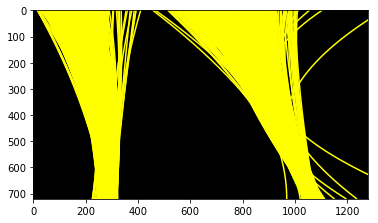

In [19]:
alternative_solidYellowLeft_output = 'test_videos_output/alternative_solidYellowLeft.mp4'
# clip9 = VideoFileClip("test_videos/alternative_solidYellowLeft.mp4").subclip(0,5)
clip9 = VideoFileClip("test_videos/alternative_solidYellowLeft.mp4")
alternative_solidYellowLeft_clip = clip9.fl_image(adv_lane_pipeline.video_pipeline) #NOTE: this function expects color images!!
%time alternative_solidYellowLeft_clip.write_videofile(alternative_solidYellowLeft_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(alternative_solidYellowLeft_output))

### Image Pipeline- Test Images

In [22]:
images_source='test_images/'
images_save='test_images_output/'

image_name_list=os.listdir(images_source)

print("Utilizing lane-finding pipeline on video feed.")

from lane_finding_pipeline import Lane_finding

adv_lane_pipeline=Lane_finding()

Utilizing lane-finding pipeline on video feed.


Using image test2.jpg from test_images/...
Left fit combined: [ -1.06128029e-03   1.41202491e+00  -1.25247951e+02]
Left_px: [array([ 98,  99,  99, ..., 719, 719, 719]), array([  8,   8,   9, ..., 346, 347, 348])]
Left Lanes 160.3714 m
Right Lanes 838.1053 m
Sanity Curve Difference 0.0
Curve- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Left- 02 loop
Sanity Fit Difference [ 0.  0.  0.]
Right- 02 loop


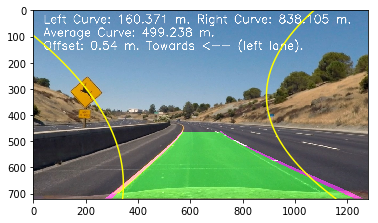

Saving image test2.jpg in test_images_output/...
Using image test6.jpg from test_images/...
Left fit combined: [ -1.37249768e-04  -2.09658622e-01   5.27974517e+02]
Left_px: [array([117, 118, 118, ..., 719, 719, 719]), array([522, 521, 522, ..., 345, 346, 347])]
Left Lanes 3673.1868 m
Right Lanes 255.9716 m
Sanity Curve Difference 2.9351527885
Curve- 02 loop
Sanity Fit Difference [ 0.87067529  1.14848082  5.21543437]
Left- 02 loop
Sanity Fit Difference [ 0.29452097  0.20128376  0.06971949]
Right- 02 loop


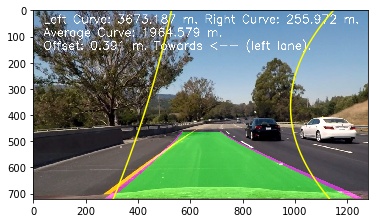

Saving image test6.jpg in test_images_output/...
Using image straight_lines2.jpg from test_images/...
Left fit combined: [  6.16843402e-05  -1.08267567e-01   3.29743208e+02]
Left_px: [array([223, 224, 224, ..., 713, 713, 713]), array([303, 303, 304, ..., 293, 295, 296])]
Left Lanes 3004.8577 m
Right Lanes 832.766 m
Sanity Curve Difference 0.0232962677053
Curve- 02 loop
Sanity Fit Difference [ 1.44943129  0.48360069  0.3754562 ]
Left- 02 loop
Sanity Fit Difference [ 1.02605629  1.62172134  0.43247696]
Right- 02 loop


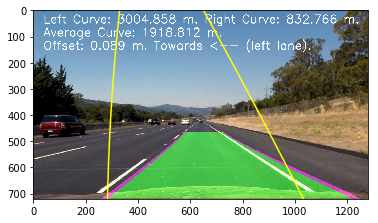

Saving image straight_lines2.jpg in test_images_output/...
Using image test3.jpg from test_images/...
Left fit combined: [  7.77322796e-05  -4.55331929e-01   5.79121854e+02]
Left_px: [array([281, 282, 282, ..., 718, 718, 718]), array([452, 452, 453, ..., 330, 331, 332])]
Left Lanes 36762.2585 m
Right Lanes 1010.9319 m
Sanity Curve Difference 8.84285936037
Curve- 02 loop
Sanity Fit Difference [ 0.26016229  3.20561708  0.75628137]
Left- 02 loop
Sanity Fit Difference [ 29.18679178   2.24365042   0.6940578 ]
Right- 02 loop


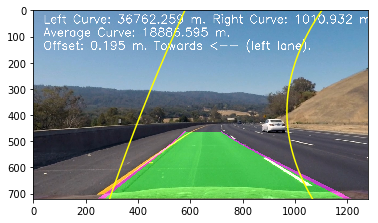

Saving image test3.jpg in test_images_output/...
Using image test4.jpg from test_images/...
Left fit combined: [  2.79122029e-04  -3.75349062e-01   4.56089818e+02]
Left_px: [array([ 35,  35,  35, ..., 717, 717, 717]), array([435, 436, 437, ..., 364, 367, 368])]
Left Lanes 575.4993 m
Right Lanes 512.6348 m
Sanity Curve Difference 0.971192952085
Curve- 02 loop
Sanity Fit Difference [ 2.59081234  0.17565838  0.21244585]
Left- 02 loop
Sanity Fit Difference [ 0.41474863  0.32901128  0.03333154]
Right- 02 loop


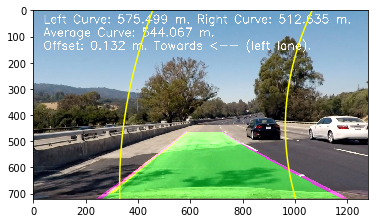

Saving image test4.jpg in test_images_output/...
Using image straight_lines1.jpg from test_images/...
Left fit combined: [ -6.54328914e-04   6.07858896e-01   1.61656866e+02]
Left_px: [array([  0,   0,   0, ..., 717, 717, 717]), array([127, 128, 129, ..., 288, 289, 290])]
Left Lanes 207.2887 m
Right Lanes 1413.6367 m
Sanity Curve Difference 0.48963749632
Curve- 02 loop
Sanity Fit Difference [ 3.3442396   2.61944962  0.64555914]
Left- 02 loop
Sanity Fit Difference [ 1.12281715  2.38180833  0.43343922]
Right- 02 loop


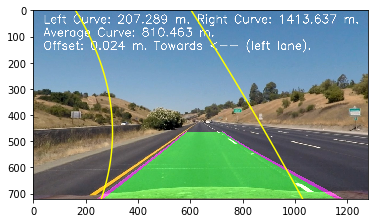

Saving image straight_lines1.jpg in test_images_output/...
Using image test1.jpg from test_images/...
Left fit combined: [  4.59297790e-04  -6.57560255e-01   5.41905328e+02]
Left_px: [array([167, 167, 168, ..., 719, 719, 719]), array([413, 414, 413, ..., 340, 341, 342])]
Left Lanes 953.4492 m
Right Lanes 282.167 m
Sanity Curve Difference 0.237709403548
Curve- 02 loop
Sanity Fit Difference [ 1.70193718  2.08176463  2.35219493]
Left- 02 loop
Sanity Fit Difference [ 16.07042102   2.12457741   0.81643966]
Right- 02 loop


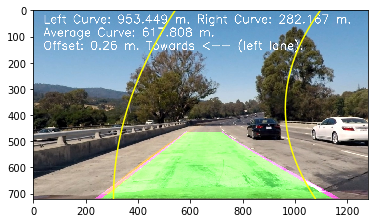

Saving image test1.jpg in test_images_output/...
Using image test5.jpg from test_images/...
Left fit combined: [  9.23103423e-04  -1.30600347e+00   7.11491669e+02]
Left_px: [array([352, 352, 352, ..., 719, 719, 719]), array([369, 370, 371, ..., 269, 270, 279])]
Left Lanes 479.9027 m
Right Lanes 383.8959 m
Sanity Curve Difference 0.300916709812
Curve- 02 loop
Sanity Fit Difference [ 1.00981464  0.98613505  0.31294459]
Left- 02 loop
Sanity Fit Difference [ 0.24359457  0.35523094  0.05245413]
Right- 02 loop


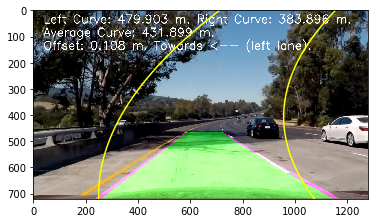

Saving image test5.jpg in test_images_output/...


In [27]:
for image_local in image_name_list:
    print("Using image {} from {}...".format(image_local,images_source))
    image=cv2.imread(os.path.join(images_source,image_local))
    image=cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    
    processed_image=adv_lane_pipeline.video_pipeline(image)
    plt.imshow(processed_image)
    plt.show()
    
    print("Saving image {} in {}...".format(image_local,images_save))
    saved_image=cv2.imwrite(os.path.join(images_save,image_local),cv2.cvtColor(processed_image,cv2.COLOR_RGB2BGR))

In [28]:
print("Script terminated at",str(datetime.now()))

Script terminated at 2017-09-07 03:06:08.812566
